In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Fitting a detached eclipsing binary

In this case study, we'll go through the steps required to fit the light curve and radial velocity measurements for the detached eclipsing binary system HD 23642.
This is a bright system that has been fit by many authors ([1](https://arxiv.org/abs/astro-ph/0403444), [2](https://arxiv.org/abs/astro-ph/0409507), [3](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract), [4](https://arxiv.org/abs/1602.01901), and [5](https://arxiv.org/abs/1603.08484) to name a few) so this is a good benchmark for our demonstration.

The light curve that we'll use is from K2 and we'll use the same radial velocity measurements as [David+ (2016)](https://arxiv.org/abs/1602.01901) compiled from [here](https://arxiv.org/abs/astro-ph/0403444) and [here](https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract).
We'll use a somewhat simplified model for the eclipses that treats the stars as spherical and ignores the phase curve (we'll model it using a Gaussian process instead of a more physically motivated model).
But, as you'll see, these simplifying assumptions are sufficient for this case of a detached and well behaved system.
Unlike some previous studies, we will fit an eccentric orbit instead of fixing the eccentricity to zero.
This probably isn't really necessary here, but it's useful to demonstrate how you would fit a more eccentric system.
Finally, we model the phase curve and other triends in both the light curve and radial velocities using Gaussian processes.
This will account for unmodeled stellar variability and residual systematics, drifts, and other effects left over from the data reduction procedure.

## Data access

First, let's define some values from the literature that will be useful below.
Here we're taking the period and eclipse time from [David+ (2016)](https://arxiv.org/abs/1602.01901) as initial guesses for these parameters in our fit.
We'll also include the same prior on the flux ratio of the two stars that was computed for the Kepler bandpass by [David+ (2016)](https://arxiv.org/abs/1602.01901).

In [3]:
lit_period = 2.46113408
lit_t0 = 119.522070 + 2457000 - 2454833

# Prior on the flux ratio for Kepler
lit_flux_ratio = (0.354, 0.035)

Then we'll download the Kepler data.
In this case, the pipeline aperture photometry isn't very good (because this star is so bright!) so we'll just download the target pixel file and co-add all the pixels.

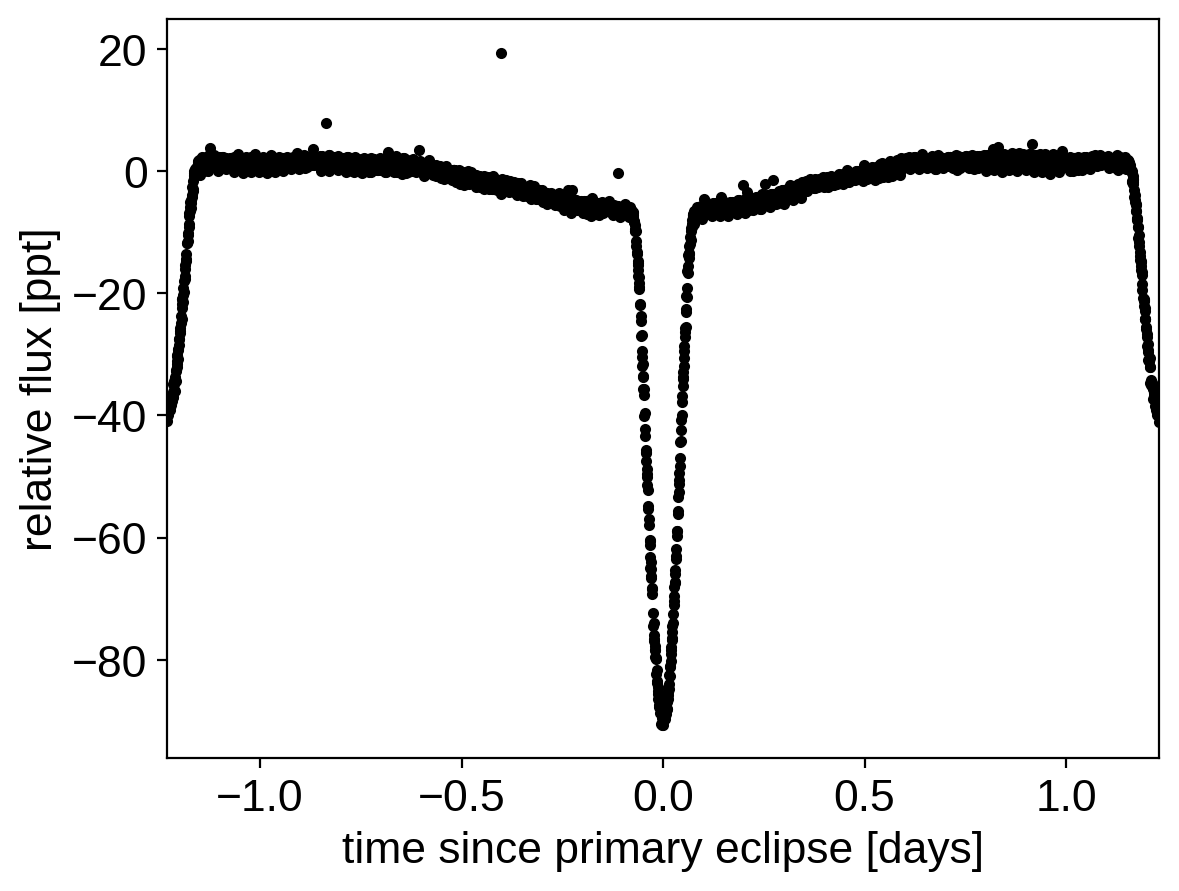

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

tpf = lk.search_targetpixelfile("EPIC 211082420").download()
lc = tpf.to_lightcurve(aperture_mask="all")
lc = lc.remove_nans().normalize()

hdr = tpf.hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
mu = np.median(y)
y = (y / mu - 1) * 1e3

plt.plot((x - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period, y, ".k")
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.xlabel("time since primary eclipse [days]")
_ = plt.ylabel("relative flux [ppt]")

Then we'll enter the radial velocity data.
I couldn't find these data online anywhere so I manually transcribed the data from the referenced papers (typos are my own!).

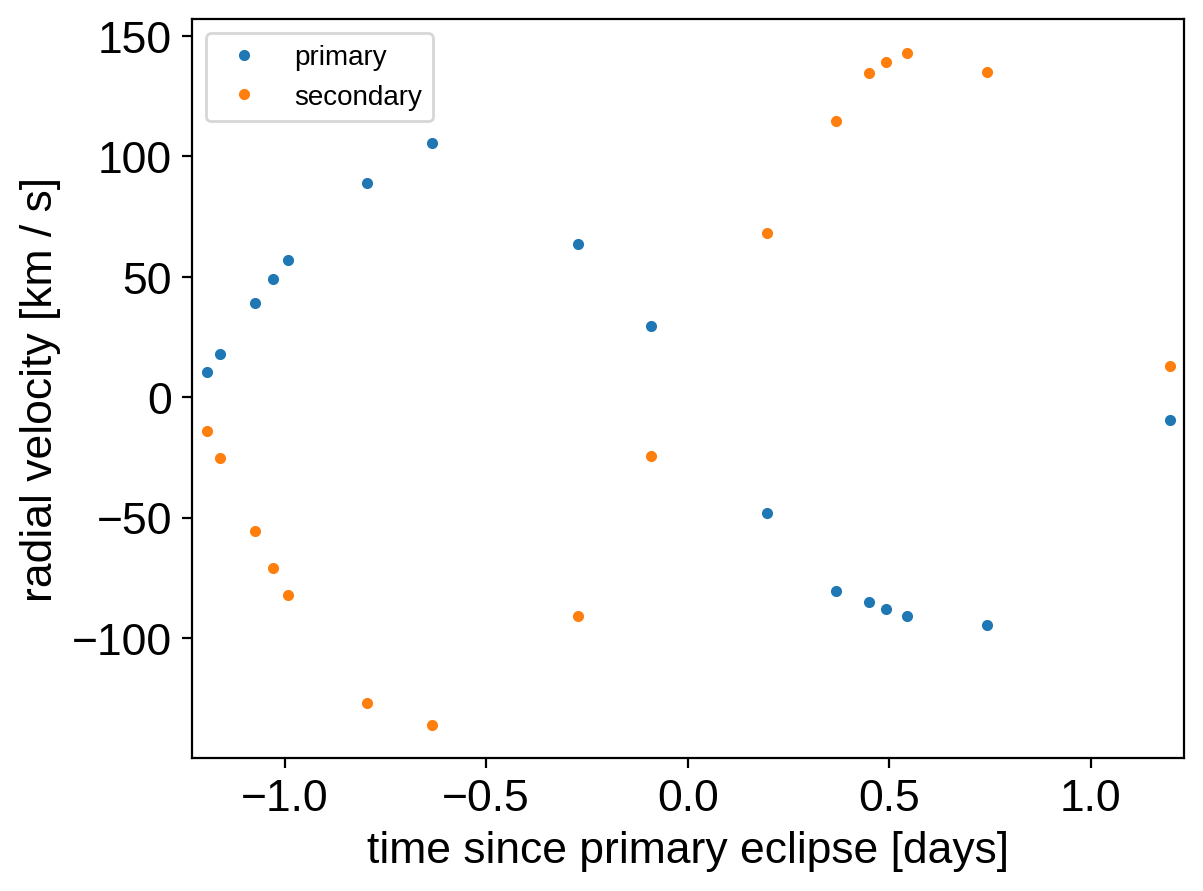

In [5]:
ref1 = 2453000
ref2 = 2400000
rvs = np.array(
    [
        # https://arxiv.org/abs/astro-ph/0403444
        (39.41273 + ref1, -85.0, 134.5),
        (39.45356 + ref1, -88.0, 139.0),
        (39.50548 + ref1, -91.0, 143.0),
        (43.25049 + ref1, 105.5, -136.0),
        (46.25318 + ref1, 29.5, -24.5),
        # https://ui.adsabs.harvard.edu/abs/2007A%26A...463..579G/abstract
        (52629.6190 + ref2, 88.8, -127.0),
        (52630.6098 + ref2, -48.0, 68.0),
        (52631.6089 + ref2, -9.5, 13.1),
        (52632.6024 + ref2, 63.6, -90.9),
        (52633.6162 + ref2, -94.5, 135.0),
        (52636.6055 + ref2, 10.3, -13.9),
        (52983.6570 + ref2, 18.1, -25.1),
        (52987.6453 + ref2, -80.6, 114.5),
        (52993.6322 + ref2, 49.0, -70.7),
        (53224.9338 + ref2, 39.0, -55.7),
        (53229.9384 + ref2, 57.2, -82.0),
    ]
)
rvs[:, 0] -= 2454833
rvs = rvs[np.argsort(rvs[:, 0])]

x_rv = np.ascontiguousarray(rvs[:, 0], dtype=np.float64)
y1_rv = np.ascontiguousarray(rvs[:, 1], dtype=np.float64)
y2_rv = np.ascontiguousarray(rvs[:, 2], dtype=np.float64)

fold = (rvs[:, 0] - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period
plt.plot(fold, rvs[:, 1], ".", label="primary")
plt.plot(fold, rvs[:, 2], ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

## Probabilistic model

Then we define the probabilistic model using PyMC3 and exoplanet.
This is similar to the other tutorials and case studies, but here we're using a :class:`exoplanet.SecondaryEclipseLightCurve` to generate the model light curve and we're modeling the radial velocity trends using a Gaussian process instead of a polynomial.
Otherwise, things should look pretty familiar!

After defining the model, we iteratively clip outliers in the light curve using sigma clipping and then estimate the maximum a posteriori parameters.

In [6]:
import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo


def build_model(mask):

    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=5.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)
        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        M1 = pm.Lognormal("M1", mu=0.0, sigma=10.0)
        R1 = pm.Lognormal("R1", mu=0.0, sigma=10.0)

        # Secondary ratios
        k = pm.Lognormal("k", mu=0.0, sigma=10.0)  # radius ratio
        q = pm.Lognormal("q", mu=0.0, sigma=10.0)  # mass ratio
        s = pm.Lognormal("s", mu=np.log(0.5), sigma=10.0)  # surface brightness ratio

        # Prior on flux ratio
        pm.Normal(
            "flux_prior", mu=lit_flux_ratio[0], sigma=lit_flux_ratio[1], observed=k * s
        )

        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=1.5)
        period = pm.Lognormal("period", mu=np.log(lit_period), sigma=1.0)
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)

        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
        ecs = xo.UnitDisk("ecs", testval=np.array([1e-5, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sqrt(tt.sum(ecs ** 2)))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", k * R1)
        M2 = pm.Deterministic("M2", q * M1)
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)

        # Noise model for the light curve
        sigma_lc = pm.InverseGamma(
            "sigma_lc", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.1, 2.0)
        )
        S_tot_lc = pm.InverseGamma(
            "S_tot_lc", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        ell_lc = pm.InverseGamma(
            "ell_lc", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_lc = xo.gp.terms.SHOTerm(
            S_tot=S_tot_lc, w0=2 * np.pi / ell_lc, Q=1.0 / 3
        )

        # Noise model for the radial velocities
        sigma_rv1 = pm.InverseGamma(
            "sigma_rv1", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        sigma_rv2 = pm.InverseGamma(
            "sigma_rv2", testval=1.0, **xo.estimate_inverse_gamma_parameters(0.5, 5.0)
        )
        S_tot_rv = pm.InverseGamma(
            "S_tot_rv", testval=2.5, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        ell_rv = pm.InverseGamma(
            "ell_rv", testval=2.0, **xo.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        kernel_rv = xo.gp.terms.SHOTerm(
            S_tot=S_tot_rv, w0=2 * np.pi / ell_rv, Q=1.0 / 3
        )

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, s)

        def model_lc(t):
            return (
                mean_lc
                + 1e3 * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:, 0]
            )

        # Condition the light curve model on the data
        gp_lc = xo.gp.GP(
            kernel_lc, x[mask], tt.zeros(mask.sum()) ** 2 + sigma_lc ** 2, mean=model_lc
        )
        gp_lc.marginal("obs_lc", observed=y[mask])

        # Set up the radial velocity model
        def model_rv1(t):
            return mean_rv + 1e-3 * orbit.get_radial_velocity(t)

        def model_rv2(t):
            return mean_rv - 1e-3 * orbit.get_radial_velocity(t) / q

        # Condition the radial velocity model on the data
        gp_rv1 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv1 ** 2, mean=model_rv1
        )
        gp_rv1.marginal("obs_rv1", observed=y1_rv)
        gp_rv2 = xo.gp.GP(
            kernel_rv, x_rv, tt.zeros(len(x_rv)) ** 2 + sigma_rv2 ** 2, mean=model_rv2
        )
        gp_rv2.marginal("obs_rv2", observed=y2_rv)

        # Optimize the logp
        map_soln = model.test_point

        # First the RV parameters
        map_soln = xo.optimize(map_soln, [mean_rv, q])
        map_soln = xo.optimize(
            map_soln, [mean_rv, sigma_rv1, sigma_rv2, S_tot_rv, ell_rv]
        )

        # Then the LC parameters
        map_soln = xo.optimize(map_soln, [mean_lc, R1, k, s, b])
        map_soln = xo.optimize(map_soln, [mean_lc, R1, k, s, b, u1, u2])
        map_soln = xo.optimize(map_soln, [mean_lc, sigma_lc, S_tot_lc, ell_lc])
        map_soln = xo.optimize(map_soln, [t0, period])

        # Then all the parameters together
        map_soln = xo.optimize(map_soln)

        model.gp_lc = gp_lc
        model.model_lc = model_lc
        model.gp_rv1 = gp_rv1
        model.model_rv1 = model_rv1
        model.gp_rv2 = gp_rv2
        model.model_rv2 = model_rv2

        model.x = x[mask]
        model.y = y[mask]

    return model, map_soln


def sigma_clip():
    mask = np.ones(len(x), dtype=bool)
    num = len(mask)

    for i in range(10):
        model, map_soln = build_model(mask)

        with model:
            mdl = xo.eval_in_model(
                model.model_lc(x[mask]) + model.gp_lc.predict(), map_soln
            )

        resid = y[mask] - mdl
        sigma = np.sqrt(np.median((resid - np.median(resid)) ** 2))
        mask[mask] = np.abs(resid - np.median(resid)) < 7 * sigma
        print("Sigma clipped {0} light curve points".format(num - mask.sum()))
        if num == mask.sum():
            break
        num = mask.sum()

    return model, map_soln


model, map_soln = sigma_clip()

optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.338058e+04]

1it [00:00, 106.33it/s, logp=-2.338058e+04]

2it [00:00, 154.08it/s, logp=-2.338058e+04]

3it [00:00, 179.16it/s, logp=-1.371193e+04]

4it [00:00, 195.36it/s, logp=-1.492576e+04]

5it [00:00, 207.71it/s, logp=-1.358037e+04]

6it [00:00, 216.16it/s, logp=-1.335577e+04]

7it [00:00, 221.67it/s, logp=-1.309819e+04]

8it [00:00, 226.08it/s, logp=-1.307502e+04]

9it [00:00, 229.70it/s, logp=-1.307285e+04]

10it [00:00, 233.26it/s, logp=-1.307282e+04]

11it [00:00, 235.75it/s, logp=-1.307282e+04]

12it [00:00, 238.11it/s, logp=-1.307282e+04]

13it [00:03,  3.69it/s, logp=-1.307282e+04] 


message: Optimization terminated successfully.
logp: -23380.5842277239 -> -13072.816791759677


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.307282e+04]

1it [00:00, 56.89it/s, logp=-1.307282e+04]

2it [00:00, 85.87it/s, logp=-1.307282e+04]

3it [00:00, 106.80it/s, logp=-1.018327e+04]

4it [00:00, 121.74it/s, logp=-8.904144e+03]

5it [00:00, 136.35it/s, logp=-9.241304e+03]

6it [00:00, 147.74it/s, logp=-8.795387e+03]

7it [00:00, 157.63it/s, logp=-8.676354e+03]

8it [00:00, 166.04it/s, logp=-8.648728e+03]

9it [00:00, 173.27it/s, logp=-8.606024e+03]

10it [00:00, 179.60it/s, logp=-8.554461e+03]

11it [00:00, 184.57it/s, logp=-8.728832e+03]

12it [00:00, 188.91it/s, logp=-8.521916e+03]

13it [00:00, 193.32it/s, logp=-8.640295e+03]

14it [00:00, 197.90it/s, logp=-8.512540e+03]

15it [00:00, 201.53it/s, logp=-8.502406e+03]

16it [00:00, 204.69it/s, logp=-8.491012e+03]

17it [00:00, 207.58it/s, logp=-8.499248e+03]

18it [00:00, 210.40it/s, logp=-8.484668e+03]

19it [00:00, 212.70it/s, logp=-8.483864e+03]

20it [00:00, 215.03it/s, logp=-8.483590e+03]

21it [00:00, 217.26it/s, logp=-8.483526e+03]

22it [00:00, 219.27it/s, logp=-8.483507e+03]

23it [00:00, 227.95it/s, logp=-8.483507e+03]

23it [00:00, 227.95it/s, logp=-8.483474e+03]

24it [00:00, 227.95it/s, logp=-8.483431e+03]

25it [00:00, 227.95it/s, logp=-8.483410e+03]

26it [00:00, 227.95it/s, logp=-8.483372e+03]

27it [00:00, 227.95it/s, logp=-8.483300e+03]

28it [00:00, 227.95it/s, logp=-8.483172e+03]

29it [00:00, 227.95it/s, logp=-8.482963e+03]

30it [00:00, 227.95it/s, logp=-8.482725e+03]

31it [00:00, 227.95it/s, logp=-8.482637e+03]

32it [00:00, 227.95it/s, logp=-8.482584e+03]

33it [00:00, 227.95it/s, logp=-8.482577e+03]

34it [00:00, 227.95it/s, logp=-8.482576e+03]

35it [00:00, 227.95it/s, logp=-8.482576e+03]

36it [00:00, 227.95it/s, logp=-8.482576e+03]

37it [00:00, 227.95it/s, logp=-8.482576e+03]

38it [00:00, 227.95it/s, logp=-8.482576e+03]

39it [00:00, 227.95it/s, logp=-8.482576e+03]

40it [00:00, 104.42it/s, logp=-8.482576e+03]


message: Optimization terminated successfully.
logp: -13072.816791759677 -> -8482.576126912147


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.482576e+03]

1it [00:00, 73.05it/s, logp=-8.482576e+03]

2it [00:00, 100.01it/s, logp=-8.482576e+03]

3it [00:00, 94.21it/s, logp=-5.145584e+05] 

4it [00:00, 104.21it/s, logp=-6.505263e+03]

5it [00:00, 111.10it/s, logp=-6.292747e+03]

6it [00:00, 118.56it/s, logp=-8.502956e+03]

7it [00:00, 126.22it/s, logp=-6.278122e+03]

8it [00:00, 132.03it/s, logp=-6.669084e+03]

9it [00:00, 132.82it/s, logp=-6.277575e+03]

10it [00:00, 133.88it/s, logp=-6.276471e+03]

11it [00:00, 134.23it/s, logp=-6.272057e+03]

12it [00:00, 134.78it/s, logp=-6.254494e+03]

13it [00:00, 135.92it/s, logp=-6.185706e+03]

14it [00:00, 136.67it/s, logp=-5.934077e+03]

15it [00:00, 145.18it/s, logp=-5.934077e+03]

15it [00:00, 145.18it/s, logp=-5.402332e+03]

16it [00:00, 145.18it/s, logp=-4.739662e+03]

17it [00:00, 145.18it/s, logp=-4.706432e+03]

18it [00:00, 145.18it/s, logp=-4.706090e+03]

19it [00:00, 145.18it/s, logp=-4.705681e+03]

20it [00:00, 145.18it/s, logp=-4.704991e+03]

21it [00:00, 145.18it/s, logp=-4.704003e+03]

22it [00:00, 145.18it/s, logp=-4.702929e+03]

23it [00:00, 145.18it/s, logp=-4.701202e+03]

24it [00:00, 145.18it/s, logp=-4.699296e+03]

25it [00:00, 145.18it/s, logp=-4.698727e+03]

26it [00:00, 145.18it/s, logp=-4.697899e+03]

27it [00:00, 145.18it/s, logp=-4.697236e+03]

28it [00:00, 145.18it/s, logp=-4.696966e+03]

29it [00:00, 145.18it/s, logp=-4.696770e+03]

30it [00:00, 145.83it/s, logp=-4.696770e+03]

30it [00:00, 145.83it/s, logp=-4.696757e+03]

31it [00:00, 145.83it/s, logp=-4.696727e+03]

32it [00:00, 145.83it/s, logp=-4.696703e+03]

33it [00:00, 145.83it/s, logp=-4.696694e+03]

34it [00:00, 145.83it/s, logp=-4.696693e+03]

35it [00:00, 145.83it/s, logp=-4.696693e+03]

36it [00:00, 145.83it/s, logp=-4.696693e+03]

37it [00:00, 145.83it/s, logp=-4.696693e+03]

38it [00:00, 145.83it/s, logp=-4.696693e+03]

39it [00:00, 71.23it/s, logp=-4.696693e+03] 


message: Optimization terminated successfully.
logp: -8482.576126912147 -> -4696.693195993793


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.696693e+03]

1it [00:00, 107.66it/s, logp=-4.696693e+03]

2it [00:00, 152.22it/s, logp=-4.696693e+03]

3it [00:00, 173.81it/s, logp=-5.283064e+03]

4it [00:00, 186.38it/s, logp=-4.696633e+03]

5it [00:00, 190.62it/s, logp=-4.696536e+03]

6it [00:00, 196.68it/s, logp=-4.696379e+03]

7it [00:00, 200.38it/s, logp=-4.696082e+03]

8it [00:00, 204.04it/s, logp=-4.696235e+03]

9it [00:00, 208.04it/s, logp=-4.695889e+03]

10it [00:00, 203.10it/s, logp=-4.695537e+03]

11it [00:00, 202.73it/s, logp=-4.694911e+03]

12it [00:00, 204.19it/s, logp=-4.694584e+03]

13it [00:00, 205.53it/s, logp=-4.694137e+03]

14it [00:00, 205.97it/s, logp=-4.695139e+03]

15it [00:00, 207.08it/s, logp=-4.694040e+03]

16it [00:00, 208.16it/s, logp=-4.693916e+03]

17it [00:00, 208.85it/s, logp=-4.693885e+03]

18it [00:00, 209.04it/s, logp=-4.693867e+03]

19it [00:00, 208.88it/s, logp=-4.693837e+03]

20it [00:00, 208.46it/s, logp=-4.693787e+03]

21it [00:00, 206.82it/s, logp=-4.693734e+03]

22it [00:00, 215.53it/s, logp=-4.693734e+03]

22it [00:00, 215.53it/s, logp=-4.693708e+03]

23it [00:00, 215.53it/s, logp=-4.693674e+03]

24it [00:00, 215.53it/s, logp=-4.693682e+03]

25it [00:00, 215.53it/s, logp=-4.693656e+03]

26it [00:00, 215.53it/s, logp=-4.693647e+03]

27it [00:00, 215.53it/s, logp=-4.693642e+03]

28it [00:00, 215.53it/s, logp=-4.693638e+03]

29it [00:00, 215.53it/s, logp=-4.693638e+03]

30it [00:00, 215.53it/s, logp=-4.693637e+03]

31it [00:00, 215.53it/s, logp=-4.693637e+03]

32it [00:00, 215.53it/s, logp=-4.693636e+03]

33it [00:00, 215.53it/s, logp=-4.693636e+03]

34it [00:00, 215.53it/s, logp=-4.693636e+03]

35it [00:00, 215.53it/s, logp=-4.693636e+03]

36it [00:00, 215.53it/s, logp=-4.693636e+03]

37it [00:00, 215.53it/s, logp=-4.693636e+03]

38it [00:00, 215.53it/s, logp=-4.693636e+03]

39it [00:00, 215.53it/s, logp=-4.693636e+03]

40it [00:00, 104.41it/s, logp=-4.693636e+03]


message: Optimization terminated successfully.
logp: -4696.693195993793 -> -4693.636423265372


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.693636e+03]

1it [00:00, 107.83it/s, logp=-4.693636e+03]

2it [00:00, 150.01it/s, logp=-4.693636e+03]

3it [00:00, 171.38it/s, logp=-4.092057e+03]

4it [00:00, 185.25it/s, logp=-4.278894e+03]

5it [00:00, 194.50it/s, logp=-3.864064e+03]

6it [00:00, 195.78it/s, logp=-4.035287e+03]

7it [00:00, 195.62it/s, logp=-3.815480e+03]

8it [00:00, 199.81it/s, logp=-3.732626e+03]

9it [00:00, 203.21it/s, logp=-3.643464e+03]

10it [00:00, 207.05it/s, logp=-3.640438e+03]

11it [00:00, 209.61it/s, logp=-3.640385e+03]

12it [00:00, 211.88it/s, logp=-3.640332e+03]

13it [00:00, 214.43it/s, logp=-3.640328e+03]

14it [00:00, 215.76it/s, logp=-3.640328e+03]

15it [00:00, 217.64it/s, logp=-3.640328e+03]

16it [00:00, 218.97it/s, logp=-3.640328e+03]

17it [00:00, 220.71it/s, logp=-3.640328e+03]

18it [00:00, 221.87it/s, logp=-3.640328e+03]

19it [00:00, 223.22it/s, logp=-3.640328e+03]

20it [00:00, 224.66it/s, logp=-3.640328e+03]

21it [00:00, 225.61it/s, logp=-3.640328e+03]

22it [00:00, 226.55it/s, logp=-3.640328e+03]

23it [00:00, 227.39it/s, logp=-3.640328e+03]

24it [00:00, 236.08it/s, logp=-3.640328e+03]

24it [00:00, 236.08it/s, logp=-3.640328e+03]

25it [00:00, 236.08it/s, logp=-3.640328e+03]

26it [00:00, 236.08it/s, logp=-3.640328e+03]

27it [00:00, 236.08it/s, logp=-3.640328e+03]

28it [00:00, 236.08it/s, logp=-3.640328e+03]

29it [00:00, 236.08it/s, logp=-3.640328e+03]

30it [00:00, 236.08it/s, logp=-3.640328e+03]

31it [00:00, 236.08it/s, logp=-3.640328e+03]

32it [00:00, 236.08it/s, logp=-3.640328e+03]

33it [00:00, 236.08it/s, logp=-3.640328e+03]

34it [00:00, 236.08it/s, logp=-3.640328e+03]

35it [00:00, 236.08it/s, logp=-3.640328e+03]

36it [00:00, 236.08it/s, logp=-3.640328e+03]

37it [00:00, 236.08it/s, logp=-3.640328e+03]

38it [00:00, 236.08it/s, logp=-3.640328e+03]

39it [00:00, 236.08it/s, logp=-3.640328e+03]

40it [00:00, 236.08it/s, logp=-3.640328e+03]

41it [00:00, 236.08it/s, logp=-3.640328e+03]

42it [00:00, 236.08it/s, logp=-3.640328e+03]

43it [00:00, 236.08it/s, logp=-3.640328e+03]

44it [00:00, 236.08it/s, logp=-3.640328e+03]

45it [00:00, 236.08it/s, logp=-3.640328e+03]

46it [00:00, 236.08it/s, logp=-3.640328e+03]

47it [00:00, 236.08it/s, logp=-3.640328e+03]

48it [00:00, 236.08it/s, logp=-3.640328e+03]

49it [00:00, 239.79it/s, logp=-3.640328e+03]

49it [00:00, 239.79it/s, logp=-3.640328e+03]

50it [00:00, 239.79it/s, logp=-3.640328e+03]

51it [00:00, 239.79it/s, logp=-3.640328e+03]

52it [00:00, 239.79it/s, logp=-3.640328e+03]

53it [00:00, 239.79it/s, logp=-3.640328e+03]

54it [00:00, 239.79it/s, logp=-3.640328e+03]

55it [00:00, 239.79it/s, logp=-3.640328e+03]

56it [00:00, 239.79it/s, logp=-3.640328e+03]

57it [00:00, 239.79it/s, logp=-3.640328e+03]

58it [00:00, 239.79it/s, logp=-3.640328e+03]

59it [00:00, 239.79it/s, logp=-3.640328e+03]

60it [00:00, 239.79it/s, logp=-3.640328e+03]

61it [00:00, 239.79it/s, logp=-3.640328e+03]

62it [00:00, 239.79it/s, logp=-3.640328e+03]

63it [00:00, 239.79it/s, logp=-3.640328e+03]

64it [00:00, 239.79it/s, logp=-3.640328e+03]

65it [00:00, 239.79it/s, logp=-3.640328e+03]

66it [00:00, 239.79it/s, logp=-3.640328e+03]

67it [00:00, 239.79it/s, logp=-3.640328e+03]

68it [00:00, 239.79it/s, logp=-3.640328e+03]

69it [00:00, 239.79it/s, logp=-3.640328e+03]

70it [00:00, 239.79it/s, logp=-3.640328e+03]

71it [00:00, 239.79it/s, logp=-3.640328e+03]

72it [00:00, 239.79it/s, logp=-3.640328e+03]

73it [00:00, 239.79it/s, logp=-3.640328e+03]

74it [00:00, 242.04it/s, logp=-3.640328e+03]

74it [00:00, 242.04it/s, logp=-3.640328e+03]

75it [00:00, 242.04it/s, logp=-3.640328e+03]

76it [00:00, 242.04it/s, logp=-3.640328e+03]

77it [00:00, 242.04it/s, logp=-3.640328e+03]

78it [00:00, 242.04it/s, logp=-3.640328e+03]

79it [00:00, 242.04it/s, logp=-3.640328e+03]

80it [00:00, 242.04it/s, logp=-3.640328e+03]

81it [00:00, 242.04it/s, logp=-3.640328e+03]

82it [00:00, 242.04it/s, logp=-3.640328e+03]

83it [00:00, 242.04it/s, logp=-3.640328e+03]

84it [00:00, 150.34it/s, logp=-3.640328e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4693.6364232653705 -> -3640.327844208639


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-3.640328e+03]

1it [00:00, 108.51it/s, logp=-3.640328e+03]

2it [00:00, 150.70it/s, logp=-3.640328e+03]

3it [00:00, 179.49it/s, logp=-5.274568e+05]

4it [00:00, 194.01it/s, logp=-7.891077e+05]

5it [00:00, 202.84it/s, logp=-5.073792e+05]

6it [00:00, 209.27it/s, logp=-3.640171e+03]

7it [00:00, 215.00it/s, logp=-3.639206e+03]

8it [00:00, 219.26it/s, logp=-3.637450e+03]

9it [00:00, 222.39it/s, logp=-3.636692e+03]

10it [00:00, 224.75it/s, logp=-3.636692e+03]

11it [00:00, 226.95it/s, logp=-3.636692e+03]

12it [00:00, 229.51it/s, logp=-3.636692e+03]

13it [00:00, 231.01it/s, logp=-3.636692e+03]

14it [00:00, 232.94it/s, logp=-3.636692e+03]

15it [00:00, 234.29it/s, logp=-3.636692e+03]

16it [00:00, 235.40it/s, logp=-3.636692e+03]

17it [00:00, 236.31it/s, logp=-3.636692e+03]

18it [00:00, 237.20it/s, logp=-3.636692e+03]

19it [00:00, 238.56it/s, logp=-3.636692e+03]

20it [00:00, 238.88it/s, logp=-3.636692e+03]

21it [00:00, 239.49it/s, logp=-3.636692e+03]

22it [00:00, 240.05it/s, logp=-3.636692e+03]

23it [00:00, 240.57it/s, logp=-3.636692e+03]

24it [00:00, 241.41it/s, logp=-3.636692e+03]

25it [00:00, 241.91it/s, logp=-3.636692e+03]

26it [00:00, 249.79it/s, logp=-3.636692e+03]

26it [00:00, 249.79it/s, logp=-3.636692e+03]

27it [00:00, 249.79it/s, logp=-3.636692e+03]

28it [00:00, 249.79it/s, logp=-3.636692e+03]

29it [00:00, 249.79it/s, logp=-3.636692e+03]

30it [00:00, 249.79it/s, logp=-3.636692e+03]

31it [00:00, 249.79it/s, logp=-3.636692e+03]

32it [00:00, 249.79it/s, logp=-3.636692e+03]

33it [00:00, 249.79it/s, logp=-3.636692e+03]

34it [00:00, 249.79it/s, logp=-3.636692e+03]

35it [00:00, 249.79it/s, logp=-3.636692e+03]

36it [00:00, 249.79it/s, logp=-3.636692e+03]

37it [00:00, 249.79it/s, logp=-3.636692e+03]

38it [00:00, 249.79it/s, logp=-3.636692e+03]

39it [00:00, 249.79it/s, logp=-3.636692e+03]

40it [00:00, 249.79it/s, logp=-3.636692e+03]

41it [00:00, 249.79it/s, logp=-3.636692e+03]

42it [00:00, 249.79it/s, logp=-3.636692e+03]

43it [00:00, 249.79it/s, logp=-3.636692e+03]

44it [00:00, 249.79it/s, logp=-3.636692e+03]

45it [00:00, 249.79it/s, logp=-3.636692e+03]

46it [00:00, 249.79it/s, logp=-3.636692e+03]

47it [00:00, 249.79it/s, logp=-3.636692e+03]

48it [00:00, 249.79it/s, logp=-3.636692e+03]

49it [00:00, 249.79it/s, logp=-3.636692e+03]

50it [00:00, 249.79it/s, logp=-3.636692e+03]

51it [00:00, 248.66it/s, logp=-3.636692e+03]

51it [00:00, 248.66it/s, logp=-3.636692e+03]

52it [00:00, 248.66it/s, logp=-3.636692e+03]

53it [00:00, 248.66it/s, logp=-3.636692e+03]

54it [00:00, 248.66it/s, logp=-3.636692e+03]

55it [00:00, 248.66it/s, logp=-3.636692e+03]

56it [00:00, 248.66it/s, logp=-3.636692e+03]

57it [00:00, 248.66it/s, logp=-3.636692e+03]

58it [00:00, 248.66it/s, logp=-3.636692e+03]

59it [00:00, 248.66it/s, logp=-3.636692e+03]

60it [00:00, 248.66it/s, logp=-3.636692e+03]

61it [00:00, 248.66it/s, logp=-3.636692e+03]

62it [00:00, 248.66it/s, logp=-3.636692e+03]

63it [00:00, 248.66it/s, logp=-3.636692e+03]

64it [00:00, 248.66it/s, logp=-3.636692e+03]

65it [00:00, 248.66it/s, logp=-3.636692e+03]

66it [00:00, 248.66it/s, logp=-3.636692e+03]

67it [00:00, 207.98it/s, logp=-3.636692e+03]

67it [00:00, 207.98it/s, logp=-3.636692e+03]

68it [00:00, 207.98it/s, logp=-3.636692e+03]

69it [00:00, 207.98it/s, logp=-3.636692e+03]

70it [00:00, 207.98it/s, logp=-3.636692e+03]

71it [00:00, 207.98it/s, logp=-3.636692e+03]

72it [00:00, 207.98it/s, logp=-3.636692e+03]

73it [00:00, 207.98it/s, logp=-3.636692e+03]

74it [00:00, 207.98it/s, logp=-3.636692e+03]

75it [00:00, 207.98it/s, logp=-3.636692e+03]

76it [00:00, 207.98it/s, logp=-3.636692e+03]

77it [00:00, 207.98it/s, logp=-3.636692e+03]

78it [00:00, 207.98it/s, logp=-3.636692e+03]

79it [00:00, 207.98it/s, logp=-3.636692e+03]

80it [00:00, 207.98it/s, logp=-3.636692e+03]

81it [00:00, 207.98it/s, logp=-3.636692e+03]

82it [00:00, 207.98it/s, logp=-3.636692e+03]

83it [00:00, 188.15it/s, logp=-3.636692e+03]

83it [00:00, 188.15it/s, logp=-3.636692e+03]

84it [00:00, 188.15it/s, logp=-3.636692e+03]

85it [00:00, 188.15it/s, logp=-3.636692e+03]

86it [00:00, 188.15it/s, logp=-3.636692e+03]

87it [00:00, 188.15it/s, logp=-3.636692e+03]

88it [00:00, 188.15it/s, logp=-3.636692e+03]

89it [00:00, 188.15it/s, logp=-3.636692e+03]

90it [00:00, 188.15it/s, logp=-3.636692e+03]

91it [00:00, 188.15it/s, logp=-3.636692e+03]

92it [00:00, 188.15it/s, logp=-3.636692e+03]

93it [00:00, 188.15it/s, logp=-3.636692e+03]

94it [00:00, 188.15it/s, logp=-3.636692e+03]

95it [00:00, 188.15it/s, logp=-3.636692e+03]

96it [00:00, 188.15it/s, logp=-3.636692e+03]

97it [00:00, 188.15it/s, logp=-3.636692e+03]

98it [00:00, 188.15it/s, logp=-3.636692e+03]

99it [00:00, 176.70it/s, logp=-3.636692e+03]

99it [00:00, 176.70it/s, logp=-3.636692e+03]

100it [00:00, 176.70it/s, logp=-3.636692e+03]

101it [00:00, 128.02it/s, logp=-3.636692e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -3640.3278442086394 -> -3636.6924367320316


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-3.636692e+03]

1it [00:00, 75.37it/s, logp=-3.636692e+03]

2it [00:00, 108.85it/s, logp=-3.636692e+03]

3it [00:00, 131.40it/s, logp=-2.915042e+05]

4it [00:00, 143.61it/s, logp=-1.335909e+04]

5it [00:00, 152.44it/s, logp=-3.634394e+03]

6it [00:00, 157.76it/s, logp=-3.777980e+03]

7it [00:00, 162.82it/s, logp=-3.634358e+03]

8it [00:00, 166.04it/s, logp=-3.634289e+03]

9it [00:00, 169.39it/s, logp=-3.634067e+03]

10it [00:00, 170.43it/s, logp=-3.633489e+03]

11it [00:00, 172.18it/s, logp=-3.631347e+03]

12it [00:00, 172.11it/s, logp=-3.628394e+03]

13it [00:00, 172.12it/s, logp=-3.760906e+03]

14it [00:00, 173.23it/s, logp=-3.628330e+03]

15it [00:00, 173.88it/s, logp=-3.628202e+03]

16it [00:00, 174.85it/s, logp=-3.627706e+03]

17it [00:00, 175.91it/s, logp=-3.625982e+03]

18it [00:00, 176.38it/s, logp=-3.622986e+03]

19it [00:00, 185.38it/s, logp=-3.622986e+03]

19it [00:00, 185.38it/s, logp=-3.617149e+03]

20it [00:00, 185.38it/s, logp=-3.618836e+03]

21it [00:00, 185.38it/s, logp=-3.612927e+03]

22it [00:00, 185.38it/s, logp=-3.611501e+03]

23it [00:00, 185.38it/s, logp=-3.609031e+03]

24it [00:00, 185.38it/s, logp=-3.605823e+03]

25it [00:00, 185.38it/s, logp=-3.609398e+03]

26it [00:00, 185.38it/s, logp=-3.604501e+03]

27it [00:00, 185.38it/s, logp=-3.604550e+03]

28it [00:00, 185.38it/s, logp=-3.603843e+03]

29it [00:00, 185.38it/s, logp=-3.602738e+03]

30it [00:00, 185.38it/s, logp=-3.601175e+03]

31it [00:00, 185.38it/s, logp=-3.599156e+03]

32it [00:00, 185.38it/s, logp=-3.605867e+03]

33it [00:00, 185.38it/s, logp=-3.598717e+03]

34it [00:00, 185.38it/s, logp=-3.598006e+03]

35it [00:00, 185.38it/s, logp=-3.597225e+03]

36it [00:00, 185.38it/s, logp=-3.596532e+03]

37it [00:00, 185.38it/s, logp=-3.595946e+03]

38it [00:00, 186.57it/s, logp=-3.595946e+03]

38it [00:00, 186.57it/s, logp=-3.595518e+03]

39it [00:00, 186.57it/s, logp=-3.594834e+03]

40it [00:00, 186.57it/s, logp=-3.593803e+03]

41it [00:00, 186.57it/s, logp=-3.592686e+03]

42it [00:00, 186.57it/s, logp=-3.592029e+03]

43it [00:00, 186.57it/s, logp=-3.590953e+03]

44it [00:00, 186.57it/s, logp=-3.589082e+03]

45it [00:00, 186.57it/s, logp=-3.586234e+03]

46it [00:00, 186.57it/s, logp=-3.581845e+03]

47it [00:00, 186.57it/s, logp=-3.574545e+03]

48it [00:00, 186.57it/s, logp=-3.590827e+03]

49it [00:00, 186.57it/s, logp=-3.570708e+03]

50it [00:00, 186.57it/s, logp=-3.564613e+03]

51it [00:00, 186.57it/s, logp=-3.557202e+03]

52it [00:00, 186.57it/s, logp=-3.564908e+03]

53it [00:00, 186.57it/s, logp=-3.554500e+03]

54it [00:00, 186.57it/s, logp=-3.551129e+03]

55it [00:00, 186.57it/s, logp=-3.553428e+03]

56it [00:00, 186.57it/s, logp=-3.549746e+03]

57it [00:00, 185.15it/s, logp=-3.549746e+03]

57it [00:00, 185.15it/s, logp=-3.548431e+03]

58it [00:00, 185.15it/s, logp=-3.547047e+03]

59it [00:00, 185.15it/s, logp=-3.545729e+03]

60it [00:00, 185.15it/s, logp=-3.544137e+03]

61it [00:00, 185.15it/s, logp=-3.543582e+03]

62it [00:00, 185.15it/s, logp=-3.543139e+03]

63it [00:00, 185.15it/s, logp=-3.542843e+03]

64it [00:00, 185.15it/s, logp=-3.542494e+03]

65it [00:00, 185.15it/s, logp=-3.542770e+03]

66it [00:00, 185.15it/s, logp=-3.542186e+03]

67it [00:00, 185.15it/s, logp=-3.542117e+03]

68it [00:00, 185.15it/s, logp=-3.542009e+03]

69it [00:00, 185.15it/s, logp=-3.542051e+03]

70it [00:00, 185.15it/s, logp=-3.541932e+03]

71it [00:00, 185.15it/s, logp=-3.541866e+03]

72it [00:00, 185.15it/s, logp=-3.541770e+03]

73it [00:00, 185.15it/s, logp=-3.541600e+03]

74it [00:00, 185.15it/s, logp=-3.541353e+03]

75it [00:00, 185.15it/s, logp=-3.541220e+03]

76it [00:00, 185.35it/s, logp=-3.541220e+03]

76it [00:00, 185.35it/s, logp=-3.541019e+03]

77it [00:00, 185.35it/s, logp=-3.540742e+03]

78it [00:00, 185.35it/s, logp=-3.540528e+03]

79it [00:00, 185.35it/s, logp=-3.540505e+03]

80it [00:00, 185.35it/s, logp=-3.540399e+03]

81it [00:00, 185.35it/s, logp=-3.540236e+03]

82it [00:00, 185.35it/s, logp=-3.540089e+03]

83it [00:00, 185.35it/s, logp=-3.540046e+03]

84it [00:00, 185.35it/s, logp=-3.539984e+03]

85it [00:00, 185.35it/s, logp=-3.539933e+03]

86it [00:00, 185.35it/s, logp=-3.539901e+03]

87it [00:00, 185.35it/s, logp=-3.539855e+03]

88it [00:00, 185.35it/s, logp=-3.539808e+03]

89it [00:00, 185.35it/s, logp=-3.539779e+03]

90it [00:00, 185.35it/s, logp=-3.539764e+03]

91it [00:00, 185.35it/s, logp=-3.539759e+03]

92it [00:00, 185.35it/s, logp=-3.539750e+03]

93it [00:00, 185.35it/s, logp=-3.539735e+03]

94it [00:00, 183.44it/s, logp=-3.539735e+03]

94it [00:00, 183.44it/s, logp=-3.539712e+03]

95it [00:00, 183.44it/s, logp=-3.539697e+03]

96it [00:00, 183.44it/s, logp=-3.539694e+03]

97it [00:00, 183.44it/s, logp=-3.539692e+03]

98it [00:00, 183.44it/s, logp=-3.539692e+03]

99it [00:00, 183.44it/s, logp=-3.539691e+03]

100it [00:00, 183.44it/s, logp=-3.539691e+03]

101it [00:00, 183.44it/s, logp=-3.539691e+03]

102it [00:00, 183.44it/s, logp=-3.539691e+03]

103it [00:00, 183.44it/s, logp=-3.539691e+03]

104it [00:00, 183.44it/s, logp=-3.539691e+03]

105it [00:00, 183.44it/s, logp=-3.539691e+03]

106it [00:00, 183.44it/s, logp=-3.539691e+03]

107it [00:00, 183.44it/s, logp=-3.539690e+03]

108it [00:00, 183.44it/s, logp=-3.539690e+03]

109it [00:00, 183.44it/s, logp=-3.539690e+03]

110it [00:00, 183.44it/s, logp=-3.539690e+03]

111it [00:00, 183.44it/s, logp=-3.539690e+03]

112it [00:00, 183.44it/s, logp=-3.539690e+03]

113it [00:00, 183.27it/s, logp=-3.539690e+03]

113it [00:00, 183.27it/s, logp=-3.539690e+03]

114it [00:00, 183.27it/s, logp=-3.539690e+03]

115it [00:00, 183.27it/s, logp=-3.539690e+03]

116it [00:00, 183.27it/s, logp=-3.539690e+03]

117it [00:00, 183.27it/s, logp=-3.539690e+03]

118it [00:00, 183.27it/s, logp=-3.539690e+03]

119it [00:00, 183.27it/s, logp=-3.539690e+03]

120it [00:00, 183.27it/s, logp=-3.539690e+03]

121it [00:00, 183.27it/s, logp=-3.539690e+03]

122it [00:00, 183.27it/s, logp=-3.539690e+03]

123it [00:00, 183.27it/s, logp=-3.539690e+03]

124it [00:00, 183.27it/s, logp=-3.539690e+03]

125it [00:00, 183.27it/s, logp=-3.539690e+03]

126it [00:00, 183.27it/s, logp=-3.539690e+03]

127it [00:00, 183.27it/s, logp=-3.539690e+03]

128it [00:00, 183.27it/s, logp=-3.539690e+03]

129it [00:00, 183.27it/s, logp=-3.539690e+03]

130it [00:00, 183.27it/s, logp=-3.539690e+03]

131it [00:00, 183.27it/s, logp=-3.539690e+03]

132it [00:00, 184.44it/s, logp=-3.539690e+03]

132it [00:00, 184.44it/s, logp=-3.539690e+03]

133it [00:00, 184.44it/s, logp=-3.539690e+03]

134it [00:00, 184.44it/s, logp=-3.539690e+03]

135it [00:00, 184.44it/s, logp=-3.539690e+03]

136it [00:00, 184.44it/s, logp=-3.539690e+03]

137it [00:00, 184.44it/s, logp=-3.539690e+03]

138it [00:00, 184.44it/s, logp=-3.539690e+03]

139it [00:00, 184.44it/s, logp=-3.539690e+03]

140it [00:00, 184.44it/s, logp=-3.539690e+03]

141it [00:00, 184.44it/s, logp=-3.539690e+03]

142it [00:00, 184.44it/s, logp=-3.539690e+03]

143it [00:00, 184.44it/s, logp=-3.539690e+03]

144it [00:00, 184.44it/s, logp=-3.539690e+03]

145it [00:00, 184.44it/s, logp=-3.539690e+03]

146it [00:00, 184.44it/s, logp=-3.539690e+03]

147it [00:00, 184.44it/s, logp=-3.539690e+03]

148it [00:00, 184.44it/s, logp=-3.539690e+03]

149it [00:00, 179.16it/s, logp=-3.539690e+03]

149it [00:00, 179.16it/s, logp=-3.539690e+03]

150it [00:00, 179.16it/s, logp=-3.539690e+03]

151it [00:00, 179.16it/s, logp=-3.539690e+03]

152it [00:00, 179.16it/s, logp=-3.539690e+03]

153it [00:00, 179.16it/s, logp=-3.539690e+03]

154it [00:00, 179.16it/s, logp=-3.539690e+03]

155it [00:00, 179.16it/s, logp=-3.539690e+03]

156it [00:00, 179.16it/s, logp=-3.539690e+03]

157it [00:00, 179.16it/s, logp=-3.539690e+03]

158it [00:00, 179.16it/s, logp=-3.539690e+03]

159it [00:00, 179.16it/s, logp=-3.539690e+03]

160it [00:00, 179.16it/s, logp=-3.539690e+03]

161it [00:00, 179.16it/s, logp=-3.539690e+03]

162it [00:00, 179.16it/s, logp=-3.539690e+03]

163it [00:00, 179.16it/s, logp=-3.539690e+03]

164it [00:00, 179.16it/s, logp=-3.539690e+03]

165it [00:00, 179.16it/s, logp=-3.539690e+03]

166it [00:00, 179.16it/s, logp=-3.539690e+03]

167it [00:00, 179.16it/s, logp=-3.539690e+03]

168it [00:00, 181.40it/s, logp=-3.539690e+03]

168it [00:00, 181.40it/s, logp=-3.539690e+03]

169it [00:00, 181.40it/s, logp=-3.539690e+03]

170it [00:00, 181.40it/s, logp=-3.539690e+03]

171it [00:01, 147.08it/s, logp=-3.539690e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -3636.6924367320316 -> -3539.689989722382


Sigma clipped 34 light curve points


optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.296524e+04]

1it [00:00, 92.16it/s, logp=-2.296524e+04]

2it [00:00, 122.34it/s, logp=-2.296524e+04]

3it [00:00, 137.51it/s, logp=-1.333722e+04]

4it [00:00, 144.10it/s, logp=-1.455397e+04]

5it [00:00, 148.19it/s, logp=-1.320793e+04]

6it [00:00, 152.17it/s, logp=-1.298730e+04]

7it [00:00, 154.45it/s, logp=-1.273541e+04]

8it [00:00, 156.23it/s, logp=-1.271302e+04]

9it [00:00, 158.41it/s, logp=-1.271097e+04]

10it [00:00, 159.14it/s, logp=-1.271094e+04]

11it [00:00, 160.47it/s, logp=-1.271094e+04]

12it [00:00, 164.79it/s, logp=-1.271094e+04]

13it [00:00, 40.99it/s, logp=-1.271094e+04] 


message: Optimization terminated successfully.
logp: -22965.237266602366 -> -12710.941974601861


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.271094e+04]

1it [00:00, 136.29it/s, logp=-1.271094e+04]

2it [00:00, 186.37it/s, logp=-1.271094e+04]

3it [00:00, 209.97it/s, logp=-9.834681e+03]

4it [00:00, 221.52it/s, logp=-8.569747e+03]

5it [00:00, 230.81it/s, logp=-8.906056e+03]

6it [00:00, 236.39it/s, logp=-8.455838e+03]

7it [00:00, 241.50it/s, logp=-8.333622e+03]

8it [00:00, 241.30it/s, logp=-8.307411e+03]

9it [00:00, 240.67it/s, logp=-8.266064e+03]

10it [00:00, 241.65it/s, logp=-8.210169e+03]

11it [00:00, 244.50it/s, logp=-8.683512e+03]

12it [00:00, 246.97it/s, logp=-8.181864e+03]

13it [00:00, 249.48it/s, logp=-8.290542e+03]

14it [00:00, 252.46it/s, logp=-8.171624e+03]

15it [00:00, 254.59it/s, logp=-8.161579e+03]

16it [00:00, 255.69it/s, logp=-8.150758e+03]

17it [00:00, 257.39it/s, logp=-8.156182e+03]

18it [00:00, 258.92it/s, logp=-8.144184e+03]

19it [00:00, 260.17it/s, logp=-8.143264e+03]

20it [00:00, 260.63it/s, logp=-8.142909e+03]

21it [00:00, 261.38it/s, logp=-8.142839e+03]

22it [00:00, 261.68it/s, logp=-8.142813e+03]

23it [00:00, 262.46it/s, logp=-8.142774e+03]

24it [00:00, 262.71it/s, logp=-8.142746e+03]

25it [00:00, 262.27it/s, logp=-8.142727e+03]

26it [00:00, 262.00it/s, logp=-8.142691e+03]

27it [00:00, 261.85it/s, logp=-8.142627e+03]

28it [00:00, 269.68it/s, logp=-8.142627e+03]

28it [00:00, 269.68it/s, logp=-8.142511e+03]

29it [00:00, 269.68it/s, logp=-8.142321e+03]

30it [00:00, 269.68it/s, logp=-8.142082e+03]

31it [00:00, 269.68it/s, logp=-8.141985e+03]

32it [00:00, 269.68it/s, logp=-8.141917e+03]

33it [00:00, 269.68it/s, logp=-8.141908e+03]

34it [00:00, 269.68it/s, logp=-8.141907e+03]

35it [00:00, 269.68it/s, logp=-8.141907e+03]

36it [00:00, 269.68it/s, logp=-8.141907e+03]

37it [00:00, 269.68it/s, logp=-8.141907e+03]

38it [00:00, 269.68it/s, logp=-8.141907e+03]

39it [00:00, 269.68it/s, logp=-8.141907e+03]

40it [00:00, 108.61it/s, logp=-8.141907e+03]


message: Optimization terminated successfully.
logp: -12710.941974601868 -> -8141.907237100719


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.141907e+03]

1it [00:00, 124.91it/s, logp=-8.141907e+03]

2it [00:00, 166.01it/s, logp=-8.141907e+03]

3it [00:00, 153.52it/s, logp=-5.069719e+05]

4it [00:00, 169.37it/s, logp=-6.153294e+03]

5it [00:00, 179.47it/s, logp=-5.979543e+03]

6it [00:00, 186.80it/s, logp=-7.557231e+03]

7it [00:00, 191.91it/s, logp=-5.965735e+03]

8it [00:00, 194.57it/s, logp=-6.120998e+03]

9it [00:00, 197.60it/s, logp=-5.964647e+03]

10it [00:00, 201.35it/s, logp=-5.962450e+03]

11it [00:00, 204.95it/s, logp=-5.953683e+03]

12it [00:00, 208.05it/s, logp=-5.918985e+03]

13it [00:00, 210.16it/s, logp=-5.786062e+03]

14it [00:00, 212.56it/s, logp=-5.349184e+03]

15it [00:00, 213.61it/s, logp=-4.669584e+03]

16it [00:00, 214.93it/s, logp=-4.386388e+03]

17it [00:00, 215.97it/s, logp=-4.379020e+03]

18it [00:00, 216.64it/s, logp=-4.378801e+03]

19it [00:00, 217.78it/s, logp=-4.378373e+03]

20it [00:00, 218.69it/s, logp=-4.376947e+03]

21it [00:00, 219.26it/s, logp=-4.374671e+03]

22it [00:00, 220.03it/s, logp=-4.372997e+03]

23it [00:00, 228.22it/s, logp=-4.372997e+03]

23it [00:00, 228.22it/s, logp=-4.371559e+03]

24it [00:00, 228.22it/s, logp=-4.371496e+03]

25it [00:00, 228.22it/s, logp=-4.371281e+03]

26it [00:00, 228.22it/s, logp=-4.370824e+03]

27it [00:00, 228.22it/s, logp=-4.370145e+03]

28it [00:00, 228.22it/s, logp=-4.369629e+03]

29it [00:00, 228.22it/s, logp=-4.370238e+03]

30it [00:00, 228.22it/s, logp=-4.369516e+03]

31it [00:00, 228.22it/s, logp=-4.369415e+03]

32it [00:00, 228.22it/s, logp=-4.369356e+03]

33it [00:00, 228.22it/s, logp=-4.369333e+03]

34it [00:00, 228.22it/s, logp=-4.369325e+03]

35it [00:00, 228.22it/s, logp=-4.369324e+03]

36it [00:00, 228.22it/s, logp=-4.369324e+03]

37it [00:00, 228.22it/s, logp=-4.369324e+03]

38it [00:00, 228.22it/s, logp=-4.369324e+03]

39it [00:00, 228.22it/s, logp=-4.369324e+03]

40it [00:00, 228.22it/s, logp=-4.369324e+03]

41it [00:00, 228.22it/s, logp=-4.369324e+03]

42it [00:00, 104.29it/s, logp=-4.369324e+03]


message: Optimization terminated successfully.
logp: -8141.907237100712 -> -4369.324119375993


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.369324e+03]

1it [00:00, 108.12it/s, logp=-4.369324e+03]

2it [00:00, 145.94it/s, logp=-4.369324e+03]

3it [00:00, 164.40it/s, logp=-4.942133e+03]

4it [00:00, 175.26it/s, logp=-4.369255e+03]

5it [00:00, 181.97it/s, logp=-4.369144e+03]

6it [00:00, 183.72it/s, logp=-4.368964e+03]

7it [00:00, 184.29it/s, logp=-4.368624e+03]

8it [00:00, 187.57it/s, logp=-4.369133e+03]

9it [00:00, 191.48it/s, logp=-4.368439e+03]

10it [00:00, 194.01it/s, logp=-4.368099e+03]

11it [00:00, 195.39it/s, logp=-4.367489e+03]

12it [00:00, 196.11it/s, logp=-4.367213e+03]

13it [00:00, 197.95it/s, logp=-4.366782e+03]

14it [00:00, 199.42it/s, logp=-4.367163e+03]

15it [00:00, 201.53it/s, logp=-4.366634e+03]

16it [00:00, 202.79it/s, logp=-4.366438e+03]

17it [00:00, 204.18it/s, logp=-4.366391e+03]

18it [00:00, 205.37it/s, logp=-4.366378e+03]

19it [00:00, 205.63it/s, logp=-4.366357e+03]

20it [00:00, 205.78it/s, logp=-4.366324e+03]

21it [00:00, 203.17it/s, logp=-4.366282e+03]

22it [00:00, 211.53it/s, logp=-4.366282e+03]

22it [00:00, 211.53it/s, logp=-4.366253e+03]

23it [00:00, 211.53it/s, logp=-4.366219e+03]

24it [00:00, 211.53it/s, logp=-4.366214e+03]

25it [00:00, 211.53it/s, logp=-4.366205e+03]

26it [00:00, 211.53it/s, logp=-4.366194e+03]

27it [00:00, 211.53it/s, logp=-4.366190e+03]

28it [00:00, 211.53it/s, logp=-4.366188e+03]

29it [00:00, 211.53it/s, logp=-4.366187e+03]

30it [00:00, 211.53it/s, logp=-4.366187e+03]

31it [00:00, 211.53it/s, logp=-4.366186e+03]

32it [00:00, 211.53it/s, logp=-4.366186e+03]

33it [00:00, 211.53it/s, logp=-4.366186e+03]

34it [00:00, 211.53it/s, logp=-4.366186e+03]

35it [00:00, 211.53it/s, logp=-4.366186e+03]

36it [00:00, 211.53it/s, logp=-4.366186e+03]

37it [00:00, 211.53it/s, logp=-4.366186e+03]

38it [00:00, 211.53it/s, logp=-4.366186e+03]

39it [00:00, 211.53it/s, logp=-4.366186e+03]

40it [00:00, 211.53it/s, logp=-4.366186e+03]

41it [00:00, 211.53it/s, logp=-4.366186e+03]

42it [00:00, 55.47it/s, logp=-4.366186e+03] 


message: Optimization terminated successfully.
logp: -4369.324119375993 -> -4366.186197582646


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.366186e+03]

1it [00:00, 128.43it/s, logp=-4.366186e+03]

2it [00:00, 168.72it/s, logp=-4.366186e+03]

3it [00:00, 185.05it/s, logp=-2.298874e+03]

4it [00:00, 196.38it/s, logp=-1.534654e+04]

5it [00:00, 203.77it/s, logp=-2.307687e+03]

6it [00:00, 211.38it/s, logp=-2.201004e+03]

7it [00:00, 215.07it/s, logp=-2.216851e+03]

8it [00:00, 219.57it/s, logp=-2.168304e+03]

9it [00:00, 221.46it/s, logp=-2.104553e+03]

10it [00:00, 223.43it/s, logp=-1.901044e+03]

11it [00:00, 224.42it/s, logp=-1.813082e+03]

12it [00:00, 226.16it/s, logp=-1.800929e+03]

13it [00:00, 227.24it/s, logp=-1.794046e+03]

14it [00:00, 228.09it/s, logp=-1.789941e+03]

15it [00:00, 228.72it/s, logp=-1.789877e+03]

16it [00:00, 229.14it/s, logp=-1.789877e+03]

17it [00:00, 229.86it/s, logp=-1.789877e+03]

18it [00:00, 230.28it/s, logp=-1.789877e+03]

19it [00:00, 230.72it/s, logp=-1.789877e+03]

20it [00:00, 231.28it/s, logp=-1.789877e+03]

21it [00:00, 231.28it/s, logp=-1.789877e+03]

22it [00:00, 231.81it/s, logp=-1.789877e+03]

23it [00:00, 74.73it/s, logp=-1.789877e+03] 


message: Optimization terminated successfully.
logp: -4366.186197582645 -> -1789.876738524621


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.789877e+03]

1it [00:00, 108.42it/s, logp=-1.789877e+03]

2it [00:00, 142.02it/s, logp=-1.789877e+03]

3it [00:00, 170.12it/s, logp=-1.058612e+06]

4it [00:00, 182.59it/s, logp=-1.659315e+06]

5it [00:00, 192.45it/s, logp=-5.638296e+03]

6it [00:00, 197.97it/s, logp=-1.789724e+03]

7it [00:00, 202.82it/s, logp=-1.789420e+03]

8it [00:00, 206.90it/s, logp=-1.788302e+03]

9it [00:00, 210.18it/s, logp=-1.786008e+03]

10it [00:00, 210.46it/s, logp=-1.784739e+03]

11it [00:00, 210.54it/s, logp=-1.784739e+03]

12it [00:00, 211.46it/s, logp=-1.784739e+03]

13it [00:00, 214.22it/s, logp=-1.784739e+03]

14it [00:00, 215.68it/s, logp=-1.784739e+03]

15it [00:00, 217.75it/s, logp=-1.784739e+03]

16it [00:00, 218.67it/s, logp=-1.784739e+03]

17it [00:00, 220.38it/s, logp=-1.784739e+03]

18it [00:00, 221.72it/s, logp=-1.784739e+03]

19it [00:00, 222.40it/s, logp=-1.784739e+03]

20it [00:00, 222.16it/s, logp=-1.784739e+03]

21it [00:00, 221.81it/s, logp=-1.784739e+03]

22it [00:00, 222.50it/s, logp=-1.784739e+03]

23it [00:00, 223.11it/s, logp=-1.784739e+03]

24it [00:00, 231.59it/s, logp=-1.784739e+03]

24it [00:00, 231.59it/s, logp=-1.784739e+03]

25it [00:00, 231.59it/s, logp=-1.784739e+03]

26it [00:00, 231.59it/s, logp=-1.784739e+03]

27it [00:00, 231.59it/s, logp=-1.784739e+03]

28it [00:00, 231.59it/s, logp=-1.784739e+03]

29it [00:00, 231.59it/s, logp=-1.784739e+03]

30it [00:00, 231.59it/s, logp=-1.784739e+03]

31it [00:00, 231.59it/s, logp=-1.784739e+03]

32it [00:00, 231.59it/s, logp=-1.784739e+03]

33it [00:00, 231.59it/s, logp=-1.784739e+03]

34it [00:00, 231.59it/s, logp=-1.784739e+03]

35it [00:00, 231.59it/s, logp=-1.784739e+03]

36it [00:00, 231.59it/s, logp=-1.784739e+03]

37it [00:00, 231.59it/s, logp=-1.784739e+03]

38it [00:00, 231.59it/s, logp=-1.784739e+03]

39it [00:00, 231.59it/s, logp=-1.784739e+03]

40it [00:00, 231.59it/s, logp=-1.784739e+03]

41it [00:00, 231.59it/s, logp=-1.784739e+03]

42it [00:00, 231.59it/s, logp=-1.784739e+03]

43it [00:00, 231.59it/s, logp=-1.784739e+03]

44it [00:00, 231.59it/s, logp=-1.784739e+03]

45it [00:00, 231.59it/s, logp=-1.784739e+03]

46it [00:00, 231.59it/s, logp=-1.784739e+03]

47it [00:00, 231.59it/s, logp=-1.784739e+03]

48it [00:00, 233.83it/s, logp=-1.784739e+03]

48it [00:00, 233.83it/s, logp=-1.784739e+03]

49it [00:00, 233.83it/s, logp=-1.784739e+03]

50it [00:00, 233.83it/s, logp=-1.784739e+03]

51it [00:00, 233.83it/s, logp=-1.784739e+03]

52it [00:00, 233.83it/s, logp=-1.784739e+03]

53it [00:00, 233.83it/s, logp=-1.784739e+03]

54it [00:00, 233.83it/s, logp=-1.784739e+03]

55it [00:00, 233.83it/s, logp=-1.784739e+03]

56it [00:00, 233.83it/s, logp=-1.784739e+03]

57it [00:00, 233.83it/s, logp=-1.784739e+03]

58it [00:00, 233.83it/s, logp=-1.784739e+03]

59it [00:00, 233.83it/s, logp=-1.784739e+03]

60it [00:00, 233.83it/s, logp=-1.784739e+03]

61it [00:00, 233.83it/s, logp=-1.784739e+03]

62it [00:00, 233.83it/s, logp=-1.784739e+03]

63it [00:00, 233.83it/s, logp=-1.784739e+03]

64it [00:00, 233.83it/s, logp=-1.784739e+03]

65it [00:00, 233.83it/s, logp=-1.784739e+03]

66it [00:00, 233.83it/s, logp=-1.784739e+03]

67it [00:00, 233.83it/s, logp=-1.784739e+03]

68it [00:00, 233.83it/s, logp=-1.784739e+03]

69it [00:00, 233.83it/s, logp=-1.784739e+03]

70it [00:00, 233.83it/s, logp=-1.784739e+03]

71it [00:00, 233.83it/s, logp=-1.784739e+03]

72it [00:00, 233.76it/s, logp=-1.784739e+03]

72it [00:00, 233.76it/s, logp=-1.784739e+03]

73it [00:00, 233.76it/s, logp=-1.784739e+03]

74it [00:00, 233.76it/s, logp=-1.784739e+03]

75it [00:00, 233.76it/s, logp=-1.784739e+03]

76it [00:00, 233.76it/s, logp=-1.784739e+03]

77it [00:00, 233.76it/s, logp=-1.784739e+03]

78it [00:00, 233.76it/s, logp=-1.784739e+03]

79it [00:00, 233.76it/s, logp=-1.784739e+03]

80it [00:00, 233.76it/s, logp=-1.784739e+03]

81it [00:00, 233.76it/s, logp=-1.784739e+03]

82it [00:00, 233.76it/s, logp=-1.784739e+03]

83it [00:00, 233.76it/s, logp=-1.784739e+03]

84it [00:00, 233.76it/s, logp=-1.784739e+03]

85it [00:00, 233.76it/s, logp=-1.784739e+03]

86it [00:00, 233.76it/s, logp=-1.784739e+03]

87it [00:00, 233.76it/s, logp=-1.784739e+03]

88it [00:00, 233.76it/s, logp=-1.784739e+03]

89it [00:00, 233.76it/s, logp=-1.784739e+03]

90it [00:00, 233.76it/s, logp=-1.784739e+03]

91it [00:00, 233.76it/s, logp=-1.784739e+03]

92it [00:00, 233.76it/s, logp=-1.784739e+03]

93it [00:00, 233.76it/s, logp=-1.784739e+03]

94it [00:00, 233.76it/s, logp=-1.784739e+03]

95it [00:00, 229.41it/s, logp=-1.784739e+03]

95it [00:00, 229.41it/s, logp=-1.784739e+03]

96it [00:00, 229.41it/s, logp=-1.784739e+03]

97it [00:00, 229.41it/s, logp=-1.784739e+03]

98it [00:00, 229.41it/s, logp=-1.784739e+03]

99it [00:00, 229.41it/s, logp=-1.784739e+03]

100it [00:00, 229.41it/s, logp=-1.784739e+03]

101it [00:00, 229.41it/s, logp=-1.784739e+03]

102it [00:00, 229.41it/s, logp=-1.784739e+03]

103it [00:00, 229.41it/s, logp=-1.784739e+03]

104it [00:00, 229.41it/s, logp=-1.784739e+03]

105it [00:00, 229.41it/s, logp=-1.784739e+03]

106it [00:00, 229.41it/s, logp=-1.784739e+03]

107it [00:00, 229.41it/s, logp=-1.784739e+03]

108it [00:00, 229.41it/s, logp=-1.784739e+03]

109it [00:00, 229.41it/s, logp=-1.784739e+03]

110it [00:00, 229.41it/s, logp=-1.784739e+03]

111it [00:00, 229.41it/s, logp=-1.784739e+03]

112it [00:00, 229.41it/s, logp=-1.784739e+03]

113it [00:00, 199.85it/s, logp=-1.784739e+03]

113it [00:00, 199.85it/s, logp=-1.784739e+03]

114it [00:00, 199.85it/s, logp=-1.784739e+03]

115it [00:00, 199.85it/s, logp=-1.784739e+03]

116it [00:00, 199.85it/s, logp=-1.784739e+03]

117it [00:00, 199.85it/s, logp=-1.784739e+03]

118it [00:00, 199.85it/s, logp=-1.784739e+03]

119it [00:00, 199.85it/s, logp=-1.784739e+03]

120it [00:00, 199.85it/s, logp=-1.784739e+03]

121it [00:00, 199.85it/s, logp=-1.784739e+03]

122it [00:00, 199.85it/s, logp=-1.784739e+03]

123it [00:00, 199.85it/s, logp=-1.784739e+03]

124it [00:00, 199.85it/s, logp=-1.784739e+03]

125it [00:00, 199.85it/s, logp=-1.784739e+03]

126it [00:00, 199.85it/s, logp=-1.784739e+03]

127it [00:00, 199.85it/s, logp=-1.784739e+03]

128it [00:00, 199.85it/s, logp=-1.784739e+03]

129it [00:00, 199.85it/s, logp=-1.784739e+03]

130it [00:00, 182.87it/s, logp=-1.784739e+03]

130it [00:00, 182.87it/s, logp=-1.784739e+03]

131it [00:00, 182.87it/s, logp=-1.784739e+03]

132it [00:00, 182.87it/s, logp=-1.784739e+03]

133it [00:00, 182.87it/s, logp=-1.784739e+03]

134it [00:01, 107.71it/s, logp=-1.784739e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1789.8767385246208 -> -1784.7391024505662


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.784739e+03]

1it [00:00, 79.90it/s, logp=-1.784739e+03]

2it [00:00, 106.50it/s, logp=-1.784739e+03]

3it [00:00, 123.31it/s, logp=-4.770898e+05]

4it [00:00, 131.21it/s, logp=-5.671495e+04]

5it [00:00, 135.13it/s, logp=-1.778691e+03]

6it [00:00, 136.10it/s, logp=-1.865947e+03]

7it [00:00, 138.48it/s, logp=-1.778318e+03]

8it [00:00, 140.42it/s, logp=-1.777665e+03]

9it [00:00, 139.76it/s, logp=-1.776356e+03]

10it [00:00, 141.87it/s, logp=-1.771353e+03]

11it [00:00, 143.02it/s, logp=-1.755013e+03]

12it [00:00, 144.31it/s, logp=-1.790757e+03]

13it [00:00, 145.65it/s, logp=-1.748573e+03]

14it [00:00, 146.31it/s, logp=-1.777485e+03]

15it [00:00, 147.23it/s, logp=-1.747568e+03]

16it [00:00, 156.04it/s, logp=-1.747568e+03]

16it [00:00, 156.04it/s, logp=-1.745677e+03]

17it [00:00, 156.04it/s, logp=-1.742257e+03]

18it [00:00, 156.04it/s, logp=-1.735943e+03]

19it [00:00, 156.04it/s, logp=-1.746131e+03]

20it [00:00, 156.04it/s, logp=-1.732663e+03]

21it [00:00, 156.04it/s, logp=-1.727023e+03]

22it [00:00, 156.04it/s, logp=-1.715727e+03]

23it [00:00, 156.04it/s, logp=-1.715074e+03]

24it [00:00, 156.04it/s, logp=-1.703021e+03]

25it [00:00, 156.04it/s, logp=-6.404747e+03]

26it [00:00, 156.04it/s, logp=-1.702267e+03]

27it [00:00, 156.04it/s, logp=-1.700927e+03]

28it [00:00, 156.04it/s, logp=-1.700492e+03]

29it [00:00, 156.04it/s, logp=-1.699721e+03]

30it [00:00, 156.04it/s, logp=-1.698324e+03]

31it [00:00, 153.98it/s, logp=-1.698324e+03]

31it [00:00, 153.98it/s, logp=-1.696029e+03]

32it [00:00, 153.98it/s, logp=-1.692454e+03]

33it [00:00, 153.98it/s, logp=-1.711311e+03]

34it [00:00, 153.98it/s, logp=-1.691788e+03]

35it [00:00, 153.98it/s, logp=-1.690635e+03]

36it [00:00, 153.98it/s, logp=-1.689435e+03]

37it [00:00, 153.98it/s, logp=-1.688106e+03]

38it [00:00, 153.98it/s, logp=-1.687862e+03]

39it [00:00, 153.98it/s, logp=-1.687782e+03]

40it [00:00, 153.98it/s, logp=-1.687638e+03]

41it [00:00, 153.98it/s, logp=-1.687397e+03]

42it [00:00, 153.98it/s, logp=-1.687111e+03]

43it [00:00, 153.98it/s, logp=-1.686920e+03]

44it [00:00, 141.88it/s, logp=-1.686920e+03]

44it [00:00, 141.88it/s, logp=-1.686589e+03]

45it [00:00, 141.88it/s, logp=-1.686039e+03]

46it [00:00, 141.88it/s, logp=-1.685679e+03]

47it [00:00, 141.88it/s, logp=-1.685195e+03]

48it [00:00, 141.88it/s, logp=-1.684555e+03]

49it [00:00, 141.88it/s, logp=-1.684109e+03]

50it [00:00, 141.88it/s, logp=-1.683443e+03]

51it [00:00, 141.88it/s, logp=-1.683248e+03]

52it [00:00, 141.88it/s, logp=-1.683004e+03]

53it [00:00, 141.88it/s, logp=-1.682487e+03]

54it [00:00, 141.88it/s, logp=-1.682144e+03]

55it [00:00, 141.88it/s, logp=-1.681549e+03]

56it [00:00, 141.88it/s, logp=-1.680627e+03]

57it [00:00, 135.67it/s, logp=-1.680627e+03]

57it [00:00, 135.67it/s, logp=-1.679277e+03]

58it [00:00, 135.67it/s, logp=-1.680644e+03]

59it [00:00, 135.67it/s, logp=-1.678476e+03]

60it [00:00, 135.67it/s, logp=-1.677433e+03]

61it [00:00, 135.67it/s, logp=-1.675951e+03]

62it [00:00, 135.67it/s, logp=-1.673361e+03]

63it [00:00, 135.67it/s, logp=-1.669984e+03]

64it [00:00, 135.67it/s, logp=-1.666037e+03]

65it [00:00, 135.67it/s, logp=-1.659648e+03]

66it [00:00, 135.67it/s, logp=-1.654581e+03]

67it [00:00, 135.67it/s, logp=-1.648078e+03]

68it [00:00, 135.67it/s, logp=-1.643972e+03]

69it [00:00, 135.67it/s, logp=-1.690000e+03]

70it [00:00, 135.67it/s, logp=-1.643400e+03]

71it [00:00, 135.67it/s, logp=-1.642523e+03]

72it [00:00, 135.67it/s, logp=-1.641499e+03]

73it [00:00, 140.45it/s, logp=-1.641499e+03]

73it [00:00, 140.45it/s, logp=-1.640282e+03]

74it [00:00, 140.45it/s, logp=-1.639366e+03]

75it [00:00, 140.45it/s, logp=-1.638142e+03]

76it [00:00, 140.45it/s, logp=-1.637340e+03]

77it [00:00, 140.45it/s, logp=-1.637317e+03]

78it [00:00, 140.45it/s, logp=-1.636891e+03]

79it [00:00, 140.45it/s, logp=-1.636305e+03]

80it [00:00, 140.45it/s, logp=-1.635572e+03]

81it [00:00, 140.45it/s, logp=-1.634858e+03]

82it [00:00, 140.45it/s, logp=-1.634624e+03]

83it [00:00, 140.45it/s, logp=-1.634338e+03]

84it [00:00, 140.45it/s, logp=-1.634208e+03]

85it [00:00, 140.45it/s, logp=-1.634090e+03]

86it [00:00, 140.45it/s, logp=-1.633887e+03]

87it [00:00, 138.90it/s, logp=-1.633887e+03]

87it [00:00, 138.90it/s, logp=-1.633561e+03]

88it [00:00, 138.90it/s, logp=-1.633149e+03]

89it [00:00, 138.90it/s, logp=-1.632793e+03]

90it [00:00, 138.90it/s, logp=-1.632346e+03]

91it [00:00, 138.90it/s, logp=-1.632029e+03]

92it [00:00, 138.90it/s, logp=-1.631739e+03]

93it [00:00, 138.90it/s, logp=-1.631883e+03]

94it [00:00, 138.90it/s, logp=-1.631644e+03]

95it [00:00, 138.90it/s, logp=-1.631532e+03]

96it [00:00, 138.90it/s, logp=-1.631491e+03]

97it [00:00, 138.90it/s, logp=-1.631472e+03]

98it [00:00, 138.90it/s, logp=-1.631448e+03]

99it [00:00, 138.90it/s, logp=-1.631414e+03]

100it [00:00, 138.90it/s, logp=-1.631360e+03]

101it [00:00, 138.90it/s, logp=-1.631271e+03]

102it [00:00, 139.79it/s, logp=-1.631271e+03]

102it [00:00, 139.79it/s, logp=-1.631136e+03]

103it [00:00, 139.79it/s, logp=-1.631015e+03]

104it [00:00, 139.79it/s, logp=-1.630891e+03]

105it [00:00, 139.79it/s, logp=-1.630674e+03]

106it [00:00, 139.79it/s, logp=-1.630338e+03]

107it [00:00, 139.79it/s, logp=-1.629955e+03]

108it [00:00, 139.79it/s, logp=-1.629722e+03]

109it [00:00, 139.79it/s, logp=-1.629377e+03]

110it [00:00, 139.79it/s, logp=-1.628945e+03]

111it [00:00, 139.79it/s, logp=-1.628540e+03]

112it [00:00, 139.79it/s, logp=-1.628453e+03]

113it [00:00, 139.79it/s, logp=-1.628283e+03]

114it [00:00, 139.79it/s, logp=-1.627892e+03]

115it [00:00, 139.79it/s, logp=-1.627254e+03]

116it [00:00, 138.86it/s, logp=-1.627254e+03]

116it [00:00, 138.86it/s, logp=-1.626365e+03]

117it [00:00, 138.86it/s, logp=-1.627114e+03]

118it [00:00, 138.86it/s, logp=-1.626022e+03]

119it [00:00, 138.86it/s, logp=-1.626021e+03]

120it [00:00, 138.86it/s, logp=-1.625930e+03]

121it [00:00, 138.86it/s, logp=-1.625886e+03]

122it [00:00, 138.86it/s, logp=-1.625815e+03]

123it [00:00, 138.86it/s, logp=-1.625709e+03]

124it [00:00, 138.86it/s, logp=-1.625592e+03]

125it [00:00, 138.86it/s, logp=-1.625483e+03]

126it [00:00, 138.86it/s, logp=-1.625388e+03]

127it [00:00, 138.86it/s, logp=-1.625315e+03]

128it [00:00, 138.86it/s, logp=-1.625243e+03]

129it [00:00, 138.86it/s, logp=-1.625127e+03]

130it [00:00, 136.76it/s, logp=-1.625127e+03]

130it [00:00, 136.76it/s, logp=-1.624979e+03]

131it [00:00, 136.76it/s, logp=-1.624968e+03]

132it [00:00, 136.76it/s, logp=-1.624946e+03]

133it [00:00, 136.76it/s, logp=-1.624910e+03]

134it [00:00, 136.76it/s, logp=-1.624885e+03]

135it [00:00, 136.76it/s, logp=-1.624878e+03]

136it [00:00, 136.76it/s, logp=-1.624874e+03]

137it [00:00, 136.76it/s, logp=-1.624871e+03]

138it [00:01, 136.76it/s, logp=-1.624872e+03]

139it [00:01, 136.76it/s, logp=-1.624871e+03]

140it [00:01, 136.76it/s, logp=-1.624871e+03]

141it [00:01, 136.76it/s, logp=-1.624870e+03]

142it [00:01, 136.76it/s, logp=-1.624869e+03]

143it [00:01, 136.76it/s, logp=-1.624867e+03]

144it [00:01, 136.76it/s, logp=-1.624864e+03]

145it [00:01, 136.76it/s, logp=-1.624859e+03]

146it [00:01, 140.64it/s, logp=-1.624859e+03]

146it [00:01, 140.64it/s, logp=-1.624851e+03]

147it [00:01, 140.64it/s, logp=-1.624837e+03]

148it [00:01, 140.64it/s, logp=-1.624824e+03]

149it [00:01, 140.64it/s, logp=-1.624818e+03]

150it [00:01, 140.64it/s, logp=-1.624810e+03]

151it [00:01, 140.64it/s, logp=-1.624798e+03]

152it [00:01, 140.64it/s, logp=-1.624780e+03]

153it [00:01, 140.64it/s, logp=-1.624768e+03]

154it [00:01, 140.64it/s, logp=-1.624764e+03]

155it [00:01, 140.64it/s, logp=-1.624763e+03]

156it [00:01, 140.64it/s, logp=-1.624763e+03]

157it [00:01, 140.64it/s, logp=-1.624762e+03]

158it [00:01, 140.64it/s, logp=-1.624762e+03]

159it [00:01, 140.64it/s, logp=-1.624762e+03]

160it [00:01, 140.64it/s, logp=-1.624762e+03]

161it [00:01, 140.64it/s, logp=-1.624762e+03]

162it [00:01, 143.66it/s, logp=-1.624762e+03]

162it [00:01, 143.66it/s, logp=-1.624762e+03]

163it [00:01, 143.66it/s, logp=-1.624762e+03]

164it [00:01, 143.66it/s, logp=-1.624762e+03]

165it [00:01, 143.66it/s, logp=-1.624762e+03]

166it [00:01, 143.66it/s, logp=-1.624762e+03]

167it [00:01, 143.66it/s, logp=-1.624762e+03]

168it [00:01, 143.66it/s, logp=-1.624762e+03]

169it [00:01, 143.66it/s, logp=-1.624762e+03]

170it [00:01, 143.66it/s, logp=-1.624762e+03]

171it [00:01, 143.66it/s, logp=-1.624762e+03]

172it [00:01, 143.66it/s, logp=-1.624762e+03]

173it [00:01, 143.66it/s, logp=-1.624762e+03]

174it [00:01, 143.66it/s, logp=-1.624762e+03]

175it [00:01, 143.66it/s, logp=-1.624762e+03]

176it [00:01, 143.66it/s, logp=-1.624762e+03]

177it [00:01, 143.66it/s, logp=-1.624762e+03]

178it [00:01, 147.21it/s, logp=-1.624762e+03]

178it [00:01, 147.21it/s, logp=-1.624762e+03]

179it [00:01, 147.21it/s, logp=-1.624762e+03]

180it [00:01, 147.21it/s, logp=-1.624762e+03]

181it [00:01, 147.21it/s, logp=-1.624762e+03]

182it [00:01, 147.21it/s, logp=-1.624762e+03]

183it [00:01, 147.21it/s, logp=-1.624762e+03]

184it [00:01, 147.21it/s, logp=-1.624762e+03]

185it [00:01, 147.21it/s, logp=-1.624762e+03]

186it [00:01, 147.21it/s, logp=-1.624762e+03]

187it [00:01, 147.21it/s, logp=-1.624762e+03]

188it [00:01, 147.21it/s, logp=-1.624762e+03]

189it [00:01, 147.21it/s, logp=-1.624762e+03]

190it [00:01, 147.21it/s, logp=-1.624762e+03]

191it [00:01, 147.21it/s, logp=-1.624762e+03]

192it [00:01, 147.21it/s, logp=-1.624762e+03]

193it [00:01, 147.67it/s, logp=-1.624762e+03]

193it [00:01, 147.67it/s, logp=-1.624762e+03]

194it [00:01, 147.67it/s, logp=-1.624762e+03]

195it [00:01, 147.67it/s, logp=-1.624762e+03]

196it [00:01, 147.67it/s, logp=-1.624762e+03]

197it [00:01, 147.67it/s, logp=-1.624762e+03]

198it [00:01, 147.67it/s, logp=-1.624762e+03]

199it [00:01, 147.67it/s, logp=-1.624762e+03]

200it [00:01, 147.67it/s, logp=-1.624762e+03]

201it [00:01, 147.67it/s, logp=-1.624762e+03]

202it [00:01, 147.67it/s, logp=-1.624762e+03]

203it [00:01, 147.67it/s, logp=-1.624762e+03]

204it [00:01, 147.67it/s, logp=-1.624762e+03]

205it [00:01, 147.67it/s, logp=-1.624762e+03]

206it [00:01, 147.67it/s, logp=-1.624762e+03]

207it [00:01, 147.67it/s, logp=-1.624762e+03]

208it [00:01, 136.69it/s, logp=-1.624762e+03]

208it [00:01, 136.69it/s, logp=-1.624762e+03]

209it [00:01, 136.69it/s, logp=-1.624762e+03]

210it [00:01, 136.69it/s, logp=-1.624762e+03]

211it [00:01, 112.12it/s, logp=-1.624762e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1784.7391024505662 -> -1624.7623102375767


Sigma clipped 1 light curve points


optimizing logp for variables: [q, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-2.296008e+04]

1it [00:00, 130.62it/s, logp=-2.296008e+04]

2it [00:00, 172.13it/s, logp=-2.296008e+04]

3it [00:00, 187.73it/s, logp=-1.333406e+04]

4it [00:00, 196.96it/s, logp=-1.455094e+04]

5it [00:00, 199.03it/s, logp=-1.320486e+04]

6it [00:00, 198.71it/s, logp=-1.298438e+04]

7it [00:00, 198.63it/s, logp=-1.273272e+04]

8it [00:00, 201.58it/s, logp=-1.271036e+04]

9it [00:00, 205.53it/s, logp=-1.270832e+04]

10it [00:00, 206.72it/s, logp=-1.270829e+04]

11it [00:00, 209.39it/s, logp=-1.270829e+04]

12it [00:00, 211.07it/s, logp=-1.270829e+04]

13it [00:00, 49.48it/s, logp=-1.270829e+04] 


message: Optimization terminated successfully.
logp: -22960.077690259175 -> -12708.286451975617


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, mean_rv]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.270829e+04]

1it [00:00, 128.72it/s, logp=-1.270829e+04]

2it [00:00, 166.25it/s, logp=-1.270829e+04]

3it [00:00, 188.25it/s, logp=-9.832527e+03]

4it [00:00, 201.23it/s, logp=-8.568133e+03]

5it [00:00, 209.51it/s, logp=-8.904395e+03]

6it [00:00, 216.75it/s, logp=-8.454028e+03]

7it [00:00, 216.37it/s, logp=-8.331693e+03]

8it [00:00, 213.69it/s, logp=-8.305534e+03]

9it [00:00, 214.30it/s, logp=-8.264238e+03]

10it [00:00, 217.00it/s, logp=-8.208166e+03]

11it [00:00, 218.56it/s, logp=-8.696775e+03]

12it [00:00, 220.83it/s, logp=-8.180062e+03]

13it [00:00, 223.27it/s, logp=-8.289505e+03]

14it [00:00, 225.77it/s, logp=-8.169762e+03]

15it [00:00, 226.11it/s, logp=-8.159728e+03]

16it [00:00, 227.53it/s, logp=-8.148937e+03]

17it [00:00, 228.68it/s, logp=-8.154012e+03]

18it [00:00, 230.71it/s, logp=-8.142335e+03]

19it [00:00, 231.49it/s, logp=-8.141413e+03]

20it [00:00, 232.05it/s, logp=-8.141052e+03]

21it [00:00, 233.19it/s, logp=-8.140983e+03]

22it [00:00, 233.86it/s, logp=-8.140957e+03]

23it [00:00, 234.27it/s, logp=-8.140918e+03]

24it [00:00, 235.40it/s, logp=-8.140891e+03]

25it [00:00, 241.52it/s, logp=-8.140891e+03]

25it [00:00, 241.52it/s, logp=-8.140871e+03]

26it [00:00, 241.52it/s, logp=-8.140835e+03]

27it [00:00, 241.52it/s, logp=-8.140770e+03]

28it [00:00, 241.52it/s, logp=-8.140654e+03]

29it [00:00, 241.52it/s, logp=-8.140463e+03]

30it [00:00, 241.52it/s, logp=-8.140228e+03]

31it [00:00, 241.52it/s, logp=-8.140129e+03]

32it [00:00, 241.52it/s, logp=-8.140062e+03]

33it [00:00, 241.52it/s, logp=-8.140053e+03]

34it [00:00, 241.52it/s, logp=-8.140053e+03]

35it [00:00, 241.52it/s, logp=-8.140053e+03]

36it [00:00, 241.52it/s, logp=-8.140053e+03]

37it [00:00, 241.52it/s, logp=-8.140053e+03]

38it [00:00, 241.52it/s, logp=-8.140053e+03]

39it [00:00, 241.52it/s, logp=-8.140053e+03]

40it [00:00, 104.21it/s, logp=-8.140053e+03]


message: Optimization terminated successfully.
logp: -12708.286451975624 -> -8140.052575477539


optimizing logp for variables: [b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-8.140053e+03]

1it [00:00, 133.53it/s, logp=-8.140053e+03]

2it [00:00, 178.76it/s, logp=-8.140053e+03]

3it [00:00, 162.96it/s, logp=-5.068180e+05]

4it [00:00, 179.17it/s, logp=-6.152110e+03]

5it [00:00, 188.01it/s, logp=-5.977071e+03]

6it [00:00, 194.95it/s, logp=-7.566330e+03]

7it [00:00, 201.55it/s, logp=-5.963172e+03]

8it [00:00, 205.81it/s, logp=-6.144136e+03]

9it [00:00, 209.69it/s, logp=-5.962202e+03]

10it [00:00, 212.67it/s, logp=-5.960245e+03]

11it [00:00, 216.01it/s, logp=-5.952434e+03]

12it [00:00, 218.01it/s, logp=-5.921483e+03]

13it [00:00, 220.61it/s, logp=-5.802338e+03]

14it [00:00, 222.68it/s, logp=-5.400962e+03]

15it [00:00, 223.08it/s, logp=-4.724706e+03]

16it [00:00, 224.40it/s, logp=-4.387542e+03]

17it [00:00, 225.39it/s, logp=-4.377548e+03]

18it [00:00, 226.04it/s, logp=-4.377321e+03]

19it [00:00, 226.49it/s, logp=-4.376888e+03]

20it [00:00, 227.08it/s, logp=-4.376055e+03]

21it [00:00, 227.84it/s, logp=-4.373625e+03]

22it [00:00, 228.31it/s, logp=-4.373541e+03]

23it [00:00, 229.00it/s, logp=-4.372578e+03]

24it [00:00, 237.12it/s, logp=-4.372578e+03]

24it [00:00, 237.12it/s, logp=-4.371048e+03]

25it [00:00, 237.12it/s, logp=-4.370117e+03]

26it [00:00, 237.12it/s, logp=-4.369784e+03]

27it [00:00, 237.12it/s, logp=-4.369240e+03]

28it [00:00, 237.12it/s, logp=-4.368462e+03]

29it [00:00, 237.12it/s, logp=-4.368143e+03]

30it [00:00, 237.12it/s, logp=-4.368002e+03]

31it [00:00, 237.12it/s, logp=-4.368076e+03]

32it [00:00, 237.12it/s, logp=-4.367934e+03]

33it [00:00, 237.12it/s, logp=-4.367880e+03]

34it [00:00, 237.12it/s, logp=-4.367860e+03]

35it [00:00, 237.12it/s, logp=-4.367857e+03]

36it [00:00, 237.12it/s, logp=-4.367856e+03]

37it [00:00, 237.12it/s, logp=-4.367856e+03]

38it [00:00, 237.12it/s, logp=-4.367856e+03]

39it [00:00, 237.12it/s, logp=-4.367856e+03]

40it [00:00, 237.12it/s, logp=-4.367856e+03]

41it [00:00, 237.12it/s, logp=-4.367856e+03]

42it [00:00, 237.12it/s, logp=-4.367856e+03]

43it [00:00, 101.19it/s, logp=-4.367856e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -8140.052575477532 -> -4367.855852535798


optimizing logp for variables: [u2, u1, b, k, s, R1, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.367856e+03]

1it [00:00, 110.04it/s, logp=-4.367856e+03]

2it [00:00, 145.93it/s, logp=-4.367856e+03]

3it [00:00, 165.55it/s, logp=-4.939793e+03]

4it [00:00, 177.12it/s, logp=-4.367785e+03]

5it [00:00, 183.72it/s, logp=-4.367672e+03]

6it [00:00, 188.94it/s, logp=-4.367489e+03]

7it [00:00, 193.24it/s, logp=-4.367144e+03]

8it [00:00, 197.03it/s, logp=-4.367697e+03]

9it [00:00, 200.45it/s, logp=-4.366958e+03]

10it [00:00, 202.94it/s, logp=-4.366617e+03]

11it [00:00, 204.62it/s, logp=-4.366004e+03]

12it [00:00, 206.44it/s, logp=-4.365731e+03]

13it [00:00, 208.00it/s, logp=-4.365300e+03]

14it [00:00, 208.91it/s, logp=-4.365637e+03]

15it [00:00, 210.77it/s, logp=-4.365146e+03]

16it [00:00, 211.63it/s, logp=-4.364941e+03]

17it [00:00, 212.58it/s, logp=-4.364890e+03]

18it [00:00, 213.00it/s, logp=-4.364877e+03]

19it [00:00, 213.61it/s, logp=-4.364857e+03]

20it [00:00, 213.89it/s, logp=-4.364825e+03]

21it [00:00, 214.39it/s, logp=-4.364784e+03]

22it [00:00, 214.79it/s, logp=-4.364754e+03]

23it [00:00, 222.94it/s, logp=-4.364754e+03]

23it [00:00, 222.94it/s, logp=-4.364720e+03]

24it [00:00, 222.94it/s, logp=-4.364701e+03]

25it [00:00, 222.94it/s, logp=-4.364696e+03]

26it [00:00, 222.94it/s, logp=-4.364693e+03]

27it [00:00, 222.94it/s, logp=-4.364689e+03]

28it [00:00, 222.94it/s, logp=-4.364688e+03]

29it [00:00, 222.94it/s, logp=-4.364687e+03]

30it [00:00, 222.94it/s, logp=-4.364687e+03]

31it [00:00, 222.94it/s, logp=-4.364686e+03]

32it [00:00, 222.94it/s, logp=-4.364686e+03]

33it [00:00, 222.94it/s, logp=-4.364686e+03]

34it [00:00, 222.94it/s, logp=-4.364686e+03]

35it [00:00, 222.94it/s, logp=-4.364686e+03]

36it [00:00, 222.94it/s, logp=-4.364686e+03]

37it [00:00, 222.94it/s, logp=-4.364686e+03]

38it [00:00, 222.94it/s, logp=-4.364686e+03]

39it [00:00, 222.94it/s, logp=-4.364686e+03]

40it [00:00, 222.94it/s, logp=-4.364686e+03]

41it [00:00, 222.94it/s, logp=-4.364686e+03]

42it [00:00, 222.94it/s, logp=-4.364686e+03]

43it [00:00, 222.94it/s, logp=-4.364686e+03]

44it [00:00, 222.94it/s, logp=-4.364686e+03]

45it [00:00, 222.94it/s, logp=-4.364686e+03]

46it [00:00, 224.39it/s, logp=-4.364686e+03]

46it [00:00, 224.39it/s, logp=-4.364686e+03]

47it [00:00, 224.39it/s, logp=-4.364686e+03]

48it [00:00, 224.39it/s, logp=-4.364686e+03]

49it [00:00, 224.39it/s, logp=-4.364686e+03]

50it [00:00, 224.39it/s, logp=-4.364686e+03]

51it [00:00, 224.39it/s, logp=-4.364686e+03]

52it [00:00, 224.39it/s, logp=-4.364686e+03]

53it [00:00, 224.39it/s, logp=-4.364686e+03]

54it [00:00, 224.39it/s, logp=-4.364686e+03]

55it [00:00, 224.39it/s, logp=-4.364686e+03]

56it [00:00, 224.39it/s, logp=-4.364686e+03]

57it [00:00, 224.39it/s, logp=-4.364686e+03]

58it [00:00, 224.39it/s, logp=-4.364686e+03]

59it [00:00, 224.39it/s, logp=-4.364686e+03]

60it [00:00, 224.39it/s, logp=-4.364686e+03]

61it [00:00, 224.39it/s, logp=-4.364686e+03]

62it [00:00, 224.39it/s, logp=-4.364686e+03]

63it [00:00, 224.39it/s, logp=-4.364686e+03]

64it [00:00, 224.39it/s, logp=-4.364686e+03]

65it [00:00, 224.39it/s, logp=-4.364686e+03]

66it [00:00, 224.39it/s, logp=-4.364686e+03]

67it [00:00, 224.39it/s, logp=-4.364686e+03]

68it [00:00, 224.39it/s, logp=-4.364686e+03]

69it [00:00, 224.39it/s, logp=-4.364686e+03]

70it [00:00, 228.16it/s, logp=-4.364686e+03]

70it [00:00, 228.16it/s, logp=-4.364686e+03]

71it [00:00, 228.16it/s, logp=-4.364686e+03]

72it [00:00, 228.16it/s, logp=-4.364686e+03]

73it [00:00, 228.16it/s, logp=-4.364686e+03]

74it [00:00, 228.16it/s, logp=-4.364686e+03]

75it [00:00, 228.16it/s, logp=-4.364686e+03]

76it [00:00, 228.16it/s, logp=-4.364686e+03]

77it [00:00, 228.16it/s, logp=-4.364686e+03]

78it [00:00, 228.16it/s, logp=-4.364686e+03]

79it [00:00, 228.16it/s, logp=-4.364686e+03]

80it [00:00, 228.16it/s, logp=-4.364686e+03]

81it [00:00, 228.16it/s, logp=-4.364686e+03]

82it [00:00, 228.16it/s, logp=-4.364686e+03]

83it [00:00, 228.16it/s, logp=-4.364686e+03]

84it [00:00, 228.16it/s, logp=-4.364686e+03]

85it [00:00, 228.16it/s, logp=-4.364686e+03]

86it [00:00, 228.16it/s, logp=-4.364686e+03]

87it [00:00, 228.16it/s, logp=-4.364686e+03]

88it [00:00, 228.16it/s, logp=-4.364686e+03]

89it [00:00, 228.16it/s, logp=-4.364686e+03]

90it [00:00, 228.16it/s, logp=-4.364686e+03]

91it [00:00, 228.16it/s, logp=-4.364686e+03]

92it [00:00, 228.16it/s, logp=-4.364686e+03]

93it [00:00, 228.16it/s, logp=-4.364686e+03]

94it [00:00, 230.44it/s, logp=-4.364686e+03]

94it [00:00, 230.44it/s, logp=-4.364686e+03]

95it [00:00, 230.44it/s, logp=-4.364686e+03]

96it [00:00, 230.44it/s, logp=-4.364686e+03]

97it [00:00, 230.44it/s, logp=-4.364686e+03]

98it [00:00, 230.44it/s, logp=-4.364686e+03]

99it [00:00, 230.44it/s, logp=-4.364686e+03]

100it [00:00, 230.44it/s, logp=-4.364686e+03]

101it [00:00, 230.44it/s, logp=-4.364686e+03]

102it [00:00, 230.44it/s, logp=-4.364686e+03]

103it [00:00, 230.44it/s, logp=-4.364686e+03]

104it [00:00, 230.44it/s, logp=-4.364686e+03]

105it [00:00, 230.44it/s, logp=-4.364686e+03]

106it [00:00, 230.44it/s, logp=-4.364686e+03]

107it [00:00, 230.44it/s, logp=-4.364686e+03]

108it [00:00, 230.44it/s, logp=-4.364686e+03]

109it [00:00, 230.44it/s, logp=-4.364686e+03]

110it [00:00, 230.44it/s, logp=-4.364686e+03]

111it [00:00, 230.44it/s, logp=-4.364686e+03]

112it [00:00, 230.44it/s, logp=-4.364686e+03]

113it [00:00, 230.44it/s, logp=-4.364686e+03]

114it [00:00, 230.44it/s, logp=-4.364686e+03]

115it [00:00, 230.44it/s, logp=-4.364686e+03]

116it [00:00, 230.44it/s, logp=-4.364686e+03]

117it [00:00, 230.44it/s, logp=-4.364686e+03]

118it [00:00, 232.59it/s, logp=-4.364686e+03]

118it [00:00, 232.59it/s, logp=-4.364686e+03]

119it [00:00, 232.59it/s, logp=-4.364686e+03]

120it [00:00, 232.59it/s, logp=-4.364686e+03]

121it [00:00, 232.59it/s, logp=-4.364686e+03]

122it [00:00, 232.59it/s, logp=-4.364686e+03]

123it [00:00, 232.59it/s, logp=-4.364686e+03]

124it [00:00, 232.59it/s, logp=-4.364686e+03]

125it [00:00, 232.59it/s, logp=-4.364686e+03]

126it [00:00, 232.59it/s, logp=-4.364686e+03]

127it [00:00, 167.74it/s, logp=-4.364686e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4367.855852535798 -> -4364.686321204608


optimizing logp for variables: [ell_lc, S_tot_lc, sigma_lc, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-4.364686e+03]

1it [00:00, 124.59it/s, logp=-4.364686e+03]

2it [00:00, 166.46it/s, logp=-4.364686e+03]

3it [00:00, 179.63it/s, logp=-2.294763e+03]

4it [00:00, 189.79it/s, logp=-1.541781e+04]

5it [00:00, 196.94it/s, logp=-2.309193e+03]

6it [00:00, 203.33it/s, logp=-2.197228e+03]

7it [00:00, 207.76it/s, logp=-2.212841e+03]

8it [00:00, 212.18it/s, logp=-2.164583e+03]

9it [00:00, 215.30it/s, logp=-2.100896e+03]

10it [00:00, 217.79it/s, logp=-1.896563e+03]

11it [00:00, 219.19it/s, logp=-1.805194e+03]

12it [00:00, 220.88it/s, logp=-1.792243e+03]

13it [00:00, 222.28it/s, logp=-1.785084e+03]

14it [00:00, 223.81it/s, logp=-1.780622e+03]

15it [00:00, 224.94it/s, logp=-1.780555e+03]

16it [00:00, 225.51it/s, logp=-1.780554e+03]

17it [00:00, 226.30it/s, logp=-1.780554e+03]

18it [00:00, 226.62it/s, logp=-1.780554e+03]

19it [00:00, 226.93it/s, logp=-1.780554e+03]

20it [00:00, 227.45it/s, logp=-1.780554e+03]

21it [00:00, 228.13it/s, logp=-1.780554e+03]

22it [00:00, 228.72it/s, logp=-1.780554e+03]

23it [00:00, 229.42it/s, logp=-1.780554e+03]

24it [00:00, 237.74it/s, logp=-1.780554e+03]

24it [00:00, 237.74it/s, logp=-1.780554e+03]

25it [00:00, 237.74it/s, logp=-1.780554e+03]

26it [00:00, 237.74it/s, logp=-1.780554e+03]

27it [00:00, 237.74it/s, logp=-1.780554e+03]

28it [00:00, 237.74it/s, logp=-1.780554e+03]

29it [00:00, 237.74it/s, logp=-1.780554e+03]

30it [00:00, 237.74it/s, logp=-1.780554e+03]

31it [00:00, 237.74it/s, logp=-1.780554e+03]

32it [00:00, 237.74it/s, logp=-1.780554e+03]

33it [00:00, 237.74it/s, logp=-1.780554e+03]

34it [00:00, 237.74it/s, logp=-1.780554e+03]

35it [00:00, 237.74it/s, logp=-1.780554e+03]

36it [00:00, 237.74it/s, logp=-1.780554e+03]

37it [00:00, 237.74it/s, logp=-1.780554e+03]

38it [00:00, 237.74it/s, logp=-1.780554e+03]

39it [00:00, 237.74it/s, logp=-1.780554e+03]

40it [00:00, 237.74it/s, logp=-1.780554e+03]

41it [00:00, 237.74it/s, logp=-1.780554e+03]

42it [00:00, 237.74it/s, logp=-1.780554e+03]

43it [00:00, 237.74it/s, logp=-1.780554e+03]

44it [00:00, 237.74it/s, logp=-1.780554e+03]

45it [00:00, 237.74it/s, logp=-1.780554e+03]

46it [00:00, 237.74it/s, logp=-1.780554e+03]

47it [00:00, 237.74it/s, logp=-1.780554e+03]

48it [00:00, 238.23it/s, logp=-1.780554e+03]

48it [00:00, 238.23it/s, logp=-1.780554e+03]

49it [00:00, 238.23it/s, logp=-1.780554e+03]

50it [00:00, 238.23it/s, logp=-1.780554e+03]

51it [00:00, 238.23it/s, logp=-1.780554e+03]

52it [00:00, 238.23it/s, logp=-1.780554e+03]

53it [00:00, 238.23it/s, logp=-1.780554e+03]

54it [00:00, 238.23it/s, logp=-1.780554e+03]

55it [00:00, 238.23it/s, logp=-1.780554e+03]

56it [00:00, 238.23it/s, logp=-1.780554e+03]

57it [00:00, 238.23it/s, logp=-1.780554e+03]

58it [00:00, 238.23it/s, logp=-1.780554e+03]

59it [00:00, 238.23it/s, logp=-1.780554e+03]

60it [00:00, 238.23it/s, logp=-1.780554e+03]

61it [00:00, 238.23it/s, logp=-1.780554e+03]

62it [00:00, 238.23it/s, logp=-1.780554e+03]

63it [00:00, 238.23it/s, logp=-1.780554e+03]

64it [00:00, 238.23it/s, logp=-1.780554e+03]

65it [00:00, 238.23it/s, logp=-1.780554e+03]

66it [00:00, 238.23it/s, logp=-1.780554e+03]

67it [00:00, 238.23it/s, logp=-1.780554e+03]

68it [00:00, 238.23it/s, logp=-1.780554e+03]

69it [00:00, 238.23it/s, logp=-1.780554e+03]

70it [00:00, 238.23it/s, logp=-1.780554e+03]

71it [00:00, 238.23it/s, logp=-1.780554e+03]

72it [00:00, 236.96it/s, logp=-1.780554e+03]

72it [00:00, 236.96it/s, logp=-1.780554e+03]

73it [00:00, 236.96it/s, logp=-1.780554e+03]

74it [00:00, 236.96it/s, logp=-1.780554e+03]

75it [00:00, 236.96it/s, logp=-1.780554e+03]

76it [00:00, 236.96it/s, logp=-1.780554e+03]

77it [00:00, 236.96it/s, logp=-1.780554e+03]

78it [00:00, 135.29it/s, logp=-1.780554e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -4364.686321204609 -> -1780.5541237576306


optimizing logp for variables: [period, t0]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.780554e+03]

1it [00:00, 109.03it/s, logp=-1.780554e+03]

2it [00:00, 144.75it/s, logp=-1.780554e+03]

3it [00:00, 172.16it/s, logp=-1.048819e+06]

4it [00:00, 183.28it/s, logp=-1.650803e+06]

5it [00:00, 189.15it/s, logp=-9.640341e+03]

6it [00:00, 194.22it/s, logp=-1.780394e+03]

7it [00:00, 196.53it/s, logp=-1.780075e+03]

8it [00:00, 199.70it/s, logp=-1.778906e+03]

9it [00:00, 201.28it/s, logp=-1.776557e+03]

10it [00:00, 203.02it/s, logp=-1.775471e+03]

11it [00:00, 204.73it/s, logp=-1.775471e+03]

12it [00:00, 205.44it/s, logp=-1.775471e+03]

13it [00:00, 205.96it/s, logp=-1.775471e+03]

14it [00:00, 207.40it/s, logp=-1.775471e+03]

15it [00:00, 209.13it/s, logp=-1.775471e+03]

16it [00:00, 210.42it/s, logp=-1.775471e+03]

17it [00:00, 211.45it/s, logp=-1.775471e+03]

18it [00:00, 212.39it/s, logp=-1.775471e+03]

19it [00:00, 212.69it/s, logp=-1.775471e+03]

20it [00:00, 213.25it/s, logp=-1.775471e+03]

21it [00:00, 213.80it/s, logp=-1.775471e+03]

22it [00:00, 214.50it/s, logp=-1.775471e+03]

23it [00:00, 223.09it/s, logp=-1.775471e+03]

23it [00:00, 223.09it/s, logp=-1.775471e+03]

24it [00:00, 223.09it/s, logp=-1.775471e+03]

25it [00:00, 223.09it/s, logp=-1.775471e+03]

26it [00:00, 223.09it/s, logp=-1.775471e+03]

27it [00:00, 223.09it/s, logp=-1.775471e+03]

28it [00:00, 223.09it/s, logp=-1.775471e+03]

29it [00:00, 223.09it/s, logp=-1.775471e+03]

30it [00:00, 223.09it/s, logp=-1.775471e+03]

31it [00:00, 223.09it/s, logp=-1.775471e+03]

32it [00:00, 223.09it/s, logp=-1.775471e+03]

33it [00:00, 223.09it/s, logp=-1.775471e+03]

34it [00:00, 223.09it/s, logp=-1.775471e+03]

35it [00:00, 223.09it/s, logp=-1.775471e+03]

36it [00:00, 223.09it/s, logp=-1.775471e+03]

37it [00:00, 223.09it/s, logp=-1.775471e+03]

38it [00:00, 223.09it/s, logp=-1.775471e+03]

39it [00:00, 223.09it/s, logp=-1.775471e+03]

40it [00:00, 223.09it/s, logp=-1.775471e+03]

41it [00:00, 223.09it/s, logp=-1.775471e+03]

42it [00:00, 223.09it/s, logp=-1.775471e+03]

43it [00:00, 223.09it/s, logp=-1.775471e+03]

44it [00:00, 223.09it/s, logp=-1.775471e+03]

45it [00:00, 219.13it/s, logp=-1.775471e+03]

45it [00:00, 219.13it/s, logp=-1.775471e+03]

46it [00:00, 219.13it/s, logp=-1.775471e+03]

47it [00:00, 219.13it/s, logp=-1.775471e+03]

48it [00:00, 219.13it/s, logp=-1.775471e+03]

49it [00:00, 219.13it/s, logp=-1.775471e+03]

50it [00:00, 219.13it/s, logp=-1.775471e+03]

51it [00:00, 219.13it/s, logp=-1.775471e+03]

52it [00:00, 219.13it/s, logp=-1.775471e+03]

53it [00:00, 219.13it/s, logp=-1.775471e+03]

54it [00:00, 219.13it/s, logp=-1.775471e+03]

55it [00:00, 219.13it/s, logp=-1.775471e+03]

56it [00:00, 219.13it/s, logp=-1.775471e+03]

57it [00:00, 219.13it/s, logp=-1.775471e+03]

58it [00:00, 219.13it/s, logp=-1.775471e+03]

59it [00:00, 219.13it/s, logp=-1.775471e+03]

60it [00:00, 219.13it/s, logp=-1.775471e+03]

61it [00:00, 219.13it/s, logp=-1.775471e+03]

62it [00:00, 201.47it/s, logp=-1.775471e+03]

62it [00:00, 201.47it/s, logp=-1.775471e+03]

63it [00:00, 201.47it/s, logp=-1.775471e+03]

64it [00:01, 56.05it/s, logp=-1.775471e+03] 


message: Desired error not necessarily achieved due to precision loss.
logp: -1780.5541237576322 -> -1775.4707961536694


optimizing logp for variables: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.775471e+03]

1it [00:00, 84.26it/s, logp=-1.775471e+03]

2it [00:00, 110.83it/s, logp=-1.775471e+03]

3it [00:00, 129.98it/s, logp=-4.640217e+05]

4it [00:00, 138.42it/s, logp=-5.821792e+04]

5it [00:00, 143.19it/s, logp=-1.769556e+03]

6it [00:00, 146.78it/s, logp=-1.844805e+03]

7it [00:00, 149.73it/s, logp=-1.769149e+03]

8it [00:00, 150.97it/s, logp=-1.768446e+03]

9it [00:00, 152.62it/s, logp=-1.767040e+03]

10it [00:00, 154.75it/s, logp=-1.761679e+03]

11it [00:00, 156.40it/s, logp=-1.744462e+03]

12it [00:00, 157.17it/s, logp=-1.786890e+03]

13it [00:00, 158.28it/s, logp=-1.737985e+03]

14it [00:00, 158.88it/s, logp=-1.766640e+03]

15it [00:00, 160.14it/s, logp=-1.736964e+03]

16it [00:00, 160.78it/s, logp=-1.735044e+03]

17it [00:00, 169.78it/s, logp=-1.735044e+03]

17it [00:00, 169.78it/s, logp=-1.731576e+03]

18it [00:00, 169.78it/s, logp=-1.725270e+03]

19it [00:00, 169.78it/s, logp=-1.734227e+03]

20it [00:00, 169.78it/s, logp=-1.721916e+03]

21it [00:00, 169.78it/s, logp=-1.716073e+03]

22it [00:00, 169.78it/s, logp=-1.704482e+03]

23it [00:00, 169.78it/s, logp=-1.706364e+03]

24it [00:00, 169.78it/s, logp=-1.688999e+03]

25it [00:00, 169.78it/s, logp=-3.140418e+03]

26it [00:00, 169.78it/s, logp=-1.689817e+03]

27it [00:00, 169.78it/s, logp=-1.687257e+03]

28it [00:00, 169.78it/s, logp=-1.684605e+03]

29it [00:00, 169.78it/s, logp=-1.690535e+03]

30it [00:00, 169.78it/s, logp=-1.684009e+03]

31it [00:00, 169.78it/s, logp=-1.683943e+03]

32it [00:00, 169.78it/s, logp=-1.683812e+03]

33it [00:00, 169.78it/s, logp=-1.683335e+03]

34it [00:00, 169.78it/s, logp=-1.682463e+03]

35it [00:00, 171.34it/s, logp=-1.682463e+03]

35it [00:00, 171.34it/s, logp=-1.680946e+03]

36it [00:00, 171.34it/s, logp=-1.678741e+03]

37it [00:00, 171.34it/s, logp=-1.686341e+03]

38it [00:00, 171.34it/s, logp=-1.678373e+03]

39it [00:00, 171.34it/s, logp=-1.677893e+03]

40it [00:00, 171.34it/s, logp=-1.677130e+03]

41it [00:00, 171.34it/s, logp=-1.676220e+03]

42it [00:00, 171.34it/s, logp=-1.677236e+03]

43it [00:00, 171.34it/s, logp=-1.675923e+03]

44it [00:00, 171.34it/s, logp=-1.675664e+03]

45it [00:00, 171.34it/s, logp=-1.675283e+03]

46it [00:00, 171.34it/s, logp=-1.674693e+03]

47it [00:00, 171.34it/s, logp=-1.673851e+03]

48it [00:00, 171.34it/s, logp=-1.673792e+03]

49it [00:00, 171.34it/s, logp=-1.673352e+03]

50it [00:00, 171.34it/s, logp=-1.672710e+03]

51it [00:00, 171.34it/s, logp=-1.672483e+03]

52it [00:00, 171.34it/s, logp=-1.672278e+03]

53it [00:00, 171.18it/s, logp=-1.672278e+03]

53it [00:00, 171.18it/s, logp=-1.671575e+03]

54it [00:00, 171.18it/s, logp=-1.670745e+03]

55it [00:00, 171.18it/s, logp=-1.669508e+03]

56it [00:00, 171.18it/s, logp=-1.669875e+03]

57it [00:00, 171.18it/s, logp=-1.668707e+03]

58it [00:00, 171.18it/s, logp=-1.667429e+03]

59it [00:00, 171.18it/s, logp=-1.665431e+03]

60it [00:00, 171.18it/s, logp=-1.662062e+03]

61it [00:00, 171.18it/s, logp=-1.665234e+03]

62it [00:00, 171.18it/s, logp=-1.659863e+03]

63it [00:00, 171.18it/s, logp=-1.656309e+03]

64it [00:00, 171.18it/s, logp=-1.651677e+03]

65it [00:00, 171.18it/s, logp=-1.648620e+03]

66it [00:00, 171.18it/s, logp=-1.644513e+03]

67it [00:00, 171.18it/s, logp=-1.639124e+03]

68it [00:00, 171.18it/s, logp=-1.638753e+03]

69it [00:00, 171.18it/s, logp=-1.636053e+03]

70it [00:00, 171.18it/s, logp=-1.632605e+03]

71it [00:00, 171.41it/s, logp=-1.632605e+03]

71it [00:00, 171.41it/s, logp=-1.631925e+03]

72it [00:00, 171.41it/s, logp=-1.631069e+03]

73it [00:00, 171.41it/s, logp=-1.629851e+03]

74it [00:00, 171.41it/s, logp=-1.628401e+03]

75it [00:00, 171.41it/s, logp=-1.626797e+03]

76it [00:00, 171.41it/s, logp=-1.625799e+03]

77it [00:00, 171.41it/s, logp=-1.625133e+03]

78it [00:00, 171.41it/s, logp=-1.625352e+03]

79it [00:00, 171.41it/s, logp=-1.624827e+03]

80it [00:00, 171.41it/s, logp=-1.624545e+03]

81it [00:00, 171.41it/s, logp=-1.624254e+03]

82it [00:00, 171.41it/s, logp=-1.623842e+03]

83it [00:00, 171.41it/s, logp=-1.623441e+03]

84it [00:00, 171.41it/s, logp=-1.623203e+03]

85it [00:00, 171.41it/s, logp=-1.622969e+03]

86it [00:00, 171.41it/s, logp=-1.622698e+03]

87it [00:00, 171.41it/s, logp=-1.622383e+03]

88it [00:00, 170.84it/s, logp=-1.622383e+03]

88it [00:00, 170.84it/s, logp=-1.622138e+03]

89it [00:00, 170.84it/s, logp=-1.621820e+03]

90it [00:00, 170.84it/s, logp=-1.621688e+03]

91it [00:00, 170.84it/s, logp=-1.621557e+03]

92it [00:00, 170.84it/s, logp=-1.621455e+03]

93it [00:00, 170.84it/s, logp=-1.621408e+03]

94it [00:00, 170.84it/s, logp=-1.621379e+03]

95it [00:00, 170.84it/s, logp=-1.621345e+03]

96it [00:00, 170.84it/s, logp=-1.621308e+03]

97it [00:00, 170.84it/s, logp=-1.621272e+03]

98it [00:00, 170.84it/s, logp=-1.621227e+03]

99it [00:00, 170.84it/s, logp=-1.621344e+03]

100it [00:00, 170.84it/s, logp=-1.621210e+03]

101it [00:00, 170.84it/s, logp=-1.621179e+03]

102it [00:00, 170.84it/s, logp=-1.621121e+03]

103it [00:00, 170.84it/s, logp=-1.621013e+03]

104it [00:00, 170.84it/s, logp=-1.620821e+03]

105it [00:00, 170.58it/s, logp=-1.620821e+03]

105it [00:00, 170.58it/s, logp=-1.620503e+03]

106it [00:00, 170.58it/s, logp=-1.620128e+03]

107it [00:00, 170.58it/s, logp=-1.621554e+03]

108it [00:00, 170.58it/s, logp=-1.619999e+03]

109it [00:00, 170.58it/s, logp=-1.619772e+03]

110it [00:00, 170.58it/s, logp=-1.619372e+03]

111it [00:00, 170.58it/s, logp=-1.618685e+03]

112it [00:00, 170.58it/s, logp=-1.618059e+03]

113it [00:00, 170.58it/s, logp=-1.618372e+03]

114it [00:00, 170.58it/s, logp=-1.617828e+03]

115it [00:00, 170.58it/s, logp=-1.617731e+03]

116it [00:00, 170.58it/s, logp=-1.617568e+03]

117it [00:00, 170.58it/s, logp=-1.617331e+03]

118it [00:00, 170.58it/s, logp=-1.617048e+03]

119it [00:00, 170.58it/s, logp=-1.616726e+03]

120it [00:00, 170.58it/s, logp=-1.616327e+03]

121it [00:00, 170.58it/s, logp=-1.616923e+03]

122it [00:00, 170.58it/s, logp=-1.616116e+03]

123it [00:00, 170.58it/s, logp=-1.616116e+03]

123it [00:00, 170.58it/s, logp=-1.615865e+03]

124it [00:00, 170.58it/s, logp=-1.615661e+03]

125it [00:00, 170.58it/s, logp=-1.615484e+03]

126it [00:00, 170.58it/s, logp=-1.615357e+03]

127it [00:00, 170.58it/s, logp=-1.615269e+03]

128it [00:00, 170.58it/s, logp=-1.615189e+03]

129it [00:00, 170.58it/s, logp=-1.615119e+03]

130it [00:00, 170.58it/s, logp=-1.615053e+03]

131it [00:00, 170.58it/s, logp=-1.615024e+03]

132it [00:00, 170.58it/s, logp=-1.615004e+03]

133it [00:00, 170.58it/s, logp=-1.615002e+03]

134it [00:00, 170.58it/s, logp=-1.615000e+03]

135it [00:00, 170.58it/s, logp=-1.614998e+03]

136it [00:00, 170.58it/s, logp=-1.614997e+03]

137it [00:00, 170.58it/s, logp=-1.614996e+03]

138it [00:00, 170.58it/s, logp=-1.614995e+03]

139it [00:00, 170.58it/s, logp=-1.614994e+03]

140it [00:00, 170.35it/s, logp=-1.614994e+03]

140it [00:00, 170.35it/s, logp=-1.614994e+03]

141it [00:00, 170.35it/s, logp=-1.614994e+03]

142it [00:00, 170.35it/s, logp=-1.614994e+03]

143it [00:00, 170.35it/s, logp=-1.614994e+03]

144it [00:00, 170.35it/s, logp=-1.614994e+03]

145it [00:00, 170.35it/s, logp=-1.614994e+03]

146it [00:00, 170.35it/s, logp=-1.614994e+03]

147it [00:00, 170.35it/s, logp=-1.614994e+03]

148it [00:00, 170.35it/s, logp=-1.614994e+03]

149it [00:00, 170.35it/s, logp=-1.614994e+03]

150it [00:00, 170.35it/s, logp=-1.614994e+03]

151it [00:00, 170.35it/s, logp=-1.614994e+03]

152it [00:00, 170.35it/s, logp=-1.614994e+03]

153it [00:00, 170.35it/s, logp=-1.614994e+03]

154it [00:00, 170.35it/s, logp=-1.614994e+03]

155it [00:00, 170.35it/s, logp=-1.614994e+03]

156it [00:00, 170.35it/s, logp=-1.614994e+03]

157it [00:00, 170.35it/s, logp=-1.614994e+03]

158it [00:00, 170.62it/s, logp=-1.614994e+03]

158it [00:00, 170.62it/s, logp=-1.614994e+03]

159it [00:00, 170.62it/s, logp=-1.614994e+03]

160it [00:00, 170.62it/s, logp=-1.614994e+03]

161it [00:00, 170.62it/s, logp=-1.614994e+03]

162it [00:00, 170.62it/s, logp=-1.614994e+03]

163it [00:00, 170.62it/s, logp=-1.614994e+03]

164it [00:00, 170.62it/s, logp=-1.614994e+03]

165it [00:00, 170.62it/s, logp=-1.614994e+03]

166it [00:00, 170.62it/s, logp=-1.614994e+03]

167it [00:00, 170.62it/s, logp=-1.614994e+03]

168it [00:00, 170.62it/s, logp=-1.614994e+03]

169it [00:00, 170.62it/s, logp=-1.614994e+03]

170it [00:00, 170.62it/s, logp=-1.614994e+03]

171it [00:01, 170.62it/s, logp=-1.614994e+03]

172it [00:01, 170.62it/s, logp=-1.614994e+03]

173it [00:01, 170.62it/s, logp=-1.614994e+03]

174it [00:01, 170.62it/s, logp=-1.614994e+03]

175it [00:01, 170.62it/s, logp=-1.614994e+03]

176it [00:01, 171.75it/s, logp=-1.614994e+03]

176it [00:01, 171.75it/s, logp=-1.614994e+03]

177it [00:01, 171.75it/s, logp=-1.614994e+03]

178it [00:01, 171.75it/s, logp=-1.614994e+03]

179it [00:01, 171.75it/s, logp=-1.614994e+03]

180it [00:01, 171.75it/s, logp=-1.614994e+03]

181it [00:01, 171.75it/s, logp=-1.614994e+03]

182it [00:01, 171.75it/s, logp=-1.614994e+03]

183it [00:01, 171.75it/s, logp=-1.614994e+03]

184it [00:01, 171.75it/s, logp=-1.614994e+03]

185it [00:01, 171.75it/s, logp=-1.614994e+03]

186it [00:01, 171.75it/s, logp=-1.614994e+03]

187it [00:01, 171.75it/s, logp=-1.614994e+03]

188it [00:01, 171.75it/s, logp=-1.614994e+03]

189it [00:01, 171.75it/s, logp=-1.614994e+03]

190it [00:01, 171.75it/s, logp=-1.614994e+03]

191it [00:01, 171.75it/s, logp=-1.614994e+03]

192it [00:01, 171.75it/s, logp=-1.614994e+03]

193it [00:01, 171.75it/s, logp=-1.614994e+03]

194it [00:01, 172.19it/s, logp=-1.614994e+03]

194it [00:01, 172.19it/s, logp=-1.614994e+03]

195it [00:01, 172.19it/s, logp=-1.614994e+03]

196it [00:01, 172.19it/s, logp=-1.614994e+03]

197it [00:01, 172.19it/s, logp=-1.614994e+03]

198it [00:01, 172.19it/s, logp=-1.614994e+03]

199it [00:01, 172.19it/s, logp=-1.614994e+03]

200it [00:01, 172.19it/s, logp=-1.614994e+03]

201it [00:01, 172.19it/s, logp=-1.614994e+03]

202it [00:01, 172.19it/s, logp=-1.614994e+03]

203it [00:01, 172.19it/s, logp=-1.614994e+03]

204it [00:01, 172.19it/s, logp=-1.614994e+03]

205it [00:01, 172.19it/s, logp=-1.614994e+03]

206it [00:01, 172.19it/s, logp=-1.614994e+03]

207it [00:01, 172.19it/s, logp=-1.614994e+03]

208it [00:01, 172.19it/s, logp=-1.614994e+03]

209it [00:01, 172.19it/s, logp=-1.614994e+03]

210it [00:01, 172.19it/s, logp=-1.614994e+03]

211it [00:01, 172.19it/s, logp=-1.614994e+03]

212it [00:01, 172.67it/s, logp=-1.614994e+03]

212it [00:01, 172.67it/s, logp=-1.614994e+03]

213it [00:01, 172.67it/s, logp=-1.614994e+03]

214it [00:01, 172.67it/s, logp=-1.614994e+03]

215it [00:01, 172.67it/s, logp=-1.614994e+03]

216it [00:01, 172.67it/s, logp=-1.614994e+03]

217it [00:01, 172.67it/s, logp=-1.614994e+03]

218it [00:01, 172.67it/s, logp=-1.614994e+03]

219it [00:01, 172.67it/s, logp=-1.614994e+03]

220it [00:01, 172.67it/s, logp=-1.614994e+03]

221it [00:01, 172.67it/s, logp=-1.614994e+03]

222it [00:01, 172.67it/s, logp=-1.614994e+03]

223it [00:01, 172.67it/s, logp=-1.614994e+03]

224it [00:01, 172.67it/s, logp=-1.614994e+03]

225it [00:01, 172.67it/s, logp=-1.614994e+03]

226it [00:01, 172.67it/s, logp=-1.614994e+03]

227it [00:01, 172.67it/s, logp=-1.614994e+03]

228it [00:01, 172.67it/s, logp=-1.614994e+03]

229it [00:01, 172.67it/s, logp=-1.614994e+03]

230it [00:01, 173.24it/s, logp=-1.614994e+03]

230it [00:01, 173.24it/s, logp=-1.614994e+03]

231it [00:01, 173.24it/s, logp=-1.614994e+03]

232it [00:01, 173.24it/s, logp=-1.614994e+03]

233it [00:01, 173.24it/s, logp=-1.614994e+03]

234it [00:01, 173.24it/s, logp=-1.614994e+03]

235it [00:01, 173.24it/s, logp=-1.614994e+03]

236it [00:01, 173.24it/s, logp=-1.614994e+03]

237it [00:01, 173.24it/s, logp=-1.614994e+03]

238it [00:01, 173.24it/s, logp=-1.614994e+03]

239it [00:01, 173.24it/s, logp=-1.614994e+03]

240it [00:01, 173.24it/s, logp=-1.614994e+03]

241it [00:01, 173.24it/s, logp=-1.614994e+03]

242it [00:01, 173.24it/s, logp=-1.614994e+03]

243it [00:01, 173.24it/s, logp=-1.614994e+03]

244it [00:01, 173.24it/s, logp=-1.614994e+03]

245it [00:01, 173.24it/s, logp=-1.614994e+03]

246it [00:01, 173.24it/s, logp=-1.614994e+03]

247it [00:01, 173.24it/s, logp=-1.614994e+03]

248it [00:01, 173.87it/s, logp=-1.614994e+03]

248it [00:01, 173.87it/s, logp=-1.614994e+03]

249it [00:01, 173.87it/s, logp=-1.614994e+03]

250it [00:01, 173.87it/s, logp=-1.614994e+03]

251it [00:01, 173.87it/s, logp=-1.614994e+03]

252it [00:01, 173.87it/s, logp=-1.614994e+03]

253it [00:01, 173.87it/s, logp=-1.614994e+03]

254it [00:01, 173.87it/s, logp=-1.614994e+03]

255it [00:01, 173.87it/s, logp=-1.614994e+03]

256it [00:01, 173.87it/s, logp=-1.614994e+03]

257it [00:01, 173.87it/s, logp=-1.614994e+03]

258it [00:01, 173.87it/s, logp=-1.614994e+03]

259it [00:01, 173.87it/s, logp=-1.614994e+03]

260it [00:01, 173.87it/s, logp=-1.614994e+03]

261it [00:01, 173.87it/s, logp=-1.614994e+03]

262it [00:01, 173.87it/s, logp=-1.614994e+03]

263it [00:01, 173.87it/s, logp=-1.614994e+03]

264it [00:01, 173.87it/s, logp=-1.614994e+03]

265it [00:01, 173.87it/s, logp=-1.614994e+03]

266it [00:01, 174.26it/s, logp=-1.614994e+03]

266it [00:01, 174.26it/s, logp=-1.614994e+03]

267it [00:01, 174.26it/s, logp=-1.614994e+03]

268it [00:01, 174.26it/s, logp=-1.614994e+03]

269it [00:01, 174.26it/s, logp=-1.614994e+03]

270it [00:01, 174.26it/s, logp=-1.614994e+03]

271it [00:01, 174.26it/s, logp=-1.614994e+03]

272it [00:01, 174.26it/s, logp=-1.614994e+03]

273it [00:01, 174.26it/s, logp=-1.614994e+03]

274it [00:01, 174.26it/s, logp=-1.614994e+03]

275it [00:01, 174.26it/s, logp=-1.614994e+03]

276it [00:01, 174.26it/s, logp=-1.614994e+03]

277it [00:01, 174.26it/s, logp=-1.614994e+03]

278it [00:01, 174.26it/s, logp=-1.614994e+03]

279it [00:01, 174.26it/s, logp=-1.614994e+03]

280it [00:01, 174.26it/s, logp=-1.614994e+03]

281it [00:01, 174.26it/s, logp=-1.614994e+03]

282it [00:01, 174.26it/s, logp=-1.614994e+03]

283it [00:01, 174.26it/s, logp=-1.614994e+03]

284it [00:01, 174.57it/s, logp=-1.614994e+03]

284it [00:01, 174.57it/s, logp=-1.614994e+03]

285it [00:01, 174.57it/s, logp=-1.614994e+03]

286it [00:01, 174.57it/s, logp=-1.614994e+03]

287it [00:01, 174.57it/s, logp=-1.614994e+03]

288it [00:01, 174.57it/s, logp=-1.614994e+03]

289it [00:01, 174.57it/s, logp=-1.614994e+03]

290it [00:01, 174.57it/s, logp=-1.614994e+03]

291it [00:01, 174.57it/s, logp=-1.614994e+03]

292it [00:01, 174.57it/s, logp=-1.614994e+03]

293it [00:01, 174.57it/s, logp=-1.614994e+03]

294it [00:01, 174.57it/s, logp=-1.614994e+03]

295it [00:01, 174.57it/s, logp=-1.614994e+03]

296it [00:01, 174.57it/s, logp=-1.614994e+03]

297it [00:01, 174.57it/s, logp=-1.614994e+03]

298it [00:01, 174.57it/s, logp=-1.614994e+03]

299it [00:01, 174.57it/s, logp=-1.614994e+03]

300it [00:01, 174.57it/s, logp=-1.614994e+03]

301it [00:01, 174.57it/s, logp=-1.614994e+03]

302it [00:01, 174.22it/s, logp=-1.614994e+03]

302it [00:01, 174.22it/s, logp=-1.614994e+03]

303it [00:01, 174.22it/s, logp=-1.614994e+03]

304it [00:01, 174.22it/s, logp=-1.614994e+03]

305it [00:01, 174.22it/s, logp=-1.614994e+03]

306it [00:01, 174.22it/s, logp=-1.614994e+03]

307it [00:01, 174.22it/s, logp=-1.614994e+03]

308it [00:01, 174.22it/s, logp=-1.614994e+03]

309it [00:01, 174.22it/s, logp=-1.614994e+03]

310it [00:01, 174.22it/s, logp=-1.614994e+03]

311it [00:01, 174.22it/s, logp=-1.614994e+03]

312it [00:01, 174.22it/s, logp=-1.614994e+03]

313it [00:01, 174.22it/s, logp=-1.614994e+03]

314it [00:01, 174.22it/s, logp=-1.614994e+03]

315it [00:01, 174.22it/s, logp=-1.614994e+03]

316it [00:01, 174.22it/s, logp=-1.614994e+03]

317it [00:01, 174.22it/s, logp=-1.614994e+03]

318it [00:01, 174.22it/s, logp=-1.614994e+03]

319it [00:01, 174.22it/s, logp=-1.614994e+03]

320it [00:01, 173.45it/s, logp=-1.614994e+03]

320it [00:01, 173.45it/s, logp=-1.614994e+03]

321it [00:01, 173.45it/s, logp=-1.614994e+03]

322it [00:01, 173.45it/s, logp=-1.614994e+03]

323it [00:01, 173.45it/s, logp=-1.614994e+03]

324it [00:01, 173.45it/s, logp=-1.614994e+03]

325it [00:01, 173.45it/s, logp=-1.614994e+03]

326it [00:01, 173.45it/s, logp=-1.614994e+03]

327it [00:01, 173.45it/s, logp=-1.614994e+03]

328it [00:01, 173.45it/s, logp=-1.614994e+03]

329it [00:01, 173.45it/s, logp=-1.614994e+03]

330it [00:01, 173.45it/s, logp=-1.614994e+03]

331it [00:01, 173.45it/s, logp=-1.614994e+03]

332it [00:01, 173.45it/s, logp=-1.614994e+03]

333it [00:01, 173.45it/s, logp=-1.614994e+03]

334it [00:01, 173.45it/s, logp=-1.614994e+03]

335it [00:01, 173.45it/s, logp=-1.614994e+03]

336it [00:01, 173.45it/s, logp=-1.614994e+03]

337it [00:01, 173.45it/s, logp=-1.614994e+03]

338it [00:01, 173.25it/s, logp=-1.614994e+03]

338it [00:01, 173.25it/s, logp=-1.614994e+03]

339it [00:01, 173.25it/s, logp=-1.614994e+03]

340it [00:01, 173.25it/s, logp=-1.614994e+03]

341it [00:01, 173.25it/s, logp=-1.614994e+03]

342it [00:01, 173.25it/s, logp=-1.614994e+03]

343it [00:01, 173.25it/s, logp=-1.614994e+03]

344it [00:01, 173.25it/s, logp=-1.614994e+03]

345it [00:02, 173.25it/s, logp=-1.614994e+03]

346it [00:02, 173.25it/s, logp=-1.614994e+03]

347it [00:02, 173.25it/s, logp=-1.614994e+03]

348it [00:02, 173.25it/s, logp=-1.614994e+03]

349it [00:02, 173.25it/s, logp=-1.614994e+03]

350it [00:02, 173.25it/s, logp=-1.614994e+03]

351it [00:02, 173.25it/s, logp=-1.614994e+03]

352it [00:02, 173.25it/s, logp=-1.614994e+03]

353it [00:02, 173.25it/s, logp=-1.614994e+03]

354it [00:02, 173.25it/s, logp=-1.614994e+03]

355it [00:02, 173.25it/s, logp=-1.614994e+03]

356it [00:02, 173.06it/s, logp=-1.614994e+03]

356it [00:02, 173.06it/s, logp=-1.614994e+03]

357it [00:02, 173.06it/s, logp=-1.614994e+03]

358it [00:02, 173.06it/s, logp=-1.614994e+03]

359it [00:02, 173.06it/s, logp=-1.614994e+03]

360it [00:02, 173.06it/s, logp=-1.614994e+03]

361it [00:02, 173.06it/s, logp=-1.614994e+03]

362it [00:02, 173.06it/s, logp=-1.614994e+03]

363it [00:02, 173.06it/s, logp=-1.614994e+03]

364it [00:02, 173.06it/s, logp=-1.614994e+03]

365it [00:02, 173.06it/s, logp=-1.614994e+03]

366it [00:02, 173.06it/s, logp=-1.614994e+03]

367it [00:02, 173.06it/s, logp=-1.614994e+03]

368it [00:02, 173.06it/s, logp=-1.614994e+03]

369it [00:02, 173.06it/s, logp=-1.614994e+03]

370it [00:02, 173.06it/s, logp=-1.614994e+03]

371it [00:02, 173.06it/s, logp=-1.614994e+03]

372it [00:02, 173.06it/s, logp=-1.614994e+03]

373it [00:02, 173.06it/s, logp=-1.614994e+03]

374it [00:02, 172.75it/s, logp=-1.614994e+03]

374it [00:02, 172.75it/s, logp=-1.614994e+03]

375it [00:02, 172.75it/s, logp=-1.614994e+03]

376it [00:02, 172.75it/s, logp=-1.614994e+03]

377it [00:02, 172.75it/s, logp=-1.614994e+03]

378it [00:02, 172.75it/s, logp=-1.614994e+03]

379it [00:02, 172.75it/s, logp=-1.614994e+03]

380it [00:02, 172.75it/s, logp=-1.614994e+03]

381it [00:02, 172.75it/s, logp=-1.614994e+03]

382it [00:02, 172.75it/s, logp=-1.614994e+03]

383it [00:02, 172.75it/s, logp=-1.614994e+03]

384it [00:02, 172.75it/s, logp=-1.614994e+03]

385it [00:02, 172.75it/s, logp=-1.614994e+03]

386it [00:02, 172.75it/s, logp=-1.614994e+03]

387it [00:02, 172.75it/s, logp=-1.614994e+03]

388it [00:02, 172.75it/s, logp=-1.614994e+03]

389it [00:02, 172.75it/s, logp=-1.614994e+03]

390it [00:02, 172.75it/s, logp=-1.614994e+03]

391it [00:02, 172.75it/s, logp=-1.614994e+03]

392it [00:02, 172.01it/s, logp=-1.614994e+03]

392it [00:02, 172.01it/s, logp=-1.614994e+03]

393it [00:02, 172.01it/s, logp=-1.614994e+03]

394it [00:02, 172.01it/s, logp=-1.614994e+03]

395it [00:02, 172.01it/s, logp=-1.614994e+03]

396it [00:02, 172.01it/s, logp=-1.614994e+03]

397it [00:02, 172.01it/s, logp=-1.614994e+03]

398it [00:02, 172.01it/s, logp=-1.614994e+03]

399it [00:02, 172.01it/s, logp=-1.614994e+03]

400it [00:02, 172.01it/s, logp=-1.614994e+03]

401it [00:02, 172.01it/s, logp=-1.614994e+03]

402it [00:02, 172.01it/s, logp=-1.614994e+03]

403it [00:02, 172.01it/s, logp=-1.614994e+03]

404it [00:02, 172.01it/s, logp=-1.614994e+03]

405it [00:02, 172.01it/s, logp=-1.614994e+03]

406it [00:02, 172.01it/s, logp=-1.614994e+03]

407it [00:02, 172.01it/s, logp=-1.614994e+03]

408it [00:02, 172.01it/s, logp=-1.614994e+03]

409it [00:02, 172.01it/s, logp=-1.614994e+03]

410it [00:02, 172.53it/s, logp=-1.614994e+03]

410it [00:02, 172.53it/s, logp=-1.614994e+03]

411it [00:02, 172.53it/s, logp=-1.614994e+03]

412it [00:02, 172.53it/s, logp=-1.614994e+03]

413it [00:02, 172.53it/s, logp=-1.614994e+03]

414it [00:02, 172.53it/s, logp=-1.614994e+03]

415it [00:02, 172.53it/s, logp=-1.614994e+03]

416it [00:02, 172.53it/s, logp=-1.614994e+03]

417it [00:02, 172.53it/s, logp=-1.614994e+03]

418it [00:02, 172.53it/s, logp=-1.614994e+03]

419it [00:02, 172.53it/s, logp=-1.614994e+03]

420it [00:02, 172.53it/s, logp=-1.614994e+03]

421it [00:02, 172.53it/s, logp=-1.614994e+03]

422it [00:02, 172.53it/s, logp=-1.614994e+03]

423it [00:02, 157.89it/s, logp=-1.614994e+03]


message: Desired error not necessarily achieved due to precision loss.
logp: -1775.4707961536694 -> -1614.9941877137726


Sigma clipped 0 light curve points


At these best fit parameters, let's make some plots of the model predictions compared to the observations to make sure that things look reasonable.
First the phase-folded radial velocities:

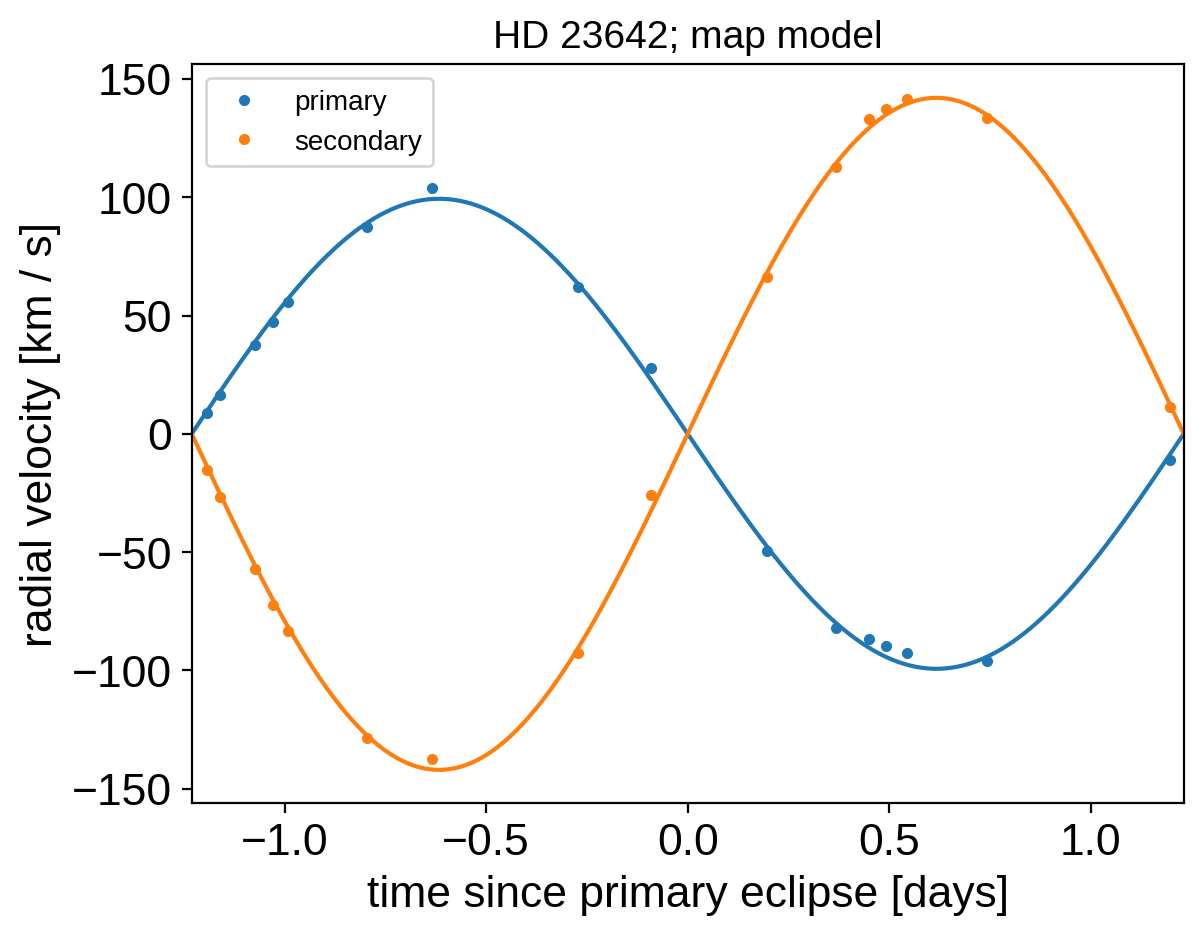

In [7]:
period = map_soln["period"]
t0 = map_soln["t0"]
mean = map_soln["mean_rv"]

x_fold = (x_rv - t0 + 0.5 * period) % period - 0.5 * period
plt.plot(fold, y1_rv - mean, ".", label="primary")
plt.plot(fold, y2_rv - mean, ".", label="secondary")

x_phase = np.linspace(-0.5 * period, 0.5 * period, 500)
with model:
    y1_mod, y2_mod = xo.eval_in_model(
        [model.model_rv1(x_phase + t0), model.model_rv2(x_phase + t0)], map_soln
    )
plt.plot(x_phase, y1_mod - mean, "C0")
plt.plot(x_phase, y2_mod - mean, "C1")

plt.legend(fontsize=10)
plt.xlim(-0.5 * period, 0.5 * period)
plt.ylabel("radial velocity [km / s]")
plt.xlabel("time since primary eclipse [days]")
_ = plt.title("HD 23642; map model", fontsize=14)

And then the light curve.
In the top panel, we show the Gaussian process model for the phase curve.
It's clear that there's a lot of information there that we could take advantage of, but that's a topic for another day.
In the bottom panel, we're plotting the phase folded light curve and we can see the ridiculous signal to noise that we're getting on the eclipses.

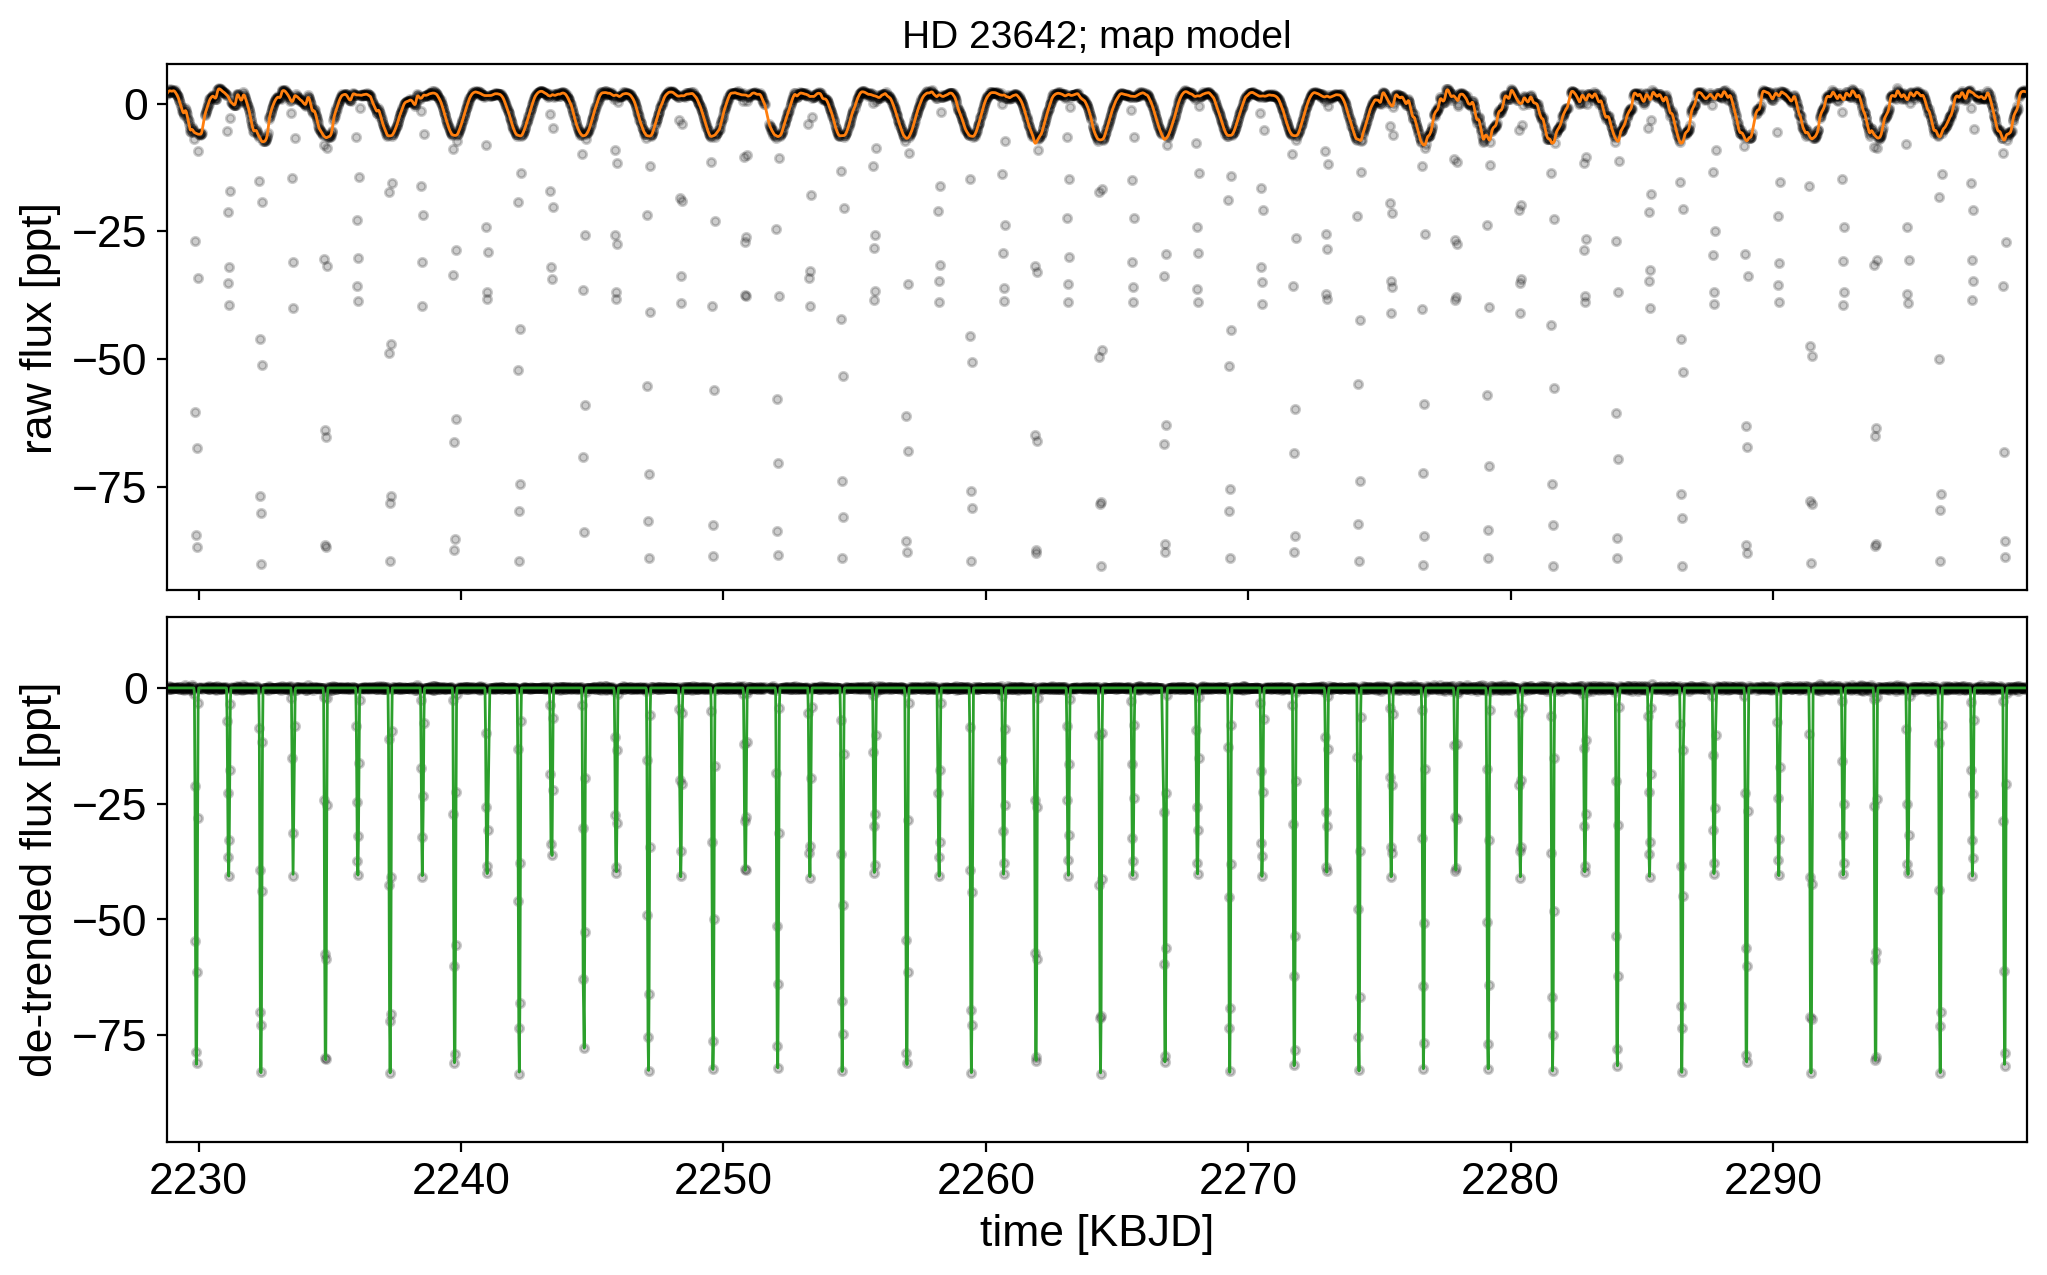

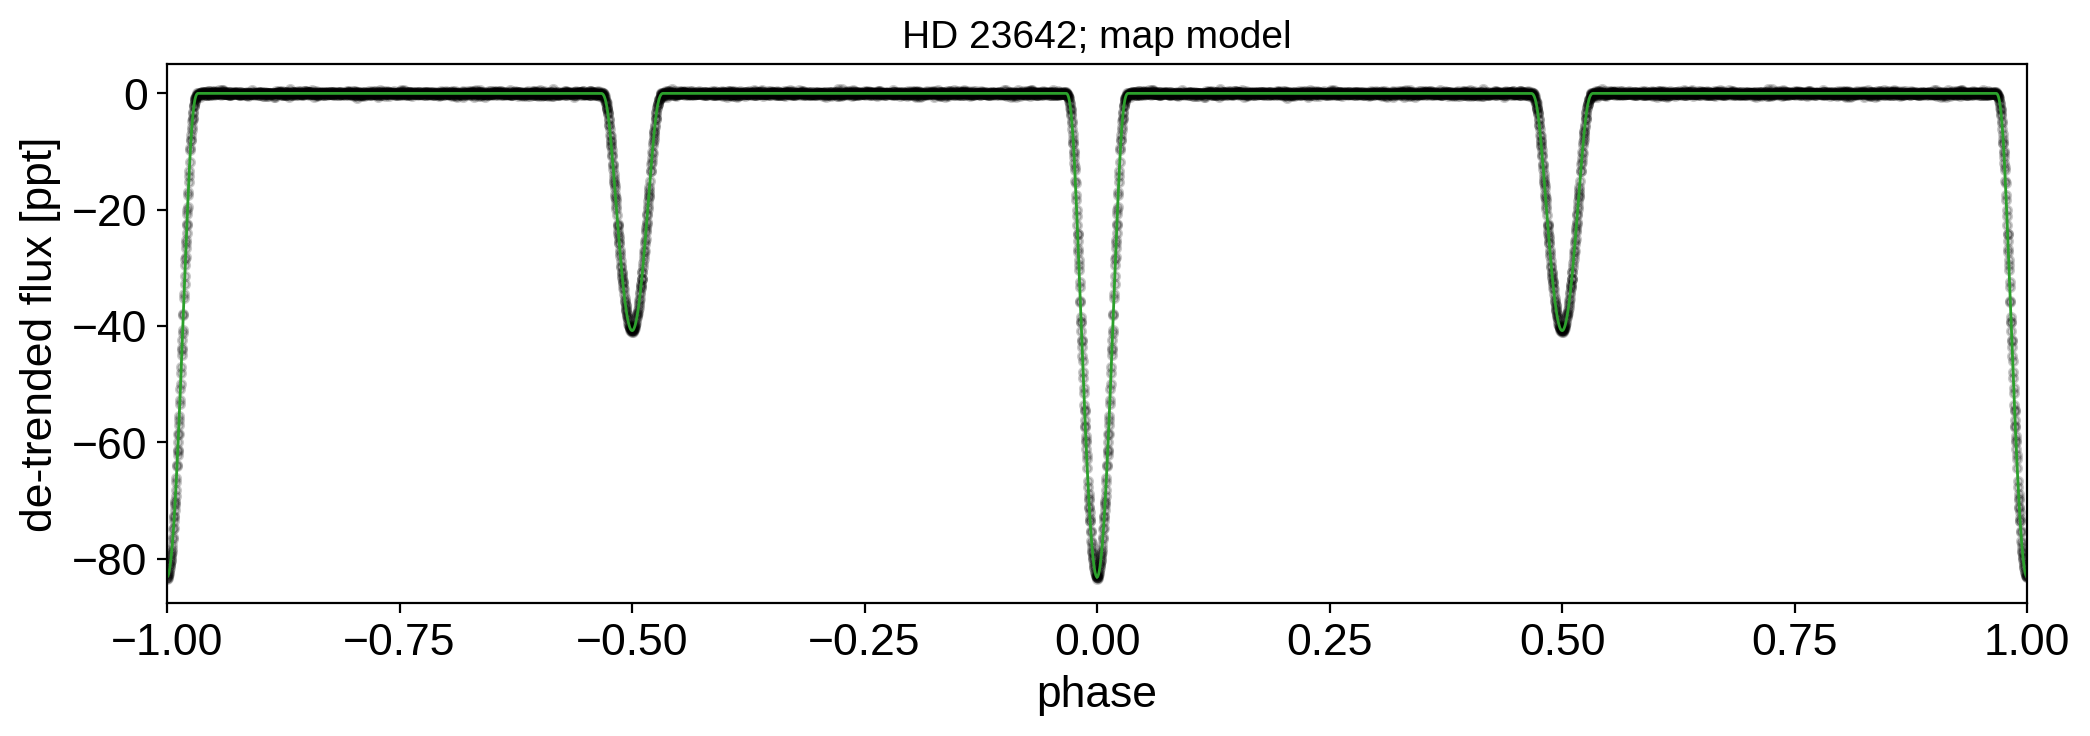

In [8]:
with model:
    gp_pred = xo.eval_in_model(model.gp_lc.predict(), map_soln) + map_soln["mean_lc"]
    lc = xo.eval_in_model(model.model_lc(model.x), map_soln) - map_soln["mean_lc"]

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 7))

ax1.plot(model.x, model.y, "k.", alpha=0.2)
ax1.plot(model.x, gp_pred, color="C1", lw=1)

ax2.plot(model.x, model.y - gp_pred, "k.", alpha=0.2)
ax2.plot(model.x, lc, color="C2", lw=1)
ax2.set_xlim(model.x.min(), model.x.max())

ax1.set_ylabel("raw flux [ppt]")
ax2.set_ylabel("de-trended flux [ppt]")
ax2.set_xlabel("time [KBJD]")
ax1.set_title("HD 23642; map model", fontsize=14)

fig.subplots_adjust(hspace=0.05)

fig, ax1 = plt.subplots(1, figsize=(12, 3.5))

x_fold = (model.x - map_soln["t0"]) % map_soln["period"] / map_soln["period"]
inds = np.argsort(x_fold)

ax1.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax1.plot(x_fold[inds] - 1, model.y[inds] - gp_pred[inds], "k.", alpha=0.2)
ax2.plot(x_fold[inds], model.y[inds] - gp_pred[inds], "k.", alpha=0.2, label="data!")
ax2.plot(x_fold[inds] - 1, model.y[inds] - gp_pred, "k.", alpha=0.2)

yval = model.y[inds] - gp_pred
bins = np.linspace(0, 1, 75)
num, _ = np.histogram(x_fold[inds], bins, weights=yval)
denom, _ = np.histogram(x_fold[inds], bins)
ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

args = dict(lw=1)

ax1.plot(x_fold[inds], lc[inds], "C2", **args)
ax1.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

ax1.set_xlim(-1, 1)
ax1.set_ylabel("de-trended flux [ppt]")
ax1.set_xlabel("phase")
_ = ax1.set_title("HD 23642; map model", fontsize=14)

## Sampling

Finally we can run the MCMC:

In [9]:
np.random.seed(23642)
with model:
    trace = xo.sample(
        tune=3500, draws=3000, start=map_soln, chains=4, target_accept=0.95
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [ell_rv, S_tot_rv, sigma_rv2, sigma_rv1, ell_lc, S_tot_lc, sigma_lc, ecs, t0, period, b, s, q, k, R1, M1, u2, u1, mean_rv, mean_lc]


Sampling 4 chains, 0 divergences:   0%|          | 0/26000 [00:00<?, ?draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 21/26000 [00:01<30:24, 14.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 23/26000 [00:01<37:02, 11.69draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 25/26000 [00:03<1:50:49,  3.91draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 29/26000 [00:04<1:59:41,  3.62draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 30/26000 [00:04<1:42:00,  4.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 33/26000 [00:05<2:03:27,  3.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 34/26000 [00:05<1:55:56,  3.73draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 36/26000 [00:06<1:29:42,  4.82draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 37/26000 [00:06<2:57:54,  2.43draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 38/26000 [00:07<2:55:18,  2.47draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 40/26000 [00:07<2:23:40,  3.01draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 41/26000 [00:08<2:56:25,  2.45draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 42/26000 [00:08<2:49:22,  2.55draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 43/26000 [00:08<2:17:51,  3.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 44/26000 [00:09<2:53:31,  2.49draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 45/26000 [00:09<2:34:16,  2.80draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 46/26000 [00:09<2:35:54,  2.77draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 47/26000 [00:10<2:06:48,  3.41draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 48/26000 [00:10<2:54:27,  2.48draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 49/26000 [00:10<2:15:29,  3.19draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 50/26000 [00:11<2:33:11,  2.82draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 51/26000 [00:11<2:03:08,  3.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 52/26000 [00:12<2:59:19,  2.41draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 54/26000 [00:12<2:39:02,  2.72draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 56/26000 [00:13<2:50:53,  2.53draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 58/26000 [00:14<2:37:49,  2.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 60/26000 [00:14<2:43:00,  2.65draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 61/26000 [00:15<2:27:59,  2.92draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 62/26000 [00:15<2:37:54,  2.74draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 64/26000 [00:16<2:38:40,  2.72draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 65/26000 [00:16<2:13:20,  3.24draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 66/26000 [00:17<2:45:36,  2.61draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 67/26000 [00:17<2:17:28,  3.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 68/26000 [00:17<2:46:55,  2.59draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 69/26000 [00:17<2:11:52,  3.28draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 70/26000 [00:18<2:55:50,  2.46draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 72/26000 [00:19<2:43:10,  2.65draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 73/26000 [00:19<2:42:36,  2.66draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 74/26000 [00:19<2:36:45,  2.76draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 75/26000 [00:20<2:18:07,  3.13draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 76/26000 [00:20<2:48:36,  2.56draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 77/26000 [00:21<3:07:03,  2.31draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 79/26000 [00:21<2:45:37,  2.61draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 80/26000 [00:22<2:33:34,  2.81draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 81/26000 [00:22<2:57:35,  2.43draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 82/26000 [00:22<2:21:28,  3.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 83/26000 [00:23<2:29:50,  2.88draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 84/26000 [00:23<2:57:49,  2.43draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 85/26000 [00:23<2:33:11,  2.82draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 86/26000 [00:24<2:17:20,  3.14draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 87/26000 [00:24<2:16:12,  3.17draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 88/26000 [00:25<3:30:07,  2.06draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 90/26000 [00:25<2:36:24,  2.76draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 91/26000 [00:26<3:10:00,  2.27draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 92/26000 [00:26<3:30:06,  2.06draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 93/26000 [00:26<2:58:40,  2.42draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 95/26000 [00:27<2:49:07,  2.55draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 96/26000 [00:28<3:25:00,  2.11draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 97/26000 [00:28<3:01:06,  2.38draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 99/26000 [00:28<2:27:06,  2.93draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 100/26000 [00:29<3:30:52,  2.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 101/26000 [00:29<2:58:33,  2.42draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 102/26000 [00:30<2:22:12,  3.04draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 103/26000 [00:30<2:14:53,  3.20draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 104/26000 [00:31<3:08:54,  2.28draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 105/26000 [00:31<2:56:32,  2.44draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 106/26000 [00:31<2:21:25,  3.05draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 107/26000 [00:31<2:07:43,  3.38draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 108/26000 [00:32<2:58:57,  2.41draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 109/26000 [00:32<2:58:55,  2.41draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 111/26000 [00:33<2:19:25,  3.09draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 112/26000 [00:33<3:17:47,  2.18draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 113/26000 [00:34<3:11:07,  2.26draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 115/26000 [00:34<2:27:44,  2.92draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 116/26000 [00:35<3:16:18,  2.20draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 117/26000 [00:35<3:04:16,  2.34draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 118/26000 [00:35<2:29:12,  2.89draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 119/26000 [00:35<2:03:34,  3.49draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 120/26000 [00:36<2:51:49,  2.51draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 122/26000 [00:37<2:33:45,  2.81draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 123/26000 [00:37<2:06:34,  3.41draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 124/26000 [00:37<1:58:41,  3.63draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 125/26000 [00:37<2:23:06,  3.01draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 126/26000 [00:38<3:01:48,  2.37draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 128/26000 [00:38<2:26:19,  2.95draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 129/26000 [00:39<3:00:19,  2.39draws/s]

Sampling 4 chains, 0 divergences:   0%|          | 130/26000 [00:40<3:39:42,  1.96draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 131/26000 [00:40<2:46:44,  2.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 132/26000 [00:40<2:25:19,  2.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 133/26000 [00:40<2:20:13,  3.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 134/26000 [00:41<3:34:16,  2.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 135/26000 [00:41<2:59:49,  2.40draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 137/26000 [00:42<2:33:08,  2.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 138/26000 [00:43<3:15:33,  2.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 139/26000 [00:43<2:41:14,  2.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 141/26000 [00:43<2:30:48,  2.86draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 142/26000 [00:44<3:42:32,  1.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 143/26000 [00:44<3:00:34,  2.39draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 145/26000 [00:45<2:25:00,  2.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 146/26000 [00:46<3:42:36,  1.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 147/26000 [00:46<3:09:19,  2.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 149/26000 [00:46<2:35:49,  2.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 150/26000 [00:47<3:15:18,  2.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 151/26000 [00:47<2:58:38,  2.41draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 153/26000 [00:48<2:48:41,  2.55draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 154/26000 [00:48<2:41:16,  2.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 155/26000 [00:48<2:25:55,  2.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 157/26000 [00:49<2:35:51,  2.76draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 158/26000 [00:50<2:22:42,  3.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 159/26000 [00:50<2:33:20,  2.81draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 161/26000 [00:51<2:37:10,  2.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 162/26000 [00:51<2:10:26,  3.30draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 163/26000 [00:51<2:31:17,  2.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 164/26000 [00:52<2:15:04,  3.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 165/26000 [00:52<2:41:01,  2.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 166/26000 [00:52<2:09:54,  3.31draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 167/26000 [00:53<2:29:57,  2.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 168/26000 [00:53<2:23:01,  3.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 169/26000 [00:54<2:44:52,  2.61draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 170/26000 [00:54<2:13:36,  3.22draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 171/26000 [00:54<2:41:12,  2.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 172/26000 [00:55<2:37:03,  2.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 173/26000 [00:55<2:58:12,  2.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 175/26000 [00:56<2:50:00,  2.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 176/26000 [00:56<2:24:11,  2.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 178/26000 [00:57<2:17:24,  3.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 179/26000 [00:57<1:56:22,  3.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 180/26000 [00:57<2:50:35,  2.52draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 182/26000 [00:58<2:39:50,  2.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 183/26000 [00:58<2:14:25,  3.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 184/26000 [00:59<2:51:22,  2.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 185/26000 [00:59<2:19:58,  3.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 186/26000 [00:59<2:43:02,  2.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 187/26000 [01:00<2:39:39,  2.69draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 188/26000 [01:00<2:34:46,  2.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 189/26000 [01:00<2:12:53,  3.24draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 190/26000 [01:01<2:29:10,  2.88draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 191/26000 [01:01<2:54:16,  2.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 192/26000 [01:01<2:24:40,  2.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 193/26000 [01:02<2:13:53,  3.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 194/26000 [01:02<2:26:40,  2.93draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 195/26000 [01:03<2:46:57,  2.58draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 196/26000 [01:03<2:26:26,  2.94draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 197/26000 [01:03<2:22:44,  3.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 198/26000 [01:04<3:04:25,  2.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 199/26000 [01:04<2:36:37,  2.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 200/26000 [01:04<2:02:34,  3.51draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 202/26000 [01:04<1:48:26,  3.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 204/26000 [01:05<2:15:41,  3.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 206/26000 [01:06<1:43:58,  4.13draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 208/26000 [01:06<1:35:45,  4.49draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 209/26000 [01:07<3:10:31,  2.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 210/26000 [01:07<2:31:44,  2.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 213/26000 [01:07<1:55:26,  3.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 214/26000 [01:08<3:45:11,  1.91draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 216/26000 [01:08<2:49:09,  2.54draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 218/26000 [01:10<3:20:29,  2.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 220/26000 [01:10<2:27:08,  2.92draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 221/26000 [01:10<2:02:48,  3.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 222/26000 [01:11<3:49:45,  1.87draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 223/26000 [01:11<3:04:30,  2.33draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 225/26000 [01:12<2:22:14,  3.02draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 226/26000 [01:12<3:36:17,  1.99draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 227/26000 [01:13<3:29:32,  2.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 229/26000 [01:13<2:33:22,  2.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 230/26000 [01:14<3:34:07,  2.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 231/26000 [01:14<3:37:54,  1.97draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 232/26000 [01:15<2:54:08,  2.47draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 234/26000 [01:15<2:54:34,  2.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 235/26000 [01:16<3:08:05,  2.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 236/26000 [01:16<2:42:47,  2.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 237/26000 [01:16<2:07:36,  3.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 238/26000 [01:17<2:43:24,  2.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 239/26000 [01:17<2:46:30,  2.58draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 240/26000 [01:18<2:54:47,  2.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 241/26000 [01:18<2:23:00,  3.00draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 242/26000 [01:18<2:42:38,  2.64draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 243/26000 [01:19<2:39:09,  2.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 244/26000 [01:19<2:56:33,  2.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 246/26000 [01:20<2:54:40,  2.46draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 248/26000 [01:20<2:38:56,  2.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 249/26000 [01:21<2:24:14,  2.98draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 250/26000 [01:21<2:57:15,  2.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 251/26000 [01:22<2:31:28,  2.83draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 252/26000 [01:22<2:35:50,  2.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 253/26000 [01:22<2:43:14,  2.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 254/26000 [01:23<2:45:40,  2.59draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 255/26000 [01:23<2:39:55,  2.68draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 256/26000 [01:23<2:16:34,  3.14draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 257/26000 [01:24<2:55:52,  2.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 258/26000 [01:24<2:55:06,  2.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 259/26000 [01:24<2:20:38,  3.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 260/26000 [01:25<1:56:49,  3.67draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 261/26000 [01:25<2:36:26,  2.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 262/26000 [01:26<3:13:40,  2.21draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 263/26000 [01:26<2:34:10,  2.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 264/26000 [01:26<2:08:22,  3.34draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 265/26000 [01:27<2:34:18,  2.78draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 266/26000 [01:27<3:33:01,  2.01draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 268/26000 [01:28<2:36:38,  2.74draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 269/26000 [01:28<2:33:43,  2.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 270/26000 [01:29<3:51:18,  1.85draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 272/26000 [01:29<2:55:41,  2.44draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 273/26000 [01:29<2:19:33,  3.07draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 274/26000 [01:30<3:59:21,  1.79draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 276/26000 [01:30<2:57:09,  2.42draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 277/26000 [01:31<2:51:18,  2.50draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 278/26000 [01:32<3:52:35,  1.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 280/26000 [01:32<3:02:24,  2.35draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 281/26000 [01:33<3:10:05,  2.25draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 282/26000 [01:33<3:17:32,  2.17draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 283/26000 [01:33<2:32:54,  2.80draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 284/26000 [01:33<2:19:09,  3.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 285/26000 [01:34<2:49:09,  2.53draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 286/26000 [01:35<3:15:07,  2.20draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 288/26000 [01:35<2:37:47,  2.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 289/26000 [01:35<3:09:54,  2.26draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 290/26000 [01:36<3:06:43,  2.29draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 292/26000 [01:36<2:41:19,  2.66draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 293/26000 [01:37<3:29:06,  2.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 294/26000 [01:37<2:42:37,  2.63draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 296/26000 [01:38<2:27:30,  2.90draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 297/26000 [01:39<3:24:32,  2.09draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 298/26000 [01:39<2:46:32,  2.57draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 299/26000 [01:39<2:20:00,  3.06draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 300/26000 [01:39<2:00:18,  3.56draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 301/26000 [01:40<3:07:37,  2.28draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 302/26000 [01:40<2:36:48,  2.73draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 303/26000 [01:40<2:28:23,  2.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 305/26000 [01:41<2:35:56,  2.75draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 306/26000 [01:42<2:28:25,  2.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 307/26000 [01:42<2:20:34,  3.05draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 309/26000 [01:43<2:38:19,  2.70draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 310/26000 [01:43<2:30:34,  2.84draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 311/26000 [01:43<2:04:47,  3.43draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 313/26000 [01:44<2:34:45,  2.77draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 315/26000 [01:45<2:07:29,  3.36draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 316/26000 [01:45<1:50:02,  3.89draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 317/26000 [01:46<3:15:32,  2.19draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 318/26000 [01:46<2:37:37,  2.72draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 319/26000 [01:46<2:25:10,  2.95draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 320/26000 [01:46<2:18:58,  3.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 321/26000 [01:47<2:54:58,  2.45draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 322/26000 [01:47<2:21:27,  3.03draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 323/26000 [01:47<2:19:04,  3.08draws/s]

Sampling 4 chains, 0 divergences:   1%|          | 324/26000 [01:48<2:22:33,  3.00draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 325/26000 [01:48<2:33:46,  2.78draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 327/26000 [01:48<2:00:07,  3.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 328/26000 [01:49<2:55:53,  2.43draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 329/26000 [01:49<2:50:53,  2.50draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 330/26000 [01:50<2:28:49,  2.87draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 331/26000 [01:50<1:58:43,  3.60draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 332/26000 [01:50<2:25:04,  2.95draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 333/26000 [01:51<3:15:20,  2.19draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 334/26000 [01:51<2:31:35,  2.82draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 336/26000 [01:52<2:15:42,  3.15draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 337/26000 [01:52<3:05:25,  2.31draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 338/26000 [01:53<2:34:46,  2.76draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 339/26000 [01:53<2:35:49,  2.74draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 341/26000 [01:54<2:32:42,  2.80draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 342/26000 [01:54<2:39:29,  2.68draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 343/26000 [01:54<2:22:21,  3.00draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 345/26000 [01:55<2:24:39,  2.96draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 347/26000 [01:55<2:08:06,  3.34draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 348/26000 [01:56<2:10:27,  3.28draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 349/26000 [01:56<2:53:08,  2.47draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 350/26000 [01:57<2:50:45,  2.50draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 352/26000 [01:57<2:29:01,  2.87draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 353/26000 [01:58<2:47:06,  2.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 354/26000 [01:58<2:57:26,  2.41draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 355/26000 [01:58<2:24:00,  2.97draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 356/26000 [01:59<2:37:40,  2.71draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 357/26000 [01:59<2:33:46,  2.78draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 358/26000 [02:00<3:00:15,  2.37draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 359/26000 [02:00<2:21:50,  3.01draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 360/26000 [02:00<2:25:44,  2.93draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 361/26000 [02:00<2:09:28,  3.30draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 362/26000 [02:01<2:54:17,  2.45draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 363/26000 [02:01<2:27:21,  2.90draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 364/26000 [02:01<2:15:53,  3.14draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 366/26000 [02:02<1:46:21,  4.02draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 367/26000 [02:02<3:00:19,  2.37draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 368/26000 [02:03<2:58:05,  2.40draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 370/26000 [02:03<2:16:21,  3.13draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 371/26000 [02:04<3:23:39,  2.10draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 372/26000 [02:04<3:03:58,  2.32draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 374/26000 [02:04<2:22:52,  2.99draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 375/26000 [02:05<3:31:30,  2.02draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 376/26000 [02:05<2:55:36,  2.43draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 378/26000 [02:06<2:24:43,  2.95draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 379/26000 [02:07<3:38:17,  1.96draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 380/26000 [02:07<2:48:35,  2.53draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 381/26000 [02:07<2:15:57,  3.14draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 382/26000 [02:07<1:51:26,  3.83draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 384/26000 [02:07<1:32:08,  4.63draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 385/26000 [02:08<2:46:32,  2.56draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 386/26000 [02:08<2:39:20,  2.68draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 388/26000 [02:09<2:14:01,  3.18draws/s]

Sampling 4 chains, 0 divergences:   1%|▏         | 389/26000 [02:09<2:58:46,  2.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 390/26000 [02:10<2:24:36,  2.95draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 391/26000 [02:10<2:11:29,  3.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 393/26000 [02:10<1:59:18,  3.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 394/26000 [02:11<2:13:35,  3.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 395/26000 [02:11<2:29:51,  2.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 396/26000 [02:11<2:02:53,  3.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 398/26000 [02:12<2:36:23,  2.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 400/26000 [02:13<2:08:13,  3.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 403/26000 [02:14<2:21:26,  3.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 405/26000 [02:14<1:55:15,  3.70draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 408/26000 [02:15<1:53:41,  3.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 409/26000 [02:15<2:14:01,  3.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 410/26000 [02:16<2:03:37,  3.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 411/26000 [02:16<1:50:44,  3.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 412/26000 [02:16<2:21:39,  3.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 414/26000 [02:17<2:20:48,  3.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 417/26000 [02:17<2:00:48,  3.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 418/26000 [02:18<2:14:15,  3.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 419/26000 [02:18<2:48:59,  2.52draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 421/26000 [02:19<2:31:44,  2.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 422/26000 [02:19<2:10:01,  3.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 423/26000 [02:19<1:59:30,  3.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 424/26000 [02:20<2:27:51,  2.88draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 425/26000 [02:20<2:05:28,  3.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 426/26000 [02:20<2:01:31,  3.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 427/26000 [02:20<1:41:04,  4.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 428/26000 [02:21<2:21:35,  3.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 429/26000 [02:21<2:11:20,  3.24draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 431/26000 [02:21<1:45:50,  4.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 432/26000 [02:22<2:04:10,  3.43draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 433/26000 [02:23<2:56:59,  2.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 434/26000 [02:23<2:17:06,  3.11draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 436/26000 [02:23<1:53:43,  3.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 437/26000 [02:23<2:05:20,  3.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 438/26000 [02:23<1:50:30,  3.86draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 439/26000 [02:24<1:42:55,  4.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 440/26000 [02:24<1:41:36,  4.19draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 442/26000 [02:24<1:23:56,  5.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 443/26000 [02:24<1:15:44,  5.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 444/26000 [02:25<3:07:05,  2.28draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 446/26000 [02:25<2:26:31,  2.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 447/26000 [02:26<2:07:57,  3.33draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 449/26000 [02:27<2:38:23,  2.69draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 450/26000 [02:27<2:14:48,  3.16draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 452/26000 [02:27<1:45:46,  4.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 453/26000 [02:27<1:44:29,  4.07draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 455/26000 [02:28<2:16:34,  3.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 456/26000 [02:29<1:57:32,  3.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 457/26000 [02:29<1:38:10,  4.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 458/26000 [02:29<1:53:44,  3.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 459/26000 [02:29<1:53:32,  3.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 460/26000 [02:30<2:04:59,  3.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 462/26000 [02:30<1:41:01,  4.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 463/26000 [02:30<2:34:14,  2.76draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 464/26000 [02:31<2:31:21,  2.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 465/26000 [02:31<2:13:04,  3.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 466/26000 [02:31<1:57:08,  3.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 467/26000 [02:32<3:05:19,  2.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 468/26000 [02:32<2:31:37,  2.81draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 470/26000 [02:32<1:56:25,  3.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 471/26000 [02:33<3:03:08,  2.32draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 472/26000 [02:34<2:51:03,  2.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 473/26000 [02:34<2:34:51,  2.75draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 475/26000 [02:34<2:12:34,  3.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 476/26000 [02:34<2:15:08,  3.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 477/26000 [02:35<1:55:56,  3.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 478/26000 [02:35<2:04:23,  3.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 479/26000 [02:35<1:46:43,  3.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 480/26000 [02:35<1:29:07,  4.77draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 481/26000 [02:36<1:51:28,  3.82draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 482/26000 [02:36<1:58:54,  3.58draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 484/26000 [02:36<1:34:36,  4.50draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 485/26000 [02:36<1:50:49,  3.84draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 486/26000 [02:37<1:57:13,  3.63draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 488/26000 [02:37<1:33:02,  4.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 489/26000 [02:38<2:25:53,  2.91draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 490/26000 [02:38<2:14:46,  3.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 491/26000 [02:38<1:57:59,  3.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 492/26000 [02:38<1:57:55,  3.61draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 493/26000 [02:38<1:37:09,  4.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 494/26000 [02:39<2:24:41,  2.94draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 495/26000 [02:39<2:02:23,  3.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 496/26000 [02:40<2:14:45,  3.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 497/26000 [02:40<2:10:35,  3.25draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 499/26000 [02:40<1:41:09,  4.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 500/26000 [02:40<1:43:43,  4.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 502/26000 [02:41<2:05:59,  3.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 503/26000 [02:41<1:53:41,  3.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 504/26000 [02:41<1:40:50,  4.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 505/26000 [02:42<1:24:08,  5.05draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 506/26000 [02:42<1:31:17,  4.65draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 507/26000 [02:42<2:16:00,  3.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 508/26000 [02:43<2:11:28,  3.23draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 509/26000 [02:43<1:55:19,  3.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 510/26000 [02:43<2:04:23,  3.42draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 511/26000 [02:44<2:53:32,  2.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 512/26000 [02:44<2:17:05,  3.10draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 513/26000 [02:44<2:08:26,  3.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 514/26000 [02:44<1:50:47,  3.83draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 516/26000 [02:45<1:27:32,  4.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 517/26000 [02:45<1:29:44,  4.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 519/26000 [02:45<1:16:49,  5.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 520/26000 [02:45<1:17:42,  5.46draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 521/26000 [02:46<2:26:34,  2.90draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 522/26000 [02:46<2:00:07,  3.53draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 523/26000 [02:46<2:11:59,  3.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 524/26000 [02:47<1:55:33,  3.67draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 526/26000 [02:47<1:29:51,  4.72draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 528/26000 [02:47<1:15:00,  5.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 529/26000 [02:47<1:45:37,  4.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 530/26000 [02:48<1:36:17,  4.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 531/26000 [02:48<2:40:39,  2.64draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 533/26000 [02:49<2:19:53,  3.03draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 534/26000 [02:49<1:58:23,  3.59draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 535/26000 [02:49<1:36:35,  4.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 538/26000 [02:49<1:24:16,  5.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 539/26000 [02:50<1:42:56,  4.12draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 541/26000 [02:50<1:23:55,  5.06draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 542/26000 [02:50<1:45:35,  4.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 544/26000 [02:51<1:30:43,  4.68draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 546/26000 [02:51<1:18:23,  5.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 547/26000 [02:51<1:26:15,  4.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 548/26000 [02:51<1:18:55,  5.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 549/26000 [02:51<1:08:26,  6.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 550/26000 [02:51<1:02:58,  6.74draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 552/26000 [02:52<57:50,  7.33draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 553/26000 [02:52<1:08:23,  6.20draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 555/26000 [02:52<57:13,  7.41draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 556/26000 [02:52<1:29:38,  4.73draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 557/26000 [02:53<1:38:37,  4.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 558/26000 [02:53<1:22:22,  5.15draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 559/26000 [02:53<1:11:08,  5.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 560/26000 [02:53<2:00:49,  3.51draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 561/26000 [02:54<2:13:36,  3.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 562/26000 [02:54<2:01:55,  3.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 563/26000 [02:54<1:38:28,  4.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 565/26000 [02:54<1:25:16,  4.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 566/26000 [02:55<2:21:40,  2.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 567/26000 [02:55<2:32:18,  2.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 570/26000 [02:56<1:52:08,  3.78draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 571/26000 [02:56<1:45:49,  4.00draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 573/26000 [02:56<1:21:47,  5.18draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 575/26000 [02:56<1:05:40,  6.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 577/26000 [02:57<1:32:44,  4.57draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 579/26000 [02:57<1:17:19,  5.48draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 580/26000 [02:58<2:01:33,  3.49draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 582/26000 [02:58<1:36:28,  4.39draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 583/26000 [02:58<1:51:53,  3.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 584/26000 [02:58<1:51:49,  3.79draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 586/26000 [02:59<2:04:17,  3.41draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 589/26000 [03:00<1:46:01,  3.99draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 590/26000 [03:00<1:45:14,  4.02draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 591/26000 [03:00<1:36:43,  4.38draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 592/26000 [03:00<1:27:17,  4.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 593/26000 [03:00<1:40:35,  4.21draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 596/26000 [03:01<1:18:52,  5.37draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 597/26000 [03:01<1:32:01,  4.60draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 599/26000 [03:01<1:17:25,  5.47draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 602/26000 [03:01<1:10:54,  5.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 603/26000 [03:02<1:22:23,  5.14draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 604/26000 [03:02<1:55:41,  3.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 606/26000 [03:02<1:31:36,  4.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 607/26000 [03:02<1:19:38,  5.31draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 609/26000 [03:03<1:10:49,  5.97draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 610/26000 [03:03<1:10:26,  6.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 612/26000 [03:03<1:00:45,  6.96draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 614/26000 [03:03<53:36,  7.89draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 615/26000 [03:03<59:00,  7.17draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 616/26000 [03:04<1:10:00,  6.04draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 618/26000 [03:04<1:01:45,  6.85draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 619/26000 [03:04<1:01:36,  6.87draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 620/26000 [03:04<56:11,  7.53draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 621/26000 [03:04<1:21:04,  5.22draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 623/26000 [03:05<1:03:53,  6.62draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 625/26000 [03:05<58:54,  7.18draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 626/26000 [03:05<57:08,  7.40draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 628/26000 [03:05<57:36,  7.34draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 630/26000 [03:05<51:10,  8.26draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 632/26000 [03:06<53:23,  7.92draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 634/26000 [03:06<50:38,  8.35draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 636/26000 [03:06<56:44,  7.45draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 638/26000 [03:06<1:00:20,  7.01draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 640/26000 [03:07<1:03:28,  6.66draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 643/26000 [03:07<49:59,  8.45draws/s]  

Sampling 4 chains, 0 divergences:   2%|▏         | 645/26000 [03:07<41:54, 10.09draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 647/26000 [03:07<41:00, 10.30draws/s]

Sampling 4 chains, 0 divergences:   2%|▏         | 649/26000 [03:08<1:07:14,  6.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 651/26000 [03:08<1:06:56,  6.31draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 653/26000 [03:08<58:27,  7.23draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 655/26000 [03:09<51:58,  8.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 657/26000 [03:09<50:01,  8.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 659/26000 [03:09<55:36,  7.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 660/26000 [03:09<1:07:14,  6.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 661/26000 [03:09<1:07:40,  6.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 663/26000 [03:10<1:17:42,  5.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 665/26000 [03:10<1:07:05,  6.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 666/26000 [03:10<1:20:15,  5.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 667/26000 [03:10<1:09:35,  6.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 669/26000 [03:11<1:11:31,  5.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 671/26000 [03:11<1:05:35,  6.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 672/26000 [03:11<1:24:23,  5.00draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 673/26000 [03:12<1:17:38,  5.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 674/26000 [03:12<1:33:39,  4.51draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 676/26000 [03:12<1:16:50,  5.49draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 678/26000 [03:12<1:03:38,  6.63draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 679/26000 [03:12<1:05:30,  6.44draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 680/26000 [03:13<1:05:57,  6.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 683/26000 [03:13<53:59,  7.82draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 685/26000 [03:13<49:27,  8.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 687/26000 [03:13<1:04:39,  6.53draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 689/26000 [03:14<57:32,  7.33draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 692/26000 [03:14<50:03,  8.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 694/26000 [03:14<56:59,  7.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 696/26000 [03:14<50:56,  8.28draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 697/26000 [03:14<59:21,  7.10draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 698/26000 [03:15<1:03:55,  6.60draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 699/26000 [03:15<1:00:22,  6.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 701/26000 [03:15<54:02,  7.80draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 703/26000 [03:15<45:44,  9.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 705/26000 [03:15<45:09,  9.34draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 708/26000 [03:16<50:08,  8.41draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 709/26000 [03:16<1:03:12,  6.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 710/26000 [03:16<1:05:31,  6.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 713/26000 [03:17<1:05:38,  6.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 715/26000 [03:17<57:52,  7.28draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 718/26000 [03:17<50:21,  8.37draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 719/26000 [03:17<54:53,  7.68draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 721/26000 [03:17<50:58,  8.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 723/26000 [03:18<45:47,  9.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 725/26000 [03:18<47:23,  8.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 726/26000 [03:18<54:11,  7.77draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 728/26000 [03:18<47:32,  8.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 730/26000 [03:18<40:47, 10.33draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 732/26000 [03:18<38:37, 10.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 734/26000 [03:19<1:34:19,  4.46draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 736/26000 [03:20<1:29:03,  4.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 738/26000 [03:20<1:21:13,  5.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 739/26000 [03:20<1:35:07,  4.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 740/26000 [03:21<1:24:31,  4.98draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 741/26000 [03:21<1:40:18,  4.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 743/26000 [03:21<1:23:16,  5.05draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 744/26000 [03:21<1:11:31,  5.89draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 745/26000 [03:21<1:19:52,  5.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 746/26000 [03:22<1:27:29,  4.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 749/26000 [03:22<1:12:09,  5.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 750/26000 [03:22<1:13:50,  5.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 751/26000 [03:22<1:17:09,  5.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 752/26000 [03:22<1:13:32,  5.72draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 754/26000 [03:23<1:08:41,  6.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 755/26000 [03:23<1:34:31,  4.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 757/26000 [03:23<1:12:37,  5.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 759/26000 [03:24<1:26:22,  4.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 761/26000 [03:24<1:08:01,  6.18draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 763/26000 [03:24<1:02:28,  6.73draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 764/26000 [03:25<1:34:50,  4.43draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 766/26000 [03:25<1:33:08,  4.52draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 768/26000 [03:25<1:29:41,  4.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 771/26000 [03:26<1:12:00,  5.84draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 772/26000 [03:26<1:17:07,  5.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 773/26000 [03:26<1:12:38,  5.79draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 774/26000 [03:26<1:04:53,  6.48draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 776/26000 [03:26<52:50,  7.96draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 778/26000 [03:26<45:20,  9.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 780/26000 [03:27<53:11,  7.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 782/26000 [03:27<58:05,  7.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 784/26000 [03:27<1:08:28,  6.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 787/26000 [03:28<52:53,  7.94draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 789/26000 [03:28<58:22,  7.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 791/26000 [03:28<49:43,  8.45draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 793/26000 [03:28<54:34,  7.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 795/26000 [03:29<51:26,  8.17draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 796/26000 [03:29<1:01:34,  6.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 799/26000 [03:29<51:00,  8.23draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 801/26000 [03:29<55:32,  7.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 802/26000 [03:29<1:00:20,  6.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 804/26000 [03:30<50:28,  8.32draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 806/26000 [03:30<43:16,  9.70draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 808/26000 [03:30<1:03:29,  6.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 809/26000 [03:30<1:00:42,  6.92draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 810/26000 [03:31<1:03:33,  6.61draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 811/26000 [03:31<1:05:32,  6.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 812/26000 [03:31<1:27:02,  4.82draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 813/26000 [03:31<1:14:41,  5.62draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 814/26000 [03:31<1:15:25,  5.56draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 815/26000 [03:32<1:19:39,  5.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 816/26000 [03:32<1:22:34,  5.08draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 820/26000 [03:32<1:08:20,  6.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 822/26000 [03:32<58:09,  7.22draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 824/26000 [03:32<50:27,  8.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 826/26000 [03:33<48:16,  8.69draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 828/26000 [03:33<46:17,  9.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 830/26000 [03:33<52:42,  7.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 833/26000 [03:33<50:47,  8.26draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 836/26000 [03:34<47:19,  8.86draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 838/26000 [03:34<40:50, 10.27draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 840/26000 [03:34<43:26,  9.65draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 842/26000 [03:34<37:26, 11.20draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 844/26000 [03:35<51:34,  8.13draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 846/26000 [03:35<46:31,  9.01draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 848/26000 [03:35<42:26,  9.88draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 850/26000 [03:35<58:39,  7.15draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 852/26000 [03:36<54:37,  7.67draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 853/26000 [03:36<56:30,  7.42draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 855/26000 [03:36<51:41,  8.11draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 857/26000 [03:36<46:26,  9.02draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 859/26000 [03:36<42:59,  9.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 861/26000 [03:37<51:29,  8.14draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 862/26000 [03:37<1:10:25,  5.95draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 863/26000 [03:37<1:03:31,  6.59draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 865/26000 [03:37<1:10:55,  5.91draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 866/26000 [03:38<1:05:29,  6.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 867/26000 [03:38<1:17:44,  5.39draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 869/26000 [03:38<1:19:56,  5.24draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 871/26000 [03:38<1:06:37,  6.29draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 872/26000 [03:39<1:14:12,  5.64draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 873/26000 [03:39<1:12:03,  5.81draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 874/26000 [03:39<1:12:47,  5.75draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 875/26000 [03:39<1:15:06,  5.58draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 877/26000 [03:39<1:03:55,  6.55draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 880/26000 [03:40<55:14,  7.58draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 881/26000 [03:40<56:41,  7.38draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 882/26000 [03:40<1:05:25,  6.40draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 884/26000 [03:40<55:05,  7.60draws/s]  

Sampling 4 chains, 0 divergences:   3%|▎         | 885/26000 [03:40<51:50,  8.07draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 889/26000 [03:40<44:12,  9.47draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 891/26000 [03:41<41:21, 10.12draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 893/26000 [03:41<42:22,  9.87draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 895/26000 [03:41<52:22,  7.99draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 897/26000 [03:41<44:53,  9.32draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 899/26000 [03:42<46:11,  9.06draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 901/26000 [03:42<38:37, 10.83draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 903/26000 [03:42<47:00,  8.90draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 905/26000 [03:42<42:00,  9.96draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 907/26000 [03:42<50:53,  8.22draws/s]

Sampling 4 chains, 0 divergences:   3%|▎         | 909/26000 [03:43<48:22,  8.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 911/26000 [03:43<40:25, 10.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 914/26000 [03:43<37:24, 11.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 917/26000 [03:43<38:12, 10.94draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 919/26000 [03:43<43:34,  9.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 921/26000 [03:44<41:37, 10.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 923/26000 [03:44<41:03, 10.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 925/26000 [03:44<39:30, 10.58draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 927/26000 [03:44<47:32,  8.79draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 931/26000 [03:45<39:04, 10.69draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 933/26000 [03:45<41:59,  9.95draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 935/26000 [03:45<43:16,  9.65draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 937/26000 [03:45<42:47,  9.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 939/26000 [03:46<50:32,  8.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 941/26000 [03:46<58:33,  7.13draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 943/26000 [03:46<53:45,  7.77draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 944/26000 [03:46<1:02:09,  6.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 945/26000 [03:46<59:44,  6.99draws/s]  

Sampling 4 chains, 0 divergences:   4%|▎         | 947/26000 [03:47<55:00,  7.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 949/26000 [03:47<49:15,  8.48draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 951/26000 [03:47<45:02,  9.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 953/26000 [03:47<45:13,  9.23draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 954/26000 [03:47<48:06,  8.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 956/26000 [03:47<43:00,  9.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 958/26000 [03:48<39:39, 10.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 960/26000 [03:48<47:48,  8.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 963/26000 [03:48<40:35, 10.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 966/26000 [03:48<36:03, 11.57draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 968/26000 [03:48<35:28, 11.76draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 970/26000 [03:49<36:49, 11.33draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 972/26000 [03:49<35:14, 11.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▎         | 974/26000 [03:49<35:32, 11.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 976/26000 [03:49<37:56, 10.99draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 978/26000 [03:49<33:49, 12.33draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 980/26000 [03:49<30:51, 13.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 982/26000 [03:50<34:13, 12.18draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 984/26000 [03:50<32:47, 12.71draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 986/26000 [03:50<46:44,  8.92draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 988/26000 [03:50<41:07, 10.14draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 990/26000 [03:50<39:01, 10.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 992/26000 [03:51<38:48, 10.74draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 994/26000 [03:51<38:15, 10.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 996/26000 [03:51<36:47, 11.33draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 998/26000 [03:51<36:19, 11.47draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1000/26000 [03:51<35:57, 11.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1002/26000 [03:51<35:50, 11.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1004/26000 [03:52<34:16, 12.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1006/26000 [03:52<36:15, 11.49draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1008/26000 [03:52<33:28, 12.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1010/26000 [03:52<36:11, 11.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1012/26000 [03:52<33:04, 12.59draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1014/26000 [03:52<33:37, 12.38draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1016/26000 [03:53<39:51, 10.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1019/26000 [03:53<35:51, 11.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1022/26000 [03:53<33:31, 12.42draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1024/26000 [03:53<31:25, 13.25draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1026/26000 [03:53<30:42, 13.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1028/26000 [03:54<40:31, 10.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1030/26000 [03:54<42:27,  9.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1032/26000 [03:54<38:05, 10.93draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1034/26000 [03:54<36:50, 11.30draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1036/26000 [03:55<46:55,  8.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1038/26000 [03:55<47:56,  8.68draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1040/26000 [03:55<42:17,  9.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1042/26000 [03:55<37:36, 11.06draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1044/26000 [03:55<42:17,  9.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1047/26000 [03:56<39:22, 10.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1049/26000 [03:56<40:53, 10.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1051/26000 [03:56<39:35, 10.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1053/26000 [03:56<39:50, 10.44draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1055/26000 [03:56<36:19, 11.45draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1057/26000 [03:56<34:55, 11.90draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1059/26000 [03:57<38:23, 10.83draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1061/26000 [03:57<36:53, 11.26draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1063/26000 [03:57<33:14, 12.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1065/26000 [03:57<34:11, 12.15draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1067/26000 [03:57<31:26, 13.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1070/26000 [03:57<31:16, 13.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1073/26000 [03:58<29:04, 14.29draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1075/26000 [03:58<28:56, 14.35draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1077/26000 [03:58<27:27, 15.13draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1079/26000 [03:58<27:38, 15.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1081/26000 [03:58<30:23, 13.67draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1083/26000 [03:58<34:04, 12.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1086/26000 [03:59<30:41, 13.53draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1089/26000 [03:59<29:09, 14.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1091/26000 [03:59<30:45, 13.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1093/26000 [03:59<30:30, 13.61draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1095/26000 [03:59<34:54, 11.89draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1097/26000 [03:59<35:35, 11.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1099/26000 [04:00<35:28, 11.70draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1101/26000 [04:00<41:18, 10.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1103/26000 [04:00<37:09, 11.17draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1105/26000 [04:00<35:42, 11.62draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1107/26000 [04:00<33:53, 12.24draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1109/26000 [04:00<36:23, 11.40draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1111/26000 [04:01<34:27, 12.04draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1113/26000 [04:01<36:47, 11.27draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1115/26000 [04:01<35:20, 11.73draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1117/26000 [04:01<39:15, 10.56draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1119/26000 [04:01<37:50, 10.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1121/26000 [04:02<44:42,  9.28draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1123/26000 [04:02<41:16, 10.05draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1125/26000 [04:02<39:26, 10.51draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1127/26000 [04:02<35:06, 11.81draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1129/26000 [04:02<34:38, 11.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1131/26000 [04:02<34:13, 12.11draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1134/26000 [04:03<31:29, 13.16draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1136/26000 [04:03<35:16, 11.75draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1138/26000 [04:03<35:36, 11.64draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1140/26000 [04:03<36:01, 11.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1143/26000 [04:03<32:34, 12.72draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1145/26000 [04:04<43:22,  9.55draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1147/26000 [04:04<37:33, 11.03draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1149/26000 [04:04<41:35,  9.96draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1152/26000 [04:04<43:36,  9.50draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1154/26000 [04:05<42:04,  9.84draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1156/26000 [04:05<50:33,  8.19draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1158/26000 [04:05<46:26,  8.91draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1160/26000 [04:05<38:50, 10.66draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1162/26000 [04:06<44:56,  9.21draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1164/26000 [04:06<47:01,  8.80draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1166/26000 [04:06<41:56,  9.87draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1168/26000 [04:06<44:10,  9.37draws/s]

Sampling 4 chains, 0 divergences:   4%|▍         | 1170/26000 [04:06<42:07,  9.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1172/26000 [04:07<44:39,  9.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1175/26000 [04:07<41:42,  9.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1177/26000 [04:07<39:31, 10.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1180/26000 [04:07<33:52, 12.21draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1182/26000 [04:07<33:36, 12.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1184/26000 [04:07<30:23, 13.61draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1186/26000 [04:08<35:10, 11.76draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1188/26000 [04:08<34:44, 11.90draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1190/26000 [04:08<37:57, 10.90draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1193/26000 [04:08<35:00, 11.81draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1195/26000 [04:08<33:34, 12.31draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1198/26000 [04:09<30:18, 13.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1200/26000 [04:09<36:44, 11.25draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1202/26000 [04:09<33:52, 12.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1204/26000 [04:09<38:01, 10.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1206/26000 [04:09<35:21, 11.69draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1208/26000 [04:10<41:38,  9.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1210/26000 [04:10<42:52,  9.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1212/26000 [04:10<41:07, 10.05draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1216/26000 [04:10<35:03, 11.78draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1218/26000 [04:10<36:19, 11.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1221/26000 [04:11<36:05, 11.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1223/26000 [04:11<35:32, 11.62draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1227/26000 [04:11<32:39, 12.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1229/26000 [04:11<33:36, 12.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1231/26000 [04:12<54:20,  7.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1233/26000 [04:12<49:02,  8.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1235/26000 [04:12<50:32,  8.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1238/26000 [04:12<43:29,  9.49draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1240/26000 [04:13<45:08,  9.14draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1242/26000 [04:13<43:31,  9.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1244/26000 [04:13<41:43,  9.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1247/26000 [04:13<37:24, 11.03draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1249/26000 [04:13<37:29, 11.00draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1251/26000 [04:14<39:33, 10.43draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1253/26000 [04:14<38:31, 10.71draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1255/26000 [04:14<43:35,  9.46draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1256/26000 [04:14<44:04,  9.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1258/26000 [04:14<44:21,  9.29draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1260/26000 [04:15<43:33,  9.47draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1262/26000 [04:15<41:45,  9.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1264/26000 [04:15<40:19, 10.22draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1266/26000 [04:15<41:40,  9.89draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1268/26000 [04:15<42:56,  9.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1270/26000 [04:15<39:53, 10.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1272/26000 [04:16<35:48, 11.51draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1274/26000 [04:16<39:27, 10.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1276/26000 [04:16<43:10,  9.54draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1278/26000 [04:16<47:27,  8.68draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1279/26000 [04:17<52:38,  7.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1281/26000 [04:17<49:46,  8.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1282/26000 [04:17<59:23,  6.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1284/26000 [04:17<52:18,  7.87draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1286/26000 [04:17<47:38,  8.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1288/26000 [04:18<46:47,  8.80draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1290/26000 [04:18<41:01, 10.04draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1292/26000 [04:18<42:09,  9.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1295/26000 [04:18<38:41, 10.64draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1297/26000 [04:18<39:30, 10.42draws/s]

Sampling 4 chains, 0 divergences:   5%|▍         | 1299/26000 [04:18<34:08, 12.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1301/26000 [04:19<40:28, 10.17draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1304/26000 [04:19<35:08, 11.71draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1306/26000 [04:19<46:34,  8.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1308/26000 [04:20<54:02,  7.61draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1309/26000 [04:20<1:09:06,  5.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1310/26000 [04:20<1:30:32,  4.54draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1311/26000 [04:20<1:23:15,  4.94draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1313/26000 [04:21<1:13:30,  5.60draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1315/26000 [04:21<1:16:17,  5.39draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1318/26000 [04:21<1:01:49,  6.65draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1320/26000 [04:21<53:54,  7.63draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1323/26000 [04:22<53:08,  7.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1325/26000 [04:22<49:18,  8.34draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1327/26000 [04:22<46:27,  8.85draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1328/26000 [04:22<59:20,  6.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1329/26000 [04:23<1:25:07,  4.83draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1331/26000 [04:23<1:08:16,  6.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1332/26000 [04:23<1:27:57,  4.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1334/26000 [04:23<1:19:08,  5.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1335/26000 [04:24<1:09:00,  5.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1336/26000 [04:24<1:23:39,  4.91draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1337/26000 [04:24<1:35:00,  4.33draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1340/26000 [04:24<1:20:57,  5.08draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1342/26000 [04:25<1:17:53,  5.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1345/26000 [04:25<1:09:14,  5.93draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1347/26000 [04:25<1:08:48,  5.97draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1349/26000 [04:26<54:25,  7.55draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1351/26000 [04:26<45:05,  9.11draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1353/26000 [04:26<42:02,  9.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1355/26000 [04:26<36:55, 11.12draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1357/26000 [04:26<36:16, 11.32draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1359/26000 [04:26<40:44, 10.08draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1361/26000 [04:27<45:19,  9.06draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1363/26000 [04:27<41:49,  9.82draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1365/26000 [04:27<50:29,  8.13draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1367/26000 [04:27<42:14,  9.72draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1369/26000 [04:28<51:50,  7.92draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1371/26000 [04:28<51:34,  7.96draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1372/26000 [04:28<50:17,  8.16draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1374/26000 [04:28<54:52,  7.48draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1375/26000 [04:29<1:01:33,  6.67draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1376/26000 [04:29<1:05:53,  6.23draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1378/26000 [04:29<1:02:16,  6.59draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1380/26000 [04:29<55:58,  7.33draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1381/26000 [04:29<1:04:30,  6.36draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1383/26000 [04:30<1:07:29,  6.08draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1386/26000 [04:30<57:12,  7.17draws/s]  

Sampling 4 chains, 0 divergences:   5%|▌         | 1388/26000 [04:30<49:00,  8.37draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1389/26000 [04:30<57:20,  7.15draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1392/26000 [04:31<47:47,  8.58draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1394/26000 [04:31<44:07,  9.30draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1396/26000 [04:31<53:03,  7.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1398/26000 [04:31<46:40,  8.79draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1400/26000 [04:32<52:59,  7.74draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1403/26000 [04:32<52:09,  7.86draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1406/26000 [04:32<43:51,  9.35draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1408/26000 [04:32<44:12,  9.27draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1410/26000 [04:33<49:29,  8.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1411/26000 [04:33<50:01,  8.19draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1413/26000 [04:33<41:39,  9.84draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1415/26000 [04:33<35:49, 11.44draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1417/26000 [04:33<37:35, 10.90draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1419/26000 [04:33<38:11, 10.73draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1421/26000 [04:34<45:26,  9.02draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1423/26000 [04:34<41:56,  9.77draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1425/26000 [04:34<39:50, 10.28draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1427/26000 [04:34<44:31,  9.20draws/s]

Sampling 4 chains, 0 divergences:   5%|▌         | 1429/26000 [04:34<39:48, 10.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1431/26000 [04:34<34:02, 12.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1433/26000 [04:35<34:03, 12.02draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1435/26000 [04:35<35:02, 11.68draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1437/26000 [04:35<34:28, 11.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1439/26000 [04:35<35:30, 11.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1441/26000 [04:35<38:01, 10.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1443/26000 [04:36<34:42, 11.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1445/26000 [04:36<35:03, 11.67draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1447/26000 [04:36<39:48, 10.28draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1449/26000 [04:36<34:33, 11.84draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1451/26000 [04:36<34:51, 11.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1453/26000 [04:36<39:22, 10.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1455/26000 [04:37<40:58,  9.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1457/26000 [04:37<48:38,  8.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1460/26000 [04:37<41:20,  9.89draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1462/26000 [04:38<55:25,  7.38draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1463/26000 [04:38<55:18,  7.39draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1465/26000 [04:38<56:29,  7.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1467/26000 [04:38<1:03:50,  6.41draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1471/26000 [04:39<52:06,  7.85draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1473/26000 [04:39<46:21,  8.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1475/26000 [04:39<45:21,  9.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1477/26000 [04:39<42:59,  9.51draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1479/26000 [04:40<47:56,  8.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1482/26000 [04:40<40:50, 10.00draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1484/26000 [04:40<38:21, 10.65draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1488/26000 [04:40<32:18, 12.64draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1490/26000 [04:40<32:40, 12.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1492/26000 [04:40<29:44, 13.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1494/26000 [04:41<34:33, 11.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1496/26000 [04:41<34:39, 11.78draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1498/26000 [04:41<35:26, 11.52draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1501/26000 [04:41<29:24, 13.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1503/26000 [04:41<34:15, 11.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1505/26000 [04:42<44:17,  9.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1507/26000 [04:42<54:51,  7.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1509/26000 [04:42<1:08:29,  5.96draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1510/26000 [04:43<1:05:05,  6.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1511/26000 [04:43<1:07:40,  6.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1512/26000 [04:43<1:03:11,  6.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1514/26000 [04:43<57:07,  7.14draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1516/26000 [04:43<51:44,  7.89draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1517/26000 [04:43<52:10,  7.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1519/26000 [04:44<50:09,  8.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1520/26000 [04:44<48:21,  8.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1523/26000 [04:44<43:43,  9.33draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1524/26000 [04:44<44:38,  9.14draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1526/26000 [04:44<40:05, 10.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1528/26000 [04:44<39:24, 10.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1530/26000 [04:45<37:30, 10.88draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1532/26000 [04:45<33:11, 12.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1534/26000 [04:45<37:15, 10.94draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1536/26000 [04:45<36:17, 11.24draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1538/26000 [04:45<37:59, 10.73draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1540/26000 [04:46<47:28,  8.59draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1541/26000 [04:46<55:07,  7.40draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1542/26000 [04:46<50:53,  8.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1544/26000 [04:46<51:14,  7.95draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1545/26000 [04:46<56:40,  7.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1546/26000 [04:47<1:05:28,  6.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1548/26000 [04:47<59:31,  6.85draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1549/26000 [04:47<1:03:05,  6.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1551/26000 [04:47<54:58,  7.41draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1552/26000 [04:47<54:48,  7.44draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1555/26000 [04:48<46:36,  8.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1557/26000 [04:48<43:14,  9.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1560/26000 [04:48<36:44, 11.08draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1562/26000 [04:48<36:40, 11.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1564/26000 [04:48<36:12, 11.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1566/26000 [04:48<36:26, 11.17draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1568/26000 [04:49<41:48,  9.74draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1570/26000 [04:49<41:28,  9.82draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1572/26000 [04:49<51:25,  7.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1573/26000 [04:49<56:57,  7.15draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1575/26000 [04:50<48:37,  8.37draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1576/26000 [04:50<54:05,  7.53draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1577/26000 [04:50<52:00,  7.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1578/26000 [04:50<52:14,  7.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1580/26000 [04:50<54:33,  7.46draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1582/26000 [04:50<46:41,  8.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1583/26000 [04:50<45:00,  9.04draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1584/26000 [04:51<59:32,  6.83draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1585/26000 [04:51<1:01:40,  6.60draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1586/26000 [04:51<1:03:22,  6.42draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1589/26000 [04:51<52:10,  7.80draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1590/26000 [04:51<50:59,  7.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1591/26000 [04:52<59:10,  6.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1592/26000 [04:52<1:17:20,  5.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1594/26000 [04:52<1:04:31,  6.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1596/26000 [04:52<58:59,  6.89draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1598/26000 [04:52<47:55,  8.49draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1602/26000 [04:53<40:24, 10.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1604/26000 [04:53<40:13, 10.11draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1607/26000 [04:53<37:54, 10.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1609/26000 [04:53<51:19,  7.92draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1611/26000 [04:54<49:28,  8.22draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1612/26000 [04:54<50:55,  7.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1613/26000 [04:54<1:05:00,  6.25draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1614/26000 [04:54<1:02:34,  6.50draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1616/26000 [04:54<57:09,  7.11draws/s]  

Sampling 4 chains, 0 divergences:   6%|▌         | 1618/26000 [04:55<50:08,  8.10draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1620/26000 [04:55<44:50,  9.06draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1622/26000 [04:55<52:16,  7.77draws/s]

Sampling 4 chains, 0 divergences:   6%|▌         | 1623/26000 [04:55<1:03:55,  6.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1626/26000 [04:56<1:02:00,  6.55draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1627/26000 [04:56<1:03:11,  6.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1628/26000 [04:56<1:04:34,  6.29draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1631/26000 [04:56<51:46,  7.84draws/s]  

Sampling 4 chains, 0 divergences:   6%|▋         | 1633/26000 [04:56<51:36,  7.87draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1635/26000 [04:57<51:20,  7.91draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1638/26000 [04:57<42:41,  9.51draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1640/26000 [04:57<43:25,  9.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1642/26000 [04:57<37:13, 10.90draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1644/26000 [04:57<44:27,  9.13draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1646/26000 [04:58<49:31,  8.20draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1648/26000 [04:58<46:09,  8.79draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1650/26000 [04:58<42:32,  9.54draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1652/26000 [04:58<43:38,  9.30draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1654/26000 [04:59<40:49,  9.94draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1657/26000 [04:59<36:51, 11.01draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1659/26000 [04:59<46:02,  8.81draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1661/26000 [04:59<44:56,  9.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1662/26000 [04:59<46:30,  8.72draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1664/26000 [05:00<47:49,  8.48draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1666/26000 [05:00<48:07,  8.43draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1668/26000 [05:00<42:22,  9.57draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1670/26000 [05:00<45:10,  8.98draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1672/26000 [05:00<39:29, 10.27draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1674/26000 [05:01<45:51,  8.84draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1676/26000 [05:01<49:16,  8.23draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1677/26000 [05:01<1:11:14,  5.69draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1678/26000 [05:01<1:04:46,  6.26draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1679/26000 [05:02<1:03:35,  6.37draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1680/26000 [05:02<1:07:13,  6.03draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1681/26000 [05:02<1:15:39,  5.36draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1683/26000 [05:02<1:03:54,  6.34draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1684/26000 [05:02<1:03:48,  6.35draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1685/26000 [05:03<1:14:20,  5.45draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1687/26000 [05:03<1:18:04,  5.19draws/s]

Sampling 4 chains, 0 divergences:   6%|▋         | 1689/26000 [05:03<1:15:13,  5.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1691/26000 [05:04<1:02:04,  6.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1692/26000 [05:04<56:08,  7.22draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1693/26000 [05:04<52:57,  7.65draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1695/26000 [05:04<47:32,  8.52draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1696/26000 [05:04<59:31,  6.81draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1699/26000 [05:04<56:28,  7.17draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1701/26000 [05:05<1:03:22,  6.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1703/26000 [05:05<1:08:55,  5.88draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1704/26000 [05:05<1:10:24,  5.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1705/26000 [05:06<1:01:58,  6.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1707/26000 [05:06<57:36,  7.03draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1708/26000 [05:06<1:12:54,  5.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1711/26000 [05:06<58:06,  6.97draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1712/26000 [05:06<1:04:52,  6.24draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1714/26000 [05:07<1:04:48,  6.25draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1716/26000 [05:07<53:06,  7.62draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1718/26000 [05:07<49:36,  8.16draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1719/26000 [05:07<1:04:03,  6.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1721/26000 [05:08<56:59,  7.10draws/s]  

Sampling 4 chains, 0 divergences:   7%|▋         | 1723/26000 [05:08<47:44,  8.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1725/26000 [05:08<53:14,  7.60draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1727/26000 [05:08<53:31,  7.56draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1730/26000 [05:08<47:20,  8.55draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1731/26000 [05:09<47:07,  8.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1735/26000 [05:09<42:48,  9.45draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1737/26000 [05:09<37:37, 10.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1739/26000 [05:09<44:21,  9.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1742/26000 [05:10<39:50, 10.15draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1744/26000 [05:10<36:44, 11.00draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1747/26000 [05:10<34:21, 11.77draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1749/26000 [05:10<36:03, 11.21draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1751/26000 [05:10<34:09, 11.83draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1753/26000 [05:10<35:19, 11.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1755/26000 [05:11<41:10,  9.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1757/26000 [05:11<35:23, 11.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1759/26000 [05:11<36:20, 11.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1761/26000 [05:11<34:32, 11.69draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1763/26000 [05:12<43:37,  9.26draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1767/26000 [05:12<40:34,  9.95draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1769/26000 [05:12<35:57, 11.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1771/26000 [05:12<37:08, 10.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1773/26000 [05:12<33:15, 12.14draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1775/26000 [05:12<33:28, 12.06draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1777/26000 [05:13<34:40, 11.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1779/26000 [05:13<34:53, 11.57draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1782/26000 [05:13<31:40, 12.74draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1784/26000 [05:13<35:35, 11.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1786/26000 [05:14<43:42,  9.23draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1788/26000 [05:14<39:52, 10.12draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1790/26000 [05:14<39:50, 10.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1792/26000 [05:14<40:48,  9.89draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1794/26000 [05:14<35:30, 11.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1796/26000 [05:15<44:38,  9.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1798/26000 [05:15<44:47,  9.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1800/26000 [05:15<38:23, 10.51draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1802/26000 [05:15<42:46,  9.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1805/26000 [05:15<42:32,  9.48draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1808/26000 [05:16<34:38, 11.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1810/26000 [05:16<31:48, 12.68draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1813/26000 [05:16<29:29, 13.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1816/26000 [05:16<30:15, 13.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1818/26000 [05:16<29:14, 13.79draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1820/26000 [05:17<41:03,  9.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1822/26000 [05:17<35:22, 11.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1824/26000 [05:17<40:40,  9.91draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1826/26000 [05:17<51:17,  7.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1828/26000 [05:17<45:24,  8.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1830/26000 [05:18<45:26,  8.86draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1832/26000 [05:18<42:02,  9.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1834/26000 [05:18<46:02,  8.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1836/26000 [05:18<38:21, 10.50draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1838/26000 [05:19<42:16,  9.53draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1840/26000 [05:19<52:41,  7.64draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1842/26000 [05:19<46:08,  8.72draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1844/26000 [05:19<45:24,  8.87draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1846/26000 [05:20<54:29,  7.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1848/26000 [05:20<50:50,  7.92draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1849/26000 [05:20<57:11,  7.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1851/26000 [05:20<55:00,  7.32draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1853/26000 [05:20<46:26,  8.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1855/26000 [05:21<44:16,  9.09draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1857/26000 [05:21<42:45,  9.41draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1859/26000 [05:21<37:42, 10.67draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1861/26000 [05:21<32:33, 12.36draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1863/26000 [05:21<35:39, 11.28draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1865/26000 [05:21<34:02, 11.82draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1867/26000 [05:22<46:26,  8.66draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1869/26000 [05:22<39:09, 10.27draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1871/26000 [05:22<43:45,  9.19draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1873/26000 [05:22<41:48,  9.62draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1875/26000 [05:23<42:56,  9.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1877/26000 [05:23<37:31, 10.71draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1879/26000 [05:23<42:07,  9.54draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1881/26000 [05:23<48:28,  8.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1884/26000 [05:23<38:00, 10.58draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1886/26000 [05:24<35:21, 11.37draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1888/26000 [05:24<35:08, 11.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1890/26000 [05:24<36:27, 11.02draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1892/26000 [05:24<34:03, 11.80draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1894/26000 [05:24<38:50, 10.34draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1896/26000 [05:24<37:51, 10.61draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1898/26000 [05:25<38:29, 10.44draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1901/26000 [05:25<32:24, 12.39draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1903/26000 [05:25<40:07, 10.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1905/26000 [05:25<49:02,  8.19draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1907/26000 [05:26<40:46,  9.85draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1909/26000 [05:26<47:25,  8.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1911/26000 [05:26<54:39,  7.35draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1914/26000 [05:26<42:23,  9.47draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1916/26000 [05:27<44:23,  9.04draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1918/26000 [05:27<38:28, 10.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1920/26000 [05:27<39:41, 10.11draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1922/26000 [05:27<37:19, 10.75draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1924/26000 [05:28<54:21,  7.38draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1927/26000 [05:28<44:30,  9.01draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1929/26000 [05:28<47:14,  8.49draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1932/26000 [05:28<38:55, 10.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1934/26000 [05:28<46:57,  8.54draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1936/26000 [05:29<47:27,  8.45draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1938/26000 [05:29<53:58,  7.43draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1940/26000 [05:29<48:16,  8.31draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1941/26000 [05:29<52:43,  7.61draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1944/26000 [05:30<47:35,  8.42draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1945/26000 [05:30<56:16,  7.13draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1946/26000 [05:30<1:03:44,  6.29draws/s]

Sampling 4 chains, 0 divergences:   7%|▋         | 1948/26000 [05:30<50:44,  7.90draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 1950/26000 [05:30<47:37,  8.42draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1952/26000 [05:30<42:39,  9.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1954/26000 [05:31<40:40,  9.85draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1956/26000 [05:31<37:17, 10.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1959/26000 [05:31<43:46,  9.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1962/26000 [05:31<39:13, 10.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1964/26000 [05:32<37:14, 10.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1966/26000 [05:32<35:54, 11.16draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1968/26000 [05:32<41:11,  9.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1970/26000 [05:32<39:21, 10.18draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1973/26000 [05:33<44:29,  9.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1976/26000 [05:33<39:11, 10.22draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1979/26000 [05:33<33:53, 11.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1981/26000 [05:33<34:53, 11.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1984/26000 [05:33<34:03, 11.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1986/26000 [05:34<34:27, 11.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1988/26000 [05:34<33:05, 12.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1990/26000 [05:34<36:19, 11.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1992/26000 [05:34<36:35, 10.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1994/26000 [05:34<36:21, 11.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1996/26000 [05:35<36:51, 10.86draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 1999/26000 [05:35<32:27, 12.32draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2001/26000 [05:35<34:15, 11.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2003/26000 [05:35<33:57, 11.78draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2005/26000 [05:35<32:15, 12.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2008/26000 [05:35<30:03, 13.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2011/26000 [05:36<29:42, 13.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2013/26000 [05:36<32:58, 12.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2015/26000 [05:36<31:02, 12.88draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2017/26000 [05:36<32:22, 12.35draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2019/26000 [05:37<49:18,  8.11draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2021/26000 [05:37<42:55,  9.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2023/26000 [05:37<48:40,  8.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2025/26000 [05:37<40:11,  9.94draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2027/26000 [05:37<39:39, 10.07draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2029/26000 [05:37<36:32, 10.93draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2031/26000 [05:38<39:11, 10.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2033/26000 [05:38<35:59, 11.10draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2035/26000 [05:38<37:45, 10.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2037/26000 [05:38<34:46, 11.48draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2039/26000 [05:38<36:05, 11.07draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2041/26000 [05:38<32:56, 12.12draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2043/26000 [05:39<35:36, 11.21draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2045/26000 [05:39<37:30, 10.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2047/26000 [05:39<37:45, 10.57draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2049/26000 [05:39<36:41, 10.88draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2051/26000 [05:39<36:19, 10.99draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2053/26000 [05:40<37:17, 10.70draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2056/26000 [05:40<38:09, 10.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2058/26000 [05:40<33:18, 11.98draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2060/26000 [05:40<42:49,  9.32draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2063/26000 [05:41<38:41, 10.31draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2065/26000 [05:41<35:36, 11.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2067/26000 [05:41<35:02, 11.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2069/26000 [05:41<31:14, 12.77draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2071/26000 [05:41<36:11, 11.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2073/26000 [05:41<34:23, 11.59draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2075/26000 [05:42<34:15, 11.64draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2077/26000 [05:42<33:18, 11.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2079/26000 [05:42<32:41, 12.19draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2081/26000 [05:42<33:39, 11.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2083/26000 [05:42<34:34, 11.53draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2086/26000 [05:43<35:09, 11.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2090/26000 [05:43<36:07, 11.03draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2094/26000 [05:43<35:42, 11.16draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2097/26000 [05:43<29:30, 13.50draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2099/26000 [05:44<35:34, 11.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2102/26000 [05:44<32:03, 12.42draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2104/26000 [05:44<33:04, 12.04draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2106/26000 [05:44<33:15, 11.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2109/26000 [05:44<34:03, 11.69draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2111/26000 [05:45<30:01, 13.26draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2113/26000 [05:45<31:42, 12.56draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2115/26000 [05:45<30:16, 13.15draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2117/26000 [05:45<33:00, 12.06draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2119/26000 [05:45<31:33, 12.61draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2121/26000 [05:45<33:37, 11.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2123/26000 [05:46<33:36, 11.84draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2125/26000 [05:46<45:12,  8.80draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2128/26000 [05:46<45:51,  8.68draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2132/26000 [05:46<37:00, 10.75draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2134/26000 [05:47<36:57, 10.76draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2136/26000 [05:47<44:47,  8.88draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2138/26000 [05:47<41:27,  9.59draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2140/26000 [05:47<38:19, 10.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2142/26000 [05:48<46:14,  8.60draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2145/26000 [05:48<38:27, 10.34draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2147/26000 [05:48<36:04, 11.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2149/26000 [05:48<31:15, 12.72draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2151/26000 [05:48<36:23, 10.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2153/26000 [05:49<44:48,  8.87draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2155/26000 [05:49<40:36,  9.79draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2157/26000 [05:49<40:11,  9.89draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2159/26000 [05:49<53:23,  7.44draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2161/26000 [05:50<47:56,  8.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2164/26000 [05:50<47:43,  8.33draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2166/26000 [05:50<42:44,  9.29draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2168/26000 [05:50<49:38,  8.00draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2169/26000 [05:50<46:40,  8.51draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2170/26000 [05:51<1:03:35,  6.25draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2172/26000 [05:51<1:08:24,  5.81draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2173/26000 [05:51<1:03:21,  6.27draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2176/26000 [05:51<51:30,  7.71draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2177/26000 [05:52<56:34,  7.02draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2178/26000 [05:52<1:00:19,  6.58draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2179/26000 [05:52<1:02:58,  6.30draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2181/26000 [05:52<54:47,  7.25draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2183/26000 [05:52<49:34,  8.01draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2185/26000 [05:53<53:09,  7.47draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2187/26000 [05:53<56:02,  7.08draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2188/26000 [05:53<53:37,  7.40draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2189/26000 [05:53<1:05:38,  6.05draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2190/26000 [05:53<1:07:13,  5.90draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2191/26000 [05:54<1:06:27,  5.97draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2193/26000 [05:54<58:39,  6.76draws/s]  

Sampling 4 chains, 0 divergences:   8%|▊         | 2194/26000 [05:54<53:47,  7.38draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2196/26000 [05:54<43:38,  9.09draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2198/26000 [05:54<44:28,  8.92draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2200/26000 [05:55<54:51,  7.23draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2203/26000 [05:55<48:22,  8.20draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2204/26000 [05:55<46:25,  8.54draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2206/26000 [05:55<46:53,  8.46draws/s]

Sampling 4 chains, 0 divergences:   8%|▊         | 2209/26000 [05:55<38:59, 10.17draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2211/26000 [05:56<42:08,  9.41draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2213/26000 [05:56<49:02,  8.08draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2215/26000 [05:56<43:20,  9.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2217/26000 [05:56<41:13,  9.61draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2219/26000 [05:57<48:08,  8.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2221/26000 [05:57<51:03,  7.76draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2223/26000 [05:57<42:18,  9.37draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2225/26000 [05:57<43:29,  9.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2227/26000 [05:57<37:57, 10.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2229/26000 [05:58<41:44,  9.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2232/26000 [05:58<39:49,  9.95draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2234/26000 [05:58<36:05, 10.98draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2236/26000 [05:58<36:58, 10.71draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2238/26000 [05:58<37:00, 10.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2240/26000 [05:59<33:45, 11.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2242/26000 [05:59<33:45, 11.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2244/26000 [05:59<33:09, 11.94draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2246/26000 [05:59<35:47, 11.06draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2248/26000 [05:59<35:29, 11.16draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2250/26000 [06:00<38:40, 10.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2252/26000 [06:00<39:25, 10.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2254/26000 [06:00<43:05,  9.18draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2255/26000 [06:00<42:05,  9.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2257/26000 [06:00<37:40, 10.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2259/26000 [06:00<38:44, 10.22draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2261/26000 [06:01<35:08, 11.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2263/26000 [06:01<36:20, 10.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2265/26000 [06:01<31:56, 12.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2267/26000 [06:01<39:14, 10.08draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2270/26000 [06:01<33:57, 11.65draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2272/26000 [06:02<35:05, 11.27draws/s]

Sampling 4 chains, 0 divergences:   9%|▊         | 2274/26000 [06:02<35:03, 11.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2276/26000 [06:02<36:18, 10.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2279/26000 [06:02<30:09, 13.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2281/26000 [06:02<27:36, 14.32draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2283/26000 [06:02<27:01, 14.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2285/26000 [06:03<37:16, 10.60draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2288/26000 [06:03<35:41, 11.07draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2290/26000 [06:03<35:25, 11.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2292/26000 [06:03<34:40, 11.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2294/26000 [06:03<34:03, 11.60draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2296/26000 [06:04<33:28, 11.80draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2298/26000 [06:04<34:32, 11.44draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2300/26000 [06:04<31:46, 12.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2302/26000 [06:04<32:13, 12.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2304/26000 [06:04<31:52, 12.39draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2306/26000 [06:04<39:13, 10.07draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2309/26000 [06:05<32:17, 12.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2311/26000 [06:05<39:39,  9.96draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2314/26000 [06:05<43:08,  9.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2317/26000 [06:05<38:29, 10.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2319/26000 [06:06<36:49, 10.72draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2321/26000 [06:06<36:06, 10.93draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2323/26000 [06:06<35:49, 11.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2326/26000 [06:06<32:03, 12.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2328/26000 [06:06<36:29, 10.81draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2330/26000 [06:07<38:00, 10.38draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2332/26000 [06:07<45:24,  8.69draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2334/26000 [06:07<38:03, 10.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2336/26000 [06:07<41:29,  9.51draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2338/26000 [06:07<36:33, 10.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2340/26000 [06:08<39:17, 10.04draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2342/26000 [06:08<34:57, 11.28draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2344/26000 [06:08<37:35, 10.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2346/26000 [06:08<32:42, 12.05draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2349/26000 [06:08<36:56, 10.67draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2353/26000 [06:09<30:19, 13.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2355/26000 [06:09<35:50, 11.00draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2358/26000 [06:09<36:25, 10.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2361/26000 [06:09<29:43, 13.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2363/26000 [06:09<27:51, 14.14draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2365/26000 [06:10<33:20, 11.81draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2367/26000 [06:10<31:43, 12.42draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2369/26000 [06:10<33:35, 11.73draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2371/26000 [06:10<29:41, 13.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2373/26000 [06:10<28:08, 13.99draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2375/26000 [06:10<29:16, 13.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2377/26000 [06:11<37:33, 10.48draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2380/26000 [06:11<31:54, 12.34draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2382/26000 [06:11<35:28, 11.10draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2385/26000 [06:11<42:01,  9.36draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2389/26000 [06:12<34:21, 11.45draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2391/26000 [06:12<37:01, 10.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2393/26000 [06:12<33:17, 11.82draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2395/26000 [06:12<40:34,  9.70draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2397/26000 [06:13<46:18,  8.50draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2400/26000 [06:13<45:24,  8.66draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2402/26000 [06:13<38:59, 10.09draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2404/26000 [06:13<35:21, 11.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2406/26000 [06:13<38:04, 10.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2409/26000 [06:14<37:40, 10.43draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2411/26000 [06:14<34:49, 11.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2413/26000 [06:14<38:44, 10.15draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2415/26000 [06:14<36:33, 10.75draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2417/26000 [06:14<38:18, 10.26draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2419/26000 [06:15<38:12, 10.29draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2421/26000 [06:15<36:33, 10.75draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2423/26000 [06:15<44:41,  8.79draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2425/26000 [06:15<43:08,  9.11draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2428/26000 [06:15<36:59, 10.62draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2430/26000 [06:16<34:58, 11.23draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2433/26000 [06:16<30:44, 12.78draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2435/26000 [06:16<31:05, 12.63draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2438/26000 [06:16<28:15, 13.89draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2440/26000 [06:16<29:27, 13.33draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2442/26000 [06:16<29:06, 13.49draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2444/26000 [06:17<31:40, 12.40draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2446/26000 [06:17<28:56, 13.56draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2449/26000 [06:17<29:29, 13.31draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2451/26000 [06:17<31:29, 12.47draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2453/26000 [06:17<31:02, 12.64draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2455/26000 [06:17<32:40, 12.01draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2457/26000 [06:18<29:55, 13.12draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2460/26000 [06:18<30:50, 12.72draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2462/26000 [06:18<30:27, 12.88draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2464/26000 [06:18<32:00, 12.25draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2466/26000 [06:18<32:08, 12.21draws/s]

Sampling 4 chains, 0 divergences:   9%|▉         | 2468/26000 [06:19<32:51, 11.94draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2471/26000 [06:19<31:59, 12.26draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2474/26000 [06:19<28:17, 13.86draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2476/26000 [06:19<34:37, 11.32draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2479/26000 [06:19<31:47, 12.33draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2481/26000 [06:20<34:01, 11.52draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2483/26000 [06:20<31:02, 12.63draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2485/26000 [06:20<34:30, 11.35draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2488/26000 [06:20<30:59, 12.64draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2490/26000 [06:20<32:52, 11.92draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2492/26000 [06:20<34:09, 11.47draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2494/26000 [06:21<35:30, 11.03draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2496/26000 [06:21<36:24, 10.76draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2498/26000 [06:21<37:37, 10.41draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2500/26000 [06:21<44:53,  8.73draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2504/26000 [06:22<41:21,  9.47draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2506/26000 [06:22<38:54, 10.06draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2508/26000 [06:22<38:35, 10.15draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2510/26000 [06:22<47:47,  8.19draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2512/26000 [06:23<45:04,  8.68draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2513/26000 [06:23<47:15,  8.28draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2515/26000 [06:23<45:17,  8.64draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2516/26000 [06:23<43:39,  8.96draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2519/26000 [06:23<43:16,  9.04draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2522/26000 [06:24<43:04,  9.08draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2524/26000 [06:24<38:27, 10.18draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2526/26000 [06:24<41:04,  9.52draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2527/26000 [06:24<50:45,  7.71draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2529/26000 [06:24<44:39,  8.76draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2531/26000 [06:25<41:14,  9.48draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2534/26000 [06:25<41:52,  9.34draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2536/26000 [06:25<38:47, 10.08draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2538/26000 [06:25<47:14,  8.28draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2541/26000 [06:26<47:40,  8.20draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2543/26000 [06:26<40:32,  9.64draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2545/26000 [06:26<38:25, 10.17draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2547/26000 [06:26<42:10,  9.27draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2549/26000 [06:27<39:46,  9.83draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2551/26000 [06:27<40:04,  9.75draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2553/26000 [06:27<51:04,  7.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2555/26000 [06:27<42:23,  9.22draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2557/26000 [06:27<41:52,  9.33draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2559/26000 [06:28<37:40, 10.37draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2561/26000 [06:28<45:39,  8.56draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2563/26000 [06:28<46:06,  8.47draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2565/26000 [06:28<40:29,  9.65draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2567/26000 [06:29<45:02,  8.67draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2568/26000 [06:29<44:43,  8.73draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2570/26000 [06:29<40:52,  9.55draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2572/26000 [06:29<39:57,  9.77draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2574/26000 [06:29<45:30,  8.58draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2577/26000 [06:30<41:07,  9.49draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2579/26000 [06:30<38:04, 10.25draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2581/26000 [06:30<45:00,  8.67draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2583/26000 [06:30<38:15, 10.20draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2585/26000 [06:30<39:31,  9.87draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2587/26000 [06:31<48:43,  8.01draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2588/26000 [06:31<48:25,  8.06draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2590/26000 [06:31<40:52,  9.55draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2592/26000 [06:31<43:21,  9.00draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2594/26000 [06:31<37:12, 10.49draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2596/26000 [06:32<39:14,  9.94draws/s]

Sampling 4 chains, 0 divergences:  10%|▉         | 2598/26000 [06:32<34:35, 11.28draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2600/26000 [06:32<37:20, 10.44draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2602/26000 [06:32<34:26, 11.32draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2604/26000 [06:32<36:17, 10.74draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2606/26000 [06:32<34:55, 11.16draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2608/26000 [06:33<34:24, 11.33draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2610/26000 [06:33<43:27,  8.97draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2614/26000 [06:33<34:18, 11.36draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2616/26000 [06:33<40:42,  9.58draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2618/26000 [06:34<48:21,  8.06draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2622/26000 [06:34<43:34,  8.94draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2624/26000 [06:34<37:30, 10.38draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2626/26000 [06:34<38:53, 10.02draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2628/26000 [06:35<47:38,  8.18draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2630/26000 [06:35<54:14,  7.18draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2631/26000 [06:35<1:21:40,  4.77draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2633/26000 [06:36<1:06:31,  5.85draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2634/26000 [06:36<1:06:34,  5.85draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2636/26000 [06:36<56:27,  6.90draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2637/26000 [06:36<58:27,  6.66draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2639/26000 [06:36<56:14,  6.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2640/26000 [06:37<59:49,  6.51draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2641/26000 [06:37<1:05:22,  5.96draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2642/26000 [06:37<59:21,  6.56draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2644/26000 [06:37<54:10,  7.18draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2646/26000 [06:37<49:42,  7.83draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2648/26000 [06:38<48:42,  7.99draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2649/26000 [06:38<46:02,  8.45draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2650/26000 [06:38<59:33,  6.53draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2651/26000 [06:38<1:00:48,  6.40draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2652/26000 [06:38<1:04:22,  6.04draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2653/26000 [06:38<1:07:31,  5.76draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2654/26000 [06:39<1:04:42,  6.01draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2657/26000 [06:39<53:25,  7.28draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2658/26000 [06:39<1:12:03,  5.40draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2660/26000 [06:39<1:12:54,  5.34draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2662/26000 [06:40<1:11:28,  5.44draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2663/26000 [06:40<1:04:25,  6.04draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2666/26000 [06:40<54:08,  7.18draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2667/26000 [06:40<1:04:56,  5.99draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2668/26000 [06:41<59:10,  6.57draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2670/26000 [06:41<56:52,  6.84draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2671/26000 [06:41<54:27,  7.14draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2672/26000 [06:41<1:02:14,  6.25draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2674/26000 [06:41<52:46,  7.37draws/s]  

Sampling 4 chains, 0 divergences:  10%|█         | 2676/26000 [06:41<43:04,  9.02draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2678/26000 [06:42<50:59,  7.62draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2679/26000 [06:42<49:33,  7.84draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2681/26000 [06:42<49:34,  7.84draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2683/26000 [06:42<50:31,  7.69draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2685/26000 [06:43<42:14,  9.20draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2687/26000 [06:43<44:04,  8.82draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2689/26000 [06:43<41:19,  9.40draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2691/26000 [06:43<42:59,  9.03draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2693/26000 [06:43<46:39,  8.33draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2695/26000 [06:44<42:06,  9.22draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2696/26000 [06:44<54:16,  7.16draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2698/26000 [06:44<46:26,  8.36draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2700/26000 [06:44<44:40,  8.69draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2702/26000 [06:44<40:40,  9.55draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2704/26000 [06:45<49:00,  7.92draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2705/26000 [06:45<51:45,  7.50draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2708/26000 [06:45<44:20,  8.76draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2710/26000 [06:45<40:49,  9.51draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2712/26000 [06:45<38:37, 10.05draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2714/26000 [06:46<37:24, 10.38draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2717/26000 [06:46<34:27, 11.26draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2719/26000 [06:46<43:38,  8.89draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2721/26000 [06:46<44:33,  8.71draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2722/26000 [06:46<43:06,  9.00draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2724/26000 [06:47<36:04, 10.75draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2726/26000 [06:47<48:20,  8.03draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2728/26000 [06:47<51:15,  7.57draws/s]

Sampling 4 chains, 0 divergences:  10%|█         | 2730/26000 [06:47<42:05,  9.22draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2732/26000 [06:48<41:24,  9.36draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2734/26000 [06:48<43:11,  8.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2736/26000 [06:48<43:11,  8.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2738/26000 [06:48<39:35,  9.79draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2741/26000 [06:48<34:03, 11.38draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2743/26000 [06:49<35:45, 10.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2745/26000 [06:49<32:38, 11.87draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2747/26000 [06:49<36:45, 10.54draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2749/26000 [06:49<35:28, 10.92draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2751/26000 [06:49<36:27, 10.63draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2755/26000 [06:49<30:09, 12.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2757/26000 [06:50<36:28, 10.62draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2760/26000 [06:50<30:16, 12.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2762/26000 [06:50<33:44, 11.48draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2764/26000 [06:50<29:30, 13.13draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2767/26000 [06:50<30:37, 12.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2769/26000 [06:51<32:05, 12.06draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2771/26000 [06:51<41:10,  9.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2773/26000 [06:51<35:48, 10.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2775/26000 [06:51<37:03, 10.45draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2778/26000 [06:52<35:21, 10.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2780/26000 [06:52<30:48, 12.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2783/26000 [06:52<34:47, 11.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2786/26000 [06:52<34:24, 11.24draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2788/26000 [06:52<30:34, 12.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2790/26000 [06:53<34:21, 11.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2792/26000 [06:53<38:46,  9.97draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2794/26000 [06:53<36:21, 10.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2796/26000 [06:53<43:14,  8.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2798/26000 [06:53<39:18,  9.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2800/26000 [06:54<36:51, 10.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2803/26000 [06:54<30:14, 12.78draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2805/26000 [06:54<34:51, 11.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2807/26000 [06:54<31:58, 12.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2809/26000 [06:54<33:42, 11.47draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2811/26000 [06:55<44:45,  8.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2813/26000 [06:55<40:22,  9.57draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2815/26000 [06:55<37:40, 10.26draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2817/26000 [06:55<39:03,  9.89draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2819/26000 [06:55<40:03,  9.65draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2821/26000 [06:56<36:11, 10.68draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2823/26000 [06:56<44:16,  8.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2825/26000 [06:56<49:26,  7.81draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2827/26000 [06:56<47:18,  8.16draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2828/26000 [06:57<47:30,  8.13draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2830/26000 [06:57<50:34,  7.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2832/26000 [06:57<49:59,  7.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2834/26000 [06:57<44:32,  8.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2835/26000 [06:57<50:32,  7.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2836/26000 [06:58<49:31,  7.80draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2837/26000 [06:58<55:09,  7.00draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2838/26000 [06:58<57:31,  6.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2840/26000 [06:58<49:18,  7.83draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2842/26000 [06:58<40:24,  9.55draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2844/26000 [06:58<41:03,  9.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2846/26000 [06:59<47:15,  8.16draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2847/26000 [06:59<50:52,  7.58draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2849/26000 [06:59<57:30,  6.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2852/26000 [07:00<55:16,  6.98draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2856/26000 [07:00<45:06,  8.55draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2858/26000 [07:00<43:27,  8.88draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2860/26000 [07:00<41:33,  9.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2862/26000 [07:00<37:55, 10.17draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2864/26000 [07:01<43:05,  8.95draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2867/26000 [07:01<37:18, 10.33draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2869/26000 [07:01<40:18,  9.56draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2871/26000 [07:01<43:01,  8.96draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2872/26000 [07:01<45:46,  8.42draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2874/26000 [07:02<38:13, 10.09draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2876/26000 [07:02<44:50,  8.59draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2878/26000 [07:02<39:31,  9.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2880/26000 [07:02<38:27, 10.02draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2882/26000 [07:02<41:19,  9.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2884/26000 [07:03<41:45,  9.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2886/26000 [07:03<40:31,  9.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2888/26000 [07:03<37:19, 10.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2890/26000 [07:03<36:40, 10.50draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2892/26000 [07:03<35:28, 10.85draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2894/26000 [07:04<33:55, 11.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2896/26000 [07:04<34:46, 11.08draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2898/26000 [07:04<32:51, 11.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2900/26000 [07:04<35:42, 10.78draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2902/26000 [07:04<37:00, 10.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2904/26000 [07:04<35:23, 10.87draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2907/26000 [07:05<39:55,  9.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2910/26000 [07:05<35:30, 10.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2912/26000 [07:05<31:44, 12.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2914/26000 [07:05<39:49,  9.66draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2916/26000 [07:06<38:06, 10.10draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2918/26000 [07:06<37:12, 10.34draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2920/26000 [07:06<35:08, 10.94draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2922/26000 [07:06<31:57, 12.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█         | 2924/26000 [07:07<44:09,  8.71draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2926/26000 [07:07<43:13,  8.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2928/26000 [07:07<36:40, 10.49draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2930/26000 [07:07<50:24,  7.63draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2932/26000 [07:08<48:40,  7.90draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2934/26000 [07:08<46:07,  8.33draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2936/26000 [07:08<40:00,  9.61draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2938/26000 [07:08<54:37,  7.04draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2940/26000 [07:08<44:04,  8.72draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2942/26000 [07:09<46:41,  8.23draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2944/26000 [07:09<53:22,  7.20draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2947/26000 [07:09<50:04,  7.67draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2951/26000 [07:10<44:20,  8.66draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2953/26000 [07:10<56:45,  6.77draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2956/26000 [07:10<51:55,  7.40draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2960/26000 [07:11<46:22,  8.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2962/26000 [07:11<42:06,  9.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2964/26000 [07:11<42:06,  9.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2966/26000 [07:11<41:12,  9.32draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2967/26000 [07:12<42:00,  9.14draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2969/26000 [07:12<35:43, 10.75draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2971/26000 [07:12<41:40,  9.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2973/26000 [07:12<38:24,  9.99draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2975/26000 [07:12<38:06, 10.07draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2977/26000 [07:13<41:40,  9.21draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2979/26000 [07:13<46:19,  8.28draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2980/26000 [07:13<44:23,  8.64draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2982/26000 [07:13<45:56,  8.35draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2983/26000 [07:13<48:57,  7.84draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2984/26000 [07:13<47:14,  8.12draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2987/26000 [07:14<43:57,  8.73draws/s]

Sampling 4 chains, 0 divergences:  11%|█▏        | 2989/26000 [07:14<38:07, 10.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2991/26000 [07:14<45:23,  8.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2995/26000 [07:15<41:36,  9.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2997/26000 [07:15<34:56, 10.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 2999/26000 [07:15<42:47,  8.96draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3001/26000 [07:15<40:30,  9.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3003/26000 [07:15<39:50,  9.62draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3005/26000 [07:16<40:52,  9.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3007/26000 [07:16<35:46, 10.71draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3009/26000 [07:16<41:32,  9.22draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3013/26000 [07:16<35:28, 10.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3015/26000 [07:16<35:55, 10.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3018/26000 [07:17<37:08, 10.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3021/26000 [07:17<31:06, 12.31draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3023/26000 [07:17<34:31, 11.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3026/26000 [07:17<30:27, 12.57draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3028/26000 [07:17<34:03, 11.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3031/26000 [07:18<29:55, 12.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3033/26000 [07:18<34:54, 10.96draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3036/26000 [07:18<36:23, 10.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3039/26000 [07:18<30:42, 12.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3041/26000 [07:19<37:17, 10.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3044/26000 [07:19<35:40, 10.72draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3046/26000 [07:19<32:15, 11.86draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3048/26000 [07:19<33:53, 11.29draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3050/26000 [07:19<32:47, 11.67draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3052/26000 [07:20<36:28, 10.49draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3054/26000 [07:20<31:44, 12.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3056/26000 [07:20<30:59, 12.34draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3058/26000 [07:20<29:58, 12.75draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3061/26000 [07:20<28:07, 13.60draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3063/26000 [07:20<28:12, 13.55draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3065/26000 [07:20<31:42, 12.05draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3067/26000 [07:21<34:17, 11.15draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3071/26000 [07:21<28:34, 13.38draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3073/26000 [07:21<34:14, 11.16draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3076/26000 [07:21<30:12, 12.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3078/26000 [07:22<37:52, 10.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3081/26000 [07:22<40:27,  9.44draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3084/26000 [07:22<43:21,  8.81draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3087/26000 [07:22<36:12, 10.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3089/26000 [07:23<44:10,  8.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3091/26000 [07:23<49:58,  7.64draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3093/26000 [07:23<42:18,  9.02draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3095/26000 [07:23<41:55,  9.11draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3097/26000 [07:24<42:34,  8.97draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3099/26000 [07:24<39:49,  9.59draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3101/26000 [07:24<43:43,  8.73draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3103/26000 [07:24<38:18,  9.96draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3105/26000 [07:25<41:19,  9.23draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3107/26000 [07:25<42:12,  9.04draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3108/26000 [07:25<42:35,  8.96draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3109/26000 [07:25<41:20,  9.23draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3111/26000 [07:25<37:47, 10.09draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3113/26000 [07:25<39:11,  9.73draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3115/26000 [07:26<39:53,  9.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3116/26000 [07:26<42:12,  9.03draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3118/26000 [07:26<35:47, 10.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3120/26000 [07:26<39:01,  9.77draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3123/26000 [07:26<34:32, 11.04draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3125/26000 [07:26<36:13, 10.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3128/26000 [07:27<33:44, 11.30draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3130/26000 [07:27<31:32, 12.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3132/26000 [07:27<39:29,  9.65draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3135/26000 [07:28<42:43,  8.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3137/26000 [07:28<38:03, 10.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3139/26000 [07:28<37:26, 10.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3141/26000 [07:28<40:34,  9.39draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3143/26000 [07:28<38:03, 10.01draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3145/26000 [07:28<38:47,  9.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3147/26000 [07:29<34:59, 10.89draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3149/26000 [07:29<43:11,  8.82draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3152/26000 [07:29<38:33,  9.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3154/26000 [07:29<37:10, 10.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3156/26000 [07:30<37:23, 10.18draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3158/26000 [07:30<39:05,  9.74draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3160/26000 [07:30<48:49,  7.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3162/26000 [07:30<40:21,  9.43draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3164/26000 [07:31<42:05,  9.04draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3167/26000 [07:31<37:04, 10.26draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3169/26000 [07:31<39:07,  9.73draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3171/26000 [07:31<34:00, 11.19draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3173/26000 [07:31<36:05, 10.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3175/26000 [07:31<33:12, 11.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3177/26000 [07:32<35:12, 10.80draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3179/26000 [07:32<32:57, 11.54draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3181/26000 [07:32<33:11, 11.46draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3184/26000 [07:32<32:04, 11.85draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3186/26000 [07:32<32:15, 11.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3189/26000 [07:33<32:36, 11.66draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3192/26000 [07:33<31:30, 12.07draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3194/26000 [07:33<32:01, 11.87draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3197/26000 [07:33<30:07, 12.61draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3199/26000 [07:33<31:30, 12.06draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3201/26000 [07:34<31:13, 12.17draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3203/26000 [07:34<37:42, 10.08draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3205/26000 [07:34<33:37, 11.30draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3207/26000 [07:34<42:36,  8.91draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3209/26000 [07:35<48:46,  7.79draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3212/26000 [07:35<40:10,  9.45draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3215/26000 [07:35<33:52, 11.21draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3217/26000 [07:35<36:06, 10.52draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3219/26000 [07:35<35:43, 10.63draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3221/26000 [07:36<38:20,  9.90draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3223/26000 [07:36<34:45, 10.92draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3225/26000 [07:36<42:23,  8.95draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3228/26000 [07:36<37:04, 10.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3231/26000 [07:36<31:00, 12.24draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3233/26000 [07:37<38:10,  9.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3235/26000 [07:37<44:19,  8.56draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3239/26000 [07:37<38:16,  9.91draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3241/26000 [07:37<42:25,  8.94draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3243/26000 [07:38<41:00,  9.25draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3247/26000 [07:38<34:37, 10.95draws/s]

Sampling 4 chains, 0 divergences:  12%|█▏        | 3249/26000 [07:38<36:44, 10.32draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3251/26000 [07:38<33:11, 11.42draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3253/26000 [07:39<40:27,  9.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3256/26000 [07:39<37:59,  9.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3258/26000 [07:39<46:12,  8.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3260/26000 [07:39<38:17,  9.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3262/26000 [07:39<40:12,  9.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3264/26000 [07:40<47:32,  7.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3265/26000 [07:40<44:54,  8.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3267/26000 [07:40<44:47,  8.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3268/26000 [07:40<44:05,  8.59draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3270/26000 [07:41<43:18,  8.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3271/26000 [07:41<44:49,  8.45draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3273/26000 [07:41<49:03,  7.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3275/26000 [07:41<45:18,  8.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3276/26000 [07:41<50:18,  7.53draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3279/26000 [07:41<41:38,  9.09draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3281/26000 [07:42<48:57,  7.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3282/26000 [07:42<49:21,  7.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3284/26000 [07:42<40:57,  9.24draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3286/26000 [07:42<45:17,  8.36draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3288/26000 [07:43<40:48,  9.28draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3290/26000 [07:43<41:45,  9.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3292/26000 [07:43<35:17, 10.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3294/26000 [07:43<42:03,  9.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3296/26000 [07:43<41:45,  9.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3298/26000 [07:44<37:59,  9.96draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3300/26000 [07:44<35:12, 10.74draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3302/26000 [07:44<35:17, 10.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3304/26000 [07:44<35:51, 10.55draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3306/26000 [07:44<39:55,  9.47draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3309/26000 [07:45<35:08, 10.76draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3311/26000 [07:45<34:26, 10.98draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3313/26000 [07:45<36:18, 10.41draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3315/26000 [07:45<37:16, 10.14draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3317/26000 [07:45<39:26,  9.58draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3318/26000 [07:46<48:02,  7.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3321/26000 [07:46<38:40,  9.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3323/26000 [07:46<42:42,  8.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3326/26000 [07:46<41:43,  9.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3330/26000 [07:47<38:51,  9.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3334/26000 [07:47<37:04, 10.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3336/26000 [07:47<31:51, 11.86draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3338/26000 [07:47<36:12, 10.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3341/26000 [07:48<37:31, 10.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3344/26000 [07:48<33:27, 11.29draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3346/26000 [07:48<34:40, 10.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3348/26000 [07:48<34:05, 11.08draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3350/26000 [07:48<34:05, 11.07draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3352/26000 [07:49<37:27, 10.08draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3354/26000 [07:49<32:10, 11.73draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3356/26000 [07:49<35:32, 10.62draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3358/26000 [07:49<32:18, 11.68draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3360/26000 [07:49<35:05, 10.75draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3362/26000 [07:49<34:46, 10.85draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3364/26000 [07:50<42:09,  8.95draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3367/26000 [07:50<36:30, 10.33draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3369/26000 [07:50<37:23, 10.09draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3371/26000 [07:50<35:50, 10.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3373/26000 [07:51<36:22, 10.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3376/26000 [07:51<38:18,  9.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3378/26000 [07:51<34:13, 11.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3380/26000 [07:51<30:53, 12.20draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3383/26000 [07:51<30:55, 12.19draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3385/26000 [07:52<30:19, 12.43draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3388/26000 [07:52<27:46, 13.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3390/26000 [07:52<31:35, 11.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3392/26000 [07:52<28:51, 13.06draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3394/26000 [07:52<30:07, 12.51draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3396/26000 [07:53<39:35,  9.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3398/26000 [07:53<37:14, 10.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3400/26000 [07:53<32:18, 11.66draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3402/26000 [07:53<34:51, 10.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3404/26000 [07:53<32:33, 11.57draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3406/26000 [07:53<34:53, 10.79draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3408/26000 [07:54<30:12, 12.46draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3410/26000 [07:54<34:48, 10.82draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3412/26000 [07:54<39:34,  9.51draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3414/26000 [07:54<51:50,  7.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3416/26000 [07:55<50:16,  7.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3417/26000 [07:55<1:05:14,  5.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3418/26000 [07:55<1:00:22,  6.23draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3421/26000 [07:56<1:03:02,  5.97draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3424/26000 [07:56<58:35,  6.42draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3427/26000 [07:56<56:23,  6.67draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3429/26000 [07:57<57:05,  6.59draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3431/26000 [07:57<48:08,  7.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3432/26000 [07:57<1:03:30,  5.92draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3435/26000 [07:58<1:00:08,  6.25draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3438/26000 [07:58<54:00,  6.96draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3440/26000 [07:58<1:00:22,  6.23draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3442/26000 [07:58<49:16,  7.63draws/s]  

Sampling 4 chains, 0 divergences:  13%|█▎        | 3443/26000 [07:59<52:57,  7.10draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3444/26000 [07:59<50:11,  7.49draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3446/26000 [07:59<54:16,  6.93draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3449/26000 [07:59<45:30,  8.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3450/26000 [07:59<58:22,  6.44draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3453/26000 [08:00<50:12,  7.48draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3454/26000 [08:00<50:03,  7.51draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3457/26000 [08:00<43:06,  8.72draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3459/26000 [08:00<38:10,  9.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3461/26000 [08:00<37:56,  9.90draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3463/26000 [08:01<34:52, 10.77draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3465/26000 [08:01<40:04,  9.37draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3467/26000 [08:01<37:26, 10.03draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3469/26000 [08:01<38:39,  9.71draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3471/26000 [08:01<38:15,  9.81draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3473/26000 [08:02<38:02,  9.87draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3475/26000 [08:02<42:32,  8.83draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3477/26000 [08:02<37:20, 10.05draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3479/26000 [08:02<45:00,  8.34draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3481/26000 [08:03<41:39,  9.01draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3483/26000 [08:03<38:53,  9.65draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3485/26000 [08:03<36:35, 10.26draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3488/26000 [08:03<31:00, 12.10draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3490/26000 [08:03<33:45, 11.11draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3492/26000 [08:03<32:51, 11.41draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3494/26000 [08:04<32:22, 11.59draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3496/26000 [08:04<33:46, 11.10draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3498/26000 [08:04<38:06,  9.84draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3500/26000 [08:04<37:55,  9.89draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3502/26000 [08:05<49:52,  7.52draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3504/26000 [08:05<46:53,  8.00draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3507/26000 [08:05<40:17,  9.31draws/s]

Sampling 4 chains, 0 divergences:  13%|█▎        | 3509/26000 [08:05<37:34,  9.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3511/26000 [08:05<36:24, 10.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3513/26000 [08:06<35:03, 10.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3515/26000 [08:06<36:07, 10.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3517/26000 [08:06<34:58, 10.71draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3519/26000 [08:06<35:19, 10.61draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3521/26000 [08:06<31:24, 11.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3523/26000 [08:06<34:20, 10.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3525/26000 [08:07<33:48, 11.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3527/26000 [08:07<33:50, 11.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3529/26000 [08:07<32:25, 11.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3531/26000 [08:07<29:31, 12.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3533/26000 [08:07<29:02, 12.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3536/26000 [08:07<28:00, 13.37draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3538/26000 [08:08<26:52, 13.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3540/26000 [08:08<26:17, 14.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3542/26000 [08:08<30:39, 12.21draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3544/26000 [08:08<28:27, 13.15draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3546/26000 [08:08<37:34,  9.96draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3548/26000 [08:09<47:11,  7.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3551/26000 [08:09<37:49,  9.89draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3553/26000 [08:09<43:02,  8.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3555/26000 [08:10<50:14,  7.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3558/26000 [08:10<40:07,  9.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3560/26000 [08:10<42:53,  8.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3562/26000 [08:10<46:37,  8.02draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3564/26000 [08:10<38:53,  9.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3566/26000 [08:11<43:05,  8.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3568/26000 [08:11<50:14,  7.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3571/26000 [08:11<43:38,  8.57draws/s]

Sampling 4 chains, 0 divergences:  14%|█▎        | 3573/26000 [08:11<37:54,  9.86draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3575/26000 [08:12<44:36,  8.38draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3578/26000 [08:12<44:13,  8.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3582/26000 [08:12<36:08, 10.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3584/26000 [08:13<44:53,  8.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3586/26000 [08:13<40:41,  9.18draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3588/26000 [08:13<38:19,  9.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3590/26000 [08:13<38:30,  9.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3592/26000 [08:13<38:59,  9.58draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3594/26000 [08:14<41:26,  9.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3595/26000 [08:14<44:49,  8.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3597/26000 [08:14<38:10,  9.78draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3599/26000 [08:14<40:15,  9.27draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3601/26000 [08:14<33:54, 11.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3603/26000 [08:14<39:08,  9.54draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3605/26000 [08:15<36:31, 10.22draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3607/26000 [08:15<39:08,  9.54draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3610/26000 [08:15<39:15,  9.51draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3612/26000 [08:15<33:18, 11.20draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3614/26000 [08:16<35:20, 10.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3617/26000 [08:16<29:12, 12.77draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3619/26000 [08:16<37:47,  9.87draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3621/26000 [08:16<40:39,  9.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3624/26000 [08:16<33:19, 11.19draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3626/26000 [08:17<41:26,  9.00draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3628/26000 [08:17<44:29,  8.38draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3630/26000 [08:17<37:37,  9.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3632/26000 [08:17<44:49,  8.32draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3634/26000 [08:18<47:49,  7.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3636/26000 [08:18<40:41,  9.16draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3638/26000 [08:18<41:06,  9.07draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3640/26000 [08:18<35:41, 10.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3642/26000 [08:18<38:32,  9.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3644/26000 [08:18<33:09, 11.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3646/26000 [08:19<41:14,  9.03draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3648/26000 [08:19<41:42,  8.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3650/26000 [08:19<36:49, 10.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3652/26000 [08:19<38:27,  9.68draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3655/26000 [08:20<33:33, 11.10draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3657/26000 [08:20<36:36, 10.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3659/26000 [08:20<35:04, 10.62draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3661/26000 [08:20<30:14, 12.31draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3663/26000 [08:20<33:03, 11.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3665/26000 [08:20<33:03, 11.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3667/26000 [08:21<31:00, 12.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3669/26000 [08:21<38:55,  9.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3672/26000 [08:21<34:58, 10.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3674/26000 [08:21<34:11, 10.88draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3677/26000 [08:22<31:11, 11.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3679/26000 [08:22<31:52, 11.67draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3681/26000 [08:22<32:55, 11.30draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3683/26000 [08:22<32:10, 11.56draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3685/26000 [08:22<31:57, 11.64draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3687/26000 [08:22<38:00,  9.78draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3690/26000 [08:23<34:35, 10.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3692/26000 [08:23<35:56, 10.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3694/26000 [08:23<38:55,  9.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3696/26000 [08:23<33:04, 11.24draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3698/26000 [08:23<33:20, 11.15draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3700/26000 [08:24<32:29, 11.44draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3702/26000 [08:24<33:37, 11.05draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3704/26000 [08:24<35:04, 10.59draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3706/26000 [08:24<41:15,  9.01draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3709/26000 [08:25<35:41, 10.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3711/26000 [08:25<34:51, 10.66draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3714/26000 [08:25<31:24, 11.83draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3716/26000 [08:25<31:46, 11.69draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3718/26000 [08:25<32:13, 11.52draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3720/26000 [08:25<33:31, 11.08draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3722/26000 [08:26<37:14,  9.97draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3724/26000 [08:26<34:37, 10.72draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3726/26000 [08:26<37:28,  9.91draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3728/26000 [08:26<32:44, 11.33draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3730/26000 [08:26<33:03, 11.23draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3732/26000 [08:27<32:57, 11.26draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3734/26000 [08:27<31:51, 11.65draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3736/26000 [08:27<33:19, 11.13draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3738/26000 [08:27<32:43, 11.34draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3740/26000 [08:27<36:03, 10.29draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3742/26000 [08:28<39:58,  9.28draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3744/26000 [08:28<38:01,  9.75draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3746/26000 [08:28<38:51,  9.55draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3748/26000 [08:28<35:37, 10.41draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3750/26000 [08:28<39:15,  9.45draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3751/26000 [08:29<41:18,  8.98draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3753/26000 [08:29<38:12,  9.70draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3755/26000 [08:29<45:28,  8.15draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3757/26000 [08:29<37:49,  9.80draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3759/26000 [08:29<42:27,  8.73draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3761/26000 [08:30<36:27, 10.17draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3763/26000 [08:30<41:29,  8.93draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3765/26000 [08:30<36:39, 10.11draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3767/26000 [08:30<41:00,  9.04draws/s]

Sampling 4 chains, 0 divergences:  14%|█▍        | 3769/26000 [08:31<44:27,  8.33draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3771/26000 [08:31<38:16,  9.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3774/26000 [08:31<31:11, 11.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3776/26000 [08:31<40:48,  9.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3778/26000 [08:31<43:15,  8.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3780/26000 [08:32<39:04,  9.48draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3782/26000 [08:32<40:15,  9.20draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3784/26000 [08:32<34:27, 10.74draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3786/26000 [08:32<33:36, 11.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3788/26000 [08:32<41:28,  8.93draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3791/26000 [08:33<41:54,  8.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3793/26000 [08:33<38:37,  9.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3795/26000 [08:33<40:27,  9.15draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3796/26000 [08:33<42:28,  8.71draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3797/26000 [08:33<49:10,  7.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3799/26000 [08:34<47:11,  7.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3800/26000 [08:34<49:13,  7.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3802/26000 [08:34<48:55,  7.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3804/26000 [08:34<57:19,  6.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3807/26000 [08:35<54:15,  6.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3809/26000 [08:35<1:03:29,  5.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3810/26000 [08:36<1:10:14,  5.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3811/26000 [08:36<1:10:39,  5.23draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3812/26000 [08:36<1:39:54,  3.70draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3815/26000 [08:37<1:24:46,  4.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3816/26000 [08:37<1:36:25,  3.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3818/26000 [08:37<1:15:50,  4.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3819/26000 [08:37<1:25:38,  4.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3821/26000 [08:38<1:13:34,  5.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3823/26000 [08:38<59:36,  6.20draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3825/26000 [08:38<59:25,  6.22draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3827/26000 [08:38<54:27,  6.79draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3828/26000 [08:38<50:56,  7.26draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3829/26000 [08:39<48:29,  7.62draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3830/26000 [08:39<1:00:43,  6.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3831/26000 [08:39<1:05:00,  5.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3832/26000 [08:39<56:37,  6.53draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3834/26000 [08:39<58:25,  6.32draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3836/26000 [08:40<53:11,  6.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3837/26000 [08:40<54:57,  6.72draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3839/26000 [08:40<57:25,  6.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3840/26000 [08:40<1:00:11,  6.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3843/26000 [08:40<47:41,  7.74draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3845/26000 [08:41<49:35,  7.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3847/26000 [08:41<48:37,  7.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3848/26000 [08:41<55:09,  6.69draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3850/26000 [08:41<48:42,  7.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3852/26000 [08:42<44:58,  8.21draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3853/26000 [08:42<51:50,  7.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3856/26000 [08:42<42:10,  8.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3858/26000 [08:42<41:45,  8.84draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3860/26000 [08:43<48:30,  7.61draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3861/26000 [08:43<56:19,  6.55draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3863/26000 [08:43<49:53,  7.40draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3864/26000 [08:43<52:56,  6.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3866/26000 [08:43<47:29,  7.77draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3868/26000 [08:43<46:12,  7.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3869/26000 [08:44<57:29,  6.42draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3871/26000 [08:44<48:38,  7.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3872/26000 [08:44<1:06:46,  5.52draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3873/26000 [08:44<1:03:16,  5.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3875/26000 [08:45<56:34,  6.52draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▍        | 3877/26000 [08:45<52:36,  7.01draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3878/26000 [08:45<50:29,  7.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3879/26000 [08:45<56:09,  6.56draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3881/26000 [08:45<48:43,  7.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3883/26000 [08:45<47:22,  7.78draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3886/26000 [08:46<45:46,  8.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3888/26000 [08:46<41:11,  8.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3890/26000 [08:46<39:21,  9.36draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3891/26000 [08:46<55:52,  6.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3893/26000 [08:47<52:12,  7.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3895/26000 [08:47<46:38,  7.90draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3897/26000 [08:47<53:28,  6.89draws/s]

Sampling 4 chains, 0 divergences:  15%|█▍        | 3899/26000 [08:48<54:03,  6.81draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3903/26000 [08:48<44:05,  8.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3905/26000 [08:48<45:41,  8.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3907/26000 [08:48<40:12,  9.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3909/26000 [08:48<40:33,  9.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3912/26000 [08:49<36:31, 10.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3914/26000 [08:49<36:44, 10.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3916/26000 [08:49<37:41,  9.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3918/26000 [08:49<33:37, 10.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3920/26000 [08:50<41:03,  8.96draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3923/26000 [08:50<34:43, 10.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3925/26000 [08:50<36:31, 10.08draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3927/26000 [08:50<34:26, 10.68draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3929/26000 [08:50<36:12, 10.16draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3931/26000 [08:50<33:58, 10.83draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3933/26000 [08:51<40:05,  9.17draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3935/26000 [08:51<40:56,  8.98draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3937/26000 [08:51<38:51,  9.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3939/26000 [08:51<42:24,  8.67draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3941/26000 [08:52<43:05,  8.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3942/26000 [08:52<51:50,  7.09draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3944/26000 [08:52<44:22,  8.28draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3946/26000 [08:52<46:13,  7.95draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3948/26000 [08:52<38:58,  9.43draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3950/26000 [08:53<45:40,  8.05draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3953/26000 [08:53<41:59,  8.75draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3955/26000 [08:53<41:23,  8.88draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3956/26000 [08:53<40:18,  9.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3957/26000 [08:53<44:50,  8.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3960/26000 [08:54<36:03, 10.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3962/26000 [08:54<37:04,  9.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3964/26000 [08:54<34:41, 10.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3966/26000 [08:54<40:31,  9.06draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3969/26000 [08:54<36:01, 10.19draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3971/26000 [08:55<38:19,  9.58draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3973/26000 [08:55<41:47,  8.79draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3974/26000 [08:55<43:25,  8.45draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3976/26000 [08:55<48:29,  7.57draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3978/26000 [08:56<42:25,  8.65draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3979/26000 [08:56<1:14:40,  4.91draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3981/26000 [08:56<58:14,  6.30draws/s]  

Sampling 4 chains, 0 divergences:  15%|█▌        | 3983/26000 [08:56<59:44,  6.14draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3985/26000 [08:57<49:08,  7.47draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3987/26000 [08:57<48:51,  7.51draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3990/26000 [08:57<46:00,  7.97draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3993/26000 [08:57<40:12,  9.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3995/26000 [08:58<39:13,  9.35draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3997/26000 [08:58<35:36, 10.30draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 3999/26000 [08:58<38:34,  9.50draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4002/26000 [08:58<34:38, 10.59draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4004/26000 [08:58<35:42, 10.27draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4006/26000 [08:59<42:59,  8.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4009/26000 [08:59<34:04, 10.76draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4011/26000 [08:59<39:36,  9.25draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4014/26000 [08:59<38:44,  9.46draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4016/26000 [09:00<40:09,  9.12draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4018/26000 [09:00<45:09,  8.11draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4019/26000 [09:00<42:57,  8.53draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4022/26000 [09:00<40:57,  8.94draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4024/26000 [09:01<36:33, 10.02draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4026/26000 [09:01<41:30,  8.82draws/s]

Sampling 4 chains, 0 divergences:  15%|█▌        | 4028/26000 [09:01<35:05, 10.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4030/26000 [09:01<38:43,  9.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4032/26000 [09:02<44:58,  8.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4035/26000 [09:02<35:28, 10.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4037/26000 [09:02<39:11,  9.34draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4040/26000 [09:02<40:12,  9.10draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4042/26000 [09:02<38:55,  9.40draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4044/26000 [09:03<35:58, 10.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4046/26000 [09:03<39:53,  9.17draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4048/26000 [09:03<35:06, 10.42draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4050/26000 [09:03<38:35,  9.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4052/26000 [09:03<34:24, 10.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4054/26000 [09:04<42:03,  8.70draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4056/26000 [09:04<40:15,  9.08draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4058/26000 [09:04<33:41, 10.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4060/26000 [09:04<42:39,  8.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4062/26000 [09:05<44:31,  8.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4063/26000 [09:05<42:38,  8.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4066/26000 [09:05<43:01,  8.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4069/26000 [09:05<39:15,  9.31draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4071/26000 [09:06<37:56,  9.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4073/26000 [09:06<36:20, 10.05draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4075/26000 [09:06<45:40,  8.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4076/26000 [09:06<50:40,  7.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4078/26000 [09:06<45:54,  7.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4080/26000 [09:07<44:08,  8.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4081/26000 [09:07<44:53,  8.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4083/26000 [09:07<45:41,  7.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4085/26000 [09:07<41:15,  8.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4086/26000 [09:07<43:54,  8.32draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4088/26000 [09:08<43:02,  8.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4090/26000 [09:08<41:38,  8.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4091/26000 [09:08<50:02,  7.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4093/26000 [09:08<43:11,  8.45draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4095/26000 [09:08<38:26,  9.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4097/26000 [09:08<37:53,  9.63draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4099/26000 [09:09<37:39,  9.69draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4101/26000 [09:09<39:22,  9.27draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4104/26000 [09:09<31:43, 11.50draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4106/26000 [09:09<39:37,  9.21draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4108/26000 [09:10<43:46,  8.33draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4110/26000 [09:10<39:39,  9.20draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4112/26000 [09:10<47:46,  7.64draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4113/26000 [09:10<59:24,  6.14draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4115/26000 [09:11<52:00,  7.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4117/26000 [09:11<47:31,  7.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4118/26000 [09:11<56:09,  6.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4120/26000 [09:11<48:45,  7.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4121/26000 [09:11<53:24,  6.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4122/26000 [09:12<56:26,  6.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4124/26000 [09:12<50:56,  7.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4125/26000 [09:12<52:10,  6.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4128/26000 [09:12<45:37,  7.99draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4129/26000 [09:12<45:25,  8.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4131/26000 [09:13<46:03,  7.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4134/26000 [09:13<36:31,  9.98draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4136/26000 [09:13<41:37,  8.75draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4138/26000 [09:13<37:38,  9.68draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4140/26000 [09:13<39:40,  9.18draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4142/26000 [09:14<36:43,  9.92draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4144/26000 [09:14<39:54,  9.13draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4146/26000 [09:14<41:10,  8.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4147/26000 [09:14<40:24,  9.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4150/26000 [09:14<41:48,  8.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4153/26000 [09:15<35:49, 10.16draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4155/26000 [09:15<39:30,  9.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4157/26000 [09:15<45:00,  8.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4161/26000 [09:16<42:22,  8.59draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4165/26000 [09:16<38:28,  9.46draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4168/26000 [09:16<32:48, 11.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4170/26000 [09:16<36:46,  9.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4172/26000 [09:17<39:28,  9.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4175/26000 [09:17<31:34, 11.52draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4177/26000 [09:17<39:05,  9.30draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4180/26000 [09:17<37:00,  9.83draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4182/26000 [09:17<33:40, 10.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4184/26000 [09:18<37:30,  9.70draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4187/26000 [09:18<33:40, 10.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4189/26000 [09:18<30:39, 11.85draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4191/26000 [09:18<34:54, 10.41draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4194/26000 [09:18<31:23, 11.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4196/26000 [09:19<36:18, 10.01draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4199/26000 [09:19<33:55, 10.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4201/26000 [09:19<33:43, 10.78draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4203/26000 [09:19<31:36, 11.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4205/26000 [09:20<34:49, 10.43draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4207/26000 [09:20<31:45, 11.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4209/26000 [09:20<33:20, 10.89draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4212/26000 [09:20<29:04, 12.49draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4214/26000 [09:20<37:54,  9.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4217/26000 [09:21<36:33,  9.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4219/26000 [09:21<34:19, 10.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4221/26000 [09:21<36:18, 10.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▌        | 4223/26000 [09:21<31:22, 11.57draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4225/26000 [09:21<29:23, 12.35draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4227/26000 [09:22<34:46, 10.44draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4230/26000 [09:22<32:56, 11.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4232/26000 [09:22<30:03, 12.07draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4234/26000 [09:22<30:32, 11.88draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4236/26000 [09:22<32:58, 11.00draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4238/26000 [09:22<28:55, 12.54draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4241/26000 [09:23<24:02, 15.09draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4243/26000 [09:23<31:51, 11.38draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4245/26000 [09:23<30:57, 11.71draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4247/26000 [09:23<35:15, 10.28draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4250/26000 [09:23<28:19, 12.80draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4252/26000 [09:24<38:42,  9.36draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4254/26000 [09:24<43:51,  8.26draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4258/26000 [09:24<40:09,  9.02draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4261/26000 [09:24<32:17, 11.22draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4263/26000 [09:25<37:29,  9.66draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4265/26000 [09:25<45:30,  7.96draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4268/26000 [09:25<36:47,  9.84draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4270/26000 [09:25<38:12,  9.48draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4272/26000 [09:26<37:26,  9.67draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4274/26000 [09:26<42:11,  8.58draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4276/26000 [09:26<36:31,  9.91draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4278/26000 [09:26<41:16,  8.77draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4281/26000 [09:27<40:30,  8.93draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4283/26000 [09:27<36:22,  9.95draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4285/26000 [09:27<36:00, 10.05draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4287/26000 [09:27<35:39, 10.15draws/s]

Sampling 4 chains, 0 divergences:  16%|█▋        | 4289/26000 [09:27<36:16,  9.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4291/26000 [09:28<33:29, 10.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4293/26000 [09:28<34:03, 10.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4295/26000 [09:28<32:44, 11.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4297/26000 [09:28<36:12,  9.99draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4299/26000 [09:28<40:45,  8.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4301/26000 [09:29<36:51,  9.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4303/26000 [09:29<44:03,  8.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4305/26000 [09:29<42:15,  8.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4307/26000 [09:29<42:00,  8.61draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4309/26000 [09:30<43:32,  8.30draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4311/26000 [09:30<42:14,  8.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4312/26000 [09:30<41:10,  8.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4314/26000 [09:30<36:33,  9.89draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4316/26000 [09:30<37:30,  9.63draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4318/26000 [09:30<34:01, 10.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4320/26000 [09:31<34:27, 10.48draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4322/26000 [09:31<45:18,  7.98draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4323/26000 [09:31<44:58,  8.03draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4325/26000 [09:31<39:07,  9.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4327/26000 [09:32<43:10,  8.36draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4329/26000 [09:32<46:11,  7.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4332/26000 [09:32<44:08,  8.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4333/26000 [09:32<44:33,  8.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4334/26000 [09:32<43:23,  8.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4335/26000 [09:33<45:24,  7.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4336/26000 [09:33<46:12,  7.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4338/26000 [09:33<42:48,  8.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4339/26000 [09:33<50:53,  7.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4342/26000 [09:33<41:17,  8.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4344/26000 [09:34<1:02:06,  5.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4346/26000 [09:34<53:00,  6.81draws/s]  

Sampling 4 chains, 0 divergences:  17%|█▋        | 4347/26000 [09:34<53:32,  6.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4349/26000 [09:35<56:55,  6.34draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4351/26000 [09:35<57:29,  6.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4352/26000 [09:35<53:05,  6.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4354/26000 [09:35<48:26,  7.45draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4356/26000 [09:35<44:04,  8.18draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4358/26000 [09:36<42:50,  8.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4360/26000 [09:36<43:00,  8.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4362/26000 [09:36<40:12,  8.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4364/26000 [09:36<36:12,  9.96draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4366/26000 [09:36<39:37,  9.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4369/26000 [09:37<33:30, 10.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4371/26000 [09:37<40:48,  8.83draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4373/26000 [09:37<46:05,  7.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4375/26000 [09:37<38:58,  9.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4377/26000 [09:38<42:46,  8.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4379/26000 [09:38<37:06,  9.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4381/26000 [09:38<39:07,  9.21draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4383/26000 [09:38<35:19, 10.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4385/26000 [09:38<38:41,  9.31draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4387/26000 [09:39<32:49, 10.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4389/26000 [09:39<30:28, 11.82draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4391/26000 [09:39<31:37, 11.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4393/26000 [09:39<31:31, 11.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4395/26000 [09:39<36:10,  9.95draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4397/26000 [09:39<32:22, 11.12draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4399/26000 [09:40<36:33,  9.85draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4402/26000 [09:40<32:36, 11.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4404/26000 [09:40<34:58, 10.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4406/26000 [09:40<33:18, 10.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4408/26000 [09:41<38:47,  9.28draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4410/26000 [09:41<32:53, 10.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4412/26000 [09:41<35:47, 10.05draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4414/26000 [09:41<32:53, 10.94draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4416/26000 [09:41<33:37, 10.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4418/26000 [09:41<33:21, 10.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4421/26000 [09:42<30:54, 11.64draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4423/26000 [09:42<29:37, 12.14draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4425/26000 [09:42<33:31, 10.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4427/26000 [09:42<29:14, 12.29draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4429/26000 [09:42<34:29, 10.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4431/26000 [09:43<30:51, 11.65draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4433/26000 [09:43<35:28, 10.13draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4435/26000 [09:43<30:38, 11.73draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4437/26000 [09:43<33:44, 10.65draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4439/26000 [09:43<35:55, 10.00draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4442/26000 [09:44<32:41, 10.99draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4444/26000 [09:44<33:49, 10.62draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4446/26000 [09:44<30:35, 11.74draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4448/26000 [09:44<35:01, 10.25draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4451/26000 [09:44<32:20, 11.11draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4453/26000 [09:45<30:26, 11.80draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4456/26000 [09:45<29:00, 12.38draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4458/26000 [09:45<28:42, 12.50draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4461/26000 [09:45<27:28, 13.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4463/26000 [09:45<28:41, 12.51draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4466/26000 [09:46<28:34, 12.56draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4468/26000 [09:46<28:13, 12.71draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4470/26000 [09:46<28:33, 12.57draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4472/26000 [09:46<31:29, 11.39draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4474/26000 [09:46<32:20, 11.09draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4476/26000 [09:46<32:30, 11.04draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4478/26000 [09:47<34:25, 10.42draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4480/26000 [09:47<32:35, 11.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4482/26000 [09:47<32:33, 11.01draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4484/26000 [09:47<32:22, 11.08draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4486/26000 [09:47<32:51, 10.91draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4488/26000 [09:47<31:07, 11.52draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4490/26000 [09:48<38:50,  9.23draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4492/26000 [09:48<38:27,  9.32draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4493/26000 [09:48<40:50,  8.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4495/26000 [09:48<40:40,  8.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4497/26000 [09:48<35:07, 10.20draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4499/26000 [09:49<36:57,  9.70draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4501/26000 [09:49<33:09, 10.81draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4503/26000 [09:49<43:34,  8.22draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4506/26000 [09:49<39:31,  9.06draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4508/26000 [09:50<34:17, 10.44draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4510/26000 [09:50<40:49,  8.77draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4513/26000 [09:50<33:48, 10.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4515/26000 [09:50<36:21,  9.85draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4518/26000 [09:51<37:57,  9.43draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4522/26000 [09:51<35:15, 10.15draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4524/26000 [09:51<30:41, 11.66draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4526/26000 [09:51<32:37, 10.97draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4528/26000 [09:51<33:14, 10.76draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4530/26000 [09:52<39:27,  9.07draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4533/26000 [09:52<33:47, 10.59draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4535/26000 [09:52<39:01,  9.17draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4538/26000 [09:53<40:18,  8.87draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4541/26000 [09:53<36:34,  9.78draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4544/26000 [09:53<30:36, 11.68draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4547/26000 [09:53<29:32, 12.10draws/s]

Sampling 4 chains, 0 divergences:  17%|█▋        | 4549/26000 [09:53<29:41, 12.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4551/26000 [09:54<30:38, 11.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4553/26000 [09:54<31:51, 11.22draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4556/26000 [09:54<30:38, 11.66draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4558/26000 [09:54<31:20, 11.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4560/26000 [09:54<30:58, 11.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4562/26000 [09:55<30:14, 11.82draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4564/26000 [09:55<29:50, 11.97draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4566/26000 [09:55<29:24, 12.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4568/26000 [09:55<30:16, 11.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4571/26000 [09:55<33:43, 10.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4574/26000 [09:55<27:20, 13.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4576/26000 [09:56<33:16, 10.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4579/26000 [09:56<28:39, 12.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4581/26000 [09:56<31:26, 11.35draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4583/26000 [09:56<30:09, 11.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4585/26000 [09:57<38:15,  9.33draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4587/26000 [09:57<35:10, 10.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4589/26000 [09:57<39:50,  8.96draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4591/26000 [09:57<46:27,  7.68draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4592/26000 [09:58<49:20,  7.23draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4593/26000 [09:58<45:48,  7.79draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4594/26000 [09:58<50:46,  7.03draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4595/26000 [09:58<1:00:06,  5.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4597/26000 [09:58<48:48,  7.31draws/s]  

Sampling 4 chains, 0 divergences:  18%|█▊        | 4599/26000 [09:58<46:39,  7.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4601/26000 [09:59<39:19,  9.07draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4603/26000 [09:59<41:20,  8.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4606/26000 [09:59<33:48, 10.54draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4608/26000 [09:59<34:06, 10.45draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4610/26000 [09:59<41:14,  8.64draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4612/26000 [10:00<35:05, 10.16draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4614/26000 [10:00<35:53,  9.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4616/26000 [10:00<35:01, 10.17draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4618/26000 [10:00<33:09, 10.74draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4620/26000 [10:00<35:29, 10.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4622/26000 [10:00<30:53, 11.53draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4624/26000 [10:01<35:17, 10.09draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4626/26000 [10:01<31:24, 11.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4628/26000 [10:01<33:32, 10.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4630/26000 [10:01<29:04, 12.25draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4632/26000 [10:01<28:26, 12.52draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4634/26000 [10:01<29:54, 11.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4637/26000 [10:02<30:27, 11.69draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4639/26000 [10:02<27:13, 13.08draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4641/26000 [10:02<32:31, 10.94draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4643/26000 [10:02<29:57, 11.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4645/26000 [10:03<42:41,  8.34draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4648/26000 [10:03<38:29,  9.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4650/26000 [10:03<37:56,  9.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4652/26000 [10:03<34:38, 10.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4654/26000 [10:03<33:21, 10.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4656/26000 [10:04<32:10, 11.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4658/26000 [10:04<31:10, 11.41draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4660/26000 [10:04<32:55, 10.80draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4662/26000 [10:04<31:46, 11.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4664/26000 [10:04<40:56,  8.69draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4667/26000 [10:05<34:55, 10.18draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4669/26000 [10:05<33:15, 10.69draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4671/26000 [10:05<30:16, 11.74draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4673/26000 [10:05<33:36, 10.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4675/26000 [10:05<30:18, 11.73draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4677/26000 [10:05<30:33, 11.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4679/26000 [10:06<29:15, 12.14draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4681/26000 [10:06<29:51, 11.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4683/26000 [10:06<30:40, 11.58draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4685/26000 [10:06<30:05, 11.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4687/26000 [10:06<30:34, 11.62draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4689/26000 [10:06<29:20, 12.10draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4691/26000 [10:07<31:23, 11.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4693/26000 [10:07<30:51, 11.51draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4695/26000 [10:07<32:28, 10.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4697/26000 [10:07<29:00, 12.24draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4699/26000 [10:07<32:47, 10.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4701/26000 [10:08<29:22, 12.09draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4703/26000 [10:08<30:58, 11.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4705/26000 [10:08<31:22, 11.31draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4707/26000 [10:08<30:02, 11.81draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4709/26000 [10:08<31:10, 11.38draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4711/26000 [10:08<29:54, 11.86draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4713/26000 [10:09<30:47, 11.52draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4715/26000 [10:09<31:03, 11.42draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4717/26000 [10:09<32:44, 10.83draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4719/26000 [10:09<29:24, 12.06draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4721/26000 [10:09<34:25, 10.30draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4724/26000 [10:10<34:28, 10.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4727/26000 [10:10<28:47, 12.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4729/26000 [10:10<35:22, 10.02draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4732/26000 [10:10<34:54, 10.15draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4735/26000 [10:10<29:26, 12.04draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4737/26000 [10:11<36:55,  9.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4740/26000 [10:11<33:27, 10.59draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4742/26000 [10:11<31:50, 11.13draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4744/26000 [10:11<32:27, 10.91draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4746/26000 [10:12<30:23, 11.66draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4748/26000 [10:12<28:51, 12.27draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4750/26000 [10:12<30:27, 11.63draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4752/26000 [10:12<29:28, 12.01draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4754/26000 [10:12<29:48, 11.88draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4757/26000 [10:12<28:05, 12.60draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4759/26000 [10:12<26:30, 13.35draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4762/26000 [10:13<26:37, 13.29draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4764/26000 [10:13<25:48, 13.72draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4766/26000 [10:13<30:35, 11.57draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4768/26000 [10:13<27:26, 12.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4770/26000 [10:13<29:38, 11.93draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4772/26000 [10:14<29:30, 11.99draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4774/26000 [10:14<29:45, 11.89draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4776/26000 [10:14<30:51, 11.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4779/26000 [10:14<28:27, 12.43draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4781/26000 [10:14<37:26,  9.45draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4783/26000 [10:15<36:24,  9.71draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4785/26000 [10:15<32:37, 10.84draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4788/26000 [10:15<31:36, 11.19draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4790/26000 [10:15<30:17, 11.67draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4792/26000 [10:15<34:15, 10.32draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4795/26000 [10:16<31:20, 11.28draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4797/26000 [10:16<36:17,  9.74draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4799/26000 [10:16<35:01, 10.09draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4801/26000 [10:16<37:26,  9.44draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4803/26000 [10:17<37:21,  9.46draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4804/26000 [10:17<42:02,  8.40draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4805/26000 [10:17<44:42,  7.90draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4807/26000 [10:17<36:46,  9.61draws/s]

Sampling 4 chains, 0 divergences:  18%|█▊        | 4809/26000 [10:17<36:44,  9.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4811/26000 [10:17<31:58, 11.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4813/26000 [10:17<33:21, 10.58draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4815/26000 [10:18<31:48, 11.10draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4817/26000 [10:18<36:23,  9.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4820/26000 [10:18<32:52, 10.74draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4822/26000 [10:18<36:02,  9.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4824/26000 [10:19<34:20, 10.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4826/26000 [10:19<34:36, 10.20draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4828/26000 [10:19<34:53, 10.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4830/26000 [10:19<34:05, 10.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4832/26000 [10:19<42:43,  8.26draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4834/26000 [10:20<36:35,  9.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4836/26000 [10:20<43:09,  8.17draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4837/26000 [10:20<48:35,  7.26draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4839/26000 [10:20<42:15,  8.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4840/26000 [10:20<41:20,  8.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4841/26000 [10:21<43:40,  8.07draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4842/26000 [10:21<1:02:00,  5.69draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4845/26000 [10:21<50:08,  7.03draws/s]  

Sampling 4 chains, 0 divergences:  19%|█▊        | 4846/26000 [10:21<55:09,  6.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4849/26000 [10:22<50:06,  7.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4852/26000 [10:22<39:49,  8.85draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4854/26000 [10:22<45:57,  7.67draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4856/26000 [10:22<45:08,  7.81draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4859/26000 [10:23<41:16,  8.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4861/26000 [10:23<35:23,  9.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4863/26000 [10:23<40:11,  8.77draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4865/26000 [10:23<33:56, 10.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4867/26000 [10:23<44:59,  7.83draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4869/26000 [10:24<48:40,  7.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4872/26000 [10:24<42:12,  8.34draws/s]

Sampling 4 chains, 0 divergences:  19%|█▊        | 4874/26000 [10:24<40:18,  8.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4876/26000 [10:24<36:05,  9.76draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4878/26000 [10:25<37:08,  9.48draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4880/26000 [10:25<32:28, 10.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4882/26000 [10:25<35:20,  9.96draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4884/26000 [10:25<31:08, 11.30draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4886/26000 [10:25<34:23, 10.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4888/26000 [10:25<30:41, 11.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4890/26000 [10:26<34:23, 10.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4892/26000 [10:26<31:20, 11.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4894/26000 [10:26<31:06, 11.31draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4896/26000 [10:26<32:03, 10.97draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4898/26000 [10:26<33:30, 10.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4900/26000 [10:27<31:59, 10.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4902/26000 [10:27<35:31,  9.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4904/26000 [10:27<33:20, 10.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4906/26000 [10:27<34:09, 10.29draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4908/26000 [10:27<29:30, 11.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4910/26000 [10:28<33:17, 10.56draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4913/26000 [10:28<33:29, 10.50draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4915/26000 [10:28<28:45, 12.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4917/26000 [10:28<32:19, 10.87draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4919/26000 [10:28<27:54, 12.59draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4921/26000 [10:28<32:34, 10.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4925/26000 [10:29<30:08, 11.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4927/26000 [10:29<28:55, 12.15draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4929/26000 [10:29<32:59, 10.64draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4931/26000 [10:29<33:29, 10.49draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4933/26000 [10:30<34:57, 10.04draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4935/26000 [10:30<31:08, 11.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4937/26000 [10:30<36:32,  9.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4939/26000 [10:30<35:08,  9.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4941/26000 [10:30<33:44, 10.40draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4943/26000 [10:31<33:04, 10.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4945/26000 [10:31<32:46, 10.71draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4947/26000 [10:31<32:56, 10.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4949/26000 [10:31<36:04,  9.73draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4951/26000 [10:31<32:59, 10.63draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4953/26000 [10:32<38:04,  9.21draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4955/26000 [10:32<34:08, 10.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4957/26000 [10:32<38:52,  9.02draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4959/26000 [10:32<35:05,  9.99draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4961/26000 [10:32<36:37,  9.57draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4963/26000 [10:33<37:15,  9.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4965/26000 [10:33<35:47,  9.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4967/26000 [10:33<35:41,  9.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4969/26000 [10:33<38:37,  9.08draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4971/26000 [10:33<34:25, 10.18draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4973/26000 [10:34<35:06,  9.98draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4975/26000 [10:34<35:24,  9.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4977/26000 [10:34<33:54, 10.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4979/26000 [10:34<37:02,  9.46draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4981/26000 [10:34<31:31, 11.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4983/26000 [10:35<37:32,  9.33draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4986/26000 [10:35<34:34, 10.13draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4988/26000 [10:35<31:50, 11.00draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4991/26000 [10:35<28:39, 12.22draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4993/26000 [10:35<30:03, 11.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4995/26000 [10:36<35:46,  9.79draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4997/26000 [10:36<34:30, 10.14draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 4999/26000 [10:36<34:50, 10.05draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5001/26000 [10:36<31:33, 11.09draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5003/26000 [10:36<36:25,  9.61draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5005/26000 [10:37<35:21,  9.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5007/26000 [10:37<35:19,  9.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5009/26000 [10:37<35:21,  9.90draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5011/26000 [10:37<33:36, 10.41draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5013/26000 [10:38<45:19,  7.72draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5015/26000 [10:38<41:40,  8.39draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5016/26000 [10:38<54:05,  6.47draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5019/26000 [10:38<45:54,  7.62draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5020/26000 [10:38<52:35,  6.65draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5023/26000 [10:39<45:25,  7.70draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5024/26000 [10:39<44:01,  7.94draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5026/26000 [10:39<48:20,  7.23draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5028/26000 [10:39<41:50,  8.35draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5030/26000 [10:40<40:22,  8.66draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5031/26000 [10:40<42:11,  8.28draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5032/26000 [10:40<44:41,  7.82draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5034/26000 [10:40<46:28,  7.52draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5036/26000 [10:40<40:38,  8.60draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5038/26000 [10:41<44:48,  7.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5041/26000 [10:41<39:00,  8.95draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5043/26000 [10:41<39:29,  8.84draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5045/26000 [10:41<39:07,  8.93draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5047/26000 [10:41<37:16,  9.37draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5050/26000 [10:42<38:20,  9.11draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5052/26000 [10:42<35:24,  9.86draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5054/26000 [10:42<39:39,  8.80draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5056/26000 [10:42<37:13,  9.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5057/26000 [10:43<47:16,  7.38draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5059/26000 [10:43<46:21,  7.53draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5060/26000 [10:43<44:52,  7.78draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5062/26000 [10:43<37:32,  9.29draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5064/26000 [10:43<40:51,  8.54draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5066/26000 [10:44<35:12,  9.91draws/s]

Sampling 4 chains, 0 divergences:  19%|█▉        | 5068/26000 [10:44<39:52,  8.75draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5070/26000 [10:44<34:52, 10.00draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5072/26000 [10:44<38:08,  9.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5074/26000 [10:44<38:30,  9.06draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5075/26000 [10:45<40:24,  8.63draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5076/26000 [10:45<44:06,  7.91draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5079/26000 [10:45<39:03,  8.93draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5080/26000 [10:45<49:06,  7.10draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5082/26000 [10:45<45:03,  7.74draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5083/26000 [10:45<44:51,  7.77draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5085/26000 [10:46<43:22,  8.04draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5086/26000 [10:46<49:51,  6.99draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5088/26000 [10:46<42:01,  8.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5089/26000 [10:46<39:58,  8.72draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5091/26000 [10:46<34:24, 10.13draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5093/26000 [10:46<34:19, 10.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5095/26000 [10:47<35:22,  9.85draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5097/26000 [10:47<38:36,  9.02draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5098/26000 [10:47<39:16,  8.87draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5101/26000 [10:47<34:16, 10.16draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5103/26000 [10:47<32:51, 10.60draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5105/26000 [10:48<32:49, 10.61draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5107/26000 [10:48<34:33, 10.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5109/26000 [10:48<31:40, 10.99draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5111/26000 [10:48<35:21,  9.84draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5114/26000 [10:49<40:00,  8.70draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5117/26000 [10:49<36:31,  9.53draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5119/26000 [10:49<34:19, 10.14draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5121/26000 [10:49<37:05,  9.38draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5123/26000 [10:49<32:11, 10.81draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5125/26000 [10:50<39:45,  8.75draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5127/26000 [10:50<33:32, 10.37draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5129/26000 [10:50<37:00,  9.40draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5131/26000 [10:50<42:31,  8.18draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5134/26000 [10:51<38:39,  8.99draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5136/26000 [10:51<35:41,  9.74draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5138/26000 [10:51<34:44, 10.01draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5140/26000 [10:51<32:43, 10.63draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5142/26000 [10:51<34:09, 10.18draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5144/26000 [10:52<30:28, 11.41draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5146/26000 [10:52<34:14, 10.15draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5148/26000 [10:52<29:18, 11.86draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5150/26000 [10:52<32:31, 10.68draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5152/26000 [10:52<29:16, 11.87draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5154/26000 [10:52<31:53, 10.89draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5156/26000 [10:53<30:23, 11.43draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5158/26000 [10:53<32:50, 10.58draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5160/26000 [10:53<30:29, 11.39draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5162/26000 [10:53<31:37, 10.98draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5164/26000 [10:53<33:13, 10.45draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5166/26000 [10:54<33:26, 10.38draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5168/26000 [10:54<33:07, 10.48draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5170/26000 [10:54<31:22, 11.06draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5172/26000 [10:54<28:08, 12.33draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5174/26000 [10:54<31:19, 11.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5176/26000 [10:54<30:44, 11.29draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5178/26000 [10:55<31:18, 11.08draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5180/26000 [10:55<30:02, 11.55draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5182/26000 [10:55<31:02, 11.18draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5184/26000 [10:55<30:07, 11.52draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5186/26000 [10:55<29:11, 11.89draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5188/26000 [10:56<30:56, 11.21draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5190/26000 [10:56<29:00, 11.95draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5192/26000 [10:56<32:01, 10.83draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5194/26000 [10:56<28:04, 12.35draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5196/26000 [10:56<32:40, 10.61draws/s]

Sampling 4 chains, 0 divergences:  20%|█▉        | 5199/26000 [10:56<27:43, 12.51draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5201/26000 [10:57<34:12, 10.13draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5204/26000 [10:57<34:24, 10.07draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5207/26000 [10:57<28:02, 12.36draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5209/26000 [10:57<32:57, 10.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5212/26000 [10:58<34:41,  9.99draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5214/26000 [10:58<31:45, 10.91draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5216/26000 [10:58<35:31,  9.75draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5218/26000 [10:58<35:07,  9.86draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5220/26000 [10:58<33:40, 10.28draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5222/26000 [10:59<35:52,  9.65draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5225/26000 [10:59<33:26, 10.35draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5228/26000 [10:59<28:51, 11.99draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5230/26000 [10:59<32:05, 10.79draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5232/26000 [10:59<31:28, 11.00draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5234/26000 [11:00<33:12, 10.42draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5236/26000 [11:00<35:28,  9.76draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5238/26000 [11:00<42:28,  8.15draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5240/26000 [11:00<39:01,  8.87draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5241/26000 [11:01<51:11,  6.76draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5243/26000 [11:01<43:24,  7.97draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5244/26000 [11:01<48:43,  7.10draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5246/26000 [11:01<41:36,  8.31draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5248/26000 [11:01<39:04,  8.85draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5250/26000 [11:02<37:24,  9.25draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5252/26000 [11:02<40:43,  8.49draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5253/26000 [11:02<45:30,  7.60draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5256/26000 [11:02<39:07,  8.84draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5258/26000 [11:03<49:32,  6.98draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5260/26000 [11:03<41:32,  8.32draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5262/26000 [11:03<43:15,  7.99draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5264/26000 [11:03<49:39,  6.96draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5266/26000 [11:04<41:42,  8.29draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5268/26000 [11:04<45:04,  7.66draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5270/26000 [11:04<38:12,  9.04draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5272/26000 [11:04<42:45,  8.08draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5275/26000 [11:04<35:45,  9.66draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5277/26000 [11:05<39:11,  8.81draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5280/26000 [11:05<37:18,  9.26draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5282/26000 [11:05<33:26, 10.32draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5284/26000 [11:05<34:47,  9.92draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5286/26000 [11:05<30:39, 11.26draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5288/26000 [11:06<34:31, 10.00draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5290/26000 [11:06<31:58, 10.79draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5292/26000 [11:06<37:07,  9.30draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5295/26000 [11:06<33:36, 10.27draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5297/26000 [11:07<32:45, 10.53draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5299/26000 [11:07<32:32, 10.60draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5301/26000 [11:07<30:24, 11.34draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5303/26000 [11:07<32:00, 10.78draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5305/26000 [11:07<32:28, 10.62draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5307/26000 [11:07<30:00, 11.49draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5309/26000 [11:08<36:14,  9.52draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5311/26000 [11:08<34:10, 10.09draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5313/26000 [11:08<36:58,  9.32draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5315/26000 [11:08<36:07,  9.54draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5316/26000 [11:09<44:57,  7.67draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5319/26000 [11:09<39:40,  8.69draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5320/26000 [11:09<43:10,  7.98draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5323/26000 [11:09<39:05,  8.81draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5325/26000 [11:09<34:54,  9.87draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5327/26000 [11:10<41:13,  8.36draws/s]

Sampling 4 chains, 0 divergences:  20%|██        | 5329/26000 [11:10<42:31,  8.10draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5331/26000 [11:10<36:15,  9.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5333/26000 [11:10<37:12,  9.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5335/26000 [11:10<35:43,  9.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5337/26000 [11:11<34:01, 10.12draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5339/26000 [11:11<40:32,  8.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5341/26000 [11:11<39:04,  8.81draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5343/26000 [11:11<35:23,  9.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5345/26000 [11:12<39:42,  8.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5348/26000 [11:12<38:49,  8.87draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5350/26000 [11:12<33:44, 10.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5352/26000 [11:12<36:23,  9.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5354/26000 [11:13<34:43,  9.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5356/26000 [11:13<35:48,  9.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5358/26000 [11:13<37:11,  9.25draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5359/26000 [11:13<38:21,  8.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5360/26000 [11:13<48:35,  7.08draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5362/26000 [11:13<40:41,  8.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5364/26000 [11:14<39:16,  8.76draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5366/26000 [11:14<34:43,  9.90draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5368/26000 [11:14<35:24,  9.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5370/26000 [11:14<32:52, 10.46draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5372/26000 [11:14<35:56,  9.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5374/26000 [11:15<34:27,  9.97draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5376/26000 [11:15<38:29,  8.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5377/26000 [11:15<45:38,  7.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5379/26000 [11:15<39:20,  8.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5381/26000 [11:15<37:42,  9.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5383/26000 [11:16<33:54, 10.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5385/26000 [11:16<39:30,  8.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5387/26000 [11:16<33:59, 10.11draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5389/26000 [11:16<35:46,  9.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5391/26000 [11:16<36:31,  9.40draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5393/26000 [11:17<32:20, 10.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5395/26000 [11:17<36:52,  9.31draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5399/26000 [11:17<32:57, 10.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5401/26000 [11:17<30:12, 11.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5403/26000 [11:18<38:40,  8.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5406/26000 [11:18<35:45,  9.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5408/26000 [11:18<33:16, 10.32draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5410/26000 [11:18<39:36,  8.67draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5413/26000 [11:19<35:17,  9.72draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5415/26000 [11:19<35:51,  9.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5417/26000 [11:19<32:35, 10.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5419/26000 [11:19<32:42, 10.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5421/26000 [11:19<29:52, 11.48draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5423/26000 [11:19<32:17, 10.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5425/26000 [11:20<29:38, 11.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5427/26000 [11:20<30:34, 11.21draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5429/26000 [11:20<30:21, 11.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5431/26000 [11:20<35:51,  9.56draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5434/26000 [11:21<35:03,  9.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5436/26000 [11:21<32:04, 10.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5438/26000 [11:21<32:10, 10.65draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5440/26000 [11:21<33:02, 10.37draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5443/26000 [11:21<31:59, 10.71draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5445/26000 [11:21<30:14, 11.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5447/26000 [11:22<33:46, 10.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5449/26000 [11:22<30:09, 11.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5451/26000 [11:22<32:36, 10.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5453/26000 [11:22<31:28, 10.88draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5455/26000 [11:22<32:31, 10.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5457/26000 [11:23<33:55, 10.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5459/26000 [11:23<32:02, 10.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5461/26000 [11:23<35:44,  9.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5463/26000 [11:23<33:46, 10.13draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5465/26000 [11:23<32:28, 10.54draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5467/26000 [11:24<33:02, 10.36draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5469/26000 [11:24<29:41, 11.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5471/26000 [11:24<32:17, 10.60draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5473/26000 [11:24<32:57, 10.38draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5475/26000 [11:24<31:03, 11.02draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5477/26000 [11:25<37:11,  9.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5480/26000 [11:25<30:55, 11.06draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5482/26000 [11:25<36:37,  9.34draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5485/26000 [11:25<30:35, 11.17draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5487/26000 [11:25<34:12,  9.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5489/26000 [11:26<30:40, 11.14draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5491/26000 [11:26<32:12, 10.61draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5493/26000 [11:26<40:05,  8.53draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5496/26000 [11:26<36:19,  9.41draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5498/26000 [11:26<31:06, 10.99draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5500/26000 [11:27<33:53, 10.08draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5502/26000 [11:27<33:04, 10.33draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5504/26000 [11:27<37:45,  9.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5506/26000 [11:27<31:40, 10.78draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5508/26000 [11:28<33:17, 10.26draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5510/26000 [11:28<29:16, 11.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5512/26000 [11:28<33:52, 10.08draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5514/26000 [11:28<37:36,  9.08draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5517/26000 [11:28<31:53, 10.70draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5519/26000 [11:29<34:42,  9.83draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5521/26000 [11:29<39:18,  8.68draws/s]

Sampling 4 chains, 0 divergences:  21%|██        | 5524/26000 [11:29<33:37, 10.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5526/26000 [11:29<34:18,  9.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5528/26000 [11:29<31:13, 10.93draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5530/26000 [11:30<35:54,  9.50draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5532/26000 [11:30<34:37,  9.85draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5534/26000 [11:30<37:59,  8.98draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5537/26000 [11:30<36:59,  9.22draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5539/26000 [11:31<31:15, 10.91draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5541/26000 [11:31<36:42,  9.29draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5543/26000 [11:31<35:21,  9.64draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5545/26000 [11:31<33:47, 10.09draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5547/26000 [11:31<34:27,  9.89draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5549/26000 [11:32<29:56, 11.38draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5551/26000 [11:32<34:55,  9.76draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5553/26000 [11:32<29:45, 11.45draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5555/26000 [11:32<36:10,  9.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5557/26000 [11:33<41:48,  8.15draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5560/26000 [11:33<32:55, 10.35draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5562/26000 [11:33<39:30,  8.62draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5564/26000 [11:33<44:05,  7.73draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5567/26000 [11:33<35:52,  9.49draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5569/26000 [11:34<40:27,  8.42draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5571/26000 [11:34<42:19,  8.05draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5573/26000 [11:34<35:32,  9.58draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5575/26000 [11:34<40:00,  8.51draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5578/26000 [11:35<37:00,  9.20draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5580/26000 [11:35<35:13,  9.66draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5582/26000 [11:35<32:11, 10.57draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5584/26000 [11:35<34:39,  9.82draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5586/26000 [11:35<34:11,  9.95draws/s]

Sampling 4 chains, 0 divergences:  21%|██▏       | 5588/26000 [11:36<31:42, 10.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5590/26000 [11:36<31:01, 10.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5592/26000 [11:36<35:34,  9.56draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5595/26000 [11:36<35:57,  9.46draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5597/26000 [11:36<31:45, 10.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5599/26000 [11:37<35:20,  9.62draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5601/26000 [11:37<33:43, 10.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5604/26000 [11:37<29:19, 11.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5606/26000 [11:37<28:52, 11.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5608/26000 [11:37<27:22, 12.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5610/26000 [11:38<28:28, 11.94draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5612/26000 [11:38<31:50, 10.67draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5614/26000 [11:38<28:00, 12.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5616/26000 [11:38<28:49, 11.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5618/26000 [11:38<28:34, 11.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5620/26000 [11:38<29:29, 11.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5622/26000 [11:39<33:16, 10.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5625/26000 [11:39<30:28, 11.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5627/26000 [11:39<31:19, 10.84draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5629/26000 [11:39<29:19, 11.58draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5631/26000 [11:39<29:54, 11.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5633/26000 [11:40<28:30, 11.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5635/26000 [11:40<29:59, 11.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5637/26000 [11:40<28:07, 12.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5639/26000 [11:40<30:40, 11.06draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5641/26000 [11:40<28:20, 11.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5643/26000 [11:40<30:56, 10.96draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5645/26000 [11:41<26:47, 12.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5647/26000 [11:41<33:00, 10.28draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5650/26000 [11:41<30:39, 11.06draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5652/26000 [11:41<28:45, 11.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5654/26000 [11:41<29:42, 11.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5656/26000 [11:42<30:26, 11.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5658/26000 [11:42<31:03, 10.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5660/26000 [11:42<31:08, 10.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5662/26000 [11:42<30:13, 11.22draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5664/26000 [11:42<30:43, 11.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5666/26000 [11:43<30:49, 10.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5668/26000 [11:43<28:52, 11.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5670/26000 [11:43<34:49,  9.73draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5672/26000 [11:43<29:49, 11.36draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5674/26000 [11:43<32:44, 10.35draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5676/26000 [11:43<28:17, 11.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5678/26000 [11:44<30:36, 11.06draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5680/26000 [11:44<28:24, 11.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5682/26000 [11:44<31:11, 10.86draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5685/26000 [11:44<26:52, 12.60draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5687/26000 [11:44<32:57, 10.27draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5689/26000 [11:45<28:15, 11.98draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5691/26000 [11:45<31:04, 10.89draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5693/26000 [11:45<36:20,  9.31draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5695/26000 [11:45<30:51, 10.97draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5697/26000 [11:45<30:15, 11.18draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5699/26000 [11:45<30:32, 11.08draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5701/26000 [11:46<31:19, 10.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5703/26000 [11:46<31:33, 10.72draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5705/26000 [11:46<28:30, 11.87draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5707/26000 [11:46<36:00,  9.39draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5709/26000 [11:46<32:45, 10.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5711/26000 [11:47<35:10,  9.61draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5713/26000 [11:47<31:00, 10.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5715/26000 [11:47<38:49,  8.71draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5717/26000 [11:47<37:00,  9.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5719/26000 [11:48<33:23, 10.12draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5721/26000 [11:48<33:23, 10.12draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5723/26000 [11:48<34:36,  9.77draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5725/26000 [11:48<30:41, 11.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5727/26000 [11:48<38:02,  8.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5729/26000 [11:49<37:54,  8.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5730/26000 [11:49<38:57,  8.67draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5733/26000 [11:49<37:20,  9.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5736/26000 [11:49<31:02, 10.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5738/26000 [11:49<37:37,  8.98draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5741/26000 [11:50<37:26,  9.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5744/26000 [11:50<38:26,  8.78draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5746/26000 [11:50<32:01, 10.54draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5748/26000 [11:51<37:23,  9.03draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5751/26000 [11:51<37:28,  9.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5754/26000 [11:51<37:32,  8.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5756/26000 [11:51<33:10, 10.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5758/26000 [11:52<32:04, 10.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5760/26000 [11:52<33:10, 10.17draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5762/26000 [11:52<39:56,  8.45draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5763/26000 [11:52<39:20,  8.57draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5765/26000 [11:52<32:54, 10.25draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5767/26000 [11:53<33:46,  9.98draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5769/26000 [11:53<35:18,  9.55draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5771/26000 [11:53<44:26,  7.59draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5773/26000 [11:53<37:11,  9.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5775/26000 [11:54<39:40,  8.50draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5777/26000 [11:54<42:01,  8.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5778/26000 [11:54<42:11,  7.99draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5780/26000 [11:54<42:30,  7.93draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5781/26000 [11:54<43:58,  7.66draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5783/26000 [11:55<40:47,  8.26draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5784/26000 [11:55<46:21,  7.27draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5787/26000 [11:55<38:17,  8.80draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5789/26000 [11:55<39:03,  8.63draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5790/26000 [11:55<38:29,  8.75draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5792/26000 [11:56<40:14,  8.37draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5795/26000 [11:56<34:16,  9.83draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5797/26000 [11:56<36:51,  9.13draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5799/26000 [11:56<37:22,  9.01draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5801/26000 [11:56<37:07,  9.07draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5803/26000 [11:57<36:46,  9.15draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5804/26000 [11:57<43:12,  7.79draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5806/26000 [11:57<36:34,  9.20draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5808/26000 [11:57<37:53,  8.88draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5810/26000 [11:57<33:56,  9.91draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5812/26000 [11:57<34:05,  9.87draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5814/26000 [11:58<34:55,  9.63draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5816/26000 [11:58<33:53,  9.92draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5818/26000 [11:58<34:39,  9.70draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5820/26000 [11:59<46:06,  7.29draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5823/26000 [11:59<36:22,  9.24draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5825/26000 [11:59<39:58,  8.41draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5827/26000 [11:59<33:56,  9.90draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5829/26000 [11:59<41:17,  8.14draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5831/26000 [12:00<49:50,  6.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5834/26000 [12:00<40:22,  8.32draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5836/26000 [12:00<41:45,  8.05draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5838/26000 [12:01<46:37,  7.21draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5841/26000 [12:01<44:40,  7.52draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5843/26000 [12:01<41:54,  8.02draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5844/26000 [12:01<53:56,  6.23draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5846/26000 [12:02<43:24,  7.74draws/s]

Sampling 4 chains, 0 divergences:  22%|██▏       | 5848/26000 [12:02<44:37,  7.53draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5851/26000 [12:02<43:39,  7.69draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5852/26000 [12:02<41:11,  8.15draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5853/26000 [12:02<46:14,  7.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5856/26000 [12:03<39:28,  8.50draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5857/26000 [12:03<58:50,  5.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5858/26000 [12:03<57:13,  5.87draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5859/26000 [12:03<1:02:31,  5.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5863/26000 [12:04<52:12,  6.43draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5865/26000 [12:04<47:27,  7.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5866/26000 [12:04<49:19,  6.80draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5868/26000 [12:04<48:14,  6.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5872/26000 [12:05<44:15,  7.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5875/26000 [12:05<42:01,  7.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5876/26000 [12:05<39:37,  8.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5879/26000 [12:05<36:30,  9.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5880/26000 [12:06<39:34,  8.47draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5881/26000 [12:06<47:10,  7.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5882/26000 [12:06<51:06,  6.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5885/26000 [12:06<41:19,  8.11draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5887/26000 [12:06<45:28,  7.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5888/26000 [12:07<51:49,  6.47draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5891/26000 [12:07<40:19,  8.31draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5893/26000 [12:07<40:06,  8.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5895/26000 [12:07<36:08,  9.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5897/26000 [12:07<36:02,  9.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5899/26000 [12:08<36:38,  9.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5901/26000 [12:08<31:16, 10.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5903/26000 [12:08<37:50,  8.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5906/26000 [12:08<38:07,  8.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5910/26000 [12:09<32:07, 10.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5912/26000 [12:09<32:35, 10.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5914/26000 [12:09<30:01, 11.15draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5916/26000 [12:09<31:11, 10.73draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5918/26000 [12:09<37:05,  9.02draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5920/26000 [12:10<32:05, 10.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5922/26000 [12:10<34:25,  9.72draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5924/26000 [12:10<29:44, 11.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5926/26000 [12:10<33:19, 10.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5928/26000 [12:10<28:57, 11.56draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5930/26000 [12:11<36:27,  9.18draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5932/26000 [12:11<36:05,  9.27draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5934/26000 [12:11<36:37,  9.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5936/26000 [12:11<34:04,  9.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5938/26000 [12:11<32:27, 10.30draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5941/26000 [12:12<28:52, 11.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5943/26000 [12:12<27:33, 12.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5945/26000 [12:12<29:07, 11.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5947/26000 [12:12<40:10,  8.32draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5949/26000 [12:13<36:32,  9.14draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5951/26000 [12:13<34:43,  9.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5953/26000 [12:13<42:32,  7.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5954/26000 [12:13<43:51,  7.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5955/26000 [12:13<50:03,  6.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5958/26000 [12:14<39:57,  8.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5960/26000 [12:14<58:54,  5.67draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5963/26000 [12:15<56:02,  5.96draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5964/26000 [12:15<1:04:33,  5.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5967/26000 [12:15<53:23,  6.25draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5968/26000 [12:15<52:06,  6.41draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5969/26000 [12:16<1:09:57,  4.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5970/26000 [12:16<1:12:00,  4.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5971/26000 [12:16<1:07:02,  4.98draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5973/26000 [12:16<1:01:23,  5.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5974/26000 [12:16<56:39,  5.89draws/s]  

Sampling 4 chains, 0 divergences:  23%|██▎       | 5975/26000 [12:17<55:04,  6.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5976/26000 [12:17<54:28,  6.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5978/26000 [12:17<48:11,  6.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5979/26000 [12:17<53:01,  6.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5981/26000 [12:17<54:26,  6.13draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5983/26000 [12:18<50:13,  6.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5984/26000 [12:18<51:50,  6.44draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5986/26000 [12:18<45:22,  7.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5987/26000 [12:18<47:24,  7.04draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5988/26000 [12:18<45:09,  7.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5990/26000 [12:19<42:24,  7.86draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5991/26000 [12:19<45:31,  7.33draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5993/26000 [12:19<40:54,  8.15draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5994/26000 [12:19<48:00,  6.95draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5996/26000 [12:19<42:27,  7.85draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 5997/26000 [12:19<46:07,  7.23draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6000/26000 [12:20<37:48,  8.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6002/26000 [12:20<37:42,  8.84draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6004/26000 [12:20<42:51,  7.77draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6007/26000 [12:20<34:35,  9.63draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6009/26000 [12:20<35:13,  9.46draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6011/26000 [12:21<41:41,  7.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6013/26000 [12:21<34:58,  9.52draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6016/26000 [12:21<33:04, 10.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6018/26000 [12:21<32:10, 10.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6020/26000 [12:22<39:47,  8.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6023/26000 [12:22<33:31,  9.93draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6025/26000 [12:22<35:37,  9.35draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6027/26000 [12:23<45:11,  7.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6030/26000 [12:23<40:17,  8.26draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6032/26000 [12:23<35:57,  9.25draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6034/26000 [12:23<38:11,  8.71draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6036/26000 [12:23<38:09,  8.72draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6039/26000 [12:24<38:46,  8.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6041/26000 [12:24<35:03,  9.49draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6043/26000 [12:24<35:32,  9.36draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6045/26000 [12:25<40:28,  8.22draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6047/26000 [12:25<36:42,  9.06draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6048/26000 [12:25<42:56,  7.74draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6050/26000 [12:25<37:24,  8.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6052/26000 [12:25<35:15,  9.43draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6054/26000 [12:26<42:43,  7.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6056/26000 [12:26<37:22,  8.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6058/26000 [12:26<39:36,  8.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6060/26000 [12:26<33:31,  9.91draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6062/26000 [12:26<38:34,  8.62draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6064/26000 [12:27<38:43,  8.58draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6066/26000 [12:27<37:51,  8.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6068/26000 [12:27<32:36, 10.19draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6070/26000 [12:27<39:09,  8.48draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6073/26000 [12:28<34:42,  9.57draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6075/26000 [12:28<36:51,  9.01draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6077/26000 [12:28<34:24,  9.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6079/26000 [12:28<33:01, 10.05draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6081/26000 [12:28<28:11, 11.78draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6083/26000 [12:29<42:30,  7.81draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6085/26000 [12:29<42:26,  7.82draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6087/26000 [12:29<35:25,  9.37draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6089/26000 [12:29<43:24,  7.64draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6091/26000 [12:30<44:54,  7.39draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6093/26000 [12:30<41:02,  8.08draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6094/26000 [12:30<50:43,  6.54draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6096/26000 [12:30<43:23,  7.65draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6097/26000 [12:30<48:10,  6.89draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6099/26000 [12:31<43:05,  7.70draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6100/26000 [12:31<46:17,  7.17draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6101/26000 [12:31<52:42,  6.29draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6103/26000 [12:31<46:54,  7.07draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6105/26000 [12:31<40:23,  8.21draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6106/26000 [12:31<40:27,  8.20draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6107/26000 [12:32<39:23,  8.42draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6108/26000 [12:32<41:29,  7.99draws/s]

Sampling 4 chains, 0 divergences:  23%|██▎       | 6109/26000 [12:32<51:13,  6.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6111/26000 [12:32<42:59,  7.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6112/26000 [12:32<40:33,  8.17draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6113/26000 [12:32<39:41,  8.35draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6114/26000 [12:33<54:54,  6.04draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6116/26000 [12:33<45:24,  7.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6117/26000 [12:33<42:37,  7.77draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6118/26000 [12:33<40:34,  8.17draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6120/26000 [12:33<36:10,  9.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6122/26000 [12:33<38:26,  8.62draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6123/26000 [12:34<1:00:36,  5.47draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6125/26000 [12:34<52:26,  6.32draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▎       | 6127/26000 [12:34<44:13,  7.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6128/26000 [12:34<41:43,  7.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6129/26000 [12:34<41:43,  7.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6131/26000 [12:35<40:15,  8.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6132/26000 [12:35<49:39,  6.67draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6134/26000 [12:35<40:51,  8.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6136/26000 [12:35<40:15,  8.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6138/26000 [12:35<33:19,  9.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6140/26000 [12:35<32:29, 10.18draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6142/26000 [12:35<28:18, 11.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6144/26000 [12:36<33:59,  9.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6146/26000 [12:36<37:13,  8.89draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6148/26000 [12:36<31:19, 10.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6150/26000 [12:36<33:24,  9.90draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6152/26000 [12:37<29:55, 11.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6154/26000 [12:37<31:16, 10.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6156/26000 [12:37<29:58, 11.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6158/26000 [12:37<30:16, 10.92draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6160/26000 [12:37<29:11, 11.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6162/26000 [12:37<30:31, 10.83draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6164/26000 [12:38<29:13, 11.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6166/26000 [12:38<32:53, 10.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6169/26000 [12:38<26:29, 12.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▎       | 6171/26000 [12:38<32:19, 10.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6175/26000 [12:38<28:20, 11.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6177/26000 [12:39<25:41, 12.86draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6179/26000 [12:39<22:57, 14.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6181/26000 [12:39<28:11, 11.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6183/26000 [12:39<26:00, 12.70draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6185/26000 [12:39<28:55, 11.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6187/26000 [12:39<28:23, 11.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6189/26000 [12:40<28:01, 11.78draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6191/26000 [12:40<28:35, 11.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6193/26000 [12:40<28:10, 11.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6195/26000 [12:40<24:54, 13.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6197/26000 [12:40<29:00, 11.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6199/26000 [12:40<26:13, 12.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6201/26000 [12:41<29:44, 11.09draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6203/26000 [12:41<39:11,  8.42draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6206/26000 [12:41<31:02, 10.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6208/26000 [12:41<36:23,  9.06draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6211/26000 [12:42<35:46,  9.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6213/26000 [12:42<34:01,  9.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6215/26000 [12:42<36:13,  9.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6217/26000 [12:42<33:00,  9.99draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6219/26000 [12:42<32:09, 10.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6221/26000 [12:43<38:35,  8.54draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6223/26000 [12:43<38:57,  8.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6225/26000 [12:43<34:56,  9.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6227/26000 [12:43<37:50,  8.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6228/26000 [12:44<41:34,  7.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6229/26000 [12:44<47:08,  6.99draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6231/26000 [12:44<41:07,  8.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6232/26000 [12:44<44:56,  7.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6234/26000 [12:44<40:39,  8.10draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6235/26000 [12:44<42:11,  7.81draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6237/26000 [12:45<36:49,  8.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6238/26000 [12:45<47:14,  6.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6239/26000 [12:45<51:11,  6.43draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6241/26000 [12:45<50:45,  6.49draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6244/26000 [12:46<45:23,  7.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6245/26000 [12:46<46:50,  7.03draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6247/26000 [12:46<50:36,  6.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6250/26000 [12:46<41:13,  7.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6251/26000 [12:47<51:00,  6.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6252/26000 [12:47<1:10:56,  4.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6254/26000 [12:47<56:27,  5.83draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6256/26000 [12:47<48:54,  6.73draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6257/26000 [12:47<46:11,  7.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6258/26000 [12:48<55:14,  5.96draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6260/26000 [12:48<44:32,  7.39draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6262/26000 [12:48<43:13,  7.61draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6263/26000 [12:48<41:12,  7.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6265/26000 [12:49<52:31,  6.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6266/26000 [12:49<52:50,  6.22draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6267/26000 [12:49<56:00,  5.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6268/26000 [12:49<1:04:11,  5.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6269/26000 [12:49<1:01:20,  5.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6271/26000 [12:50<54:36,  6.02draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6273/26000 [12:50<50:11,  6.55draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6274/26000 [12:50<54:40,  6.01draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6276/26000 [12:50<50:22,  6.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6278/26000 [12:51<54:48,  6.00draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6281/26000 [12:51<43:37,  7.53draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6283/26000 [12:51<54:47,  6.00draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6285/26000 [12:52<50:40,  6.48draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6286/26000 [12:52<52:05,  6.31draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6288/26000 [12:52<47:19,  6.94draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6290/26000 [12:52<44:50,  7.33draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6292/26000 [12:52<40:06,  8.19draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6293/26000 [12:53<52:14,  6.29draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6295/26000 [12:53<43:25,  7.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6296/26000 [12:53<55:02,  5.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6297/26000 [12:53<50:04,  6.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6298/26000 [12:53<52:54,  6.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6299/26000 [12:53<52:51,  6.21draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6300/26000 [12:54<54:54,  5.98draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6301/26000 [12:54<49:27,  6.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6304/26000 [12:54<42:09,  7.79draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6305/26000 [12:54<41:11,  7.97draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6306/26000 [12:54<1:07:13,  4.88draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6308/26000 [12:55<53:49,  6.10draws/s]  

Sampling 4 chains, 0 divergences:  24%|██▍       | 6309/26000 [12:55<49:24,  6.64draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6310/26000 [12:55<47:46,  6.87draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6311/26000 [12:55<44:20,  7.40draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6312/26000 [12:55<45:10,  7.26draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6314/26000 [12:55<37:28,  8.75draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6316/26000 [12:55<38:07,  8.60draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6318/26000 [12:56<39:09,  8.38draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6320/26000 [12:56<38:49,  8.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6321/26000 [12:56<48:38,  6.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6324/26000 [12:57<45:46,  7.16draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6326/26000 [12:57<39:44,  8.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6327/26000 [12:57<40:14,  8.15draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6329/26000 [12:57<37:37,  8.71draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6330/26000 [12:57<48:59,  6.69draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6331/26000 [12:57<51:52,  6.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6334/26000 [12:58<42:02,  7.80draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6336/26000 [12:58<46:03,  7.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6337/26000 [12:58<43:19,  7.56draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6338/26000 [12:58<43:56,  7.46draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6340/26000 [12:58<38:11,  8.58draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6341/26000 [12:59<52:32,  6.24draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6344/26000 [12:59<49:09,  6.66draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6347/26000 [12:59<44:43,  7.32draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6349/26000 [13:00<47:05,  6.95draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6351/26000 [13:00<40:16,  8.13draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6352/26000 [13:00<45:08,  7.25draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6353/26000 [13:00<51:30,  6.36draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6354/26000 [13:00<50:15,  6.51draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6356/26000 [13:00<40:41,  8.05draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6358/26000 [13:01<38:45,  8.45draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6360/26000 [13:01<44:10,  7.41draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6361/26000 [13:01<48:34,  6.74draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6362/26000 [13:01<49:21,  6.63draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6364/26000 [13:02<56:11,  5.82draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6365/26000 [13:02<51:56,  6.30draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6367/26000 [13:02<41:16,  7.93draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6369/26000 [13:02<45:55,  7.12draws/s]

Sampling 4 chains, 0 divergences:  24%|██▍       | 6370/26000 [13:02<50:20,  6.50draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6371/26000 [13:03<49:19,  6.63draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6373/26000 [13:03<46:08,  7.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6375/26000 [13:03<52:19,  6.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6376/26000 [13:03<48:44,  6.71draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6378/26000 [13:04<43:05,  7.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6380/26000 [13:04<49:37,  6.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6381/26000 [13:04<48:00,  6.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6383/26000 [13:04<46:42,  7.00draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6386/26000 [13:05<45:36,  7.17draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6387/26000 [13:05<47:28,  6.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6388/26000 [13:05<57:53,  5.65draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6390/26000 [13:06<58:26,  5.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6391/26000 [13:06<55:05,  5.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6392/26000 [13:06<1:06:42,  4.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6395/26000 [13:06<1:01:54,  5.28draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6396/26000 [13:07<1:10:02,  4.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6399/26000 [13:07<54:17,  6.02draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6400/26000 [13:07<58:59,  5.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6401/26000 [13:08<1:31:35,  3.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6404/26000 [13:08<1:11:42,  4.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6405/26000 [13:08<1:08:11,  4.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6406/26000 [13:08<1:19:12,  4.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6407/26000 [13:08<1:09:50,  4.68draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6409/26000 [13:09<1:01:19,  5.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6410/26000 [13:09<1:11:46,  4.55draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6411/26000 [13:09<1:15:10,  4.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6413/26000 [13:10<1:06:21,  4.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6415/26000 [13:10<59:19,  5.50draws/s]  

Sampling 4 chains, 0 divergences:  25%|██▍       | 6416/26000 [13:10<52:09,  6.26draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6418/26000 [13:10<57:12,  5.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6420/26000 [13:11<47:10,  6.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6421/26000 [13:11<46:15,  7.06draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6423/26000 [13:11<40:58,  7.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6424/26000 [13:11<42:51,  7.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6425/26000 [13:11<53:59,  6.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6428/26000 [13:11<44:33,  7.32draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6430/26000 [13:12<47:12,  6.91draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6431/26000 [13:12<51:23,  6.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6434/26000 [13:12<47:16,  6.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6435/26000 [13:12<45:00,  7.24draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6437/26000 [13:13<43:13,  7.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6439/26000 [13:13<37:38,  8.66draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6441/26000 [13:13<37:44,  8.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6442/26000 [13:13<44:09,  7.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6444/26000 [13:13<39:30,  8.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6446/26000 [13:14<39:00,  8.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6447/26000 [13:14<37:47,  8.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6448/26000 [13:14<50:56,  6.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6451/26000 [13:14<42:59,  7.58draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6452/26000 [13:14<42:30,  7.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6453/26000 [13:14<43:42,  7.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6454/26000 [13:15<45:10,  7.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6455/26000 [13:15<42:28,  7.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6456/26000 [13:15<45:12,  7.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6458/26000 [13:15<37:17,  8.73draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6460/26000 [13:15<40:58,  7.95draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6462/26000 [13:16<44:46,  7.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6463/26000 [13:16<41:18,  7.88draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6466/26000 [13:16<39:35,  8.22draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6468/26000 [13:16<33:05,  9.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6470/26000 [13:17<40:16,  8.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6473/26000 [13:17<41:41,  7.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6475/26000 [13:17<34:44,  9.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6477/26000 [13:17<35:15,  9.23draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6479/26000 [13:17<30:49, 10.56draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6481/26000 [13:18<35:18,  9.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6483/26000 [13:18<42:43,  7.61draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6487/26000 [13:18<34:46,  9.35draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6489/26000 [13:19<37:50,  8.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6491/26000 [13:19<38:26,  8.46draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6493/26000 [13:19<33:01,  9.84draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6495/26000 [13:19<36:23,  8.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6497/26000 [13:19<37:54,  8.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▍       | 6499/26000 [13:20<32:13, 10.09draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6501/26000 [13:20<36:17,  8.96draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6503/26000 [13:20<30:50, 10.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6505/26000 [13:20<37:03,  8.77draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6507/26000 [13:21<42:56,  7.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6509/26000 [13:21<35:46,  9.08draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6511/26000 [13:21<38:59,  8.33draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6513/26000 [13:21<42:11,  7.70draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6515/26000 [13:21<35:18,  9.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6517/26000 [13:22<38:44,  8.38draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6519/26000 [13:22<44:30,  7.29draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6522/26000 [13:22<42:28,  7.64draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6526/26000 [13:23<38:10,  8.50draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6528/26000 [13:23<34:25,  9.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6530/26000 [13:23<33:57,  9.56draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6532/26000 [13:23<38:27,  8.44draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6534/26000 [13:24<44:40,  7.26draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6536/26000 [13:24<45:30,  7.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6538/26000 [13:24<37:28,  8.65draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6540/26000 [13:24<38:44,  8.37draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6542/26000 [13:25<43:09,  7.51draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6544/26000 [13:25<37:45,  8.59draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6546/26000 [13:25<35:45,  9.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6548/26000 [13:25<41:31,  7.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6549/26000 [13:26<40:26,  8.01draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6551/26000 [13:26<36:03,  8.99draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6553/26000 [13:26<37:48,  8.57draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6554/26000 [13:26<39:43,  8.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6555/26000 [13:26<48:08,  6.73draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6558/26000 [13:26<37:36,  8.62draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6560/26000 [13:27<41:34,  7.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6562/26000 [13:27<41:34,  7.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6564/26000 [13:27<39:12,  8.26draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6565/26000 [13:27<40:47,  7.94draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6567/26000 [13:28<33:30,  9.67draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6569/26000 [13:28<35:42,  9.07draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6571/26000 [13:28<35:12,  9.20draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6573/26000 [13:28<39:27,  8.21draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6574/26000 [13:28<43:46,  7.40draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6575/26000 [13:29<45:28,  7.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6577/26000 [13:29<44:32,  7.27draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6578/26000 [13:29<40:58,  7.90draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6580/26000 [13:29<39:49,  8.13draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6582/26000 [13:30<44:36,  7.26draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6584/26000 [13:30<39:40,  8.16draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6585/26000 [13:30<46:40,  6.93draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6587/26000 [13:30<47:09,  6.86draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6588/26000 [13:30<54:39,  5.92draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6590/26000 [13:31<44:05,  7.34draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6592/26000 [13:31<42:54,  7.54draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6594/26000 [13:31<36:48,  8.79draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6596/26000 [13:31<41:52,  7.72draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6598/26000 [13:31<40:30,  7.98draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6599/26000 [13:32<38:20,  8.43draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6600/26000 [13:32<43:12,  7.48draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6602/26000 [13:32<35:46,  9.04draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6604/26000 [13:32<41:12,  7.85draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6608/26000 [13:33<38:15,  8.45draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6611/26000 [13:33<36:40,  8.81draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6615/26000 [13:33<34:55,  9.25draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6617/26000 [13:33<29:40, 10.89draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6619/26000 [13:34<34:57,  9.24draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6622/26000 [13:34<34:58,  9.24draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6624/26000 [13:34<33:05,  9.76draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6626/26000 [13:34<31:53, 10.12draws/s]

Sampling 4 chains, 0 divergences:  25%|██▌       | 6628/26000 [13:35<35:41,  9.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6631/26000 [13:35<36:05,  8.95draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6634/26000 [13:35<29:14, 11.04draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6636/26000 [13:35<34:29,  9.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6638/26000 [13:36<40:27,  7.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6641/26000 [13:36<34:30,  9.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6643/26000 [13:36<32:19,  9.98draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6645/26000 [13:36<34:57,  9.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6647/26000 [13:36<30:05, 10.72draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6649/26000 [13:37<37:34,  8.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6651/26000 [13:37<34:32,  9.34draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6653/26000 [13:37<36:51,  8.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6654/26000 [13:37<43:51,  7.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6655/26000 [13:38<54:24,  5.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6658/26000 [13:38<41:39,  7.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6660/26000 [13:38<43:38,  7.39draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6662/26000 [13:38<49:05,  6.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6664/26000 [13:39<39:28,  8.16draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6666/26000 [13:39<44:34,  7.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6668/26000 [13:39<36:52,  8.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6670/26000 [13:39<35:48,  9.00draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6672/26000 [13:40<38:51,  8.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6674/26000 [13:40<35:06,  9.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6676/26000 [13:40<35:27,  9.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6678/26000 [13:40<30:27, 10.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6680/26000 [13:40<33:29,  9.62draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6682/26000 [13:41<39:39,  8.12draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6685/26000 [13:41<40:17,  7.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6689/26000 [13:41<33:21,  9.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6691/26000 [13:41<31:04, 10.35draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6693/26000 [13:42<27:20, 11.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6695/26000 [13:42<30:45, 10.46draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6697/26000 [13:42<31:54, 10.08draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6699/26000 [13:42<28:32, 11.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6701/26000 [13:42<27:59, 11.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6703/26000 [13:42<27:46, 11.58draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6705/26000 [13:43<27:36, 11.65draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6707/26000 [13:43<31:35, 10.18draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6709/26000 [13:43<28:31, 11.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6711/26000 [13:43<36:58,  8.69draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6714/26000 [13:44<38:02,  8.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6716/26000 [13:44<32:34,  9.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6718/26000 [13:44<41:26,  7.75draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6720/26000 [13:44<37:40,  8.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6722/26000 [13:45<36:12,  8.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6724/26000 [13:45<36:58,  8.69draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6725/26000 [13:45<38:48,  8.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6727/26000 [13:45<38:51,  8.27draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6730/26000 [13:45<31:14, 10.28draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6732/26000 [13:46<36:29,  8.80draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6734/26000 [13:46<40:45,  7.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6736/26000 [13:46<34:26,  9.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6738/26000 [13:46<34:13,  9.38draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6740/26000 [13:46<31:54, 10.06draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6742/26000 [13:47<29:28, 10.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6744/26000 [13:47<29:21, 10.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6747/26000 [13:47<25:10, 12.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6749/26000 [13:47<27:51, 11.52draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6751/26000 [13:47<27:04, 11.85draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6753/26000 [13:48<27:35, 11.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6755/26000 [13:48<29:51, 10.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6757/26000 [13:48<27:56, 11.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6759/26000 [13:48<27:14, 11.77draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6761/26000 [13:48<29:44, 10.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6763/26000 [13:48<28:33, 11.23draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6765/26000 [13:49<32:10,  9.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6767/26000 [13:49<28:39, 11.19draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6769/26000 [13:49<31:18, 10.24draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6771/26000 [13:49<28:37, 11.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6773/26000 [13:49<30:24, 10.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6776/26000 [13:50<30:23, 10.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6778/26000 [13:50<31:49, 10.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6780/26000 [13:50<28:12, 11.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6782/26000 [13:50<25:08, 12.74draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6784/26000 [13:50<26:50, 11.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6786/26000 [13:50<27:38, 11.59draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6788/26000 [13:51<28:31, 11.22draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6791/26000 [13:51<26:37, 12.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6793/26000 [13:51<27:51, 11.49draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6795/26000 [13:51<31:29, 10.16draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6797/26000 [13:52<32:13,  9.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6799/26000 [13:52<34:20,  9.32draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6801/26000 [13:52<34:11,  9.36draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6803/26000 [13:52<36:16,  8.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6804/26000 [13:52<40:38,  7.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6806/26000 [13:53<39:50,  8.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6808/26000 [13:53<34:09,  9.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6810/26000 [13:53<35:54,  8.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6811/26000 [13:53<36:01,  8.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6814/26000 [13:53<35:26,  9.02draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6816/26000 [13:54<30:18, 10.55draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6818/26000 [13:54<34:45,  9.20draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6820/26000 [13:54<29:24, 10.87draws/s]

Sampling 4 chains, 0 divergences:  26%|██▌       | 6822/26000 [13:54<35:34,  8.99draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6825/26000 [13:55<34:40,  9.22draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6827/26000 [13:55<32:19,  9.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6829/26000 [13:55<32:35,  9.81draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6831/26000 [13:55<31:18, 10.21draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6833/26000 [13:55<33:28,  9.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6835/26000 [13:56<28:53, 11.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6837/26000 [13:56<35:56,  8.89draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6839/26000 [13:56<40:23,  7.91draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6840/26000 [13:56<39:44,  8.03draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6841/26000 [13:56<41:18,  7.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6843/26000 [13:57<39:11,  8.15draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6844/26000 [13:57<43:02,  7.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6846/26000 [13:57<38:30,  8.29draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6848/26000 [13:57<37:24,  8.53draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6850/26000 [13:57<38:15,  8.34draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6852/26000 [13:58<39:32,  8.07draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6855/26000 [13:58<40:29,  7.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6857/26000 [13:58<43:15,  7.37draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6859/26000 [13:59<36:31,  8.73draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6860/26000 [13:59<57:57,  5.50draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6862/26000 [13:59<52:21,  6.09draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6864/26000 [13:59<42:09,  7.57draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6866/26000 [14:00<45:51,  6.96draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6868/26000 [14:00<42:36,  7.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6870/26000 [14:00<35:54,  8.88draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6872/26000 [14:00<41:47,  7.63draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6873/26000 [14:00<46:02,  6.93draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6875/26000 [14:01<37:19,  8.54draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6877/26000 [14:01<37:42,  8.45draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6879/26000 [14:01<42:55,  7.42draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6880/26000 [14:01<41:23,  7.70draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6882/26000 [14:02<40:56,  7.78draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6883/26000 [14:02<46:43,  6.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6884/26000 [14:02<45:12,  7.05draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6886/26000 [14:02<40:43,  7.82draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6887/26000 [14:02<39:02,  8.16draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6888/26000 [14:02<37:34,  8.48draws/s]

Sampling 4 chains, 0 divergences:  26%|██▋       | 6889/26000 [14:02<41:50,  7.61draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6891/26000 [14:03<38:35,  8.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6892/26000 [14:03<52:04,  6.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6893/26000 [14:03<1:00:08,  5.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6895/26000 [14:03<59:25,  5.36draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6897/26000 [14:04<57:33,  5.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6899/26000 [14:04<57:41,  5.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6902/26000 [14:04<50:07,  6.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6904/26000 [14:05<41:38,  7.64draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6905/26000 [14:05<53:38,  5.93draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6907/26000 [14:05<57:41,  5.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6909/26000 [14:06<50:36,  6.29draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6910/26000 [14:06<56:53,  5.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6912/26000 [14:06<50:23,  6.31draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6913/26000 [14:06<52:58,  6.00draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6915/26000 [14:07<56:52,  5.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6917/26000 [14:07<58:16,  5.46draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6919/26000 [14:07<56:01,  5.68draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6920/26000 [14:07<51:08,  6.22draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6922/26000 [14:08<55:20,  5.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6924/26000 [14:08<48:57,  6.49draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6925/26000 [14:08<52:09,  6.09draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6926/26000 [14:08<58:52,  5.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6927/26000 [14:09<1:04:18,  4.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6929/26000 [14:09<52:28,  6.06draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6930/26000 [14:09<1:11:05,  4.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6931/26000 [14:10<1:19:07,  4.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6933/26000 [14:10<1:00:16,  5.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6934/26000 [14:10<1:18:54,  4.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6935/26000 [14:10<1:25:17,  3.73draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6938/26000 [14:10<1:03:59,  4.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6940/26000 [14:11<1:00:14,  5.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6941/26000 [14:11<1:08:20,  4.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6942/26000 [14:11<57:45,  5.50draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6943/26000 [14:11<1:13:31,  4.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6945/26000 [14:12<59:26,  5.34draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6947/26000 [14:12<1:10:35,  4.50draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6948/26000 [14:12<1:02:27,  5.08draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6949/26000 [14:13<59:40,  5.32draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6950/26000 [14:13<1:03:31,  5.00draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6951/26000 [14:13<59:46,  5.31draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6953/26000 [14:13<47:14,  6.72draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6955/26000 [14:13<51:18,  6.19draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6956/26000 [14:14<1:05:59,  4.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6959/26000 [14:14<58:15,  5.45draws/s]  

Sampling 4 chains, 0 divergences:  27%|██▋       | 6962/26000 [14:14<49:34,  6.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6964/26000 [14:15<41:46,  7.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6966/26000 [14:15<48:21,  6.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6968/26000 [14:15<44:21,  7.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6969/26000 [14:15<46:19,  6.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6970/26000 [14:15<43:14,  7.33draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6972/26000 [14:16<43:50,  7.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6975/26000 [14:16<36:26,  8.70draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6977/26000 [14:16<38:31,  8.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6978/26000 [14:16<43:04,  7.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6979/26000 [14:17<46:29,  6.82draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6981/26000 [14:17<43:57,  7.21draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6982/26000 [14:17<47:29,  6.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6984/26000 [14:17<40:22,  7.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6986/26000 [14:17<38:45,  8.18draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6988/26000 [14:18<40:35,  7.81draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6989/26000 [14:18<39:26,  8.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6991/26000 [14:18<34:25,  9.20draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6993/26000 [14:18<35:03,  9.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6995/26000 [14:18<38:30,  8.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6996/26000 [14:19<36:33,  8.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 6999/26000 [14:19<34:58,  9.06draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7000/26000 [14:19<37:44,  8.39draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7002/26000 [14:19<38:04,  8.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7004/26000 [14:19<34:02,  9.30draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7005/26000 [14:19<34:12,  9.25draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7006/26000 [14:20<37:05,  8.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7007/26000 [14:20<39:02,  8.11draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7008/26000 [14:20<39:51,  7.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7011/26000 [14:20<36:33,  8.66draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7013/26000 [14:20<32:43,  9.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7015/26000 [14:21<33:13,  9.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7017/26000 [14:21<29:05, 10.88draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7019/26000 [14:21<29:25, 10.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7021/26000 [14:21<30:33, 10.35draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7023/26000 [14:21<30:55, 10.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7026/26000 [14:21<25:29, 12.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7028/26000 [14:22<29:52, 10.58draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7031/26000 [14:22<24:34, 12.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7033/26000 [14:22<32:54,  9.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7037/26000 [14:22<28:38, 11.03draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7039/26000 [14:22<28:55, 10.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7042/26000 [14:23<30:37, 10.32draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7045/26000 [14:23<24:56, 12.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7047/26000 [14:23<31:43,  9.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7050/26000 [14:23<29:15, 10.79draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7052/26000 [14:24<25:59, 12.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7054/26000 [14:24<31:07, 10.15draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7057/26000 [14:24<25:12, 12.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7059/26000 [14:24<25:32, 12.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7061/26000 [14:24<29:04, 10.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7063/26000 [14:25<29:43, 10.62draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7066/26000 [14:25<24:20, 12.96draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7068/26000 [14:25<24:31, 12.87draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7070/26000 [14:25<25:11, 12.53draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7072/26000 [14:25<27:28, 11.48draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7074/26000 [14:25<27:45, 11.37draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7076/26000 [14:26<35:05,  8.99draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7078/26000 [14:26<38:19,  8.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7080/26000 [14:26<32:03,  9.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7082/26000 [14:26<37:13,  8.47draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7084/26000 [14:27<40:05,  7.86draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7086/26000 [14:27<33:45,  9.34draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7088/26000 [14:27<39:08,  8.05draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7090/26000 [14:27<38:33,  8.17draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7092/26000 [14:28<31:46,  9.92draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7094/26000 [14:28<38:45,  8.13draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7096/26000 [14:28<39:16,  8.02draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7097/26000 [14:28<36:58,  8.52draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7099/26000 [14:28<32:17,  9.76draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7101/26000 [14:29<33:39,  9.36draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7103/26000 [14:29<32:50,  9.59draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7105/26000 [14:29<33:30,  9.40draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7106/26000 [14:29<43:20,  7.27draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7108/26000 [14:29<35:12,  8.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7110/26000 [14:30<39:01,  8.07draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7113/26000 [14:30<34:06,  9.23draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7115/26000 [14:30<32:47,  9.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7117/26000 [14:30<29:02, 10.84draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7119/26000 [14:30<32:20,  9.73draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7121/26000 [14:31<29:40, 10.60draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7123/26000 [14:31<32:54,  9.56draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7125/26000 [14:31<28:17, 11.12draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7127/26000 [14:31<35:55,  8.75draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7129/26000 [14:31<35:32,  8.85draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7131/26000 [14:32<32:35,  9.65draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7133/26000 [14:32<39:07,  8.04draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7136/26000 [14:32<31:38,  9.94draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7138/26000 [14:33<40:59,  7.67draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7140/26000 [14:33<45:42,  6.88draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7143/26000 [14:33<46:21,  6.78draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7145/26000 [14:34<40:35,  7.74draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7146/26000 [14:34<48:41,  6.45draws/s]

Sampling 4 chains, 0 divergences:  27%|██▋       | 7149/26000 [14:34<39:27,  7.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7151/26000 [14:34<39:27,  7.96draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7152/26000 [14:34<53:30,  5.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7153/26000 [14:35<49:27,  6.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7156/26000 [14:35<41:36,  7.55draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7157/26000 [14:35<47:16,  6.64draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7158/26000 [14:35<48:59,  6.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7159/26000 [14:35<52:26,  5.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7161/26000 [14:35<43:43,  7.18draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7164/26000 [14:36<37:36,  8.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7166/26000 [14:36<36:28,  8.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7167/26000 [14:36<39:45,  7.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7169/26000 [14:36<33:30,  9.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7171/26000 [14:36<35:19,  8.88draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7174/26000 [14:37<34:27,  9.10draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7176/26000 [14:37<29:03, 10.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7178/26000 [14:37<29:03, 10.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7180/26000 [14:37<30:03, 10.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7182/26000 [14:37<29:02, 10.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7184/26000 [14:38<30:34, 10.26draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7186/26000 [14:38<28:38, 10.95draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7188/26000 [14:38<36:58,  8.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7189/26000 [14:38<38:27,  8.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7190/26000 [14:38<36:51,  8.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7192/26000 [14:39<31:38,  9.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7194/26000 [14:39<40:51,  7.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7195/26000 [14:39<43:56,  7.13draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7197/26000 [14:39<36:01,  8.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7199/26000 [14:39<39:15,  7.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7200/26000 [14:40<42:11,  7.43draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7202/26000 [14:40<36:24,  8.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7204/26000 [14:40<39:36,  7.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7207/26000 [14:41<40:33,  7.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7211/26000 [14:41<37:45,  8.29draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7213/26000 [14:41<31:30,  9.94draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7215/26000 [14:41<34:50,  8.98draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7217/26000 [14:41<31:57,  9.79draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7219/26000 [14:42<36:20,  8.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7221/26000 [14:42<30:20, 10.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7223/26000 [14:42<30:38, 10.21draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7225/26000 [14:42<35:30,  8.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7227/26000 [14:43<32:58,  9.49draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7229/26000 [14:43<32:02,  9.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7231/26000 [14:43<34:18,  9.12draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7232/26000 [14:43<38:12,  8.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7235/26000 [14:43<32:21,  9.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7237/26000 [14:44<37:28,  8.34draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7238/26000 [14:44<44:12,  7.07draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7241/26000 [14:44<35:56,  8.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7243/26000 [14:44<37:24,  8.36draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7245/26000 [14:45<40:47,  7.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7247/26000 [14:45<34:25,  9.08draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7249/26000 [14:45<37:10,  8.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7250/26000 [14:45<48:23,  6.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7251/26000 [14:45<45:10,  6.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7253/26000 [14:46<40:43,  7.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7255/26000 [14:46<37:33,  8.32draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7257/26000 [14:46<43:23,  7.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7258/26000 [14:46<40:00,  7.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7261/26000 [14:46<37:23,  8.35draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7262/26000 [14:47<1:07:35,  4.62draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7266/26000 [14:47<57:05,  5.47draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7267/26000 [14:48<1:05:58,  4.73draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7270/26000 [14:48<51:11,  6.10draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7272/26000 [14:48<1:00:11,  5.19draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7274/26000 [14:49<56:41,  5.51draws/s]  

Sampling 4 chains, 0 divergences:  28%|██▊       | 7276/26000 [14:49<57:00,  5.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7278/26000 [14:49<48:56,  6.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7279/26000 [14:49<52:43,  5.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7281/26000 [14:49<41:47,  7.47draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7283/26000 [14:50<54:15,  5.75draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7284/26000 [14:50<51:34,  6.05draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7286/26000 [14:50<41:33,  7.51draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7288/26000 [14:51<41:49,  7.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7289/26000 [14:51<54:42,  5.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7292/26000 [14:51<46:32,  6.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7294/26000 [14:51<40:57,  7.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7296/26000 [14:52<41:13,  7.56draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7299/26000 [14:52<40:34,  7.68draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7301/26000 [14:52<42:02,  7.41draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7303/26000 [14:52<34:33,  9.01draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7305/26000 [14:53<40:05,  7.77draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7308/26000 [14:53<35:14,  8.84draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7310/26000 [14:53<32:50,  9.48draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7312/26000 [14:53<40:54,  7.61draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7314/26000 [14:54<35:06,  8.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7316/26000 [14:54<39:23,  7.90draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7318/26000 [14:54<49:13,  6.33draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7320/26000 [14:55<52:09,  5.97draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7322/26000 [14:55<42:04,  7.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7324/26000 [14:55<43:37,  7.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7327/26000 [14:55<40:17,  7.72draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7329/26000 [14:56<33:12,  9.37draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7331/26000 [14:56<35:04,  8.87draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7333/26000 [14:56<33:24,  9.31draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7335/26000 [14:56<30:40, 10.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7337/26000 [14:56<33:01,  9.42draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7339/26000 [14:57<27:51, 11.16draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7341/26000 [14:57<30:48, 10.10draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7343/26000 [14:57<27:33, 11.28draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7345/26000 [14:57<29:56, 10.38draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7347/26000 [14:57<28:43, 10.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7349/26000 [14:58<30:48, 10.09draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7351/26000 [14:58<28:45, 10.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7353/26000 [14:58<29:07, 10.67draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7355/26000 [14:58<31:21,  9.91draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7357/26000 [14:58<30:57, 10.04draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7359/26000 [14:58<28:26, 10.93draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7362/26000 [14:59<26:24, 11.76draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7364/26000 [14:59<25:27, 12.20draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7366/26000 [14:59<33:24,  9.30draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7368/26000 [14:59<31:41,  9.80draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7370/26000 [14:59<29:41, 10.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7372/26000 [15:00<31:36,  9.82draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7374/26000 [15:00<29:51, 10.40draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7376/26000 [15:00<26:16, 11.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7378/26000 [15:00<30:34, 10.15draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7380/26000 [15:00<26:38, 11.65draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7382/26000 [15:01<35:50,  8.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7385/26000 [15:01<35:50,  8.66draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7388/26000 [15:01<36:40,  8.46draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7392/26000 [15:02<31:12,  9.94draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7394/26000 [15:02<30:35, 10.14draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7396/26000 [15:02<32:50,  9.44draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7398/26000 [15:02<28:24, 10.92draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7400/26000 [15:02<31:01,  9.99draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7402/26000 [15:03<39:15,  7.89draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7405/26000 [15:03<31:34,  9.81draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7407/26000 [15:03<40:15,  7.70draws/s]

Sampling 4 chains, 0 divergences:  28%|██▊       | 7409/26000 [15:04<37:50,  8.19draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7411/26000 [15:04<37:15,  8.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7413/26000 [15:04<30:48, 10.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7415/26000 [15:04<37:02,  8.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7417/26000 [15:04<36:43,  8.44draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7419/26000 [15:05<32:24,  9.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7421/26000 [15:05<35:16,  8.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7423/26000 [15:05<29:52, 10.36draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7425/26000 [15:05<32:15,  9.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7427/26000 [15:05<30:19, 10.21draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7429/26000 [15:06<31:43,  9.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7431/26000 [15:06<32:02,  9.66draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7433/26000 [15:06<38:56,  7.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7435/26000 [15:07<44:58,  6.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7437/26000 [15:07<37:35,  8.23draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7439/26000 [15:07<38:59,  7.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7441/26000 [15:07<34:54,  8.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7443/26000 [15:07<36:23,  8.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7444/26000 [15:08<36:06,  8.56draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7445/26000 [15:08<39:48,  7.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7446/26000 [15:08<48:06,  6.43draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7447/26000 [15:08<45:47,  6.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7449/26000 [15:08<42:39,  7.25draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7450/26000 [15:08<41:23,  7.47draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7452/26000 [15:09<39:22,  7.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7453/26000 [15:09<47:02,  6.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7454/26000 [15:09<45:31,  6.79draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7455/26000 [15:09<44:53,  6.88draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7456/26000 [15:09<41:57,  7.37draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7458/26000 [15:09<34:17,  9.01draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7460/26000 [15:10<35:14,  8.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7462/26000 [15:10<44:10,  6.99draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7463/26000 [15:10<43:49,  7.05draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7464/26000 [15:10<41:47,  7.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7466/26000 [15:11<43:34,  7.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7468/26000 [15:11<35:47,  8.63draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7470/26000 [15:11<38:11,  8.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▊       | 7472/26000 [15:11<43:10,  7.15draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7475/26000 [15:12<37:08,  8.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7476/26000 [15:12<39:05,  7.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7478/26000 [15:12<42:47,  7.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7481/26000 [15:12<39:05,  7.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7483/26000 [15:12<33:39,  9.17draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7485/26000 [15:13<31:46,  9.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7488/26000 [15:13<27:36, 11.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7490/26000 [15:13<28:49, 10.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7492/26000 [15:13<28:38, 10.77draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7494/26000 [15:13<30:33, 10.09draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7496/26000 [15:14<30:31, 10.10draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7498/26000 [15:14<29:03, 10.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7500/26000 [15:14<31:48,  9.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7502/26000 [15:14<27:04, 11.39draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7504/26000 [15:14<29:37, 10.41draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7506/26000 [15:14<26:32, 11.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7508/26000 [15:15<30:38, 10.06draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7510/26000 [15:15<28:07, 10.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7512/26000 [15:15<34:39,  8.89draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7514/26000 [15:15<34:45,  8.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7515/26000 [15:16<34:43,  8.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7516/26000 [15:16<35:48,  8.60draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7517/26000 [15:16<38:59,  7.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7518/26000 [15:16<44:50,  6.87draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7519/26000 [15:16<41:09,  7.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7520/26000 [15:16<38:43,  7.95draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7522/26000 [15:16<34:26,  8.94draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7523/26000 [15:17<41:17,  7.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7525/26000 [15:17<37:27,  8.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7526/26000 [15:17<40:50,  7.54draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7529/26000 [15:17<36:15,  8.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7530/26000 [15:17<37:20,  8.24draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7531/26000 [15:17<35:29,  8.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7532/26000 [15:18<39:27,  7.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7535/26000 [15:18<33:10,  9.28draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7537/26000 [15:18<39:13,  7.85draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7539/26000 [15:18<35:03,  8.78draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7541/26000 [15:18<34:58,  8.80draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7543/26000 [15:19<36:23,  8.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7545/26000 [15:19<31:15,  9.84draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7547/26000 [15:19<36:23,  8.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7549/26000 [15:19<31:18,  9.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7551/26000 [15:20<32:33,  9.45draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7553/26000 [15:20<38:33,  7.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7554/26000 [15:20<39:15,  7.83draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7555/26000 [15:20<41:02,  7.49draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7558/26000 [15:20<35:52,  8.57draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7559/26000 [15:21<41:11,  7.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7561/26000 [15:21<37:23,  8.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7562/26000 [15:21<42:48,  7.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7566/26000 [15:21<34:26,  8.92draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7568/26000 [15:21<33:52,  9.07draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7570/26000 [15:22<40:22,  7.61draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7573/26000 [15:22<34:39,  8.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7575/26000 [15:22<43:42,  7.03draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7577/26000 [15:22<37:08,  8.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7579/26000 [15:23<36:39,  8.38draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7581/26000 [15:23<35:05,  8.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7582/26000 [15:23<49:58,  6.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7585/26000 [15:23<44:58,  6.82draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7587/26000 [15:24<37:42,  8.14draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7589/26000 [15:24<38:25,  7.99draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7591/26000 [15:24<35:30,  8.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7593/26000 [15:24<35:14,  8.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7595/26000 [15:25<35:16,  8.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7597/26000 [15:25<30:58,  9.90draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7599/26000 [15:25<35:21,  8.67draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7602/26000 [15:25<29:52, 10.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7604/26000 [15:25<33:15,  9.22draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7606/26000 [15:26<30:30, 10.05draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7608/26000 [15:26<30:40,  9.99draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7610/26000 [15:26<31:50,  9.62draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7612/26000 [15:26<29:52, 10.26draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7614/26000 [15:26<29:50, 10.27draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7616/26000 [15:27<31:13,  9.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7618/26000 [15:27<28:28, 10.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7620/26000 [15:27<34:35,  8.86draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7622/26000 [15:27<32:53,  9.31draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7624/26000 [15:27<34:18,  8.93draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7626/26000 [15:28<28:37, 10.70draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7628/26000 [15:28<35:41,  8.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7630/26000 [15:28<30:17, 10.11draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7632/26000 [15:28<31:57,  9.58draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7634/26000 [15:28<32:43,  9.35draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7636/26000 [15:29<30:39,  9.98draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7638/26000 [15:29<32:12,  9.50draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7640/26000 [15:29<39:36,  7.73draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7643/26000 [15:29<34:43,  8.81draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7645/26000 [15:30<31:20,  9.76draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7647/26000 [15:30<34:06,  8.97draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7648/26000 [15:30<33:18,  9.18draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7649/26000 [15:30<36:46,  8.32draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7650/26000 [15:30<39:14,  7.79draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7652/26000 [15:31<39:40,  7.71draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7653/26000 [15:31<39:46,  7.69draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7654/26000 [15:31<47:18,  6.46draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7656/26000 [15:31<46:49,  6.53draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7658/26000 [15:32<54:12,  5.64draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7661/26000 [15:32<49:37,  6.16draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7662/26000 [15:32<1:04:20,  4.75draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7665/26000 [15:33<49:29,  6.18draws/s]  

Sampling 4 chains, 0 divergences:  29%|██▉       | 7667/26000 [15:33<48:18,  6.33draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7668/26000 [15:33<56:25,  5.42draws/s]

Sampling 4 chains, 0 divergences:  29%|██▉       | 7669/26000 [15:33<51:01,  5.99draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7671/26000 [15:34<52:00,  5.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7673/26000 [15:34<49:55,  6.12draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7675/26000 [15:34<40:19,  7.57draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7677/26000 [15:34<38:59,  7.83draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7678/26000 [15:34<45:23,  6.73draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7680/26000 [15:35<44:24,  6.88draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7682/26000 [15:35<35:42,  8.55draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7684/26000 [15:35<40:19,  7.57draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7685/26000 [15:35<38:24,  7.95draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7686/26000 [15:35<46:41,  6.54draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7687/26000 [15:36<47:23,  6.44draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7689/26000 [15:36<41:26,  7.36draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7690/26000 [15:36<57:19,  5.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7693/26000 [15:36<45:44,  6.67draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7694/26000 [15:37<54:13,  5.63draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7696/26000 [15:37<48:56,  6.23draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7697/26000 [15:37<46:54,  6.50draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7700/26000 [15:37<44:22,  6.87draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7702/26000 [15:38<43:37,  6.99draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7704/26000 [15:38<39:13,  7.77draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7706/26000 [15:38<40:12,  7.58draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7707/26000 [15:38<39:26,  7.73draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7709/26000 [15:38<33:13,  9.18draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7711/26000 [15:39<39:37,  7.69draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7712/26000 [15:39<53:56,  5.65draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7714/26000 [15:39<45:34,  6.69draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7715/26000 [15:39<46:32,  6.55draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7718/26000 [15:39<38:50,  7.84draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7719/26000 [15:40<53:19,  5.71draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7721/26000 [15:40<49:00,  6.22draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7723/26000 [15:40<41:21,  7.37draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7725/26000 [15:41<49:54,  6.10draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7728/26000 [15:41<38:25,  7.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7730/26000 [15:41<42:06,  7.23draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7732/26000 [15:41<40:40,  7.49draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7734/26000 [15:41<36:05,  8.43draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7736/26000 [15:42<38:10,  7.97draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7737/26000 [15:42<37:15,  8.17draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7739/26000 [15:42<34:51,  8.73draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7741/26000 [15:42<34:27,  8.83draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7742/26000 [15:42<40:11,  7.57draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7745/26000 [15:43<33:31,  9.08draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7747/26000 [15:43<35:01,  8.68draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7749/26000 [15:43<35:06,  8.66draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7751/26000 [15:43<34:39,  8.77draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7753/26000 [15:44<32:27,  9.37draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7754/26000 [15:44<40:16,  7.55draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7756/26000 [15:44<35:30,  8.56draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7757/26000 [15:44<40:58,  7.42draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7759/26000 [15:44<38:19,  7.93draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7760/26000 [15:44<41:01,  7.41draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7763/26000 [15:45<34:12,  8.89draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7765/26000 [15:45<32:37,  9.32draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7767/26000 [15:45<30:27,  9.98draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7769/26000 [15:45<32:02,  9.48draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7771/26000 [15:45<29:17, 10.37draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7773/26000 [15:46<31:57,  9.50draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7775/26000 [15:46<28:16, 10.74draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7777/26000 [15:46<30:37,  9.92draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7779/26000 [15:46<26:27, 11.48draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7781/26000 [15:46<30:36,  9.92draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7784/26000 [15:47<28:28, 10.66draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7786/26000 [15:47<32:55,  9.22draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7788/26000 [15:47<31:49,  9.54draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7790/26000 [15:47<32:18,  9.39draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7791/26000 [15:47<33:04,  9.17draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7793/26000 [15:48<31:05,  9.76draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7795/26000 [15:48<30:19, 10.00draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7797/26000 [15:48<29:52, 10.15draws/s]

Sampling 4 chains, 0 divergences:  30%|██▉       | 7799/26000 [15:48<27:53, 10.87draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7801/26000 [15:48<32:48,  9.25draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7804/26000 [15:49<33:31,  9.04draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7805/26000 [15:49<33:23,  9.08draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7808/26000 [15:49<30:58,  9.79draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7810/26000 [15:49<27:46, 10.92draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7812/26000 [15:50<35:15,  8.60draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7815/26000 [15:50<33:47,  8.97draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7817/26000 [15:50<28:53, 10.49draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7819/26000 [15:50<32:10,  9.42draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7821/26000 [15:50<27:46, 10.91draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7823/26000 [15:51<34:37,  8.75draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7826/26000 [15:51<34:32,  8.77draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7828/26000 [15:51<30:24,  9.96draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7830/26000 [15:51<31:16,  9.68draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7832/26000 [15:52<32:40,  9.27draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7834/26000 [15:52<36:32,  8.29draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7835/26000 [15:52<37:45,  8.02draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7838/26000 [15:52<37:04,  8.17draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7841/26000 [15:53<31:59,  9.46draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7843/26000 [15:53<36:59,  8.18draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7845/26000 [15:53<34:07,  8.87draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7847/26000 [15:53<31:20,  9.65draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7849/26000 [15:54<31:59,  9.45draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7851/26000 [15:54<29:27, 10.27draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7854/26000 [15:54<29:27, 10.27draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7856/26000 [15:54<25:33, 11.83draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7858/26000 [15:54<29:02, 10.41draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7860/26000 [15:54<25:54, 11.67draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7862/26000 [15:55<33:19,  9.07draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7864/26000 [15:55<29:54, 10.10draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7866/26000 [15:55<31:21,  9.64draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7868/26000 [15:55<30:30,  9.90draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7870/26000 [15:55<27:57, 10.81draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7872/26000 [15:56<33:42,  8.96draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7874/26000 [15:56<34:47,  8.68draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7876/26000 [15:56<31:00,  9.74draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7878/26000 [15:56<31:02,  9.73draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7880/26000 [15:57<29:59, 10.07draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7882/26000 [15:57<30:22,  9.94draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7884/26000 [15:57<28:32, 10.58draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7886/26000 [15:57<30:34,  9.87draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7888/26000 [15:57<34:26,  8.76draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7891/26000 [15:58<29:17, 10.30draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7893/26000 [15:58<37:18,  8.09draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7894/26000 [15:58<46:47,  6.45draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7897/26000 [15:58<36:44,  8.21draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7899/26000 [15:59<36:58,  8.16draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7901/26000 [15:59<36:47,  8.20draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7903/26000 [15:59<39:46,  7.58draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7905/26000 [15:59<34:04,  8.85draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7907/26000 [16:00<36:50,  8.19draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7908/26000 [16:00<55:47,  5.40draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7911/26000 [16:00<43:12,  6.98draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7913/26000 [16:00<41:43,  7.22draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7915/26000 [16:01<45:32,  6.62draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7917/26000 [16:01<40:26,  7.45draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7919/26000 [16:01<34:08,  8.83draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7921/26000 [16:01<35:48,  8.41draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7924/26000 [16:01<29:59, 10.04draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7926/26000 [16:02<33:53,  8.89draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7928/26000 [16:02<32:18,  9.32draws/s]

Sampling 4 chains, 0 divergences:  30%|███       | 7930/26000 [16:02<27:25, 10.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7932/26000 [16:02<28:37, 10.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7934/26000 [16:02<31:51,  9.45draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7936/26000 [16:03<31:10,  9.66draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7938/26000 [16:03<31:52,  9.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7940/26000 [16:03<28:06, 10.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7942/26000 [16:03<37:29,  8.03draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7944/26000 [16:04<32:00,  9.40draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7946/26000 [16:04<34:38,  8.69draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7948/26000 [16:04<32:52,  9.15draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7950/26000 [16:04<34:27,  8.73draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7952/26000 [16:04<30:35,  9.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7954/26000 [16:05<39:52,  7.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7955/26000 [16:05<41:17,  7.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7957/26000 [16:05<33:39,  8.94draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7959/26000 [16:05<38:36,  7.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7960/26000 [16:06<44:28,  6.76draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7961/26000 [16:06<42:17,  7.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7963/26000 [16:06<39:34,  7.60draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7965/26000 [16:06<43:31,  6.91draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7966/26000 [16:06<39:36,  7.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7968/26000 [16:07<39:51,  7.54draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7969/26000 [16:07<45:10,  6.65draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7971/26000 [16:07<38:54,  7.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7973/26000 [16:07<35:15,  8.52draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7974/26000 [16:07<39:18,  7.64draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7975/26000 [16:08<43:28,  6.91draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7976/26000 [16:08<46:16,  6.49draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7978/26000 [16:08<39:10,  7.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7979/26000 [16:08<45:21,  6.62draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7980/26000 [16:08<48:42,  6.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7982/26000 [16:08<40:50,  7.35draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7983/26000 [16:09<56:23,  5.33draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7985/26000 [16:09<51:24,  5.84draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7987/26000 [16:09<43:41,  6.87draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7989/26000 [16:09<42:29,  7.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7990/26000 [16:10<42:12,  7.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7992/26000 [16:10<42:59,  6.98draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7993/26000 [16:10<40:39,  7.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7995/26000 [16:10<36:22,  8.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7996/26000 [16:10<43:10,  6.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 7998/26000 [16:11<39:55,  7.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8000/26000 [16:11<37:02,  8.10draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8001/26000 [16:11<39:55,  7.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8002/26000 [16:11<46:25,  6.46draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8004/26000 [16:11<38:57,  7.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8006/26000 [16:11<35:46,  8.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8007/26000 [16:12<37:30,  7.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8008/26000 [16:12<45:40,  6.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8009/26000 [16:12<44:16,  6.77draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8010/26000 [16:12<40:45,  7.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8012/26000 [16:12<35:02,  8.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8014/26000 [16:12<38:26,  7.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8016/26000 [16:13<32:24,  9.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8018/26000 [16:13<33:25,  8.97draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8020/26000 [16:13<36:35,  8.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8023/26000 [16:13<29:38, 10.11draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8025/26000 [16:14<36:00,  8.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8027/26000 [16:14<40:14,  7.44draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8030/26000 [16:14<38:28,  7.78draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8032/26000 [16:14<32:04,  9.34draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8034/26000 [16:15<32:46,  9.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8036/26000 [16:15<31:58,  9.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8038/26000 [16:15<30:48,  9.72draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8040/26000 [16:15<34:46,  8.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8042/26000 [16:15<29:31, 10.13draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8044/26000 [16:16<29:56,  9.99draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8046/26000 [16:16<28:18, 10.57draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8048/26000 [16:16<30:17,  9.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8050/26000 [16:16<31:07,  9.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8052/26000 [16:16<29:51, 10.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8054/26000 [16:17<31:29,  9.50draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8055/26000 [16:17<32:05,  9.32draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8057/26000 [16:17<38:38,  7.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8059/26000 [16:17<32:27,  9.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8061/26000 [16:18<32:35,  9.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8063/26000 [16:18<31:55,  9.37draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8065/26000 [16:18<33:51,  8.83draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8066/26000 [16:18<38:34,  7.75draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8069/26000 [16:18<32:28,  9.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8071/26000 [16:19<34:47,  8.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8073/26000 [16:19<36:20,  8.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8075/26000 [16:19<32:59,  9.05draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8076/26000 [16:19<44:35,  6.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8077/26000 [16:19<40:11,  7.43draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8078/26000 [16:19<39:15,  7.61draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8080/26000 [16:20<35:39,  8.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8081/26000 [16:20<36:01,  8.29draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8083/26000 [16:20<35:37,  8.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8084/26000 [16:20<39:44,  7.51draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8086/26000 [16:21<42:02,  7.10draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8088/26000 [16:21<37:52,  7.88draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8089/26000 [16:21<36:02,  8.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8091/26000 [16:21<30:23,  9.82draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8093/26000 [16:21<37:11,  8.02draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8095/26000 [16:21<34:45,  8.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8096/26000 [16:22<37:19,  8.00draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8099/26000 [16:22<34:14,  8.71draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8100/26000 [16:22<33:57,  8.79draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8103/26000 [16:22<32:55,  9.06draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8104/26000 [16:22<32:21,  9.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8106/26000 [16:23<27:35, 10.81draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8108/26000 [16:23<31:27,  9.48draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8110/26000 [16:23<36:19,  8.21draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8112/26000 [16:23<33:32,  8.89draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8113/26000 [16:23<34:56,  8.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8115/26000 [16:24<37:03,  8.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8116/26000 [16:24<41:25,  7.19draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8119/26000 [16:24<34:42,  8.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8121/26000 [16:24<36:28,  8.17draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8122/26000 [16:24<34:40,  8.59draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8123/26000 [16:25<39:00,  7.64draws/s]

Sampling 4 chains, 0 divergences:  31%|███       | 8124/26000 [16:25<38:30,  7.74draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8127/26000 [16:25<33:17,  8.95draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8129/26000 [16:25<33:40,  8.85draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8131/26000 [16:26<38:48,  7.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8133/26000 [16:26<33:14,  8.96draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8135/26000 [16:26<34:55,  8.53draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8137/26000 [16:26<42:06,  7.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8140/26000 [16:27<41:03,  7.25draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8144/26000 [16:27<35:56,  8.28draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8146/26000 [16:27<31:42,  9.38draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8148/26000 [16:27<30:00,  9.92draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8150/26000 [16:28<31:46,  9.36draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8153/26000 [16:28<25:55, 11.47draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8155/26000 [16:28<29:37, 10.04draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8157/26000 [16:28<25:44, 11.55draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8159/26000 [16:28<29:15, 10.16draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8161/26000 [16:29<29:19, 10.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8163/26000 [16:29<28:56, 10.27draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8165/26000 [16:29<28:36, 10.39draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8167/26000 [16:29<29:12, 10.18draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8169/26000 [16:29<29:54,  9.93draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8171/26000 [16:30<29:31, 10.07draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8173/26000 [16:30<32:31,  9.14draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8174/26000 [16:30<36:08,  8.22draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8176/26000 [16:30<32:18,  9.20draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8177/26000 [16:30<32:43,  9.08draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8180/26000 [16:30<30:00,  9.90draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8182/26000 [16:31<27:29, 10.80draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8184/26000 [16:31<27:45, 10.70draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8186/26000 [16:31<27:50, 10.67draws/s]

Sampling 4 chains, 0 divergences:  31%|███▏      | 8188/26000 [16:31<27:22, 10.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8190/26000 [16:31<29:59,  9.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8193/26000 [16:32<29:01, 10.22draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8195/26000 [16:32<26:02, 11.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8197/26000 [16:32<28:09, 10.54draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8199/26000 [16:32<26:41, 11.12draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8201/26000 [16:32<27:15, 10.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8203/26000 [16:33<26:08, 11.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8205/26000 [16:33<26:58, 10.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8207/26000 [16:33<28:35, 10.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8209/26000 [16:33<27:23, 10.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8211/26000 [16:33<27:58, 10.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8213/26000 [16:33<27:15, 10.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8215/26000 [16:34<28:41, 10.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8217/26000 [16:34<27:11, 10.90draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8219/26000 [16:34<32:02,  9.25draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8222/26000 [16:34<28:05, 10.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8224/26000 [16:35<27:28, 10.78draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8226/26000 [16:35<26:08, 11.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8228/26000 [16:35<25:32, 11.60draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8230/26000 [16:35<26:29, 11.18draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8232/26000 [16:35<29:34, 10.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8234/26000 [16:35<26:38, 11.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8236/26000 [16:36<32:25,  9.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8239/26000 [16:36<26:12, 11.30draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8241/26000 [16:36<32:11,  9.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8244/26000 [16:36<31:50,  9.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8246/26000 [16:37<27:12, 10.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8248/26000 [16:37<35:07,  8.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8251/26000 [16:37<28:45, 10.29draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8253/26000 [16:37<33:18,  8.88draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8256/26000 [16:38<32:33,  9.08draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8258/26000 [16:38<28:33, 10.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8260/26000 [16:38<30:54,  9.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8262/26000 [16:38<30:42,  9.63draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8264/26000 [16:38<26:15, 11.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8266/26000 [16:39<32:10,  9.18draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8269/26000 [16:39<27:33, 10.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8271/26000 [16:39<31:09,  9.48draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8273/26000 [16:39<27:31, 10.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8275/26000 [16:40<33:23,  8.85draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8277/26000 [16:40<28:45, 10.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8279/26000 [16:40<30:01,  9.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8281/26000 [16:40<31:19,  9.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8283/26000 [16:40<26:40, 11.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8285/26000 [16:41<31:53,  9.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8287/26000 [16:41<38:12,  7.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8291/26000 [16:41<34:22,  8.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8293/26000 [16:41<30:21,  9.72draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8295/26000 [16:42<34:45,  8.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8298/26000 [16:42<31:29,  9.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8300/26000 [16:42<28:57, 10.19draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8302/26000 [16:42<30:18,  9.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8304/26000 [16:43<32:13,  9.15draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8305/26000 [16:43<32:15,  9.14draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8306/26000 [16:43<39:35,  7.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8307/26000 [16:43<38:52,  7.59draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8310/26000 [16:43<35:09,  8.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8312/26000 [16:44<35:00,  8.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8314/26000 [16:44<33:22,  8.83draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8316/26000 [16:44<35:00,  8.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8318/26000 [16:44<32:16,  9.13draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8320/26000 [16:44<30:06,  9.79draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8322/26000 [16:44<25:52, 11.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8324/26000 [16:45<34:55,  8.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8327/26000 [16:45<31:14,  9.43draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8329/26000 [16:45<28:04, 10.49draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8331/26000 [16:46<35:18,  8.34draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8334/26000 [16:46<31:20,  9.39draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8336/26000 [16:46<31:09,  9.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8338/26000 [16:46<28:50, 10.21draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8340/26000 [16:46<33:36,  8.76draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8342/26000 [16:47<32:28,  9.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8344/26000 [16:47<30:20,  9.70draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8346/26000 [16:47<35:53,  8.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8348/26000 [16:47<31:01,  9.48draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8350/26000 [16:48<35:34,  8.27draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8352/26000 [16:48<31:44,  9.26draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8354/26000 [16:48<32:51,  8.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8355/26000 [16:48<32:25,  9.07draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8356/26000 [16:48<47:06,  6.24draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8357/26000 [16:49<50:37,  5.81draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8360/26000 [16:49<40:48,  7.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8361/26000 [16:49<46:11,  6.36draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8364/26000 [16:49<37:34,  7.82draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8366/26000 [16:49<37:03,  7.93draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8368/26000 [16:50<32:20,  9.09draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8370/26000 [16:50<32:37,  9.01draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8372/26000 [16:50<29:13, 10.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8374/26000 [16:50<25:49, 11.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8376/26000 [16:50<28:22, 10.35draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8378/26000 [16:50<26:26, 11.10draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8380/26000 [16:51<30:41,  9.57draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8382/26000 [16:51<29:50,  9.84draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8384/26000 [16:51<27:35, 10.64draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8387/26000 [16:51<27:32, 10.66draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8390/26000 [16:51<23:07, 12.69draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8392/26000 [16:52<30:59,  9.47draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8395/26000 [16:52<31:00,  9.46draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8398/26000 [16:52<25:41, 11.42draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8400/26000 [16:52<29:22,  9.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8402/26000 [16:53<36:10,  8.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8405/26000 [16:53<31:26,  9.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8407/26000 [16:53<27:52, 10.52draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8409/26000 [16:53<29:09, 10.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8411/26000 [16:54<28:45, 10.20draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8413/26000 [16:54<30:06,  9.73draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8415/26000 [16:54<26:30, 11.05draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8417/26000 [16:54<34:39,  8.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8419/26000 [16:55<35:51,  8.17draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8421/26000 [16:55<31:44,  9.23draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8423/26000 [16:55<34:40,  8.45draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8426/26000 [16:55<34:16,  8.55draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8427/26000 [16:55<36:38,  7.99draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8428/26000 [16:56<35:08,  8.33draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8430/26000 [16:56<29:05, 10.06draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8432/26000 [16:56<36:30,  8.02draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8434/26000 [16:56<39:20,  7.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8436/26000 [16:56<32:43,  8.95draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8438/26000 [16:57<36:04,  8.11draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8439/26000 [16:57<45:26,  6.44draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8441/26000 [16:57<39:46,  7.36draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8442/26000 [16:57<39:43,  7.37draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8445/26000 [16:58<34:09,  8.56draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8447/26000 [16:58<35:46,  8.18draws/s]

Sampling 4 chains, 0 divergences:  32%|███▏      | 8449/26000 [16:58<30:32,  9.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8451/26000 [16:58<31:34,  9.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8453/26000 [16:58<32:39,  8.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8455/26000 [16:59<29:08, 10.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8457/26000 [16:59<35:14,  8.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8460/26000 [16:59<30:39,  9.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8462/26000 [16:59<37:37,  7.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8464/26000 [17:00<32:54,  8.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8466/26000 [17:00<35:28,  8.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8468/26000 [17:00<30:32,  9.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8470/26000 [17:00<26:17, 11.11draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8472/26000 [17:00<31:40,  9.22draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8474/26000 [17:01<29:24,  9.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8476/26000 [17:01<27:09, 10.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8478/26000 [17:01<28:35, 10.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8480/26000 [17:01<32:26,  9.00draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8481/26000 [17:01<32:25,  9.01draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8482/26000 [17:02<36:44,  7.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8484/26000 [17:02<35:52,  8.14draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8486/26000 [17:02<35:27,  8.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8487/26000 [17:02<33:38,  8.68draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8489/26000 [17:02<34:12,  8.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8491/26000 [17:02<29:13,  9.99draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8493/26000 [17:03<31:07,  9.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8496/26000 [17:03<29:49,  9.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8498/26000 [17:03<27:25, 10.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8500/26000 [17:03<27:24, 10.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8502/26000 [17:04<27:44, 10.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8504/26000 [17:04<28:39, 10.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8506/26000 [17:04<32:42,  8.92draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8509/26000 [17:04<30:57,  9.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8510/26000 [17:04<30:43,  9.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8512/26000 [17:05<34:01,  8.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8516/26000 [17:05<33:11,  8.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8519/26000 [17:05<32:28,  8.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8521/26000 [17:06<27:18, 10.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8523/26000 [17:06<32:50,  8.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8525/26000 [17:06<32:16,  9.02draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8527/26000 [17:06<30:07,  9.67draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8529/26000 [17:06<31:50,  9.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8530/26000 [17:07<33:51,  8.60draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8532/26000 [17:07<37:02,  7.86draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8535/26000 [17:07<29:16,  9.94draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8537/26000 [17:07<33:55,  8.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8539/26000 [17:08<37:24,  7.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8540/26000 [17:08<46:07,  6.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8542/26000 [17:08<37:49,  7.69draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8544/26000 [17:08<43:03,  6.76draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8547/26000 [17:09<40:04,  7.26draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8551/26000 [17:09<36:47,  7.91draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8555/26000 [17:10<35:02,  8.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8558/26000 [17:10<32:09,  9.04draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8559/26000 [17:10<34:13,  8.49draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8561/26000 [17:10<40:33,  7.17draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8564/26000 [17:11<37:09,  7.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8567/26000 [17:11<31:21,  9.27draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8569/26000 [17:11<32:23,  8.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8571/26000 [17:11<33:49,  8.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8572/26000 [17:11<33:33,  8.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8574/26000 [17:12<37:56,  7.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8578/26000 [17:12<33:52,  8.57draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8581/26000 [17:13<37:06,  7.82draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8584/26000 [17:13<33:46,  8.59draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8585/26000 [17:13<33:02,  8.78draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8588/26000 [17:13<29:39,  9.79draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8590/26000 [17:13<32:01,  9.06draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8592/26000 [17:14<30:28,  9.52draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8594/26000 [17:14<31:43,  9.15draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8596/26000 [17:14<29:50,  9.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8598/26000 [17:14<31:04,  9.33draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8600/26000 [17:14<27:24, 10.58draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8602/26000 [17:15<32:21,  8.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8604/26000 [17:15<32:57,  8.80draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8606/26000 [17:15<29:40,  9.77draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8608/26000 [17:15<28:31, 10.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8610/26000 [17:15<28:36, 10.13draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8612/26000 [17:16<25:53, 11.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8614/26000 [17:16<28:20, 10.23draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8616/26000 [17:16<30:45,  9.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8617/26000 [17:16<32:13,  8.99draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8619/26000 [17:16<27:13, 10.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8621/26000 [17:17<28:07, 10.30draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8623/26000 [17:17<25:03, 11.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8625/26000 [17:17<31:27,  9.21draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8627/26000 [17:17<31:29,  9.19draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8630/26000 [17:17<27:03, 10.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8632/26000 [17:18<29:46,  9.72draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8634/26000 [17:18<34:08,  8.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8637/26000 [17:18<31:05,  9.31draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8639/26000 [17:18<27:46, 10.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8641/26000 [17:19<32:41,  8.85draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8644/26000 [17:19<33:34,  8.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8647/26000 [17:19<33:37,  8.60draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8650/26000 [17:20<30:56,  9.35draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8651/26000 [17:20<30:42,  9.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8653/26000 [17:20<33:24,  8.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8656/26000 [17:20<27:31, 10.50draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8658/26000 [17:20<32:13,  8.97draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8660/26000 [17:21<30:56,  9.34draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8662/26000 [17:21<30:16,  9.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8664/26000 [17:21<33:50,  8.54draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8666/26000 [17:21<28:56,  9.98draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8668/26000 [17:22<32:32,  8.88draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8670/26000 [17:22<30:41,  9.41draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8672/26000 [17:22<38:11,  7.56draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8674/26000 [17:22<33:56,  8.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8675/26000 [17:22<40:19,  7.16draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8677/26000 [17:23<36:18,  7.95draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8678/26000 [17:23<38:19,  7.53draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8680/26000 [17:23<33:10,  8.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8682/26000 [17:23<38:53,  7.42draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8684/26000 [17:23<34:33,  8.35draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8686/26000 [17:24<33:28,  8.62draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8687/26000 [17:24<33:10,  8.70draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8688/26000 [17:24<34:27,  8.37draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8689/26000 [17:24<38:25,  7.51draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8691/26000 [17:24<34:00,  8.48draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8692/26000 [17:24<33:51,  8.52draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8693/26000 [17:24<36:14,  7.96draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8695/26000 [17:25<32:40,  8.83draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8696/26000 [17:25<33:21,  8.65draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8697/26000 [17:25<32:30,  8.87draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8699/26000 [17:25<31:12,  9.24draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8700/26000 [17:25<45:55,  6.28draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8701/26000 [17:25<43:23,  6.64draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8703/26000 [17:26<36:29,  7.90draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8705/26000 [17:26<36:20,  7.93draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8707/26000 [17:26<36:04,  7.99draws/s]

Sampling 4 chains, 0 divergences:  33%|███▎      | 8708/26000 [17:26<42:58,  6.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8710/26000 [17:27<37:34,  7.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8711/26000 [17:27<46:21,  6.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8713/26000 [17:27<37:29,  7.68draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8715/26000 [17:27<40:48,  7.06draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8718/26000 [17:27<36:54,  7.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8719/26000 [17:28<44:49,  6.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8721/26000 [17:28<38:17,  7.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8723/26000 [17:28<38:40,  7.45draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8725/26000 [17:28<41:21,  6.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8727/26000 [17:29<34:24,  8.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8729/26000 [17:29<40:51,  7.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8731/26000 [17:29<35:40,  8.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8732/26000 [17:29<42:29,  6.77draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8733/26000 [17:30<1:06:08,  4.35draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8735/26000 [17:30<52:17,  5.50draws/s]  

Sampling 4 chains, 0 divergences:  34%|███▎      | 8736/26000 [17:30<58:10,  4.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8739/26000 [17:31<50:48,  5.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8741/26000 [17:31<50:47,  5.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8744/26000 [17:31<45:00,  6.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8745/26000 [17:31<46:30,  6.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8748/26000 [17:32<37:30,  7.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8750/26000 [17:32<41:57,  6.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8751/26000 [17:32<39:48,  7.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8753/26000 [17:32<36:46,  7.82draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8754/26000 [17:32<37:36,  7.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8756/26000 [17:33<40:31,  7.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8759/26000 [17:33<35:00,  8.21draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8760/26000 [17:33<46:21,  6.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8762/26000 [17:33<42:37,  6.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8763/26000 [17:34<43:38,  6.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8766/26000 [17:34<41:19,  6.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8768/26000 [17:34<38:35,  7.44draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8769/26000 [17:34<42:04,  6.83draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8771/26000 [17:34<34:55,  8.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8772/26000 [17:35<51:29,  5.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▎      | 8773/26000 [17:35<48:51,  5.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8775/26000 [17:35<43:06,  6.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8777/26000 [17:35<43:07,  6.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8778/26000 [17:36<42:34,  6.74draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8780/26000 [17:36<41:53,  6.85draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8783/26000 [17:36<40:27,  7.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8785/26000 [17:36<34:14,  8.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8786/26000 [17:37<43:50,  6.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8788/26000 [17:37<36:01,  7.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8790/26000 [17:37<36:42,  7.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8792/26000 [17:37<30:53,  9.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8794/26000 [17:38<37:51,  7.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8795/26000 [17:38<42:26,  6.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8797/26000 [17:38<34:12,  8.38draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8799/26000 [17:38<35:04,  8.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8801/26000 [17:38<40:24,  7.09draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8803/26000 [17:39<35:10,  8.15draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8805/26000 [17:39<35:03,  8.18draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8806/26000 [17:39<52:56,  5.41draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8809/26000 [17:39<43:41,  6.56draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8810/26000 [17:40<40:45,  7.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8813/26000 [17:40<38:11,  7.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8815/26000 [17:40<31:14,  9.17draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8817/26000 [17:40<33:16,  8.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8820/26000 [17:41<33:12,  8.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8822/26000 [17:41<28:25, 10.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8824/26000 [17:41<31:42,  9.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8826/26000 [17:41<29:30,  9.70draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8828/26000 [17:41<31:39,  9.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8829/26000 [17:42<37:28,  7.64draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8830/26000 [17:42<39:22,  7.27draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8832/26000 [17:42<32:28,  8.81draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8834/26000 [17:42<37:52,  7.55draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8836/26000 [17:42<35:31,  8.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8838/26000 [17:43<33:10,  8.62draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8840/26000 [17:43<37:21,  7.66draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8841/26000 [17:43<36:19,  7.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8844/26000 [17:43<33:19,  8.58draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8845/26000 [17:43<31:54,  8.96draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8847/26000 [17:44<37:46,  7.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8850/26000 [17:44<32:13,  8.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8852/26000 [17:44<33:31,  8.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8853/26000 [17:44<44:54,  6.36draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8855/26000 [17:45<40:23,  7.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8856/26000 [17:45<38:18,  7.46draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8858/26000 [17:45<32:37,  8.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8860/26000 [17:45<33:30,  8.52draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8861/26000 [17:45<34:50,  8.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8862/26000 [17:45<33:53,  8.43draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8863/26000 [17:46<48:31,  5.89draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8866/26000 [17:46<36:49,  7.75draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8868/26000 [17:46<39:04,  7.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8870/26000 [17:46<40:32,  7.04draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8872/26000 [17:47<33:25,  8.54draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8874/26000 [17:47<32:12,  8.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8876/26000 [17:47<38:38,  7.39draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8878/26000 [17:47<39:11,  7.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8880/26000 [17:48<31:47,  8.97draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8882/26000 [17:48<37:41,  7.57draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8884/26000 [17:48<42:00,  6.79draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8885/26000 [17:48<37:59,  7.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8888/26000 [17:49<34:48,  8.20draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8890/26000 [17:49<41:29,  6.87draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8892/26000 [17:49<36:34,  7.79draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8894/26000 [17:49<31:52,  8.95draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8896/26000 [17:50<32:44,  8.71draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8898/26000 [17:50<34:25,  8.28draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8900/26000 [17:50<30:00,  9.50draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8902/26000 [17:50<31:59,  8.91draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8904/26000 [17:51<39:16,  7.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8907/26000 [17:51<35:00,  8.14draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8909/26000 [17:51<28:53,  9.86draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8911/26000 [17:51<32:51,  8.67draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8913/26000 [17:52<37:12,  7.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8916/26000 [17:52<31:22,  9.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8918/26000 [17:52<38:46,  7.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8920/26000 [17:52<35:03,  8.12draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8922/26000 [17:53<33:21,  8.53draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8924/26000 [17:53<32:03,  8.88draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8926/26000 [17:53<27:51, 10.22draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8928/26000 [17:53<34:08,  8.33draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8929/26000 [17:54<41:13,  6.90draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8930/26000 [17:54<38:11,  7.45draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8933/26000 [17:54<34:51,  8.16draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8936/26000 [17:54<28:27,  9.99draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8938/26000 [17:54<31:24,  9.05draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8940/26000 [17:55<33:25,  8.51draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8942/26000 [17:55<30:44,  9.25draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8944/26000 [17:55<33:00,  8.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8946/26000 [17:55<41:05,  6.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8948/26000 [17:56<42:01,  6.76draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8952/26000 [17:56<37:08,  7.65draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8953/26000 [17:56<50:52,  5.59draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8954/26000 [17:57<47:18,  6.01draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8955/26000 [17:57<46:46,  6.07draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8957/26000 [17:57<40:23,  7.03draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8958/26000 [17:57<41:03,  6.92draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8960/26000 [17:57<38:32,  7.37draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8961/26000 [17:57<38:51,  7.31draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8964/26000 [17:58<37:17,  7.61draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8967/26000 [17:58<34:00,  8.35draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8968/26000 [17:58<38:40,  7.34draws/s]

Sampling 4 chains, 0 divergences:  34%|███▍      | 8970/26000 [17:58<34:51,  8.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8972/26000 [17:59<31:07,  9.12draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8973/26000 [17:59<35:12,  8.06draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8975/26000 [17:59<32:53,  8.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8976/26000 [17:59<40:39,  6.98draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8979/26000 [17:59<31:39,  8.96draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8981/26000 [18:00<36:52,  7.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8984/26000 [18:00<31:29,  9.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8986/26000 [18:00<31:00,  9.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8988/26000 [18:00<26:44, 10.60draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8990/26000 [18:00<32:39,  8.68draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8993/26000 [18:01<29:26,  9.63draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8995/26000 [18:01<30:25,  9.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8997/26000 [18:01<25:46, 11.00draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 8999/26000 [18:01<30:43,  9.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9002/26000 [18:01<25:26, 11.14draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9004/26000 [18:02<29:54,  9.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9006/26000 [18:02<36:18,  7.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9010/26000 [18:03<34:38,  8.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9013/26000 [18:03<33:09,  8.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9016/26000 [18:03<27:19, 10.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9018/26000 [18:03<29:40,  9.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9020/26000 [18:04<31:29,  8.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9022/26000 [18:04<34:33,  8.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9025/26000 [18:04<28:40,  9.87draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9027/26000 [18:04<30:40,  9.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9029/26000 [18:04<26:03, 10.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9031/26000 [18:05<30:09,  9.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9034/26000 [18:05<28:54,  9.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9036/26000 [18:05<26:30, 10.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9038/26000 [18:05<29:03,  9.73draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9040/26000 [18:05<25:50, 10.94draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9042/26000 [18:06<27:49, 10.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9044/26000 [18:06<25:11, 11.22draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9046/26000 [18:06<27:20, 10.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9048/26000 [18:06<26:31, 10.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9050/26000 [18:06<24:49, 11.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9052/26000 [18:07<27:00, 10.46draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9054/26000 [18:07<24:40, 11.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9056/26000 [18:07<24:48, 11.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9058/26000 [18:07<22:38, 12.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9060/26000 [18:07<26:36, 10.61draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9062/26000 [18:07<25:53, 10.91draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9064/26000 [18:08<26:13, 10.76draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9066/26000 [18:08<26:30, 10.65draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9068/26000 [18:08<25:59, 10.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9070/26000 [18:08<33:11,  8.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9072/26000 [18:08<29:52,  9.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9074/26000 [18:09<30:03,  9.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9076/26000 [18:09<25:59, 10.85draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9078/26000 [18:09<28:41,  9.83draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9080/26000 [18:09<31:13,  9.03draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9081/26000 [18:09<31:53,  8.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9083/26000 [18:10<27:14, 10.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9085/26000 [18:10<30:06,  9.37draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9087/26000 [18:10<33:52,  8.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9089/26000 [18:10<29:59,  9.40draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9091/26000 [18:10<30:20,  9.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9093/26000 [18:11<26:40, 10.56draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9095/26000 [18:11<26:18, 10.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9097/26000 [18:11<25:15, 11.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▍      | 9099/26000 [18:11<31:28,  8.95draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9101/26000 [18:11<28:06, 10.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9103/26000 [18:12<28:58,  9.72draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9105/26000 [18:12<26:21, 10.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9107/26000 [18:12<27:07, 10.38draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9109/26000 [18:12<26:08, 10.77draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9111/26000 [18:12<25:13, 11.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9113/26000 [18:13<32:03,  8.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9114/26000 [18:13<39:06,  7.20draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9117/26000 [18:13<32:02,  8.78draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9119/26000 [18:13<33:26,  8.41draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9121/26000 [18:13<29:26,  9.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9123/26000 [18:14<30:18,  9.28draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9125/26000 [18:14<29:47,  9.44draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9127/26000 [18:14<31:05,  9.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9128/26000 [18:14<33:39,  8.35draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9130/26000 [18:14<28:56,  9.71draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9132/26000 [18:15<30:31,  9.21draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9134/26000 [18:15<27:12, 10.33draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9136/26000 [18:15<41:38,  6.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9138/26000 [18:16<45:53,  6.12draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9141/26000 [18:16<40:17,  6.97draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9142/26000 [18:16<39:49,  7.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9143/26000 [18:16<46:13,  6.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9144/26000 [18:17<45:42,  6.15draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9146/26000 [18:17<39:03,  7.19draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9148/26000 [18:17<36:29,  7.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9149/26000 [18:17<58:04,  4.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9152/26000 [18:18<46:53,  5.99draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9153/26000 [18:18<43:39,  6.43draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9154/26000 [18:18<40:36,  6.92draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9155/26000 [18:18<42:58,  6.53draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9157/26000 [18:18<40:03,  7.01draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9159/26000 [18:18<36:50,  7.62draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9160/26000 [18:19<37:25,  7.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9161/26000 [18:19<39:12,  7.16draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9163/26000 [18:19<33:57,  8.26draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9164/26000 [18:19<38:38,  7.26draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9167/26000 [18:19<34:38,  8.10draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9169/26000 [18:19<30:33,  9.18draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9171/26000 [18:20<34:03,  8.24draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9172/26000 [18:20<34:42,  8.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9173/26000 [18:20<32:54,  8.52draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9174/26000 [18:20<34:42,  8.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9176/26000 [18:20<32:50,  8.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9177/26000 [18:20<37:22,  7.50draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9178/26000 [18:21<39:57,  7.02draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9180/26000 [18:21<36:10,  7.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9182/26000 [18:21<34:19,  8.17draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9184/26000 [18:21<31:47,  8.82draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9185/26000 [18:21<35:38,  7.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9187/26000 [18:22<33:10,  8.45draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9189/26000 [18:22<28:34,  9.80draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9191/26000 [18:22<33:48,  8.29draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9194/26000 [18:22<32:18,  8.67draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9195/26000 [18:22<32:41,  8.57draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9197/26000 [18:23<32:39,  8.58draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9198/26000 [18:23<32:11,  8.70draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9200/26000 [18:23<33:39,  8.32draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9201/26000 [18:23<33:21,  8.39draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9203/26000 [18:23<35:55,  7.79draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9204/26000 [18:24<38:31,  7.27draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9207/26000 [18:24<31:58,  8.75draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9209/26000 [18:24<35:36,  7.86draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9211/26000 [18:24<37:26,  7.47draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9213/26000 [18:25<38:01,  7.36draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9215/26000 [18:25<32:11,  8.69draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9217/26000 [18:25<32:18,  8.66draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9219/26000 [18:25<32:45,  8.54draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9220/26000 [18:25<35:38,  7.84draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9223/26000 [18:26<34:43,  8.05draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9224/26000 [18:26<46:19,  6.04draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9225/26000 [18:26<45:57,  6.08draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9227/26000 [18:26<37:03,  7.55draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9228/26000 [18:26<35:27,  7.88draws/s]

Sampling 4 chains, 0 divergences:  35%|███▌      | 9229/26000 [18:27<36:36,  7.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9230/26000 [18:27<35:27,  7.88draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9231/26000 [18:27<39:17,  7.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9233/26000 [18:27<33:55,  8.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9235/26000 [18:27<33:54,  8.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9238/26000 [18:27<27:23, 10.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9240/26000 [18:28<30:14,  9.23draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9242/26000 [18:28<31:00,  9.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9244/26000 [18:28<28:08,  9.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9246/26000 [18:28<27:05, 10.31draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9248/26000 [18:28<26:56, 10.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9250/26000 [18:29<23:40, 11.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9252/26000 [18:29<24:23, 11.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9254/26000 [18:29<30:01,  9.30draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9256/26000 [18:29<26:15, 10.62draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9258/26000 [18:30<31:47,  8.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9260/26000 [18:30<32:36,  8.56draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9261/26000 [18:30<34:38,  8.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9263/26000 [18:30<30:27,  9.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9265/26000 [18:30<29:33,  9.43draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9267/26000 [18:30<30:08,  9.25draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9268/26000 [18:31<30:36,  9.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9269/26000 [18:31<31:58,  8.72draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9271/26000 [18:31<30:42,  9.08draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9273/26000 [18:31<27:53,  9.99draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9275/26000 [18:31<28:52,  9.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9277/26000 [18:32<32:02,  8.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9280/26000 [18:32<25:28, 10.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9282/26000 [18:32<30:17,  9.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9284/26000 [18:32<31:51,  8.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9286/26000 [18:32<26:36, 10.47draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9288/26000 [18:33<28:44,  9.69draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9290/26000 [18:33<33:43,  8.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9292/26000 [18:33<30:49,  9.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9294/26000 [18:33<31:03,  8.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9296/26000 [18:33<28:59,  9.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9298/26000 [18:34<28:30,  9.77draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9300/26000 [18:34<28:31,  9.75draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9302/26000 [18:34<30:21,  9.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9303/26000 [18:34<37:21,  7.45draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9304/26000 [18:34<38:52,  7.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9305/26000 [18:35<44:34,  6.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9307/26000 [18:35<37:49,  7.36draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9309/26000 [18:35<42:04,  6.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9311/26000 [18:35<38:24,  7.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9312/26000 [18:36<37:10,  7.48draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9314/26000 [18:36<30:50,  9.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9316/26000 [18:36<32:02,  8.68draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9318/26000 [18:36<30:43,  9.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9320/26000 [18:36<34:53,  7.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9321/26000 [18:37<36:27,  7.62draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9323/26000 [18:37<31:23,  8.85draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9325/26000 [18:37<36:43,  7.57draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9327/26000 [18:37<37:39,  7.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9329/26000 [18:38<33:01,  8.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9331/26000 [18:38<36:05,  7.70draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9333/26000 [18:38<34:59,  7.94draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9334/26000 [18:38<36:33,  7.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9337/26000 [18:39<34:05,  8.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9339/26000 [18:39<28:39,  9.69draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9341/26000 [18:39<31:06,  8.92draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9343/26000 [18:39<28:42,  9.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9345/26000 [18:39<35:26,  7.83draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9347/26000 [18:40<33:53,  8.19draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9349/26000 [18:40<28:55,  9.60draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9351/26000 [18:40<30:27,  9.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9353/26000 [18:40<36:00,  7.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9356/26000 [18:40<28:19,  9.79draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9358/26000 [18:41<35:14,  7.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9360/26000 [18:41<35:49,  7.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9362/26000 [18:41<30:58,  8.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9364/26000 [18:42<34:46,  7.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9366/26000 [18:42<30:00,  9.24draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9368/26000 [18:42<34:00,  8.15draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9371/26000 [18:42<33:31,  8.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9373/26000 [18:43<28:16,  9.80draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9375/26000 [18:43<30:20,  9.13draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9377/26000 [18:43<29:31,  9.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9379/26000 [18:43<30:37,  9.05draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9381/26000 [18:43<30:10,  9.18draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9383/26000 [18:44<31:35,  8.76draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9384/26000 [18:44<31:47,  8.71draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9387/26000 [18:44<31:54,  8.68draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9389/26000 [18:44<30:11,  9.17draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9390/26000 [18:44<29:42,  9.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9392/26000 [18:45<26:55, 10.28draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9394/26000 [18:45<30:12,  9.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9396/26000 [18:45<32:56,  8.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9397/26000 [18:45<31:54,  8.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9400/26000 [18:46<30:42,  9.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9402/26000 [18:46<27:38, 10.01draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9404/26000 [18:46<30:54,  8.95draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9407/26000 [18:46<32:46,  8.44draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9409/26000 [18:46<27:15, 10.14draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9411/26000 [18:47<29:50,  9.26draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9413/26000 [18:47<27:43,  9.97draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9415/26000 [18:47<28:22,  9.74draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9417/26000 [18:47<24:51, 11.12draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9419/26000 [18:48<29:22,  9.41draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9422/26000 [18:48<29:03,  9.51draws/s]

Sampling 4 chains, 0 divergences:  36%|███▌      | 9424/26000 [18:48<25:24, 10.87draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9426/26000 [18:48<27:19, 10.11draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9428/26000 [18:48<25:37, 10.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9430/26000 [18:49<29:38,  9.32draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9433/26000 [18:49<27:30, 10.03draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9435/26000 [18:49<27:21, 10.09draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9437/26000 [18:49<25:00, 11.04draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9439/26000 [18:49<25:57, 10.63draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9441/26000 [18:50<26:51, 10.28draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9443/26000 [18:50<25:51, 10.67draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9445/26000 [18:50<26:34, 10.38draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9447/26000 [18:50<24:27, 11.28draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9449/26000 [18:50<28:41,  9.61draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9451/26000 [18:51<25:17, 10.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9453/26000 [18:51<29:58,  9.20draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9455/26000 [18:51<34:24,  8.02draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9458/26000 [18:51<29:01,  9.50draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9460/26000 [18:52<28:03,  9.82draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9462/26000 [18:52<25:17, 10.90draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9464/26000 [18:52<27:44,  9.93draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9466/26000 [18:52<27:37,  9.98draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9468/26000 [18:52<27:11, 10.13draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9470/26000 [18:53<29:52,  9.22draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9472/26000 [18:53<27:03, 10.18draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9474/26000 [18:53<30:44,  8.96draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9476/26000 [18:53<28:30,  9.66draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9478/26000 [18:53<28:10,  9.78draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9480/26000 [18:54<29:17,  9.40draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9481/26000 [18:54<33:17,  8.27draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9483/26000 [18:54<29:00,  9.49draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9485/26000 [18:54<28:41,  9.59draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9487/26000 [18:54<27:04, 10.16draws/s]

Sampling 4 chains, 0 divergences:  36%|███▋      | 9489/26000 [18:54<26:46, 10.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9491/26000 [18:55<27:01, 10.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9493/26000 [18:55<29:27,  9.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9494/26000 [18:55<29:30,  9.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9496/26000 [18:55<25:59, 10.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9498/26000 [18:55<27:25, 10.03draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9500/26000 [18:56<27:50,  9.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9502/26000 [18:56<27:41,  9.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9504/26000 [18:56<26:35, 10.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9506/26000 [18:56<23:33, 11.67draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9508/26000 [18:56<26:00, 10.57draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9510/26000 [18:56<24:35, 11.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9512/26000 [18:57<28:41,  9.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9514/26000 [18:57<26:37, 10.32draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9516/26000 [18:57<30:16,  9.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9518/26000 [18:57<25:23, 10.82draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9520/26000 [18:58<28:45,  9.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9522/26000 [18:58<27:15, 10.07draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9524/26000 [18:58<30:20,  9.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9527/26000 [18:58<24:25, 11.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9529/26000 [18:58<27:10, 10.10draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9531/26000 [18:58<24:44, 11.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9533/26000 [18:59<26:29, 10.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9535/26000 [18:59<27:39,  9.92draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9537/26000 [18:59<38:44,  7.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9539/26000 [19:00<33:50,  8.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9541/26000 [19:00<32:21,  8.48draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9543/26000 [19:00<26:59, 10.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9545/26000 [19:00<29:36,  9.26draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9548/26000 [19:00<27:05, 10.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9550/26000 [19:01<27:33,  9.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9552/26000 [19:01<26:30, 10.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9554/26000 [19:01<26:58, 10.16draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9556/26000 [19:01<26:14, 10.44draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9558/26000 [19:01<24:42, 11.09draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9560/26000 [19:01<25:10, 10.88draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9562/26000 [19:02<28:32,  9.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9564/26000 [19:02<26:54, 10.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9566/26000 [19:02<27:35,  9.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9568/26000 [19:02<27:45,  9.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9570/26000 [19:02<25:12, 10.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9572/26000 [19:03<28:34,  9.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9574/26000 [19:03<24:13, 11.30draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9576/26000 [19:03<30:27,  8.99draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9578/26000 [19:03<31:29,  8.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9580/26000 [19:04<30:32,  8.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9581/26000 [19:04<30:45,  8.90draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9583/26000 [19:04<35:25,  7.72draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9585/26000 [19:04<28:56,  9.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9587/26000 [19:05<34:23,  7.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9589/26000 [19:05<28:36,  9.56draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9591/26000 [19:05<30:13,  9.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9593/26000 [19:05<26:06, 10.47draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9595/26000 [19:05<29:39,  9.22draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9597/26000 [19:05<26:30, 10.31draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9599/26000 [19:06<27:01, 10.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9602/26000 [19:06<30:13,  9.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9605/26000 [19:06<24:21, 11.22draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9607/26000 [19:06<29:42,  9.20draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9609/26000 [19:07<32:11,  8.49draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9611/26000 [19:07<29:14,  9.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9613/26000 [19:07<30:16,  9.02draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9615/26000 [19:07<25:33, 10.69draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9617/26000 [19:08<27:46,  9.83draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9619/26000 [19:08<24:01, 11.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9621/26000 [19:08<26:25, 10.33draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9623/26000 [19:08<23:13, 11.75draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9626/26000 [19:08<25:37, 10.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9629/26000 [19:08<21:14, 12.85draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9631/26000 [19:09<25:10, 10.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9634/26000 [19:09<21:12, 12.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9636/26000 [19:09<26:05, 10.46draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9638/26000 [19:09<22:34, 12.08draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9640/26000 [19:09<25:52, 10.54draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9642/26000 [19:10<22:45, 11.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9644/26000 [19:10<24:30, 11.12draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9646/26000 [19:10<23:58, 11.37draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9648/26000 [19:10<24:31, 11.11draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9650/26000 [19:10<24:51, 10.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9652/26000 [19:11<27:33,  9.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9654/26000 [19:11<25:39, 10.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9656/26000 [19:11<25:49, 10.55draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9658/26000 [19:11<25:42, 10.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9660/26000 [19:11<25:38, 10.62draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9662/26000 [19:11<22:26, 12.14draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9664/26000 [19:12<26:40, 10.20draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9666/26000 [19:12<22:46, 11.95draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9668/26000 [19:12<23:04, 11.80draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9670/26000 [19:12<24:00, 11.34draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9672/26000 [19:12<24:49, 10.96draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9674/26000 [19:12<23:37, 11.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9676/26000 [19:13<29:24,  9.25draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9679/26000 [19:13<26:33, 10.24draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9681/26000 [19:13<26:01, 10.45draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9683/26000 [19:13<28:01,  9.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9685/26000 [19:14<28:40,  9.48draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9687/26000 [19:14<26:27, 10.28draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9689/26000 [19:14<27:33,  9.86draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9691/26000 [19:14<31:25,  8.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9693/26000 [19:15<31:13,  8.70draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9695/26000 [19:15<30:01,  9.05draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9697/26000 [19:15<27:24,  9.91draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9699/26000 [19:15<29:59,  9.06draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9701/26000 [19:15<28:54,  9.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9703/26000 [19:16<27:12,  9.98draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9705/26000 [19:16<28:30,  9.53draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9706/26000 [19:16<28:48,  9.43draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9707/26000 [19:16<30:25,  8.93draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9709/26000 [19:16<25:54, 10.48draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9711/26000 [19:16<25:39, 10.58draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9713/26000 [19:16<24:39, 11.01draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9715/26000 [19:17<24:55, 10.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9717/26000 [19:17<23:22, 11.61draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9719/26000 [19:17<23:56, 11.33draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9721/26000 [19:17<23:52, 11.36draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9723/26000 [19:17<23:48, 11.40draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9725/26000 [19:18<26:12, 10.35draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9727/26000 [19:18<23:32, 11.52draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9729/26000 [19:18<31:31,  8.60draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9731/26000 [19:18<29:58,  9.04draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9733/26000 [19:18<28:06,  9.65draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9735/26000 [19:19<29:11,  9.29draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9737/26000 [19:19<26:13, 10.33draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9739/26000 [19:19<30:40,  8.84draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9743/26000 [19:20<29:31,  9.18draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9747/26000 [19:20<27:23,  9.89draws/s]

Sampling 4 chains, 0 divergences:  37%|███▋      | 9749/26000 [19:20<24:45, 10.94draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9751/26000 [19:20<28:19,  9.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9754/26000 [19:21<27:18,  9.92draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9756/26000 [19:21<25:28, 10.63draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9758/26000 [19:21<28:43,  9.43draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9760/26000 [19:21<24:32, 11.03draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9762/26000 [19:21<30:08,  8.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9765/26000 [19:22<27:43,  9.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9767/26000 [19:22<26:49, 10.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9769/26000 [19:22<33:49,  8.00draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9772/26000 [19:22<28:49,  9.38draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9774/26000 [19:23<28:16,  9.56draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9776/26000 [19:23<25:49, 10.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9778/26000 [19:23<27:16,  9.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9780/26000 [19:23<26:54, 10.05draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9782/26000 [19:23<30:29,  8.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9783/26000 [19:24<32:39,  8.28draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9785/26000 [19:24<34:48,  7.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9788/26000 [19:24<27:38,  9.77draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9790/26000 [19:24<33:36,  8.04draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9793/26000 [19:24<26:51, 10.06draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9795/26000 [19:25<32:15,  8.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9798/26000 [19:25<32:46,  8.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9800/26000 [19:25<27:05,  9.97draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9802/26000 [19:26<33:04,  8.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9805/26000 [19:26<34:08,  7.90draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9808/26000 [19:26<33:22,  8.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9810/26000 [19:26<27:40,  9.75draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9812/26000 [19:27<34:46,  7.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9815/26000 [19:27<28:31,  9.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9817/26000 [19:27<30:51,  8.74draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9820/26000 [19:28<28:58,  9.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9822/26000 [19:28<29:36,  9.11draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9824/26000 [19:28<29:08,  9.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9826/26000 [19:28<26:29, 10.17draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9828/26000 [19:29<32:31,  8.29draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9830/26000 [19:29<29:38,  9.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9832/26000 [19:29<28:02,  9.61draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9834/26000 [19:29<26:04, 10.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9836/26000 [19:29<28:37,  9.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9838/26000 [19:30<29:03,  9.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9839/26000 [19:30<35:00,  7.69draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9842/26000 [19:30<30:21,  8.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9844/26000 [19:30<29:38,  9.09draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9846/26000 [19:30<27:31,  9.78draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9848/26000 [19:31<29:02,  9.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9851/26000 [19:31<30:36,  8.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9855/26000 [19:31<29:30,  9.12draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9857/26000 [19:31<25:17, 10.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9859/26000 [19:32<31:13,  8.62draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9863/26000 [19:32<30:18,  8.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9866/26000 [19:32<24:08, 11.14draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9868/26000 [19:33<29:37,  9.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9871/26000 [19:33<30:34,  8.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9875/26000 [19:33<29:20,  9.16draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9879/26000 [19:34<27:14,  9.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9882/26000 [19:34<22:46, 11.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9884/26000 [19:34<26:47, 10.02draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9886/26000 [19:34<24:14, 11.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9888/26000 [19:34<26:54,  9.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9890/26000 [19:35<24:26, 10.98draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9892/26000 [19:35<27:11,  9.87draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9894/26000 [19:35<23:29, 11.43draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9896/26000 [19:35<29:08,  9.21draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9898/26000 [19:35<26:19, 10.20draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9900/26000 [19:36<31:30,  8.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9902/26000 [19:36<28:07,  9.54draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9904/26000 [19:36<28:52,  9.29draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9906/26000 [19:36<28:41,  9.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9908/26000 [19:37<34:19,  7.81draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9911/26000 [19:37<27:55,  9.60draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9913/26000 [19:37<32:27,  8.26draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9915/26000 [19:37<32:02,  8.37draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9917/26000 [19:38<27:22,  9.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9919/26000 [19:38<29:44,  9.01draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9921/26000 [19:38<26:08, 10.25draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9923/26000 [19:38<31:01,  8.64draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9925/26000 [19:39<35:54,  7.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9928/26000 [19:39<31:25,  8.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9930/26000 [19:39<28:42,  9.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9932/26000 [19:39<32:03,  8.35draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9933/26000 [19:39<33:11,  8.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9935/26000 [19:40<31:25,  8.52draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9936/26000 [19:40<36:31,  7.33draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9937/26000 [19:40<37:52,  7.07draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9939/26000 [19:40<35:22,  7.57draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9941/26000 [19:40<30:09,  8.88draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9943/26000 [19:41<29:46,  8.99draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9944/26000 [19:41<34:03,  7.86draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9945/26000 [19:41<41:52,  6.39draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9946/26000 [19:41<38:34,  6.94draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9948/26000 [19:41<36:56,  7.24draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9950/26000 [19:41<32:20,  8.27draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9952/26000 [19:42<31:47,  8.41draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9953/26000 [19:42<35:36,  7.51draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9955/26000 [19:42<36:36,  7.30draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9956/26000 [19:42<34:42,  7.71draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9958/26000 [19:42<30:51,  8.67draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9959/26000 [19:43<33:42,  7.93draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9961/26000 [19:43<28:42,  9.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9963/26000 [19:43<28:58,  9.22draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9965/26000 [19:43<27:39,  9.66draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9967/26000 [19:43<29:12,  9.15draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9969/26000 [19:44<28:42,  9.31draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9971/26000 [19:44<27:15,  9.80draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9973/26000 [19:44<30:23,  8.79draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9975/26000 [19:44<29:58,  8.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9977/26000 [19:44<28:35,  9.34draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9979/26000 [19:45<28:14,  9.46draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9981/26000 [19:45<25:29, 10.47draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9983/26000 [19:45<28:00,  9.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9985/26000 [19:45<24:27, 10.91draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9987/26000 [19:45<28:05,  9.50draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9989/26000 [19:46<32:55,  8.10draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9992/26000 [19:46<29:03,  9.18draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9994/26000 [19:46<28:00,  9.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9996/26000 [19:46<28:13,  9.45draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 9998/26000 [19:47<24:47, 10.76draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10000/26000 [19:47<30:29,  8.75draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10002/26000 [19:47<32:47,  8.13draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10005/26000 [19:47<26:26, 10.08draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10007/26000 [19:48<31:14,  8.53draws/s]

Sampling 4 chains, 0 divergences:  38%|███▊      | 10009/26000 [19:48<26:24, 10.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10011/26000 [19:48<28:16,  9.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10013/26000 [19:48<24:13, 11.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10015/26000 [19:48<30:20,  8.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10017/26000 [19:49<32:25,  8.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10019/26000 [19:49<28:16,  9.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10021/26000 [19:49<24:29, 10.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10023/26000 [19:49<32:25,  8.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10025/26000 [19:49<28:15,  9.42draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10027/26000 [19:50<28:10,  9.45draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10029/26000 [19:50<27:40,  9.62draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10031/26000 [19:50<33:13,  8.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10034/26000 [19:51<31:50,  8.36draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10036/26000 [19:51<27:04,  9.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10038/26000 [19:51<30:41,  8.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10041/26000 [19:51<28:28,  9.34draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10043/26000 [19:51<26:22, 10.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10045/26000 [19:52<32:21,  8.22draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10047/26000 [19:52<28:06,  9.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10049/26000 [19:52<28:57,  9.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10051/26000 [19:52<26:37,  9.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10053/26000 [19:53<30:13,  8.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10056/26000 [19:53<28:04,  9.46draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10058/26000 [19:53<25:06, 10.58draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10060/26000 [19:53<26:46,  9.93draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10062/26000 [19:53<27:00,  9.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10064/26000 [19:54<30:03,  8.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10067/26000 [19:54<28:19,  9.37draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10068/26000 [19:54<29:58,  8.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10070/26000 [19:54<31:18,  8.48draws/s]

Sampling 4 chains, 0 divergences:  39%|███▊      | 10073/26000 [19:55<27:56,  9.50draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10075/26000 [19:55<29:12,  9.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10076/26000 [19:55<29:57,  8.86draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10077/26000 [19:55<34:02,  7.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10079/26000 [19:55<28:07,  9.44draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10081/26000 [19:55<29:05,  9.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10083/26000 [19:56<27:48,  9.54draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10085/26000 [19:56<25:45, 10.30draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10087/26000 [19:56<25:37, 10.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10089/26000 [19:56<24:50, 10.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10091/26000 [19:56<26:11, 10.12draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10093/26000 [19:56<22:42, 11.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10095/26000 [19:57<25:06, 10.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10097/26000 [19:57<22:19, 11.87draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10099/26000 [19:57<24:39, 10.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10101/26000 [19:57<23:59, 11.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10103/26000 [19:57<25:52, 10.24draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10105/26000 [19:58<24:20, 10.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10107/26000 [19:58<25:43, 10.30draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10109/26000 [19:58<23:53, 11.09draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10111/26000 [19:58<24:53, 10.64draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10113/26000 [19:58<24:11, 10.95draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10115/26000 [19:59<26:02, 10.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10117/26000 [19:59<23:14, 11.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10119/26000 [19:59<26:02, 10.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10122/26000 [19:59<27:01,  9.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10125/26000 [19:59<23:39, 11.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10127/26000 [20:00<25:25, 10.40draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10129/26000 [20:00<26:51,  9.85draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10131/26000 [20:00<24:08, 10.96draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10134/26000 [20:00<25:03, 10.56draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10137/26000 [20:01<23:34, 11.21draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10139/26000 [20:01<23:07, 11.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10141/26000 [20:01<24:24, 10.83draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10143/26000 [20:01<23:54, 11.05draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10145/26000 [20:01<23:53, 11.06draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10147/26000 [20:01<24:30, 10.78draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10149/26000 [20:02<23:18, 11.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10151/26000 [20:02<23:58, 11.02draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10153/26000 [20:02<23:48, 11.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10155/26000 [20:02<24:44, 10.67draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10157/26000 [20:02<24:00, 11.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10159/26000 [20:03<25:18, 10.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10161/26000 [20:03<26:37,  9.91draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10164/26000 [20:03<25:39, 10.29draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10166/26000 [20:03<25:00, 10.55draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10168/26000 [20:03<23:43, 11.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10170/26000 [20:04<24:03, 10.97draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10172/26000 [20:04<23:57, 11.01draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10174/26000 [20:04<23:58, 11.00draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10176/26000 [20:04<23:35, 11.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10178/26000 [20:04<23:35, 11.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10180/26000 [20:04<23:03, 11.43draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10182/26000 [20:05<26:24,  9.98draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10185/26000 [20:05<23:40, 11.14draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10187/26000 [20:05<24:25, 10.79draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10189/26000 [20:06<31:23,  8.39draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10191/26000 [20:06<26:10, 10.07draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10193/26000 [20:06<29:09,  9.04draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10195/26000 [20:06<25:56, 10.16draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10197/26000 [20:06<27:08,  9.71draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10199/26000 [20:06<24:28, 10.76draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10201/26000 [20:07<25:31, 10.32draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10203/26000 [20:07<23:32, 11.18draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10205/26000 [20:07<25:43, 10.23draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10207/26000 [20:07<22:08, 11.89draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10209/26000 [20:07<25:52, 10.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10211/26000 [20:08<32:21,  8.13draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10215/26000 [20:08<29:45,  8.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10219/26000 [20:08<28:08,  9.35draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10223/26000 [20:09<26:36,  9.88draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10227/26000 [20:09<26:02, 10.10draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10231/26000 [20:10<25:26, 10.33draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10233/26000 [20:10<22:22, 11.75draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10235/26000 [20:10<28:19,  9.28draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10238/26000 [20:10<25:49, 10.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10240/26000 [20:10<26:25,  9.94draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10242/26000 [20:11<23:42, 11.08draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10244/26000 [20:11<27:34,  9.52draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10247/26000 [20:11<24:29, 10.72draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10249/26000 [20:11<23:32, 11.15draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10251/26000 [20:11<24:12, 10.84draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10253/26000 [20:12<23:16, 11.27draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10255/26000 [20:12<24:01, 10.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10257/26000 [20:12<23:29, 11.17draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10259/26000 [20:12<24:01, 10.92draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10261/26000 [20:12<23:18, 11.26draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10263/26000 [20:12<24:41, 10.62draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10266/26000 [20:13<22:35, 11.61draws/s]

Sampling 4 chains, 0 divergences:  39%|███▉      | 10268/26000 [20:13<22:07, 11.85draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10270/26000 [20:13<23:45, 11.04draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10272/26000 [20:13<22:33, 11.62draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10274/26000 [20:13<23:54, 10.96draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10276/26000 [20:14<23:32, 11.13draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10280/26000 [20:14<23:36, 11.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10284/26000 [20:14<23:36, 11.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10287/26000 [20:14<20:51, 12.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10289/26000 [20:15<25:09, 10.41draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10291/26000 [20:15<26:01, 10.06draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10293/26000 [20:15<26:40,  9.81draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10296/26000 [20:15<25:25, 10.29draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10298/26000 [20:16<24:33, 10.66draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10300/26000 [20:16<29:32,  8.86draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10302/26000 [20:16<25:43, 10.17draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10304/26000 [20:16<26:25,  9.90draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10306/26000 [20:16<22:44, 11.50draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10308/26000 [20:17<25:48, 10.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10310/26000 [20:17<22:50, 11.45draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10312/26000 [20:17<27:03,  9.67draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10314/26000 [20:17<22:53, 11.42draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10316/26000 [20:17<26:54,  9.71draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10319/26000 [20:18<24:16, 10.77draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10321/26000 [20:18<24:35, 10.63draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10324/26000 [20:18<25:21, 10.31draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10326/26000 [20:18<21:41, 12.05draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10328/26000 [20:18<20:00, 13.05draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10330/26000 [20:19<23:08, 11.29draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10332/26000 [20:19<21:17, 12.26draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10334/26000 [20:19<23:29, 11.11draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10336/26000 [20:19<24:39, 10.58draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10338/26000 [20:19<22:30, 11.60draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10340/26000 [20:20<28:40,  9.10draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10343/26000 [20:20<26:14,  9.94draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10345/26000 [20:20<23:58, 10.89draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10347/26000 [20:20<29:00,  9.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10350/26000 [20:20<25:42, 10.14draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10352/26000 [20:21<27:09,  9.60draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10354/26000 [20:21<24:20, 10.72draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10356/26000 [20:21<27:36,  9.45draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10358/26000 [20:21<32:07,  8.12draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10361/26000 [20:22<27:45,  9.39draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10363/26000 [20:22<29:47,  8.75draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10365/26000 [20:22<31:45,  8.21draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10367/26000 [20:22<27:58,  9.31draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10369/26000 [20:23<27:26,  9.49draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10371/26000 [20:23<25:05, 10.38draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10373/26000 [20:23<28:54,  9.01draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10374/26000 [20:23<29:31,  8.82draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10376/26000 [20:23<28:12,  9.23draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10378/26000 [20:24<29:55,  8.70draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10380/26000 [20:24<26:21,  9.88draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10382/26000 [20:24<29:58,  8.68draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10385/26000 [20:24<24:38, 10.56draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10387/26000 [20:24<27:57,  9.31draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10389/26000 [20:25<29:54,  8.70draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10391/26000 [20:25<25:34, 10.17draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10394/26000 [20:25<24:16, 10.71draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10396/26000 [20:25<21:40, 12.00draws/s]

Sampling 4 chains, 0 divergences:  40%|███▉      | 10398/26000 [20:25<26:52,  9.68draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10400/26000 [20:26<25:06, 10.36draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10402/26000 [20:26<28:21,  9.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10404/26000 [20:26<23:57, 10.85draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10406/26000 [20:26<27:50,  9.33draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10408/26000 [20:26<25:59, 10.00draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10410/26000 [20:27<24:52, 10.45draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10412/26000 [20:27<27:40,  9.39draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10415/26000 [20:27<25:25, 10.22draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10417/26000 [20:27<26:38,  9.75draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10419/26000 [20:27<22:42, 11.44draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10421/26000 [20:28<29:20,  8.85draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10424/26000 [20:28<26:35,  9.76draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10426/26000 [20:28<28:19,  9.16draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10429/26000 [20:28<24:30, 10.59draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10431/26000 [20:29<27:33,  9.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10434/26000 [20:29<28:16,  9.17draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10438/26000 [20:29<27:24,  9.46draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10441/26000 [20:30<27:55,  9.28draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10443/26000 [20:30<24:16, 10.68draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10445/26000 [20:30<25:30, 10.16draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10447/26000 [20:30<26:11,  9.90draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10449/26000 [20:31<23:35, 10.99draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10451/26000 [20:31<25:53, 10.01draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10453/26000 [20:31<24:36, 10.53draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10455/26000 [20:31<24:30, 10.57draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10457/26000 [20:31<24:59, 10.37draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10459/26000 [20:31<23:05, 11.21draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10461/26000 [20:32<27:43,  9.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10463/26000 [20:32<27:53,  9.29draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10464/26000 [20:32<29:16,  8.85draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10466/26000 [20:32<27:43,  9.34draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10468/26000 [20:32<25:14, 10.26draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10470/26000 [20:33<30:48,  8.40draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10472/26000 [20:33<34:55,  7.41draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10476/26000 [20:33<28:57,  8.93draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10478/26000 [20:33<26:10,  9.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10480/26000 [20:34<26:25,  9.79draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10482/26000 [20:34<23:34, 10.97draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10484/26000 [20:34<24:49, 10.42draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10486/26000 [20:34<23:53, 10.83draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10488/26000 [20:34<21:45, 11.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10490/26000 [20:35<24:29, 10.56draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10492/26000 [20:35<31:22,  8.24draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10495/26000 [20:35<30:45,  8.40draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10497/26000 [20:36<33:52,  7.63draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10500/26000 [20:36<26:17,  9.83draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10502/26000 [20:36<29:57,  8.62draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10504/26000 [20:36<31:58,  8.08draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10507/26000 [20:36<25:50,  9.99draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10509/26000 [20:37<26:19,  9.80draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10511/26000 [20:37<32:46,  7.88draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10513/26000 [20:37<27:09,  9.51draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10515/26000 [20:37<30:22,  8.50draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10517/26000 [20:38<25:15, 10.21draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10519/26000 [20:38<26:55,  9.58draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10521/26000 [20:38<32:16,  7.99draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10524/26000 [20:38<29:33,  8.73draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10526/26000 [20:39<35:10,  7.33draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10528/26000 [20:39<30:04,  8.58draws/s]

Sampling 4 chains, 0 divergences:  40%|████      | 10530/26000 [20:39<28:14,  9.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10532/26000 [20:39<35:20,  7.29draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10533/26000 [20:40<32:58,  7.82draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10534/26000 [20:40<36:01,  7.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10537/26000 [20:40<35:36,  7.24draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10539/26000 [20:40<30:27,  8.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10540/26000 [20:40<32:35,  7.91draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10542/26000 [20:41<29:04,  8.86draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10543/26000 [20:41<38:07,  6.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10546/26000 [20:41<34:02,  7.56draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10548/26000 [20:41<29:35,  8.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10550/26000 [20:42<31:53,  8.07draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10551/26000 [20:42<32:04,  8.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10553/26000 [20:42<28:51,  8.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10555/26000 [20:42<30:26,  8.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10557/26000 [20:42<33:52,  7.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10560/26000 [20:43<27:32,  9.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10562/26000 [20:43<27:14,  9.44draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10564/26000 [20:43<25:27, 10.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10566/26000 [20:43<25:57,  9.91draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10568/26000 [20:44<31:36,  8.14draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10570/26000 [20:44<26:43,  9.62draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10572/26000 [20:44<27:51,  9.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10574/26000 [20:44<34:51,  7.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10577/26000 [20:45<32:56,  7.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10579/26000 [20:45<27:50,  9.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10581/26000 [20:45<30:47,  8.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10584/26000 [20:45<29:46,  8.63draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10585/26000 [20:45<30:01,  8.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10587/26000 [20:46<31:40,  8.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10588/26000 [20:46<30:35,  8.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10590/26000 [20:46<30:42,  8.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10591/26000 [20:46<34:46,  7.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10593/26000 [20:46<30:46,  8.34draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10594/26000 [20:47<33:17,  7.71draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10596/26000 [20:47<27:48,  9.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10598/26000 [20:47<33:30,  7.66draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10601/26000 [20:47<32:20,  7.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10603/26000 [20:48<26:44,  9.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10605/26000 [20:48<31:37,  8.11draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10607/26000 [20:48<26:51,  9.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10609/26000 [20:48<30:58,  8.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10611/26000 [20:48<26:02,  9.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10613/26000 [20:49<31:21,  8.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10615/26000 [20:49<28:06,  9.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10617/26000 [20:49<29:09,  8.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10619/26000 [20:49<31:41,  8.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10621/26000 [20:50<26:08,  9.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10623/26000 [20:50<28:11,  9.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10625/26000 [20:50<24:22, 10.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10627/26000 [20:50<31:40,  8.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10629/26000 [20:51<29:57,  8.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10631/26000 [20:51<29:14,  8.76draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10632/26000 [20:51<32:19,  7.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10633/26000 [20:51<31:25,  8.15draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10635/26000 [20:51<27:23,  9.35draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10637/26000 [20:51<31:17,  8.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10639/26000 [20:52<33:06,  7.73draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10642/26000 [20:52<26:00,  9.84draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10644/26000 [20:52<29:58,  8.54draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10646/26000 [20:52<25:51,  9.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10648/26000 [20:53<27:13,  9.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10650/26000 [20:53<31:15,  8.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10652/26000 [20:53<27:15,  9.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10654/26000 [20:53<27:56,  9.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10657/26000 [20:53<23:22, 10.94draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10659/26000 [20:54<26:22,  9.70draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10662/26000 [20:54<26:35,  9.61draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10664/26000 [20:54<22:45, 11.23draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10666/26000 [20:54<23:50, 10.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10668/26000 [20:54<23:41, 10.78draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10670/26000 [20:55<23:08, 11.04draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10672/26000 [20:55<29:42,  8.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10674/26000 [20:55<26:05,  9.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10676/26000 [20:55<25:44,  9.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10678/26000 [20:56<30:56,  8.25draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10681/26000 [20:56<26:43,  9.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10683/26000 [20:56<27:52,  9.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10686/26000 [20:56<29:06,  8.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10690/26000 [20:57<27:42,  9.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10694/26000 [20:57<26:49,  9.51draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10697/26000 [20:58<27:56,  9.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10701/26000 [20:58<27:13,  9.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10704/26000 [20:58<28:48,  8.85draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10708/26000 [20:59<28:42,  8.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10710/26000 [20:59<29:33,  8.62draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10712/26000 [20:59<26:37,  9.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10714/26000 [21:00<32:32,  7.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10715/26000 [21:00<32:14,  7.90draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10716/26000 [21:00<34:19,  7.42draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10717/26000 [21:00<32:47,  7.77draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10719/26000 [21:00<30:25,  8.37draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10721/26000 [21:00<29:12,  8.72draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10722/26000 [21:01<38:37,  6.59draws/s]

Sampling 4 chains, 0 divergences:  41%|████      | 10723/26000 [21:01<36:39,  6.95draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10725/26000 [21:01<33:50,  7.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10727/26000 [21:01<28:54,  8.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10729/26000 [21:01<31:10,  8.16draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10730/26000 [21:02<32:41,  7.79draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10731/26000 [21:02<30:57,  8.22draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10732/26000 [21:02<31:05,  8.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10734/26000 [21:02<30:43,  8.28draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10735/26000 [21:02<34:58,  7.27draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10738/26000 [21:02<29:44,  8.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10739/26000 [21:03<31:18,  8.13draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10741/26000 [21:03<32:49,  7.75draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10743/26000 [21:03<27:57,  9.10draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10745/26000 [21:03<30:15,  8.40draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10746/26000 [21:03<38:29,  6.60draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10747/26000 [21:04<36:15,  7.01draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10750/26000 [21:04<32:03,  7.93draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10751/26000 [21:04<36:43,  6.92draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10752/26000 [21:04<39:51,  6.38draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10753/26000 [21:04<38:03,  6.68draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10754/26000 [21:04<35:50,  7.09draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10756/26000 [21:05<33:46,  7.52draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10757/26000 [21:05<41:32,  6.12draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10758/26000 [21:05<39:19,  6.46draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10760/26000 [21:05<35:17,  7.20draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10762/26000 [21:05<32:26,  7.83draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10763/26000 [21:06<43:12,  5.88draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10766/26000 [21:06<34:29,  7.36draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10768/26000 [21:06<37:20,  6.80draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10769/26000 [21:06<42:40,  5.95draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10770/26000 [21:07<38:37,  6.57draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10771/26000 [21:07<35:20,  7.18draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10773/26000 [21:07<29:40,  8.55draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10775/26000 [21:07<34:20,  7.39draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10777/26000 [21:07<28:54,  8.78draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10779/26000 [21:08<29:22,  8.64draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10781/26000 [21:08<28:05,  9.03draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10783/26000 [21:08<30:52,  8.21draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10785/26000 [21:08<30:57,  8.19draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10786/26000 [21:08<35:48,  7.08draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10787/26000 [21:09<36:18,  6.98draws/s]

Sampling 4 chains, 0 divergences:  41%|████▏     | 10789/26000 [21:09<31:51,  7.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10791/26000 [21:09<31:48,  7.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10792/26000 [21:09<42:17,  5.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10794/26000 [21:09<34:18,  7.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10795/26000 [21:10<37:31,  6.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10796/26000 [21:10<35:55,  7.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10797/26000 [21:10<33:16,  7.61draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10798/26000 [21:10<35:54,  7.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10799/26000 [21:10<36:51,  6.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10801/26000 [21:10<39:12,  6.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10803/26000 [21:11<31:42,  7.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10805/26000 [21:11<33:06,  7.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10808/26000 [21:11<28:25,  8.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10810/26000 [21:12<40:45,  6.21draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10813/26000 [21:12<36:35,  6.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10815/26000 [21:12<32:09,  7.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10816/26000 [21:12<40:39,  6.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10819/26000 [21:13<32:15,  7.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10821/26000 [21:13<33:56,  7.45draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10823/26000 [21:13<34:56,  7.24draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10826/26000 [21:13<33:23,  7.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10828/26000 [21:14<37:28,  6.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10832/26000 [21:14<32:55,  7.68draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10833/26000 [21:14<30:46,  8.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10835/26000 [21:15<32:35,  7.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10837/26000 [21:15<26:59,  9.36draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10839/26000 [21:15<29:39,  8.52draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10842/26000 [21:15<29:45,  8.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10846/26000 [21:16<28:50,  8.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10848/26000 [21:16<30:05,  8.39draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10850/26000 [21:16<26:07,  9.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10852/26000 [21:16<30:10,  8.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10854/26000 [21:17<31:57,  7.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10857/26000 [21:17<25:33,  9.87draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10859/26000 [21:17<29:41,  8.50draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10861/26000 [21:18<32:35,  7.74draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10864/26000 [21:18<25:21,  9.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10866/26000 [21:18<30:37,  8.23draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10869/26000 [21:18<32:01,  7.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10872/26000 [21:19<26:09,  9.64draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10874/26000 [21:19<28:22,  8.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10876/26000 [21:19<35:25,  7.11draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10879/26000 [21:20<33:46,  7.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10881/26000 [21:20<28:22,  8.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10883/26000 [21:20<28:44,  8.76draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10885/26000 [21:20<29:18,  8.60draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10887/26000 [21:20<25:28,  9.89draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10889/26000 [21:21<27:09,  9.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10891/26000 [21:21<23:04, 10.91draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10893/26000 [21:21<24:09, 10.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10895/26000 [21:21<23:07, 10.88draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10897/26000 [21:21<24:30, 10.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10899/26000 [21:21<22:08, 11.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10901/26000 [21:22<23:41, 10.62draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10903/26000 [21:22<23:40, 10.63draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10905/26000 [21:22<22:50, 11.02draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10907/26000 [21:22<24:56, 10.08draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10909/26000 [21:22<21:53, 11.49draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10911/26000 [21:23<24:25, 10.29draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10913/26000 [21:23<21:48, 11.53draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10915/26000 [21:23<23:03, 10.90draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10917/26000 [21:23<23:45, 10.58draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10919/26000 [21:23<22:06, 11.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10921/26000 [21:23<23:23, 10.75draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10923/26000 [21:24<30:14,  8.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10926/26000 [21:24<24:06, 10.42draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10928/26000 [21:24<26:51,  9.35draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10931/26000 [21:25<27:40,  9.07draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10934/26000 [21:25<28:29,  8.81draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10937/26000 [21:25<22:53, 10.96draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10939/26000 [21:25<27:08,  9.25draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10941/26000 [21:25<24:57, 10.06draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10943/26000 [21:26<27:02,  9.28draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10945/26000 [21:26<25:38,  9.78draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10947/26000 [21:26<25:13,  9.94draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10949/26000 [21:26<25:10,  9.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10951/26000 [21:26<25:05, 10.00draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10953/26000 [21:27<25:29,  9.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10955/26000 [21:27<31:16,  8.02draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10958/26000 [21:27<24:50, 10.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10960/26000 [21:28<29:36,  8.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10963/26000 [21:28<28:06,  8.92draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10965/26000 [21:28<25:10,  9.95draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10967/26000 [21:28<27:19,  9.17draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10969/26000 [21:28<23:31, 10.65draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10971/26000 [21:29<26:24,  9.48draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10974/26000 [21:29<21:51, 11.46draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10976/26000 [21:29<25:56,  9.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10979/26000 [21:29<27:31,  9.09draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10982/26000 [21:30<23:40, 10.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10984/26000 [21:30<24:53, 10.05draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10986/26000 [21:30<25:26,  9.84draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10988/26000 [21:30<24:12, 10.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10990/26000 [21:30<25:24,  9.85draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10992/26000 [21:31<22:08, 11.30draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10994/26000 [21:31<23:24, 10.69draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10996/26000 [21:31<23:38, 10.58draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 10998/26000 [21:31<22:27, 11.13draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11000/26000 [21:31<25:52,  9.66draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11004/26000 [21:32<25:25,  9.83draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11007/26000 [21:32<22:16, 11.22draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11009/26000 [21:32<22:05, 11.31draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11011/26000 [21:32<21:40, 11.53draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11013/26000 [21:32<22:36, 11.04draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11015/26000 [21:33<22:10, 11.27draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11017/26000 [21:33<21:20, 11.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11019/26000 [21:33<23:50, 10.47draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11021/26000 [21:33<20:49, 11.99draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11023/26000 [21:33<24:43, 10.10draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11025/26000 [21:33<21:12, 11.77draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11027/26000 [21:34<25:44,  9.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11030/26000 [21:34<23:53, 10.44draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11032/26000 [21:34<24:07, 10.34draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11034/26000 [21:34<25:30,  9.78draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11036/26000 [21:35<21:55, 11.37draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11038/26000 [21:35<27:17,  9.14draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11041/26000 [21:35<28:39,  8.70draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11045/26000 [21:35<23:35, 10.57draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11047/26000 [21:36<25:00,  9.97draws/s]

Sampling 4 chains, 0 divergences:  42%|████▏     | 11049/26000 [21:36<23:02, 10.81draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11051/26000 [21:36<26:12,  9.51draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11053/26000 [21:36<22:15, 11.19draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11055/26000 [21:37<29:33,  8.43draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11057/26000 [21:37<27:07,  9.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11059/26000 [21:37<27:44,  8.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11062/26000 [21:37<25:45,  9.66draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11064/26000 [21:37<23:20, 10.67draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11066/26000 [21:38<29:05,  8.56draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11067/26000 [21:38<29:25,  8.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11068/26000 [21:38<32:51,  7.57draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11071/26000 [21:38<29:44,  8.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11072/26000 [21:38<33:42,  7.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11073/26000 [21:39<39:42,  6.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11075/26000 [21:39<32:48,  7.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11077/26000 [21:39<32:07,  7.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11080/26000 [21:39<28:54,  8.60draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11082/26000 [21:40<28:29,  8.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11084/26000 [21:40<24:27, 10.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11086/26000 [21:40<25:09,  9.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11088/26000 [21:40<26:02,  9.55draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11090/26000 [21:40<27:42,  8.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11092/26000 [21:40<24:27, 10.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11094/26000 [21:41<24:43, 10.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11096/26000 [21:41<23:02, 10.78draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11098/26000 [21:41<27:40,  8.97draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11099/26000 [21:41<30:42,  8.09draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11100/26000 [21:41<34:10,  7.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11102/26000 [21:42<29:28,  8.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11103/26000 [21:42<28:47,  8.62draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11105/26000 [21:42<25:29,  9.74draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11107/26000 [21:42<25:31,  9.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11109/26000 [21:42<24:01, 10.33draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11111/26000 [21:42<24:23, 10.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11113/26000 [21:43<25:46,  9.63draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11115/26000 [21:43<22:40, 10.94draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11117/26000 [21:43<27:00,  9.18draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11119/26000 [21:43<30:58,  8.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11120/26000 [21:44<29:26,  8.42draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11122/26000 [21:44<29:14,  8.48draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11124/26000 [21:44<24:54,  9.95draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11126/26000 [21:44<26:06,  9.49draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11128/26000 [21:44<30:40,  8.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11131/26000 [21:45<24:45, 10.01draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11133/26000 [21:45<28:29,  8.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11135/26000 [21:45<31:23,  7.89draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11138/26000 [21:46<30:07,  8.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11141/26000 [21:46<24:40, 10.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11143/26000 [21:46<26:43,  9.26draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11145/26000 [21:46<24:21, 10.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11147/26000 [21:46<24:16, 10.20draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11149/26000 [21:47<26:07,  9.47draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11151/26000 [21:47<22:21, 11.07draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11153/26000 [21:47<27:13,  9.09draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11155/26000 [21:47<28:50,  8.58draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11157/26000 [21:47<25:19,  9.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11159/26000 [21:48<25:27,  9.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11161/26000 [21:48<25:18,  9.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11163/26000 [21:48<23:38, 10.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11165/26000 [21:48<24:25, 10.12draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11167/26000 [21:48<22:51, 10.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11169/26000 [21:49<24:27, 10.10draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11171/26000 [21:49<22:07, 11.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11173/26000 [21:49<24:30, 10.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11175/26000 [21:49<27:01,  9.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11176/26000 [21:49<26:39,  9.27draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11177/26000 [21:49<30:07,  8.20draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11179/26000 [21:50<25:54,  9.54draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11181/26000 [21:50<31:48,  7.77draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11183/26000 [21:50<32:54,  7.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11185/26000 [21:50<26:55,  9.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11187/26000 [21:51<28:00,  8.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11189/26000 [21:51<24:25, 10.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11191/26000 [21:51<25:40,  9.61draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11193/26000 [21:51<24:31, 10.06draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11195/26000 [21:51<26:14,  9.40draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11197/26000 [21:51<23:58, 10.29draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11199/26000 [21:52<24:37, 10.02draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11201/26000 [21:52<21:17, 11.59draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11203/26000 [21:52<24:07, 10.22draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11206/26000 [21:52<23:56, 10.30draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11209/26000 [21:52<19:47, 12.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11211/26000 [21:53<25:01,  9.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11214/26000 [21:53<24:39,  9.99draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11217/26000 [21:53<20:48, 11.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11219/26000 [21:53<24:50,  9.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11221/26000 [21:54<22:03, 11.16draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11223/26000 [21:54<23:32, 10.46draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11225/26000 [21:54<21:40, 11.36draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11227/26000 [21:54<28:06,  8.76draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11229/26000 [21:55<27:36,  8.92draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11231/26000 [21:55<24:24, 10.08draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11233/26000 [21:55<24:55,  9.87draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11235/26000 [21:55<22:15, 11.05draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11237/26000 [21:55<27:42,  8.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11239/26000 [21:56<28:25,  8.65draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11241/26000 [21:56<27:48,  8.85draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11242/26000 [21:56<26:59,  9.11draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11245/26000 [21:56<27:41,  8.88draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11248/26000 [21:56<22:26, 10.96draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11250/26000 [21:57<26:02,  9.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11252/26000 [21:57<24:15, 10.14draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11254/26000 [21:57<24:04, 10.21draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11256/26000 [21:57<24:59,  9.83draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11258/26000 [21:57<23:57, 10.25draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11260/26000 [21:58<31:19,  7.84draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11262/26000 [21:58<31:57,  7.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11265/26000 [21:58<25:21,  9.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11267/26000 [21:58<28:14,  8.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11269/26000 [21:59<24:46,  9.91draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11271/26000 [21:59<27:49,  8.82draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11273/26000 [21:59<28:08,  8.72draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11275/26000 [21:59<30:45,  7.98draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11278/26000 [22:00<31:45,  7.73draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11282/26000 [22:00<28:11,  8.70draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11285/26000 [22:00<27:07,  9.04draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11287/26000 [22:01<22:56, 10.69draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11289/26000 [22:01<23:38, 10.37draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11291/26000 [22:01<26:08,  9.38draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11293/26000 [22:01<26:03,  9.41draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11295/26000 [22:01<23:27, 10.44draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11297/26000 [22:02<25:47,  9.50draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11299/26000 [22:02<29:59,  8.17draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11301/26000 [22:02<25:18,  9.68draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11303/26000 [22:02<28:27,  8.61draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11305/26000 [22:03<26:24,  9.28draws/s]

Sampling 4 chains, 0 divergences:  43%|████▎     | 11307/26000 [22:03<27:16,  8.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11310/26000 [22:03<25:46,  9.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11312/26000 [22:03<24:37,  9.94draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11314/26000 [22:04<31:40,  7.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11317/26000 [22:04<24:53,  9.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11319/26000 [22:04<30:55,  7.91draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11321/26000 [22:04<33:29,  7.30draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11323/26000 [22:05<28:07,  8.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11325/26000 [22:05<30:51,  7.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11328/26000 [22:05<30:16,  8.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11330/26000 [22:05<24:52,  9.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11332/26000 [22:06<27:15,  8.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11335/26000 [22:06<26:45,  9.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11337/26000 [22:06<25:18,  9.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11339/26000 [22:06<28:01,  8.72draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11341/26000 [22:07<23:30, 10.39draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11343/26000 [22:07<29:49,  8.19draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11345/26000 [22:07<29:03,  8.41draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11347/26000 [22:07<27:54,  8.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11349/26000 [22:07<24:27,  9.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11351/26000 [22:08<27:26,  8.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11353/26000 [22:08<22:57, 10.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11355/26000 [22:08<28:03,  8.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11357/26000 [22:08<32:23,  7.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11359/26000 [22:09<27:47,  8.78draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11361/26000 [22:09<27:37,  8.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11363/26000 [22:09<26:48,  9.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11365/26000 [22:09<27:03,  9.01draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11366/26000 [22:10<34:35,  7.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11367/26000 [22:10<39:27,  6.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11369/26000 [22:10<33:29,  7.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11371/26000 [22:10<32:37,  7.47draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11372/26000 [22:10<35:35,  6.85draws/s]

Sampling 4 chains, 0 divergences:  44%|████▎     | 11374/26000 [22:10<30:23,  8.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11376/26000 [22:11<30:16,  8.05draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11378/26000 [22:11<24:53,  9.79draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11380/26000 [22:11<29:00,  8.40draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11382/26000 [22:11<24:48,  9.82draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11384/26000 [22:11<25:40,  9.49draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11386/26000 [22:12<24:21, 10.00draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11388/26000 [22:12<22:46, 10.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11390/26000 [22:12<25:11,  9.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11392/26000 [22:12<21:26, 11.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11394/26000 [22:12<26:20,  9.24draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11396/26000 [22:13<23:43, 10.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11398/26000 [22:13<26:13,  9.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11400/26000 [22:13<24:41,  9.86draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11402/26000 [22:13<23:36, 10.31draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11404/26000 [22:13<24:38,  9.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11406/26000 [22:14<21:58, 11.07draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11408/26000 [22:14<25:17,  9.62draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11410/26000 [22:14<21:35, 11.26draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11412/26000 [22:14<25:29,  9.54draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11414/26000 [22:14<22:07, 10.98draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11416/26000 [22:15<27:58,  8.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11419/26000 [22:15<22:17, 10.90draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11421/26000 [22:15<27:50,  8.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11424/26000 [22:15<27:45,  8.75draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11426/26000 [22:16<23:26, 10.37draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11428/26000 [22:16<29:01,  8.37draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11430/26000 [22:16<24:41,  9.84draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11432/26000 [22:16<28:30,  8.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11435/26000 [22:17<27:43,  8.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11437/26000 [22:17<24:57,  9.73draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11439/26000 [22:17<25:18,  9.59draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11441/26000 [22:17<23:19, 10.40draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11443/26000 [22:18<28:19,  8.56draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11446/26000 [22:18<25:30,  9.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11448/26000 [22:18<24:00, 10.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11450/26000 [22:18<24:19,  9.97draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11452/26000 [22:18<21:52, 11.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11454/26000 [22:18<19:54, 12.18draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11456/26000 [22:19<19:57, 12.15draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11458/26000 [22:19<23:04, 10.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11461/26000 [22:19<20:01, 12.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11463/26000 [22:19<25:05,  9.66draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11466/26000 [22:20<25:36,  9.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11468/26000 [22:20<22:09, 10.93draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11470/26000 [22:20<27:17,  8.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11472/26000 [22:20<24:09, 10.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11474/26000 [22:20<25:26,  9.52draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11476/26000 [22:21<25:59,  9.32draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11478/26000 [22:21<23:54, 10.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11480/26000 [22:21<24:00, 10.08draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11482/26000 [22:21<21:11, 11.42draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11484/26000 [22:21<23:41, 10.21draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11486/26000 [22:22<20:46, 11.64draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11488/26000 [22:22<21:18, 11.35draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11490/26000 [22:22<23:06, 10.46draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11492/26000 [22:22<20:54, 11.57draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11494/26000 [22:22<24:27,  9.88draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11496/26000 [22:22<21:39, 11.16draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11498/26000 [22:23<23:43, 10.19draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11500/26000 [22:23<21:25, 11.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11502/26000 [22:23<23:52, 10.12draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11504/26000 [22:23<21:58, 10.99draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11506/26000 [22:23<23:33, 10.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11508/26000 [22:24<20:59, 11.51draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11510/26000 [22:24<23:07, 10.44draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11512/26000 [22:24<19:57, 12.10draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11514/26000 [22:24<23:47, 10.14draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11516/26000 [22:24<20:34, 11.74draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11518/26000 [22:25<23:20, 10.34draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11520/26000 [22:25<20:37, 11.70draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11522/26000 [22:25<22:52, 10.55draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11524/26000 [22:25<21:01, 11.48draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11526/26000 [22:25<23:28, 10.28draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11528/26000 [22:25<21:25, 11.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11530/26000 [22:26<26:12,  9.20draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11533/26000 [22:26<22:11, 10.87draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11535/26000 [22:26<24:59,  9.64draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11538/26000 [22:26<22:56, 10.50draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11540/26000 [22:27<24:13,  9.95draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11542/26000 [22:27<22:15, 10.83draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11544/26000 [22:27<25:01,  9.63draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11546/26000 [22:27<21:49, 11.04draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11548/26000 [22:27<24:17,  9.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11550/26000 [22:27<21:14, 11.33draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11553/26000 [22:28<18:46, 12.82draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11555/26000 [22:28<22:02, 10.92draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11558/26000 [22:28<22:21, 10.76draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11560/26000 [22:28<19:26, 12.38draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11562/26000 [22:29<22:31, 10.69draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11564/26000 [22:29<21:23, 11.25draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11566/26000 [22:29<21:28, 11.20draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11568/26000 [22:29<21:50, 11.02draws/s]

Sampling 4 chains, 0 divergences:  44%|████▍     | 11570/26000 [22:29<28:40,  8.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11572/26000 [22:30<25:15,  9.52draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11574/26000 [22:30<23:37, 10.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11576/26000 [22:30<21:21, 11.26draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11578/26000 [22:30<26:07,  9.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11580/26000 [22:30<23:42, 10.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11582/26000 [22:31<24:47,  9.70draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11584/26000 [22:31<23:16, 10.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11586/26000 [22:31<30:28,  7.88draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11587/26000 [22:31<29:22,  8.18draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11589/26000 [22:31<24:35,  9.77draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11591/26000 [22:32<33:45,  7.11draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11593/26000 [22:32<28:08,  8.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11595/26000 [22:32<29:28,  8.14draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11598/26000 [22:32<25:23,  9.45draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11600/26000 [22:33<29:22,  8.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11602/26000 [22:33<30:39,  7.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11603/26000 [22:33<33:27,  7.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11605/26000 [22:33<27:24,  8.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11607/26000 [22:34<30:29,  7.87draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11609/26000 [22:34<31:56,  7.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11611/26000 [22:34<31:09,  7.70draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11613/26000 [22:34<30:02,  7.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11614/26000 [22:34<31:04,  7.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11615/26000 [22:35<29:54,  8.02draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11616/26000 [22:35<32:02,  7.48draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11618/26000 [22:35<28:17,  8.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11620/26000 [22:35<28:48,  8.32draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11622/26000 [22:36<32:55,  7.28draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11624/26000 [22:36<27:04,  8.85draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11626/26000 [22:36<27:14,  8.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11628/26000 [22:36<31:23,  7.63draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11630/26000 [22:36<28:49,  8.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11631/26000 [22:37<32:45,  7.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11634/26000 [22:37<27:19,  8.76draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11636/26000 [22:37<25:00,  9.57draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11638/26000 [22:37<28:09,  8.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11640/26000 [22:38<32:26,  7.38draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11641/26000 [22:38<30:16,  7.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11643/26000 [22:38<29:51,  8.01draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11645/26000 [22:38<26:46,  8.93draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11646/26000 [22:38<33:20,  7.17draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11648/26000 [22:38<28:36,  8.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11649/26000 [22:39<34:34,  6.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11652/26000 [22:39<27:40,  8.64draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11654/26000 [22:39<28:30,  8.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11656/26000 [22:39<28:45,  8.31draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11658/26000 [22:39<27:24,  8.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11660/26000 [22:40<23:00, 10.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11662/26000 [22:40<24:53,  9.60draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11664/26000 [22:40<26:27,  9.03draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11666/26000 [22:40<25:31,  9.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11668/26000 [22:41<27:25,  8.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11670/26000 [22:41<23:30, 10.16draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11672/26000 [22:41<24:43,  9.66draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11674/26000 [22:41<21:52, 10.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11676/26000 [22:41<23:58,  9.96draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11678/26000 [22:41<23:40, 10.08draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11680/26000 [22:42<21:57, 10.87draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11682/26000 [22:42<23:01, 10.37draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11684/26000 [22:42<21:48, 10.94draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11686/26000 [22:42<22:20, 10.67draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11688/26000 [22:42<21:15, 11.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11690/26000 [22:43<22:57, 10.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11692/26000 [22:43<20:37, 11.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11694/26000 [22:43<23:21, 10.21draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11697/26000 [22:43<19:03, 12.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▍     | 11699/26000 [22:43<24:26,  9.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11701/26000 [22:44<28:18,  8.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11704/26000 [22:44<23:26, 10.16draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11706/26000 [22:44<25:05,  9.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11708/26000 [22:44<27:19,  8.72draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11710/26000 [22:45<27:07,  8.78draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11712/26000 [22:45<26:31,  8.98draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11714/26000 [22:45<25:46,  9.24draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11716/26000 [22:45<24:11,  9.84draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11718/26000 [22:45<23:38, 10.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11720/26000 [22:46<22:35, 10.54draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11722/26000 [22:46<22:35, 10.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11724/26000 [22:46<25:26,  9.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11726/26000 [22:46<26:41,  8.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11728/26000 [22:46<25:00,  9.51draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11730/26000 [22:47<26:05,  9.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11732/26000 [22:47<23:28, 10.13draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11734/26000 [22:47<26:25,  9.00draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11736/26000 [22:47<22:22, 10.62draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11738/26000 [22:48<28:25,  8.36draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11740/26000 [22:48<26:42,  8.90draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11742/26000 [22:48<27:42,  8.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11745/26000 [22:48<28:52,  8.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11748/26000 [22:49<27:45,  8.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11752/26000 [22:49<25:00,  9.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11754/26000 [22:49<23:56,  9.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11756/26000 [22:50<28:11,  8.42draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11757/26000 [22:50<26:59,  8.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11760/26000 [22:50<25:45,  9.22draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11762/26000 [22:50<21:51, 10.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11764/26000 [22:50<24:44,  9.59draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11766/26000 [22:50<23:28, 10.10draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11768/26000 [22:51<22:35, 10.50draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11770/26000 [22:51<22:54, 10.35draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11773/26000 [22:51<21:41, 10.93draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11775/26000 [22:51<22:03, 10.75draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11777/26000 [22:52<24:25,  9.71draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11780/26000 [22:52<27:41,  8.56draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11782/26000 [22:52<26:44,  8.86draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11783/26000 [22:52<30:01,  7.89draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11786/26000 [22:52<25:06,  9.43draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11788/26000 [22:53<28:52,  8.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11790/26000 [22:53<29:09,  8.12draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11792/26000 [22:53<24:59,  9.47draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11794/26000 [22:53<24:27,  9.68draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11796/26000 [22:54<24:26,  9.69draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11798/26000 [22:54<21:22, 11.07draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11800/26000 [22:54<26:34,  8.91draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11802/26000 [22:54<30:22,  7.79draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11804/26000 [22:54<24:55,  9.49draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11806/26000 [22:55<25:37,  9.23draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11808/26000 [22:55<25:03,  9.44draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11810/26000 [22:55<23:50,  9.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11812/26000 [22:55<23:42,  9.97draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11814/26000 [22:55<23:10, 10.20draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11816/26000 [22:56<23:08, 10.21draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11818/26000 [22:56<24:02,  9.83draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11820/26000 [22:56<25:09,  9.39draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11822/26000 [22:56<24:39,  9.58draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11824/26000 [22:57<27:41,  8.53draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11826/26000 [22:57<26:29,  8.92draws/s]

Sampling 4 chains, 0 divergences:  45%|████▌     | 11828/26000 [22:57<27:07,  8.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11830/26000 [22:57<22:40, 10.42draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11832/26000 [22:57<26:12,  9.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11834/26000 [22:58<22:06, 10.68draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11836/26000 [22:58<24:16,  9.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11838/26000 [22:58<22:12, 10.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11840/26000 [22:58<23:04, 10.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11842/26000 [22:58<22:55, 10.29draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11844/26000 [22:58<20:59, 11.24draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11846/26000 [22:59<23:53,  9.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11849/26000 [22:59<25:19,  9.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11852/26000 [22:59<21:44, 10.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11854/26000 [23:00<23:57,  9.84draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11856/26000 [23:00<24:53,  9.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11858/26000 [23:00<21:05, 11.17draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11860/26000 [23:00<24:32,  9.61draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11863/26000 [23:00<24:27,  9.63draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11866/26000 [23:01<20:19, 11.59draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11868/26000 [23:01<24:57,  9.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11870/26000 [23:01<29:21,  8.02draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11874/26000 [23:02<27:01,  8.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11878/26000 [23:02<25:25,  9.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11880/26000 [23:02<21:30, 10.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11882/26000 [23:02<25:17,  9.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11884/26000 [23:02<21:38, 10.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11886/26000 [23:03<25:51,  9.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11890/26000 [23:03<24:14,  9.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11892/26000 [23:03<21:28, 10.95draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11894/26000 [23:03<22:02, 10.67draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11896/26000 [23:04<21:17, 11.04draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11898/26000 [23:04<25:39,  9.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11900/26000 [23:04<24:53,  9.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11902/26000 [23:04<23:40,  9.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11904/26000 [23:05<24:11,  9.71draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11906/26000 [23:05<25:51,  9.08draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11908/26000 [23:05<25:08,  9.34draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11910/26000 [23:05<23:03, 10.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11912/26000 [23:05<28:01,  8.38draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11913/26000 [23:06<32:21,  7.26draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11916/26000 [23:06<25:33,  9.18draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11918/26000 [23:06<28:30,  8.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11921/26000 [23:06<26:59,  8.69draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11925/26000 [23:07<24:20,  9.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11927/26000 [23:07<23:31,  9.97draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11929/26000 [23:07<22:45, 10.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11931/26000 [23:07<23:37,  9.92draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11934/26000 [23:07<21:39, 10.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11936/26000 [23:08<22:54, 10.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11938/26000 [23:08<23:06, 10.14draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11940/26000 [23:08<24:03,  9.74draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11942/26000 [23:08<21:30, 10.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11944/26000 [23:09<24:36,  9.52draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11946/26000 [23:09<22:00, 10.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11948/26000 [23:09<23:27,  9.98draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11950/26000 [23:09<22:31, 10.40draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11952/26000 [23:09<23:03, 10.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11954/26000 [23:09<23:22, 10.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11956/26000 [23:10<23:00, 10.17draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11958/26000 [23:10<21:39, 10.81draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11960/26000 [23:10<23:24, 10.00draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11962/26000 [23:10<21:52, 10.70draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11964/26000 [23:10<23:38,  9.90draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11966/26000 [23:11<23:39,  9.89draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11968/26000 [23:11<24:37,  9.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11969/26000 [23:11<29:27,  7.94draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11971/26000 [23:11<25:19,  9.23draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11973/26000 [23:12<29:02,  8.05draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11975/26000 [23:12<26:23,  8.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11976/26000 [23:12<29:00,  8.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11978/26000 [23:12<25:31,  9.15draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11980/26000 [23:12<23:27,  9.96draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11982/26000 [23:12<26:01,  8.98draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11985/26000 [23:13<22:17, 10.48draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11987/26000 [23:13<24:44,  9.44draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11990/26000 [23:13<25:06,  9.30draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11993/26000 [23:13<23:09, 10.08draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11995/26000 [23:14<20:07, 11.59draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11997/26000 [23:14<22:57, 10.16draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 11999/26000 [23:14<21:23, 10.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12001/26000 [23:14<24:11,  9.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12003/26000 [23:14<21:52, 10.66draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12005/26000 [23:15<23:11, 10.06draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12007/26000 [23:15<21:53, 10.65draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12009/26000 [23:15<21:43, 10.73draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12011/26000 [23:15<20:49, 11.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12013/26000 [23:15<21:35, 10.80draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12015/26000 [23:15<19:24, 12.01draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12017/26000 [23:16<21:53, 10.64draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12019/26000 [23:16<19:07, 12.19draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12021/26000 [23:16<22:07, 10.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▌     | 12024/26000 [23:16<23:43,  9.82draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12028/26000 [23:17<22:29, 10.35draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12032/26000 [23:17<22:10, 10.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12036/26000 [23:17<21:26, 10.85draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12039/26000 [23:18<17:29, 13.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12041/26000 [23:18<22:33, 10.31draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12043/26000 [23:18<19:45, 11.77draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12045/26000 [23:18<23:34,  9.87draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12047/26000 [23:18<20:27, 11.37draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12049/26000 [23:19<23:32,  9.88draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12052/26000 [23:19<23:49,  9.75draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12054/26000 [23:19<22:01, 10.55draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12056/26000 [23:19<25:32,  9.10draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12058/26000 [23:19<21:54, 10.60draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12060/26000 [23:20<24:27,  9.50draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12062/26000 [23:20<27:33,  8.43draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12064/26000 [23:20<24:22,  9.53draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12066/26000 [23:20<24:13,  9.58draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12068/26000 [23:21<24:11,  9.60draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12070/26000 [23:21<22:44, 10.21draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12072/26000 [23:21<25:01,  9.28draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12074/26000 [23:21<22:10, 10.47draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12076/26000 [23:21<27:28,  8.45draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12078/26000 [23:22<23:21,  9.93draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12080/26000 [23:22<24:06,  9.62draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12082/26000 [23:22<29:01,  7.99draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12086/26000 [23:23<26:09,  8.86draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12088/26000 [23:23<29:18,  7.91draws/s]

Sampling 4 chains, 0 divergences:  46%|████▋     | 12089/26000 [23:23<30:57,  7.49draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12092/26000 [23:23<25:55,  8.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12094/26000 [23:23<24:53,  9.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12096/26000 [23:24<23:44,  9.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12098/26000 [23:24<26:14,  8.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12100/26000 [23:24<22:29, 10.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12102/26000 [23:24<26:22,  8.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12104/26000 [23:24<22:34, 10.26draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12106/26000 [23:24<19:58, 11.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12108/26000 [23:25<22:11, 10.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12111/26000 [23:25<21:03, 10.99draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12113/26000 [23:25<21:37, 10.71draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12115/26000 [23:25<22:16, 10.39draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12117/26000 [23:26<22:08, 10.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12119/26000 [23:26<27:13,  8.50draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12122/26000 [23:26<24:37,  9.39draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12124/26000 [23:26<22:27, 10.30draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12126/26000 [23:26<22:39, 10.21draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12128/26000 [23:27<22:06, 10.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12130/26000 [23:27<21:40, 10.66draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12132/26000 [23:27<22:24, 10.31draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12134/26000 [23:27<20:44, 11.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12136/26000 [23:27<21:58, 10.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12138/26000 [23:28<19:32, 11.82draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12140/26000 [23:28<22:04, 10.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12142/26000 [23:28<25:37,  9.01draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12143/26000 [23:28<27:06,  8.52draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12146/26000 [23:28<23:50,  9.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12148/26000 [23:29<25:39,  9.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12149/26000 [23:29<25:49,  8.94draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12150/26000 [23:29<26:17,  8.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12152/26000 [23:29<25:01,  9.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12154/26000 [23:29<24:44,  9.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12156/26000 [23:29<22:52, 10.09draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12158/26000 [23:30<23:06,  9.98draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12160/26000 [23:30<20:43, 11.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12162/26000 [23:30<21:57, 10.50draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12164/26000 [23:30<20:38, 11.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12166/26000 [23:30<22:27, 10.27draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12168/26000 [23:31<21:09, 10.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12170/26000 [23:31<22:23, 10.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12172/26000 [23:31<20:32, 11.22draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12174/26000 [23:31<24:07,  9.55draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12176/26000 [23:31<22:58, 10.03draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12178/26000 [23:32<26:41,  8.63draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12180/26000 [23:32<24:00,  9.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12182/26000 [23:32<25:13,  9.13draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12184/26000 [23:32<24:48,  9.28draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12186/26000 [23:32<22:08, 10.40draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12188/26000 [23:33<24:35,  9.36draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12191/26000 [23:33<21:42, 10.60draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12193/26000 [23:33<22:54, 10.04draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12195/26000 [23:33<20:19, 11.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12197/26000 [23:33<22:52, 10.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12199/26000 [23:34<21:06, 10.90draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12201/26000 [23:34<22:39, 10.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12203/26000 [23:34<20:33, 11.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12205/26000 [23:34<23:49,  9.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12208/26000 [23:35<24:38,  9.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12210/26000 [23:35<21:20, 10.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12212/26000 [23:35<24:52,  9.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12214/26000 [23:35<20:52, 11.00draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12216/26000 [23:35<23:43,  9.68draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12218/26000 [23:35<20:39, 11.12draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12220/26000 [23:36<23:26,  9.80draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12222/26000 [23:36<20:40, 11.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12224/26000 [23:36<22:00, 10.43draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12226/26000 [23:36<22:32, 10.18draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12228/26000 [23:37<24:16,  9.45draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12230/26000 [23:37<22:43, 10.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12232/26000 [23:37<24:37,  9.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12234/26000 [23:37<21:06, 10.87draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12236/26000 [23:37<24:12,  9.48draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12238/26000 [23:37<21:03, 10.89draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12240/26000 [23:38<24:17,  9.44draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12242/26000 [23:38<23:35,  9.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12244/26000 [23:38<24:33,  9.34draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12246/26000 [23:38<21:36, 10.61draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12248/26000 [23:39<24:50,  9.23draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12250/26000 [23:39<21:10, 10.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12252/26000 [23:39<23:15,  9.85draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12254/26000 [23:39<22:22, 10.24draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12256/26000 [23:39<21:24, 10.70draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12258/26000 [23:40<24:32,  9.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12260/26000 [23:40<27:22,  8.37draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12261/26000 [23:40<27:37,  8.29draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12264/26000 [23:40<25:17,  9.05draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12266/26000 [23:40<21:16, 10.76draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12268/26000 [23:41<25:01,  9.14draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12271/26000 [23:41<22:32, 10.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12273/26000 [23:41<24:56,  9.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12275/26000 [23:41<27:15,  8.39draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12277/26000 [23:42<23:22,  9.79draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12279/26000 [23:42<25:10,  9.08draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12281/26000 [23:42<21:41, 10.54draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12283/26000 [23:42<22:09, 10.32draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12285/26000 [23:42<23:21,  9.78draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12288/26000 [23:43<23:40,  9.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12292/26000 [23:43<20:35, 11.10draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12294/26000 [23:43<20:26, 11.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12296/26000 [23:43<24:08,  9.46draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12298/26000 [23:44<21:33, 10.59draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12300/26000 [23:44<23:41,  9.64draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12303/26000 [23:44<20:54, 10.92draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12305/26000 [23:44<23:22,  9.77draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12308/26000 [23:44<21:35, 10.57draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12311/26000 [23:45<19:27, 11.73draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12313/26000 [23:45<21:04, 10.83draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12315/26000 [23:45<19:25, 11.74draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12317/26000 [23:45<22:41, 10.05draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12320/26000 [23:45<19:24, 11.75draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12322/26000 [23:46<23:26,  9.72draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12325/26000 [23:46<24:51,  9.17draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12328/26000 [23:46<20:34, 11.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12330/26000 [23:46<22:27, 10.15draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12332/26000 [23:47<22:02, 10.33draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12334/26000 [23:47<26:36,  8.56draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12336/26000 [23:47<24:08,  9.43draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12338/26000 [23:47<24:42,  9.21draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12341/26000 [23:48<21:22, 10.65draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12343/26000 [23:48<20:34, 11.06draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12346/26000 [23:48<22:36, 10.07draws/s]

Sampling 4 chains, 0 divergences:  47%|████▋     | 12349/26000 [23:48<18:38, 12.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12351/26000 [23:48<21:49, 10.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12353/26000 [23:49<19:27, 11.69draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12355/26000 [23:49<22:20, 10.18draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12357/26000 [23:49<20:52, 10.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12359/26000 [23:49<22:47,  9.97draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12361/26000 [23:49<21:54, 10.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12363/26000 [23:50<21:38, 10.50draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12365/26000 [23:50<21:21, 10.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12367/26000 [23:50<20:57, 10.84draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12369/26000 [23:50<19:50, 11.45draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12371/26000 [23:50<19:54, 11.41draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12373/26000 [23:51<22:37, 10.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12375/26000 [23:51<19:21, 11.73draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12377/26000 [23:51<22:36, 10.04draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12379/26000 [23:51<20:09, 11.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12381/26000 [23:51<26:57,  8.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12384/26000 [23:52<24:14,  9.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12386/26000 [23:52<25:49,  8.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12388/26000 [23:52<24:39,  9.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12390/26000 [23:52<22:03, 10.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12393/26000 [23:52<21:49, 10.39draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12395/26000 [23:53<19:52, 11.40draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12397/26000 [23:53<24:14,  9.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12400/26000 [23:53<19:28, 11.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12402/26000 [23:53<23:27,  9.66draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12404/26000 [23:53<20:02, 11.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12406/26000 [23:54<21:52, 10.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12408/26000 [23:54<22:26, 10.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12410/26000 [23:54<21:02, 10.76draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12412/26000 [23:54<23:20,  9.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12414/26000 [23:54<19:55, 11.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12416/26000 [23:55<22:35, 10.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12418/26000 [23:55<21:09, 10.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12420/26000 [23:55<21:41, 10.43draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12422/26000 [23:55<21:22, 10.59draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12424/26000 [23:55<20:46, 10.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12426/26000 [23:56<19:57, 11.33draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12428/26000 [23:56<20:05, 11.26draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12430/26000 [23:56<19:30, 11.59draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12432/26000 [23:56<22:20, 10.12draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12434/26000 [23:56<20:03, 11.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12436/26000 [23:57<24:23,  9.27draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12439/26000 [23:57<21:27, 10.54draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12441/26000 [23:57<23:59,  9.42draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12443/26000 [23:57<24:45,  9.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12445/26000 [23:57<21:45, 10.38draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12447/26000 [23:58<21:15, 10.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12449/26000 [23:58<21:49, 10.35draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12451/26000 [23:58<19:01, 11.87draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12453/26000 [23:58<24:14,  9.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12456/26000 [23:59<24:46,  9.11draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12459/26000 [23:59<20:03, 11.25draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12461/26000 [23:59<21:45, 10.37draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12463/26000 [23:59<22:20, 10.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12465/26000 [23:59<23:40,  9.53draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12467/26000 [23:59<21:51, 10.32draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12469/26000 [24:00<23:36,  9.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12471/26000 [24:00<20:30, 10.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12473/26000 [24:00<23:03,  9.78draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12476/26000 [24:00<21:25, 10.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12478/26000 [24:01<20:33, 10.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12480/26000 [24:01<22:48,  9.88draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12482/26000 [24:01<19:38, 11.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12484/26000 [24:01<21:52, 10.30draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12486/26000 [24:01<20:25, 11.02draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12488/26000 [24:01<21:01, 10.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12490/26000 [24:02<21:09, 10.64draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12492/26000 [24:02<21:01, 10.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12494/26000 [24:02<20:13, 11.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12496/26000 [24:02<21:14, 10.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12498/26000 [24:02<22:03, 10.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12500/26000 [24:03<20:05, 11.20draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12502/26000 [24:03<24:19,  9.25draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12505/26000 [24:03<22:35,  9.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12507/26000 [24:03<21:28, 10.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12509/26000 [24:04<23:03,  9.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12511/26000 [24:04<20:16, 11.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12513/26000 [24:04<21:59, 10.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12515/26000 [24:04<19:11, 11.71draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12517/26000 [24:04<21:59, 10.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12520/26000 [24:05<22:30,  9.99draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12523/26000 [24:05<18:53, 11.89draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12525/26000 [24:05<23:20,  9.62draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12527/26000 [24:05<25:02,  8.96draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12529/26000 [24:05<22:40,  9.90draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12531/26000 [24:06<22:43,  9.87draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12533/26000 [24:06<22:26, 10.00draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12535/26000 [24:06<21:12, 10.58draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12537/26000 [24:06<20:57, 10.70draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12539/26000 [24:06<19:28, 11.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12541/26000 [24:07<24:16,  9.24draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12543/26000 [24:07<24:17,  9.23draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12545/26000 [24:07<20:29, 10.95draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12547/26000 [24:07<22:12, 10.09draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12550/26000 [24:07<22:04, 10.15draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12553/26000 [24:08<18:09, 12.34draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12555/26000 [24:08<21:40, 10.34draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12558/26000 [24:08<22:59,  9.75draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12561/26000 [24:09<24:36,  9.10draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12565/26000 [24:09<23:27,  9.55draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12569/26000 [24:09<21:36, 10.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12571/26000 [24:09<19:30, 11.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12573/26000 [24:10<20:06, 11.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12575/26000 [24:10<21:02, 10.63draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12577/26000 [24:10<19:24, 11.52draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12579/26000 [24:10<23:17,  9.60draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12582/26000 [24:11<25:00,  8.94draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12586/26000 [24:11<24:01,  9.31draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12589/26000 [24:11<20:11, 11.07draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12591/26000 [24:11<21:44, 10.28draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12594/26000 [24:12<23:35,  9.47draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12598/26000 [24:12<21:50, 10.22draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12601/26000 [24:12<22:56,  9.74draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12603/26000 [24:13<20:03, 11.13draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12605/26000 [24:13<21:54, 10.19draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12607/26000 [24:13<21:32, 10.36draws/s]

Sampling 4 chains, 0 divergences:  48%|████▊     | 12609/26000 [24:13<22:18, 10.00draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12611/26000 [24:13<22:55,  9.73draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12613/26000 [24:14<21:00, 10.62draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12615/26000 [24:14<22:03, 10.11draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12617/26000 [24:14<19:29, 11.44draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12619/26000 [24:14<21:24, 10.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12621/26000 [24:14<18:39, 11.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12623/26000 [24:15<23:35,  9.45draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12625/26000 [24:15<19:59, 11.15draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12627/26000 [24:15<22:24,  9.95draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12629/26000 [24:15<20:49, 10.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12631/26000 [24:15<20:01, 11.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12633/26000 [24:15<21:44, 10.25draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12635/26000 [24:16<20:22, 10.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12637/26000 [24:16<22:28,  9.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12639/26000 [24:16<22:27,  9.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12641/26000 [24:16<20:56, 10.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12643/26000 [24:16<22:24,  9.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12645/26000 [24:17<22:10, 10.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12647/26000 [24:17<22:23,  9.94draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12649/26000 [24:17<20:46, 10.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12651/26000 [24:17<22:09, 10.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12653/26000 [24:17<19:17, 11.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12655/26000 [24:18<21:35, 10.30draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12657/26000 [24:18<20:15, 10.98draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12659/26000 [24:18<21:01, 10.57draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12661/26000 [24:18<19:52, 11.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12663/26000 [24:18<21:51, 10.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12665/26000 [24:18<18:49, 11.80draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12667/26000 [24:19<21:41, 10.25draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12670/26000 [24:19<21:31, 10.32draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12672/26000 [24:19<18:47, 11.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▊     | 12674/26000 [24:19<21:50, 10.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12676/26000 [24:19<18:44, 11.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12678/26000 [24:20<22:27,  9.89draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12680/26000 [24:20<21:43, 10.22draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12682/26000 [24:20<21:01, 10.56draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12684/26000 [24:20<23:24,  9.48draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12686/26000 [24:20<20:17, 10.93draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12688/26000 [24:21<24:12,  9.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12691/26000 [24:21<20:26, 10.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12693/26000 [24:21<23:49,  9.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12696/26000 [24:21<21:01, 10.54draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12698/26000 [24:22<20:52, 10.62draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12700/26000 [24:22<22:54,  9.67draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12702/26000 [24:22<19:37, 11.29draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12704/26000 [24:22<22:08, 10.01draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12706/26000 [24:22<18:59, 11.67draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12708/26000 [24:23<20:42, 10.69draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12710/26000 [24:23<18:36, 11.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12712/26000 [24:23<22:39,  9.77draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12715/26000 [24:23<18:11, 12.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12717/26000 [24:23<24:03,  9.20draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12720/26000 [24:24<23:50,  9.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12722/26000 [24:24<20:08, 10.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12724/26000 [24:24<22:37,  9.78draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12726/26000 [24:24<19:56, 11.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12728/26000 [24:24<21:32, 10.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12730/26000 [24:25<20:26, 10.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12732/26000 [24:25<20:50, 10.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12734/26000 [24:25<20:22, 10.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12736/26000 [24:25<19:55, 11.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12738/26000 [24:25<21:42, 10.18draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12740/26000 [24:25<19:38, 11.25draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12742/26000 [24:26<21:38, 10.21draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12744/26000 [24:26<20:24, 10.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12746/26000 [24:26<23:00,  9.60draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12748/26000 [24:26<19:51, 11.12draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12750/26000 [24:26<21:57, 10.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12752/26000 [24:27<19:31, 11.31draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12754/26000 [24:27<20:37, 10.70draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12756/26000 [24:27<19:21, 11.40draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12758/26000 [24:27<18:41, 11.81draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12760/26000 [24:27<20:57, 10.53draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12763/26000 [24:28<20:04, 10.99draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12765/26000 [24:28<19:18, 11.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12767/26000 [24:28<20:32, 10.74draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12769/26000 [24:28<18:17, 12.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12771/26000 [24:28<18:59, 11.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12773/26000 [24:28<18:13, 12.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12775/26000 [24:29<23:08,  9.53draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12778/26000 [24:29<20:18, 10.85draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12780/26000 [24:29<20:33, 10.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12782/26000 [24:29<19:23, 11.36draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12784/26000 [24:29<20:33, 10.71draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12786/26000 [24:30<18:30, 11.90draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12788/26000 [24:30<22:39,  9.72draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12790/26000 [24:30<19:40, 11.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12792/26000 [24:30<22:12,  9.91draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12794/26000 [24:30<18:55, 11.63draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12796/26000 [24:31<21:10, 10.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12798/26000 [24:31<21:38, 10.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12800/26000 [24:31<20:35, 10.69draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12802/26000 [24:31<22:55,  9.59draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12804/26000 [24:31<19:31, 11.27draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12806/26000 [24:32<24:49,  8.86draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12810/26000 [24:32<24:19,  9.04draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12813/26000 [24:32<24:03,  9.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12816/26000 [24:33<21:08, 10.39draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12818/26000 [24:33<20:26, 10.75draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12820/26000 [24:33<23:25,  9.38draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12822/26000 [24:33<21:46, 10.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12824/26000 [24:34<23:28,  9.35draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12826/26000 [24:34<20:20, 10.79draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12828/26000 [24:34<24:36,  8.92draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12831/26000 [24:34<20:37, 10.64draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12833/26000 [24:34<21:35, 10.17draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12836/26000 [24:34<19:12, 11.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12838/26000 [24:35<21:13, 10.34draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12840/26000 [24:35<24:06,  9.10draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12842/26000 [24:35<26:12,  8.37draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12843/26000 [24:35<30:19,  7.23draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12846/26000 [24:36<25:51,  8.48draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12847/26000 [24:36<26:04,  8.41draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12848/26000 [24:36<26:28,  8.28draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12850/26000 [24:36<23:59,  9.13draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12852/26000 [24:36<22:48,  9.61draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12854/26000 [24:37<24:11,  9.06draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12856/26000 [24:37<26:44,  8.19draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12858/26000 [24:37<23:15,  9.42draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12860/26000 [24:37<24:06,  9.09draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12862/26000 [24:37<20:13, 10.82draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12864/26000 [24:38<26:10,  8.36draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12866/26000 [24:38<27:08,  8.07draws/s]

Sampling 4 chains, 0 divergences:  49%|████▉     | 12868/26000 [24:38<24:32,  8.92draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12870/26000 [24:38<24:38,  8.88draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12871/26000 [24:39<29:58,  7.30draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12873/26000 [24:39<28:54,  7.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12875/26000 [24:39<26:44,  8.18draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12877/26000 [24:39<27:17,  8.01draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12878/26000 [24:39<31:03,  7.04draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12880/26000 [24:40<28:49,  7.59draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12882/26000 [24:40<26:41,  8.19draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12883/26000 [24:40<28:40,  7.62draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12886/26000 [24:40<28:38,  7.63draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12888/26000 [24:41<24:38,  8.87draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12889/26000 [24:41<26:19,  8.30draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12890/26000 [24:41<25:08,  8.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12891/26000 [24:41<25:01,  8.73draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12893/26000 [24:41<24:54,  8.77draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12895/26000 [24:41<24:36,  8.88draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12896/26000 [24:42<30:20,  7.20draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12898/26000 [24:42<26:58,  8.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12899/26000 [24:42<25:41,  8.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12901/26000 [24:42<25:12,  8.66draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12902/26000 [24:42<31:21,  6.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12904/26000 [24:42<26:13,  8.32draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12906/26000 [24:43<25:31,  8.55draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12908/26000 [24:43<26:35,  8.20draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12909/26000 [24:43<26:35,  8.21draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12911/26000 [24:43<29:15,  7.46draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12914/26000 [24:43<23:04,  9.45draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12916/26000 [24:44<24:20,  8.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12918/26000 [24:44<23:57,  9.10draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12920/26000 [24:44<21:09, 10.30draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12922/26000 [24:44<22:04,  9.87draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12924/26000 [24:44<23:35,  9.24draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12926/26000 [24:45<29:39,  7.35draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12928/26000 [24:45<24:31,  8.89draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12930/26000 [24:45<26:55,  8.09draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12933/26000 [24:46<25:32,  8.53draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12936/26000 [24:46<20:22, 10.69draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12938/26000 [24:46<24:54,  8.74draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12941/26000 [24:46<23:49,  9.14draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12943/26000 [24:46<20:30, 10.61draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12945/26000 [24:47<23:23,  9.30draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12947/26000 [24:47<20:49, 10.45draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12949/26000 [24:47<22:38,  9.61draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12951/26000 [24:47<24:05,  9.03draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12953/26000 [24:47<20:32, 10.58draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12955/26000 [24:48<21:40, 10.03draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12957/26000 [24:48<22:52,  9.50draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12959/26000 [24:48<19:49, 10.96draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12961/26000 [24:48<24:40,  8.81draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12964/26000 [24:49<20:33, 10.57draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12966/26000 [24:49<24:15,  8.95draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12968/26000 [24:49<21:33, 10.08draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12970/26000 [24:49<23:48,  9.12draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12972/26000 [24:49<21:38, 10.03draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12974/26000 [24:50<22:26,  9.68draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12976/26000 [24:50<22:08,  9.81draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12978/26000 [24:50<21:52,  9.92draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12980/26000 [24:50<19:37, 11.06draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12982/26000 [24:50<21:14, 10.21draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12984/26000 [24:51<20:34, 10.55draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12986/26000 [24:51<22:02,  9.84draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12988/26000 [24:51<19:27, 11.14draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12990/26000 [24:51<21:59,  9.86draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12993/26000 [24:52<24:23,  8.89draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12996/26000 [24:52<23:07,  9.37draws/s]

Sampling 4 chains, 0 divergences:  50%|████▉     | 12998/26000 [24:52<21:55,  9.88draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13000/26000 [24:52<21:23, 10.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13002/26000 [24:52<23:13,  9.33draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13005/26000 [24:53<20:08, 10.75draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13007/26000 [24:53<23:07,  9.36draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13010/26000 [24:53<23:49,  9.09draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13013/26000 [24:53<20:07, 10.76draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13015/26000 [24:54<22:25,  9.65draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13017/26000 [24:54<20:23, 10.61draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13019/26000 [24:54<20:18, 10.65draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13021/26000 [24:54<18:55, 11.43draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13023/26000 [24:54<20:15, 10.67draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13025/26000 [24:55<18:45, 11.53draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13027/26000 [24:55<20:19, 10.64draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13029/26000 [24:55<26:21,  8.20draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13032/26000 [24:55<21:12, 10.19draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13034/26000 [24:56<24:41,  8.75draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13036/26000 [24:56<26:34,  8.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13038/26000 [24:56<22:31,  9.59draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13040/26000 [24:56<23:30,  9.19draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13042/26000 [24:56<20:51, 10.35draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13044/26000 [24:57<21:38,  9.98draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13046/26000 [24:57<24:40,  8.75draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13048/26000 [24:57<22:26,  9.62draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13050/26000 [24:57<25:37,  8.42draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13053/26000 [24:58<25:35,  8.43draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13056/26000 [24:58<25:35,  8.43draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13058/26000 [24:58<23:38,  9.13draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13059/26000 [24:58<23:04,  9.35draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13061/26000 [24:58<19:41, 10.95draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13063/26000 [24:59<24:01,  8.98draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13066/26000 [24:59<22:38,  9.52draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13068/26000 [24:59<22:02,  9.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13070/26000 [24:59<23:07,  9.32draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13072/26000 [25:00<21:14, 10.15draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13074/26000 [25:00<21:14, 10.14draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13076/26000 [25:00<19:35, 10.99draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13078/26000 [25:00<20:55, 10.29draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13080/26000 [25:00<22:23,  9.62draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13082/26000 [25:01<21:49,  9.86draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13084/26000 [25:01<23:29,  9.16draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13086/26000 [25:01<20:44, 10.38draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13088/26000 [25:01<22:37,  9.51draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13090/26000 [25:01<20:07, 10.69draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13092/26000 [25:02<22:19,  9.64draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13094/26000 [25:02<25:57,  8.29draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13096/26000 [25:02<22:28,  9.57draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13098/26000 [25:02<22:55,  9.38draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13100/26000 [25:02<21:23, 10.05draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13102/26000 [25:03<21:22, 10.05draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13104/26000 [25:03<21:04, 10.20draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13106/26000 [25:03<21:59,  9.77draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13108/26000 [25:04<29:37,  7.25draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13111/26000 [25:04<29:12,  7.36draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13114/26000 [25:04<27:37,  7.78draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13116/26000 [25:04<25:38,  8.37draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13117/26000 [25:05<25:38,  8.37draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13118/26000 [25:05<25:13,  8.51draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13119/26000 [25:05<32:49,  6.54draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13120/26000 [25:05<34:19,  6.25draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13122/26000 [25:05<28:54,  7.43draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13124/26000 [25:06<32:57,  6.51draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13125/26000 [25:06<35:13,  6.09draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13126/26000 [25:06<32:39,  6.57draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13129/26000 [25:06<28:23,  7.56draws/s]

Sampling 4 chains, 0 divergences:  50%|█████     | 13130/26000 [25:06<36:50,  5.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13131/26000 [25:07<40:54,  5.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13132/26000 [25:07<41:45,  5.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13135/26000 [25:07<32:52,  6.52draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13136/26000 [25:07<31:56,  6.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13138/26000 [25:07<30:14,  7.09draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13140/26000 [25:08<25:56,  8.26draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13142/26000 [25:08<25:54,  8.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13144/26000 [25:08<24:31,  8.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13145/26000 [25:08<30:02,  7.13draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13146/26000 [25:09<37:30,  5.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13149/26000 [25:09<29:26,  7.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13151/26000 [25:09<29:33,  7.24draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13153/26000 [25:09<29:00,  7.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13154/26000 [25:09<27:29,  7.79draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13157/26000 [25:10<24:43,  8.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13158/26000 [25:10<29:21,  7.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13160/26000 [25:10<26:43,  8.01draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13161/26000 [25:10<29:01,  7.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13163/26000 [25:10<26:21,  8.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13164/26000 [25:11<32:06,  6.66draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13166/26000 [25:11<27:21,  7.82draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13167/26000 [25:11<31:43,  6.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13170/26000 [25:11<25:24,  8.41draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13172/26000 [25:11<26:43,  8.00draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13174/26000 [25:12<28:16,  7.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13179/26000 [25:12<23:34,  9.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13181/26000 [25:12<29:02,  7.36draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13183/26000 [25:12<23:32,  9.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13185/26000 [25:13<23:49,  8.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13187/26000 [25:13<26:58,  7.92draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13188/26000 [25:13<29:06,  7.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13189/26000 [25:13<31:03,  6.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13191/26000 [25:13<27:22,  7.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13192/26000 [25:14<30:36,  6.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13193/26000 [25:14<32:56,  6.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13195/26000 [25:14<27:35,  7.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13197/26000 [25:14<28:47,  7.41draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13198/26000 [25:14<27:07,  7.87draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13199/26000 [25:15<36:08,  5.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13202/26000 [25:15<33:39,  6.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13204/26000 [25:15<27:21,  7.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13206/26000 [25:15<27:13,  7.83draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13208/26000 [25:16<25:39,  8.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13209/26000 [25:16<25:03,  8.50draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13210/26000 [25:16<33:56,  6.28draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13212/26000 [25:16<35:43,  5.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13215/26000 [25:17<32:48,  6.49draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13218/26000 [25:17<29:58,  7.11draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13220/26000 [25:17<27:52,  7.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13221/26000 [25:17<30:34,  6.97draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13223/26000 [25:18<34:40,  6.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13225/26000 [25:18<31:25,  6.77draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13226/26000 [25:18<30:54,  6.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13228/26000 [25:18<25:58,  8.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13229/26000 [25:18<27:42,  7.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13231/26000 [25:19<22:53,  9.30draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13233/26000 [25:19<25:34,  8.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13235/26000 [25:19<28:42,  7.41draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13237/26000 [25:19<25:57,  8.20draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13238/26000 [25:20<29:27,  7.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13239/26000 [25:20<32:56,  6.46draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13240/26000 [25:20<33:31,  6.34draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13241/26000 [25:20<31:23,  6.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13243/26000 [25:20<25:24,  8.37draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13245/26000 [25:20<27:54,  7.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13247/26000 [25:21<23:28,  9.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13249/26000 [25:21<27:06,  7.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13250/26000 [25:21<37:01,  5.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13253/26000 [25:22<33:55,  6.26draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13255/26000 [25:22<30:47,  6.90draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13256/26000 [25:22<29:43,  7.15draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13258/26000 [25:22<26:51,  7.91draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13259/26000 [25:22<29:13,  7.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13260/26000 [25:22<28:03,  7.57draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13261/26000 [25:23<36:43,  5.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13263/26000 [25:23<34:37,  6.13draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13264/26000 [25:23<33:35,  6.32draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13266/26000 [25:23<28:00,  7.58draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13267/26000 [25:23<31:25,  6.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13269/26000 [25:24<29:01,  7.31draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13271/26000 [25:24<23:43,  8.94draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13273/26000 [25:24<29:06,  7.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13274/26000 [25:24<36:34,  5.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13276/26000 [25:25<30:22,  6.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13277/26000 [25:25<30:12,  7.02draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13280/26000 [25:25<27:21,  7.75draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13281/26000 [25:25<26:22,  8.04draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13283/26000 [25:25<26:33,  7.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13285/26000 [25:26<23:11,  9.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13287/26000 [25:26<23:40,  8.95draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13289/26000 [25:26<26:31,  7.99draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13292/26000 [25:26<22:12,  9.54draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13294/26000 [25:27<25:31,  8.30draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13295/26000 [25:27<28:11,  7.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13296/26000 [25:27<29:12,  7.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13298/26000 [25:27<24:58,  8.48draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13300/26000 [25:27<23:56,  8.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13301/26000 [25:27<24:40,  8.58draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13303/26000 [25:28<29:58,  7.06draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13306/26000 [25:28<24:54,  8.49draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13308/26000 [25:28<26:48,  7.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13310/26000 [25:29<28:52,  7.33draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13312/26000 [25:29<23:32,  8.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13314/26000 [25:29<25:11,  8.39draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13317/26000 [25:29<25:42,  8.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13319/26000 [25:29<21:57,  9.62draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13321/26000 [25:30<24:00,  8.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████     | 13323/26000 [25:30<29:52,  7.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13326/26000 [25:30<23:17,  9.07draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13328/26000 [25:31<29:04,  7.27draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13330/26000 [25:31<26:28,  7.98draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13332/26000 [25:31<25:56,  8.14draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13334/26000 [25:31<23:45,  8.89draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13336/26000 [25:31<21:44,  9.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13338/26000 [25:32<22:12,  9.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13340/26000 [25:32<25:35,  8.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13342/26000 [25:32<28:31,  7.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13343/26000 [25:32<29:38,  7.12draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13345/26000 [25:33<27:27,  7.68draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13347/26000 [25:33<22:57,  9.18draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13349/26000 [25:33<38:31,  5.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13350/26000 [25:34<43:33,  4.84draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13351/26000 [25:34<1:00:48,  3.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13354/26000 [25:35<50:03,  4.21draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13355/26000 [25:35<1:00:02,  3.51draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13357/26000 [25:35<55:04,  3.83draws/s]  

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13358/26000 [25:36<57:50,  3.64draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13359/26000 [25:36<52:28,  4.01draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13360/26000 [25:36<47:53,  4.40draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13362/26000 [25:36<46:10,  4.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13363/26000 [25:37<51:34,  4.08draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13365/26000 [25:37<49:06,  4.29draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13367/26000 [25:37<39:08,  5.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13369/26000 [25:38<37:51,  5.56draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13371/26000 [25:38<40:17,  5.22draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13374/26000 [25:38<36:17,  5.80draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13376/26000 [25:39<37:31,  5.61draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13378/26000 [25:39<31:22,  6.71draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13379/26000 [25:39<42:25,  4.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13380/26000 [25:39<39:07,  5.38draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13382/26000 [25:40<35:17,  5.96draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13383/26000 [25:40<36:36,  5.74draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13385/26000 [25:40<30:59,  6.78draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13387/26000 [25:40<28:58,  7.25draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13388/26000 [25:40<28:07,  7.47draws/s]

Sampling 4 chains, 0 divergences:  51%|█████▏    | 13389/26000 [25:41<36:26,  5.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13391/26000 [25:41<29:06,  7.22draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13393/26000 [25:41<29:18,  7.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13394/26000 [25:41<27:10,  7.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13395/26000 [25:42<40:55,  5.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13398/26000 [25:42<38:19,  5.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13399/26000 [25:42<49:12,  4.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13401/26000 [25:43<38:27,  5.46draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13402/26000 [25:43<50:53,  4.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13403/26000 [25:43<56:04,  3.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13406/26000 [25:44<48:10,  4.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13407/26000 [25:44<52:31,  4.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13409/26000 [25:44<41:47,  5.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13411/26000 [25:44<37:10,  5.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13412/26000 [25:45<39:00,  5.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13413/26000 [25:45<38:58,  5.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13415/26000 [25:45<32:49,  6.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13416/26000 [25:45<40:21,  5.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13417/26000 [25:45<35:53,  5.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13418/26000 [25:45<35:53,  5.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13419/26000 [25:46<34:59,  5.99draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13421/26000 [25:46<33:35,  6.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13422/26000 [25:46<32:16,  6.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13423/26000 [25:46<34:53,  6.01draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13425/26000 [25:46<30:30,  6.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13426/26000 [25:47<36:05,  5.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13427/26000 [25:47<33:33,  6.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13428/26000 [25:47<37:38,  5.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13430/26000 [25:47<29:55,  7.00draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13432/26000 [25:47<27:44,  7.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13433/26000 [25:48<27:28,  7.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13434/26000 [25:48<31:51,  6.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13435/26000 [25:48<33:19,  6.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13437/26000 [25:48<29:25,  7.12draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13438/26000 [25:48<31:40,  6.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13440/26000 [25:48<27:00,  7.75draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13441/26000 [25:49<30:02,  6.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13443/26000 [25:49<26:21,  7.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13444/26000 [25:49<35:20,  5.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13445/26000 [25:49<31:03,  6.74draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13446/26000 [25:49<32:36,  6.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13447/26000 [25:49<29:43,  7.04draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13448/26000 [25:50<27:53,  7.50draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13449/26000 [25:50<27:44,  7.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13450/26000 [25:50<26:48,  7.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13451/26000 [25:50<29:03,  7.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13452/26000 [25:50<32:44,  6.39draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13454/26000 [25:50<30:51,  6.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13456/26000 [25:51<26:19,  7.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13458/26000 [25:51<31:33,  6.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13460/26000 [25:51<25:55,  8.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13462/26000 [25:51<27:37,  7.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13463/26000 [25:52<40:06,  5.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13465/26000 [25:52<34:25,  6.07draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13466/26000 [25:52<35:04,  5.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13467/26000 [25:52<36:38,  5.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13468/26000 [25:52<35:30,  5.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13469/26000 [25:53<36:50,  5.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13470/26000 [25:53<35:09,  5.94draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13471/26000 [25:53<35:05,  5.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13473/26000 [25:53<36:35,  5.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13475/26000 [25:54<32:37,  6.40draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13476/26000 [25:54<33:40,  6.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13479/26000 [25:54<27:36,  7.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13480/26000 [25:54<30:08,  6.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13482/26000 [25:54<32:13,  6.47draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13484/26000 [25:55<31:01,  6.72draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13485/26000 [25:55<29:40,  7.03draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13486/26000 [25:55<49:46,  4.19draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13489/26000 [25:55<36:57,  5.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13491/26000 [25:56<40:14,  5.18draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13493/26000 [25:56<39:36,  5.26draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13495/26000 [25:57<40:43,  5.12draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13496/26000 [25:57<50:48,  4.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13497/26000 [25:57<42:39,  4.89draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13498/26000 [25:57<44:19,  4.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13500/26000 [25:58<36:34,  5.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13501/26000 [25:58<38:00,  5.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13502/26000 [25:58<37:36,  5.54draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13503/26000 [25:58<37:18,  5.58draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13505/26000 [25:58<32:51,  6.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13507/26000 [25:58<27:20,  7.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13509/26000 [25:59<27:39,  7.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13511/26000 [25:59<32:24,  6.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13513/26000 [25:59<33:31,  6.21draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13515/26000 [26:00<32:47,  6.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13517/26000 [26:00<26:10,  7.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13519/26000 [26:00<29:44,  6.99draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13521/26000 [26:01<32:23,  6.42draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13523/26000 [26:01<34:57,  5.95draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13525/26000 [26:01<32:53,  6.32draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13526/26000 [26:01<30:14,  6.87draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13529/26000 [26:02<30:12,  6.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13531/26000 [26:02<34:51,  5.96draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13533/26000 [26:03<36:58,  5.62draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13535/26000 [26:03<36:38,  5.67draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13539/26000 [26:03<30:52,  6.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13541/26000 [26:04<32:45,  6.34draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13543/26000 [26:04<27:07,  7.65draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13544/26000 [26:04<31:50,  6.52draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13546/26000 [26:04<32:30,  6.38draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13547/26000 [26:04<29:45,  6.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13549/26000 [26:05<26:40,  7.78draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13551/26000 [26:05<23:07,  8.97draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13553/26000 [26:05<30:37,  6.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13555/26000 [26:05<27:03,  7.66draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13556/26000 [26:06<27:32,  7.53draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13557/26000 [26:06<26:35,  7.80draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13558/26000 [26:06<36:49,  5.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13561/26000 [26:06<29:04,  7.13draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13563/26000 [26:06<28:11,  7.35draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13564/26000 [26:07<38:40,  5.36draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13567/26000 [26:07<30:22,  6.82draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13569/26000 [26:07<30:21,  6.83draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13571/26000 [26:07<27:12,  7.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13573/26000 [26:08<25:27,  8.14draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13575/26000 [26:08<21:49,  9.49draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13577/26000 [26:08<23:29,  8.82draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13579/26000 [26:08<21:29,  9.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13581/26000 [26:08<22:23,  9.24draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13583/26000 [26:09<19:20, 10.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13585/26000 [26:09<19:44, 10.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13587/26000 [26:09<21:37,  9.56draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13589/26000 [26:09<22:17,  9.28draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13591/26000 [26:09<19:36, 10.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13593/26000 [26:10<23:22,  8.84draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13595/26000 [26:10<21:03,  9.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13597/26000 [26:10<22:32,  9.17draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13599/26000 [26:10<26:47,  7.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13601/26000 [26:11<29:16,  7.06draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13603/26000 [26:11<23:56,  8.63draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13605/26000 [26:11<29:06,  7.10draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13606/26000 [26:12<37:28,  5.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13608/26000 [26:12<29:49,  6.92draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13610/26000 [26:12<30:20,  6.81draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13612/26000 [26:12<30:30,  6.77draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13614/26000 [26:12<27:02,  7.64draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13616/26000 [26:13<25:29,  8.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13617/26000 [26:13<27:21,  7.55draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13619/26000 [26:13<25:42,  8.02draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13620/26000 [26:13<32:05,  6.43draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13621/26000 [26:13<31:23,  6.57draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13623/26000 [26:14<28:37,  7.20draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13624/26000 [26:14<27:43,  7.44draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13625/26000 [26:14<28:48,  7.16draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13627/26000 [26:14<23:37,  8.73draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13629/26000 [26:14<23:13,  8.88draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13631/26000 [26:14<24:13,  8.51draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13633/26000 [26:15<27:50,  7.41draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13634/26000 [26:15<40:40,  5.07draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13637/26000 [26:16<36:04,  5.71draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13638/26000 [26:16<32:51,  6.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13640/26000 [26:16<26:44,  7.70draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13642/26000 [26:16<27:57,  7.37draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13643/26000 [26:16<29:03,  7.09draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13644/26000 [26:16<32:51,  6.27draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13646/26000 [26:17<27:31,  7.48draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13647/26000 [26:17<31:09,  6.61draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13648/26000 [26:17<28:23,  7.25draws/s]

Sampling 4 chains, 0 divergences:  52%|█████▏    | 13649/26000 [26:17<32:22,  6.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13651/26000 [26:17<27:54,  7.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13652/26000 [26:17<26:09,  7.87draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13655/26000 [26:18<26:56,  7.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13656/26000 [26:18<37:33,  5.48draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13658/26000 [26:18<30:13,  6.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13659/26000 [26:18<32:21,  6.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13660/26000 [26:18<29:02,  7.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13661/26000 [26:19<42:29,  4.84draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13662/26000 [26:19<35:55,  5.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13665/26000 [26:19<29:52,  6.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13666/26000 [26:19<30:35,  6.72draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13667/26000 [26:19<32:46,  6.27draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13668/26000 [26:20<32:03,  6.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13669/26000 [26:20<30:20,  6.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13671/26000 [26:20<30:45,  6.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13673/26000 [26:20<25:17,  8.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13674/26000 [26:20<34:45,  5.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13678/26000 [26:21<29:12,  7.03draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13680/26000 [26:21<23:38,  8.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13682/26000 [26:21<27:01,  7.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13684/26000 [26:21<26:14,  7.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13685/26000 [26:22<27:18,  7.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13687/26000 [26:22<26:36,  7.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13688/26000 [26:22<24:59,  8.21draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13690/26000 [26:22<24:17,  8.45draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13691/26000 [26:22<25:55,  7.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13693/26000 [26:23<28:46,  7.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13694/26000 [26:23<31:42,  6.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13696/26000 [26:23<27:05,  7.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13697/26000 [26:23<30:32,  6.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13699/26000 [26:23<25:52,  7.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13700/26000 [26:24<30:12,  6.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13702/26000 [26:24<25:23,  8.07draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13704/26000 [26:24<25:00,  8.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13705/26000 [26:24<25:29,  8.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13707/26000 [26:24<28:29,  7.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13709/26000 [26:25<23:37,  8.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13711/26000 [26:25<23:47,  8.61draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13712/26000 [26:25<34:15,  5.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13714/26000 [26:25<27:58,  7.32draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13716/26000 [26:26<29:54,  6.85draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13717/26000 [26:26<45:39,  4.48draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13719/26000 [26:26<42:28,  4.82draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13721/26000 [26:27<40:11,  5.09draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13722/26000 [26:27<34:41,  5.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13723/26000 [26:27<33:56,  6.03draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13724/26000 [26:27<31:01,  6.59draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13725/26000 [26:27<31:12,  6.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13726/26000 [26:27<33:33,  6.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13727/26000 [26:27<30:11,  6.78draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13728/26000 [26:28<35:29,  5.76draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13729/26000 [26:28<34:36,  5.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13731/26000 [26:28<30:40,  6.67draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13732/26000 [26:28<44:26,  4.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13733/26000 [26:29<47:25,  4.31draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13736/26000 [26:29<41:44,  4.90draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13737/26000 [26:29<44:42,  4.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13738/26000 [26:29<39:54,  5.12draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13740/26000 [26:30<35:12,  5.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13741/26000 [26:30<31:15,  6.54draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13742/26000 [26:30<32:06,  6.36draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13744/26000 [26:30<30:45,  6.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13745/26000 [26:30<28:53,  7.07draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13747/26000 [26:31<30:27,  6.71draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13749/26000 [26:31<25:46,  7.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13750/26000 [26:31<35:55,  5.68draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13752/26000 [26:31<31:02,  6.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13753/26000 [26:32<30:45,  6.64draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13755/26000 [26:32<25:11,  8.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13757/26000 [26:32<24:52,  8.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13758/26000 [26:32<37:47,  5.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13759/26000 [26:33<45:54,  4.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13761/26000 [26:33<43:28,  4.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13763/26000 [26:33<40:36,  5.02draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13765/26000 [26:34<39:12,  5.20draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13766/26000 [26:34<48:06,  4.24draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13768/26000 [26:34<40:17,  5.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13769/26000 [26:34<36:59,  5.51draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13770/26000 [26:34<38:49,  5.25draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13771/26000 [26:35<38:13,  5.33draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13773/26000 [26:35<37:57,  5.37draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13776/26000 [26:35<33:30,  6.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13778/26000 [26:36<33:37,  6.06draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13779/26000 [26:36<33:05,  6.15draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13781/26000 [26:36<26:50,  7.59draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13783/26000 [26:36<29:13,  6.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13785/26000 [26:37<28:33,  7.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13786/26000 [26:37<28:41,  7.10draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13788/26000 [26:37<33:29,  6.08draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13789/26000 [26:37<34:05,  5.97draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13791/26000 [26:38<30:33,  6.66draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13793/26000 [26:38<25:59,  7.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13795/26000 [26:38<28:55,  7.03draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13796/26000 [26:38<42:24,  4.80draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13799/26000 [26:39<36:59,  5.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13801/26000 [26:39<36:34,  5.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13803/26000 [26:39<29:56,  6.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13805/26000 [26:39<27:27,  7.40draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13806/26000 [26:40<27:13,  7.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13807/26000 [26:40<29:11,  6.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13809/26000 [26:40<32:27,  6.26draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13812/26000 [26:40<28:20,  7.17draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13814/26000 [26:41<26:52,  7.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13815/26000 [26:41<28:25,  7.14draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13817/26000 [26:41<23:34,  8.61draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13819/26000 [26:41<25:26,  7.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13820/26000 [26:42<32:48,  6.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13821/26000 [26:42<29:05,  6.98draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13824/26000 [26:42<27:02,  7.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13826/26000 [26:42<23:26,  8.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13828/26000 [26:42<24:57,  8.13draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13830/26000 [26:42<21:11,  9.57draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13832/26000 [26:43<26:35,  7.63draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13834/26000 [26:43<26:22,  7.69draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13836/26000 [26:43<22:26,  9.04draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13838/26000 [26:44<23:03,  8.79draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13840/26000 [26:44<22:30,  9.01draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13841/26000 [26:44<29:06,  6.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13842/26000 [26:44<34:14,  5.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13844/26000 [26:44<29:09,  6.95draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13845/26000 [26:45<30:51,  6.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13848/26000 [26:45<26:03,  7.77draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13849/26000 [26:45<24:26,  8.28draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13852/26000 [26:45<23:24,  8.65draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13856/26000 [26:45<21:07,  9.58draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13858/26000 [26:46<19:04, 10.60draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13860/26000 [26:46<18:31, 10.92draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13862/26000 [26:46<19:09, 10.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13865/26000 [26:46<19:32, 10.35draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13868/26000 [26:47<21:29,  9.41draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13872/26000 [26:47<20:33,  9.83draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13874/26000 [26:47<18:17, 11.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13876/26000 [26:47<20:05, 10.05draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13878/26000 [26:48<18:49, 10.73draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13880/26000 [26:48<19:11, 10.53draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13882/26000 [26:48<19:23, 10.42draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13885/26000 [26:48<16:52, 11.96draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13887/26000 [26:48<19:13, 10.50draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13889/26000 [26:49<19:07, 10.56draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13892/26000 [26:49<19:07, 10.55draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13894/26000 [26:49<17:10, 11.74draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13896/26000 [26:49<22:01,  9.16draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13898/26000 [26:50<27:06,  7.44draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13900/26000 [26:50<27:00,  7.47draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13901/26000 [26:50<25:35,  7.88draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13904/26000 [26:50<24:37,  8.19draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13906/26000 [26:50<20:20,  9.91draws/s]

Sampling 4 chains, 0 divergences:  53%|█████▎    | 13908/26000 [26:51<23:52,  8.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13911/26000 [26:51<21:38,  9.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13913/26000 [26:51<21:00,  9.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13915/26000 [26:52<24:57,  8.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13916/26000 [26:52<23:53,  8.43draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13919/26000 [26:52<22:21,  9.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13921/26000 [26:52<21:13,  9.49draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13923/26000 [26:52<24:38,  8.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13924/26000 [26:53<23:50,  8.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13925/26000 [26:53<24:10,  8.32draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13927/26000 [26:53<23:05,  8.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13928/26000 [26:53<27:49,  7.23draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13931/26000 [26:53<22:44,  8.85draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13933/26000 [26:53<22:45,  8.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13935/26000 [26:54<25:01,  8.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13937/26000 [26:54<21:22,  9.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13939/26000 [26:54<22:03,  9.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13941/26000 [26:54<24:36,  8.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13943/26000 [26:55<23:31,  8.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13944/26000 [26:55<28:38,  7.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13946/26000 [26:55<27:09,  7.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13947/26000 [26:55<31:11,  6.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13948/26000 [26:56<35:53,  5.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13950/26000 [26:56<33:05,  6.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13951/26000 [26:56<46:42,  4.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13952/26000 [26:56<41:42,  4.81draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13954/26000 [26:57<33:51,  5.93draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13955/26000 [26:57<30:45,  6.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13956/26000 [26:57<34:50,  5.76draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13957/26000 [26:57<37:54,  5.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13959/26000 [26:57<31:35,  6.35draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13960/26000 [26:57<37:08,  5.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13962/26000 [26:58<36:44,  5.46draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13965/26000 [26:58<28:08,  7.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13967/26000 [26:58<29:13,  6.86draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13969/26000 [26:59<30:42,  6.53draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13972/26000 [26:59<24:25,  8.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▎    | 13974/26000 [26:59<29:02,  6.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13976/26000 [26:59<27:02,  7.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13977/26000 [27:00<29:01,  6.90draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13979/26000 [27:00<28:08,  7.12draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13980/26000 [27:00<28:35,  7.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13982/26000 [27:00<29:15,  6.85draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13983/26000 [27:00<27:45,  7.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13984/26000 [27:01<25:45,  7.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13985/26000 [27:01<30:47,  6.50draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13988/26000 [27:01<25:57,  7.71draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13989/26000 [27:01<27:25,  7.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13991/26000 [27:01<27:52,  7.18draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13994/26000 [27:02<22:41,  8.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13996/26000 [27:02<23:25,  8.54draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 13998/26000 [27:02<21:50,  9.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14000/26000 [27:02<21:37,  9.25draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14002/26000 [27:02<23:36,  8.47draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14004/26000 [27:03<19:41, 10.15draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14006/26000 [27:03<22:08,  9.03draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14008/26000 [27:03<24:34,  8.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14011/26000 [27:03<19:56, 10.02draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14014/26000 [27:04<18:21, 10.88draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14017/26000 [27:04<15:23, 12.98draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14019/26000 [27:04<21:03,  9.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14021/26000 [27:04<25:26,  7.85draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14023/26000 [27:04<21:31,  9.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14025/26000 [27:05<24:22,  8.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14027/26000 [27:05<25:02,  7.97draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14029/26000 [27:05<23:12,  8.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14031/26000 [27:05<21:56,  9.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14033/26000 [27:06<21:59,  9.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14035/26000 [27:06<19:50, 10.05draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14037/26000 [27:06<21:16,  9.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14039/26000 [27:06<26:55,  7.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14041/26000 [27:07<23:50,  8.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14042/26000 [27:07<26:55,  7.40draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14043/26000 [27:07<28:50,  6.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14044/26000 [27:07<26:21,  7.56draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14046/26000 [27:07<23:38,  8.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14047/26000 [27:07<27:02,  7.37draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14049/26000 [27:08<23:45,  8.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14050/26000 [27:08<23:07,  8.61draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14051/26000 [27:08<24:40,  8.07draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14054/26000 [27:08<25:22,  7.84draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14056/26000 [27:08<21:00,  9.48draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14058/26000 [27:09<24:24,  8.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14060/26000 [27:09<20:49,  9.56draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14062/26000 [27:09<20:35,  9.66draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14064/26000 [27:09<24:34,  8.09draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14065/26000 [27:09<23:38,  8.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14066/26000 [27:10<27:14,  7.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14068/26000 [27:10<22:14,  8.94draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14070/26000 [27:10<24:21,  8.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14072/26000 [27:10<25:00,  7.95draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14075/26000 [27:11<22:02,  9.01draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14077/26000 [27:11<21:14,  9.35draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14079/26000 [27:11<23:53,  8.32draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14081/26000 [27:11<21:40,  9.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14083/26000 [27:11<19:51, 10.00draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14085/26000 [27:12<21:40,  9.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14087/26000 [27:12<18:44, 10.60draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14089/26000 [27:12<21:49,  9.10draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14091/26000 [27:12<20:36,  9.63draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14093/26000 [27:12<19:07, 10.38draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14095/26000 [27:13<21:37,  9.18draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14098/26000 [27:13<18:27, 10.75draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14100/26000 [27:13<20:42,  9.58draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14102/26000 [27:13<19:45, 10.04draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14104/26000 [27:13<17:45, 11.17draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14106/26000 [27:14<20:27,  9.69draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14109/26000 [27:14<17:42, 11.19draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14111/26000 [27:14<19:59,  9.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14113/26000 [27:14<18:18, 10.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14115/26000 [27:14<19:14, 10.30draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14117/26000 [27:15<17:18, 11.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14119/26000 [27:15<19:12, 10.31draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14121/26000 [27:15<24:05,  8.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14122/26000 [27:15<27:44,  7.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14123/26000 [27:15<27:44,  7.13draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14124/26000 [27:16<32:07,  6.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14125/26000 [27:16<30:03,  6.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14127/26000 [27:16<27:25,  7.22draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14128/26000 [27:16<27:37,  7.16draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14130/26000 [27:16<28:17,  6.99draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14132/26000 [27:17<25:00,  7.91draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14133/26000 [27:17<29:52,  6.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14136/26000 [27:17<23:54,  8.27draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14138/26000 [27:17<23:25,  8.44draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14140/26000 [27:18<26:57,  7.33draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14142/26000 [27:18<24:57,  7.92draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14143/26000 [27:18<30:46,  6.42draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14145/26000 [27:18<25:54,  7.62draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14146/26000 [27:18<31:11,  6.34draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14149/26000 [27:19<26:30,  7.45draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14150/26000 [27:19<26:16,  7.52draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14151/26000 [27:19<27:24,  7.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14152/26000 [27:19<29:21,  6.72draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14154/26000 [27:19<26:53,  7.34draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14155/26000 [27:19<27:12,  7.26draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14156/26000 [27:20<31:01,  6.36draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14158/26000 [27:20<26:39,  7.41draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14159/26000 [27:20<31:47,  6.21draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14161/26000 [27:20<29:05,  6.78draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14162/26000 [27:20<27:23,  7.20draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14164/26000 [27:21<23:41,  8.33draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14165/26000 [27:21<29:18,  6.73draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14166/26000 [27:21<29:55,  6.59draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14167/26000 [27:21<28:54,  6.82draws/s]

Sampling 4 chains, 0 divergences:  54%|█████▍    | 14169/26000 [27:21<26:10,  7.53draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14171/26000 [27:21<24:23,  8.08draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14172/26000 [27:22<24:02,  8.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14173/26000 [27:22<24:18,  8.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14174/26000 [27:22<26:36,  7.41draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14177/26000 [27:22<23:44,  8.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14178/26000 [27:22<22:43,  8.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14181/26000 [27:23<22:23,  8.80draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14182/26000 [27:23<23:51,  8.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14184/26000 [27:23<22:49,  8.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14186/26000 [27:23<19:58,  9.86draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14189/26000 [27:23<19:17, 10.20draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14191/26000 [27:24<20:00,  9.84draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14193/26000 [27:24<20:30,  9.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14195/26000 [27:24<18:26, 10.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14197/26000 [27:24<20:40,  9.51draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14199/26000 [27:24<25:26,  7.73draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14201/26000 [27:25<20:52,  9.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14203/26000 [27:25<24:00,  8.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14205/26000 [27:25<29:25,  6.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14206/26000 [27:25<26:33,  7.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14208/26000 [27:26<25:32,  7.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14210/26000 [27:26<21:57,  8.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14212/26000 [27:26<21:03,  9.33draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14214/26000 [27:26<20:28,  9.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14216/26000 [27:26<20:23,  9.63draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14218/26000 [27:27<18:47, 10.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14220/26000 [27:27<19:40,  9.98draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14222/26000 [27:27<19:13, 10.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14224/26000 [27:27<22:47,  8.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14227/26000 [27:28<21:16,  9.23draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14230/26000 [27:28<17:01, 11.53draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14232/26000 [27:28<20:52,  9.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14234/26000 [27:28<18:10, 10.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14236/26000 [27:28<20:23,  9.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14238/26000 [27:29<19:38,  9.98draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14240/26000 [27:29<22:59,  8.52draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14242/26000 [27:29<21:11,  9.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14244/26000 [27:29<21:18,  9.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14246/26000 [27:29<19:44,  9.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14248/26000 [27:30<21:57,  8.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14250/26000 [27:30<20:15,  9.67draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14252/26000 [27:30<20:12,  9.69draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14254/26000 [27:30<20:51,  9.39draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14256/26000 [27:30<18:43, 10.45draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14258/26000 [27:31<21:06,  9.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14260/26000 [27:31<18:57, 10.32draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14262/26000 [27:31<19:49,  9.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14264/26000 [27:31<17:20, 11.27draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14266/26000 [27:31<19:13, 10.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14268/26000 [27:32<16:54, 11.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14270/26000 [27:32<18:03, 10.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14272/26000 [27:32<17:53, 10.93draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14274/26000 [27:32<17:39, 11.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14276/26000 [27:32<17:35, 11.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14278/26000 [27:32<17:07, 11.41draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14280/26000 [27:33<21:23,  9.13draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14282/26000 [27:33<20:59,  9.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14285/26000 [27:33<18:12, 10.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14287/26000 [27:33<17:28, 11.17draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14289/26000 [27:34<19:22, 10.08draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14291/26000 [27:34<20:23,  9.57draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14293/26000 [27:34<18:24, 10.60draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14295/26000 [27:34<19:22, 10.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14297/26000 [27:34<18:28, 10.56draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▍    | 14299/26000 [27:35<20:06,  9.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14302/26000 [27:35<19:57,  9.77draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14304/26000 [27:35<17:45, 10.98draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14306/26000 [27:35<20:15,  9.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14308/26000 [27:35<18:03, 10.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14310/26000 [27:36<20:08,  9.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14313/26000 [27:36<19:49,  9.82draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14315/26000 [27:36<17:49, 10.92draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14317/26000 [27:36<17:27, 11.15draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14319/26000 [27:36<17:21, 11.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14321/26000 [27:37<21:26,  9.08draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14323/26000 [27:37<19:27, 10.01draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14325/26000 [27:37<18:16, 10.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14328/26000 [27:37<17:31, 11.10draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14330/26000 [27:38<18:55, 10.28draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14332/26000 [27:38<17:52, 10.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14334/26000 [27:38<18:04, 10.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14336/26000 [27:38<21:26,  9.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14338/26000 [27:39<23:56,  8.12draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14339/26000 [27:39<24:20,  7.98draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14341/26000 [27:39<24:54,  7.80draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14343/26000 [27:39<23:24,  8.30draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14344/26000 [27:39<24:44,  7.85draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14345/26000 [27:39<23:56,  8.11draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14346/26000 [27:40<28:26,  6.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14349/26000 [27:40<23:00,  8.44draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14351/26000 [27:40<24:38,  7.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14352/26000 [27:40<25:00,  7.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14353/26000 [27:40<28:45,  6.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14355/26000 [27:41<26:23,  7.35draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14356/26000 [27:41<29:18,  6.62draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14358/26000 [27:41<26:12,  7.40draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14360/26000 [27:41<28:44,  6.75draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14362/26000 [27:42<26:18,  7.37draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14363/26000 [27:42<29:01,  6.68draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14366/26000 [27:42<24:16,  7.99draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14367/26000 [27:42<27:26,  7.07draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14368/26000 [27:42<26:50,  7.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14369/26000 [27:42<34:02,  5.70draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14371/26000 [27:43<27:56,  6.94draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14373/26000 [27:43<27:19,  7.09draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14375/26000 [27:43<31:18,  6.19draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14378/26000 [27:43<25:02,  7.74draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14380/26000 [27:44<27:32,  7.03draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14382/26000 [27:44<27:07,  7.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14385/26000 [27:44<22:29,  8.61draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14387/26000 [27:45<23:46,  8.14draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14388/26000 [27:45<25:29,  7.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14389/26000 [27:45<26:48,  7.22draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14392/26000 [27:45<23:27,  8.25draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14393/26000 [27:45<24:34,  7.87draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14395/26000 [27:45<24:32,  7.88draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14396/26000 [27:46<23:24,  8.26draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14399/26000 [27:46<21:59,  8.79draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14401/26000 [27:46<18:39, 10.36draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14403/26000 [27:46<21:35,  8.95draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14405/26000 [27:46<20:30,  9.42draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14407/26000 [27:47<19:14, 10.04draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14409/26000 [27:47<21:33,  8.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14411/26000 [27:47<18:09, 10.64draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14413/26000 [27:47<22:02,  8.76draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14415/26000 [27:48<21:32,  8.96draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14417/26000 [27:48<22:09,  8.72draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14419/26000 [27:48<20:57,  9.21draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14421/26000 [27:48<19:59,  9.65draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14423/26000 [27:48<20:18,  9.50draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14425/26000 [27:49<18:13, 10.59draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14427/26000 [27:49<19:37,  9.83draws/s]

Sampling 4 chains, 0 divergences:  55%|█████▌    | 14429/26000 [27:49<17:36, 10.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14431/26000 [27:49<18:38, 10.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14433/26000 [27:49<17:47, 10.84draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14435/26000 [27:50<19:17,  9.99draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14437/26000 [27:50<20:51,  9.24draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14438/26000 [27:50<23:12,  8.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14440/26000 [27:50<19:12, 10.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14442/26000 [27:50<21:13,  9.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14444/26000 [27:50<19:02, 10.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14446/26000 [27:51<20:45,  9.28draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14448/26000 [27:51<19:50,  9.70draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14450/26000 [27:51<23:43,  8.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14452/26000 [27:51<19:53,  9.68draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14454/26000 [27:52<21:47,  8.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14456/26000 [27:52<25:26,  7.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14458/26000 [27:52<21:20,  9.01draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14460/26000 [27:52<26:36,  7.23draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14463/26000 [27:53<22:21,  8.60draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14465/26000 [27:53<21:59,  8.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14467/26000 [27:53<18:56, 10.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14469/26000 [27:53<22:46,  8.44draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14471/26000 [27:54<25:52,  7.43draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14474/26000 [27:54<22:33,  8.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14476/26000 [27:54<23:07,  8.30draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14478/26000 [27:54<22:54,  8.38draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14480/26000 [27:55<21:35,  8.89draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14482/26000 [27:55<19:39,  9.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14484/26000 [27:55<22:50,  8.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14487/26000 [27:55<20:05,  9.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14489/26000 [27:56<20:56,  9.16draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14491/26000 [27:56<22:34,  8.50draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14493/26000 [27:56<20:24,  9.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14495/26000 [27:56<20:34,  9.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14496/26000 [27:56<21:03,  9.11draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14498/26000 [27:57<21:08,  9.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14499/26000 [27:57<20:40,  9.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14501/26000 [27:57<18:10, 10.54draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14503/26000 [27:57<19:39,  9.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14505/26000 [27:57<20:54,  9.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14506/26000 [27:57<26:36,  7.20draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14508/26000 [27:58<22:48,  8.40draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14509/26000 [27:58<26:40,  7.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14511/26000 [27:58<23:43,  8.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14513/26000 [27:58<21:56,  8.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14515/26000 [27:58<21:11,  9.03draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14516/26000 [27:59<24:30,  7.81draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14518/26000 [27:59<25:05,  7.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14521/26000 [27:59<20:35,  9.29draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14523/26000 [27:59<24:20,  7.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14525/26000 [28:00<22:50,  8.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14527/26000 [28:00<21:03,  9.08draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14529/26000 [28:00<21:05,  9.07draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14530/26000 [28:00<24:10,  7.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14531/26000 [28:00<24:43,  7.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14533/26000 [28:00<24:20,  7.85draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14534/26000 [28:01<24:59,  7.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14536/26000 [28:01<24:33,  7.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14539/26000 [28:01<23:58,  7.97draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14541/26000 [28:01<23:31,  8.12draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14542/26000 [28:02<25:04,  7.61draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14545/26000 [28:02<24:05,  7.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14547/26000 [28:02<23:15,  8.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14549/26000 [28:02<21:26,  8.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14551/26000 [28:03<20:30,  9.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14553/26000 [28:03<18:44, 10.18draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14555/26000 [28:03<24:34,  7.76draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14557/26000 [28:03<21:50,  8.73draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14559/26000 [28:03<21:21,  8.93draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14561/26000 [28:04<21:35,  8.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14562/26000 [28:04<21:42,  8.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14564/26000 [28:04<19:56,  9.56draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14566/26000 [28:04<19:57,  9.55draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14568/26000 [28:05<24:03,  7.92draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14571/26000 [28:05<19:22,  9.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14573/26000 [28:05<21:02,  9.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14576/26000 [28:05<18:32, 10.27draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14578/26000 [28:05<18:56, 10.05draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14580/26000 [28:06<19:07,  9.95draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14582/26000 [28:06<19:08,  9.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14584/26000 [28:06<22:52,  8.32draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14587/26000 [28:06<21:37,  8.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14589/26000 [28:07<19:17,  9.86draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14591/26000 [28:07<21:39,  8.78draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14594/26000 [28:07<20:46,  9.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14596/26000 [28:07<19:12,  9.90draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14598/26000 [28:08<21:58,  8.65draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14600/26000 [28:08<19:10,  9.91draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14602/26000 [28:08<21:01,  9.04draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14604/26000 [28:08<18:03, 10.52draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14606/26000 [28:08<20:52,  9.10draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14609/26000 [28:09<21:08,  8.98draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14612/26000 [28:09<19:38,  9.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14614/26000 [28:09<17:06, 11.09draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14616/26000 [28:09<19:28,  9.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14618/26000 [28:09<17:13, 11.02draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14620/26000 [28:10<19:36,  9.67draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▌    | 14623/26000 [28:10<16:02, 11.82draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14625/26000 [28:10<20:22,  9.31draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14628/26000 [28:11<20:41,  9.16draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14631/26000 [28:11<21:32,  8.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14634/26000 [28:11<17:49, 10.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14636/26000 [28:11<19:26,  9.74draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14638/26000 [28:12<21:52,  8.66draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14641/26000 [28:12<20:12,  9.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14643/26000 [28:12<17:12, 11.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14645/26000 [28:12<20:12,  9.37draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14648/26000 [28:12<16:16, 11.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14650/26000 [28:13<19:18,  9.80draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14652/26000 [28:13<21:34,  8.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14654/26000 [28:13<18:30, 10.21draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14656/26000 [28:13<23:12,  8.15draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14659/26000 [28:14<19:37,  9.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14661/26000 [28:14<19:43,  9.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14663/26000 [28:14<23:15,  8.13draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14666/26000 [28:14<18:15, 10.34draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14668/26000 [28:15<21:31,  8.77draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14670/26000 [28:15<24:06,  7.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14672/26000 [28:15<20:35,  9.17draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14674/26000 [28:15<20:49,  9.06draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14676/26000 [28:15<18:59,  9.94draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14678/26000 [28:16<18:52, 10.00draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14680/26000 [28:16<18:12, 10.36draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14682/26000 [28:16<17:24, 10.83draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14684/26000 [28:16<16:12, 11.63draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14686/26000 [28:16<17:32, 10.75draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14688/26000 [28:16<16:16, 11.58draws/s]

Sampling 4 chains, 0 divergences:  56%|█████▋    | 14690/26000 [28:17<20:01,  9.42draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14692/26000 [28:17<17:33, 10.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14694/26000 [28:17<21:32,  8.75draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14697/26000 [28:17<21:25,  8.79draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14700/26000 [28:18<21:17,  8.85draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14702/26000 [28:18<17:55, 10.51draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14704/26000 [28:18<19:44,  9.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14706/26000 [28:18<17:13, 10.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14708/26000 [28:19<20:08,  9.35draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14710/26000 [28:19<17:19, 10.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14712/26000 [28:19<19:25,  9.69draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14714/26000 [28:19<21:07,  8.90draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14716/26000 [28:19<18:13, 10.31draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14718/26000 [28:20<19:27,  9.67draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14720/26000 [28:20<17:04, 11.01draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14722/26000 [28:20<17:47, 10.57draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14724/26000 [28:20<17:01, 11.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14726/26000 [28:20<17:04, 11.00draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14728/26000 [28:20<16:38, 11.29draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14730/26000 [28:21<16:50, 11.15draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14732/26000 [28:21<17:24, 10.78draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14734/26000 [28:21<15:44, 11.93draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14736/26000 [28:21<20:05,  9.34draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14738/26000 [28:22<23:15,  8.07draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14742/26000 [28:22<21:16,  8.82draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14745/26000 [28:22<16:46, 11.18draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14747/26000 [28:22<23:30,  7.98draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14749/26000 [28:23<23:19,  8.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14751/26000 [28:23<25:29,  7.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14753/26000 [28:23<24:24,  7.68draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14754/26000 [28:23<24:35,  7.62draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14756/26000 [28:24<22:32,  8.32draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14757/26000 [28:24<23:07,  8.10draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14758/26000 [28:24<23:46,  7.88draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14761/26000 [28:24<20:36,  9.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14763/26000 [28:24<20:16,  9.23draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14765/26000 [28:25<23:05,  8.11draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14767/26000 [28:25<19:14,  9.73draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14769/26000 [28:25<19:49,  9.44draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14771/26000 [28:25<18:38, 10.04draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14773/26000 [28:25<19:25,  9.63draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14775/26000 [28:26<20:59,  8.91draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14777/26000 [28:26<20:53,  8.95draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14779/26000 [28:26<19:58,  9.36draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14781/26000 [28:26<18:57,  9.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14783/26000 [28:26<17:51, 10.47draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14785/26000 [28:27<18:31, 10.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14787/26000 [28:27<17:09, 10.89draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14789/26000 [28:27<20:41,  9.03draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14791/26000 [28:27<20:46,  8.99draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14793/26000 [28:27<18:08, 10.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14795/26000 [28:28<19:20,  9.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14797/26000 [28:28<18:07, 10.30draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14799/26000 [28:28<18:56,  9.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14801/26000 [28:28<20:15,  9.22draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14802/26000 [28:28<23:45,  7.86draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14805/26000 [28:29<20:31,  9.09draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14807/26000 [28:29<19:33,  9.54draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14809/26000 [28:29<17:06, 10.90draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14811/26000 [28:29<19:05,  9.77draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14813/26000 [28:29<18:21, 10.16draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14815/26000 [28:30<19:17,  9.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14817/26000 [28:30<18:02, 10.33draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14819/26000 [28:30<17:38, 10.56draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14821/26000 [28:30<17:28, 10.66draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14823/26000 [28:30<18:08, 10.26draws/s]

Sampling 4 chains, 0 divergences:  57%|█████▋    | 14825/26000 [28:31<17:13, 10.82draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 14827/26000 [28:31<17:12, 10.82draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 14829/26000 [28:31<14:43, 12.65draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 14831/26000 [28:31<13:43, 13.56draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 14833/26000 [28:31<12:45, 14.58draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 14835/26000 [28:31<12:47, 14.54draws/s]

Sampling 4 chains, 1 divergences:  57%|█████▋    | 14837/26000 [28:31<14:19, 12.99draws/s]

Sampling 4 chains, 2 divergences:  57%|█████▋    | 14837/26000 [28:31<14:19, 12.99draws/s]

Sampling 4 chains, 2 divergences:  57%|█████▋    | 14839/26000 [28:31<13:50, 13.44draws/s]

Sampling 4 chains, 3 divergences:  57%|█████▋    | 14839/26000 [28:31<13:50, 13.44draws/s]

Sampling 4 chains, 3 divergences:  57%|█████▋    | 14841/26000 [28:32<14:56, 12.45draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14843/26000 [28:32<14:56, 12.45draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14844/26000 [28:32<12:25, 14.96draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14846/26000 [28:32<16:45, 11.10draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14848/26000 [28:32<14:45, 12.59draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14850/26000 [28:32<17:24, 10.68draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14852/26000 [28:33<22:33,  8.24draws/s]

Sampling 4 chains, 4 divergences:  57%|█████▋    | 14854/26000 [28:33<21:05,  8.81draws/s]

Sampling 4 chains, 5 divergences:  57%|█████▋    | 14855/26000 [28:33<21:05,  8.81draws/s]

Sampling 4 chains, 5 divergences:  57%|█████▋    | 14857/26000 [28:33<18:04, 10.27draws/s]

Sampling 4 chains, 5 divergences:  57%|█████▋    | 14859/26000 [28:33<19:53,  9.33draws/s]

Sampling 4 chains, 5 divergences:  57%|█████▋    | 14861/26000 [28:34<20:44,  8.95draws/s]

Sampling 4 chains, 5 divergences:  57%|█████▋    | 14863/26000 [28:34<24:36,  7.54draws/s]

Sampling 4 chains, 5 divergences:  57%|█████▋    | 14865/26000 [28:34<21:42,  8.55draws/s]

Sampling 4 chains, 5 divergences:  57%|█████▋    | 14867/26000 [28:34<19:38,  9.45draws/s]

Sampling 4 chains, 5 divergences:  57%|█████▋    | 14871/26000 [28:34<15:32, 11.93draws/s]

Sampling 4 chains, 6 divergences:  57%|█████▋    | 14871/26000 [28:34<15:32, 11.93draws/s]

Sampling 4 chains, 6 divergences:  57%|█████▋    | 14873/26000 [28:35<17:07, 10.83draws/s]

Sampling 4 chains, 6 divergences:  57%|█████▋    | 14876/26000 [28:35<14:13, 13.04draws/s]

Sampling 4 chains, 6 divergences:  57%|█████▋    | 14878/26000 [28:35<15:06, 12.26draws/s]

Sampling 4 chains, 6 divergences:  57%|█████▋    | 14882/26000 [28:35<13:11, 14.06draws/s]

Sampling 4 chains, 6 divergences:  57%|█████▋    | 14884/26000 [28:35<14:08, 13.10draws/s]

Sampling 4 chains, 7 divergences:  57%|█████▋    | 14886/26000 [28:35<14:08, 13.10draws/s]

Sampling 4 chains, 7 divergences:  57%|█████▋    | 14887/26000 [28:35<11:54, 15.56draws/s]

Sampling 4 chains, 8 divergences:  57%|█████▋    | 14888/26000 [28:36<11:54, 15.56draws/s]

Sampling 4 chains, 8 divergences:  57%|█████▋    | 14889/26000 [28:36<12:07, 15.26draws/s]

Sampling 4 chains, 8 divergences:  57%|█████▋    | 14891/26000 [28:36<13:11, 14.04draws/s]

Sampling 4 chains, 9 divergences:  57%|█████▋    | 14892/26000 [28:36<13:11, 14.04draws/s]

Sampling 4 chains, 10 divergences:  57%|█████▋    | 14893/26000 [28:36<13:11, 14.04draws/s]

Sampling 4 chains, 10 divergences:  57%|█████▋    | 14895/26000 [28:36<11:41, 15.83draws/s]

Sampling 4 chains, 10 divergences:  57%|█████▋    | 14897/26000 [28:36<11:08, 16.60draws/s]

Sampling 4 chains, 11 divergences:  57%|█████▋    | 14898/26000 [28:36<11:08, 16.60draws/s]

Sampling 4 chains, 12 divergences:  57%|█████▋    | 14900/26000 [28:36<11:08, 16.60draws/s]

Sampling 4 chains, 12 divergences:  57%|█████▋    | 14901/26000 [28:36<09:25, 19.64draws/s]

Sampling 4 chains, 13 divergences:  57%|█████▋    | 14901/26000 [28:36<09:25, 19.64draws/s]

Sampling 4 chains, 14 divergences:  57%|█████▋    | 14902/26000 [28:36<09:24, 19.64draws/s]

Sampling 4 chains, 14 divergences:  57%|█████▋    | 14904/26000 [28:36<09:39, 19.14draws/s]

Sampling 4 chains, 14 divergences:  57%|█████▋    | 14907/26000 [28:36<10:04, 18.36draws/s]

Sampling 4 chains, 15 divergences:  57%|█████▋    | 14909/26000 [28:37<10:04, 18.36draws/s]

Sampling 4 chains, 15 divergences:  57%|█████▋    | 14910/26000 [28:37<10:26, 17.71draws/s]

Sampling 4 chains, 16 divergences:  57%|█████▋    | 14910/26000 [28:37<10:26, 17.71draws/s]

Sampling 4 chains, 17 divergences:  57%|█████▋    | 14912/26000 [28:37<10:25, 17.71draws/s]

Sampling 4 chains, 17 divergences:  57%|█████▋    | 14913/26000 [28:37<09:41, 19.08draws/s]

Sampling 4 chains, 17 divergences:  57%|█████▋    | 14916/26000 [28:37<11:01, 16.76draws/s]

Sampling 4 chains, 18 divergences:  57%|█████▋    | 14916/26000 [28:37<11:01, 16.76draws/s]

Sampling 4 chains, 18 divergences:  57%|█████▋    | 14918/26000 [28:37<11:22, 16.23draws/s]

Sampling 4 chains, 19 divergences:  57%|█████▋    | 14919/26000 [28:37<11:22, 16.23draws/s]

Sampling 4 chains, 19 divergences:  57%|█████▋    | 14920/26000 [28:37<12:39, 14.59draws/s]

Sampling 4 chains, 20 divergences:  57%|█████▋    | 14920/26000 [28:37<12:39, 14.59draws/s]

Sampling 4 chains, 20 divergences:  57%|█████▋    | 14922/26000 [28:37<12:23, 14.90draws/s]

Sampling 4 chains, 21 divergences:  57%|█████▋    | 14922/26000 [28:37<12:23, 14.90draws/s]

Sampling 4 chains, 21 divergences:  57%|█████▋    | 14925/26000 [28:38<11:02, 16.73draws/s]

Sampling 4 chains, 22 divergences:  57%|█████▋    | 14925/26000 [28:38<11:02, 16.73draws/s]

Sampling 4 chains, 23 divergences:  57%|█████▋    | 14926/26000 [28:38<11:02, 16.73draws/s]

Sampling 4 chains, 23 divergences:  57%|█████▋    | 14927/26000 [28:38<12:55, 14.27draws/s]

Sampling 4 chains, 24 divergences:  57%|█████▋    | 14927/26000 [28:38<12:55, 14.27draws/s]

Sampling 4 chains, 24 divergences:  57%|█████▋    | 14929/26000 [28:38<14:27, 12.76draws/s]

Sampling 4 chains, 24 divergences:  57%|█████▋    | 14931/26000 [28:38<13:33, 13.60draws/s]

Sampling 4 chains, 25 divergences:  57%|█████▋    | 14933/26000 [28:38<13:33, 13.60draws/s]

Sampling 4 chains, 26 divergences:  57%|█████▋    | 14934/26000 [28:38<13:33, 13.60draws/s]

Sampling 4 chains, 26 divergences:  57%|█████▋    | 14935/26000 [28:38<11:42, 15.74draws/s]

Sampling 4 chains, 27 divergences:  57%|█████▋    | 14935/26000 [28:38<11:42, 15.74draws/s]

Sampling 4 chains, 27 divergences:  57%|█████▋    | 14938/26000 [28:38<10:21, 17.79draws/s]

Sampling 4 chains, 28 divergences:  57%|█████▋    | 14939/26000 [28:39<10:21, 17.79draws/s]

Sampling 4 chains, 28 divergences:  57%|█████▋    | 14941/26000 [28:39<10:56, 16.85draws/s]

Sampling 4 chains, 28 divergences:  57%|█████▋    | 14943/26000 [28:39<11:29, 16.03draws/s]

Sampling 4 chains, 28 divergences:  57%|█████▋    | 14945/26000 [28:39<11:24, 16.15draws/s]

Sampling 4 chains, 28 divergences:  57%|█████▋    | 14947/26000 [28:39<16:47, 10.97draws/s]

Sampling 4 chains, 29 divergences:  57%|█████▋    | 14947/26000 [28:39<16:47, 10.97draws/s]

Sampling 4 chains, 29 divergences:  57%|█████▋    | 14949/26000 [28:39<15:14, 12.09draws/s]

Sampling 4 chains, 30 divergences:  57%|█████▋    | 14949/26000 [28:39<15:14, 12.09draws/s]

Sampling 4 chains, 30 divergences:  58%|█████▊    | 14951/26000 [28:39<13:37, 13.51draws/s]

Sampling 4 chains, 31 divergences:  58%|█████▊    | 14951/26000 [28:39<13:37, 13.51draws/s]

Sampling 4 chains, 32 divergences:  58%|█████▊    | 14953/26000 [28:40<13:37, 13.51draws/s]

Sampling 4 chains, 32 divergences:  58%|█████▊    | 14954/26000 [28:40<12:30, 14.72draws/s]

Sampling 4 chains, 32 divergences:  58%|█████▊    | 14956/26000 [28:40<14:56, 12.31draws/s]

Sampling 4 chains, 33 divergences:  58%|█████▊    | 14958/26000 [28:40<14:56, 12.31draws/s]

Sampling 4 chains, 33 divergences:  58%|█████▊    | 14960/26000 [28:40<13:51, 13.28draws/s]

Sampling 4 chains, 33 divergences:  58%|█████▊    | 14962/26000 [28:40<12:30, 14.70draws/s]

Sampling 4 chains, 34 divergences:  58%|█████▊    | 14963/26000 [28:40<12:30, 14.70draws/s]

Sampling 4 chains, 34 divergences:  58%|█████▊    | 14964/26000 [28:40<13:49, 13.31draws/s]

Sampling 4 chains, 34 divergences:  58%|█████▊    | 14966/26000 [28:40<13:34, 13.54draws/s]

Sampling 4 chains, 35 divergences:  58%|█████▊    | 14967/26000 [28:40<13:34, 13.54draws/s]

Sampling 4 chains, 36 divergences:  58%|█████▊    | 14968/26000 [28:41<13:34, 13.54draws/s]

Sampling 4 chains, 36 divergences:  58%|█████▊    | 14969/26000 [28:41<12:38, 14.55draws/s]

Sampling 4 chains, 37 divergences:  58%|█████▊    | 14969/26000 [28:41<12:38, 14.55draws/s]

Sampling 4 chains, 37 divergences:  58%|█████▊    | 14971/26000 [28:41<11:43, 15.68draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14973/26000 [28:41<11:43, 15.68draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14974/26000 [28:41<10:39, 17.23draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14976/26000 [28:41<15:48, 11.62draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14978/26000 [28:41<14:43, 12.48draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14980/26000 [28:41<16:34, 11.08draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14982/26000 [28:42<15:31, 11.83draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14984/26000 [28:42<19:12,  9.56draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14986/26000 [28:42<21:50,  8.40draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14989/26000 [28:43<22:45,  8.06draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14992/26000 [28:43<19:36,  9.36draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14994/26000 [28:43<18:09, 10.10draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14996/26000 [28:43<19:28,  9.41draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 14998/26000 [28:43<17:00, 10.78draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15000/26000 [28:44<19:55,  9.20draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15003/26000 [28:44<20:10,  9.08draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15007/26000 [28:44<18:51,  9.72draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15010/26000 [28:45<19:52,  9.21draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15013/26000 [28:45<20:20,  9.00draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15016/26000 [28:45<16:08, 11.34draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15018/26000 [28:46<20:14,  9.04draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15020/26000 [28:46<22:23,  8.17draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15022/26000 [28:46<21:04,  8.68draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15024/26000 [28:46<21:54,  8.35draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15026/26000 [28:47<23:13,  7.87draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15028/26000 [28:47<19:23,  9.43draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15030/26000 [28:47<20:38,  8.86draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15032/26000 [28:47<17:58, 10.17draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15034/26000 [28:47<20:46,  8.80draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15036/26000 [28:48<24:03,  7.59draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15039/26000 [28:48<19:37,  9.31draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15041/26000 [28:48<19:58,  9.15draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15043/26000 [28:48<19:09,  9.53draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15045/26000 [28:49<23:38,  7.72draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15047/26000 [28:49<21:14,  8.59draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15049/26000 [28:49<20:52,  8.75draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15051/26000 [28:49<17:46, 10.27draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15053/26000 [28:49<19:01,  9.59draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15055/26000 [28:50<20:58,  8.70draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15057/26000 [28:50<18:57,  9.62draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15059/26000 [28:50<19:41,  9.26draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15061/26000 [28:50<17:32, 10.39draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15063/26000 [28:50<17:53, 10.19draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15065/26000 [28:51<21:54,  8.32draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15066/26000 [28:51<24:59,  7.29draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15069/26000 [28:51<20:23,  8.93draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15071/26000 [28:51<22:18,  8.16draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15073/26000 [28:52<21:36,  8.43draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15075/26000 [28:52<19:12,  9.48draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15077/26000 [28:52<18:52,  9.64draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15079/26000 [28:52<22:10,  8.21draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15082/26000 [28:53<22:28,  8.09draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15084/26000 [28:53<24:55,  7.30draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15087/26000 [28:53<19:16,  9.44draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15089/26000 [28:53<22:52,  7.95draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15091/26000 [28:54<23:41,  7.68draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15093/26000 [28:54<19:58,  9.10draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15095/26000 [28:54<23:19,  7.79draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15098/26000 [28:54<21:18,  8.53draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15100/26000 [28:55<21:32,  8.44draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15101/26000 [28:55<22:38,  8.02draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15104/26000 [28:55<21:06,  8.60draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15106/26000 [28:55<17:33, 10.34draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15108/26000 [28:56<20:56,  8.67draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15111/26000 [28:56<20:44,  8.75draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15114/26000 [28:56<17:32, 10.34draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15116/26000 [28:56<18:21,  9.88draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15118/26000 [28:56<18:31,  9.79draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15120/26000 [28:57<16:59, 10.67draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15122/26000 [28:57<19:05,  9.50draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15124/26000 [28:57<17:14, 10.51draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15126/26000 [28:57<17:42, 10.24draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15128/26000 [28:57<18:48,  9.64draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15130/26000 [28:58<17:19, 10.45draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15132/26000 [28:58<18:11,  9.96draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15134/26000 [28:58<16:53, 10.72draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15136/26000 [28:58<20:47,  8.71draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15139/26000 [28:59<21:08,  8.56draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15142/26000 [28:59<19:30,  9.28draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15143/26000 [28:59<22:35,  8.01draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15145/26000 [28:59<21:59,  8.22draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15146/26000 [28:59<21:04,  8.59draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15147/26000 [29:00<22:54,  7.90draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15148/26000 [29:00<21:53,  8.26draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15150/26000 [29:00<18:06,  9.98draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15152/26000 [29:00<19:02,  9.49draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15154/26000 [29:00<16:57, 10.66draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15156/26000 [29:00<19:47,  9.13draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15158/26000 [29:01<19:49,  9.11draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15161/26000 [29:01<17:22, 10.39draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15163/26000 [29:01<18:30,  9.76draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15165/26000 [29:01<17:08, 10.53draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15167/26000 [29:02<18:04,  9.99draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15169/26000 [29:02<16:16, 11.09draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15171/26000 [29:02<18:55,  9.53draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15174/26000 [29:02<19:52,  9.08draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15177/26000 [29:03<20:29,  8.80draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15181/26000 [29:03<18:33,  9.72draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15184/26000 [29:03<15:01, 12.00draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15186/26000 [29:03<18:31,  9.73draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15188/26000 [29:04<18:30,  9.74draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15190/26000 [29:04<16:35, 10.86draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15192/26000 [29:04<18:16,  9.86draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15194/26000 [29:04<20:21,  8.85draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15196/26000 [29:04<17:00, 10.58draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15198/26000 [29:05<17:56, 10.03draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15200/26000 [29:05<16:17, 11.05draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15202/26000 [29:05<16:45, 10.74draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15204/26000 [29:05<16:29, 10.91draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15206/26000 [29:05<16:57, 10.60draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15208/26000 [29:05<16:48, 10.70draws/s]

Sampling 4 chains, 38 divergences:  58%|█████▊    | 15210/26000 [29:06<17:04, 10.53draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15212/26000 [29:06<16:52, 10.66draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15214/26000 [29:06<16:18, 11.03draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15216/26000 [29:06<16:57, 10.60draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15218/26000 [29:06<15:31, 11.58draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15220/26000 [29:07<17:01, 10.55draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15222/26000 [29:07<14:58, 12.00draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15224/26000 [29:07<18:48,  9.55draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15227/26000 [29:07<16:00, 11.21draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15229/26000 [29:07<17:37, 10.18draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15231/26000 [29:08<15:09, 11.84draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15233/26000 [29:08<18:43,  9.58draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15235/26000 [29:08<20:34,  8.72draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15239/26000 [29:08<17:32, 10.23draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15241/26000 [29:09<17:47, 10.08draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15243/26000 [29:09<21:27,  8.35draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15245/26000 [29:09<20:47,  8.62draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15247/26000 [29:09<18:20,  9.77draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15249/26000 [29:09<17:14, 10.39draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15251/26000 [29:10<19:02,  9.41draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15253/26000 [29:10<19:53,  9.00draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15254/26000 [29:10<20:54,  8.56draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15257/26000 [29:10<18:58,  9.44draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15259/26000 [29:10<17:18, 10.35draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15261/26000 [29:11<17:47, 10.06draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15263/26000 [29:11<15:57, 11.21draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15265/26000 [29:11<20:18,  8.81draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15267/26000 [29:11<20:49,  8.59draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15269/26000 [29:11<17:23, 10.29draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15271/26000 [29:12<18:36,  9.61draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▊    | 15273/26000 [29:12<16:05, 11.11draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15275/26000 [29:12<17:46, 10.06draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15277/26000 [29:12<16:04, 11.11draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15279/26000 [29:12<17:03, 10.48draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15281/26000 [29:13<18:24,  9.70draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15283/26000 [29:13<19:24,  9.20draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15284/26000 [29:13<19:01,  9.39draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15286/26000 [29:13<19:57,  8.95draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15288/26000 [29:14<21:38,  8.25draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15290/26000 [29:14<18:24,  9.69draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15292/26000 [29:14<19:37,  9.09draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15295/26000 [29:14<20:21,  8.77draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15298/26000 [29:15<19:34,  9.11draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15300/26000 [29:15<16:34, 10.76draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15302/26000 [29:15<16:39, 10.70draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15304/26000 [29:15<18:54,  9.43draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15306/26000 [29:15<18:30,  9.63draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15308/26000 [29:16<22:36,  7.88draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15310/26000 [29:16<19:28,  9.15draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15312/26000 [29:16<19:07,  9.31draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15314/26000 [29:16<19:40,  9.05draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15316/26000 [29:17<20:15,  8.79draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15318/26000 [29:17<17:38, 10.09draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15320/26000 [29:17<22:59,  7.74draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15322/26000 [29:17<23:15,  7.65draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15325/26000 [29:17<18:16,  9.74draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15327/26000 [29:18<21:39,  8.21draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15330/26000 [29:18<20:48,  8.55draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15332/26000 [29:18<19:13,  9.25draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15334/26000 [29:19<21:01,  8.45draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15336/26000 [29:19<18:05,  9.83draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15338/26000 [29:19<19:47,  8.98draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15340/26000 [29:19<18:42,  9.49draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15342/26000 [29:19<18:29,  9.60draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15344/26000 [29:20<18:44,  9.48draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15346/26000 [29:20<24:33,  7.23draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15348/26000 [29:20<21:01,  8.45draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15350/26000 [29:20<20:30,  8.65draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15351/26000 [29:20<20:31,  8.65draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15352/26000 [29:21<22:54,  7.75draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15354/26000 [29:21<23:30,  7.55draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15356/26000 [29:21<20:00,  8.87draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15358/26000 [29:21<19:40,  9.02draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15360/26000 [29:21<17:05, 10.38draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15362/26000 [29:22<17:59,  9.85draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15364/26000 [29:22<16:17, 10.88draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15366/26000 [29:22<17:11, 10.31draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15368/26000 [29:22<16:07, 10.99draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15370/26000 [29:22<21:39,  8.18draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15371/26000 [29:23<20:39,  8.57draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15372/26000 [29:23<20:32,  8.62draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15373/26000 [29:23<22:11,  7.98draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15375/26000 [29:23<19:57,  8.87draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15376/26000 [29:23<19:48,  8.94draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15378/26000 [29:23<19:00,  9.31draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15380/26000 [29:24<18:59,  9.32draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15382/26000 [29:24<17:36, 10.05draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15384/26000 [29:24<18:07,  9.76draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15386/26000 [29:24<16:33, 10.69draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15388/26000 [29:24<19:05,  9.27draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15389/26000 [29:24<21:25,  8.25draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15391/26000 [29:25<22:47,  7.76draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15394/26000 [29:25<18:37,  9.50draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15396/26000 [29:25<19:59,  8.84draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15398/26000 [29:25<17:40,  9.99draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15400/26000 [29:26<18:38,  9.48draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15402/26000 [29:26<18:32,  9.53draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15404/26000 [29:26<17:22, 10.17draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15406/26000 [29:26<21:01,  8.40draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15408/26000 [29:26<18:31,  9.53draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15410/26000 [29:27<18:42,  9.44draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15412/26000 [29:27<22:32,  7.83draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15414/26000 [29:27<20:53,  8.45draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15416/26000 [29:27<18:10,  9.71draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15418/26000 [29:28<20:36,  8.56draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15420/26000 [29:28<21:43,  8.12draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15422/26000 [29:28<18:00,  9.79draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15424/26000 [29:28<19:18,  9.13draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15426/26000 [29:29<22:46,  7.74draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15427/26000 [29:29<21:14,  8.30draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15428/26000 [29:29<21:23,  8.24draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15430/26000 [29:29<19:02,  9.25draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15432/26000 [29:29<20:38,  8.54draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15434/26000 [29:29<18:46,  9.38draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15436/26000 [29:30<20:29,  8.60draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15438/26000 [29:30<17:16, 10.19draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15440/26000 [29:30<20:52,  8.43draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15442/26000 [29:30<20:50,  8.44draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15444/26000 [29:31<20:03,  8.77draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15445/26000 [29:31<20:51,  8.43draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15446/26000 [29:31<20:56,  8.40draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15447/26000 [29:31<22:26,  7.84draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15448/26000 [29:31<21:10,  8.30draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15451/26000 [29:31<19:34,  8.98draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15452/26000 [29:31<20:57,  8.39draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15454/26000 [29:32<21:08,  8.31draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15456/26000 [29:32<18:01,  9.75draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15458/26000 [29:32<19:44,  8.90draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15461/26000 [29:32<18:00,  9.76draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15463/26000 [29:32<15:57, 11.01draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15465/26000 [29:33<18:48,  9.33draws/s]

Sampling 4 chains, 38 divergences:  59%|█████▉    | 15468/26000 [29:33<15:22, 11.41draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15470/26000 [29:33<18:51,  9.30draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15473/26000 [29:33<16:17, 10.77draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15475/26000 [29:34<18:01,  9.73draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15477/26000 [29:34<16:05, 10.90draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15479/26000 [29:34<17:28, 10.03draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15481/26000 [29:34<16:14, 10.80draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15483/26000 [29:34<17:22, 10.09draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15485/26000 [29:35<16:18, 10.75draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15487/26000 [29:35<17:17, 10.13draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15489/26000 [29:35<15:37, 11.21draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15491/26000 [29:35<16:38, 10.53draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15493/26000 [29:35<17:01, 10.29draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15495/26000 [29:35<15:19, 11.43draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15497/26000 [29:36<18:48,  9.31draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15500/26000 [29:36<18:19,  9.55draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15502/26000 [29:36<16:45, 10.44draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15504/26000 [29:36<15:51, 11.03draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15506/26000 [29:37<19:20,  9.04draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15508/26000 [29:37<17:22, 10.06draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15510/26000 [29:37<16:58, 10.30draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15512/26000 [29:37<19:54,  8.78draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15513/26000 [29:37<20:03,  8.72draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15514/26000 [29:38<20:03,  8.71draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15516/26000 [29:38<19:09,  9.12draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15517/26000 [29:38<19:05,  9.15draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15518/26000 [29:38<20:43,  8.43draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15519/26000 [29:38<22:14,  7.85draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15520/26000 [29:38<24:53,  7.01draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15522/26000 [29:38<20:06,  8.68draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15524/26000 [29:39<22:13,  7.86draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15526/26000 [29:39<18:42,  9.33draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15528/26000 [29:39<22:10,  7.87draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15530/26000 [29:39<19:22,  9.00draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15532/26000 [29:40<18:47,  9.29draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15534/26000 [29:40<16:46, 10.40draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15536/26000 [29:40<17:43,  9.84draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15538/26000 [29:40<15:25, 11.31draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15540/26000 [29:40<19:05,  9.13draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15543/26000 [29:41<18:35,  9.37draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15545/26000 [29:41<16:43, 10.42draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15547/26000 [29:41<16:52, 10.32draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15549/26000 [29:41<17:02, 10.22draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15551/26000 [29:41<18:07,  9.61draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15553/26000 [29:42<17:34,  9.90draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15555/26000 [29:42<20:26,  8.52draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15558/26000 [29:42<19:29,  8.93draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15560/26000 [29:42<16:50, 10.33draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15562/26000 [29:43<17:32,  9.92draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15564/26000 [29:43<15:21, 11.33draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15566/26000 [29:43<16:15, 10.69draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15568/26000 [29:43<16:27, 10.57draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15570/26000 [29:43<14:46, 11.76draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15572/26000 [29:43<16:52, 10.30draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15575/26000 [29:44<16:46, 10.36draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15577/26000 [29:44<14:23, 12.07draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15579/26000 [29:44<18:32,  9.37draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15581/26000 [29:44<16:30, 10.52draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15583/26000 [29:45<19:50,  8.75draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15586/26000 [29:45<20:04,  8.65draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15589/26000 [29:45<15:59, 10.85draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15591/26000 [29:45<18:58,  9.14draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15594/26000 [29:46<19:09,  9.05draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15596/26000 [29:46<16:04, 10.79draws/s]

Sampling 4 chains, 38 divergences:  60%|█████▉    | 15598/26000 [29:46<18:46,  9.23draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15601/26000 [29:47<20:15,  8.55draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15604/26000 [29:47<17:41,  9.80draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15606/26000 [29:47<18:39,  9.28draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15608/26000 [29:47<16:46, 10.32draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15610/26000 [29:47<17:40,  9.80draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15612/26000 [29:47<15:09, 11.42draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15614/26000 [29:48<16:30, 10.49draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15616/26000 [29:48<19:13,  9.00draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15618/26000 [29:48<18:22,  9.41draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15620/26000 [29:48<17:40,  9.78draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15622/26000 [29:49<21:22,  8.09draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15624/26000 [29:49<18:00,  9.60draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15627/26000 [29:49<16:43, 10.34draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15629/26000 [29:49<16:26, 10.51draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15631/26000 [29:49<15:46, 10.96draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15633/26000 [29:50<17:20,  9.96draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15635/26000 [29:50<19:53,  8.69draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15638/26000 [29:50<18:47,  9.19draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15641/26000 [29:51<20:07,  8.58draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15645/26000 [29:51<18:34,  9.29draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15647/26000 [29:51<15:55, 10.83draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15649/26000 [29:51<17:32,  9.84draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15651/26000 [29:52<17:23,  9.92draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15653/26000 [29:52<16:33, 10.41draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15656/26000 [29:52<16:14, 10.62draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15658/26000 [29:52<14:35, 11.81draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15660/26000 [29:52<18:13,  9.46draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15664/26000 [29:53<17:34,  9.80draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15668/26000 [29:53<16:44, 10.28draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15671/26000 [29:53<14:26, 11.92draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15673/26000 [29:53<14:20, 12.00draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15675/26000 [29:54<16:35, 10.37draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15677/26000 [29:54<17:00, 10.11draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15679/26000 [29:54<17:57,  9.58draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15681/26000 [29:55<21:24,  8.03draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15683/26000 [29:55<19:49,  8.68draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15684/26000 [29:55<24:12,  7.10draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15686/26000 [29:55<20:27,  8.40draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15688/26000 [29:55<19:57,  8.61draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15690/26000 [29:55<17:12,  9.99draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15692/26000 [29:56<18:11,  9.45draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15694/26000 [29:56<15:38, 10.98draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15696/26000 [29:56<20:00,  8.58draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15698/26000 [29:56<20:21,  8.44draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15700/26000 [29:57<19:38,  8.74draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15701/26000 [29:57<25:01,  6.86draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15703/26000 [29:57<23:14,  7.38draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15705/26000 [29:57<19:26,  8.82draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15707/26000 [29:57<22:04,  7.77draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15710/26000 [29:58<20:42,  8.28draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15713/26000 [29:58<17:53,  9.58draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15715/26000 [29:58<18:33,  9.23draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15717/26000 [29:58<16:11, 10.59draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15719/26000 [29:59<17:10,  9.98draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15721/26000 [29:59<15:26, 11.09draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15723/26000 [29:59<17:02, 10.05draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15725/26000 [29:59<20:17,  8.44draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15727/26000 [29:59<17:34,  9.74draws/s]

Sampling 4 chains, 38 divergences:  60%|██████    | 15729/26000 [30:00<18:03,  9.48draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15732/26000 [30:00<18:46,  9.11draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15735/26000 [30:00<18:51,  9.07draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15739/26000 [30:01<17:52,  9.57draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15742/26000 [30:01<18:18,  9.34draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15745/26000 [30:01<15:14, 11.22draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15747/26000 [30:01<17:48,  9.60draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15749/26000 [30:02<22:26,  7.61draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15751/26000 [30:02<19:17,  8.86draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15753/26000 [30:02<17:35,  9.70draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15755/26000 [30:02<18:52,  9.05draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15757/26000 [30:03<22:38,  7.54draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15759/26000 [30:03<20:04,  8.50draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15760/26000 [30:03<25:42,  6.64draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15762/26000 [30:03<20:48,  8.20draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15764/26000 [30:03<21:29,  7.94draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15767/26000 [30:04<21:39,  7.88draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15769/26000 [30:04<23:22,  7.29draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15772/26000 [30:04<18:11,  9.37draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15774/26000 [30:05<22:06,  7.71draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15776/26000 [30:05<21:59,  7.75draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15778/26000 [30:05<18:34,  9.17draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15780/26000 [30:05<19:10,  8.88draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15782/26000 [30:06<20:05,  8.47draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15783/26000 [30:06<20:42,  8.22draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15784/26000 [30:06<20:40,  8.24draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15786/26000 [30:06<17:45,  9.58draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15788/26000 [30:06<18:05,  9.40draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15790/26000 [30:06<18:24,  9.24draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15792/26000 [30:07<19:38,  8.66draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15793/26000 [30:07<22:15,  7.64draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15795/26000 [30:07<20:31,  8.28draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15797/26000 [30:07<18:05,  9.40draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15799/26000 [30:07<20:37,  8.24draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15803/26000 [30:08<19:28,  8.73draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15804/26000 [30:08<21:16,  7.98draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15805/26000 [30:08<25:00,  6.79draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15808/26000 [30:08<21:59,  7.73draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15810/26000 [30:09<19:04,  8.90draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15812/26000 [30:09<21:26,  7.92draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15814/26000 [30:09<20:45,  8.18draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15815/26000 [30:09<22:01,  7.71draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15818/26000 [30:10<21:10,  8.01draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15821/26000 [30:10<19:09,  8.86draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15822/26000 [30:10<19:25,  8.73draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15825/26000 [30:10<18:29,  9.17draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15827/26000 [30:10<17:47,  9.53draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15829/26000 [30:11<19:04,  8.89draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15830/26000 [30:11<21:23,  7.92draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15832/26000 [30:11<20:26,  8.29draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15834/26000 [30:11<17:21,  9.76draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15836/26000 [30:12<20:28,  8.27draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15837/26000 [30:12<19:48,  8.55draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15838/26000 [30:12<19:57,  8.49draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15840/26000 [30:12<19:16,  8.78draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15842/26000 [30:12<17:32,  9.65draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15844/26000 [30:12<18:10,  9.31draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15846/26000 [30:13<15:58, 10.60draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15848/26000 [30:13<17:04,  9.91draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15850/26000 [30:13<15:33, 10.87draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15852/26000 [30:13<19:18,  8.76draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15855/26000 [30:13<17:38,  9.59draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15857/26000 [30:14<18:08,  9.32draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15859/26000 [30:14<19:42,  8.58draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15861/26000 [30:14<17:31,  9.64draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15863/26000 [30:14<17:26,  9.69draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15865/26000 [30:15<18:39,  9.06draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15867/26000 [30:15<17:39,  9.56draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15869/26000 [30:15<18:59,  8.89draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15872/26000 [30:15<17:36,  9.58draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15874/26000 [30:15<16:06, 10.48draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15876/26000 [30:16<16:32, 10.20draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15878/26000 [30:16<19:11,  8.79draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15881/26000 [30:16<17:04,  9.88draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15883/26000 [30:16<17:17,  9.75draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15885/26000 [30:17<15:31, 10.86draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15887/26000 [30:17<18:28,  9.12draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15889/26000 [30:17<19:14,  8.76draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15891/26000 [30:17<16:58,  9.92draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15893/26000 [30:17<18:14,  9.24draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15895/26000 [30:18<16:15, 10.36draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15897/26000 [30:18<16:34, 10.16draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15899/26000 [30:18<14:40, 11.47draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15901/26000 [30:18<17:25,  9.66draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15904/26000 [30:19<18:11,  9.25draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15907/26000 [30:19<19:30,  8.62draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15910/26000 [30:19<19:19,  8.70draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15913/26000 [30:20<18:53,  8.90draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15915/26000 [30:20<18:10,  9.25draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15917/26000 [30:20<19:29,  8.62draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15919/26000 [30:20<16:18, 10.30draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15921/26000 [30:21<20:43,  8.11draws/s]

Sampling 4 chains, 38 divergences:  61%|██████    | 15923/26000 [30:21<21:38,  7.76draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15926/26000 [30:21<18:40,  8.99draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15928/26000 [30:21<18:30,  9.07draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15930/26000 [30:21<16:38, 10.09draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15932/26000 [30:22<16:47,  9.99draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15934/26000 [30:22<17:25,  9.63draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15936/26000 [30:22<16:59,  9.87draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15938/26000 [30:22<18:09,  9.24draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15940/26000 [30:22<15:30, 10.81draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15942/26000 [30:23<18:18,  9.16draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15945/26000 [30:23<14:51, 11.28draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15947/26000 [30:23<17:38,  9.50draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15949/26000 [30:23<16:03, 10.43draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15951/26000 [30:23<16:09, 10.37draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15953/26000 [30:24<17:08,  9.77draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15955/26000 [30:24<17:56,  9.33draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15957/26000 [30:24<15:42, 10.65draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15959/26000 [30:24<17:24,  9.61draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15962/26000 [30:25<17:30,  9.56draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15964/26000 [30:25<15:19, 10.91draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15966/26000 [30:25<17:06,  9.78draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15968/26000 [30:25<14:56, 11.19draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15970/26000 [30:25<16:42, 10.00draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15972/26000 [30:26<15:57, 10.47draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15974/26000 [30:26<18:03,  9.25draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15976/26000 [30:26<18:10,  9.20draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15977/26000 [30:26<18:25,  9.07draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15979/26000 [30:26<18:19,  9.12draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15980/26000 [30:26<18:31,  9.01draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15982/26000 [30:27<17:51,  9.35draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15985/26000 [30:27<14:56, 11.17draws/s]

Sampling 4 chains, 38 divergences:  61%|██████▏   | 15987/26000 [30:27<18:02,  9.25draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 15990/26000 [30:27<16:22, 10.18draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 15992/26000 [30:28<15:59, 10.43draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 15994/26000 [30:28<15:21, 10.86draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 15996/26000 [30:28<15:00, 11.11draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 15998/26000 [30:28<14:59, 11.12draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16000/26000 [30:28<14:51, 11.22draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16002/26000 [30:28<16:18, 10.22draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16004/26000 [30:29<15:15, 10.92draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16006/26000 [30:29<18:45,  8.88draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16009/26000 [30:29<18:25,  9.04draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16011/26000 [30:29<15:36, 10.66draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16013/26000 [30:30<16:15, 10.24draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16015/26000 [30:30<14:26, 11.53draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16017/26000 [30:30<15:45, 10.56draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16019/26000 [30:30<15:50, 10.50draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16021/26000 [30:30<15:17, 10.88draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16023/26000 [30:31<17:12,  9.66draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16025/26000 [30:31<14:48, 11.23draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16027/26000 [30:31<16:26, 10.11draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16029/26000 [30:31<17:15,  9.63draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16031/26000 [30:31<17:58,  9.24draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16033/26000 [30:31<15:36, 10.64draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16035/26000 [30:32<17:19,  9.59draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16037/26000 [30:32<19:22,  8.57draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16039/26000 [30:32<17:32,  9.47draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16041/26000 [30:32<16:42,  9.93draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16043/26000 [30:33<15:52, 10.45draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16045/26000 [30:33<16:44,  9.91draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16047/26000 [30:33<14:34, 11.38draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16049/26000 [30:33<17:23,  9.54draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16052/26000 [30:34<17:54,  9.26draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16056/26000 [30:34<16:53,  9.81draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16059/26000 [30:34<13:46, 12.02draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16061/26000 [30:34<17:47,  9.31draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16064/26000 [30:35<17:53,  9.25draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16067/26000 [30:35<19:32,  8.47draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16069/26000 [30:35<19:03,  8.69draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16071/26000 [30:35<16:59,  9.74draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16073/26000 [30:36<18:36,  8.89draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16076/26000 [30:36<17:39,  9.37draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16078/26000 [30:36<16:15, 10.18draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16080/26000 [30:36<18:26,  8.97draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16083/26000 [30:37<15:42, 10.52draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16085/26000 [30:37<16:40,  9.91draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16087/26000 [30:37<16:44,  9.87draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16089/26000 [30:37<15:36, 10.59draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16091/26000 [30:37<17:32,  9.42draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16093/26000 [30:38<15:38, 10.56draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16095/26000 [30:38<17:34,  9.39draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16097/26000 [30:38<15:30, 10.64draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16099/26000 [30:38<18:43,  8.82draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16102/26000 [30:39<19:12,  8.59draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16105/26000 [30:39<17:26,  9.45draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16107/26000 [30:39<15:38, 10.54draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16109/26000 [30:39<19:06,  8.63draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16111/26000 [30:40<20:25,  8.07draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16114/26000 [30:40<16:44,  9.84draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16116/26000 [30:40<19:51,  8.30draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16118/26000 [30:41<23:22,  7.04draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16121/26000 [30:41<19:28,  8.46draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16123/26000 [30:41<19:21,  8.51draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16126/26000 [30:41<19:38,  8.38draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16130/26000 [30:42<17:46,  9.25draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16132/26000 [30:42<16:26, 10.00draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16134/26000 [30:42<18:30,  8.89draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16136/26000 [30:42<16:37,  9.89draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16138/26000 [30:43<18:55,  8.68draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16140/26000 [30:43<16:33,  9.92draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16142/26000 [30:43<17:28,  9.40draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16144/26000 [30:43<17:43,  9.27draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16145/26000 [30:43<18:24,  8.92draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16147/26000 [30:44<20:43,  7.93draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16149/26000 [30:44<17:32,  9.36draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16151/26000 [30:44<20:16,  8.10draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16153/26000 [30:44<17:22,  9.45draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16155/26000 [30:44<17:51,  9.19draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16157/26000 [30:45<15:40, 10.47draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16159/26000 [30:45<16:09, 10.15draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16161/26000 [30:45<21:17,  7.70draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16163/26000 [30:45<21:07,  7.76draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16166/26000 [30:46<21:14,  7.72draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16169/26000 [30:46<18:31,  8.85draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16170/26000 [30:46<19:46,  8.29draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16173/26000 [30:46<17:32,  9.33draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16175/26000 [30:47<16:55,  9.67draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16177/26000 [30:47<15:40, 10.45draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16179/26000 [30:47<16:11, 10.11draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16181/26000 [30:47<19:35,  8.36draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16183/26000 [30:47<16:37,  9.84draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16185/26000 [30:48<17:47,  9.20draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16187/26000 [30:48<15:20, 10.66draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16189/26000 [30:48<19:10,  8.53draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16192/26000 [30:48<18:02,  9.06draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16194/26000 [30:49<16:06, 10.15draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16196/26000 [30:49<18:31,  8.82draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16199/26000 [30:49<18:11,  8.98draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16201/26000 [30:49<16:41,  9.79draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16203/26000 [30:50<18:30,  8.82draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16205/26000 [30:50<16:01, 10.18draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16207/26000 [30:50<18:27,  8.85draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16209/26000 [30:50<21:54,  7.45draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16213/26000 [30:51<19:54,  8.19draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16217/26000 [30:51<18:35,  8.77draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16220/26000 [30:51<18:42,  8.71draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16222/26000 [30:52<18:02,  9.04draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16224/26000 [30:52<15:56, 10.22draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16226/26000 [30:52<18:21,  8.88draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16230/26000 [30:52<17:16,  9.43draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16233/26000 [30:53<14:10, 11.49draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16235/26000 [30:53<18:09,  8.96draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16237/26000 [30:53<20:33,  7.92draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16240/26000 [30:53<16:02, 10.14draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16242/26000 [30:54<19:58,  8.14draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16245/26000 [30:54<18:46,  8.66draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16247/26000 [30:54<16:21,  9.94draws/s]

Sampling 4 chains, 38 divergences:  62%|██████▏   | 16249/26000 [30:54<16:10, 10.05draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16251/26000 [30:55<16:07, 10.08draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16253/26000 [30:55<18:16,  8.89draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16255/26000 [30:55<17:37,  9.22draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16257/26000 [30:55<16:00, 10.14draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16259/26000 [30:55<16:14, 10.00draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16261/26000 [30:56<14:56, 10.86draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16263/26000 [30:56<15:40, 10.36draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16265/26000 [30:56<14:03, 11.54draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16267/26000 [30:56<15:29, 10.48draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16269/26000 [30:56<16:03, 10.10draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16271/26000 [30:57<16:42,  9.70draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16273/26000 [30:57<15:33, 10.43draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16275/26000 [30:57<17:45,  9.13draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16277/26000 [30:57<18:10,  8.92draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16280/26000 [30:57<16:13,  9.98draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16282/26000 [30:58<15:43, 10.30draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16284/26000 [30:58<15:28, 10.47draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16286/26000 [30:58<15:58, 10.13draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16288/26000 [30:58<14:59, 10.79draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16290/26000 [30:58<15:51, 10.21draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16292/26000 [30:59<16:43,  9.68draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16294/26000 [30:59<14:40, 11.03draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16296/26000 [30:59<15:48, 10.23draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16298/26000 [30:59<13:58, 11.57draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16300/26000 [30:59<17:48,  9.08draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16303/26000 [31:00<15:40, 10.31draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16305/26000 [31:00<17:11,  9.40draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16307/26000 [31:00<14:31, 11.12draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16309/26000 [31:00<17:20,  9.31draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16311/26000 [31:00<15:05, 10.70draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16313/26000 [31:01<15:30, 10.42draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16315/26000 [31:01<14:30, 11.13draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16317/26000 [31:01<19:44,  8.18draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16320/26000 [31:01<16:08,  9.99draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16322/26000 [31:02<17:29,  9.22draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16324/26000 [31:02<20:23,  7.91draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16326/26000 [31:02<16:48,  9.59draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16328/26000 [31:02<18:39,  8.64draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16331/26000 [31:03<19:09,  8.42draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16333/26000 [31:03<16:34,  9.72draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16335/26000 [31:03<17:05,  9.43draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16337/26000 [31:03<16:38,  9.68draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16339/26000 [31:04<20:16,  7.94draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16342/26000 [31:04<16:38,  9.67draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16344/26000 [31:04<18:00,  8.93draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16347/26000 [31:04<16:48,  9.57draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16349/26000 [31:04<15:22, 10.46draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16351/26000 [31:05<14:53, 10.79draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16353/26000 [31:05<15:50, 10.15draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16355/26000 [31:05<14:51, 10.81draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16357/26000 [31:05<16:04, 10.00draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16359/26000 [31:05<13:40, 11.75draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16361/26000 [31:06<17:05,  9.40draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16364/26000 [31:06<16:23,  9.80draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16367/26000 [31:06<17:59,  8.92draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16371/26000 [31:07<17:03,  9.41draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16375/26000 [31:07<15:56, 10.06draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16377/26000 [31:07<14:21, 11.18draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16379/26000 [31:07<14:30, 11.05draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16381/26000 [31:08<15:32, 10.31draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16383/26000 [31:08<13:34, 11.80draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16385/26000 [31:08<16:25,  9.76draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16387/26000 [31:08<15:27, 10.37draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16389/26000 [31:08<16:03,  9.98draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16391/26000 [31:08<15:39, 10.23draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16393/26000 [31:09<15:12, 10.52draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16395/26000 [31:09<15:29, 10.33draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16397/26000 [31:09<18:11,  8.79draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16400/26000 [31:09<15:20, 10.43draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16402/26000 [31:10<17:03,  9.37draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16404/26000 [31:10<21:14,  7.53draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16408/26000 [31:10<19:29,  8.20draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16411/26000 [31:11<19:33,  8.17draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16414/26000 [31:11<15:52, 10.07draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16416/26000 [31:11<21:17,  7.50draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16418/26000 [31:11<19:29,  8.19draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16420/26000 [31:12<18:11,  8.77draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16422/26000 [31:12<18:49,  8.48draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16423/26000 [31:12<18:54,  8.44draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16425/26000 [31:12<17:02,  9.37draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16427/26000 [31:12<16:19,  9.77draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16429/26000 [31:13<19:45,  8.08draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16431/26000 [31:13<16:24,  9.72draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16433/26000 [31:13<17:31,  9.10draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16436/26000 [31:13<15:32, 10.25draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16438/26000 [31:14<16:26,  9.69draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16440/26000 [31:14<19:02,  8.36draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16442/26000 [31:14<16:06,  9.89draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16444/26000 [31:14<19:05,  8.34draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16446/26000 [31:14<16:13,  9.81draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16448/26000 [31:15<18:12,  8.74draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16451/26000 [31:15<17:30,  9.09draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16453/26000 [31:15<15:52, 10.03draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16455/26000 [31:15<17:10,  9.26draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16457/26000 [31:16<15:51, 10.03draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16459/26000 [31:16<16:07,  9.86draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16461/26000 [31:16<17:22,  9.15draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16464/26000 [31:16<15:44, 10.09draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16466/26000 [31:16<14:59, 10.60draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16468/26000 [31:17<15:57,  9.95draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16470/26000 [31:17<14:34, 10.90draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16472/26000 [31:17<16:12,  9.80draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16474/26000 [31:17<13:45, 11.54draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16476/26000 [31:17<17:41,  8.97draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16478/26000 [31:18<20:08,  7.88draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16480/26000 [31:18<18:06,  8.76draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16482/26000 [31:18<15:57,  9.94draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16484/26000 [31:18<17:19,  9.15draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16487/26000 [31:19<17:49,  8.89draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16491/26000 [31:19<16:46,  9.45draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16494/26000 [31:19<16:46,  9.44draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16496/26000 [31:20<15:54,  9.95draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16498/26000 [31:20<14:33, 10.88draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16500/26000 [31:20<17:42,  8.94draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16502/26000 [31:20<15:04, 10.50draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16504/26000 [31:20<16:01,  9.88draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16506/26000 [31:21<15:26, 10.25draws/s]

Sampling 4 chains, 38 divergences:  63%|██████▎   | 16508/26000 [31:21<19:03,  8.30draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16510/26000 [31:21<19:53,  7.95draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16513/26000 [31:21<16:24,  9.64draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16515/26000 [31:22<19:31,  8.10draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16517/26000 [31:22<18:43,  8.44draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16519/26000 [31:22<16:25,  9.62draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16521/26000 [31:22<19:45,  7.99draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16522/26000 [31:23<20:41,  7.64draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16524/26000 [31:23<17:24,  9.07draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16526/26000 [31:23<17:27,  9.05draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16528/26000 [31:23<18:03,  8.74draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16530/26000 [31:23<15:36, 10.12draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16532/26000 [31:24<17:42,  8.91draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16534/26000 [31:24<20:29,  7.70draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16536/26000 [31:24<17:36,  8.95draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16538/26000 [31:24<17:24,  9.06draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16540/26000 [31:24<17:16,  9.13draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16542/26000 [31:25<15:00, 10.50draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16544/26000 [31:25<16:06,  9.78draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16546/26000 [31:25<16:20,  9.64draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16548/26000 [31:25<18:02,  8.73draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16550/26000 [31:25<15:06, 10.42draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16552/26000 [31:26<16:24,  9.60draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16554/26000 [31:26<19:20,  8.14draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16557/26000 [31:26<15:37, 10.07draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16559/26000 [31:26<17:50,  8.82draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16561/26000 [31:27<17:37,  8.92draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16563/26000 [31:27<16:29,  9.53draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16565/26000 [31:27<17:53,  8.79draws/s]

Sampling 4 chains, 38 divergences:  64%|██████▎   | 16568/26000 [31:27<17:48,  8.82draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▎   | 16570/26000 [31:28<17:48,  8.82draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▎   | 16571/26000 [31:28<17:34,  8.95draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16575/26000 [31:28<16:41,  9.41draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16577/26000 [31:28<14:40, 10.71draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16579/26000 [31:29<16:46,  9.36draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16581/26000 [31:29<15:36, 10.06draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16583/26000 [31:29<15:37, 10.04draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16585/26000 [31:29<14:51, 10.56draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16587/26000 [31:29<15:03, 10.42draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16589/26000 [31:29<13:53, 11.29draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16591/26000 [31:30<15:28, 10.13draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16593/26000 [31:30<18:04,  8.67draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16595/26000 [31:30<15:41,  9.99draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16597/26000 [31:30<16:15,  9.64draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16599/26000 [31:30<14:33, 10.76draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16601/26000 [31:31<18:07,  8.65draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16603/26000 [31:31<17:12,  9.10draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16605/26000 [31:31<17:14,  9.08draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16607/26000 [31:31<18:06,  8.65draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16608/26000 [31:32<18:04,  8.66draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16609/26000 [31:32<18:35,  8.42draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16611/26000 [31:32<15:51,  9.87draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16613/26000 [31:32<18:55,  8.26draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16615/26000 [31:32<16:28,  9.49draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16617/26000 [31:33<16:54,  9.25draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16619/26000 [31:33<16:40,  9.37draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16621/26000 [31:33<14:35, 10.72draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16623/26000 [31:33<17:29,  8.93draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16626/26000 [31:33<16:53,  9.25draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16628/26000 [31:34<14:56, 10.46draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16630/26000 [31:34<17:31,  8.91draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16632/26000 [31:34<18:35,  8.40draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16634/26000 [31:34<16:43,  9.33draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16636/26000 [31:35<17:12,  9.07draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16637/26000 [31:35<23:43,  6.58draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16639/26000 [31:35<20:12,  7.72draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16640/26000 [31:35<20:01,  7.79draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16641/26000 [31:35<18:57,  8.23draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16642/26000 [31:35<19:59,  7.80draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16643/26000 [31:36<22:58,  6.79draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16644/26000 [31:36<25:16,  6.17draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16646/26000 [31:36<21:16,  7.33draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16648/26000 [31:36<20:41,  7.54draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16649/26000 [31:36<26:39,  5.85draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16651/26000 [31:37<21:50,  7.13draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16653/26000 [31:37<21:25,  7.27draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16655/26000 [31:37<18:42,  8.32draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16656/26000 [31:37<23:22,  6.66draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16658/26000 [31:37<20:21,  7.65draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16660/26000 [31:38<19:50,  7.85draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16661/26000 [31:38<20:13,  7.69draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16662/26000 [31:38<21:11,  7.34draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16663/26000 [31:38<20:29,  7.60draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16664/26000 [31:38<21:10,  7.35draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16666/26000 [31:38<17:43,  8.78draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16668/26000 [31:38<17:49,  8.73draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16670/26000 [31:39<15:07, 10.28draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16672/26000 [31:39<18:26,  8.43draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16674/26000 [31:39<20:16,  7.66draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16676/26000 [31:39<17:04,  9.10draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16678/26000 [31:40<17:20,  8.96draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16680/26000 [31:40<15:54,  9.76draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16682/26000 [31:40<15:02, 10.32draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16684/26000 [31:40<15:55,  9.75draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16686/26000 [31:40<13:32, 11.46draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16688/26000 [31:41<15:56,  9.74draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16691/26000 [31:41<16:30,  9.39draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16693/26000 [31:41<14:20, 10.82draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16695/26000 [31:41<17:59,  8.62draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16699/26000 [31:42<16:51,  9.19draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16701/26000 [31:42<14:39, 10.58draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16703/26000 [31:42<15:36,  9.93draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16705/26000 [31:42<14:18, 10.83draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16707/26000 [31:43<16:49,  9.20draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16709/26000 [31:43<20:03,  7.72draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16712/26000 [31:43<18:42,  8.28draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16714/26000 [31:43<15:48,  9.79draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16716/26000 [31:44<18:17,  8.46draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16718/26000 [31:44<18:45,  8.25draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16721/26000 [31:44<19:33,  7.91draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16724/26000 [31:45<18:20,  8.43draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16725/26000 [31:45<18:47,  8.23draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16728/26000 [31:45<17:41,  8.73draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16731/26000 [31:45<18:22,  8.40draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16734/26000 [31:46<16:53,  9.15draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16735/26000 [31:46<16:32,  9.33draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16738/26000 [31:46<16:13,  9.52draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16740/26000 [31:46<13:48, 11.18draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16742/26000 [31:46<16:35,  9.30draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16746/26000 [31:47<15:50,  9.73draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16750/26000 [31:47<14:54, 10.34draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16753/26000 [31:47<12:25, 12.41draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16755/26000 [31:48<13:48, 11.16draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16757/26000 [31:48<14:12, 10.85draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16759/26000 [31:48<13:27, 11.45draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16761/26000 [31:48<15:07, 10.18draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16764/26000 [31:48<13:16, 11.59draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16766/26000 [31:49<15:11, 10.13draws/s]

Sampling 4 chains, 39 divergences:  64%|██████▍   | 16769/26000 [31:49<15:19, 10.04draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16772/26000 [31:49<12:42, 12.10draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16774/26000 [31:49<14:29, 10.61draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16776/26000 [31:49<13:35, 11.32draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16778/26000 [31:50<15:50,  9.70draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16780/26000 [31:50<14:28, 10.61draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16782/26000 [31:50<14:42, 10.45draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16784/26000 [31:50<14:04, 10.91draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16786/26000 [31:50<14:01, 10.94draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16788/26000 [31:51<15:20, 10.01draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16790/26000 [31:51<13:24, 11.45draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16792/26000 [31:51<16:26,  9.33draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16795/26000 [31:51<14:30, 10.58draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16797/26000 [31:51<14:52, 10.31draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16799/26000 [31:51<12:59, 11.80draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16801/26000 [31:52<14:45, 10.38draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16803/26000 [31:52<14:48, 10.35draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16805/26000 [31:52<14:23, 10.64draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16807/26000 [31:52<15:43,  9.74draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16809/26000 [31:53<17:05,  8.97draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16810/26000 [31:53<17:42,  8.65draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16812/26000 [31:53<15:13, 10.06draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16814/26000 [31:53<16:59,  9.01draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16816/26000 [31:53<14:41, 10.41draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16818/26000 [31:54<18:13,  8.40draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16820/26000 [31:54<15:37,  9.79draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16822/26000 [31:54<17:16,  8.85draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16824/26000 [31:54<14:47, 10.34draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16826/26000 [31:54<15:52,  9.64draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16828/26000 [31:55<15:16, 10.01draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16830/26000 [31:55<15:08, 10.09draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16832/26000 [31:55<18:29,  8.26draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16835/26000 [31:55<15:33,  9.82draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16837/26000 [31:56<16:49,  9.08draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16840/26000 [31:56<17:27,  8.74draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16844/26000 [31:56<16:00,  9.53draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16846/26000 [31:56<13:56, 10.94draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16849/26000 [31:57<13:02, 11.70draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16851/26000 [31:57<16:59,  8.98draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16853/26000 [31:57<18:40,  8.16draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16855/26000 [31:57<16:02,  9.50draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16857/26000 [31:58<17:23,  8.76draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16859/26000 [31:58<15:31,  9.81draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16861/26000 [31:58<17:30,  8.70draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16863/26000 [31:58<16:46,  9.08draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16864/26000 [31:58<22:34,  6.74draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16868/26000 [31:59<20:30,  7.42draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16872/26000 [31:59<19:01,  8.00draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16875/26000 [32:00<18:54,  8.04draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16877/26000 [32:00<16:09,  9.41draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16879/26000 [32:00<16:32,  9.19draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16881/26000 [32:00<17:38,  8.61draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16882/26000 [32:00<18:06,  8.39draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16884/26000 [32:01<16:17,  9.33draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16886/26000 [32:01<16:20,  9.30draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16888/26000 [32:01<15:44,  9.65draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16890/26000 [32:01<15:22,  9.87draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16892/26000 [32:01<15:04, 10.07draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16894/26000 [32:02<15:18,  9.91draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16896/26000 [32:02<15:23,  9.85draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16897/26000 [32:02<17:50,  8.51draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▍   | 16899/26000 [32:02<16:47,  9.04draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16900/26000 [32:02<19:41,  7.70draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16903/26000 [32:02<16:11,  9.36draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16905/26000 [32:03<16:55,  8.96draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16908/26000 [32:03<16:58,  8.93draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16910/26000 [32:03<15:04, 10.05draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16912/26000 [32:03<15:39,  9.67draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16914/26000 [32:04<16:21,  9.26draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16915/26000 [32:04<16:32,  9.16draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16917/26000 [32:04<16:02,  9.44draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16918/26000 [32:04<16:55,  8.94draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16920/26000 [32:04<14:59, 10.10draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16922/26000 [32:04<15:04, 10.03draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16924/26000 [32:05<18:03,  8.38draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16926/26000 [32:05<17:10,  8.80draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16927/26000 [32:05<17:20,  8.72draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16930/26000 [32:05<16:22,  9.23draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16932/26000 [32:05<14:12, 10.63draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16934/26000 [32:06<17:29,  8.64draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16937/26000 [32:06<16:43,  9.03draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16940/26000 [32:06<16:41,  9.04draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16942/26000 [32:07<14:52, 10.15draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16944/26000 [32:07<15:19,  9.85draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16946/26000 [32:07<13:52, 10.87draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16948/26000 [32:07<15:20,  9.83draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16950/26000 [32:07<15:08,  9.96draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16952/26000 [32:08<15:06,  9.98draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16954/26000 [32:08<16:19,  9.24draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16955/26000 [32:08<18:31,  8.14draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16958/26000 [32:08<15:32,  9.70draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16960/26000 [32:08<16:13,  9.29draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16962/26000 [32:09<19:53,  7.57draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16965/26000 [32:09<16:35,  9.07draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16967/26000 [32:09<17:04,  8.82draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16969/26000 [32:10<21:01,  7.16draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16972/26000 [32:10<16:46,  8.97draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16974/26000 [32:10<17:56,  8.39draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16976/26000 [32:10<19:54,  7.55draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16979/26000 [32:10<15:59,  9.41draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16981/26000 [32:11<18:34,  8.09draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16983/26000 [32:11<18:17,  8.22draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16985/26000 [32:11<16:40,  9.01draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16987/26000 [32:11<15:38,  9.60draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16989/26000 [32:12<15:22,  9.77draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16991/26000 [32:12<18:40,  8.04draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16993/26000 [32:12<15:27,  9.71draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16995/26000 [32:12<16:52,  8.89draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 16997/26000 [32:13<19:52,  7.55draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17000/26000 [32:13<16:52,  8.89draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17002/26000 [32:13<16:29,  9.09draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17004/26000 [32:13<19:02,  7.87draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17006/26000 [32:14<16:13,  9.24draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17008/26000 [32:14<14:51, 10.09draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17010/26000 [32:14<18:16,  8.20draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17013/26000 [32:14<17:26,  8.59draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17015/26000 [32:14<14:32, 10.30draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17017/26000 [32:15<15:23,  9.73draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17019/26000 [32:15<15:41,  9.54draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17021/26000 [32:15<16:15,  9.20draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17023/26000 [32:15<13:51, 10.80draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17025/26000 [32:16<17:16,  8.66draws/s]

Sampling 4 chains, 39 divergences:  65%|██████▌   | 17028/26000 [32:16<16:23,  9.12draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17030/26000 [32:16<14:16, 10.47draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17032/26000 [32:16<16:45,  8.92draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17035/26000 [32:16<14:27, 10.33draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17037/26000 [32:17<15:51,  9.42draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17039/26000 [32:17<18:25,  8.10draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17042/26000 [32:17<18:43,  7.97draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17045/26000 [32:18<16:21,  9.12draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17047/26000 [32:18<15:56,  9.36draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17049/26000 [32:18<18:07,  8.23draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17051/26000 [32:18<16:03,  9.29draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17053/26000 [32:19<15:46,  9.45draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17055/26000 [32:19<17:02,  8.75draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17057/26000 [32:19<15:14,  9.78draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17059/26000 [32:19<14:48, 10.06draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17061/26000 [32:19<15:32,  9.58draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17063/26000 [32:19<13:12, 11.27draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17065/26000 [32:20<16:19,  9.12draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17068/26000 [32:20<14:26, 10.31draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17070/26000 [32:20<14:24, 10.33draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17072/26000 [32:20<13:06, 11.36draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17074/26000 [32:21<14:02, 10.59draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17076/26000 [32:21<13:35, 10.94draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17078/26000 [32:21<15:54,  9.35draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17080/26000 [32:21<17:01,  8.74draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17082/26000 [32:21<15:03,  9.87draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17084/26000 [32:22<15:42,  9.46draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17086/26000 [32:22<14:13, 10.45draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17088/26000 [32:22<21:15,  6.99draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17089/26000 [32:22<22:47,  6.51draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17092/26000 [32:23<18:54,  7.85draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17094/26000 [32:23<18:04,  8.22draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17096/26000 [32:23<17:14,  8.61draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17097/26000 [32:23<17:02,  8.71draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17098/26000 [32:23<19:23,  7.65draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17099/26000 [32:24<21:17,  6.97draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17101/26000 [32:24<18:09,  8.16draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17102/26000 [32:24<19:36,  7.56draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17104/26000 [32:24<20:35,  7.20draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17108/26000 [32:25<18:57,  7.82draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17111/26000 [32:25<17:53,  8.28draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17113/26000 [32:25<15:40,  9.45draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17115/26000 [32:25<16:06,  9.19draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17116/26000 [32:25<18:26,  8.03draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17118/26000 [32:26<16:10,  9.16draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17120/26000 [32:26<16:51,  8.78draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17122/26000 [32:26<15:34,  9.50draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17124/26000 [32:26<18:26,  8.02draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17126/26000 [32:26<15:46,  9.37draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17128/26000 [32:27<16:07,  9.17draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17130/26000 [32:27<14:43, 10.04draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17132/26000 [32:27<14:40, 10.07draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17134/26000 [32:27<14:48,  9.98draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17136/26000 [32:28<16:58,  8.70draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17137/26000 [32:28<16:56,  8.72draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17139/26000 [32:28<17:08,  8.62draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17140/26000 [32:28<17:50,  8.28draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17143/26000 [32:28<15:46,  9.36draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17144/26000 [32:28<19:54,  7.42draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17146/26000 [32:29<17:15,  8.55draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17147/26000 [32:29<18:30,  7.97draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17148/26000 [32:29<22:56,  6.43draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17149/26000 [32:29<22:17,  6.62draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17151/26000 [32:29<19:30,  7.56draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17153/26000 [32:29<16:43,  8.81draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17155/26000 [32:30<17:23,  8.48draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17158/26000 [32:30<17:14,  8.55draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17162/26000 [32:30<16:24,  8.98draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17166/26000 [32:31<15:57,  9.22draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17169/26000 [32:31<16:51,  8.73draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17171/26000 [32:31<14:26, 10.19draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17173/26000 [32:32<14:34, 10.10draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17175/26000 [32:32<16:49,  8.74draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17177/26000 [32:32<16:49,  8.74draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17178/26000 [32:32<19:28,  7.55draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17181/26000 [32:33<18:36,  7.90draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17182/26000 [32:33<17:46,  8.27draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17184/26000 [32:33<15:26,  9.51draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17186/26000 [32:33<15:51,  9.27draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17188/26000 [32:33<15:21,  9.57draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17190/26000 [32:33<15:37,  9.39draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17191/26000 [32:34<19:37,  7.48draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17193/26000 [32:34<16:43,  8.78draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17195/26000 [32:34<17:20,  8.47draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17198/26000 [32:34<17:05,  8.58draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17200/26000 [32:35<16:32,  8.87draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17202/26000 [32:35<14:16, 10.27draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17204/26000 [32:35<16:11,  9.06draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17207/26000 [32:35<14:12, 10.32draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17209/26000 [32:35<13:29, 10.86draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17211/26000 [32:36<16:28,  8.89draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17213/26000 [32:36<16:00,  9.15draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17215/26000 [32:36<13:27, 10.87draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17217/26000 [32:36<15:20,  9.54draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17219/26000 [32:36<13:12, 11.08draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17221/26000 [32:37<14:45,  9.92draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▌   | 17223/26000 [32:37<13:12, 11.08draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17225/26000 [32:37<14:41,  9.95draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17227/26000 [32:37<16:52,  8.66draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17229/26000 [32:37<16:10,  9.04draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17230/26000 [32:38<19:47,  7.38draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17232/26000 [32:38<18:20,  7.97draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17234/26000 [32:38<17:29,  8.35draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17236/26000 [32:38<15:11,  9.61draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17238/26000 [32:39<17:49,  8.19draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17240/26000 [32:39<19:31,  7.48draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17241/26000 [32:39<19:09,  7.62draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17243/26000 [32:39<17:41,  8.25draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17244/26000 [32:39<20:49,  7.01draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17247/26000 [32:40<16:20,  8.93draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17249/26000 [32:40<19:17,  7.56draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17252/26000 [32:40<16:57,  8.59draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17254/26000 [32:40<17:35,  8.29draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17256/26000 [32:41<16:01,  9.09draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17258/26000 [32:41<17:17,  8.43draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17261/26000 [32:41<17:27,  8.34draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17263/26000 [32:41<14:50,  9.81draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17265/26000 [32:42<16:36,  8.76draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17268/26000 [32:42<17:03,  8.54draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17271/26000 [32:42<16:52,  8.62draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17275/26000 [32:43<15:57,  9.11draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17278/26000 [32:43<13:06, 11.09draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17280/26000 [32:43<14:58,  9.71draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17283/26000 [32:43<13:44, 10.58draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17285/26000 [32:44<16:18,  8.91draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17287/26000 [32:44<14:23, 10.09draws/s]

Sampling 4 chains, 39 divergences:  66%|██████▋   | 17289/26000 [32:44<14:49,  9.79draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17291/26000 [32:44<13:46, 10.54draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17293/26000 [32:44<13:11, 11.00draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17295/26000 [32:44<13:13, 10.96draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17297/26000 [32:45<16:46,  8.64draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17299/26000 [32:45<15:12,  9.54draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17301/26000 [32:45<14:54,  9.73draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17303/26000 [32:45<15:21,  9.44draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17305/26000 [32:46<13:57, 10.39draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17307/26000 [32:46<14:19, 10.11draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17309/26000 [32:46<13:28, 10.75draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17311/26000 [32:46<14:33,  9.95draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17313/26000 [32:46<13:08, 11.01draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17315/26000 [32:47<13:37, 10.62draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17317/26000 [32:47<13:05, 11.05draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17319/26000 [32:47<12:44, 11.36draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17321/26000 [32:47<13:18, 10.87draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17323/26000 [32:47<12:19, 11.73draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17325/26000 [32:47<13:31, 10.70draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17328/26000 [32:48<14:29,  9.97draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17331/26000 [32:48<11:56, 12.10draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17333/26000 [32:48<13:52, 10.41draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17335/26000 [32:48<14:01, 10.30draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17337/26000 [32:48<13:12, 10.93draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17339/26000 [32:49<15:54,  9.07draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17342/26000 [32:49<16:27,  8.76draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17344/26000 [32:49<13:43, 10.51draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17346/26000 [32:50<15:59,  9.02draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17348/26000 [32:50<13:34, 10.62draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17350/26000 [32:50<15:28,  9.32draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17352/26000 [32:50<13:59, 10.31draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17354/26000 [32:50<15:58,  9.02draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17356/26000 [32:51<18:47,  7.67draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17358/26000 [32:51<17:42,  8.13draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17360/26000 [32:51<15:27,  9.32draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17362/26000 [32:51<17:16,  8.33draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17365/26000 [32:52<16:19,  8.82draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17367/26000 [32:52<13:50, 10.39draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17369/26000 [32:52<14:54,  9.65draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17373/26000 [32:52<14:18, 10.05draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17376/26000 [32:52<11:34, 12.43draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17378/26000 [32:53<14:23,  9.98draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17380/26000 [32:53<12:17, 11.69draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17382/26000 [32:53<14:27,  9.93draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17384/26000 [32:53<17:20,  8.28draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17388/26000 [32:54<15:38,  9.18draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17391/26000 [32:54<12:53, 11.13draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17393/26000 [32:54<15:00,  9.56draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17395/26000 [32:55<16:22,  8.76draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17397/26000 [32:55<13:49, 10.37draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17399/26000 [32:55<15:08,  9.46draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17401/26000 [32:55<16:22,  8.75draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17403/26000 [32:55<16:27,  8.70draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17404/26000 [32:56<17:10,  8.34draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17407/26000 [32:56<15:04,  9.50draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17409/26000 [32:56<15:45,  9.08draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17411/26000 [32:56<13:47, 10.38draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17413/26000 [32:56<16:03,  8.91draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17415/26000 [32:57<17:25,  8.21draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17416/26000 [32:57<18:49,  7.60draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17419/26000 [32:57<16:15,  8.79draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17421/26000 [32:57<14:41,  9.73draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17423/26000 [32:58<16:48,  8.51draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17425/26000 [32:58<14:17, 10.00draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17427/26000 [32:58<14:51,  9.61draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17429/26000 [32:58<16:55,  8.44draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17431/26000 [32:58<16:13,  8.80draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17433/26000 [32:58<13:45, 10.38draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17435/26000 [32:59<14:44,  9.69draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17437/26000 [32:59<14:08, 10.10draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17439/26000 [32:59<14:30,  9.84draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17441/26000 [32:59<12:33, 11.36draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17443/26000 [32:59<14:08, 10.08draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17445/26000 [33:00<14:10, 10.06draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17447/26000 [33:00<17:15,  8.26draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17449/26000 [33:00<14:40,  9.72draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17451/26000 [33:00<15:44,  9.06draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17453/26000 [33:01<14:14, 10.00draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17455/26000 [33:01<15:20,  9.28draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17457/26000 [33:01<14:42,  9.68draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17459/26000 [33:01<14:37,  9.73draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17461/26000 [33:01<16:53,  8.43draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17463/26000 [33:02<17:35,  8.09draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17466/26000 [33:02<15:19,  9.28draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17468/26000 [33:02<17:39,  8.05draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17469/26000 [33:02<17:04,  8.32draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17471/26000 [33:03<16:38,  8.54draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17473/26000 [33:03<16:39,  8.53draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17474/26000 [33:03<17:04,  8.32draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17476/26000 [33:03<17:02,  8.34draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17478/26000 [33:03<14:25,  9.85draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17480/26000 [33:04<15:36,  9.10draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17482/26000 [33:04<13:05, 10.84draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17484/26000 [33:04<15:22,  9.23draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17486/26000 [33:04<13:15, 10.71draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17488/26000 [33:04<14:26,  9.82draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17490/26000 [33:05<14:30,  9.77draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17492/26000 [33:05<12:52, 11.02draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17494/26000 [33:05<15:12,  9.32draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17496/26000 [33:05<13:55, 10.18draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17498/26000 [33:05<13:12, 10.72draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17500/26000 [33:05<11:56, 11.86draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17502/26000 [33:06<13:19, 10.64draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17504/26000 [33:06<16:25,  8.62draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17506/26000 [33:06<14:49,  9.55draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17508/26000 [33:06<15:27,  9.15draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17510/26000 [33:07<17:59,  7.86draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17513/26000 [33:07<15:21,  9.21draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17515/26000 [33:07<15:14,  9.28draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17517/26000 [33:07<17:55,  7.89draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17519/26000 [33:08<15:39,  9.02draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17521/26000 [33:08<15:19,  9.22draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17523/26000 [33:08<15:36,  9.05draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17525/26000 [33:08<13:38, 10.36draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17527/26000 [33:09<16:21,  8.64draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17529/26000 [33:09<13:58, 10.11draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17531/26000 [33:09<15:39,  9.01draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17534/26000 [33:09<15:45,  8.95draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17537/26000 [33:09<12:30, 11.27draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17539/26000 [33:10<15:38,  9.01draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17542/26000 [33:10<15:08,  9.31draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17544/26000 [33:10<13:51, 10.17draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17546/26000 [33:10<14:11,  9.93draws/s]

Sampling 4 chains, 39 divergences:  67%|██████▋   | 17548/26000 [33:11<13:46, 10.23draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17550/26000 [33:11<12:50, 10.97draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17552/26000 [33:11<14:00, 10.05draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17554/26000 [33:11<13:23, 10.51draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17556/26000 [33:11<13:14, 10.63draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17558/26000 [33:11<13:43, 10.26draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17560/26000 [33:12<12:32, 11.21draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17562/26000 [33:12<13:12, 10.65draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17564/26000 [33:12<12:18, 11.42draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17566/26000 [33:12<16:21,  8.59draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17569/26000 [33:13<13:52, 10.13draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17571/26000 [33:13<13:32, 10.37draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17573/26000 [33:13<13:12, 10.64draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17575/26000 [33:13<13:06, 10.71draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17577/26000 [33:13<14:57,  9.39draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17579/26000 [33:14<16:12,  8.66draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17582/26000 [33:14<13:31, 10.37draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17584/26000 [33:14<14:46,  9.50draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17586/26000 [33:14<12:27, 11.26draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17588/26000 [33:14<14:23,  9.74draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17590/26000 [33:15<16:29,  8.50draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17593/26000 [33:15<13:01, 10.75draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17595/26000 [33:15<14:40,  9.54draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17598/26000 [33:15<14:44,  9.50draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17600/26000 [33:16<13:05, 10.70draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17602/26000 [33:16<15:00,  9.33draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17605/26000 [33:16<14:17,  9.79draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17607/26000 [33:16<12:57, 10.79draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17609/26000 [33:16<12:58, 10.77draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17611/26000 [33:17<16:03,  8.71draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17612/26000 [33:17<20:08,  6.94draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17614/26000 [33:17<16:47,  8.32draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17616/26000 [33:17<16:07,  8.66draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17618/26000 [33:17<14:28,  9.65draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17620/26000 [33:18<15:44,  8.88draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17622/26000 [33:18<15:07,  9.23draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17624/26000 [33:18<15:00,  9.30draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17626/26000 [33:18<16:55,  8.25draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17629/26000 [33:19<14:32,  9.59draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17631/26000 [33:19<14:12,  9.82draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17633/26000 [33:19<12:05, 11.53draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17635/26000 [33:19<13:20, 10.45draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17637/26000 [33:19<12:30, 11.14draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17639/26000 [33:19<12:43, 10.95draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17641/26000 [33:20<12:32, 11.10draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17643/26000 [33:20<12:16, 11.34draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17645/26000 [33:20<15:36,  8.92draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17647/26000 [33:20<15:15,  9.12draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17649/26000 [33:21<13:45, 10.11draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17651/26000 [33:21<16:58,  8.19draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17652/26000 [33:21<21:09,  6.57draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17654/26000 [33:21<17:34,  7.92draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17656/26000 [33:22<20:12,  6.88draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17659/26000 [33:22<17:47,  7.82draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17661/26000 [33:22<14:52,  9.35draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17663/26000 [33:22<16:30,  8.41draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17665/26000 [33:22<14:37,  9.50draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17667/26000 [33:23<14:05,  9.86draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17669/26000 [33:23<13:23, 10.37draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17671/26000 [33:23<15:02,  9.22draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17673/26000 [33:23<14:19,  9.69draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17675/26000 [33:23<13:32, 10.25draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17677/26000 [33:24<13:12, 10.51draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17679/26000 [33:24<12:41, 10.93draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17681/26000 [33:24<13:30, 10.27draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17683/26000 [33:24<15:45,  8.79draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17684/26000 [33:24<15:38,  8.86draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17686/26000 [33:25<16:28,  8.41draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17688/26000 [33:25<14:56,  9.27draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17690/26000 [33:25<14:40,  9.43draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17692/26000 [33:25<13:45, 10.06draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17694/26000 [33:25<13:37, 10.16draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17696/26000 [33:26<14:01,  9.87draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17698/26000 [33:26<16:39,  8.31draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17701/26000 [33:26<15:29,  8.93draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17704/26000 [33:26<12:28, 11.09draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17706/26000 [33:27<14:52,  9.30draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17708/26000 [33:27<16:50,  8.20draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17710/26000 [33:27<14:22,  9.61draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17712/26000 [33:27<13:57,  9.90draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17714/26000 [33:28<16:05,  8.59draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17716/26000 [33:28<16:09,  8.55draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17719/26000 [33:28<14:21,  9.61draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17721/26000 [33:28<14:39,  9.41draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17723/26000 [33:28<15:40,  8.80draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17726/26000 [33:29<15:47,  8.73draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17729/26000 [33:29<12:32, 10.99draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17731/26000 [33:29<14:12,  9.70draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17733/26000 [33:30<16:39,  8.27draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17736/26000 [33:30<14:48,  9.30draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17738/26000 [33:30<12:59, 10.60draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17740/26000 [33:30<13:29, 10.20draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17742/26000 [33:30<12:18, 11.18draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17744/26000 [33:30<13:00, 10.58draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17746/26000 [33:31<16:04,  8.55draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17747/26000 [33:31<17:22,  7.92draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17749/26000 [33:31<15:29,  8.88draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17751/26000 [33:31<14:42,  9.35draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17753/26000 [33:31<13:50,  9.93draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17755/26000 [33:32<15:29,  8.87draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17757/26000 [33:32<13:58,  9.83draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17759/26000 [33:32<13:55,  9.86draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17761/26000 [33:32<13:56,  9.84draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17763/26000 [33:33<15:16,  8.99draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17766/26000 [33:33<13:32, 10.14draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17768/26000 [33:33<15:43,  8.73draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17770/26000 [33:33<15:21,  8.93draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17771/26000 [33:33<17:08,  8.00draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17773/26000 [33:34<15:37,  8.77draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17775/26000 [33:34<14:35,  9.40draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17778/26000 [33:34<14:01,  9.77draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17780/26000 [33:34<12:51, 10.65draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17782/26000 [33:35<15:00,  9.13draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17785/26000 [33:35<14:23,  9.51draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17787/26000 [33:35<14:04,  9.72draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17789/26000 [33:35<16:40,  8.21draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17790/26000 [33:35<17:19,  7.90draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17792/26000 [33:36<15:57,  8.58draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17794/26000 [33:36<14:07,  9.68draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17796/26000 [33:36<14:33,  9.39draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17797/26000 [33:36<14:40,  9.32draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17799/26000 [33:36<14:58,  9.12draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17801/26000 [33:36<12:43, 10.73draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17803/26000 [33:37<13:39, 10.00draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17805/26000 [33:37<12:55, 10.57draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17807/26000 [33:37<13:15, 10.30draws/s]

Sampling 4 chains, 39 divergences:  68%|██████▊   | 17809/26000 [33:37<12:39, 10.79draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17811/26000 [33:37<12:44, 10.71draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17813/26000 [33:38<12:42, 10.73draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17815/26000 [33:38<12:24, 10.99draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17817/26000 [33:38<14:13,  9.58draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17820/26000 [33:38<13:34, 10.04draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17822/26000 [33:38<11:59, 11.37draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17824/26000 [33:39<13:52,  9.82draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17826/26000 [33:39<12:32, 10.86draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17828/26000 [33:39<14:39,  9.29draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17831/26000 [33:39<13:24, 10.16draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17833/26000 [33:40<13:04, 10.41draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17835/26000 [33:40<12:19, 11.04draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17837/26000 [33:40<12:24, 10.97draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17839/26000 [33:40<11:36, 11.72draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17841/26000 [33:40<11:56, 11.39draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17843/26000 [33:40<11:07, 12.22draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17845/26000 [33:41<11:49, 11.50draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17847/26000 [33:41<15:14,  8.92draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17849/26000 [33:41<13:02, 10.41draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17851/26000 [33:41<14:13,  9.54draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17853/26000 [33:41<12:20, 11.01draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17855/26000 [33:42<13:12, 10.27draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17857/26000 [33:42<12:56, 10.49draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17859/26000 [33:42<16:14,  8.35draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17861/26000 [33:42<15:40,  8.65draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17862/26000 [33:42<15:02,  9.01draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17865/26000 [33:43<13:40,  9.91draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17867/26000 [33:43<12:39, 10.71draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17869/26000 [33:43<13:12, 10.26draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17871/26000 [33:43<12:29, 10.84draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▊   | 17873/26000 [33:43<12:06, 11.18draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17875/26000 [33:44<12:28, 10.86draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17877/26000 [33:44<11:42, 11.56draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17879/26000 [33:44<14:48,  9.14draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17882/26000 [33:44<15:45,  8.58draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17885/26000 [33:45<16:08,  8.38draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17887/26000 [33:45<14:40,  9.21draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17888/26000 [33:45<18:04,  7.48draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17890/26000 [33:45<14:51,  9.10draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17892/26000 [33:46<17:05,  7.91draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17896/26000 [33:46<15:40,  8.61draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17898/26000 [33:46<13:54,  9.71draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17900/26000 [33:46<14:45,  9.15draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17902/26000 [33:47<13:51,  9.74draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17904/26000 [33:47<12:48, 10.53draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17906/26000 [33:47<13:57,  9.67draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17908/26000 [33:47<12:17, 10.97draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17910/26000 [33:47<14:32,  9.27draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17912/26000 [33:48<17:31,  7.69draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17913/26000 [33:48<16:19,  8.26draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17916/26000 [33:48<15:01,  8.97draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17919/26000 [33:48<13:10, 10.22draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17921/26000 [33:49<13:43,  9.80draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17923/26000 [33:49<13:23, 10.05draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17925/26000 [33:49<12:54, 10.42draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17927/26000 [33:49<13:54,  9.67draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17929/26000 [33:49<13:00, 10.33draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17931/26000 [33:50<15:27,  8.70draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17933/26000 [33:50<16:19,  8.24draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17935/26000 [33:50<13:54,  9.67draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17937/26000 [33:50<14:04,  9.54draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17939/26000 [33:50<13:20, 10.07draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17941/26000 [33:51<13:38,  9.85draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17943/26000 [33:51<12:15, 10.95draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17945/26000 [33:51<12:42, 10.57draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17947/26000 [33:51<13:16, 10.11draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17949/26000 [33:51<14:25,  9.30draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17950/26000 [33:52<14:25,  9.30draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17953/26000 [33:52<13:18, 10.08draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17955/26000 [33:52<12:35, 10.65draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17957/26000 [33:52<12:34, 10.66draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17959/26000 [33:52<12:59, 10.31draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17961/26000 [33:53<13:18, 10.07draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17963/26000 [33:53<14:14,  9.41draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17965/26000 [33:53<12:57, 10.33draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17967/26000 [33:53<14:37,  9.16draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17969/26000 [33:53<12:29, 10.71draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17971/26000 [33:54<13:34,  9.86draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17973/26000 [33:54<15:34,  8.59draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17976/26000 [33:54<15:06,  8.85draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17979/26000 [33:54<12:10, 10.98draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17981/26000 [33:55<13:32,  9.87draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17983/26000 [33:55<12:11, 10.97draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17985/26000 [33:55<14:45,  9.05draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17987/26000 [33:55<13:35,  9.82draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17989/26000 [33:55<14:28,  9.23draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17991/26000 [33:56<13:53,  9.61draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17993/26000 [33:56<15:59,  8.35draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17994/26000 [33:56<15:37,  8.54draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 17997/26000 [33:56<16:37,  8.02draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18000/26000 [33:57<14:47,  9.01draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18001/26000 [33:57<15:15,  8.73draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18003/26000 [33:57<12:59, 10.26draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18005/26000 [33:57<15:59,  8.33draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18008/26000 [33:58<15:03,  8.85draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18010/26000 [33:58<13:58,  9.53draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18012/26000 [33:58<14:03,  9.47draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18014/26000 [33:58<17:31,  7.60draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18016/26000 [33:59<17:12,  7.74draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18018/26000 [33:59<14:16,  9.32draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18020/26000 [33:59<17:30,  7.60draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18022/26000 [33:59<16:05,  8.27draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18023/26000 [33:59<18:57,  7.02draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18026/26000 [34:00<15:19,  8.67draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18028/26000 [34:00<16:06,  8.25draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18030/26000 [34:00<14:00,  9.48draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18032/26000 [34:00<13:17,  9.99draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18034/26000 [34:00<14:32,  9.13draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18036/26000 [34:01<12:14, 10.84draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18038/26000 [34:01<15:28,  8.57draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18041/26000 [34:01<15:37,  8.49draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18045/26000 [34:02<14:13,  9.32draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18047/26000 [34:02<13:45,  9.63draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18049/26000 [34:02<13:53,  9.54draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18051/26000 [34:02<12:25, 10.67draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18053/26000 [34:02<13:04, 10.13draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18055/26000 [34:03<14:53,  8.89draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18058/26000 [34:03<12:13, 10.82draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18060/26000 [34:03<13:27,  9.83draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18062/26000 [34:03<15:10,  8.72draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18065/26000 [34:03<12:18, 10.74draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18067/26000 [34:04<15:34,  8.49draws/s]

Sampling 4 chains, 39 divergences:  69%|██████▉   | 18069/26000 [34:04<14:41,  9.00draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18071/26000 [34:04<13:01, 10.15draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18073/26000 [34:04<12:39, 10.43draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18075/26000 [34:04<11:55, 11.08draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18077/26000 [34:05<11:30, 11.48draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18079/26000 [34:05<11:13, 11.77draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18081/26000 [34:05<11:19, 11.65draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18083/26000 [34:05<11:59, 11.00draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18085/26000 [34:05<13:31,  9.76draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18087/26000 [34:06<13:01, 10.13draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18089/26000 [34:06<12:20, 10.69draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18091/26000 [34:06<12:01, 10.96draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18093/26000 [34:06<11:46, 11.20draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18095/26000 [34:06<11:07, 11.84draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18097/26000 [34:06<11:19, 11.63draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18099/26000 [34:07<10:33, 12.47draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18101/26000 [34:07<11:11, 11.76draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18103/26000 [34:07<10:29, 12.54draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18105/26000 [34:07<13:36,  9.67draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18107/26000 [34:07<13:18,  9.88draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18109/26000 [34:08<12:09, 10.81draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18111/26000 [34:08<12:46, 10.29draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18114/26000 [34:08<10:23, 12.64draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18116/26000 [34:08<13:37,  9.64draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18118/26000 [34:08<15:35,  8.42draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18122/26000 [34:09<13:54,  9.44draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18124/26000 [34:09<13:11,  9.95draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18126/26000 [34:09<13:35,  9.66draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18128/26000 [34:09<12:14, 10.72draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18130/26000 [34:10<13:14,  9.90draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18132/26000 [34:10<11:36, 11.30draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18134/26000 [34:10<15:39,  8.38draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18136/26000 [34:10<14:40,  8.93draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18138/26000 [34:10<13:53,  9.43draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18140/26000 [34:11<16:32,  7.92draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18142/26000 [34:11<13:48,  9.48draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18144/26000 [34:11<15:24,  8.49draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18148/26000 [34:11<13:40,  9.57draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18150/26000 [34:12<11:58, 10.93draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18152/26000 [34:12<11:42, 11.17draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18154/26000 [34:12<14:57,  8.74draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18156/26000 [34:12<13:36,  9.61draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18158/26000 [34:12<13:41,  9.55draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18160/26000 [34:13<11:41, 11.18draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18162/26000 [34:13<13:07,  9.95draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18165/26000 [34:13<10:39, 12.24draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18167/26000 [34:13<13:58,  9.34draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18169/26000 [34:14<14:35,  8.95draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18171/26000 [34:14<12:24, 10.52draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18173/26000 [34:14<13:01, 10.01draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18175/26000 [34:14<11:39, 11.18draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18177/26000 [34:14<14:15,  9.15draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18180/26000 [34:15<12:21, 10.54draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18182/26000 [34:15<13:10,  9.89draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18185/26000 [34:15<12:52, 10.12draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18187/26000 [34:15<11:22, 11.45draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18189/26000 [34:15<11:51, 10.98draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18191/26000 [34:16<11:48, 11.02draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18193/26000 [34:16<14:21,  9.07draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18195/26000 [34:16<12:55, 10.07draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18197/26000 [34:16<12:34, 10.34draws/s]

Sampling 4 chains, 39 divergences:  70%|██████▉   | 18199/26000 [34:16<11:39, 11.15draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18201/26000 [34:16<11:45, 11.05draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18203/26000 [34:17<11:32, 11.26draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18205/26000 [34:17<10:55, 11.89draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18207/26000 [34:17<11:53, 10.92draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18209/26000 [34:17<11:12, 11.59draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18211/26000 [34:17<13:23,  9.70draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18213/26000 [34:18<13:27,  9.64draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18215/26000 [34:18<12:06, 10.71draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18217/26000 [34:18<11:51, 10.95draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18219/26000 [34:18<11:28, 11.30draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18221/26000 [34:18<14:12,  9.12draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18224/26000 [34:19<12:14, 10.59draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18226/26000 [34:19<12:30, 10.36draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18228/26000 [34:19<10:50, 11.95draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18230/26000 [34:19<11:51, 10.93draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18233/26000 [34:19<12:06, 10.69draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18235/26000 [34:20<10:53, 11.87draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18237/26000 [34:20<12:02, 10.74draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18240/26000 [34:20<11:38, 11.11draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18242/26000 [34:20<10:50, 11.92draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18244/26000 [34:20<13:02,  9.91draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18246/26000 [34:21<15:42,  8.22draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18249/26000 [34:21<15:10,  8.52draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18251/26000 [34:21<12:49, 10.06draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18253/26000 [34:21<13:10,  9.80draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18255/26000 [34:22<12:09, 10.62draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18257/26000 [34:22<12:37, 10.22draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18259/26000 [34:22<12:11, 10.59draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18261/26000 [34:22<15:05,  8.55draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18264/26000 [34:23<12:55,  9.97draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18266/26000 [34:23<13:49,  9.33draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18268/26000 [34:23<13:55,  9.26draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18270/26000 [34:23<12:09, 10.59draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18272/26000 [34:23<12:25, 10.37draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18274/26000 [34:24<14:18,  9.00draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18276/26000 [34:24<13:42,  9.40draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18278/26000 [34:24<12:47, 10.06draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18280/26000 [34:24<14:48,  8.69draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18282/26000 [34:25<15:17,  8.41draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18285/26000 [34:25<14:42,  8.74draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18287/26000 [34:25<12:34, 10.22draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18289/26000 [34:25<14:41,  8.75draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18293/26000 [34:26<13:59,  9.18draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18296/26000 [34:26<13:32,  9.48draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18299/26000 [34:26<10:46, 11.91draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18301/26000 [34:26<13:05,  9.80draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18304/26000 [34:27<11:27, 11.20draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18306/26000 [34:27<13:01,  9.84draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18308/26000 [34:27<13:24,  9.56draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18310/26000 [34:27<11:52, 10.79draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18312/26000 [34:27<12:04, 10.61draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18314/26000 [34:27<10:45, 11.91draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18316/26000 [34:28<11:47, 10.87draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18318/26000 [34:28<10:55, 11.72draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18320/26000 [34:28<13:39,  9.37draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18322/26000 [34:28<13:19,  9.60draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18324/26000 [34:29<14:31,  8.81draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18327/26000 [34:29<12:18, 10.38draws/s]

Sampling 4 chains, 39 divergences:  70%|███████   | 18329/26000 [34:29<15:01,  8.51draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18331/26000 [34:29<15:34,  8.20draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18333/26000 [34:30<13:43,  9.32draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18335/26000 [34:30<13:32,  9.44draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18337/26000 [34:30<12:12, 10.46draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18339/26000 [34:30<12:45, 10.01draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18341/26000 [34:30<11:37, 10.98draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18343/26000 [34:31<15:08,  8.43draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18345/26000 [34:31<14:57,  8.53draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18347/26000 [34:31<12:51,  9.92draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18349/26000 [34:31<13:31,  9.43draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18352/26000 [34:32<13:47,  9.24draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18355/26000 [34:32<13:57,  9.13draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18357/26000 [34:32<11:56, 10.67draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18359/26000 [34:32<12:21, 10.30draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18361/26000 [34:32<13:10,  9.66draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18363/26000 [34:33<11:48, 10.78draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18365/26000 [34:33<12:02, 10.57draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18367/26000 [34:33<11:35, 10.98draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18369/26000 [34:33<13:15,  9.60draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18372/26000 [34:33<12:01, 10.58draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18374/26000 [34:34<12:23, 10.26draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18376/26000 [34:34<15:16,  8.32draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18378/26000 [34:34<12:53,  9.86draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18380/26000 [34:34<13:03,  9.73draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18382/26000 [34:34<11:22, 11.16draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18384/26000 [34:35<15:35,  8.15draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18386/26000 [34:35<13:34,  9.34draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18388/26000 [34:35<13:04,  9.70draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18390/26000 [34:35<12:32, 10.11draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18392/26000 [34:35<11:27, 11.06draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18394/26000 [34:36<13:53,  9.13draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18396/26000 [34:36<13:25,  9.44draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18398/26000 [34:36<12:07, 10.45draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18400/26000 [34:36<12:50,  9.86draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18402/26000 [34:36<12:13, 10.36draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18404/26000 [34:37<12:44,  9.93draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18406/26000 [34:37<13:33,  9.34draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18407/26000 [34:37<16:17,  7.77draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18410/26000 [34:37<13:22,  9.46draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18412/26000 [34:38<13:43,  9.22draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18414/26000 [34:38<11:35, 10.91draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18416/26000 [34:38<13:20,  9.48draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18418/26000 [34:38<13:12,  9.57draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18420/26000 [34:38<13:01,  9.70draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18422/26000 [34:38<11:24, 11.07draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18424/26000 [34:39<11:52, 10.63draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18426/26000 [34:39<11:41, 10.79draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18428/26000 [34:39<10:36, 11.91draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18431/26000 [34:39<12:15, 10.29draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18435/26000 [34:40<12:11, 10.34draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18438/26000 [34:40<12:16, 10.27draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18440/26000 [34:40<11:58, 10.52draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18442/26000 [34:40<12:47,  9.84draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18444/26000 [34:41<12:43,  9.90draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18446/26000 [34:41<12:06, 10.40draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18448/26000 [34:41<13:08,  9.58draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18449/26000 [34:41<13:08,  9.57draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18451/26000 [34:41<12:11, 10.33draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18453/26000 [34:42<13:16,  9.48draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18455/26000 [34:42<12:11, 10.31draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18457/26000 [34:42<13:38,  9.21draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18459/26000 [34:42<11:59, 10.47draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18461/26000 [34:42<12:38,  9.94draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18463/26000 [34:43<15:21,  8.18draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18465/26000 [34:43<14:07,  8.89draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18467/26000 [34:43<13:15,  9.47draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18469/26000 [34:43<14:12,  8.83draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18472/26000 [34:44<14:06,  8.90draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18473/26000 [34:44<13:44,  9.13draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18474/26000 [34:44<18:41,  6.71draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18477/26000 [34:44<15:10,  8.27draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18479/26000 [34:44<14:15,  8.79draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18481/26000 [34:45<15:37,  8.02draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18483/26000 [34:45<12:55,  9.70draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18485/26000 [34:45<13:57,  8.97draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18487/26000 [34:45<15:49,  7.91draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18491/26000 [34:46<14:33,  8.60draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18494/26000 [34:46<11:33, 10.82draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18496/26000 [34:46<14:04,  8.89draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18498/26000 [34:46<13:31,  9.24draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18500/26000 [34:46<12:52,  9.71draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18502/26000 [34:47<11:47, 10.60draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18504/26000 [34:47<13:18,  9.38draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18506/26000 [34:47<12:06, 10.31draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18508/26000 [34:47<12:34,  9.93draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18511/26000 [34:47<11:09, 11.19draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18513/26000 [34:48<11:03, 11.29draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18515/26000 [34:48<13:46,  9.05draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18518/26000 [34:48<11:21, 10.98draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18520/26000 [34:48<11:47, 10.57draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18522/26000 [34:48<10:27, 11.92draws/s]

Sampling 4 chains, 39 divergences:  71%|███████   | 18524/26000 [34:49<11:30, 10.83draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18527/26000 [34:49<12:55,  9.64draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18530/26000 [34:49<13:01,  9.56draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18534/26000 [34:50<12:06, 10.28draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18536/26000 [34:50<11:06, 11.20draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18538/26000 [34:50<11:35, 10.72draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18540/26000 [34:50<11:25, 10.89draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18542/26000 [34:50<11:01, 11.27draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18544/26000 [34:51<12:16, 10.12draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18547/26000 [34:51<12:42,  9.77draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18549/26000 [34:51<10:55, 11.36draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18551/26000 [34:51<11:33, 10.75draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18553/26000 [34:51<11:02, 11.24draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18555/26000 [34:52<11:11, 11.09draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18557/26000 [34:52<11:23, 10.89draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18559/26000 [34:52<14:23,  8.62draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18561/26000 [34:52<12:13, 10.15draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18563/26000 [34:53<13:23,  9.25draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18565/26000 [34:53<11:15, 11.01draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18567/26000 [34:53<13:22,  9.26draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18571/26000 [34:53<12:26,  9.96draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18574/26000 [34:53<10:43, 11.54draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18576/26000 [34:54<12:46,  9.69draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18579/26000 [34:54<13:16,  9.31draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18583/26000 [34:54<12:10, 10.16draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18587/26000 [34:55<11:24, 10.83draws/s]

Sampling 4 chains, 39 divergences:  71%|███████▏  | 18589/26000 [34:55<10:31, 11.73draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18591/26000 [34:55<13:14,  9.32draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18594/26000 [34:55<11:05, 11.13draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18596/26000 [34:55<11:30, 10.73draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18598/26000 [34:56<10:27, 11.79draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18600/26000 [34:56<11:57, 10.31draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18602/26000 [34:56<11:25, 10.79draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18604/26000 [34:56<11:36, 10.61draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18606/26000 [34:56<12:11, 10.11draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18608/26000 [34:57<10:59, 11.21draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18610/26000 [34:57<12:15, 10.05draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18612/26000 [34:57<13:27,  9.15draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18614/26000 [34:57<11:33, 10.65draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18616/26000 [34:57<13:28,  9.13draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18618/26000 [34:58<11:32, 10.66draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18620/26000 [34:58<12:55,  9.51draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18623/26000 [34:58<12:04, 10.18draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18625/26000 [34:58<10:27, 11.75draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18627/26000 [34:58<11:30, 10.67draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18629/26000 [34:59<11:03, 11.10draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18631/26000 [34:59<12:14, 10.03draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18633/26000 [34:59<11:04, 11.09draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18635/26000 [34:59<12:05, 10.15draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18638/26000 [34:59<11:14, 10.91draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18640/26000 [35:00<11:44, 10.44draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18642/26000 [35:00<13:45,  8.91draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18645/26000 [35:00<13:31,  9.06draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18647/26000 [35:01<15:56,  7.69draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18651/26000 [35:01<14:11,  8.63draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18654/26000 [35:01<14:08,  8.66draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18657/26000 [35:02<13:54,  8.79draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18660/26000 [35:02<12:21,  9.90draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18662/26000 [35:02<12:01, 10.18draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18664/26000 [35:02<14:14,  8.59draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18666/26000 [35:03<14:19,  8.54draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18668/26000 [35:03<13:27,  9.08draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18670/26000 [35:03<15:28,  7.89draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18671/26000 [35:03<16:03,  7.61draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18672/26000 [35:03<15:35,  7.84draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18674/26000 [35:04<15:28,  7.89draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18676/26000 [35:04<14:24,  8.47draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18678/26000 [35:04<13:15,  9.21draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18680/26000 [35:04<12:22,  9.86draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18682/26000 [35:04<12:02, 10.14draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18684/26000 [35:05<11:21, 10.73draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18686/26000 [35:05<11:42, 10.41draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18688/26000 [35:05<10:36, 11.49draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18690/26000 [35:05<11:13, 10.85draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18692/26000 [35:05<10:51, 11.22draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18694/26000 [35:06<13:29,  9.03draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18695/26000 [35:06<18:50,  6.46draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18699/26000 [35:06<16:34,  7.34draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18703/26000 [35:07<14:43,  8.26draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18707/26000 [35:07<13:17,  9.15draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18709/26000 [35:07<12:59,  9.36draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18711/26000 [35:07<13:03,  9.31draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18713/26000 [35:07<12:03, 10.07draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18715/26000 [35:08<12:56,  9.38draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18716/26000 [35:08<14:57,  8.11draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18718/26000 [35:08<13:35,  8.93draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18720/26000 [35:08<13:50,  8.77draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18723/26000 [35:09<14:30,  8.36draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18726/26000 [35:09<11:58, 10.12draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18728/26000 [35:09<12:07, 10.00draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18730/26000 [35:09<11:43, 10.33draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18732/26000 [35:09<11:24, 10.62draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18734/26000 [35:10<12:44,  9.51draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18736/26000 [35:10<11:28, 10.54draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18738/26000 [35:10<11:49, 10.24draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18740/26000 [35:10<10:24, 11.62draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18742/26000 [35:10<11:11, 10.81draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18744/26000 [35:11<12:36,  9.59draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18746/26000 [35:11<14:36,  8.27draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18748/26000 [35:11<12:13,  9.89draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18750/26000 [35:11<12:47,  9.44draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18752/26000 [35:11<12:27,  9.69draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18754/26000 [35:12<15:51,  7.61draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18755/26000 [35:12<15:00,  8.05draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18756/26000 [35:12<14:41,  8.22draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18758/26000 [35:12<13:04,  9.23draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18760/26000 [35:12<12:49,  9.41draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18762/26000 [35:13<11:39, 10.34draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18764/26000 [35:13<12:10,  9.91draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18766/26000 [35:13<11:27, 10.52draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18768/26000 [35:13<11:49, 10.19draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18770/26000 [35:13<11:35, 10.39draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18772/26000 [35:14<12:21,  9.75draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18774/26000 [35:14<10:53, 11.05draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18776/26000 [35:14<11:59, 10.04draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18778/26000 [35:14<10:44, 11.20draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18780/26000 [35:14<12:08,  9.91draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18782/26000 [35:14<10:53, 11.04draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18784/26000 [35:15<10:59, 10.94draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18786/26000 [35:15<11:06, 10.82draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18788/26000 [35:15<10:38, 11.29draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18790/26000 [35:15<12:20,  9.74draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18792/26000 [35:15<12:13,  9.83draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18794/26000 [35:16<10:56, 10.98draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18796/26000 [35:16<11:27, 10.48draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18798/26000 [35:16<13:40,  8.78draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18801/26000 [35:16<11:05, 10.82draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18803/26000 [35:17<13:27,  8.91draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18805/26000 [35:17<13:22,  8.96draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18807/26000 [35:17<13:09,  9.11draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18809/26000 [35:17<13:43,  8.73draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18811/26000 [35:17<13:55,  8.60draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18813/26000 [35:18<13:13,  9.05draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18814/26000 [35:18<14:52,  8.05draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18816/26000 [35:18<12:26,  9.62draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18818/26000 [35:18<12:48,  9.34draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18820/26000 [35:18<11:54, 10.04draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18822/26000 [35:19<12:46,  9.37draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18824/26000 [35:19<11:29, 10.40draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18826/26000 [35:19<11:45, 10.17draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18828/26000 [35:19<11:21, 10.52draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18830/26000 [35:19<10:25, 11.46draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18832/26000 [35:20<12:36,  9.47draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18834/26000 [35:20<13:05,  9.12draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18836/26000 [35:20<11:36, 10.28draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18838/26000 [35:20<12:33,  9.50draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18840/26000 [35:20<14:30,  8.22draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18842/26000 [35:21<13:06,  9.10draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18844/26000 [35:21<12:35,  9.47draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18846/26000 [35:21<13:01,  9.15draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▏  | 18847/26000 [35:21<13:22,  8.92draws/s]

Sampling 4 chains, 39 divergences:  72%|███████▎  | 18850/26000 [35:21<12:29,  9.54draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18851/26000 [35:22<15:27,  7.71draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18853/26000 [35:22<14:38,  8.13draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18855/26000 [35:22<13:15,  8.99draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18857/26000 [35:22<13:54,  8.55draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18858/26000 [35:22<14:50,  8.02draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18859/26000 [35:23<17:27,  6.82draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18860/26000 [35:23<17:09,  6.93draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18861/26000 [35:23<16:26,  7.24draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18863/26000 [35:23<13:31,  8.79draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18865/26000 [35:23<14:15,  8.34draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18867/26000 [35:23<11:56,  9.95draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18869/26000 [35:24<12:51,  9.24draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18871/26000 [35:24<14:20,  8.29draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18874/26000 [35:24<11:18, 10.50draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18876/26000 [35:24<12:20,  9.62draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18878/26000 [35:25<14:20,  8.27draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18881/26000 [35:25<13:44,  8.64draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18883/26000 [35:25<11:32, 10.27draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18885/26000 [35:25<14:58,  7.92draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18887/26000 [35:26<13:02,  9.09draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18889/26000 [35:26<14:14,  8.32draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18892/26000 [35:26<13:57,  8.49draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18895/26000 [35:26<11:03, 10.71draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18897/26000 [35:27<12:51,  9.20draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18899/26000 [35:27<13:37,  8.68draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18901/26000 [35:27<12:46,  9.26draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18903/26000 [35:27<11:21, 10.41draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18905/26000 [35:27<12:21,  9.57draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18907/26000 [35:28<11:29, 10.29draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18909/26000 [35:28<11:59,  9.86draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18911/26000 [35:28<12:41,  9.31draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18914/26000 [35:28<12:09,  9.72draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18916/26000 [35:28<10:31, 11.21draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18918/26000 [35:29<13:37,  8.66draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18921/26000 [35:29<13:33,  8.71draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18924/26000 [35:29<13:32,  8.71draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18926/26000 [35:30<11:50,  9.95draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18928/26000 [35:30<11:18, 10.43draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18930/26000 [35:30<10:57, 10.76draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18932/26000 [35:30<10:11, 11.56draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18934/26000 [35:30<11:17, 10.43draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18937/26000 [35:31<11:53,  9.90draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18940/26000 [35:31<10:41, 11.00draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18942/26000 [35:31<11:09, 10.54draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18944/26000 [35:31<12:18,  9.55draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18946/26000 [35:32<13:51,  8.48draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18947/26000 [35:32<16:40,  7.05draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18949/26000 [35:32<13:36,  8.64draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18951/26000 [35:32<14:13,  8.26draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18953/26000 [35:32<12:42,  9.25draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18955/26000 [35:33<12:14,  9.59draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18957/26000 [35:33<13:02,  9.00draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18959/26000 [35:33<12:33,  9.34draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18960/26000 [35:33<14:36,  8.03draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18962/26000 [35:33<12:33,  9.33draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18964/26000 [35:33<11:48,  9.93draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18966/26000 [35:34<13:58,  8.39draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18968/26000 [35:34<12:46,  9.17draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18970/26000 [35:34<11:35, 10.11draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18972/26000 [35:34<11:55,  9.83draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18974/26000 [35:34<11:28, 10.20draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18976/26000 [35:35<12:16,  9.54draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18978/26000 [35:35<10:34, 11.07draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18980/26000 [35:35<11:37, 10.06draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18982/26000 [35:35<12:36,  9.27draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18984/26000 [35:36<12:35,  9.28draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18986/26000 [35:36<10:37, 11.00draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18988/26000 [35:36<11:54,  9.81draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18991/26000 [35:36<10:55, 10.69draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18993/26000 [35:36<10:18, 11.34draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18995/26000 [35:37<12:47,  9.13draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18997/26000 [35:37<10:46, 10.83draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 18999/26000 [35:37<11:23, 10.24draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19001/26000 [35:37<10:30, 11.11draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19003/26000 [35:37<11:17, 10.33draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19005/26000 [35:37<10:41, 10.90draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19007/26000 [35:38<10:43, 10.86draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19009/26000 [35:38<10:27, 11.15draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19011/26000 [35:38<10:17, 11.32draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19013/26000 [35:38<10:24, 11.19draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19015/26000 [35:38<09:47, 11.89draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19017/26000 [35:39<10:24, 11.19draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19019/26000 [35:39<10:06, 11.52draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19021/26000 [35:39<10:33, 11.02draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19023/26000 [35:39<09:25, 12.33draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19025/26000 [35:39<11:21, 10.24draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19027/26000 [35:39<11:01, 10.55draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19029/26000 [35:40<09:54, 11.73draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19031/26000 [35:40<12:08,  9.57draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19034/26000 [35:40<10:14, 11.33draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19036/26000 [35:40<12:01,  9.65draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19039/26000 [35:40<10:32, 11.01draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19041/26000 [35:41<11:22, 10.20draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19044/26000 [35:41<11:49,  9.80draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19046/26000 [35:41<10:24, 11.14draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19048/26000 [35:41<12:09,  9.53draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19050/26000 [35:42<11:15, 10.28draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19052/26000 [35:42<10:42, 10.81draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19054/26000 [35:42<10:56, 10.58draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19056/26000 [35:42<09:27, 12.23draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19058/26000 [35:42<11:26, 10.11draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19061/26000 [35:43<11:34,  9.98draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19064/26000 [35:43<11:57,  9.67draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19068/26000 [35:43<11:23, 10.14draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19071/26000 [35:43<09:12, 12.54draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19073/26000 [35:44<10:23, 11.11draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19075/26000 [35:44<12:49,  9.00draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19078/26000 [35:44<11:04, 10.42draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19080/26000 [35:44<10:36, 10.87draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19082/26000 [35:45<10:50, 10.64draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19084/26000 [35:45<10:55, 10.55draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19086/26000 [35:45<12:53,  8.94draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19089/26000 [35:45<13:11,  8.73draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19092/26000 [35:46<12:28,  9.23draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19095/26000 [35:46<10:45, 10.69draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19097/26000 [35:46<10:25, 11.03draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19099/26000 [35:46<11:09, 10.30draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19101/26000 [35:46<10:58, 10.47draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19103/26000 [35:47<12:00,  9.57draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19106/26000 [35:47<11:42,  9.81draws/s]

Sampling 4 chains, 39 divergences:  73%|███████▎  | 19108/26000 [35:47<14:39,  7.84draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19111/26000 [35:48<11:56,  9.61draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19113/26000 [35:48<11:52,  9.66draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19115/26000 [35:48<10:29, 10.94draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19117/26000 [35:48<11:20, 10.12draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19119/26000 [35:48<09:46, 11.74draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19121/26000 [35:48<11:04, 10.35draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19124/26000 [35:49<11:08, 10.29draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19126/26000 [35:49<10:05, 11.35draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19128/26000 [35:49<11:57,  9.58draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19130/26000 [35:49<10:19, 11.10draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19132/26000 [35:49<10:54, 10.50draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19134/26000 [35:50<11:40,  9.80draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19136/26000 [35:50<11:06, 10.30draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19138/26000 [35:50<10:19, 11.08draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19140/26000 [35:50<10:10, 11.23draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19142/26000 [35:50<10:11, 11.21draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19144/26000 [35:51<12:14,  9.33draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19146/26000 [35:51<11:04, 10.31draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19148/26000 [35:51<10:54, 10.47draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19150/26000 [35:51<13:02,  8.75draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19152/26000 [35:51<10:50, 10.52draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19154/26000 [35:52<11:14, 10.15draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19156/26000 [35:52<11:44,  9.72draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19158/26000 [35:52<12:08,  9.39draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19160/26000 [35:52<11:39,  9.77draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19162/26000 [35:52<10:47, 10.56draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19164/26000 [35:53<12:30,  9.11draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19166/26000 [35:53<12:24,  9.18draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19168/26000 [35:53<10:55, 10.43draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19170/26000 [35:53<10:50, 10.51draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19172/26000 [35:53<10:29, 10.85draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▎  | 19174/26000 [35:54<10:04, 11.30draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19176/26000 [35:54<11:06, 10.25draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19179/26000 [35:54<10:38, 10.68draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19181/26000 [35:54<10:20, 10.99draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19183/26000 [35:54<11:36,  9.79draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19186/26000 [35:55<10:39, 10.66draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19188/26000 [35:55<10:45, 10.55draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19190/26000 [35:55<09:30, 11.93draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19192/26000 [35:55<09:56, 11.42draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19194/26000 [35:55<09:08, 12.41draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19196/26000 [35:56<10:24, 10.89draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19199/26000 [35:56<10:21, 10.94draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19201/26000 [35:56<10:10, 11.14draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19203/26000 [35:56<10:39, 10.64draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19205/26000 [35:56<09:51, 11.48draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19207/26000 [35:57<09:46, 11.59draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19209/26000 [35:57<12:32,  9.03draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19211/26000 [35:57<12:48,  8.84draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19213/26000 [35:57<11:40,  9.69draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19215/26000 [35:58<12:16,  9.22draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19217/26000 [35:58<14:13,  7.95draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19220/26000 [35:58<13:15,  8.53draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19223/26000 [35:58<11:31,  9.80draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19225/26000 [35:59<11:19,  9.97draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19227/26000 [35:59<10:54, 10.35draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19229/26000 [35:59<11:34,  9.75draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19231/26000 [35:59<13:09,  8.57draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19233/26000 [35:59<13:00,  8.67draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19234/26000 [36:00<16:14,  6.95draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19235/26000 [36:00<16:22,  6.88draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19237/26000 [36:00<15:21,  7.34draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19239/26000 [36:00<12:56,  8.71draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19241/26000 [36:00<12:24,  9.08draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19243/26000 [36:01<11:12, 10.05draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19245/26000 [36:01<10:45, 10.46draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19247/26000 [36:01<10:51, 10.36draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19249/26000 [36:01<12:29,  9.01draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19252/26000 [36:01<11:23,  9.87draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19254/26000 [36:02<10:56, 10.28draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19256/26000 [36:02<10:51, 10.35draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19258/26000 [36:02<13:21,  8.41draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19259/26000 [36:02<13:30,  8.32draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19260/26000 [36:02<13:21,  8.41draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19263/26000 [36:03<13:10,  8.52draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19265/26000 [36:03<11:17,  9.94draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19267/26000 [36:03<12:22,  9.07draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19268/26000 [36:03<14:33,  7.71draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19271/26000 [36:03<11:53,  9.43draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19273/26000 [36:04<14:01,  8.00draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19275/26000 [36:04<12:46,  8.78draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19277/26000 [36:04<11:51,  9.44draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19279/26000 [36:04<11:11, 10.01draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19281/26000 [36:04<10:35, 10.58draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19283/26000 [36:05<10:53, 10.28draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19285/26000 [36:05<10:21, 10.81draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19287/26000 [36:05<11:18,  9.90draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19289/26000 [36:05<12:49,  8.72draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19291/26000 [36:05<10:40, 10.47draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19293/26000 [36:06<11:46,  9.50draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19295/26000 [36:06<10:09, 11.00draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19297/26000 [36:06<12:25,  9.00draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19300/26000 [36:07<12:33,  8.89draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19302/26000 [36:07<14:11,  7.87draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19306/26000 [36:07<11:35,  9.62draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19308/26000 [36:07<11:13,  9.94draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19310/26000 [36:07<10:19, 10.79draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19312/26000 [36:08<11:44,  9.49draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19314/26000 [36:08<12:36,  8.84draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19315/26000 [36:08<12:14,  9.10draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19318/26000 [36:08<11:31,  9.66draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19320/26000 [36:08<10:13, 10.89draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19322/26000 [36:09<11:07, 10.00draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19324/26000 [36:09<10:26, 10.65draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19326/26000 [36:09<10:22, 10.73draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19328/26000 [36:09<11:12,  9.92draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19330/26000 [36:09<12:23,  8.97draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19333/26000 [36:10<10:13, 10.86draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19335/26000 [36:10<12:37,  8.80draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19337/26000 [36:10<11:47,  9.41draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19339/26000 [36:10<11:17,  9.83draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19341/26000 [36:10<10:24, 10.67draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19343/26000 [36:11<10:06, 10.97draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19345/26000 [36:11<10:01, 11.06draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19347/26000 [36:11<10:35, 10.46draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19349/26000 [36:11<13:15,  8.36draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19352/26000 [36:12<10:48, 10.25draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19354/26000 [36:12<12:58,  8.54draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19356/26000 [36:12<12:25,  8.91draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19358/26000 [36:12<12:07,  9.13draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19360/26000 [36:12<10:30, 10.52draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19362/26000 [36:13<11:47,  9.39draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19364/26000 [36:13<12:42,  8.70draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19367/26000 [36:13<11:37,  9.51draws/s]

Sampling 4 chains, 39 divergences:  74%|███████▍  | 19369/26000 [36:13<12:00,  9.21draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19371/26000 [36:13<10:13, 10.80draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19373/26000 [36:14<10:55, 10.12draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19375/26000 [36:14<09:27, 11.66draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19377/26000 [36:14<11:01, 10.01draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19379/26000 [36:14<09:52, 11.17draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19381/26000 [36:14<11:04,  9.96draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19384/26000 [36:15<11:13,  9.82draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19388/26000 [36:15<10:44, 10.26draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19390/26000 [36:15<09:41, 11.38draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19392/26000 [36:16<11:31,  9.56draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19394/26000 [36:16<10:08, 10.85draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19396/26000 [36:16<12:24,  8.88draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19398/26000 [36:16<11:18,  9.73draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19400/26000 [36:16<12:38,  8.70draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19404/26000 [36:17<11:55,  9.22draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19408/26000 [36:17<11:19,  9.70draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19412/26000 [36:18<11:12,  9.80draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19415/26000 [36:18<11:28,  9.57draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19419/26000 [36:18<10:39, 10.30draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19422/26000 [36:18<08:46, 12.50draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19424/26000 [36:19<09:51, 11.11draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19426/26000 [36:19<08:46, 12.49draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19428/26000 [36:19<09:31, 11.50draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19430/26000 [36:19<08:30, 12.87draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19432/26000 [36:19<10:34, 10.35draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19434/26000 [36:20<11:14,  9.74draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19437/26000 [36:20<09:24, 11.62draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19439/26000 [36:20<11:48,  9.26draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19441/26000 [36:20<11:56,  9.15draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19443/26000 [36:20<10:09, 10.75draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19445/26000 [36:21<10:32, 10.36draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19447/26000 [36:21<12:29,  8.75draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19449/26000 [36:21<13:50,  7.89draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19451/26000 [36:21<12:13,  8.92draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19453/26000 [36:22<12:07,  9.00draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19455/26000 [36:22<10:23, 10.49draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19457/26000 [36:22<11:06,  9.81draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19459/26000 [36:22<09:33, 11.40draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19461/26000 [36:22<11:18,  9.63draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19464/26000 [36:22<10:19, 10.55draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19466/26000 [36:23<09:51, 11.05draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19468/26000 [36:23<09:29, 11.46draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19470/26000 [36:23<10:11, 10.69draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19472/26000 [36:23<11:31,  9.44draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19474/26000 [36:23<10:41, 10.17draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19476/26000 [36:24<10:50, 10.02draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19478/26000 [36:24<10:51, 10.01draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19480/26000 [36:24<09:38, 11.27draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19482/26000 [36:24<11:24,  9.52draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19485/26000 [36:24<09:26, 11.50draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19487/26000 [36:25<11:59,  9.05draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19489/26000 [36:25<13:34,  8.00draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19492/26000 [36:25<12:31,  8.67draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19494/26000 [36:25<10:47, 10.04draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19496/26000 [36:26<11:35,  9.36draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▍  | 19498/26000 [36:26<09:45, 11.10draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19500/26000 [36:26<11:19,  9.57draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19503/26000 [36:26<11:47,  9.18draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19506/26000 [36:27<11:50,  9.14draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19508/26000 [36:27<10:12, 10.61draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19510/26000 [36:27<12:52,  8.40draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19512/26000 [36:27<11:06,  9.74draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19514/26000 [36:28<11:35,  9.33draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19516/26000 [36:28<10:10, 10.62draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19518/26000 [36:28<10:46, 10.03draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19520/26000 [36:28<10:20, 10.44draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19522/26000 [36:28<10:18, 10.48draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19524/26000 [36:29<10:04, 10.71draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19526/26000 [36:29<10:00, 10.77draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19528/26000 [36:29<11:10,  9.65draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19530/26000 [36:29<10:57,  9.85draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19532/26000 [36:29<11:57,  9.01draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19533/26000 [36:30<14:36,  7.37draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19534/26000 [36:30<13:46,  7.82draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19537/26000 [36:30<12:42,  8.47draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19540/26000 [36:30<11:03,  9.73draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19542/26000 [36:31<14:06,  7.63draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19544/26000 [36:31<13:34,  7.92draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19546/26000 [36:31<12:13,  8.80draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19548/26000 [36:31<11:47,  9.12draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19549/26000 [36:31<12:43,  8.45draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19550/26000 [36:31<13:02,  8.24draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19552/26000 [36:32<11:53,  9.04draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19553/26000 [36:32<12:46,  8.42draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19554/26000 [36:32<13:12,  8.14draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19555/26000 [36:32<19:22,  5.55draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19556/26000 [36:32<18:04,  5.94draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19558/26000 [36:33<16:35,  6.47draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19559/26000 [36:33<15:58,  6.72draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19561/26000 [36:33<12:52,  8.34draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19563/26000 [36:33<13:07,  8.17draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19566/26000 [36:33<11:16,  9.52draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19568/26000 [36:34<11:17,  9.50draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19570/26000 [36:34<10:34, 10.14draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19572/26000 [36:34<09:59, 10.72draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19574/26000 [36:34<12:11,  8.79draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19577/26000 [36:34<11:00,  9.72draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19580/26000 [36:35<09:14, 11.58draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19582/26000 [36:35<10:58,  9.75draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19584/26000 [36:35<12:29,  8.56draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19587/26000 [36:35<10:14, 10.43draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19589/26000 [36:35<10:45,  9.94draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19591/26000 [36:36<12:10,  8.77draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19594/26000 [36:36<10:45,  9.93draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19596/26000 [36:36<10:21, 10.31draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19598/26000 [36:36<11:39,  9.15draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19601/26000 [36:37<11:30,  9.27draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19604/26000 [36:37<10:17, 10.35draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19606/26000 [36:37<10:48,  9.86draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19608/26000 [36:37<12:02,  8.85draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19611/26000 [36:38<11:01,  9.67draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19613/26000 [36:38<10:28, 10.16draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19615/26000 [36:38<09:35, 11.10draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19617/26000 [36:38<10:24, 10.22draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19619/26000 [36:38<08:53, 11.95draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19621/26000 [36:39<12:00,  8.86draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19623/26000 [36:39<11:01,  9.64draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19625/26000 [36:39<10:13, 10.39draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19627/26000 [36:39<09:52, 10.76draws/s]

Sampling 4 chains, 39 divergences:  75%|███████▌  | 19629/26000 [36:40<12:08,  8.75draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19632/26000 [36:40<10:16, 10.33draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19634/26000 [36:40<12:38,  8.39draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19636/26000 [36:40<12:20,  8.59draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19638/26000 [36:40<12:05,  8.77draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19640/26000 [36:41<10:24, 10.18draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19642/26000 [36:41<11:32,  9.18draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19645/26000 [36:41<10:30, 10.07draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19647/26000 [36:41<10:07, 10.45draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19649/26000 [36:42<12:37,  8.39draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19652/26000 [36:42<10:18, 10.27draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19654/26000 [36:42<11:19,  9.34draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19656/26000 [36:42<13:08,  8.05draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19659/26000 [36:42<10:40,  9.91draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19661/26000 [36:43<10:57,  9.65draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19663/26000 [36:43<09:43, 10.86draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19665/26000 [36:43<10:31, 10.02draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19667/26000 [36:43<11:55,  8.85draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19669/26000 [36:43<10:16, 10.27draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19671/26000 [36:44<10:19, 10.21draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19673/26000 [36:44<09:13, 11.43draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19675/26000 [36:44<10:04, 10.45draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19677/26000 [36:44<09:04, 11.62draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19679/26000 [36:44<10:38,  9.90draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19681/26000 [36:45<10:52,  9.69draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19683/26000 [36:45<10:34,  9.96draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19685/26000 [36:45<09:34, 11.00draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19687/26000 [36:45<09:55, 10.61draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19689/26000 [36:45<09:24, 11.17draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19691/26000 [36:46<09:17, 11.32draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19693/26000 [36:46<08:54, 11.80draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19695/26000 [36:46<09:33, 10.99draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19697/26000 [36:46<09:55, 10.59draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19699/26000 [36:46<09:48, 10.70draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19701/26000 [36:46<09:20, 11.24draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19703/26000 [36:47<09:26, 11.11draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19705/26000 [36:47<12:00,  8.73draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19707/26000 [36:47<10:28, 10.01draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19709/26000 [36:47<11:22,  9.21draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19711/26000 [36:47<09:46, 10.72draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19713/26000 [36:48<11:27,  9.14draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19716/26000 [36:48<10:38,  9.85draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19718/26000 [36:48<09:34, 10.94draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19720/26000 [36:48<11:37,  9.00draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19722/26000 [36:49<11:32,  9.07draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19724/26000 [36:49<10:27, 10.00draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19726/26000 [36:49<10:48,  9.68draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19728/26000 [36:49<09:36, 10.88draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19730/26000 [36:50<12:17,  8.50draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19732/26000 [36:50<12:04,  8.66draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19734/26000 [36:50<10:20, 10.11draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19736/26000 [36:50<12:22,  8.44draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19738/26000 [36:50<11:59,  8.70draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19739/26000 [36:51<11:47,  8.86draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19741/26000 [36:51<10:10, 10.25draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19743/26000 [36:51<10:44,  9.70draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19745/26000 [36:51<12:18,  8.47draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19748/26000 [36:51<11:51,  8.78draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19751/26000 [36:52<11:49,  8.81draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19755/26000 [36:52<10:49,  9.61draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19758/26000 [36:52<10:59,  9.46draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19762/26000 [36:53<10:14, 10.15draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19765/26000 [36:53<10:28,  9.93draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19768/26000 [36:53<11:04,  9.38draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19771/26000 [36:54<11:32,  9.00draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19775/26000 [36:54<10:41,  9.70draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19778/26000 [36:55<10:52,  9.54draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19782/26000 [36:55<10:20, 10.02draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19786/26000 [36:55<09:51, 10.51draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19788/26000 [36:55<08:29, 12.18draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19790/26000 [36:56<09:38, 10.74draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19792/26000 [36:56<08:44, 11.84draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19794/26000 [36:56<10:49,  9.55draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19796/26000 [36:56<10:11, 10.15draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19798/26000 [36:56<11:05,  9.33draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19800/26000 [36:57<09:31, 10.86draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19802/26000 [36:57<09:52, 10.46draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19804/26000 [36:57<11:25,  9.03draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19806/26000 [36:57<12:09,  8.49draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19807/26000 [36:57<14:42,  7.02draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19808/26000 [36:58<14:07,  7.30draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19809/26000 [36:58<13:29,  7.64draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19810/26000 [36:58<12:44,  8.10draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19812/26000 [36:58<11:37,  8.87draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19814/26000 [36:58<10:54,  9.46draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19816/26000 [36:58<11:11,  9.21draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19817/26000 [36:59<11:08,  9.24draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19819/26000 [36:59<11:37,  8.86draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19821/26000 [36:59<09:42, 10.60draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▌  | 19823/26000 [36:59<12:24,  8.29draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19826/26000 [37:00<11:48,  8.71draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19828/26000 [37:00<10:12, 10.07draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19830/26000 [37:00<10:48,  9.51draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19832/26000 [37:00<09:57, 10.33draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19834/26000 [37:00<10:50,  9.48draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19836/26000 [37:01<11:31,  8.91draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19838/26000 [37:01<10:21,  9.91draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19840/26000 [37:01<11:01,  9.31draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19843/26000 [37:01<10:14, 10.02draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19845/26000 [37:01<09:19, 11.00draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19847/26000 [37:02<09:32, 10.76draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19849/26000 [37:02<08:38, 11.87draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19851/26000 [37:02<10:22,  9.88draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19854/26000 [37:02<09:43, 10.53draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19856/26000 [37:02<08:25, 12.17draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19858/26000 [37:03<09:36, 10.65draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19860/26000 [37:03<08:20, 12.26draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19862/26000 [37:03<10:16,  9.96draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19864/26000 [37:03<10:58,  9.32draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19866/26000 [37:03<09:12, 11.09draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19868/26000 [37:03<08:22, 12.21draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19870/26000 [37:04<09:53, 10.32draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19872/26000 [37:04<10:33,  9.68draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19875/26000 [37:04<10:58,  9.31draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19878/26000 [37:05<11:09,  9.15draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19881/26000 [37:05<09:26, 10.79draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19883/26000 [37:05<11:25,  8.92draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19885/26000 [37:05<11:23,  8.95draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19887/26000 [37:06<11:02,  9.22draws/s]

Sampling 4 chains, 39 divergences:  76%|███████▋  | 19889/26000 [37:06<11:42,  8.70draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19891/26000 [37:06<11:19,  8.99draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19893/26000 [37:06<09:44, 10.44draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19895/26000 [37:06<10:59,  9.26draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19897/26000 [37:07<10:10, 10.00draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19899/26000 [37:07<10:39,  9.54draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19901/26000 [37:07<08:59, 11.30draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19903/26000 [37:07<11:19,  8.98draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19905/26000 [37:07<11:12,  9.06draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19907/26000 [37:08<10:19,  9.83draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19909/26000 [37:08<10:02, 10.10draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19911/26000 [37:08<09:48, 10.35draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19913/26000 [37:08<08:50, 11.48draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19915/26000 [37:08<10:50,  9.35draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19917/26000 [37:09<10:25,  9.72draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19919/26000 [37:09<13:44,  7.38draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19921/26000 [37:09<15:07,  6.70draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19925/26000 [37:10<13:28,  7.51draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19929/26000 [37:10<12:12,  8.28draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19932/26000 [37:10<09:35, 10.55draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19934/26000 [37:11<11:36,  8.71draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19938/26000 [37:11<10:37,  9.51draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19941/26000 [37:11<08:29, 11.90draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19943/26000 [37:11<09:53, 10.20draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19945/26000 [37:11<08:48, 11.45draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19947/26000 [37:12<09:01, 11.17draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19949/26000 [37:12<08:29, 11.87draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19951/26000 [37:12<08:50, 11.40draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19953/26000 [37:12<10:58,  9.18draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19956/26000 [37:12<09:11, 10.95draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19958/26000 [37:13<09:31, 10.58draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19960/26000 [37:13<08:25, 11.94draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19962/26000 [37:13<09:50, 10.22draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19965/26000 [37:13<10:38,  9.45draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19967/26000 [37:13<09:04, 11.08draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19969/26000 [37:14<09:51, 10.19draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19971/26000 [37:14<08:31, 11.79draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19973/26000 [37:14<10:38,  9.43draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19975/26000 [37:14<09:14, 10.86draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19977/26000 [37:14<11:06,  9.04draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19981/26000 [37:15<10:42,  9.37draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19983/26000 [37:15<12:08,  8.26draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19985/26000 [37:15<10:02,  9.99draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19987/26000 [37:15<09:59, 10.02draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19989/26000 [37:16<09:52, 10.14draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19991/26000 [37:16<08:35, 11.65draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19993/26000 [37:16<10:13,  9.78draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19996/26000 [37:16<10:22,  9.65draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 19999/26000 [37:17<09:03, 11.04draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20001/26000 [37:17<09:41, 10.31draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20003/26000 [37:17<09:15, 10.80draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20005/26000 [37:17<09:38, 10.36draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20007/26000 [37:17<09:13, 10.82draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20009/26000 [37:18<09:49, 10.16draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20011/26000 [37:18<08:52, 11.25draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20013/26000 [37:18<10:15,  9.73draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20016/26000 [37:18<08:20, 11.97draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20018/26000 [37:18<10:14,  9.74draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20020/26000 [37:19<09:21, 10.66draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20022/26000 [37:19<09:45, 10.22draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20024/26000 [37:19<10:29,  9.50draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20027/26000 [37:19<10:17,  9.67draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20029/26000 [37:20<10:39,  9.33draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20031/26000 [37:20<10:51,  9.17draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20033/26000 [37:20<09:55, 10.02draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20035/26000 [37:20<10:08,  9.81draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20038/26000 [37:20<10:48,  9.20draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20042/26000 [37:21<10:03,  9.87draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20046/26000 [37:21<09:31, 10.41draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20049/26000 [37:21<07:52, 12.59draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20051/26000 [37:22<10:13,  9.70draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20054/26000 [37:22<09:43, 10.19draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20056/26000 [37:22<08:44, 11.34draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20058/26000 [37:22<10:13,  9.68draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20061/26000 [37:23<10:09,  9.74draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20064/26000 [37:23<08:23, 11.79draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20066/26000 [37:23<09:30, 10.40draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20068/26000 [37:23<09:22, 10.55draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20070/26000 [37:23<08:44, 11.31draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20072/26000 [37:24<10:14,  9.65draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20074/26000 [37:24<10:07,  9.75draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20076/26000 [37:24<09:43, 10.15draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20078/26000 [37:24<09:09, 10.78draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20080/26000 [37:24<08:54, 11.07draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20082/26000 [37:24<09:46, 10.09draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20084/26000 [37:25<11:22,  8.66draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20086/26000 [37:25<09:49, 10.03draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20088/26000 [37:25<10:18,  9.56draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20090/26000 [37:25<08:42, 11.31draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20092/26000 [37:26<10:34,  9.31draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20094/26000 [37:26<12:03,  8.16draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20098/26000 [37:26<10:47,  9.12draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20102/26000 [37:27<10:28,  9.38draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20105/26000 [37:27<10:16,  9.57draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20107/26000 [37:27<09:03, 10.85draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20109/26000 [37:27<09:19, 10.53draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20111/26000 [37:27<08:37, 11.38draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20113/26000 [37:28<08:41, 11.28draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20115/26000 [37:28<08:24, 11.67draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20117/26000 [37:28<08:24, 11.65draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20119/26000 [37:28<08:22, 11.71draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20121/26000 [37:28<08:04, 12.13draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20123/26000 [37:28<09:33, 10.25draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20125/26000 [37:29<09:29, 10.32draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20127/26000 [37:29<09:29, 10.32draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20129/26000 [37:29<08:53, 11.00draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20131/26000 [37:29<11:28,  8.53draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20133/26000 [37:29<10:16,  9.52draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20135/26000 [37:30<10:20,  9.46draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20137/26000 [37:30<09:33, 10.23draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20139/26000 [37:30<09:08, 10.69draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20141/26000 [37:30<10:49,  9.02draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20143/26000 [37:31<10:15,  9.52draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20145/26000 [37:31<09:22, 10.41draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20147/26000 [37:31<11:12,  8.71draws/s]

Sampling 4 chains, 39 divergences:  77%|███████▋  | 20149/26000 [37:31<09:57,  9.79draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20151/26000 [37:31<09:23, 10.37draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20153/26000 [37:32<09:58,  9.77draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20155/26000 [37:32<09:10, 10.62draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20157/26000 [37:32<09:35, 10.15draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20159/26000 [37:32<08:14, 11.80draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20161/26000 [37:32<09:28, 10.27draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20164/26000 [37:33<09:17, 10.47draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20166/26000 [37:33<08:46, 11.09draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20168/26000 [37:33<10:28,  9.28draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20171/26000 [37:33<09:46,  9.94draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20173/26000 [37:33<08:31, 11.40draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20175/26000 [37:34<09:32, 10.17draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20178/26000 [37:34<08:26, 11.50draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20180/26000 [37:34<09:34, 10.14draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20183/26000 [37:34<09:43,  9.97draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20185/26000 [37:34<08:23, 11.56draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20187/26000 [37:35<09:07, 10.61draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20189/26000 [37:35<09:38, 10.04draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20191/26000 [37:35<09:31, 10.17draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20193/26000 [37:35<09:16, 10.43draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20195/26000 [37:35<08:54, 10.85draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20197/26000 [37:36<08:28, 11.42draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20199/26000 [37:36<08:57, 10.79draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20201/26000 [37:36<08:26, 11.45draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20203/26000 [37:36<10:16,  9.40draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20206/26000 [37:37<09:40,  9.98draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20208/26000 [37:37<08:20, 11.57draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20210/26000 [37:37<09:48,  9.84draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20214/26000 [37:37<09:17, 10.37draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20217/26000 [37:37<07:33, 12.74draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20219/26000 [37:38<10:05,  9.55draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20221/26000 [37:38<11:24,  8.44draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20224/26000 [37:38<11:05,  8.68draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20228/26000 [37:39<10:09,  9.48draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20231/26000 [37:39<08:22, 11.47draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20233/26000 [37:39<08:58, 10.70draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20235/26000 [37:39<07:52, 12.21draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20237/26000 [37:39<08:30, 11.28draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20239/26000 [37:39<07:56, 12.10draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20241/26000 [37:40<09:29, 10.10draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20244/26000 [37:40<08:46, 10.94draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20246/26000 [37:40<08:54, 10.77draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20248/26000 [37:40<10:37,  9.03draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20251/26000 [37:41<08:40, 11.04draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20253/26000 [37:41<09:42,  9.86draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20255/26000 [37:41<10:59,  8.71draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20258/26000 [37:41<08:54, 10.75draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20260/26000 [37:41<09:42,  9.85draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20262/26000 [37:42<11:53,  8.04draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20265/26000 [37:42<11:16,  8.47draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20267/26000 [37:42<09:55,  9.63draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20269/26000 [37:42<09:51,  9.69draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20271/26000 [37:43<09:28, 10.08draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20273/26000 [37:43<08:51, 10.77draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20275/26000 [37:43<09:37,  9.91draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20277/26000 [37:43<08:40, 11.00draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20279/26000 [37:43<09:26, 10.10draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20281/26000 [37:44<08:06, 11.75draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20283/26000 [37:44<09:34,  9.95draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20285/26000 [37:44<10:37,  8.96draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20288/26000 [37:44<08:26, 11.27draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20290/26000 [37:44<10:04,  9.45draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20292/26000 [37:45<10:44,  8.86draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20294/26000 [37:45<09:10, 10.37draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20296/26000 [37:45<09:22, 10.14draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20298/26000 [37:45<09:45,  9.74draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20300/26000 [37:46<10:18,  9.21draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20302/26000 [37:46<08:55, 10.65draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20304/26000 [37:46<09:15, 10.26draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20306/26000 [37:46<08:41, 10.91draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20308/26000 [37:46<10:12,  9.30draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20310/26000 [37:47<10:08,  9.34draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20312/26000 [37:47<11:20,  8.36draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20315/26000 [37:47<11:01,  8.59draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20318/26000 [37:47<10:38,  8.90draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20319/26000 [37:48<10:21,  9.14draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20322/26000 [37:48<09:16, 10.21draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20324/26000 [37:48<10:53,  8.68draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20325/26000 [37:48<11:40,  8.10draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20327/26000 [37:48<10:24,  9.09draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20328/26000 [37:49<12:13,  7.74draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20330/26000 [37:49<12:52,  7.34draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20333/26000 [37:49<10:35,  8.91draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20335/26000 [37:49<10:42,  8.82draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20338/26000 [37:50<10:13,  9.23draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20341/26000 [37:50<10:33,  8.93draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20344/26000 [37:50<08:26, 11.16draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20346/26000 [37:50<09:59,  9.44draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20348/26000 [37:51<11:24,  8.26draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20351/26000 [37:51<09:25,  9.99draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20353/26000 [37:51<10:38,  8.85draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20355/26000 [37:51<10:58,  8.58draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20358/26000 [37:52<09:36,  9.78draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20360/26000 [37:52<08:50, 10.64draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20362/26000 [37:52<10:25,  9.02draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20364/26000 [37:52<08:43, 10.76draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20366/26000 [37:52<08:57, 10.48draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20368/26000 [37:52<08:14, 11.39draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20370/26000 [37:53<08:46, 10.70draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20372/26000 [37:53<10:37,  8.83draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20375/26000 [37:53<08:58, 10.45draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20377/26000 [37:53<09:09, 10.23draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20379/26000 [37:53<08:27, 11.07draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20381/26000 [37:54<08:30, 11.00draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20383/26000 [37:54<10:16,  9.12draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20385/26000 [37:54<09:54,  9.44draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20387/26000 [37:54<09:19, 10.04draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20389/26000 [37:54<08:58, 10.43draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20391/26000 [37:55<11:21,  8.23draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20394/26000 [37:55<09:10, 10.18draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20396/26000 [37:55<10:20,  9.03draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20398/26000 [37:56<11:04,  8.43draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20400/26000 [37:56<09:40,  9.65draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20402/26000 [37:56<09:33,  9.76draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20404/26000 [37:56<11:25,  8.16draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20405/26000 [37:56<10:53,  8.56draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20406/26000 [37:56<10:57,  8.51draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20408/26000 [37:57<09:29,  9.81draws/s]

Sampling 4 chains, 39 divergences:  78%|███████▊  | 20410/26000 [37:57<10:05,  9.22draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20412/26000 [37:57<11:23,  8.17draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20413/26000 [37:57<11:27,  8.12draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20414/26000 [37:57<14:26,  6.45draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20417/26000 [37:58<13:10,  7.06draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20420/26000 [37:58<11:11,  8.31draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20422/26000 [37:58<11:33,  8.04draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20423/26000 [37:58<11:07,  8.36draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20425/26000 [37:59<09:31,  9.76draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20427/26000 [37:59<09:33,  9.71draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20429/26000 [37:59<11:39,  7.97draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20430/26000 [37:59<11:21,  8.18draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20431/26000 [37:59<12:15,  7.57draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20434/26000 [38:00<11:28,  8.08draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20436/26000 [38:00<09:25,  9.84draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20438/26000 [38:00<09:48,  9.45draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20440/26000 [38:00<09:52,  9.38draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20442/26000 [38:00<09:10, 10.10draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20444/26000 [38:01<09:45,  9.49draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20446/26000 [38:01<10:59,  8.43draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20448/26000 [38:01<10:25,  8.87draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20449/26000 [38:01<10:59,  8.42draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20451/26000 [38:02<11:06,  8.32draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20453/26000 [38:02<11:29,  8.04draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20455/26000 [38:02<09:35,  9.63draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20457/26000 [38:02<09:59,  9.24draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20459/26000 [38:02<08:58, 10.29draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20461/26000 [38:03<10:32,  8.76draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20463/26000 [38:03<10:25,  8.86draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20464/26000 [38:03<12:05,  7.63draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20465/26000 [38:03<13:48,  6.68draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20467/26000 [38:03<11:53,  7.75draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20468/26000 [38:03<12:31,  7.36draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20470/26000 [38:04<10:54,  8.45draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20472/26000 [38:04<09:41,  9.50draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▊  | 20474/26000 [38:04<09:43,  9.48draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20476/26000 [38:04<11:04,  8.31draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20479/26000 [38:05<09:57,  9.24draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20481/26000 [38:05<08:59, 10.23draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20483/26000 [38:05<09:09, 10.04draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20485/26000 [38:05<07:55, 11.59draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20487/26000 [38:05<09:06, 10.08draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20490/26000 [38:05<07:34, 12.11draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20492/26000 [38:06<09:04, 10.11draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20494/26000 [38:06<08:48, 10.43draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20496/26000 [38:06<08:37, 10.65draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20498/26000 [38:06<07:50, 11.70draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20500/26000 [38:06<09:56,  9.23draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20502/26000 [38:07<09:27,  9.70draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20504/26000 [38:07<08:36, 10.64draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20506/26000 [38:07<10:07,  9.05draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20508/26000 [38:07<09:48,  9.34draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20511/26000 [38:08<09:44,  9.39draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20514/26000 [38:08<09:08, 10.01draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20516/26000 [38:08<08:44, 10.45draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20518/26000 [38:08<09:09,  9.98draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20520/26000 [38:08<07:58, 11.45draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20522/26000 [38:09<08:31, 10.71draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20524/26000 [38:09<09:22,  9.73draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20526/26000 [38:09<08:04, 11.30draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20528/26000 [38:09<08:57, 10.18draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20530/26000 [38:09<07:38, 11.94draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20532/26000 [38:10<09:26,  9.65draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20535/26000 [38:10<09:16,  9.82draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20537/26000 [38:10<07:56, 11.46draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20539/26000 [38:10<08:33, 10.64draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20541/26000 [38:10<08:10, 11.14draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20543/26000 [38:11<08:19, 10.92draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20545/26000 [38:11<09:49,  9.26draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20548/26000 [38:11<08:45, 10.38draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20550/26000 [38:11<08:05, 11.23draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20552/26000 [38:11<08:18, 10.92draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20554/26000 [38:12<10:18,  8.80draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20558/26000 [38:12<09:34,  9.46draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20561/26000 [38:12<09:41,  9.36draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20564/26000 [38:13<08:25, 10.76draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20566/26000 [38:13<08:41, 10.42draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20568/26000 [38:13<07:27, 12.13draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20570/26000 [38:13<09:13,  9.80draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20572/26000 [38:14<10:56,  8.27draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20575/26000 [38:14<10:19,  8.75draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20578/26000 [38:14<08:47, 10.28draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20580/26000 [38:14<08:30, 10.61draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20582/26000 [38:14<08:09, 11.07draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20584/26000 [38:15<10:44,  8.41draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20586/26000 [38:15<10:31,  8.57draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20587/26000 [38:15<10:36,  8.51draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20590/26000 [38:15<09:14,  9.75draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20592/26000 [38:15<09:23,  9.60draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20595/26000 [38:16<08:40, 10.38draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20597/26000 [38:16<08:00, 11.23draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20599/26000 [38:16<08:07, 11.08draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20601/26000 [38:16<07:26, 12.09draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20603/26000 [38:16<07:59, 11.26draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20606/26000 [38:17<07:35, 11.85draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20608/26000 [38:17<07:45, 11.58draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20610/26000 [38:17<08:27, 10.62draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20613/26000 [38:17<07:07, 12.61draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20615/26000 [38:17<08:07, 11.05draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20617/26000 [38:17<07:10, 12.51draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20619/26000 [38:18<08:25, 10.64draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20621/26000 [38:18<11:08,  8.05draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20624/26000 [38:18<09:40,  9.27draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20626/26000 [38:19<09:49,  9.12draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20628/26000 [38:19<10:34,  8.46draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20630/26000 [38:19<09:38,  9.28draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20632/26000 [38:19<09:01,  9.92draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20634/26000 [38:19<09:58,  8.96draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20637/26000 [38:20<09:21,  9.55draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20639/26000 [38:20<09:06,  9.81draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20641/26000 [38:20<10:15,  8.71draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20642/26000 [38:20<11:08,  8.01draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20644/26000 [38:21<10:38,  8.38draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20647/26000 [38:21<09:15,  9.63draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20649/26000 [38:21<09:00,  9.89draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20651/26000 [38:21<08:29, 10.50draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20653/26000 [38:21<08:39, 10.30draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20655/26000 [38:21<08:24, 10.60draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20657/26000 [38:22<07:50, 11.35draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20659/26000 [38:22<09:38,  9.24draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20661/26000 [38:22<08:20, 10.67draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20663/26000 [38:22<08:32, 10.42draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20665/26000 [38:23<10:13,  8.69draws/s]

Sampling 4 chains, 39 divergences:  79%|███████▉  | 20668/26000 [38:23<08:15, 10.76draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20670/26000 [38:23<09:25,  9.43draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20673/26000 [38:23<09:50,  9.03draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20675/26000 [38:23<08:30, 10.42draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20677/26000 [38:24<09:04,  9.78draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20679/26000 [38:24<10:00,  8.86draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20682/26000 [38:24<09:54,  8.94draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20686/26000 [38:25<08:58,  9.86draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20688/26000 [38:25<07:46, 11.40draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20690/26000 [38:25<08:25, 10.50draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20692/26000 [38:25<07:58, 11.10draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20694/26000 [38:25<07:56, 11.13draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20696/26000 [38:25<08:28, 10.43draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20698/26000 [38:26<08:20, 10.60draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20700/26000 [38:26<08:14, 10.73draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20702/26000 [38:26<08:10, 10.81draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20704/26000 [38:26<08:23, 10.51draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20706/26000 [38:26<07:56, 11.12draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20708/26000 [38:27<07:52, 11.21draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20710/26000 [38:27<07:37, 11.56draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20712/26000 [38:27<09:36,  9.17draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20715/26000 [38:27<08:48, 10.00draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20717/26000 [38:28<09:53,  8.91draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20719/26000 [38:28<09:02,  9.74draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20721/26000 [38:28<10:04,  8.74draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20723/26000 [38:28<09:36,  9.16draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20724/26000 [38:28<10:05,  8.72draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20726/26000 [38:28<08:53,  9.89draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20728/26000 [38:29<09:40,  9.09draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20729/26000 [38:29<09:35,  9.16draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20731/26000 [38:29<09:14,  9.49draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20732/26000 [38:29<10:34,  8.31draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20734/26000 [38:29<10:30,  8.35draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20736/26000 [38:30<08:59,  9.75draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20738/26000 [38:30<10:00,  8.76draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20741/26000 [38:30<10:12,  8.58draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20745/26000 [38:31<09:16,  9.44draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20748/26000 [38:31<07:27, 11.74draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20750/26000 [38:31<09:02,  9.68draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20753/26000 [38:31<08:12, 10.65draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20755/26000 [38:31<09:29,  9.21draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20757/26000 [38:32<08:34, 10.19draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20759/26000 [38:32<08:14, 10.61draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20761/26000 [38:32<07:52, 11.10draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20763/26000 [38:32<07:39, 11.39draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20765/26000 [38:32<08:26, 10.33draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20767/26000 [38:32<07:38, 11.42draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20769/26000 [38:33<08:27, 10.31draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20771/26000 [38:33<07:38, 11.40draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20773/26000 [38:33<07:38, 11.39draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20775/26000 [38:33<07:52, 11.07draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20777/26000 [38:33<07:24, 11.75draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20779/26000 [38:34<08:14, 10.55draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20782/26000 [38:34<08:49,  9.85draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20785/26000 [38:34<08:27, 10.28draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20787/26000 [38:34<07:38, 11.36draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20789/26000 [38:35<09:11,  9.45draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20791/26000 [38:35<08:00, 10.85draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20793/26000 [38:35<08:38, 10.03draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20795/26000 [38:35<09:56,  8.73draws/s]

Sampling 4 chains, 39 divergences:  80%|███████▉  | 20797/26000 [38:35<09:44,  8.91draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20801/26000 [38:36<09:05,  9.53draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20805/26000 [38:36<08:26, 10.26draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20809/26000 [38:36<08:07, 10.64draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20811/26000 [38:37<07:07, 12.13draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20813/26000 [38:37<08:42,  9.93draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20816/26000 [38:37<08:56,  9.66draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20819/26000 [38:38<09:05,  9.51draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20821/26000 [38:38<07:47, 11.07draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20823/26000 [38:38<08:08, 10.60draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20825/26000 [38:38<07:52, 10.95draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20827/26000 [38:38<09:12,  9.36draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20830/26000 [38:39<08:11, 10.52draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20832/26000 [38:39<07:40, 11.23draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20834/26000 [38:39<08:55,  9.66draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20836/26000 [38:39<09:04,  9.49draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20838/26000 [38:39<08:12, 10.48draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20840/26000 [38:40<09:09,  9.40draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20842/26000 [38:40<09:58,  8.62draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20845/26000 [38:40<09:50,  8.74draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20847/26000 [38:40<08:34, 10.01draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20849/26000 [38:41<08:23, 10.24draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20851/26000 [38:41<08:06, 10.58draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20853/26000 [38:41<07:13, 11.87draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20855/26000 [38:41<09:10,  9.34draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20857/26000 [38:41<10:05,  8.50draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20859/26000 [38:42<08:38,  9.92draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20861/26000 [38:42<08:48,  9.73draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20863/26000 [38:42<08:15, 10.38draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20865/26000 [38:42<08:23, 10.21draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20867/26000 [38:42<07:30, 11.41draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20869/26000 [38:42<08:30, 10.04draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20871/26000 [38:43<08:42,  9.82draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20873/26000 [38:43<08:16, 10.32draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20875/26000 [38:43<07:53, 10.81draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20877/26000 [38:43<07:45, 11.00draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20879/26000 [38:44<09:15,  9.22draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20881/26000 [38:44<08:15, 10.32draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20883/26000 [38:44<07:51, 10.85draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20885/26000 [38:44<07:14, 11.76draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20887/26000 [38:44<08:03, 10.58draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20889/26000 [38:44<07:25, 11.48draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20891/26000 [38:44<07:17, 11.67draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20893/26000 [38:45<08:14, 10.32draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20895/26000 [38:45<07:28, 11.39draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20897/26000 [38:45<07:30, 11.33draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20899/26000 [38:45<07:56, 10.70draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20901/26000 [38:45<07:07, 11.92draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20903/26000 [38:46<07:51, 10.81draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20905/26000 [38:46<06:49, 12.46draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20907/26000 [38:46<08:18, 10.22draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20909/26000 [38:46<07:55, 10.71draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20911/26000 [38:46<08:19, 10.19draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20913/26000 [38:46<07:13, 11.74draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20915/26000 [38:47<08:05, 10.48draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20918/26000 [38:47<08:04, 10.49draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20920/26000 [38:47<10:03,  8.41draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20923/26000 [38:47<08:07, 10.40draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20925/26000 [38:48<08:52,  9.52draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20927/26000 [38:48<08:10, 10.35draws/s]

Sampling 4 chains, 39 divergences:  80%|████████  | 20929/26000 [38:48<07:30, 11.24draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20931/26000 [38:48<08:11, 10.32draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20934/26000 [38:48<06:48, 12.39draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20936/26000 [38:49<08:21, 10.09draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20938/26000 [38:49<10:01,  8.41draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20942/26000 [38:49<08:53,  9.48draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20945/26000 [38:49<07:14, 11.64draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20947/26000 [38:50<07:42, 10.92draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20949/26000 [38:50<07:25, 11.33draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20951/26000 [38:50<07:41, 10.95draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20953/26000 [38:50<09:05,  9.25draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20956/26000 [38:51<08:40,  9.70draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20959/26000 [38:51<07:59, 10.51draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20961/26000 [38:51<07:56, 10.56draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20963/26000 [38:51<07:31, 11.15draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20965/26000 [38:51<07:15, 11.57draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20967/26000 [38:52<08:57,  9.36draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20970/26000 [38:52<07:51, 10.67draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20972/26000 [38:52<07:14, 11.57draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20974/26000 [38:52<07:29, 11.18draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20976/26000 [38:52<07:18, 11.46draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20978/26000 [38:53<08:16, 10.11draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20980/26000 [38:53<07:05, 11.81draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20982/26000 [38:53<07:29, 11.17draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20984/26000 [38:53<07:06, 11.77draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20986/26000 [38:53<07:13, 11.56draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20988/26000 [38:53<07:51, 10.64draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20990/26000 [38:54<08:49,  9.46draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20993/26000 [38:54<07:58, 10.46draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20995/26000 [38:54<07:39, 10.88draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20997/26000 [38:54<07:01, 11.88draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 20999/26000 [38:54<07:16, 11.45draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21001/26000 [38:54<06:42, 12.43draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21003/26000 [38:55<07:18, 11.40draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21005/26000 [38:55<07:06, 11.71draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21007/26000 [38:55<07:14, 11.50draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21009/26000 [38:55<07:08, 11.64draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21011/26000 [38:55<07:01, 11.83draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21013/26000 [38:56<07:02, 11.80draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21015/26000 [38:56<07:03, 11.77draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21017/26000 [38:56<07:05, 11.70draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21019/26000 [38:56<07:12, 11.52draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21021/26000 [38:56<06:58, 11.89draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21023/26000 [38:56<06:51, 12.10draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21025/26000 [38:57<06:51, 12.08draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21027/26000 [38:57<07:30, 11.05draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21029/26000 [38:57<07:00, 11.83draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21031/26000 [38:57<07:00, 11.81draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21033/26000 [38:57<08:43,  9.49draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21036/26000 [38:58<08:11, 10.10draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21038/26000 [38:58<07:45, 10.67draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21040/26000 [38:58<08:21,  9.89draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21043/26000 [38:58<08:41,  9.51draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21047/26000 [38:59<08:27,  9.76draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21049/26000 [38:59<07:27, 11.06draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21051/26000 [38:59<08:03, 10.24draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21054/26000 [38:59<07:42, 10.69draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21056/26000 [39:00<07:32, 10.92draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21058/26000 [39:00<08:21,  9.85draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21060/26000 [39:00<07:21, 11.20draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21062/26000 [39:00<08:04, 10.19draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21064/26000 [39:01<10:13,  8.05draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21067/26000 [39:01<08:16,  9.94draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21069/26000 [39:01<08:55,  9.21draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21071/26000 [39:01<10:25,  7.88draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21074/26000 [39:01<08:45,  9.38draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21076/26000 [39:02<08:02, 10.20draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21078/26000 [39:02<07:33, 10.86draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21080/26000 [39:02<08:21,  9.81draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21082/26000 [39:02<07:36, 10.78draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21084/26000 [39:02<08:12,  9.98draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21087/26000 [39:03<07:10, 11.42draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21089/26000 [39:03<08:14,  9.93draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21092/26000 [39:03<08:21,  9.78draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21094/26000 [39:03<07:22, 11.08draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21096/26000 [39:04<08:36,  9.50draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21098/26000 [39:04<09:48,  8.34draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21101/26000 [39:04<09:10,  8.89draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21104/26000 [39:04<07:45, 10.52draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21106/26000 [39:05<08:43,  9.36draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21108/26000 [39:05<09:10,  8.89draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21110/26000 [39:05<08:01, 10.15draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21112/26000 [39:05<07:44, 10.52draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21114/26000 [39:05<09:16,  8.78draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21117/26000 [39:06<08:02, 10.12draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21119/26000 [39:06<07:53, 10.30draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21121/26000 [39:06<06:57, 11.69draws/s]

Sampling 4 chains, 39 divergences:  81%|████████  | 21123/26000 [39:06<07:31, 10.80draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21125/26000 [39:06<06:46, 12.00draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21127/26000 [39:06<07:07, 11.41draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21129/26000 [39:07<06:56, 11.70draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21131/26000 [39:07<06:48, 11.93draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21133/26000 [39:07<07:22, 10.99draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21135/26000 [39:07<06:51, 11.83draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21137/26000 [39:07<07:46, 10.42draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21139/26000 [39:08<07:54, 10.23draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21141/26000 [39:08<07:31, 10.75draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21143/26000 [39:08<07:36, 10.64draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21145/26000 [39:08<07:14, 11.18draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21147/26000 [39:08<07:25, 10.89draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21149/26000 [39:09<09:43,  8.32draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21152/26000 [39:09<09:08,  8.83draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21154/26000 [39:09<07:44, 10.43draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21156/26000 [39:09<09:03,  8.91draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21159/26000 [39:10<08:57,  9.00draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21163/26000 [39:10<08:15,  9.76draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21167/26000 [39:10<07:48, 10.31draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21170/26000 [39:10<06:18, 12.78draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21172/26000 [39:11<07:47, 10.32draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21175/26000 [39:11<07:48, 10.31draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21177/26000 [39:11<06:56, 11.57draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21179/26000 [39:11<08:30,  9.44draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21181/26000 [39:12<07:59, 10.05draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21183/26000 [39:12<07:31, 10.66draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21185/26000 [39:12<08:45,  9.17draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21187/26000 [39:12<07:54, 10.15draws/s]

Sampling 4 chains, 39 divergences:  81%|████████▏ | 21189/26000 [39:12<08:00, 10.00draws/s]

Sampling 4 chains, 39 divergences:  82%|████████▏ | 21191/26000 [39:13<07:20, 10.92draws/s]

Sampling 4 chains, 39 divergences:  82%|████████▏ | 21193/26000 [39:13<07:19, 10.93draws/s]

Sampling 4 chains, 39 divergences:  82%|████████▏ | 21195/26000 [39:13<08:21,  9.59draws/s]

Sampling 4 chains, 39 divergences:  82%|████████▏ | 21197/26000 [39:13<07:19, 10.92draws/s]

Sampling 4 chains, 39 divergences:  82%|████████▏ | 21199/26000 [39:13<08:00,  9.99draws/s]

Sampling 4 chains, 39 divergences:  82%|████████▏ | 21202/26000 [39:14<07:34, 10.55draws/s]

Sampling 4 chains, 39 divergences:  82%|████████▏ | 21205/26000 [39:14<06:56, 11.51draws/s]

Sampling 4 chains, 39 divergences:  82%|████████▏ | 21207/26000 [39:14<07:27, 10.71draws/s]

Sampling 4 chains, 39 divergences:  82%|████████▏ | 21210/26000 [39:14<07:47, 10.25draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21212/26000 [39:14<07:47, 10.25draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21214/26000 [39:15<07:31, 10.60draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21218/26000 [39:15<07:17, 10.94draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21221/26000 [39:15<07:41, 10.37draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21224/26000 [39:16<07:08, 11.13draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21226/26000 [39:16<06:22, 12.48draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21228/26000 [39:16<08:19,  9.55draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21232/26000 [39:16<07:36, 10.44draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21234/26000 [39:16<06:48, 11.68draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21236/26000 [39:17<07:40, 10.35draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21238/26000 [39:17<07:10, 11.07draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21240/26000 [39:17<07:00, 11.33draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21242/26000 [39:17<07:31, 10.53draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21244/26000 [39:17<06:48, 11.65draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21246/26000 [39:18<07:16, 10.90draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21248/26000 [39:18<06:33, 12.06draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21250/26000 [39:18<07:04, 11.20draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21252/26000 [39:18<07:18, 10.84draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21254/26000 [39:18<06:43, 11.75draws/s]

Sampling 4 chains, 40 divergences:  82%|████████▏ | 21256/26000 [39:19<08:14,  9.59draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21259/26000 [39:19<08:14,  9.59draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21260/26000 [39:19<07:08, 11.07draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21262/26000 [39:19<06:22, 12.38draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21264/26000 [39:19<07:46, 10.15draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21266/26000 [39:19<07:50, 10.05draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21268/26000 [39:20<07:33, 10.43draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21270/26000 [39:20<07:33, 10.42draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21272/26000 [39:20<06:56, 11.34draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21274/26000 [39:20<07:11, 10.96draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21276/26000 [39:20<06:38, 11.86draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21278/26000 [39:20<07:36, 10.35draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21280/26000 [39:21<08:36,  9.13draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21284/26000 [39:21<07:57,  9.88draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21286/26000 [39:21<06:49, 11.51draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21288/26000 [39:21<08:12,  9.57draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21291/26000 [39:22<07:45, 10.12draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21293/26000 [39:22<06:56, 11.30draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21295/26000 [39:22<09:22,  8.36draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21298/26000 [39:22<07:38, 10.27draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21300/26000 [39:23<08:26,  9.28draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21302/26000 [39:23<08:48,  8.89draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21304/26000 [39:23<07:20, 10.65draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21306/26000 [39:23<07:37, 10.25draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21308/26000 [39:23<07:33, 10.35draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21310/26000 [39:24<07:38, 10.23draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21312/26000 [39:24<08:26,  9.26draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21314/26000 [39:24<08:24,  9.29draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21315/26000 [39:24<09:16,  8.42draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21317/26000 [39:24<08:35,  9.08draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21318/26000 [39:25<09:02,  8.63draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21320/26000 [39:25<07:53,  9.88draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21322/26000 [39:25<08:03,  9.67draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21324/26000 [39:25<07:14, 10.76draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21326/26000 [39:25<07:28, 10.42draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21328/26000 [39:25<07:14, 10.75draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21330/26000 [39:26<06:45, 11.50draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21332/26000 [39:26<08:10,  9.51draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21334/26000 [39:26<09:01,  8.61draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21337/26000 [39:26<07:18, 10.62draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21339/26000 [39:27<07:55,  9.81draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21341/26000 [39:27<06:53, 11.26draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21343/26000 [39:27<08:04,  9.60draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21345/26000 [39:27<07:04, 10.97draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21347/26000 [39:27<07:49,  9.90draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21349/26000 [39:27<07:37, 10.18draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21351/26000 [39:28<07:57,  9.74draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21353/26000 [39:28<08:18,  9.31draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21354/26000 [39:28<08:13,  9.42draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21356/26000 [39:28<08:22,  9.24draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21357/26000 [39:28<09:37,  8.05draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21359/26000 [39:29<08:16,  9.34draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21361/26000 [39:29<07:51,  9.84draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21363/26000 [39:29<08:06,  9.52draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21365/26000 [39:29<07:53,  9.79draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21367/26000 [39:29<07:12, 10.72draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21369/26000 [39:30<07:39, 10.09draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21371/26000 [39:30<06:44, 11.45draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21373/26000 [39:30<07:53,  9.77draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21377/26000 [39:30<07:41, 10.02draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21380/26000 [39:31<07:46,  9.90draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21384/26000 [39:31<07:20, 10.49draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21387/26000 [39:31<07:35, 10.12draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21390/26000 [39:31<07:00, 10.96draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21392/26000 [39:32<06:13, 12.35draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21394/26000 [39:32<08:00,  9.58draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21397/26000 [39:32<07:56,  9.66draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21399/26000 [39:32<07:12, 10.64draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21401/26000 [39:33<06:55, 11.08draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21403/26000 [39:33<08:28,  9.04draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21405/26000 [39:33<08:30,  9.00draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21407/26000 [39:33<07:11, 10.66draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21409/26000 [39:33<07:48,  9.80draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21411/26000 [39:33<06:37, 11.53draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21413/26000 [39:34<07:22, 10.36draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21415/26000 [39:34<06:47, 11.24draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21417/26000 [39:34<07:05, 10.77draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21419/26000 [39:34<07:06, 10.74draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21421/26000 [39:34<06:37, 11.52draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21423/26000 [39:35<06:48, 11.22draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21425/26000 [39:35<07:52,  9.69draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21427/26000 [39:35<07:57,  9.58draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21429/26000 [39:35<06:43, 11.34draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21431/26000 [39:35<08:10,  9.31draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21433/26000 [39:36<07:19, 10.39draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21435/26000 [39:36<07:52,  9.66draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21438/26000 [39:36<07:31, 10.11draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21440/26000 [39:36<07:09, 10.61draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21442/26000 [39:37<07:35, 10.02draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21444/26000 [39:37<07:08, 10.64draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21446/26000 [39:37<07:10, 10.58draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▏ | 21448/26000 [39:37<07:45,  9.77draws/s]

Sampling 4 chains, 41 divergences:  82%|████████▎ | 21450/26000 [39:37<08:01,  9.46draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21452/26000 [39:37<06:48, 11.12draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21454/26000 [39:38<08:04,  9.38draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21456/26000 [39:38<07:49,  9.68draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21458/26000 [39:38<07:00, 10.80draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21460/26000 [39:38<07:26, 10.18draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21462/26000 [39:38<06:25, 11.77draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21464/26000 [39:39<07:13, 10.47draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21467/26000 [39:39<06:55, 10.90draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21469/26000 [39:39<06:35, 11.45draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21471/26000 [39:39<07:06, 10.61draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21474/26000 [39:39<05:57, 12.67draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21476/26000 [39:40<07:09, 10.55draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21479/26000 [39:40<07:11, 10.48draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21482/26000 [39:40<05:51, 12.86draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21484/26000 [39:40<07:26, 10.12draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21487/26000 [39:41<06:37, 11.35draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21489/26000 [39:41<06:49, 11.02draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21491/26000 [39:41<08:22,  8.98draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21494/26000 [39:41<06:53, 10.91draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21496/26000 [39:41<07:28, 10.05draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21498/26000 [39:42<08:35,  8.74draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21502/26000 [39:42<07:49,  9.59draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21505/26000 [39:42<07:52,  9.50draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21507/26000 [39:42<06:48, 11.01draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21509/26000 [39:43<07:14, 10.33draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21511/26000 [39:43<06:24, 11.66draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21513/26000 [39:43<07:44,  9.67draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21516/26000 [39:43<06:49, 10.95draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21518/26000 [39:44<06:50, 10.92draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21520/26000 [39:44<06:11, 12.05draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21522/26000 [39:44<06:25, 11.63draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21524/26000 [39:44<05:57, 12.52draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21526/26000 [39:44<06:44, 11.07draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21528/26000 [39:44<07:57,  9.36draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21532/26000 [39:45<07:30,  9.91draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21535/26000 [39:45<08:11,  9.08draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21539/26000 [39:46<07:30,  9.91draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21541/26000 [39:46<06:28, 11.48draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21543/26000 [39:46<07:16, 10.20draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21545/26000 [39:46<06:53, 10.76draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21547/26000 [39:46<08:30,  8.71draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21549/26000 [39:46<07:17, 10.16draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21551/26000 [39:47<07:29,  9.90draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21554/26000 [39:47<07:52,  9.40draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21557/26000 [39:47<06:36, 11.21draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21559/26000 [39:47<06:59, 10.58draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21561/26000 [39:48<08:03,  9.17draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21563/26000 [39:48<06:48, 10.87draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21565/26000 [39:48<06:55, 10.67draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21567/26000 [39:48<06:48, 10.85draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21569/26000 [39:48<07:13, 10.23draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21571/26000 [39:49<07:11, 10.26draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21573/26000 [39:49<06:37, 11.13draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21575/26000 [39:49<06:44, 10.95draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21577/26000 [39:49<06:12, 11.86draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21579/26000 [39:49<06:38, 11.08draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21581/26000 [39:49<06:03, 12.15draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21583/26000 [39:50<06:55, 10.64draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21585/26000 [39:50<06:02, 12.17draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21587/26000 [39:50<06:40, 11.02draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21589/26000 [39:50<05:57, 12.32draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21591/26000 [39:50<07:00, 10.47draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21594/26000 [39:51<05:59, 12.27draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21596/26000 [39:51<07:18, 10.03draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21599/26000 [39:51<07:22,  9.95draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21601/26000 [39:51<07:06, 10.31draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21603/26000 [39:51<07:07, 10.28draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21605/26000 [39:52<07:01, 10.43draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21607/26000 [39:52<06:50, 10.70draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21609/26000 [39:52<06:49, 10.71draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21611/26000 [39:52<06:20, 11.55draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21613/26000 [39:52<06:33, 11.15draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21615/26000 [39:53<06:13, 11.74draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21617/26000 [39:53<06:04, 12.03draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21619/26000 [39:53<06:06, 11.97draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21621/26000 [39:53<06:22, 11.45draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21623/26000 [39:53<06:11, 11.78draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21625/26000 [39:53<06:58, 10.46draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21627/26000 [39:54<06:37, 10.99draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21629/26000 [39:54<07:12, 10.11draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21632/26000 [39:54<07:40,  9.49draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21635/26000 [39:55<07:58,  9.12draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21639/26000 [39:55<07:21,  9.88draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21642/26000 [39:55<05:59, 12.13draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21644/26000 [39:55<07:12, 10.07draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21647/26000 [39:56<07:27,  9.72draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21651/26000 [39:56<06:51, 10.58draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21653/26000 [39:56<06:09, 11.75draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21655/26000 [39:56<06:18, 11.49draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21657/26000 [39:56<05:57, 12.16draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21659/26000 [39:56<05:50, 12.39draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21661/26000 [39:57<06:02, 11.98draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21663/26000 [39:57<07:56,  9.11draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21666/26000 [39:57<06:27, 11.19draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21668/26000 [39:57<07:11, 10.04draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21670/26000 [39:58<06:14, 11.57draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21672/26000 [39:58<06:49, 10.58draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21674/26000 [39:58<06:00, 12.01draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21676/26000 [39:58<06:35, 10.93draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21678/26000 [39:58<07:54,  9.11draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21680/26000 [39:59<07:26,  9.67draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21682/26000 [39:59<06:38, 10.85draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21684/26000 [39:59<07:04, 10.17draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21687/26000 [39:59<05:58, 12.05draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21689/26000 [39:59<06:41, 10.75draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21691/26000 [39:59<06:02, 11.89draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21693/26000 [40:00<07:06, 10.11draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21695/26000 [40:00<06:48, 10.55draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21697/26000 [40:00<06:14, 11.50draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21699/26000 [40:00<07:36,  9.43draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21701/26000 [40:00<06:37, 10.82draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21703/26000 [40:01<06:40, 10.72draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21705/26000 [40:01<06:21, 11.27draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21707/26000 [40:01<06:53, 10.38draws/s]

Sampling 4 chains, 41 divergences:  83%|████████▎ | 21709/26000 [40:01<07:27,  9.60draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21712/26000 [40:01<06:44, 10.61draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21714/26000 [40:02<06:50, 10.45draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21716/26000 [40:02<06:36, 10.81draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21718/26000 [40:02<06:28, 11.03draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21720/26000 [40:02<06:51, 10.39draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21722/26000 [40:03<08:35,  8.29draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21724/26000 [40:03<07:13,  9.87draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21726/26000 [40:03<07:26,  9.58draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21728/26000 [40:03<06:36, 10.78draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21730/26000 [40:03<06:52, 10.35draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21732/26000 [40:03<06:12, 11.46draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21734/26000 [40:04<06:46, 10.48draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21737/26000 [40:04<06:30, 10.90draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21739/26000 [40:04<06:29, 10.95draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21741/26000 [40:04<06:40, 10.63draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21743/26000 [40:04<06:07, 11.58draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21745/26000 [40:05<06:39, 10.66draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21747/26000 [40:05<08:05,  8.76draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21750/26000 [40:05<06:39, 10.65draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21752/26000 [40:05<06:58, 10.15draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21754/26000 [40:06<08:25,  8.40draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21758/26000 [40:06<07:35,  9.32draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21760/26000 [40:06<06:53, 10.24draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21762/26000 [40:06<07:56,  8.89draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21765/26000 [40:07<06:47, 10.39draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21767/26000 [40:07<07:09,  9.86draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21769/26000 [40:07<07:34,  9.30draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21771/26000 [40:07<06:58, 10.12draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▎ | 21773/26000 [40:07<07:37,  9.23draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21775/26000 [40:08<07:28,  9.42draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21777/26000 [40:08<06:17, 11.20draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21779/26000 [40:08<06:34, 10.70draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21781/26000 [40:08<05:39, 12.41draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21783/26000 [40:08<06:28, 10.86draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21786/26000 [40:09<06:22, 11.01draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21788/26000 [40:09<05:32, 12.67draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21790/26000 [40:09<06:29, 10.82draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21793/26000 [40:09<06:32, 10.71draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21796/26000 [40:09<05:32, 12.66draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21798/26000 [40:10<06:30, 10.76draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21800/26000 [40:10<06:57, 10.05draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21803/26000 [40:10<05:52, 11.91draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21805/26000 [40:10<05:54, 11.84draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21807/26000 [40:10<05:31, 12.63draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21809/26000 [40:10<05:41, 12.28draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21811/26000 [40:11<05:23, 12.94draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21813/26000 [40:11<06:11, 11.28draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21815/26000 [40:11<06:52, 10.15draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21818/26000 [40:11<05:39, 12.31draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21820/26000 [40:11<06:02, 11.53draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21822/26000 [40:11<05:21, 13.01draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21824/26000 [40:12<05:50, 11.92draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21826/26000 [40:12<05:09, 13.49draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21828/26000 [40:12<06:11, 11.22draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21830/26000 [40:12<06:53, 10.08draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21833/26000 [40:12<05:44, 12.11draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21835/26000 [40:13<06:34, 10.57draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21837/26000 [40:13<07:01,  9.87draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21839/26000 [40:13<06:20, 10.94draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21841/26000 [40:13<06:28, 10.70draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21844/26000 [40:13<06:26, 10.75draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21846/26000 [40:14<06:00, 11.51draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21848/26000 [40:14<06:16, 11.03draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21850/26000 [40:14<07:09,  9.67draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21852/26000 [40:14<08:09,  8.47draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21854/26000 [40:15<07:17,  9.47draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21856/26000 [40:15<07:15,  9.53draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21859/26000 [40:15<06:45, 10.21draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21862/26000 [40:15<05:46, 11.94draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21864/26000 [40:15<06:21, 10.84draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21867/26000 [40:16<06:04, 11.35draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21869/26000 [40:16<05:51, 11.74draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21871/26000 [40:16<06:24, 10.73draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21874/26000 [40:16<06:03, 11.35draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21876/26000 [40:17<07:18,  9.40draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21879/26000 [40:17<06:19, 10.85draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21881/26000 [40:17<06:37, 10.35draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21883/26000 [40:17<07:04,  9.69draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21886/26000 [40:17<05:57, 11.51draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21888/26000 [40:18<06:30, 10.54draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21890/26000 [40:18<07:00,  9.77draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21892/26000 [40:18<06:13, 11.00draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21894/26000 [40:18<06:49, 10.03draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21897/26000 [40:18<06:23, 10.71draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21899/26000 [40:19<07:35,  9.01draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21901/26000 [40:19<06:43, 10.16draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21903/26000 [40:19<06:23, 10.68draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21905/26000 [40:19<06:00, 11.36draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21907/26000 [40:19<05:49, 11.71draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21909/26000 [40:19<05:42, 11.94draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21911/26000 [40:20<06:13, 10.94draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21914/26000 [40:20<06:02, 11.27draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21916/26000 [40:20<05:39, 12.02draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21918/26000 [40:20<05:38, 12.07draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21920/26000 [40:20<05:41, 11.95draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21922/26000 [40:21<06:02, 11.25draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21924/26000 [40:21<06:50,  9.92draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21926/26000 [40:21<06:25, 10.57draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21928/26000 [40:21<06:27, 10.52draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21930/26000 [40:21<05:44, 11.81draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21932/26000 [40:21<05:58, 11.34draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21934/26000 [40:22<05:18, 12.76draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21936/26000 [40:22<05:42, 11.86draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21938/26000 [40:22<05:15, 12.87draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21940/26000 [40:22<05:30, 12.30draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21942/26000 [40:22<05:12, 12.98draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21944/26000 [40:22<05:23, 12.55draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21946/26000 [40:23<05:00, 13.51draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21948/26000 [40:23<05:21, 12.59draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21950/26000 [40:23<06:24, 10.52draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21952/26000 [40:23<06:09, 10.96draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21954/26000 [40:23<05:44, 11.75draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21956/26000 [40:23<05:49, 11.56draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21958/26000 [40:24<05:48, 11.60draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21960/26000 [40:24<05:32, 12.14draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21962/26000 [40:24<05:31, 12.19draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21964/26000 [40:24<05:23, 12.49draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21966/26000 [40:24<05:21, 12.54draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21968/26000 [40:25<06:28, 10.37draws/s]

Sampling 4 chains, 41 divergences:  84%|████████▍ | 21970/26000 [40:25<06:21, 10.57draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21972/26000 [40:25<05:42, 11.77draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21974/26000 [40:25<05:55, 11.33draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21976/26000 [40:25<05:17, 12.69draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21978/26000 [40:25<05:38, 11.88draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21980/26000 [40:25<05:32, 12.08draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21982/26000 [40:26<05:45, 11.62draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21984/26000 [40:26<05:12, 12.85draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21986/26000 [40:26<05:37, 11.91draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21988/26000 [40:26<05:00, 13.37draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21990/26000 [40:26<05:35, 11.95draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21993/26000 [40:27<05:45, 11.58draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21996/26000 [40:27<04:50, 13.78draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 21998/26000 [40:27<06:01, 11.08draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22001/26000 [40:27<05:57, 11.19draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22005/26000 [40:28<05:46, 11.54draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22009/26000 [40:28<05:34, 11.92draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22013/26000 [40:28<05:25, 12.26draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22017/26000 [40:28<05:14, 12.65draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22020/26000 [40:29<05:39, 11.72draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22023/26000 [40:29<04:41, 14.12draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22025/26000 [40:29<05:58, 11.10draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22028/26000 [40:29<05:45, 11.50draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22031/26000 [40:29<04:44, 13.94draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22033/26000 [40:30<05:59, 11.03draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22036/26000 [40:30<06:03, 10.90draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22040/26000 [40:30<05:52, 11.22draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22043/26000 [40:31<06:16, 10.50draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22047/26000 [40:31<06:28, 10.19draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22050/26000 [40:31<05:55, 11.11draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22052/26000 [40:31<05:19, 12.35draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22054/26000 [40:32<06:58,  9.44draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22057/26000 [40:32<07:00,  9.37draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22060/26000 [40:32<06:56,  9.46draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22063/26000 [40:33<05:48, 11.28draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22065/26000 [40:33<05:39, 11.59draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22067/26000 [40:33<06:52,  9.54draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22070/26000 [40:33<06:18, 10.39draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22073/26000 [40:33<05:15, 12.46draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22075/26000 [40:34<06:08, 10.64draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22077/26000 [40:34<06:34,  9.95draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22080/26000 [40:34<05:28, 11.93draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22082/26000 [40:34<06:13, 10.50draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22084/26000 [40:35<07:20,  8.89draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22087/26000 [40:35<06:40,  9.78draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22089/26000 [40:35<08:15,  7.89draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22091/26000 [40:35<06:58,  9.35draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22093/26000 [40:35<06:39,  9.79draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22095/26000 [40:36<07:39,  8.50draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22097/26000 [40:36<07:13,  9.00draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▍ | 22099/26000 [40:36<06:11, 10.50draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22101/26000 [40:36<06:59,  9.30draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22103/26000 [40:36<05:52, 11.07draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22105/26000 [40:37<06:07, 10.59draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22107/26000 [40:37<05:16, 12.29draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22109/26000 [40:37<06:02, 10.73draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22111/26000 [40:37<06:47,  9.55draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22114/26000 [40:37<05:34, 11.63draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22116/26000 [40:38<06:45,  9.57draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22118/26000 [40:38<06:42,  9.64draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22120/26000 [40:38<06:22, 10.14draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22122/26000 [40:38<05:58, 10.82draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22124/26000 [40:38<06:25, 10.04draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22127/26000 [40:39<06:32,  9.87draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22131/26000 [40:39<06:21, 10.14draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22134/26000 [40:39<05:07, 12.59draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22136/26000 [40:39<05:54, 10.89draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22138/26000 [40:40<05:17, 12.16draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22140/26000 [40:40<05:41, 11.30draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22142/26000 [40:40<06:56,  9.25draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22146/26000 [40:40<05:50, 10.99draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22148/26000 [40:40<05:50, 10.99draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22150/26000 [40:41<06:24, 10.01draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22152/26000 [40:41<06:25,  9.97draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22154/26000 [40:41<05:47, 11.08draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22156/26000 [40:41<06:17, 10.18draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22158/26000 [40:41<05:34, 11.50draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22160/26000 [40:42<06:08, 10.41draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22162/26000 [40:42<05:46, 11.08draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22164/26000 [40:42<06:25,  9.96draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22166/26000 [40:42<05:32, 11.54draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22168/26000 [40:42<06:08, 10.41draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22171/26000 [40:43<05:54, 10.80draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22173/26000 [40:43<05:19, 11.97draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22175/26000 [40:43<05:51, 10.88draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22177/26000 [40:43<05:31, 11.53draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22179/26000 [40:43<06:25,  9.91draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22181/26000 [40:44<05:55, 10.75draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22183/26000 [40:44<06:04, 10.48draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22185/26000 [40:44<06:46,  9.37draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22188/26000 [40:44<06:37,  9.59draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22191/26000 [40:45<05:59, 10.60draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22193/26000 [40:45<06:13, 10.20draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22195/26000 [40:45<05:31, 11.46draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22197/26000 [40:45<06:41,  9.46draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22199/26000 [40:45<07:07,  8.88draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22201/26000 [40:46<06:01, 10.52draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22203/26000 [40:46<06:10, 10.24draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22205/26000 [40:46<05:42, 11.09draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22207/26000 [40:46<07:20,  8.61draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22209/26000 [40:47<07:32,  8.38draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22211/26000 [40:47<08:02,  7.85draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22212/26000 [40:47<07:43,  8.18draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22215/26000 [40:47<06:41,  9.43draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22217/26000 [40:47<06:13, 10.14draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22219/26000 [40:47<05:48, 10.86draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22221/26000 [40:48<05:37, 11.18draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22223/26000 [40:48<05:09, 12.19draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22225/26000 [40:48<06:23,  9.84draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22227/26000 [40:48<06:44,  9.33draws/s]

Sampling 4 chains, 41 divergences:  85%|████████▌ | 22229/26000 [40:49<07:03,  8.89draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22231/26000 [40:49<05:54, 10.63draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22233/26000 [40:49<06:01, 10.41draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22235/26000 [40:49<06:22,  9.84draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22237/26000 [40:49<05:38, 11.11draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22239/26000 [40:49<05:33, 11.27draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22241/26000 [40:49<05:06, 12.25draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22243/26000 [40:50<05:09, 12.12draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22245/26000 [40:50<05:04, 12.33draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22247/26000 [40:50<05:48, 10.77draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22250/26000 [40:50<05:17, 11.82draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22252/26000 [40:50<05:05, 12.28draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22254/26000 [40:51<04:57, 12.60draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22256/26000 [40:51<06:16,  9.94draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22258/26000 [40:51<05:46, 10.81draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22260/26000 [40:51<05:26, 11.44draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22262/26000 [40:51<05:09, 12.06draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22264/26000 [40:52<06:23,  9.73draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22266/26000 [40:52<05:57, 10.45draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22268/26000 [40:52<05:27, 11.39draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22270/26000 [40:52<05:17, 11.75draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22272/26000 [40:52<04:58, 12.50draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22274/26000 [40:52<04:59, 12.44draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22276/26000 [40:52<04:51, 12.78draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22278/26000 [40:53<04:51, 12.77draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22280/26000 [40:53<04:44, 13.07draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22282/26000 [40:53<04:44, 13.08draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22284/26000 [40:53<04:41, 13.18draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22286/26000 [40:53<04:40, 13.25draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22288/26000 [40:53<04:43, 13.10draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22290/26000 [40:54<04:38, 13.34draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22292/26000 [40:54<04:43, 13.09draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22294/26000 [40:54<04:35, 13.46draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22296/26000 [40:54<04:42, 13.13draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22298/26000 [40:54<04:35, 13.46draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22300/26000 [40:54<04:41, 13.15draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22302/26000 [40:54<04:33, 13.50draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22304/26000 [40:55<04:44, 12.98draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22306/26000 [40:55<04:32, 13.54draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22308/26000 [40:55<04:44, 12.96draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22310/26000 [40:55<05:35, 11.00draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22313/26000 [40:55<05:01, 12.22draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22315/26000 [40:56<05:09, 11.90draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22317/26000 [40:56<04:41, 13.10draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22319/26000 [40:56<04:57, 12.36draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22321/26000 [40:56<05:33, 11.03draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22324/26000 [40:56<04:59, 12.26draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22326/26000 [40:56<05:20, 11.47draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22328/26000 [40:57<05:39, 10.82draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22331/26000 [40:57<05:03, 12.07draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22333/26000 [40:57<05:26, 11.22draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22336/26000 [40:57<05:02, 12.12draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22338/26000 [40:57<04:30, 13.52draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22340/26000 [40:58<04:53, 12.46draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22342/26000 [40:58<04:28, 13.62draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22344/26000 [40:58<04:45, 12.82draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22346/26000 [40:58<04:27, 13.67draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22348/26000 [40:58<04:39, 13.05draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22350/26000 [40:58<05:02, 12.08draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22352/26000 [40:59<05:33, 10.94draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22355/26000 [40:59<06:04, 10.01draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22357/26000 [40:59<05:17, 11.49draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22359/26000 [40:59<05:33, 10.90draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22362/26000 [40:59<05:44, 10.56draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22364/26000 [41:00<06:08,  9.87draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22366/26000 [41:00<05:17, 11.44draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22368/26000 [41:00<06:07,  9.88draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22370/26000 [41:00<05:11, 11.64draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22372/26000 [41:00<05:28, 11.04draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22375/26000 [41:01<05:18, 11.39draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22377/26000 [41:01<05:00, 12.08draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22379/26000 [41:01<05:26, 11.08draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22382/26000 [41:01<05:22, 11.23draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22384/26000 [41:01<04:53, 12.34draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22386/26000 [41:02<05:29, 10.96draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22389/26000 [41:02<04:33, 13.20draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22391/26000 [41:02<05:00, 12.00draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22393/26000 [41:02<04:27, 13.51draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22395/26000 [41:02<05:52, 10.22draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22397/26000 [41:03<05:41, 10.56draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22399/26000 [41:03<05:10, 11.58draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22402/26000 [41:03<04:38, 12.94draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22404/26000 [41:03<04:33, 13.13draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22406/26000 [41:03<04:36, 13.00draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22408/26000 [41:03<04:28, 13.39draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22410/26000 [41:04<06:01,  9.93draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22412/26000 [41:04<05:37, 10.64draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22414/26000 [41:04<05:16, 11.32draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22416/26000 [41:04<06:15,  9.55draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22419/26000 [41:04<05:22, 11.10draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22421/26000 [41:05<05:08, 11.61draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▌ | 22423/26000 [41:05<05:03, 11.77draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22425/26000 [41:05<05:19, 11.19draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22427/26000 [41:05<06:39,  8.95draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22430/26000 [41:05<05:38, 10.54draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22432/26000 [41:06<06:09,  9.65draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22434/26000 [41:06<07:03,  8.43draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22437/26000 [41:06<06:07,  9.68draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22439/26000 [41:06<05:43, 10.35draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22441/26000 [41:06<05:48, 10.21draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22443/26000 [41:07<05:02, 11.76draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22445/26000 [41:07<05:31, 10.74draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22448/26000 [41:07<04:45, 12.42draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22450/26000 [41:07<05:11, 11.40draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22453/26000 [41:07<05:21, 11.02draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22455/26000 [41:08<04:38, 12.72draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22457/26000 [41:08<05:14, 11.26draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22459/26000 [41:08<05:58,  9.89draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22462/26000 [41:08<04:52, 12.11draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22464/26000 [41:08<05:24, 10.89draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22466/26000 [41:09<05:54,  9.96draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22468/26000 [41:09<05:20, 11.01draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22470/26000 [41:09<05:08, 11.45draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22472/26000 [41:09<04:51, 12.10draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22474/26000 [41:09<05:23, 10.91draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22476/26000 [41:09<05:16, 11.13draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22478/26000 [41:10<06:35,  8.90draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22481/26000 [41:10<05:38, 10.41draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22483/26000 [41:10<05:59,  9.79draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22485/26000 [41:10<05:52,  9.97draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22487/26000 [41:11<05:13, 11.22draws/s]

Sampling 4 chains, 41 divergences:  86%|████████▋ | 22489/26000 [41:11<05:10, 11.32draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22491/26000 [41:11<04:44, 12.35draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22493/26000 [41:11<04:48, 12.15draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22495/26000 [41:11<05:21, 10.91draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22497/26000 [41:11<05:55,  9.85draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22499/26000 [41:12<05:13, 11.16draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22501/26000 [41:12<05:32, 10.53draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22504/26000 [41:12<05:22, 10.85draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22507/26000 [41:12<04:30, 12.93draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22509/26000 [41:12<05:12, 11.17draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22511/26000 [41:13<05:32, 10.48draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22513/26000 [41:13<05:26, 10.67draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22515/26000 [41:13<04:51, 11.95draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22517/26000 [41:13<05:07, 11.33draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22519/26000 [41:13<06:26,  9.00draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22522/26000 [41:14<05:38, 10.29draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22524/26000 [41:14<05:28, 10.57draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22526/26000 [41:14<04:55, 11.74draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22528/26000 [41:14<05:13, 11.08draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22530/26000 [41:14<04:31, 12.78draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22532/26000 [41:14<04:53, 11.80draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22534/26000 [41:15<04:22, 13.19draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22536/26000 [41:15<04:26, 13.00draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22538/26000 [41:15<04:45, 12.13draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22540/26000 [41:15<05:37, 10.25draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22543/26000 [41:15<04:45, 12.10draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22545/26000 [41:16<05:07, 11.22draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22547/26000 [41:16<05:54,  9.73draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22550/26000 [41:16<04:55, 11.68draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22552/26000 [41:16<05:11, 11.08draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22554/26000 [41:16<06:03,  9.47draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22556/26000 [41:17<05:18, 10.82draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22558/26000 [41:17<05:20, 10.75draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22560/26000 [41:17<04:44, 12.08draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22562/26000 [41:17<05:19, 10.76draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22564/26000 [41:17<06:04,  9.42draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22566/26000 [41:18<05:08, 11.14draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22568/26000 [41:18<04:56, 11.59draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22570/26000 [41:18<04:37, 12.36draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22572/26000 [41:18<05:10, 11.04draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22574/26000 [41:18<05:47,  9.87draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22577/26000 [41:18<04:49, 11.81draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22579/26000 [41:19<05:25, 10.52draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22582/26000 [41:19<05:08, 11.08draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22584/26000 [41:19<04:31, 12.59draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22586/26000 [41:19<04:56, 11.52draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22588/26000 [41:19<04:22, 13.00draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22590/26000 [41:20<05:13, 10.87draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22593/26000 [41:20<04:20, 13.10draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22595/26000 [41:20<05:04, 11.19draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22597/26000 [41:20<05:58,  9.50draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22600/26000 [41:20<05:17, 10.70draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22602/26000 [41:21<05:06, 11.07draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22604/26000 [41:21<05:04, 11.13draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22606/26000 [41:21<04:38, 12.19draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22608/26000 [41:21<05:04, 11.16draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22611/26000 [41:21<04:17, 13.15draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22613/26000 [41:21<05:11, 10.88draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22615/26000 [41:22<06:20,  8.89draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22618/26000 [41:22<06:10,  9.14draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22622/26000 [41:22<05:53,  9.57draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22625/26000 [41:23<05:38,  9.96draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22629/26000 [41:23<05:14, 10.72draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22632/26000 [41:23<04:25, 12.68draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22634/26000 [41:23<05:02, 11.11draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22636/26000 [41:24<06:06,  9.18draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22638/26000 [41:24<05:45,  9.74draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22640/26000 [41:24<05:11, 10.79draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22642/26000 [41:24<05:42,  9.80draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22644/26000 [41:24<04:53, 11.42draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22646/26000 [41:25<05:54,  9.45draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22649/26000 [41:25<04:42, 11.84draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22651/26000 [41:25<05:52,  9.51draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22653/26000 [41:25<05:00, 11.15draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22655/26000 [41:25<05:46,  9.64draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22657/26000 [41:26<05:06, 10.90draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22659/26000 [41:26<05:09, 10.79draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22661/26000 [41:26<04:37, 12.05draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22663/26000 [41:26<04:46, 11.64draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22665/26000 [41:26<04:25, 12.58draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22667/26000 [41:26<04:33, 12.17draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22669/26000 [41:27<04:25, 12.54draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22671/26000 [41:27<04:25, 12.54draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22673/26000 [41:27<04:21, 12.71draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22675/26000 [41:27<04:07, 13.43draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22677/26000 [41:27<04:29, 12.32draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22679/26000 [41:27<05:29, 10.08draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22681/26000 [41:28<04:43, 11.71draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22683/26000 [41:28<05:00, 11.04draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22685/26000 [41:28<04:40, 11.81draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22687/26000 [41:28<04:38, 11.90draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22689/26000 [41:28<04:43, 11.69draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22691/26000 [41:28<04:26, 12.42draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22693/26000 [41:29<04:51, 11.35draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22695/26000 [41:29<05:15, 10.47draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22697/26000 [41:29<04:47, 11.50draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22699/26000 [41:29<04:43, 11.63draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22701/26000 [41:29<04:43, 11.62draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22703/26000 [41:30<05:42,  9.62draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22706/26000 [41:30<04:39, 11.79draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22708/26000 [41:30<04:56, 11.11draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22710/26000 [41:30<05:37,  9.74draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22713/26000 [41:30<04:35, 11.95draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22715/26000 [41:31<05:09, 10.62draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22718/26000 [41:31<05:16, 10.36draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22721/26000 [41:31<04:54, 11.13draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22723/26000 [41:31<05:02, 10.82draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22725/26000 [41:32<05:15, 10.39draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22727/26000 [41:32<04:42, 11.58draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22729/26000 [41:32<04:47, 11.38draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22731/26000 [41:32<04:36, 11.83draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22733/26000 [41:32<04:34, 11.89draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22735/26000 [41:32<04:27, 12.19draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22737/26000 [41:32<04:21, 12.45draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22739/26000 [41:33<04:14, 12.81draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22741/26000 [41:33<04:17, 12.66draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22743/26000 [41:33<04:05, 13.29draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22745/26000 [41:33<04:13, 12.84draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22747/26000 [41:33<04:08, 13.07draws/s]

Sampling 4 chains, 41 divergences:  87%|████████▋ | 22749/26000 [41:33<04:13, 12.81draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22751/26000 [41:34<05:17, 10.25draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22754/26000 [41:34<04:27, 12.11draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22756/26000 [41:34<04:30, 11.98draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22758/26000 [41:34<05:30,  9.80draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22761/26000 [41:34<04:32, 11.87draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22763/26000 [41:35<04:38, 11.62draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22765/26000 [41:35<04:11, 12.88draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22767/26000 [41:35<04:24, 12.24draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22769/26000 [41:35<05:25,  9.94draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22771/26000 [41:35<04:48, 11.19draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22773/26000 [41:35<04:45, 11.30draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22775/26000 [41:36<04:20, 12.37draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22777/26000 [41:36<04:30, 11.90draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22779/26000 [41:36<05:07, 10.48draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22782/26000 [41:36<04:30, 11.88draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22784/26000 [41:36<04:37, 11.58draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22786/26000 [41:37<05:34,  9.62draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22788/26000 [41:37<04:53, 10.93draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22790/26000 [41:37<05:48,  9.21draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22792/26000 [41:37<05:33,  9.62draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22794/26000 [41:37<04:47, 11.15draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22796/26000 [41:38<04:51, 10.98draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22798/26000 [41:38<04:22, 12.22draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22800/26000 [41:38<04:28, 11.92draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22802/26000 [41:38<04:22, 12.17draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22804/26000 [41:38<04:10, 12.76draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22806/26000 [41:38<04:28, 11.88draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22808/26000 [41:38<03:56, 13.48draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22810/26000 [41:39<05:03, 10.51draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22812/26000 [41:39<04:33, 11.66draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22814/26000 [41:39<04:31, 11.72draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22816/26000 [41:39<04:11, 12.64draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22818/26000 [41:39<04:24, 12.03draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22820/26000 [41:39<03:58, 13.33draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22822/26000 [41:40<04:16, 12.41draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22824/26000 [41:40<03:51, 13.72draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22826/26000 [41:40<04:11, 12.64draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22828/26000 [41:40<03:48, 13.85draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22830/26000 [41:40<04:08, 12.75draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22832/26000 [41:40<03:46, 13.97draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22834/26000 [41:41<04:06, 12.83draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22836/26000 [41:41<05:01, 10.51draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22838/26000 [41:41<04:37, 11.41draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22840/26000 [41:41<04:42, 11.19draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22842/26000 [41:41<05:39,  9.29draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22844/26000 [41:42<04:50, 10.87draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22846/26000 [41:42<04:56, 10.63draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22848/26000 [41:42<04:27, 11.78draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22850/26000 [41:42<04:58, 10.54draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22853/26000 [41:42<05:08, 10.22draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22855/26000 [41:43<04:28, 11.70draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22857/26000 [41:43<04:49, 10.86draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22859/26000 [41:43<04:44, 11.05draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22861/26000 [41:43<04:41, 11.17draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22863/26000 [41:43<05:00, 10.45draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22865/26000 [41:44<05:09, 10.13draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22867/26000 [41:44<05:40,  9.19draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22869/26000 [41:44<05:29,  9.51draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22871/26000 [41:44<04:58, 10.47draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22873/26000 [41:44<05:24,  9.65draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22875/26000 [41:44<04:34, 11.39draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22877/26000 [41:45<05:44,  9.06draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22879/26000 [41:45<05:07, 10.14draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22881/26000 [41:45<05:05, 10.22draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22883/26000 [41:45<05:49,  8.91draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22886/26000 [41:46<05:26,  9.53draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22888/26000 [41:46<04:40, 11.08draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22890/26000 [41:46<05:16,  9.82draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22893/26000 [41:46<04:14, 12.22draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22895/26000 [41:46<04:58, 10.42draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22898/26000 [41:47<05:00, 10.33draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22901/26000 [41:47<05:01, 10.29draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22905/26000 [41:47<04:39, 11.09draws/s]

Sampling 4 chains, 41 divergences:  88%|████████▊ | 22908/26000 [41:47<03:51, 13.38draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22909/26000 [41:48<03:50, 13.38draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22910/26000 [41:48<04:20, 11.87draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22912/26000 [41:48<05:03, 10.18draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22914/26000 [41:48<05:01, 10.24draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22916/26000 [41:48<04:36, 11.16draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22918/26000 [41:48<04:41, 10.95draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22920/26000 [41:49<04:07, 12.47draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22922/26000 [41:49<04:36, 11.12draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22925/26000 [41:49<03:45, 13.63draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22927/26000 [41:49<04:23, 11.67draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22930/26000 [41:49<04:31, 11.31draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22934/26000 [41:50<04:17, 11.90draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22937/26000 [41:50<04:30, 11.30draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22940/26000 [41:50<03:47, 13.47draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22942/26000 [41:50<04:28, 11.40draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22945/26000 [41:51<04:18, 11.84draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22947/26000 [41:51<03:48, 13.34draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22949/26000 [41:51<04:07, 12.35draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22951/26000 [41:51<03:49, 13.27draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22953/26000 [41:51<04:33, 11.12draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22955/26000 [41:51<04:45, 10.67draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22958/26000 [41:52<04:04, 12.45draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22960/26000 [41:52<04:17, 11.80draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22962/26000 [41:52<03:50, 13.16draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22964/26000 [41:52<04:28, 11.32draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22967/26000 [41:52<04:15, 11.87draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22969/26000 [41:52<04:05, 12.32draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22971/26000 [41:53<04:42, 10.71draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22974/26000 [41:53<04:18, 11.71draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22976/26000 [41:53<04:12, 11.99draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22978/26000 [41:53<03:58, 12.65draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22980/26000 [41:53<03:58, 12.64draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22982/26000 [41:54<03:49, 13.17draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22984/26000 [41:54<03:53, 12.89draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22986/26000 [41:54<03:43, 13.46draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22988/26000 [41:54<03:51, 13.01draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22990/26000 [41:54<03:40, 13.66draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22992/26000 [41:54<04:47, 10.46draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22994/26000 [41:55<04:38, 10.81draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22996/26000 [41:55<04:39, 10.74draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 22998/26000 [41:55<04:06, 12.20draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 23000/26000 [41:55<04:32, 11.01draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 23002/26000 [41:55<04:37, 10.81draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 23004/26000 [41:55<04:15, 11.74draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 23006/26000 [41:56<04:09, 11.98draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 23008/26000 [41:56<04:13, 11.78draws/s]

Sampling 4 chains, 42 divergences:  88%|████████▊ | 23010/26000 [41:56<03:50, 12.97draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23012/26000 [41:56<04:08, 12.01draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23015/26000 [41:56<03:58, 12.49draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23017/26000 [41:56<03:47, 13.10draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23019/26000 [41:57<03:51, 12.87draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23021/26000 [41:57<03:58, 12.50draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23023/26000 [41:57<03:43, 13.34draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23025/26000 [41:57<03:52, 12.82draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23027/26000 [41:57<04:23, 11.30draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23029/26000 [41:57<04:08, 11.95draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23031/26000 [41:58<04:03, 12.17draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23033/26000 [41:58<04:24, 11.21draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23035/26000 [41:58<04:13, 11.70draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23037/26000 [41:58<04:02, 12.23draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23039/26000 [41:58<04:04, 12.09draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23041/26000 [41:58<04:02, 12.19draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23043/26000 [41:59<03:50, 12.84draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23045/26000 [41:59<04:19, 11.38draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23047/26000 [41:59<05:14,  9.40draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23050/26000 [41:59<04:40, 10.53draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23052/26000 [41:59<04:33, 10.79draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23054/26000 [42:00<04:49, 10.19draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23057/26000 [42:00<04:20, 11.31draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23059/26000 [42:00<04:20, 11.28draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23061/26000 [42:00<04:42, 10.40draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23063/26000 [42:00<04:37, 10.57draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23065/26000 [42:01<04:43, 10.34draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23067/26000 [42:01<04:20, 11.27draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23069/26000 [42:01<04:48, 10.16draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23071/26000 [42:01<05:15,  9.28draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▊ | 23072/26000 [42:01<06:04,  8.02draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23075/26000 [42:02<05:20,  9.13draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23077/26000 [42:02<04:38, 10.49draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23079/26000 [42:02<05:11,  9.37draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23082/26000 [42:02<04:14, 11.47draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23084/26000 [42:02<04:49, 10.09draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23086/26000 [42:03<04:11, 11.60draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23088/26000 [42:03<04:18, 11.24draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23090/26000 [42:03<04:53,  9.92draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23093/26000 [42:03<04:29, 10.80draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23095/26000 [42:03<04:02, 11.98draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23097/26000 [42:04<04:40, 10.36draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23100/26000 [42:04<04:39, 10.36draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23104/26000 [42:04<04:23, 11.00draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23107/26000 [42:05<04:30, 10.69draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23110/26000 [42:05<04:35, 10.47draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23113/26000 [42:05<03:42, 12.97draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23115/26000 [42:05<04:09, 11.58draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23117/26000 [42:05<04:55,  9.77draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23120/26000 [42:06<04:16, 11.25draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23122/26000 [42:06<05:23,  8.89draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23125/26000 [42:06<04:22, 10.97draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23127/26000 [42:06<05:02,  9.50draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23130/26000 [42:07<04:50,  9.87draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23133/26000 [42:07<04:54,  9.72draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23137/26000 [42:07<04:36, 10.34draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23140/26000 [42:08<04:38, 10.29draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23143/26000 [42:08<03:43, 12.79draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23145/26000 [42:08<04:16, 11.12draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23148/26000 [42:08<04:24, 10.78draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23151/26000 [42:08<04:20, 10.93draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23154/26000 [42:09<03:30, 13.51draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23156/26000 [42:09<04:23, 10.80draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23158/26000 [42:09<04:38, 10.20draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23161/26000 [42:09<04:03, 11.67draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23163/26000 [42:09<03:57, 11.93draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23165/26000 [42:10<03:59, 11.85draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23167/26000 [42:10<03:57, 11.93draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23169/26000 [42:10<04:22, 10.79draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23172/26000 [42:10<04:23, 10.72draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23176/26000 [42:11<04:10, 11.28draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23180/26000 [42:11<04:03, 11.57draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23183/26000 [42:11<04:05, 11.47draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23186/26000 [42:11<03:21, 13.93draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23188/26000 [42:12<04:10, 11.24draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23190/26000 [42:12<04:31, 10.34draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23193/26000 [42:12<03:58, 11.79draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23195/26000 [42:12<04:03, 11.50draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23197/26000 [42:12<03:53, 12.01draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23199/26000 [42:12<03:50, 12.18draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23201/26000 [42:13<04:17, 10.86draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23204/26000 [42:13<04:17, 10.87draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23206/26000 [42:13<03:42, 12.55draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23208/26000 [42:13<04:15, 10.92draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23211/26000 [42:14<04:14, 10.97draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23215/26000 [42:14<04:00, 11.58draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23219/26000 [42:14<03:58, 11.68draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23222/26000 [42:14<04:08, 11.18draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23224/26000 [42:15<03:43, 12.42draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23226/26000 [42:15<04:15, 10.86draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23228/26000 [42:15<04:28, 10.31draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23232/26000 [42:15<04:13, 10.94draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23235/26000 [42:16<04:12, 10.94draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23238/26000 [42:16<03:34, 12.89draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23240/26000 [42:16<03:49, 12.01draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23242/26000 [42:16<03:38, 12.62draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23244/26000 [42:16<03:37, 12.65draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23246/26000 [42:17<04:21, 10.53draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23249/26000 [42:17<04:12, 10.88draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23252/26000 [42:17<03:35, 12.74draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23254/26000 [42:17<03:51, 11.86draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23256/26000 [42:17<03:24, 13.44draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23258/26000 [42:17<03:55, 11.64draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23260/26000 [42:18<04:34,  9.99draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23263/26000 [42:18<03:40, 12.39draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23265/26000 [42:18<04:35,  9.94draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23267/26000 [42:18<04:33,  9.98draws/s]

Sampling 4 chains, 42 divergences:  89%|████████▉ | 23269/26000 [42:18<03:54, 11.65draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23271/26000 [42:19<04:46,  9.54draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23273/26000 [42:19<04:39,  9.77draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23275/26000 [42:19<03:58, 11.44draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23277/26000 [42:19<04:06, 11.05draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23279/26000 [42:19<04:38,  9.76draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23281/26000 [42:20<04:18, 10.51draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23283/26000 [42:20<04:12, 10.77draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23285/26000 [42:20<03:45, 12.02draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23287/26000 [42:20<04:03, 11.16draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23289/26000 [42:20<04:36,  9.81draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23292/26000 [42:20<03:46, 11.97draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23294/26000 [42:21<04:31,  9.96draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23296/26000 [42:21<04:28, 10.09draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23298/26000 [42:21<03:58, 11.31draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23300/26000 [42:21<03:58, 11.34draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23302/26000 [42:21<03:54, 11.48draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23304/26000 [42:22<03:35, 12.51draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23306/26000 [42:22<03:53, 11.56draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23308/26000 [42:22<03:27, 12.97draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23310/26000 [42:22<03:54, 11.49draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23313/26000 [42:22<03:43, 12.00draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23315/26000 [42:22<03:32, 12.65draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23317/26000 [42:23<04:25, 10.09draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23320/26000 [42:23<04:25, 10.10draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23323/26000 [42:23<04:35,  9.71draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23327/26000 [42:24<04:11, 10.65draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23330/26000 [42:24<04:14, 10.49draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23333/26000 [42:24<04:16, 10.40draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23337/26000 [42:25<03:58, 11.15draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23340/26000 [42:25<04:18, 10.29draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23343/26000 [42:25<04:07, 10.74draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23346/26000 [42:25<04:11, 10.53draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23350/26000 [42:26<03:54, 11.29draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23353/26000 [42:26<04:01, 10.94draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23357/26000 [42:26<03:48, 11.59draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23361/26000 [42:27<03:38, 12.09draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23364/26000 [42:27<03:50, 11.41draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23367/26000 [42:27<03:59, 11.01draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23370/26000 [42:27<03:15, 13.46draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23372/26000 [42:28<03:57, 11.07draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23375/26000 [42:28<03:46, 11.57draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23378/26000 [42:28<03:11, 13.72draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23380/26000 [42:28<03:54, 11.18draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23383/26000 [42:28<03:38, 11.96draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23385/26000 [42:29<03:28, 12.52draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23387/26000 [42:29<04:00, 10.87draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23389/26000 [42:29<03:33, 12.24draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23391/26000 [42:29<03:39, 11.89draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23393/26000 [42:29<03:55, 11.05draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23395/26000 [42:30<04:12, 10.34draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23397/26000 [42:30<03:38, 11.90draws/s]

Sampling 4 chains, 42 divergences:  90%|████████▉ | 23399/26000 [42:30<04:07, 10.51draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23402/26000 [42:30<03:29, 12.43draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23404/26000 [42:30<03:48, 11.35draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23406/26000 [42:31<04:33,  9.49draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23410/26000 [42:31<04:09, 10.37draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23414/26000 [42:31<03:51, 11.17draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23418/26000 [42:31<03:42, 11.60draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23420/26000 [42:32<03:23, 12.67draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23422/26000 [42:32<03:42, 11.61draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23424/26000 [42:32<03:25, 12.52draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23426/26000 [42:32<03:30, 12.22draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23428/26000 [42:32<03:28, 12.32draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23430/26000 [42:32<03:20, 12.82draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23432/26000 [42:33<03:33, 12.01draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23434/26000 [42:33<03:27, 12.35draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23436/26000 [42:33<04:05, 10.43draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23438/26000 [42:33<04:27,  9.58draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23442/26000 [42:34<04:13, 10.09draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23445/26000 [42:34<03:59, 10.67draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23449/26000 [42:34<03:43, 11.39draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23451/26000 [42:34<03:26, 12.35draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23453/26000 [42:34<04:02, 10.50draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23456/26000 [42:35<03:41, 11.49draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23459/26000 [42:35<03:29, 12.15draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23461/26000 [42:35<03:32, 11.95draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23463/26000 [42:35<03:28, 12.15draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23465/26000 [42:35<03:18, 12.77draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23467/26000 [42:36<03:32, 11.90draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23469/26000 [42:36<03:07, 13.52draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23471/26000 [42:36<03:26, 12.26draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23473/26000 [42:36<03:04, 13.69draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23475/26000 [42:36<03:29, 12.08draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23477/26000 [42:36<03:14, 12.99draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23479/26000 [42:36<03:20, 12.56draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23481/26000 [42:37<03:07, 13.43draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23483/26000 [42:37<03:15, 12.87draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23485/26000 [42:37<03:15, 12.84draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23487/26000 [42:37<03:57, 10.57draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23490/26000 [42:37<03:27, 12.09draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23492/26000 [42:38<03:21, 12.45draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23494/26000 [42:38<03:15, 12.80draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23496/26000 [42:38<04:04, 10.25draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23498/26000 [42:38<03:46, 11.02draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23500/26000 [42:38<03:35, 11.58draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23502/26000 [42:38<03:25, 12.17draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23504/26000 [42:39<03:45, 11.06draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23507/26000 [42:39<03:33, 11.69draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23509/26000 [42:39<03:28, 11.93draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23511/26000 [42:39<04:12,  9.86draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23513/26000 [42:39<03:48, 10.88draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23515/26000 [42:40<03:44, 11.09draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23517/26000 [42:40<03:23, 12.19draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23519/26000 [42:40<03:46, 10.94draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23521/26000 [42:40<04:03, 10.17draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23523/26000 [42:40<03:29, 11.84draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23525/26000 [42:40<03:36, 11.43draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23527/26000 [42:41<03:19, 12.40draws/s]

Sampling 4 chains, 42 divergences:  90%|█████████ | 23529/26000 [42:41<03:22, 12.18draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23531/26000 [42:41<03:13, 12.73draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23533/26000 [42:41<03:52, 10.61draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23535/26000 [42:41<03:35, 11.44draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23537/26000 [42:42<03:45, 10.92draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23539/26000 [42:42<03:37, 11.30draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23541/26000 [42:42<04:44,  8.66draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23542/26000 [42:42<04:51,  8.44draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23545/26000 [42:42<04:20,  9.42draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23547/26000 [42:43<03:50, 10.65draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23549/26000 [42:43<04:00, 10.21draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23552/26000 [42:43<04:09,  9.81draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23556/26000 [42:43<03:50, 10.61draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23560/26000 [42:44<03:39, 11.13draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23563/26000 [42:44<03:39, 11.13draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23566/26000 [42:44<02:57, 13.68draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23568/26000 [42:44<03:39, 11.06draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23570/26000 [42:45<03:55, 10.30draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23573/26000 [42:45<03:27, 11.69draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23575/26000 [42:45<03:38, 11.07draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23577/26000 [42:45<03:49, 10.55draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23580/26000 [42:45<03:41, 10.94draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23582/26000 [42:46<03:25, 11.78draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23584/26000 [42:46<03:36, 11.17draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23587/26000 [42:46<03:44, 10.75draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23590/26000 [42:46<03:46, 10.63draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23593/26000 [42:46<03:03, 13.12draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23595/26000 [42:47<03:18, 12.12draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23597/26000 [42:47<02:57, 13.54draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23599/26000 [42:47<03:52, 10.31draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23601/26000 [42:47<03:45, 10.64draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23603/26000 [42:47<03:23, 11.80draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23605/26000 [42:48<03:21, 11.86draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23607/26000 [42:48<03:08, 12.68draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23609/26000 [42:48<03:10, 12.53draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23611/26000 [42:48<03:48, 10.47draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23614/26000 [42:48<03:59,  9.98draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23616/26000 [42:49<03:33, 11.15draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23618/26000 [42:49<03:34, 11.09draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23620/26000 [42:49<04:37,  8.58draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23622/26000 [42:49<04:23,  9.02draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23624/26000 [42:49<03:53, 10.16draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23626/26000 [42:50<04:00,  9.87draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23628/26000 [42:50<03:51, 10.24draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23630/26000 [42:50<03:37, 10.91draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23632/26000 [42:50<03:56, 10.00draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23635/26000 [42:51<04:09,  9.50draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23638/26000 [42:51<04:13,  9.32draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23642/26000 [42:51<03:56,  9.97draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23644/26000 [42:51<03:35, 10.93draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23646/26000 [42:52<03:59,  9.82draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23648/26000 [42:52<04:14,  9.26draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23650/26000 [42:52<04:08,  9.47draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23651/26000 [42:52<04:25,  8.84draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23654/26000 [42:52<04:00,  9.77draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23656/26000 [42:53<04:03,  9.62draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23657/26000 [42:53<04:44,  8.24draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23659/26000 [42:53<04:01,  9.71draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23661/26000 [42:53<04:06,  9.47draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23663/26000 [42:53<03:52, 10.07draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23665/26000 [42:53<03:36, 10.78draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23667/26000 [42:54<03:25, 11.35draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23669/26000 [42:54<03:13, 12.03draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23671/26000 [42:54<03:09, 12.31draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23673/26000 [42:54<03:02, 12.75draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23675/26000 [42:54<03:00, 12.87draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23677/26000 [42:54<02:56, 13.16draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23679/26000 [42:55<02:56, 13.14draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23681/26000 [42:55<02:53, 13.38draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23683/26000 [42:55<02:53, 13.33draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23685/26000 [42:55<03:26, 11.21draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23687/26000 [42:55<03:32, 10.89draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23689/26000 [42:55<03:06, 12.42draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23691/26000 [42:56<03:47, 10.15draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23694/26000 [42:56<03:27, 11.10draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23696/26000 [42:56<03:07, 12.31draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23698/26000 [42:56<03:11, 12.01draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23700/26000 [42:56<03:05, 12.43draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23702/26000 [42:56<03:06, 12.35draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23704/26000 [42:57<03:03, 12.53draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23706/26000 [42:57<03:48, 10.06draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23709/26000 [42:57<03:34, 10.70draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23712/26000 [42:57<02:53, 13.22draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23714/26000 [42:57<03:27, 11.02draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23717/26000 [42:58<03:32, 10.72draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████ | 23721/26000 [42:58<03:19, 11.44draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23725/26000 [42:58<03:09, 11.98draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23728/26000 [42:58<02:36, 14.55draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23730/26000 [42:59<03:32, 10.66draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23733/26000 [42:59<03:28, 10.85draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23737/26000 [42:59<03:16, 11.51draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23740/26000 [42:59<02:46, 13.61draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23742/26000 [43:00<03:11, 11.78draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23744/26000 [43:00<02:51, 13.15draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23746/26000 [43:00<03:07, 12.01draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23748/26000 [43:00<03:07, 12.03draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23750/26000 [43:00<03:19, 11.26draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23752/26000 [43:01<03:11, 11.76draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23754/26000 [43:01<03:12, 11.70draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23756/26000 [43:01<03:20, 11.22draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23758/26000 [43:01<03:22, 11.08draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23760/26000 [43:01<03:16, 11.42draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23762/26000 [43:01<03:18, 11.29draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23764/26000 [43:02<03:21, 11.11draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23766/26000 [43:02<03:24, 10.92draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23768/26000 [43:02<03:11, 11.66draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23770/26000 [43:02<03:24, 10.90draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23772/26000 [43:02<03:44,  9.92draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23774/26000 [43:03<03:24, 10.90draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23776/26000 [43:03<03:27, 10.69draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23778/26000 [43:03<03:23, 10.91draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23780/26000 [43:03<03:10, 11.65draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23782/26000 [43:03<03:28, 10.62draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23784/26000 [43:04<03:57,  9.34draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23787/26000 [43:04<03:19, 11.08draws/s]

Sampling 4 chains, 42 divergences:  91%|█████████▏| 23789/26000 [43:04<03:57,  9.30draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23791/26000 [43:04<03:45,  9.79draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23794/26000 [43:04<03:15, 11.29draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23796/26000 [43:05<03:12, 11.44draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23798/26000 [43:05<03:39, 10.02draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23801/26000 [43:05<03:26, 10.67draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23803/26000 [43:05<03:02, 12.02draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23805/26000 [43:05<03:17, 11.09draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23808/26000 [43:06<02:57, 12.36draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23810/26000 [43:06<02:54, 12.58draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23812/26000 [43:06<02:50, 12.87draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23814/26000 [43:06<03:35, 10.13draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23816/26000 [43:06<03:44,  9.74draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23819/26000 [43:07<03:44,  9.73draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23822/26000 [43:07<03:21, 10.83draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23824/26000 [43:07<03:11, 11.35draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23826/26000 [43:07<02:59, 12.11draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23828/26000 [43:07<02:58, 12.14draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23830/26000 [43:07<02:48, 12.91draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23832/26000 [43:08<03:12, 11.27draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23834/26000 [43:08<03:19, 10.86draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23836/26000 [43:08<03:02, 11.83draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23838/26000 [43:08<03:13, 11.19draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23840/26000 [43:08<02:57, 12.15draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23842/26000 [43:09<02:58, 12.12draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23844/26000 [43:09<03:34, 10.07draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23846/26000 [43:09<03:17, 10.89draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23848/26000 [43:09<03:08, 11.40draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23850/26000 [43:09<03:34, 10.03draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23853/26000 [43:10<03:08, 11.36draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23855/26000 [43:10<03:07, 11.42draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23857/26000 [43:10<02:51, 12.51draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23859/26000 [43:10<02:57, 12.04draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23861/26000 [43:10<02:41, 13.24draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23863/26000 [43:10<02:53, 12.33draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23865/26000 [43:11<03:33,  9.98draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23868/26000 [43:11<02:54, 12.22draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23870/26000 [43:11<03:07, 11.38draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23872/26000 [43:11<03:39,  9.69draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23874/26000 [43:11<03:09, 11.19draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23876/26000 [43:12<03:12, 11.04draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23878/26000 [43:12<03:13, 10.94draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23880/26000 [43:12<03:00, 11.71draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23882/26000 [43:12<03:08, 11.27draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23884/26000 [43:12<02:46, 12.72draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23886/26000 [43:12<03:07, 11.29draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23889/26000 [43:13<02:41, 13.09draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23891/26000 [43:13<02:56, 11.96draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23894/26000 [43:13<03:06, 11.27draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23898/26000 [43:13<02:57, 11.84draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23902/26000 [43:14<02:51, 12.23draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23906/26000 [43:14<02:47, 12.52draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23909/26000 [43:14<02:21, 14.82draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23911/26000 [43:14<02:55, 11.88draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23913/26000 [43:15<03:17, 10.58draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23916/26000 [43:15<02:55, 11.90draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23918/26000 [43:15<03:01, 11.45draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23920/26000 [43:15<03:19, 10.42draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23923/26000 [43:15<03:10, 10.88draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23925/26000 [43:16<02:57, 11.67draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23927/26000 [43:16<03:06, 11.13draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23929/26000 [43:16<02:45, 12.50draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23931/26000 [43:16<03:05, 11.18draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23934/26000 [43:16<03:06, 11.07draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23936/26000 [43:16<02:44, 12.56draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23938/26000 [43:17<03:20, 10.28draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23941/26000 [43:17<03:04, 11.16draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23943/26000 [43:17<02:46, 12.34draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23945/26000 [43:17<03:29,  9.83draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23947/26000 [43:18<03:18, 10.33draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23949/26000 [43:18<03:49,  8.92draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23951/26000 [43:18<03:24, 10.04draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23953/26000 [43:18<03:36,  9.44draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23955/26000 [43:18<03:27,  9.84draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23957/26000 [43:18<03:00, 11.31draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23959/26000 [43:19<03:12, 10.62draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23961/26000 [43:19<03:45,  9.04draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23964/26000 [43:19<03:11, 10.61draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23966/26000 [43:19<03:15, 10.38draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23968/26000 [43:20<03:26,  9.83draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23970/26000 [43:20<02:56, 11.52draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23972/26000 [43:20<03:02, 11.12draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23974/26000 [43:20<02:50, 11.91draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23976/26000 [43:20<02:46, 12.13draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23978/26000 [43:20<02:49, 11.93draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23980/26000 [43:20<02:35, 12.95draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23982/26000 [43:21<02:51, 11.74draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23984/26000 [43:21<02:49, 11.91draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23986/26000 [43:21<03:07, 10.76draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23988/26000 [43:21<03:11, 10.52draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23990/26000 [43:21<02:44, 12.22draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23992/26000 [43:22<02:55, 11.42draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23994/26000 [43:22<02:42, 12.34draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23996/26000 [43:22<03:12, 10.40draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 23999/26000 [43:22<02:57, 11.28draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24001/26000 [43:22<02:44, 12.15draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24003/26000 [43:23<02:45, 12.07draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24005/26000 [43:23<03:27,  9.62draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24007/26000 [43:23<03:01, 10.99draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24009/26000 [43:23<03:01, 10.98draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24011/26000 [43:23<03:32,  9.34draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24014/26000 [43:24<03:32,  9.35draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24017/26000 [43:24<02:48, 11.78draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24019/26000 [43:24<03:11, 10.34draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24021/26000 [43:24<03:31,  9.35draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24024/26000 [43:25<03:28,  9.50draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24026/26000 [43:25<02:55, 11.24draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24028/26000 [43:25<03:13, 10.20draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24031/26000 [43:25<03:07, 10.49draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24033/26000 [43:25<02:59, 10.99draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24035/26000 [43:26<02:55, 11.22draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24037/26000 [43:26<02:53, 11.34draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24039/26000 [43:26<02:38, 12.34draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24041/26000 [43:26<03:16,  9.99draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24044/26000 [43:26<03:05, 10.54draws/s]

Sampling 4 chains, 42 divergences:  92%|█████████▏| 24048/26000 [43:27<02:58, 10.92draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24051/26000 [43:27<03:08, 10.35draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24055/26000 [43:27<02:55, 11.11draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24059/26000 [43:28<02:46, 11.68draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24063/26000 [43:28<02:39, 12.12draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24067/26000 [43:28<02:34, 12.47draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24070/26000 [43:28<02:08, 15.06draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24072/26000 [43:29<02:28, 13.02draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24074/26000 [43:29<02:20, 13.67draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24076/26000 [43:29<02:28, 12.98draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24078/26000 [43:29<02:33, 12.51draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24080/26000 [43:29<02:35, 12.35draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24082/26000 [43:29<03:01, 10.59draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24085/26000 [43:30<02:53, 11.02draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24088/26000 [43:30<02:23, 13.30draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24090/26000 [43:30<02:47, 11.42draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24093/26000 [43:30<02:53, 10.97draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24097/26000 [43:31<02:44, 11.60draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24101/26000 [43:31<02:37, 12.08draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24104/26000 [43:31<02:46, 11.40draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24107/26000 [43:31<02:19, 13.60draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24109/26000 [43:32<02:27, 12.81draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24111/26000 [43:32<02:26, 12.89draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24113/26000 [43:32<02:23, 13.14draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24115/26000 [43:32<02:36, 12.04draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24117/26000 [43:32<02:32, 12.37draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24119/26000 [43:32<02:54, 10.79draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24122/26000 [43:33<02:53, 10.85draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24125/26000 [43:33<02:19, 13.41draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24127/26000 [43:33<02:42, 11.50draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24130/26000 [43:33<02:47, 11.14draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24134/26000 [43:34<02:38, 11.74draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24138/26000 [43:34<02:36, 11.88draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24140/26000 [43:34<02:18, 13.46draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24142/26000 [43:34<02:31, 12.23draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24144/26000 [43:34<02:24, 12.86draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24146/26000 [43:35<02:26, 12.63draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24148/26000 [43:35<02:29, 12.37draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24150/26000 [43:35<02:20, 13.16draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24152/26000 [43:35<02:50, 10.86draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24154/26000 [43:35<02:31, 12.19draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24156/26000 [43:35<02:46, 11.09draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24158/26000 [43:36<03:07,  9.83draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24161/26000 [43:36<02:34, 11.91draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24163/26000 [43:36<02:53, 10.58draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24165/26000 [43:36<03:03,  9.99draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24167/26000 [43:36<02:38, 11.54draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24169/26000 [43:37<02:41, 11.30draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24171/26000 [43:37<02:33, 11.93draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24173/26000 [43:37<02:42, 11.26draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24175/26000 [43:37<02:31, 12.07draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24177/26000 [43:37<02:30, 12.10draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24179/26000 [43:37<02:34, 11.75draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24181/26000 [43:38<02:51, 10.62draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24183/26000 [43:38<02:46, 10.91draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24185/26000 [43:38<02:39, 11.37draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24187/26000 [43:38<03:04,  9.80draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24190/26000 [43:38<02:37, 11.46draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24192/26000 [43:39<02:44, 10.96draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24194/26000 [43:39<03:18,  9.08draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24198/26000 [43:39<02:58, 10.10draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24201/26000 [43:40<02:59, 10.02draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24203/26000 [43:40<03:21,  8.91draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24206/26000 [43:40<03:12,  9.30draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24210/26000 [43:40<02:54, 10.28draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24214/26000 [43:41<02:41, 11.09draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24218/26000 [43:41<02:32, 11.72draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24221/26000 [43:41<02:37, 11.27draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24225/26000 [43:42<02:29, 11.89draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24228/26000 [43:42<02:35, 11.39draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24231/26000 [43:42<02:08, 13.78draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24233/26000 [43:42<03:09,  9.35draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24235/26000 [43:43<03:02,  9.69draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24237/26000 [43:43<02:38, 11.12draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24239/26000 [43:43<02:38, 11.13draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24241/26000 [43:43<02:31, 11.58draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24243/26000 [43:43<02:23, 12.23draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24245/26000 [43:43<02:30, 11.69draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24247/26000 [43:43<02:12, 13.23draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24249/26000 [43:44<02:45, 10.56draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24252/26000 [43:44<02:27, 11.88draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24254/26000 [43:44<02:34, 11.31draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24256/26000 [43:44<02:22, 12.27draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24258/26000 [43:44<02:31, 11.50draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24260/26000 [43:45<02:13, 13.02draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24262/26000 [43:45<02:41, 10.77draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24264/26000 [43:45<02:33, 11.27draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24266/26000 [43:45<02:33, 11.32draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24268/26000 [43:45<02:34, 11.22draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24270/26000 [43:45<02:26, 11.82draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24272/26000 [43:46<02:20, 12.33draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24274/26000 [43:46<02:26, 11.82draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24276/26000 [43:46<02:09, 13.30draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24278/26000 [43:46<02:29, 11.54draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24280/26000 [43:46<02:35, 11.06draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24282/26000 [43:46<02:24, 11.88draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24284/26000 [43:47<02:22, 12.06draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24286/26000 [43:47<02:27, 11.63draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24288/26000 [43:47<02:35, 11.02draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24290/26000 [43:47<02:17, 12.42draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24292/26000 [43:47<02:46, 10.23draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24294/26000 [43:48<02:25, 11.71draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24296/26000 [43:48<02:28, 11.49draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24298/26000 [43:48<02:13, 12.74draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24300/26000 [43:48<02:49, 10.05draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24302/26000 [43:48<02:44, 10.35draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24304/26000 [43:48<02:38, 10.72draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24306/26000 [43:49<02:22, 11.90draws/s]

Sampling 4 chains, 42 divergences:  93%|█████████▎| 24308/26000 [43:49<02:32, 11.13draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24310/26000 [43:49<02:39, 10.59draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24312/26000 [43:49<02:22, 11.87draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24314/26000 [43:49<02:24, 11.71draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24316/26000 [43:49<02:23, 11.76draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24318/26000 [43:50<02:27, 11.39draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24320/26000 [43:50<02:15, 12.39draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24322/26000 [43:50<02:43, 10.26draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24324/26000 [43:50<02:26, 11.42draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24326/26000 [43:50<02:24, 11.61draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24328/26000 [43:50<02:13, 12.53draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24330/26000 [43:51<02:13, 12.48draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24332/26000 [43:51<02:07, 13.12draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24334/26000 [43:51<02:08, 12.94draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24336/26000 [43:51<02:18, 12.03draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24338/26000 [43:51<02:21, 11.74draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24340/26000 [43:51<02:17, 12.06draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24342/26000 [43:52<02:43, 10.16draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24345/26000 [43:52<02:12, 12.45draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24347/26000 [43:52<02:36, 10.56draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24349/26000 [43:52<02:23, 11.54draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24351/26000 [43:53<03:08,  8.75draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24353/26000 [43:53<02:56,  9.31draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24355/26000 [43:53<02:50,  9.65draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24357/26000 [43:53<03:22,  8.12draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24358/26000 [43:53<03:43,  7.34draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24361/26000 [43:54<03:10,  8.60draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24363/26000 [43:54<02:48,  9.73draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24365/26000 [43:54<03:18,  8.23draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24368/26000 [43:54<03:06,  8.75draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24371/26000 [43:55<02:57,  9.16draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▎| 24373/26000 [43:55<02:33, 10.60draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24375/26000 [43:55<02:35, 10.46draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24377/26000 [43:55<02:54,  9.29draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24380/26000 [43:56<02:32, 10.61draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24382/26000 [43:56<02:17, 11.79draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24384/26000 [43:56<02:42,  9.92draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24387/26000 [43:56<02:35, 10.39draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24391/26000 [43:57<02:28, 10.85draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24395/26000 [43:57<02:19, 11.47draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24399/26000 [43:57<02:12, 12.08draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24403/26000 [43:57<02:07, 12.52draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24406/26000 [43:58<01:48, 14.64draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24408/26000 [43:58<02:06, 12.61draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24410/26000 [43:58<02:40,  9.90draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24413/26000 [43:58<02:19, 11.34draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24415/26000 [43:58<02:27, 10.72draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24417/26000 [43:59<02:45,  9.54draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24420/26000 [43:59<02:30, 10.51draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24422/26000 [43:59<02:20, 11.26draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24424/26000 [43:59<02:33, 10.24draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24427/26000 [44:00<02:30, 10.43draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24431/26000 [44:00<02:24, 10.86draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24434/26000 [44:00<01:57, 13.36draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24436/26000 [44:00<02:25, 10.75draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24438/26000 [44:00<02:35, 10.05draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24441/26000 [44:01<02:07, 12.22draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24443/26000 [44:01<02:25, 10.67draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24445/26000 [44:01<02:38,  9.83draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24447/26000 [44:01<02:22, 10.89draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24449/26000 [44:01<02:29, 10.39draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24451/26000 [44:02<02:12, 11.73draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24453/26000 [44:02<02:13, 11.61draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24455/26000 [44:02<02:34, 10.03draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24457/26000 [44:02<02:13, 11.55draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24459/26000 [44:02<02:18, 11.13draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24461/26000 [44:02<02:00, 12.74draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24463/26000 [44:03<02:12, 11.58draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24465/26000 [44:03<02:33, 10.03draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24467/26000 [44:03<02:16, 11.20draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24469/26000 [44:03<02:22, 10.76draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24472/26000 [44:04<02:23, 10.62draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24474/26000 [44:04<02:04, 12.21draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24476/26000 [44:04<02:14, 11.30draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24479/26000 [44:04<02:16, 11.18draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24481/26000 [44:04<01:59, 12.68draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24483/26000 [44:04<02:06, 12.04draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24485/26000 [44:05<01:55, 13.14draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24487/26000 [44:05<02:08, 11.74draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24489/26000 [44:05<02:02, 12.36draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24491/26000 [44:05<02:01, 12.41draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24493/26000 [44:05<02:03, 12.17draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24495/26000 [44:05<01:56, 12.95draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24497/26000 [44:06<02:06, 11.87draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24499/26000 [44:06<01:51, 13.48draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24501/26000 [44:06<02:10, 11.53draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24504/26000 [44:06<01:54, 13.05draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24506/26000 [44:06<01:59, 12.54draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24508/26000 [44:06<01:50, 13.54draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24510/26000 [44:06<01:50, 13.54draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24512/26000 [44:07<02:20, 10.56draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24515/26000 [44:07<01:54, 12.98draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24517/26000 [44:07<02:03, 11.98draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24519/26000 [44:07<01:58, 12.54draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24521/26000 [44:07<02:22, 10.39draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24523/26000 [44:08<02:27, 10.01draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24525/26000 [44:08<02:20, 10.48draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24527/26000 [44:08<02:26, 10.05draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24529/26000 [44:08<02:08, 11.45draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24531/26000 [44:08<02:09, 11.38draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24533/26000 [44:09<02:28,  9.89draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24536/26000 [44:09<02:15, 10.79draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24538/26000 [44:09<01:58, 12.32draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24540/26000 [44:09<02:11, 11.11draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24544/26000 [44:10<02:13, 10.93draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24546/26000 [44:10<02:34,  9.40draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24549/26000 [44:10<02:31,  9.56draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24553/26000 [44:10<02:18, 10.45draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24556/26000 [44:11<02:19, 10.35draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24560/26000 [44:11<02:10, 11.03draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24562/26000 [44:11<01:58, 12.14draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24564/26000 [44:11<02:00, 11.92draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24566/26000 [44:12<01:59, 12.03draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24568/26000 [44:12<01:52, 12.74draws/s]

Sampling 4 chains, 42 divergences:  94%|█████████▍| 24570/26000 [44:12<02:22, 10.04draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24573/26000 [44:12<02:13, 10.65draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24576/26000 [44:12<01:51, 12.74draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24578/26000 [44:13<02:04, 11.38draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24581/26000 [44:13<02:09, 10.99draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24585/26000 [44:13<02:01, 11.64draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24587/26000 [44:13<01:47, 13.16draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24589/26000 [44:13<01:56, 12.15draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24591/26000 [44:14<01:45, 13.33draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24593/26000 [44:14<01:52, 12.56draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24595/26000 [44:14<01:45, 13.30draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24597/26000 [44:14<01:47, 12.99draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24599/26000 [44:14<02:14, 10.38draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24601/26000 [44:14<02:04, 11.20draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24603/26000 [44:15<01:57, 11.91draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24605/26000 [44:15<01:54, 12.14draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24607/26000 [44:15<01:49, 12.76draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24609/26000 [44:15<01:49, 12.68draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24611/26000 [44:15<01:43, 13.37draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24613/26000 [44:15<02:10, 10.60draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24615/26000 [44:16<02:04, 11.14draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24617/26000 [44:16<01:56, 11.92draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24619/26000 [44:16<01:52, 12.28draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24621/26000 [44:16<01:47, 12.86draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24623/26000 [44:16<01:47, 12.86draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24625/26000 [44:16<01:42, 13.35draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24627/26000 [44:16<01:44, 13.10draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24629/26000 [44:17<01:40, 13.70draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24631/26000 [44:17<02:09, 10.56draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24634/26000 [44:17<01:53, 12.07draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24636/26000 [44:17<01:48, 12.58draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24638/26000 [44:17<01:47, 12.73draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24640/26000 [44:18<01:43, 13.11draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24642/26000 [44:18<01:44, 13.02draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24644/26000 [44:18<01:41, 13.36draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24646/26000 [44:18<01:42, 13.18draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24648/26000 [44:18<01:40, 13.50draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24650/26000 [44:18<01:45, 12.80draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24652/26000 [44:18<01:38, 13.74draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24654/26000 [44:19<02:05, 10.76draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24656/26000 [44:19<02:02, 10.95draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24658/26000 [44:19<01:50, 12.19draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24660/26000 [44:19<02:16,  9.83draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24663/26000 [44:19<01:58, 11.24draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24665/26000 [44:20<01:55, 11.57draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24667/26000 [44:20<02:10, 10.18draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24670/26000 [44:20<02:12, 10.01draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24672/26000 [44:20<01:56, 11.42draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24674/26000 [44:20<01:56, 11.38draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24676/26000 [44:21<01:52, 11.80draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24678/26000 [44:21<01:48, 12.19draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24680/26000 [44:21<01:47, 12.22draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24682/26000 [44:21<01:41, 12.99draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24684/26000 [44:21<01:55, 11.39draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24687/26000 [44:22<01:52, 11.68draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24689/26000 [44:22<01:43, 12.65draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24691/26000 [44:22<02:10, 10.01draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24694/26000 [44:22<01:52, 11.65draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24696/26000 [44:22<01:46, 12.22draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▍| 24698/26000 [44:23<02:08, 10.09draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24701/26000 [44:23<01:51, 11.64draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24703/26000 [44:23<01:45, 12.33draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24705/26000 [44:23<01:43, 12.51draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24707/26000 [44:23<01:40, 12.86draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24709/26000 [44:23<02:03, 10.46draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24712/26000 [44:24<01:48, 11.84draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24714/26000 [44:24<01:41, 12.62draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24716/26000 [44:24<02:04, 10.32draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24718/26000 [44:24<01:52, 11.43draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24720/26000 [44:24<01:49, 11.67draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24722/26000 [44:24<01:48, 11.78draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24724/26000 [44:25<01:40, 12.72draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24726/26000 [44:25<01:46, 12.00draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24728/26000 [44:25<01:34, 13.45draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24730/26000 [44:25<02:01, 10.42draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24732/26000 [44:25<02:02, 10.38draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24734/26000 [44:25<01:44, 12.09draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24736/26000 [44:26<01:50, 11.48draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24738/26000 [44:26<01:37, 12.93draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24740/26000 [44:26<02:02, 10.25draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24743/26000 [44:26<01:50, 11.41draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24745/26000 [44:26<01:49, 11.49draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24747/26000 [44:27<01:58, 10.57draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24750/26000 [44:27<01:46, 11.75draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24752/26000 [44:27<01:35, 13.12draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24754/26000 [44:27<01:53, 10.99draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24757/26000 [44:27<01:48, 11.48draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24759/26000 [44:28<01:44, 11.88draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24761/26000 [44:28<01:48, 11.42draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24763/26000 [44:28<01:40, 12.30draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24765/26000 [44:28<01:59, 10.34draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24768/26000 [44:28<01:46, 11.57draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24770/26000 [44:29<01:38, 12.51draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24772/26000 [44:29<01:39, 12.40draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24774/26000 [44:29<01:33, 13.17draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24776/26000 [44:29<01:34, 12.89draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24778/26000 [44:29<01:30, 13.56draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24780/26000 [44:29<01:33, 13.08draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24782/26000 [44:29<01:28, 13.70draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24784/26000 [44:30<01:37, 12.47draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24786/26000 [44:30<01:30, 13.45draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24788/26000 [44:30<01:51, 10.87draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24790/26000 [44:30<02:11,  9.19draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24792/26000 [44:30<01:51, 10.83draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24794/26000 [44:31<01:59, 10.13draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24796/26000 [44:31<01:59, 10.06draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24798/26000 [44:31<02:02,  9.80draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24800/26000 [44:31<01:45, 11.33draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24802/26000 [44:31<01:57, 10.22draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24805/26000 [44:32<01:38, 12.08draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24807/26000 [44:32<01:57, 10.14draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24809/26000 [44:32<02:12,  9.01draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24812/26000 [44:32<01:46, 11.20draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24814/26000 [44:32<02:00,  9.88draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24816/26000 [44:33<02:10,  9.07draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24818/26000 [44:33<01:51, 10.59draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24820/26000 [44:33<02:02,  9.60draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24822/26000 [44:33<02:06,  9.33draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24825/26000 [44:33<01:48, 10.83draws/s]

Sampling 4 chains, 42 divergences:  95%|█████████▌| 24827/26000 [44:34<01:52, 10.43draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24830/26000 [44:34<01:52, 10.40draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24833/26000 [44:34<01:38, 11.88draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24835/26000 [44:34<01:33, 12.48draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24837/26000 [44:35<01:52, 10.32draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24840/26000 [44:35<01:46, 10.94draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24843/26000 [44:35<01:30, 12.74draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24845/26000 [44:35<01:39, 11.64draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24847/26000 [44:35<01:33, 12.37draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24849/26000 [44:35<01:38, 11.69draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24851/26000 [44:36<01:27, 13.07draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24853/26000 [44:36<01:40, 11.46draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24857/26000 [44:36<01:35, 12.02draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24860/26000 [44:36<01:39, 11.41draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24864/26000 [44:37<01:34, 12.01draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24867/26000 [44:37<01:38, 11.47draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24870/26000 [44:37<01:24, 13.45draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24872/26000 [44:37<01:40, 11.27draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24874/26000 [44:38<01:44, 10.82draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24876/26000 [44:38<01:31, 12.27draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24878/26000 [44:38<01:34, 11.92draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24880/26000 [44:38<01:25, 13.05draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24882/26000 [44:38<01:20, 13.95draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24884/26000 [44:38<01:26, 12.93draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24886/26000 [44:38<01:25, 13.07draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24888/26000 [44:39<01:24, 13.12draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24890/26000 [44:39<01:26, 12.83draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24892/26000 [44:39<01:39, 11.14draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24894/26000 [44:39<01:27, 12.60draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24896/26000 [44:39<01:31, 12.06draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24898/26000 [44:39<01:28, 12.52draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24900/26000 [44:40<01:25, 12.81draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24902/26000 [44:40<01:30, 12.16draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24904/26000 [44:40<01:21, 13.53draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24906/26000 [44:40<01:32, 11.89draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24909/26000 [44:40<01:18, 13.83draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24911/26000 [44:40<01:26, 12.61draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24913/26000 [44:40<01:17, 14.11draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24915/26000 [44:41<01:33, 11.61draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24917/26000 [44:41<01:44, 10.37draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24919/26000 [44:41<01:29, 12.04draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24921/26000 [44:41<01:50,  9.76draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24923/26000 [44:42<02:10,  8.27draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24925/26000 [44:42<02:13,  8.07draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24926/26000 [44:42<03:14,  5.53draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24928/26000 [44:43<02:54,  6.14draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24930/26000 [44:43<02:31,  7.06draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24931/26000 [44:43<02:23,  7.47draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24933/26000 [44:43<02:14,  7.91draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24934/26000 [44:43<02:10,  8.18draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24936/26000 [44:43<02:08,  8.27draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24938/26000 [44:44<01:48,  9.79draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24940/26000 [44:44<02:04,  8.51draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24941/26000 [44:44<02:43,  6.46draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24944/26000 [44:44<02:25,  7.24draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24947/26000 [44:45<02:13,  7.90draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24950/26000 [44:45<02:04,  8.43draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24952/26000 [44:45<01:45,  9.94draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24954/26000 [44:45<01:56,  8.94draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24956/26000 [44:46<01:54,  9.08draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24958/26000 [44:46<01:49,  9.50draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24960/26000 [44:46<01:47,  9.65draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24962/26000 [44:46<01:48,  9.59draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24964/26000 [44:46<01:57,  8.85draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24966/26000 [44:47<01:41, 10.22draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24968/26000 [44:47<01:43,  9.99draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24970/26000 [44:47<01:58,  8.67draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24973/26000 [44:47<02:01,  8.44draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24975/26000 [44:48<02:09,  7.94draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24978/26000 [44:48<02:01,  8.42draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24981/26000 [44:48<01:56,  8.78draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24983/26000 [44:48<01:37, 10.39draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24985/26000 [44:49<01:41, 10.00draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24987/26000 [44:49<01:55,  8.76draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24989/26000 [44:49<01:46,  9.45draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24991/26000 [44:49<01:37, 10.33draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24993/26000 [44:50<01:50,  9.15draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24995/26000 [44:50<02:02,  8.20draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 24997/26000 [44:50<02:08,  7.80draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25000/26000 [44:50<02:00,  8.30draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25002/26000 [44:51<02:09,  7.74draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25004/26000 [44:51<02:13,  7.43draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25006/26000 [44:51<02:17,  7.23draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25008/26000 [44:51<01:57,  8.43draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25009/26000 [44:52<02:06,  7.83draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25011/26000 [44:52<01:55,  8.54draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25012/26000 [44:52<01:54,  8.66draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25014/26000 [44:52<01:52,  8.75draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25016/26000 [44:52<01:35, 10.28draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25018/26000 [44:53<01:50,  8.87draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25020/26000 [44:53<01:53,  8.60draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25021/26000 [44:53<02:45,  5.91draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▌| 25023/26000 [44:53<02:38,  6.16draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25026/26000 [44:54<02:19,  6.96draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25028/26000 [44:54<02:20,  6.93draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25031/26000 [44:54<02:06,  7.68draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25034/26000 [44:55<01:56,  8.28draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25036/26000 [44:55<02:03,  7.78draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25039/26000 [44:55<01:54,  8.37draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25041/26000 [44:55<02:02,  7.81draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25044/26000 [44:56<01:53,  8.40draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25046/26000 [44:56<02:01,  7.84draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25048/26000 [44:56<02:07,  7.48draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25051/26000 [44:57<01:57,  8.10draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25053/26000 [44:57<02:04,  7.64draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25055/26000 [44:57<02:08,  7.34draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25057/26000 [44:57<01:44,  8.98draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25059/26000 [44:58<01:42,  9.15draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25061/26000 [44:58<01:50,  8.49draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25063/26000 [44:58<01:58,  7.88draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25065/26000 [44:58<01:42,  9.15draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25067/26000 [44:58<01:37,  9.58draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25069/26000 [44:59<01:49,  8.47draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25070/26000 [44:59<01:50,  8.41draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25071/26000 [44:59<02:05,  7.39draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25072/26000 [44:59<02:50,  5.45draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25074/26000 [44:59<02:18,  6.68draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25075/26000 [45:00<02:20,  6.57draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25077/26000 [45:00<02:19,  6.64draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25079/26000 [45:00<01:58,  7.74draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25080/26000 [45:00<02:01,  7.58draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25082/26000 [45:01<02:05,  7.32draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25084/26000 [45:01<01:51,  8.20draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25085/26000 [45:01<01:51,  8.22draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25087/26000 [45:01<01:58,  7.69draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25089/26000 [45:01<01:48,  8.39draws/s]

Sampling 4 chains, 42 divergences:  96%|█████████▋| 25090/26000 [45:01<01:45,  8.61draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25091/26000 [45:02<02:37,  5.77draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25092/26000 [45:02<02:44,  5.52draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25094/26000 [45:02<02:35,  5.81draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25096/26000 [45:03<02:31,  5.98draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25098/26000 [45:03<02:39,  5.67draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25099/26000 [45:03<03:10,  4.73draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25100/26000 [45:04<03:36,  4.16draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25101/26000 [45:04<03:35,  4.17draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25103/26000 [45:04<03:20,  4.48draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25104/26000 [45:04<03:28,  4.30draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25106/26000 [45:05<03:14,  4.59draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25107/26000 [45:05<03:24,  4.36draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25109/26000 [45:05<03:11,  4.64draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25110/26000 [45:06<03:23,  4.37draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25112/26000 [45:06<03:11,  4.65draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25113/26000 [45:06<03:23,  4.36draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25115/26000 [45:07<03:10,  4.64draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25116/26000 [45:07<03:21,  4.38draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25118/26000 [45:07<03:09,  4.65draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25119/26000 [45:08<03:26,  4.26draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25121/26000 [45:08<03:15,  4.50draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25122/26000 [45:08<03:24,  4.29draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25124/26000 [45:09<03:13,  4.52draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25125/26000 [45:09<03:24,  4.29draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25127/26000 [45:09<03:11,  4.56draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25128/26000 [45:09<03:19,  4.36draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25130/26000 [45:10<02:59,  4.83draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25131/26000 [45:10<02:35,  5.60draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25132/26000 [45:10<03:09,  4.57draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25133/26000 [45:10<03:05,  4.68draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25134/26000 [45:11<02:37,  5.51draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25135/26000 [45:11<03:15,  4.43draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25136/26000 [45:11<03:03,  4.71draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25137/26000 [45:11<02:41,  5.33draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25138/26000 [45:11<02:38,  5.43draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25139/26000 [45:11<02:25,  5.91draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25140/26000 [45:12<02:25,  5.91draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25141/26000 [45:12<02:18,  6.20draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25142/26000 [45:12<02:17,  6.22draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25143/26000 [45:12<02:15,  6.34draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25144/26000 [45:12<02:12,  6.44draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25145/26000 [45:12<02:13,  6.41draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25146/26000 [45:13<02:09,  6.58draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25147/26000 [45:13<02:12,  6.43draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25148/26000 [45:13<02:08,  6.65draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25149/26000 [45:13<02:46,  5.10draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25150/26000 [45:13<02:52,  4.93draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25152/26000 [45:14<03:26,  4.12draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25154/26000 [45:14<03:03,  4.61draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25155/26000 [45:15<03:27,  4.07draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25157/26000 [45:15<03:06,  4.53draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25159/26000 [45:15<02:50,  4.92draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25160/26000 [45:16<03:20,  4.18draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25162/26000 [45:16<03:01,  4.62draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25164/26000 [45:16<02:47,  4.99draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25166/26000 [45:17<02:36,  5.32draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25167/26000 [45:17<03:05,  4.50draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25169/26000 [45:17<02:48,  4.93draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25170/26000 [45:18<03:12,  4.31draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25172/26000 [45:18<02:53,  4.77draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25173/26000 [45:18<03:18,  4.16draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25175/26000 [45:19<03:34,  3.85draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25177/26000 [45:19<03:07,  4.39draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25178/26000 [45:19<03:25,  3.99draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25180/26000 [45:20<03:02,  4.50draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25182/26000 [45:20<02:44,  4.96draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25183/26000 [45:20<03:10,  4.28draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25185/26000 [45:21<02:50,  4.79draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25187/26000 [45:21<02:41,  5.03draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25188/26000 [45:21<02:57,  4.56draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25190/26000 [45:22<02:42,  4.98draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25191/26000 [45:22<03:11,  4.22draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25193/26000 [45:22<02:50,  4.73draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25195/26000 [45:22<02:37,  5.11draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25197/26000 [45:23<02:29,  5.37draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25198/26000 [45:23<03:04,  4.36draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25200/26000 [45:23<02:46,  4.80draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25202/26000 [45:24<02:33,  5.21draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25203/26000 [45:24<03:03,  4.33draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25205/26000 [45:24<02:51,  4.62draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25206/26000 [45:25<03:17,  4.03draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25207/26000 [45:25<03:34,  3.69draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25208/26000 [45:25<03:47,  3.48draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25209/26000 [45:26<03:55,  3.36draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25210/26000 [45:26<04:01,  3.27draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25211/26000 [45:26<04:04,  3.23draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25212/26000 [45:27<04:06,  3.19draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25213/26000 [45:27<04:08,  3.17draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25214/26000 [45:27<04:09,  3.15draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25215/26000 [45:28<04:10,  3.13draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25216/26000 [45:28<04:11,  3.12draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25217/26000 [45:28<04:11,  3.11draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25218/26000 [45:29<05:31,  2.36draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25219/26000 [45:30<06:23,  2.04draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25220/26000 [45:30<05:38,  2.30draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25221/26000 [45:30<05:11,  2.50draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25222/26000 [45:31<04:49,  2.69draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25223/26000 [45:31<04:30,  2.87draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25224/26000 [45:31<05:28,  2.36draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25225/26000 [45:32<04:57,  2.61draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25226/26000 [45:32<04:36,  2.80draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25227/26000 [45:33<05:32,  2.33draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25228/26000 [45:33<06:11,  2.08draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25229/26000 [45:34<06:41,  1.92draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25230/26000 [45:34<05:52,  2.18draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25231/26000 [45:35<06:30,  1.97draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25232/26000 [45:35<05:44,  2.23draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25233/26000 [45:35<05:13,  2.45draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25234/26000 [45:36<06:03,  2.11draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25235/26000 [45:36<05:25,  2.35draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25236/26000 [45:37<06:10,  2.06draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25237/26000 [45:37<05:29,  2.32draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25238/26000 [45:38<05:01,  2.53draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25239/26000 [45:38<04:41,  2.70draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25240/26000 [45:38<04:27,  2.84draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25241/26000 [45:39<04:17,  2.95draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25242/26000 [45:39<04:10,  3.02draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25243/26000 [45:39<04:05,  3.08draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25244/26000 [45:40<05:11,  2.42draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25245/26000 [45:40<04:47,  2.62draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25246/26000 [45:40<04:31,  2.78draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25247/26000 [45:41<04:20,  2.89draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25248/26000 [45:41<05:21,  2.34draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25249/26000 [45:42<06:03,  2.07draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25250/26000 [45:42<05:23,  2.32draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25251/26000 [45:43<06:05,  2.05draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25252/26000 [45:43<05:25,  2.30draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25253/26000 [45:43<04:56,  2.52draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25254/26000 [45:44<04:36,  2.70draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25255/26000 [45:44<04:22,  2.84draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25256/26000 [45:44<04:12,  2.95draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25257/26000 [45:45<04:02,  3.06draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25258/26000 [45:45<03:58,  3.12draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25259/26000 [45:46<05:03,  2.44draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25260/26000 [45:46<05:47,  2.13draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25261/26000 [45:47<05:11,  2.37draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25262/26000 [45:47<04:46,  2.57draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25263/26000 [45:47<04:28,  2.74draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25264/26000 [45:47<04:16,  2.87draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25265/26000 [45:48<05:14,  2.33draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25266/26000 [45:48<04:48,  2.55draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25267/26000 [45:49<04:30,  2.71draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25268/26000 [45:49<04:17,  2.84draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25269/26000 [45:49<04:07,  2.95draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25270/26000 [45:50<04:00,  3.03draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25271/26000 [45:50<03:55,  3.09draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25272/26000 [45:50<03:52,  3.13draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25273/26000 [45:51<03:49,  3.16draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25274/26000 [45:51<04:55,  2.46draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25275/26000 [45:52<05:39,  2.13draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25276/26000 [45:52<05:04,  2.38draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25277/26000 [45:52<04:40,  2.58draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25278/26000 [45:53<04:23,  2.74draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25279/26000 [45:53<04:10,  2.88draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25280/26000 [45:53<04:01,  2.98draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25281/26000 [45:54<05:01,  2.38draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25282/26000 [45:55<05:42,  2.09draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25283/26000 [45:55<05:05,  2.34draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25284/26000 [45:55<04:39,  2.56draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25285/26000 [45:55<04:21,  2.74draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25286/26000 [45:56<04:08,  2.87draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25287/26000 [45:56<03:59,  2.97draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25288/26000 [45:56<03:53,  3.05draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25289/26000 [45:57<03:49,  3.10draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25290/26000 [45:57<03:46,  3.14draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25291/26000 [45:57<03:42,  3.19draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25292/26000 [45:58<04:41,  2.51draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25293/26000 [45:59<05:28,  2.15draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25294/26000 [45:59<06:01,  1.95draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25295/26000 [46:00<06:23,  1.84draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25296/26000 [46:00<06:40,  1.76draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25297/26000 [46:01<05:45,  2.03draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25298/26000 [46:01<05:06,  2.29draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25299/26000 [46:01<04:39,  2.51draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25300/26000 [46:02<04:20,  2.69draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25301/26000 [46:02<04:06,  2.83draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25302/26000 [46:03<05:01,  2.32draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25303/26000 [46:04<06:43,  1.73draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25304/26000 [46:04<06:49,  1.70draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25305/26000 [46:04<05:50,  1.99draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25306/26000 [46:05<05:08,  2.25draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25307/26000 [46:05<04:38,  2.49draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25308/26000 [46:06<05:21,  2.15draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25309/26000 [46:06<04:47,  2.41draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25310/26000 [46:07<05:26,  2.11draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25311/26000 [46:07<05:54,  1.94draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25312/26000 [46:07<05:10,  2.22draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25313/26000 [46:08<05:41,  2.01draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25314/26000 [46:09<06:05,  1.88draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25315/26000 [46:09<05:18,  2.15draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25316/26000 [46:10<05:46,  1.97draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25317/26000 [46:10<06:06,  1.86draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25318/26000 [46:11<06:19,  1.79draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25319/26000 [46:11<05:27,  2.08draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25320/26000 [46:11<04:53,  2.32draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25321/26000 [46:12<04:30,  2.51draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25322/26000 [46:12<05:18,  2.13draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25323/26000 [46:13<05:51,  1.92draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25324/26000 [46:13<05:10,  2.18draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25325/26000 [46:14<04:41,  2.40draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25326/26000 [46:14<04:21,  2.58draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25327/26000 [46:14<04:06,  2.73draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25328/26000 [46:15<03:57,  2.83draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25329/26000 [46:15<04:54,  2.28draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25330/26000 [46:16<05:33,  2.01draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25331/26000 [46:16<05:53,  1.89draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25332/26000 [46:17<06:06,  1.82draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25333/26000 [46:18<06:22,  1.75draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25334/26000 [46:18<06:32,  1.69draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25335/26000 [46:19<05:35,  1.98draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25336/26000 [46:19<06:05,  1.82draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25337/26000 [46:20<06:29,  1.70draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25338/26000 [46:21<06:48,  1.62draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25339/26000 [46:21<05:52,  1.87draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25340/26000 [46:22<06:20,  1.73draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25341/26000 [46:22<05:33,  1.98draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25342/26000 [46:22<04:59,  2.20draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25343/26000 [46:23<04:35,  2.38draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25344/26000 [46:23<05:25,  2.01draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25345/26000 [46:24<04:54,  2.22draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25346/26000 [46:24<05:39,  1.93draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25347/26000 [46:25<06:08,  1.77draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25348/26000 [46:25<05:22,  2.02draws/s]

Sampling 4 chains, 42 divergences:  97%|█████████▋| 25349/26000 [46:26<04:46,  2.27draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25350/26000 [46:26<05:23,  2.01draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25351/26000 [46:27<05:47,  1.87draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25352/26000 [46:27<05:04,  2.13draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25353/26000 [46:28<04:33,  2.36draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25354/26000 [46:28<05:14,  2.06draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25355/26000 [46:29<05:43,  1.88draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25356/26000 [46:29<05:00,  2.14draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25357/26000 [46:30<04:30,  2.38draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25358/26000 [46:30<04:09,  2.57draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25359/26000 [46:30<04:55,  2.17draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25360/26000 [46:31<04:26,  2.40draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25361/26000 [46:31<04:06,  2.59draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25362/26000 [46:31<03:52,  2.75draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25363/26000 [46:32<03:42,  2.87draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25364/26000 [46:32<03:34,  2.96draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25365/26000 [46:33<04:31,  2.34draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25366/26000 [46:33<04:09,  2.54draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25367/26000 [46:33<03:54,  2.70draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25368/26000 [46:34<03:43,  2.82draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25369/26000 [46:34<04:36,  2.28draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25370/26000 [46:35<05:12,  2.02draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25371/26000 [46:35<05:37,  1.87draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25372/26000 [46:36<04:54,  2.13draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25373/26000 [46:36<04:25,  2.37draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25374/26000 [46:37<05:03,  2.07draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25375/26000 [46:37<04:30,  2.31draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25376/26000 [46:37<04:07,  2.52draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25377/26000 [46:38<03:51,  2.69draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25378/26000 [46:38<04:39,  2.23draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25379/26000 [46:39<04:15,  2.43draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25380/26000 [46:39<03:58,  2.60draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25381/26000 [46:39<03:44,  2.75draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25382/26000 [46:40<03:34,  2.88draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25383/26000 [46:40<03:29,  2.95draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25384/26000 [46:40<03:24,  3.01draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25385/26000 [46:41<04:18,  2.38draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25386/26000 [46:41<04:56,  2.07draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25387/26000 [46:42<05:21,  1.91draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25388/26000 [46:43<05:39,  1.80draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25389/26000 [46:43<05:51,  1.74draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25390/26000 [46:44<06:00,  1.69draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25391/26000 [46:45<06:05,  1.67draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25392/26000 [46:45<06:09,  1.65draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25393/26000 [46:46<06:12,  1.63draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25394/26000 [46:46<06:13,  1.62draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25395/26000 [46:47<05:18,  1.90draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25396/26000 [46:47<04:39,  2.16draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25397/26000 [46:48<05:08,  1.96draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25398/26000 [46:48<05:28,  1.83draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25399/26000 [46:49<05:42,  1.76draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25400/26000 [46:49<04:55,  2.03draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25401/26000 [46:50<04:22,  2.29draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25402/26000 [46:50<04:55,  2.03draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25403/26000 [46:51<04:21,  2.28draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25404/26000 [46:51<03:58,  2.50draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25405/26000 [46:51<03:42,  2.68draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25406/26000 [46:51<03:30,  2.82draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25407/26000 [46:52<04:17,  2.31draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25408/26000 [46:52<03:54,  2.52draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25409/26000 [46:53<04:36,  2.13draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25410/26000 [46:54<05:07,  1.92draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25411/26000 [46:54<04:31,  2.17draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25412/26000 [46:54<04:06,  2.38draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25413/26000 [46:55<03:49,  2.56draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25414/26000 [46:55<03:36,  2.70draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25415/26000 [46:55<03:27,  2.82draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25416/26000 [46:56<03:20,  2.91draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25417/26000 [46:56<04:11,  2.31draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25418/26000 [46:57<03:52,  2.51draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25419/26000 [46:57<03:37,  2.67draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25420/26000 [46:57<03:27,  2.79draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25421/26000 [46:58<03:21,  2.88draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25422/26000 [46:58<03:16,  2.94draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25423/26000 [46:58<04:08,  2.32draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25424/26000 [46:59<03:48,  2.52draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25425/26000 [46:59<03:34,  2.68draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25426/26000 [46:59<03:24,  2.80draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25427/26000 [47:00<04:05,  2.33draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25428/26000 [47:00<03:43,  2.56draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25429/26000 [47:01<03:29,  2.72draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25430/26000 [47:01<04:11,  2.27draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25431/26000 [47:02<03:47,  2.51draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25432/26000 [47:02<03:30,  2.70draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25433/26000 [47:02<04:11,  2.26draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25434/26000 [47:03<04:37,  2.04draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25435/26000 [47:04<04:55,  1.91draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25436/26000 [47:04<04:17,  2.19draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25437/26000 [47:05<04:42,  1.99draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25438/26000 [47:05<04:59,  1.88draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25439/26000 [47:05<04:20,  2.15draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25440/26000 [47:06<04:47,  1.95draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25441/26000 [47:06<04:11,  2.22draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25442/26000 [47:07<03:46,  2.46draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25443/26000 [47:07<03:29,  2.66draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25444/26000 [47:07<03:18,  2.81draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25445/26000 [47:08<03:10,  2.91draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25446/26000 [47:08<03:02,  3.03draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25447/26000 [47:08<02:59,  3.08draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25448/26000 [47:09<03:40,  2.50draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25449/26000 [47:09<03:22,  2.72draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25450/26000 [47:09<03:10,  2.88draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25451/26000 [47:10<03:50,  2.38draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25452/26000 [47:11<04:17,  2.13draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25453/26000 [47:11<03:47,  2.40draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25454/26000 [47:11<03:27,  2.63draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25455/26000 [47:11<03:13,  2.82draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25456/26000 [47:12<03:02,  2.98draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25457/26000 [47:12<02:54,  3.11draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25458/26000 [47:12<02:49,  3.20draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25459/26000 [47:13<03:33,  2.54draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25460/26000 [47:13<03:16,  2.75draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25461/26000 [47:14<03:04,  2.92draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25462/26000 [47:14<02:55,  3.06draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25463/26000 [47:15<04:24,  2.03draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25464/26000 [47:15<03:51,  2.32draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25465/26000 [47:15<03:29,  2.55draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25466/26000 [47:16<03:12,  2.77draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25467/26000 [47:16<03:03,  2.90draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25468/26000 [47:16<02:55,  3.03draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25469/26000 [47:17<03:40,  2.40draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25470/26000 [47:17<03:23,  2.61draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25471/26000 [47:18<03:59,  2.21draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25472/26000 [47:18<03:35,  2.45draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25473/26000 [47:19<04:10,  2.11draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25474/26000 [47:19<03:44,  2.34draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25475/26000 [47:19<03:26,  2.54draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25476/26000 [47:20<03:13,  2.71draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25477/26000 [47:20<03:04,  2.84draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25478/26000 [47:21<03:46,  2.31draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25479/26000 [47:21<03:25,  2.53draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25480/26000 [47:21<03:59,  2.17draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25481/26000 [47:22<03:35,  2.40draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25482/26000 [47:22<04:05,  2.11draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25483/26000 [47:23<03:39,  2.35draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25484/26000 [47:23<04:08,  2.08draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25485/26000 [47:24<03:41,  2.33draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25486/26000 [47:24<04:10,  2.05draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25487/26000 [47:25<03:41,  2.32draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25488/26000 [47:25<03:21,  2.55draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25489/26000 [47:25<03:07,  2.73draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25490/26000 [47:25<02:58,  2.86draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25491/26000 [47:26<03:40,  2.30draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25492/26000 [47:26<03:22,  2.51draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25493/26000 [47:27<03:56,  2.15draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25494/26000 [47:27<03:32,  2.38draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25495/26000 [47:28<03:15,  2.59draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25496/26000 [47:28<03:03,  2.75draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25497/26000 [47:28<02:55,  2.87draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25498/26000 [47:29<02:49,  2.96draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25499/26000 [47:29<02:44,  3.05draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25500/26000 [47:29<02:42,  3.09draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25501/26000 [47:30<03:24,  2.44draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25502/26000 [47:30<03:54,  2.12draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25503/26000 [47:31<04:15,  1.94draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25504/26000 [47:31<03:44,  2.21draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25505/26000 [47:32<03:21,  2.45draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25506/26000 [47:32<03:06,  2.65draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25507/26000 [47:32<02:56,  2.80draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25508/26000 [47:33<02:48,  2.92draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25509/26000 [47:33<03:29,  2.35draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25510/26000 [47:34<03:55,  2.08draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25511/26000 [47:34<04:15,  1.91draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25512/26000 [47:35<03:42,  2.19draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25513/26000 [47:35<03:20,  2.43draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25514/26000 [47:36<03:50,  2.11draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25515/26000 [47:36<03:25,  2.37draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25516/26000 [47:37<03:52,  2.08draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25517/26000 [47:37<04:11,  1.92draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25518/26000 [47:37<03:40,  2.19draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25519/26000 [47:38<03:18,  2.42draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25520/26000 [47:38<03:46,  2.12draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25521/26000 [47:39<04:06,  1.94draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25522/26000 [47:40<04:19,  1.84draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25523/26000 [47:40<04:29,  1.77draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25524/26000 [47:41<04:38,  1.71draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25525/26000 [47:41<03:59,  1.99draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25526/26000 [47:42<04:15,  1.86draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25527/26000 [47:42<04:25,  1.78draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25528/26000 [47:43<03:49,  2.06draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25529/26000 [47:43<03:24,  2.31draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25530/26000 [47:44<03:49,  2.05draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25531/26000 [47:44<03:24,  2.29draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25532/26000 [47:45<03:50,  2.03draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25533/26000 [47:45<03:22,  2.30draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25534/26000 [47:46<03:48,  2.04draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25535/26000 [47:46<03:21,  2.31draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25536/26000 [47:46<03:02,  2.54draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25537/26000 [47:46<02:50,  2.72draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25538/26000 [47:47<02:41,  2.86draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25539/26000 [47:47<02:34,  2.99draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25540/26000 [47:48<03:11,  2.40draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25541/26000 [47:48<02:56,  2.61draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25542/26000 [47:49<03:25,  2.23draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25543/26000 [47:49<03:04,  2.48draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25544/26000 [47:49<03:33,  2.13draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25545/26000 [47:50<03:10,  2.39draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25546/26000 [47:50<02:55,  2.58draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25547/26000 [47:51<03:25,  2.20draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25548/26000 [47:51<03:49,  1.97draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25549/26000 [47:53<05:28,  1.37draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25550/26000 [47:53<05:13,  1.44draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25551/26000 [47:54<04:20,  1.73draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25552/26000 [47:54<03:44,  2.00draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25553/26000 [47:54<03:18,  2.25draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25554/26000 [47:54<03:00,  2.48draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25555/26000 [47:55<04:10,  1.78draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25556/26000 [47:56<03:36,  2.05draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25557/26000 [47:56<03:13,  2.29draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25558/26000 [47:57<03:35,  2.05draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25559/26000 [47:57<03:51,  1.90draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25560/26000 [47:58<03:23,  2.16draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25561/26000 [47:59<05:08,  1.42draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25562/26000 [47:59<04:16,  1.70draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25563/26000 [48:00<04:20,  1.68draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25564/26000 [48:00<04:23,  1.65draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25565/26000 [48:01<04:26,  1.63draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25566/26000 [48:02<04:26,  1.63draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25567/26000 [48:02<03:46,  1.92draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25568/26000 [48:03<03:56,  1.83draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25569/26000 [48:03<04:06,  1.75draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25570/26000 [48:04<04:11,  1.71draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25571/26000 [48:04<04:14,  1.68draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25572/26000 [48:05<04:56,  1.44draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25573/26000 [48:06<04:06,  1.74draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25574/26000 [48:06<04:09,  1.71draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25575/26000 [48:07<04:13,  1.68draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25576/26000 [48:07<04:16,  1.66draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25577/26000 [48:08<03:38,  1.94draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25578/26000 [48:08<03:12,  2.19draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25579/26000 [48:09<04:54,  1.43draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25580/26000 [48:10<04:43,  1.48draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25581/26000 [48:10<03:57,  1.76draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25582/26000 [48:11<03:24,  2.04draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25583/26000 [48:12<04:20,  1.60draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25584/26000 [48:12<04:19,  1.60draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25585/26000 [48:13<04:18,  1.61draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25586/26000 [48:13<03:38,  1.90draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25587/26000 [48:14<03:48,  1.80draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25588/26000 [48:16<06:28,  1.06draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25589/26000 [48:16<05:10,  1.32draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25590/26000 [48:16<04:15,  1.61draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25591/26000 [48:17<03:36,  1.89draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25592/26000 [48:17<03:09,  2.15draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25593/26000 [48:17<03:27,  1.96draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25594/26000 [48:18<03:39,  1.85draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25595/26000 [48:19<03:47,  1.78draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25596/26000 [48:19<03:54,  1.72draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25597/26000 [48:20<03:58,  1.69draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25598/26000 [48:21<04:00,  1.67draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25599/26000 [48:21<03:24,  1.96draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25600/26000 [48:21<03:36,  1.85draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25601/26000 [48:22<03:07,  2.13draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25602/26000 [48:22<02:48,  2.37draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25603/26000 [48:23<03:11,  2.07draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25604/26000 [48:23<03:27,  1.90draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25605/26000 [48:24<03:01,  2.17draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25606/26000 [48:24<02:43,  2.41draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25607/26000 [48:24<02:30,  2.62draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25608/26000 [48:25<02:21,  2.77draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25609/26000 [48:25<02:51,  2.28draws/s]

Sampling 4 chains, 42 divergences:  98%|█████████▊| 25610/26000 [48:25<02:35,  2.50draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25611/26000 [48:26<02:25,  2.67draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25612/26000 [48:26<02:18,  2.81draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25613/26000 [48:26<02:12,  2.91draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25614/26000 [48:27<02:44,  2.35draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25615/26000 [48:27<02:30,  2.56draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25616/26000 [48:28<02:21,  2.72draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25617/26000 [48:28<02:14,  2.85draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25618/26000 [48:28<02:08,  2.96draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25619/26000 [48:29<02:04,  3.06draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25620/26000 [48:29<02:36,  2.43draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25621/26000 [48:29<02:24,  2.62draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25622/26000 [48:30<02:16,  2.77draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25623/26000 [48:30<02:10,  2.89draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25624/26000 [48:30<02:06,  2.98draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25625/26000 [48:31<02:01,  3.07draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25626/26000 [48:31<02:34,  2.42draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25627/26000 [48:32<02:55,  2.12draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25628/26000 [48:32<02:36,  2.37draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25629/26000 [48:33<02:57,  2.09draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25630/26000 [48:33<02:37,  2.35draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25631/26000 [48:33<02:24,  2.56draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25632/26000 [48:34<02:14,  2.73draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25633/26000 [48:34<02:08,  2.86draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25634/26000 [48:34<02:03,  2.96draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25635/26000 [48:35<02:33,  2.39draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25636/26000 [48:35<02:21,  2.58draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25637/26000 [48:36<02:46,  2.18draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25638/26000 [48:36<02:29,  2.42draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25639/26000 [48:37<02:17,  2.62draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25640/26000 [48:37<02:09,  2.79draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25641/26000 [48:37<02:03,  2.91draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25642/26000 [48:38<02:31,  2.37draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25643/26000 [48:38<02:18,  2.58draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25644/26000 [48:38<02:09,  2.75draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25645/26000 [48:39<02:03,  2.88draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25646/26000 [48:39<01:59,  2.97draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25647/26000 [48:39<01:55,  3.05draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25648/26000 [48:40<01:53,  3.11draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25649/26000 [48:40<01:50,  3.17draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25650/26000 [48:40<01:49,  3.18draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25651/26000 [48:41<01:48,  3.22draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25652/26000 [48:41<02:19,  2.49draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25653/26000 [48:41<02:08,  2.69draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25654/26000 [48:42<02:33,  2.26draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25655/26000 [48:42<02:19,  2.48draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25656/26000 [48:43<02:39,  2.15draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25657/26000 [48:43<02:23,  2.39draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25658/26000 [48:44<02:10,  2.61draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25659/26000 [48:44<02:33,  2.22draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25660/26000 [48:45<02:19,  2.44draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25661/26000 [48:45<02:08,  2.64draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25662/26000 [48:45<02:00,  2.81draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25663/26000 [48:45<01:55,  2.92draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25664/26000 [48:46<01:50,  3.03draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25665/26000 [48:46<02:18,  2.41draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25666/26000 [48:47<02:08,  2.61draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25667/26000 [48:47<02:30,  2.21draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25668/26000 [48:48<02:45,  2.01draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25669/26000 [48:48<02:25,  2.28draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25670/26000 [48:48<02:12,  2.50draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25671/26000 [48:49<02:02,  2.68draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25672/26000 [48:49<01:56,  2.82draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25673/26000 [48:49<01:51,  2.93draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▊| 25674/26000 [48:50<02:18,  2.36draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25675/26000 [48:51<02:35,  2.09draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25676/26000 [48:51<02:47,  1.93draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25677/26000 [48:52<02:26,  2.20draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25678/26000 [48:52<02:41,  1.99draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25679/26000 [48:53<02:52,  1.86draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25680/26000 [48:53<02:30,  2.13draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25681/26000 [48:53<02:14,  2.37draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25682/26000 [48:54<02:33,  2.08draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25683/26000 [48:55<02:45,  1.91draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25684/26000 [48:55<02:54,  1.81draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25685/26000 [48:56<03:00,  1.75draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25686/26000 [48:57<03:04,  1.70draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25687/26000 [48:57<03:06,  1.68draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25688/26000 [48:58<03:08,  1.65draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25689/26000 [48:58<02:40,  1.94draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25690/26000 [48:58<02:21,  2.20draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25691/26000 [48:59<02:07,  2.43draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25692/26000 [48:59<02:26,  2.10draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25693/26000 [49:00<02:10,  2.35draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25694/26000 [49:00<01:59,  2.55draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25695/26000 [49:00<01:52,  2.72draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25696/26000 [49:01<01:46,  2.86draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25697/26000 [49:01<01:42,  2.96draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25698/26000 [49:01<01:39,  3.03draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25699/26000 [49:01<01:37,  3.08draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25700/26000 [49:02<01:36,  3.12draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25701/26000 [49:02<01:34,  3.18draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25702/26000 [49:02<01:33,  3.19draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25703/26000 [49:03<01:32,  3.21draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25704/26000 [49:03<01:31,  3.24draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25705/26000 [49:03<01:31,  3.24draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25706/26000 [49:04<01:30,  3.25draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25707/26000 [49:04<01:56,  2.51draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25708/26000 [49:05<01:48,  2.69draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25709/26000 [49:05<01:42,  2.85draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25710/26000 [49:05<01:37,  2.96draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25711/26000 [49:05<01:35,  3.03draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25712/26000 [49:06<01:59,  2.41draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25713/26000 [49:06<01:50,  2.60draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25714/26000 [49:07<01:43,  2.76draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25715/26000 [49:07<02:05,  2.28draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25716/26000 [49:08<02:19,  2.03draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25717/26000 [49:08<02:03,  2.30draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25718/26000 [49:09<02:15,  2.07draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25719/26000 [49:09<02:00,  2.33draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25720/26000 [49:10<02:16,  2.05draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25721/26000 [49:10<02:00,  2.31draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25722/26000 [49:10<01:49,  2.55draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25723/26000 [49:11<02:06,  2.20draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25724/26000 [49:11<01:53,  2.43draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25725/26000 [49:12<01:43,  2.65draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25726/26000 [49:13<02:27,  1.85draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25727/26000 [49:13<02:58,  1.53draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25728/26000 [49:14<02:55,  1.55draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25729/26000 [49:14<02:26,  1.85draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25730/26000 [49:15<02:07,  2.12draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25731/26000 [49:15<02:19,  1.93draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25732/26000 [49:16<02:26,  1.83draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25733/26000 [49:16<02:07,  2.09draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25734/26000 [49:17<01:53,  2.35draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25735/26000 [49:17<01:42,  2.58draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25736/26000 [49:17<02:00,  2.19draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25737/26000 [49:18<01:48,  2.43draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25738/26000 [49:18<01:39,  2.64draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25739/26000 [49:19<01:56,  2.25draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25740/26000 [49:19<02:09,  2.01draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25741/26000 [49:20<02:16,  1.89draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25742/26000 [49:20<02:23,  1.80draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25743/26000 [49:21<02:26,  1.75draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25744/26000 [49:21<02:04,  2.06draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25745/26000 [49:22<02:11,  1.94draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25746/26000 [49:23<02:16,  1.86draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25747/26000 [49:23<01:57,  2.15draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25748/26000 [49:23<01:44,  2.41draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25749/26000 [49:24<01:56,  2.16draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25750/26000 [49:24<01:42,  2.44draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25751/26000 [49:24<01:32,  2.68draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25752/26000 [49:25<01:47,  2.30draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25753/26000 [49:25<01:36,  2.56draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25754/26000 [49:25<01:29,  2.76draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25755/26000 [49:26<01:24,  2.91draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25756/26000 [49:26<01:41,  2.40draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25757/26000 [49:27<01:32,  2.62draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25758/26000 [49:27<01:47,  2.25draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25759/26000 [49:28<01:36,  2.49draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25760/26000 [49:28<01:28,  2.71draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25761/26000 [49:28<01:23,  2.86draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25762/26000 [49:29<01:41,  2.35draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25763/26000 [49:29<01:52,  2.10draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25764/26000 [49:30<01:39,  2.37draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25765/26000 [49:30<01:51,  2.11draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25766/26000 [49:31<02:00,  1.94draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25767/26000 [49:31<02:06,  1.84draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25768/26000 [49:32<01:49,  2.12draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25769/26000 [49:32<01:36,  2.39draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25770/26000 [49:32<01:27,  2.63draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25771/26000 [49:33<01:41,  2.26draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25772/26000 [49:33<01:30,  2.52draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25773/26000 [49:33<01:23,  2.73draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25774/26000 [49:34<01:17,  2.90draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25775/26000 [49:34<01:34,  2.37draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25776/26000 [49:35<01:47,  2.09draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25777/26000 [49:35<01:34,  2.36draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25778/26000 [49:36<01:25,  2.60draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25779/26000 [49:36<01:39,  2.23draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25780/26000 [49:36<01:28,  2.48draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25781/26000 [49:37<01:23,  2.61draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25782/26000 [49:37<01:37,  2.24draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25783/26000 [49:38<01:27,  2.48draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25784/26000 [49:38<01:20,  2.69draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25785/26000 [49:39<01:34,  2.29draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25786/26000 [49:39<01:44,  2.05draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25787/26000 [49:40<01:31,  2.32draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25788/26000 [49:40<01:22,  2.57draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25789/26000 [49:40<01:35,  2.21draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25790/26000 [49:41<01:25,  2.47draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25791/26000 [49:41<01:17,  2.68draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25792/26000 [49:41<01:12,  2.86draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25793/26000 [49:42<01:09,  2.98draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25794/26000 [49:42<01:08,  3.02draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25795/26000 [49:42<01:07,  3.05draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25796/26000 [49:43<01:22,  2.48draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25797/26000 [49:43<01:33,  2.18draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25798/26000 [49:44<01:22,  2.45draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25799/26000 [49:44<01:15,  2.66draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25800/26000 [49:44<01:10,  2.83draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25801/26000 [49:45<01:24,  2.36draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25802/26000 [49:45<01:16,  2.60draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25803/26000 [49:46<01:27,  2.26draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25804/26000 [49:46<01:33,  2.09draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25805/26000 [49:47<01:39,  1.96draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25806/26000 [49:47<01:25,  2.26draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25807/26000 [49:48<01:33,  2.06draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25808/26000 [49:48<01:21,  2.36draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25809/26000 [49:48<01:12,  2.62draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25810/26000 [49:49<01:23,  2.27draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25811/26000 [49:49<01:30,  2.09draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25812/26000 [49:50<01:18,  2.41draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25813/26000 [49:50<01:10,  2.66draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25814/26000 [49:51<01:20,  2.32draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25815/26000 [49:51<01:26,  2.14draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25816/26000 [49:51<01:15,  2.43draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25817/26000 [49:52<01:08,  2.69draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25818/26000 [49:52<01:02,  2.91draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25819/26000 [49:52<00:58,  3.07draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25820/26000 [49:53<01:11,  2.52draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25821/26000 [49:53<01:20,  2.23draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25822/26000 [49:54<01:25,  2.07draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25823/26000 [49:55<01:30,  1.95draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25824/26000 [49:55<01:33,  1.88draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25825/26000 [49:55<01:20,  2.17draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25826/26000 [49:56<01:26,  2.01draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25827/26000 [49:57<01:30,  1.92draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25828/26000 [49:57<01:17,  2.21draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25829/26000 [49:57<01:08,  2.50draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25830/26000 [49:57<01:02,  2.74draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25831/26000 [49:58<00:56,  2.97draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25832/26000 [49:58<01:08,  2.43draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25833/26000 [49:59<01:02,  2.67draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25834/26000 [49:59<00:58,  2.86draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25835/26000 [49:59<00:54,  3.05draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25836/26000 [50:00<01:05,  2.52draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25837/26000 [50:00<01:12,  2.25draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25838/26000 [50:01<01:03,  2.55draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25839/26000 [50:01<01:11,  2.26draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25840/26000 [50:01<01:02,  2.55draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25841/26000 [50:02<01:09,  2.28draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25842/26000 [50:02<01:14,  2.12draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25843/26000 [50:03<01:04,  2.43draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25844/26000 [50:03<00:57,  2.71draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25845/26000 [50:03<00:52,  2.96draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25846/26000 [50:04<01:01,  2.51draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25847/26000 [50:04<01:07,  2.25draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25848/26000 [50:05<01:00,  2.53draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25849/26000 [50:05<00:54,  2.78draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25850/26000 [50:05<00:49,  3.01draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25851/26000 [50:05<00:46,  3.19draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25852/26000 [50:06<00:44,  3.30draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25853/26000 [50:06<00:43,  3.40draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25854/26000 [50:07<00:54,  2.66draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25855/26000 [50:07<01:01,  2.35draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25856/26000 [50:08<01:06,  2.15draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25857/26000 [50:08<01:10,  2.04draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25858/26000 [50:09<01:12,  1.97draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25859/26000 [50:09<01:13,  1.91draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25860/26000 [50:10<01:14,  1.87draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25861/26000 [50:10<01:15,  1.84draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25862/26000 [50:11<01:04,  2.14draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25863/26000 [50:11<01:08,  2.00draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25864/26000 [50:12<01:10,  1.93draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25865/26000 [50:12<01:12,  1.86draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25866/26000 [50:13<01:13,  1.82draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25867/26000 [50:13<01:02,  2.14draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25868/26000 [50:14<00:54,  2.43draws/s]

Sampling 4 chains, 42 divergences:  99%|█████████▉| 25869/26000 [50:15<01:22,  1.58draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25870/26000 [50:15<01:20,  1.62draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25871/26000 [50:16<01:06,  1.93draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25872/26000 [50:16<00:57,  2.23draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25873/26000 [50:16<00:50,  2.51draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25874/26000 [50:17<00:56,  2.23draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25875/26000 [50:17<00:50,  2.50draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25876/26000 [50:17<00:45,  2.72draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25877/26000 [50:18<00:42,  2.92draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25878/26000 [50:18<00:39,  3.09draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25879/26000 [50:18<00:37,  3.21draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25880/26000 [50:18<00:36,  3.28draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25881/26000 [50:19<00:35,  3.37draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25882/26000 [50:19<00:44,  2.66draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25883/26000 [50:20<00:40,  2.86draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25884/26000 [50:20<00:38,  3.01draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25885/26000 [50:20<00:36,  3.13draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25886/26000 [50:21<00:45,  2.50draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25887/26000 [50:21<00:41,  2.71draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25888/26000 [50:21<00:38,  2.92draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25889/26000 [50:22<00:36,  3.05draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25890/26000 [50:22<00:44,  2.47draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25891/26000 [50:22<00:40,  2.70draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25892/26000 [50:23<00:46,  2.32draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25893/26000 [50:23<00:41,  2.58draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25894/26000 [50:24<00:47,  2.25draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25895/26000 [50:24<00:41,  2.51draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25896/26000 [50:25<00:38,  2.73draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25897/26000 [50:25<00:44,  2.32draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25898/26000 [50:26<00:48,  2.12draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25899/26000 [50:26<00:42,  2.40draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25900/26000 [50:27<00:46,  2.15draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25901/26000 [50:27<00:49,  2.01draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25902/26000 [50:28<00:51,  1.92draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25903/26000 [50:28<00:52,  1.86draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25904/26000 [50:29<00:44,  2.15draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25905/26000 [50:29<00:39,  2.43draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25906/26000 [50:29<00:35,  2.66draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25907/26000 [50:29<00:32,  2.86draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25908/26000 [50:30<00:38,  2.38draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25909/26000 [50:30<00:35,  2.55draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25910/26000 [50:31<00:40,  2.23draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25911/26000 [50:31<00:43,  2.05draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25912/26000 [50:32<00:37,  2.34draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25913/26000 [50:32<00:33,  2.62draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25914/26000 [50:32<00:30,  2.85draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25915/26000 [50:33<00:28,  3.03draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25916/26000 [50:33<00:36,  2.31draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25917/26000 [50:34<00:32,  2.56draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25918/26000 [50:34<00:29,  2.80draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25919/26000 [50:34<00:34,  2.36draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25920/26000 [50:35<00:37,  2.13draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25921/26000 [50:36<00:39,  2.01draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25922/26000 [50:36<00:40,  1.93draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25923/26000 [50:37<00:40,  1.90draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25924/26000 [50:37<00:40,  1.86draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25925/26000 [50:38<00:34,  2.16draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25926/26000 [50:38<00:30,  2.45draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25927/26000 [50:38<00:27,  2.68draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25928/26000 [50:38<00:25,  2.86draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25929/26000 [50:39<00:30,  2.32draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25930/26000 [50:39<00:27,  2.52draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25931/26000 [50:40<00:25,  2.74draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25932/26000 [50:40<00:23,  2.93draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25933/26000 [50:40<00:21,  3.09draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25934/26000 [50:40<00:20,  3.19draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25935/26000 [50:41<00:20,  3.24draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25936/26000 [50:41<00:19,  3.29draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25937/26000 [50:41<00:18,  3.32draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25938/26000 [50:42<00:18,  3.28draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25939/26000 [50:42<00:24,  2.52draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25940/26000 [50:43<00:21,  2.73draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25941/26000 [50:43<00:20,  2.90draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25942/26000 [50:43<00:19,  3.03draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25943/26000 [50:44<00:23,  2.47draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25944/26000 [50:44<00:25,  2.20draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25945/26000 [50:45<00:22,  2.49draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25946/26000 [50:45<00:19,  2.73draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25947/26000 [50:45<00:18,  2.93draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25948/26000 [50:45<00:17,  3.06draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25949/26000 [50:46<00:20,  2.48draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25950/26000 [50:47<00:22,  2.18draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25951/26000 [50:47<00:24,  2.01draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25952/26000 [50:48<00:25,  1.89draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25953/26000 [50:48<00:25,  1.85draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25954/26000 [50:49<00:21,  2.16draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25955/26000 [50:49<00:18,  2.43draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25956/26000 [50:49<00:16,  2.67draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25957/26000 [50:50<00:18,  2.29draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25958/26000 [50:50<00:16,  2.52draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25959/26000 [50:50<00:14,  2.77draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25960/26000 [50:51<00:17,  2.34draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25961/26000 [50:51<00:15,  2.58draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25962/26000 [50:52<00:13,  2.77draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25963/26000 [50:52<00:15,  2.34draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25964/26000 [50:52<00:13,  2.60draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25965/26000 [50:53<00:15,  2.24draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25966/26000 [50:54<00:16,  2.06draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25967/26000 [50:54<00:14,  2.33draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25968/26000 [50:54<00:12,  2.57draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25969/26000 [50:55<00:11,  2.77draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25970/26000 [50:55<00:10,  2.95draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25971/26000 [50:56<00:14,  2.00draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25972/26000 [50:56<00:12,  2.28draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25973/26000 [50:56<00:10,  2.53draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25974/26000 [50:57<00:09,  2.73draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25975/26000 [50:57<00:08,  2.91draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25976/26000 [50:57<00:10,  2.40draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25977/26000 [50:58<00:08,  2.63draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25978/26000 [50:58<00:07,  2.84draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25979/26000 [50:58<00:07,  3.00draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25980/26000 [50:59<00:06,  3.10draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25981/26000 [50:59<00:05,  3.18draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25982/26000 [51:00<00:07,  2.51draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25983/26000 [51:00<00:06,  2.73draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25984/26000 [51:00<00:05,  2.91draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25985/26000 [51:01<00:06,  2.44draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25986/26000 [51:01<00:05,  2.68draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25987/26000 [51:01<00:04,  2.88draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25988/26000 [51:02<00:03,  3.05draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25989/26000 [51:02<00:04,  2.46draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25990/26000 [51:02<00:03,  2.69draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25991/26000 [51:03<00:03,  2.29draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25992/26000 [51:03<00:03,  2.53draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25993/26000 [51:04<00:02,  2.74draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25994/26000 [51:04<00:02,  2.90draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25995/26000 [51:04<00:01,  3.03draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25996/26000 [51:04<00:01,  3.13draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25997/26000 [51:05<00:01,  2.52draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25998/26000 [51:05<00:00,  2.74draws/s]

Sampling 4 chains, 42 divergences: 100%|█████████▉| 25999/26000 [51:06<00:00,  2.30draws/s]

Sampling 4 chains, 42 divergences: 100%|██████████| 26000/26000 [51:07<00:00,  2.06draws/s]

Sampling 4 chains, 42 divergences: 100%|██████████| 26000/26000 [51:07<00:00,  8.48draws/s]

There were 39 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.900345674402371, but should be close to 0.95. Try to increase the number of tuning steps.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


As usual, we can check the convergence diagnostics for some of the key parameters.

In [10]:
pm.summary(trace, var_names=["M1", "M2", "R1", "R2", "ecs", "incl", "s"])

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
M1      2.237  0.030   2.179    2.292      0.000    0.000    8229.0   8229.0   
M2      1.564  0.023   1.518    1.605      0.000    0.000    7379.0   7379.0   
R1      1.826  0.054   1.724    1.927      0.002    0.001    1242.0   1242.0   
R2      1.387  0.100   1.194    1.570      0.003    0.002    1323.0   1239.0   
ecs[0]  0.000  0.000   0.000    0.000      0.000    0.000   13184.0  12890.0   
ecs[1] -0.003  0.005  -0.012    0.006      0.000    0.000    4834.0   4834.0   
incl    1.371  0.005   1.362    1.381      0.000    0.000    1599.0   1599.0   
s       0.470  0.020   0.431    0.505      0.000    0.000    4984.0   4984.0   

        ess_bulk  ess_tail  r_hat  
M1        8493.0    6850.0    1.0  
M2        7686.0    6830.0    1.0  
R1        1314.0     785.0    1.0  
R2        1301.0     744.0    1.0  
ecs[0]   13216.0    9081.0    1.0  
ecs[1]    4838.0    7242.0    1.0  
incl      1387.0     700.0    1.0  
s         4948.0    7302.0    1.0

## Results

It can be useful to take a look at some diagnostic corner plots to see how the sampling went.
First, let's look at some observables:

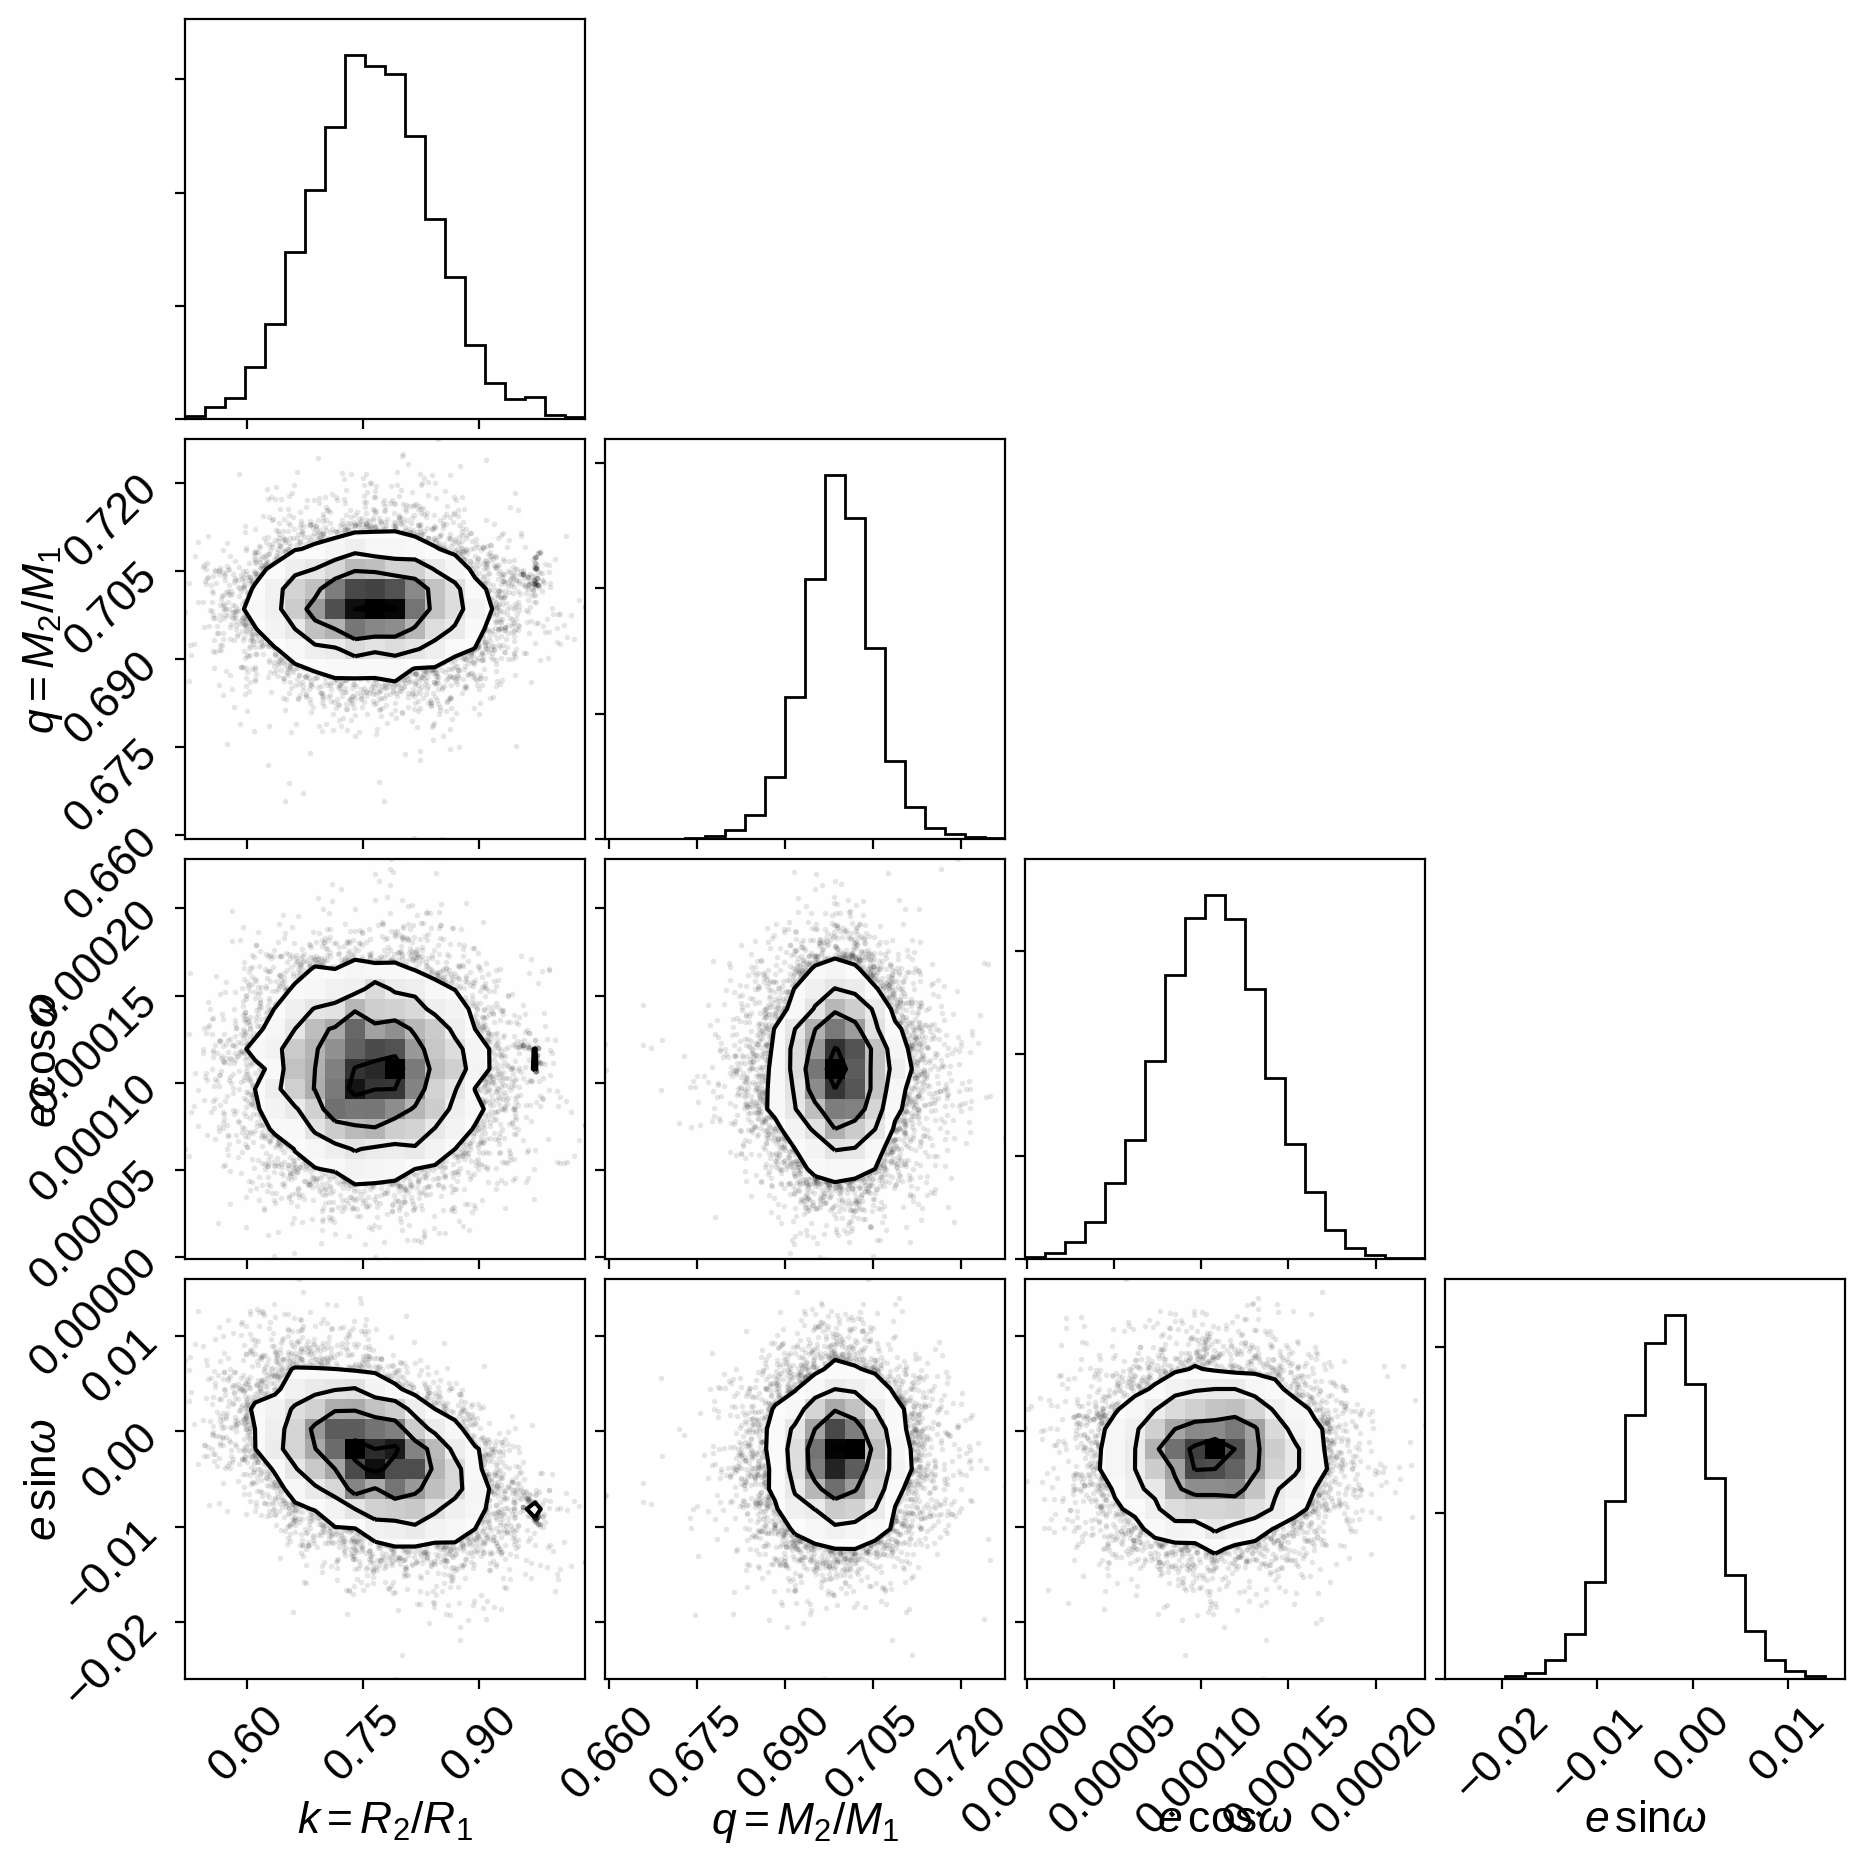

In [11]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["k", "q", "ecs"])
_ = corner.corner(
    samples,
    labels=["$k = R_2 / R_1$", "$q = M_2 / M_1$", "$e\,\cos\omega$", "$e\,\sin\omega$"],
)

And then we can look at the physical properties of the stars in the system.
In this figure, we're comparing to the results from [David+ (2016)](https://arxiv.org/abs/1602.01901).
We find that the radius of the primary is marginally inconsistent with the [David+ (2016)](https://arxiv.org/abs/1602.01901) measurement, but more consistent with other estimates from the literature (that are overplotted in different colors).

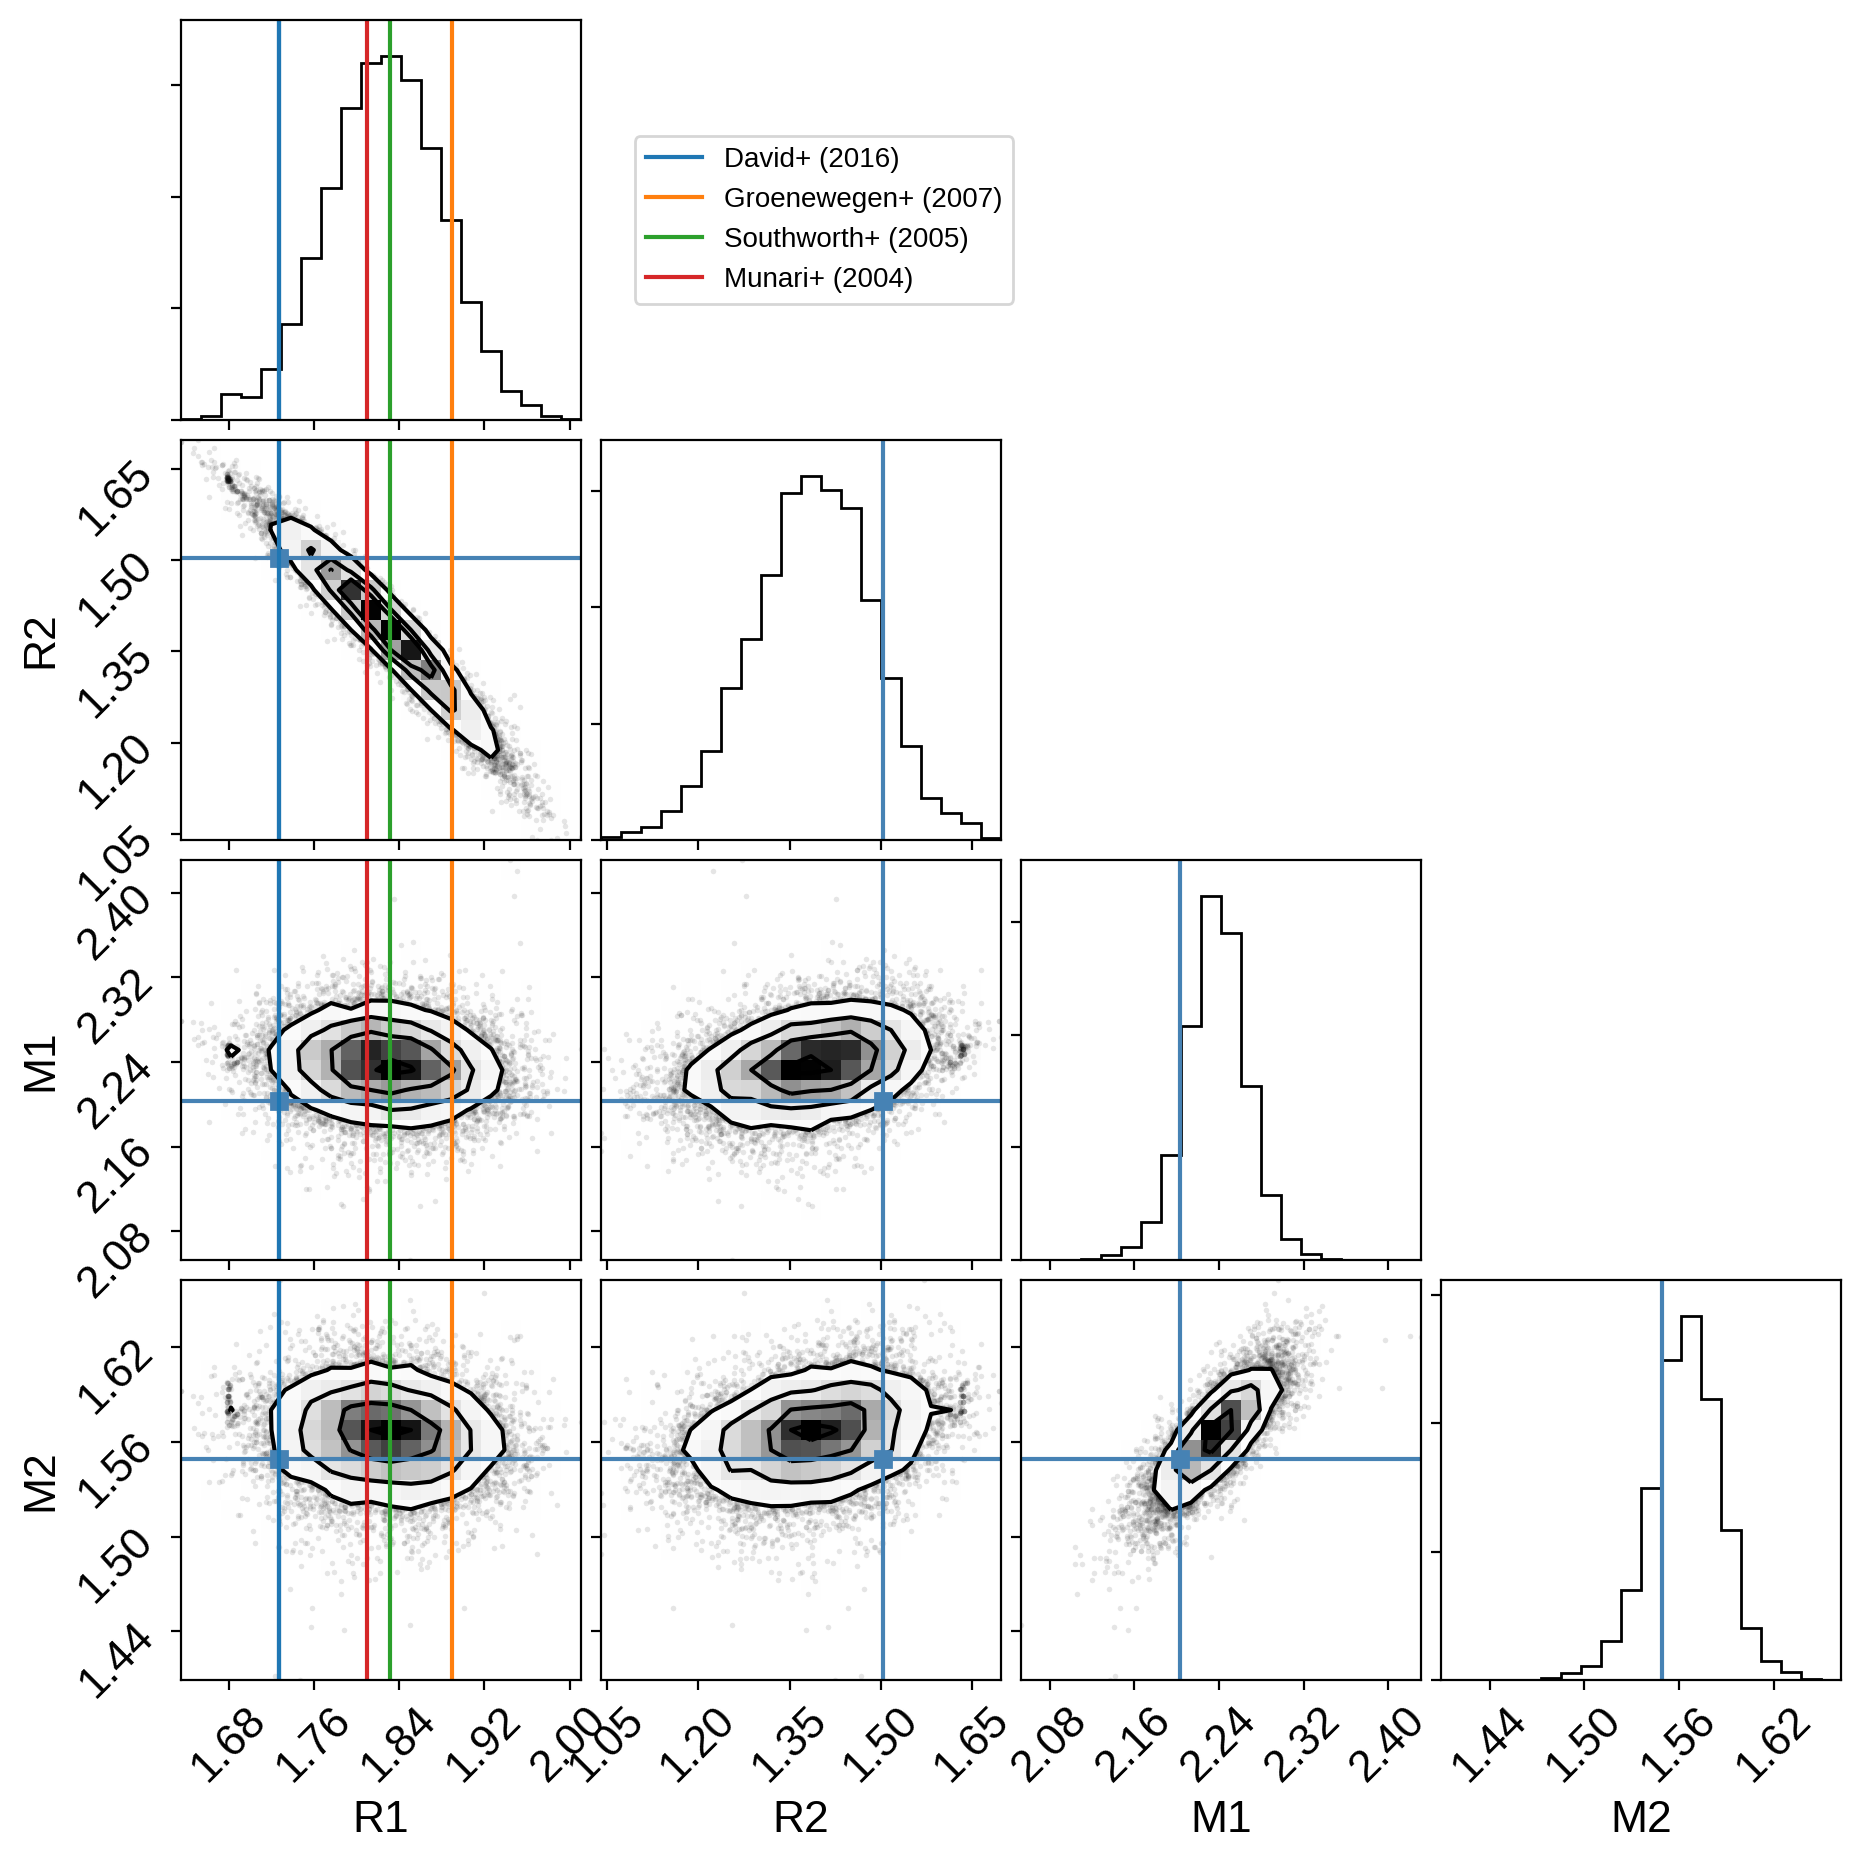

In [12]:
samples = pm.trace_to_dataframe(trace, varnames=["R1", "R2", "M1", "M2"])
fig = corner.corner(samples, truths=[1.727, 1.503, 2.203, 1.5488])

for ax in np.reshape(fig.axes, (4, 4))[:, 0]:
    ax.axvline(1.727, color="C0", label="David+ (2016)")
    ax.axvline(1.890, color="C1", label="Groenewegen+ (2007)")
    ax.axvline(1.831, color="C2", label="Southworth+ (2005)")
    ax.axvline(1.81, color="C3", label="Munari+ (2004)")

_ = fig.axes[0].legend(fontsize=10, loc="center left", bbox_to_anchor=(1.1, 0.5))

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [13]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [14]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
